In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [19]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory= False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory= False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory= False)

In [20]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [21]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [22]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'line_drive','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo', 'swing'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'line_drive','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo', 'swing'
], axis=1)   # Exclude the identifier from the features

In [23]:
train_data = training_features.drop(['ground_ball'], axis=1).copy()
train_label = training_features['ground_ball'].copy()
testing_data = testing_features.drop(['ground_ball'], axis=1).copy()
testing_label = testing_features['ground_ball'].copy()

In [24]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [25]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [26]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [27]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [28]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5577182212906123
Log Loss: 0.6819811652024834


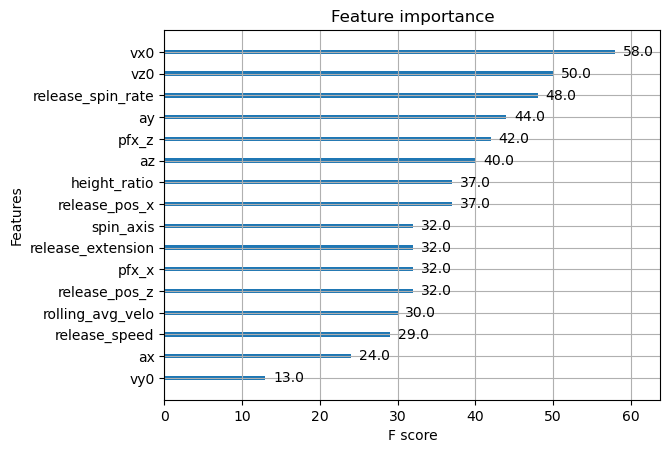

In [29]:
xgb.plot_importance(model)
plt.show()

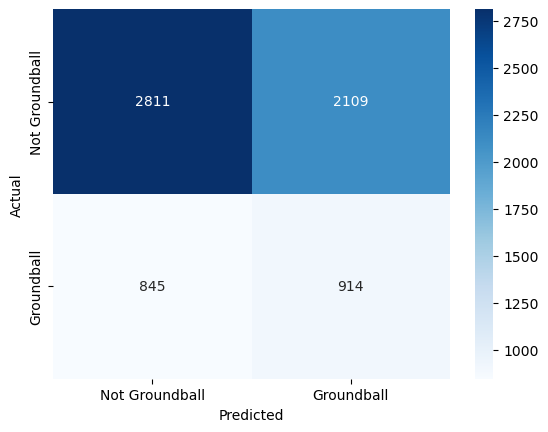

In [30]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [31]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device' : 'gpu'
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [32]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 19:22:25,148] A new study created in memory with name: no-name-57535fa7-3ab3-49c0-afac-54fee64f9705


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68922
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68597
[4]	eval-logloss:0.68474
[5]	eval-logloss:0.68347
[6]	eval-logloss:0.68244
[7]	eval-logloss:0.68094
[8]	eval-logloss:0.67952
[9]	eval-logloss:0.67883
[10]	eval-logloss:0.67745
[11]	eval-logloss:0.67699
[12]	eval-logloss:0.67550
[13]	eval-logloss:0.67477
[14]	eval-logloss:0.67339
[15]	eval-logloss:0.67328
[16]	eval-logloss:0.67273
[17]	eval-logloss:0.67157
[18]	eval-logloss:0.67062
[19]	eval-logloss:0.67052
[20]	eval-logloss:0.67063
[21]	eval-logloss:0.67018
[22]	eval-logloss:0.66948
[23]	eval-logloss:0.66833
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66760
[26]	eval-logloss:0.66735
[27]	eval-logloss:0.66732
[28]	eval-logloss:0.66725
[29]	eval-logloss:0.66676
[30]	eval-logloss:0.66692
[31]	eval-logloss:0.66661
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66539
[34]	eval-logloss:0.66506
[35]	eval-logloss:0.66455
[36]	eval-logloss:0.66423
[37]	eval-logloss:0.66392
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:26,261] Trial 0 finished with value: 0.651148808290431 and parameters: {'max_depth': 8, 'eta': 0.08262997185642752, 'subsample': 0.6266774484865475, 'colsample_bytree': 0.5812606277063581}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68523
[4]	eval-logloss:0.68399
[5]	eval-logloss:0.68351
[6]	eval-logloss:0.68354
[7]	eval-logloss:0.68253
[8]	eval-logloss:0.68249
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68170
[11]	eval-logloss:0.68222
[12]	eval-logloss:0.68316
[13]	eval-logloss:0.68234
[14]	eval-logloss:0.68196
[15]	eval-logloss:0.68160
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68108
[18]	eval-logloss:0.68076
[19]	eval-logloss:0.68089
[20]	eval-logloss:0.68103
[21]	eval-logloss:0.68072
[22]	eval-logloss:0.68059
[23]	eval-logloss:0.67967
[24]	eval-logloss:0.67943
[25]	eval-logloss:0.67868
[26]	eval-logloss:0.67887
[27]	eval-logloss:0.67872
[28]	eval-logloss:0.67877
[29]	eval-logloss:0.67832
[30]	eval-logloss:0.67816
[31]	eval-logloss:0.67755
[32]	eval-logloss:0.67775
[33]	eval-logloss:0.67698
[34]	eval-logloss:0.67771
[35]	eval-logloss:0.67733
[36]	eval-logloss:0.67697
[37]	eval-logloss:0.67684
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:26,770] Trial 1 finished with value: 0.6774085198509299 and parameters: {'max_depth': 5, 'eta': 0.19244933390727895, 'subsample': 0.7665858778394188, 'colsample_bytree': 0.6903974180521446}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68918
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68769
[4]	eval-logloss:0.68622
[5]	eval-logloss:0.68548
[6]	eval-logloss:0.68449
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68348
[9]	eval-logloss:0.68375
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68347
[12]	eval-logloss:0.68387
[13]	eval-logloss:0.68295
[14]	eval-logloss:0.68213
[15]	eval-logloss:0.68251
[16]	eval-logloss:0.68159
[17]	eval-logloss:0.68168
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68086
[20]	eval-logloss:0.68097
[21]	eval-logloss:0.68149
[22]	eval-logloss:0.68084
[23]	eval-logloss:0.67976
[24]	eval-logloss:0.68000
[25]	eval-logloss:0.67966
[26]	eval-logloss:0.68009
[27]	eval-logloss:0.68012
[28]	eval-logloss:0.68034
[29]	eval-logloss:0.68019
[30]	eval-logloss:0.68002
[31]	eval-logloss:0.67947
[32]	eval-logloss:0.67979
[33]	eval-logloss:0.67965
[34]	eval-logloss:0.68024
[35]	eval-logloss:0.67965
[36]	eval-logloss:0.67974
[37]	eval-logloss:0.67977
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:27,276] Trial 2 finished with value: 0.6790975401027836 and parameters: {'max_depth': 5, 'eta': 0.2578877756170315, 'subsample': 0.8091636070055751, 'colsample_bytree': 0.6316862924579563}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68567
[4]	eval-logloss:0.68425
[5]	eval-logloss:0.68396
[6]	eval-logloss:0.68279
[7]	eval-logloss:0.68271
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68291
[10]	eval-logloss:0.68268
[11]	eval-logloss:0.68308
[12]	eval-logloss:0.68357
[13]	eval-logloss:0.68268
[14]	eval-logloss:0.68298
[15]	eval-logloss:0.68330
[16]	eval-logloss:0.68279
[17]	eval-logloss:0.68312
[18]	eval-logloss:0.68230
[19]	eval-logloss:0.68213
[20]	eval-logloss:0.68171
[21]	eval-logloss:0.68181
[22]	eval-logloss:0.68082
[23]	eval-logloss:0.68048
[24]	eval-logloss:0.68009
[25]	eval-logloss:0.67992
[26]	eval-logloss:0.68008
[27]	eval-logloss:0.68010
[28]	eval-logloss:0.68013
[29]	eval-logloss:0.68035
[30]	eval-logloss:0.67953
[31]	eval-logloss:0.67893
[32]	eval-logloss:0.67850
[33]	eval-logloss:0.67835
[34]	eval-logloss:0.67856
[35]	eval-logloss:0.67836
[36]	eval-logloss:0.67850
[37]	eval-logloss:0.67868
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:27,705] Trial 3 finished with value: 0.673598487068812 and parameters: {'max_depth': 4, 'eta': 0.21784679480421135, 'subsample': 0.8295843394079322, 'colsample_bytree': 0.8831606625086739}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.68308
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.68093
[4]	eval-logloss:0.67990
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67895
[9]	eval-logloss:0.67920
[10]	eval-logloss:0.67844
[11]	eval-logloss:0.67823
[12]	eval-logloss:0.67814
[13]	eval-logloss:0.67874
[14]	eval-logloss:0.67891
[15]	eval-logloss:0.67902
[16]	eval-logloss:0.67916
[17]	eval-logloss:0.67833
[18]	eval-logloss:0.67730
[19]	eval-logloss:0.67813
[20]	eval-logloss:0.67791
[21]	eval-logloss:0.67855
[22]	eval-logloss:0.67914
[23]	eval-logloss:0.67673
[24]	eval-logloss:0.67580
[25]	eval-logloss:0.67600
[26]	eval-logloss:0.67510
[27]	eval-logloss:0.67514
[28]	eval-logloss:0.67550
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67599
[31]	eval-logloss:0.67522
[32]	eval-logloss:0.67596
[33]	eval-logloss:0.67615
[34]	eval-logloss:0.67680
[35]	eval-logloss:0.67644
[36]	eval-logloss:0.67583
[37]	eval-logloss:0.67622
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:28,477] Trial 4 finished with value: 0.6766939898298036 and parameters: {'max_depth': 7, 'eta': 0.21964170798577357, 'subsample': 0.7170903748866247, 'colsample_bytree': 0.9891075616950834}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68977
[2]	eval-logloss:0.68822
[3]	eval-logloss:0.68718
[4]	eval-logloss:0.68646
[5]	eval-logloss:0.68566
[6]	eval-logloss:0.68534
[7]	eval-logloss:0.68334
[8]	eval-logloss:0.68340
[9]	eval-logloss:0.68320
[10]	eval-logloss:0.68279
[11]	eval-logloss:0.68301
[12]	eval-logloss:0.68299
[13]	eval-logloss:0.68304
[14]	eval-logloss:0.68246
[15]	eval-logloss:0.68332
[16]	eval-logloss:0.68273
[17]	eval-logloss:0.68295
[18]	eval-logloss:0.68282
[19]	eval-logloss:0.68296
[20]	eval-logloss:0.68275
[21]	eval-logloss:0.68252
[22]	eval-logloss:0.68124
[23]	eval-logloss:0.68006
[24]	eval-logloss:0.68026
[25]	eval-logloss:0.67944
[26]	eval-logloss:0.67967
[27]	eval-logloss:0.68016
[28]	eval-logloss:0.68061
[29]	eval-logloss:0.68028
[30]	eval-logloss:0.68038
[31]	eval-logloss:0.68053
[32]	eval-logloss:0.68106
[33]	eval-logloss:0.68014
[34]	eval-logloss:0.68072
[35]	eval-logloss:0.68040
[36]	eval-logloss:0.68071
[37]	eval-logloss:0.68105
[38]	eval-logloss:0.68

[I 2023-11-15 19:22:28,875] Trial 5 finished with value: 0.6835918573858165 and parameters: {'max_depth': 5, 'eta': 0.274446436498766, 'subsample': 0.7977859053859127, 'colsample_bytree': 0.600096994171383}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69069
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68988
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68885
[8]	eval-logloss:0.68839
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68756
[11]	eval-logloss:0.68715
[12]	eval-logloss:0.68674
[13]	eval-logloss:0.68620
[14]	eval-logloss:0.68574
[15]	eval-logloss:0.68567
[16]	eval-logloss:0.68545
[17]	eval-logloss:0.68508
[18]	eval-logloss:0.68470
[19]	eval-logloss:0.68444
[20]	eval-logloss:0.68420
[21]	eval-logloss:0.68400
[22]	eval-logloss:0.68377
[23]	eval-logloss:0.68333
[24]	eval-logloss:0.68311
[25]	eval-logloss:0.68283
[26]	eval-logloss:0.68259
[27]	eval-logloss:0.68240
[28]	eval-logloss:0.68216
[29]	eval-logloss:0.68196
[30]	eval-logloss:0.68164
[31]	eval-logloss:0.68135
[32]	eval-logloss:0.68116
[33]	eval-logloss:0.68085
[34]	eval-logloss:0.68066
[35]	eval-logloss:0.68049
[36]	eval-logloss:0.68028
[37]	eval-logloss:0.68013
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:29,498] Trial 6 finished with value: 0.6737920671080544 and parameters: {'max_depth': 6, 'eta': 0.03133293543425697, 'subsample': 0.8168909819969588, 'colsample_bytree': 0.8157000260212726}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68276
[2]	eval-logloss:0.67858
[3]	eval-logloss:0.67616
[4]	eval-logloss:0.67433
[5]	eval-logloss:0.67339
[6]	eval-logloss:0.67125
[7]	eval-logloss:0.67081
[8]	eval-logloss:0.67127
[9]	eval-logloss:0.66992
[10]	eval-logloss:0.67013
[11]	eval-logloss:0.66986
[12]	eval-logloss:0.67023
[13]	eval-logloss:0.66940
[14]	eval-logloss:0.66910
[15]	eval-logloss:0.66991
[16]	eval-logloss:0.66960
[17]	eval-logloss:0.66916
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66983
[21]	eval-logloss:0.67039
[22]	eval-logloss:0.66949
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66760
[25]	eval-logloss:0.66768
[26]	eval-logloss:0.66785
[27]	eval-logloss:0.66814
[28]	eval-logloss:0.66832
[29]	eval-logloss:0.66814
[30]	eval-logloss:0.66823
[31]	eval-logloss:0.66803
[32]	eval-logloss:0.66865
[33]	eval-logloss:0.66807
[34]	eval-logloss:0.66840
[35]	eval-logloss:0.66789
[36]	eval-logloss:0.66784
[37]	eval-logloss:0.66724
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:30,506] Trial 7 finished with value: 0.6766499059918364 and parameters: {'max_depth': 9, 'eta': 0.21314020214963056, 'subsample': 0.8131019338171944, 'colsample_bytree': 0.8033186646511168}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68410
[5]	eval-logloss:0.68316
[6]	eval-logloss:0.68253
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68160
[9]	eval-logloss:0.68127
[10]	eval-logloss:0.68025
[11]	eval-logloss:0.68082
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67970
[14]	eval-logloss:0.67898
[15]	eval-logloss:0.67899
[16]	eval-logloss:0.67911
[17]	eval-logloss:0.67872
[18]	eval-logloss:0.67858
[19]	eval-logloss:0.67880
[20]	eval-logloss:0.67920
[21]	eval-logloss:0.67905
[22]	eval-logloss:0.67840
[23]	eval-logloss:0.67711
[24]	eval-logloss:0.67645
[25]	eval-logloss:0.67635
[26]	eval-logloss:0.67605
[27]	eval-logloss:0.67623
[28]	eval-logloss:0.67620
[29]	eval-logloss:0.67585
[30]	eval-logloss:0.67589
[31]	eval-logloss:0.67523
[32]	eval-logloss:0.67537
[33]	eval-logloss:0.67493
[34]	eval-logloss:0.67547
[35]	eval-logloss:0.67439
[36]	eval-logloss:0.67428
[37]	eval-logloss:0.67454
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:30,995] Trial 8 finished with value: 0.6727719603035532 and parameters: {'max_depth': 5, 'eta': 0.13420820860165486, 'subsample': 0.6123779692320372, 'colsample_bytree': 0.7720096891797348}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68839
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68678
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68643
[7]	eval-logloss:0.68540
[8]	eval-logloss:0.68496
[9]	eval-logloss:0.68446
[10]	eval-logloss:0.68433
[11]	eval-logloss:0.68423
[12]	eval-logloss:0.68490
[13]	eval-logloss:0.68423
[14]	eval-logloss:0.68429
[15]	eval-logloss:0.68506
[16]	eval-logloss:0.68436
[17]	eval-logloss:0.68399
[18]	eval-logloss:0.68367
[19]	eval-logloss:0.68362
[20]	eval-logloss:0.68303
[21]	eval-logloss:0.68316
[22]	eval-logloss:0.68292
[23]	eval-logloss:0.68189
[24]	eval-logloss:0.68176
[25]	eval-logloss:0.68189
[26]	eval-logloss:0.68180
[27]	eval-logloss:0.68091
[28]	eval-logloss:0.68109
[29]	eval-logloss:0.68119
[30]	eval-logloss:0.68096
[31]	eval-logloss:0.68058
[32]	eval-logloss:0.68061
[33]	eval-logloss:0.68009
[34]	eval-logloss:0.68003
[35]	eval-logloss:0.68020
[36]	eval-logloss:0.68041
[37]	eval-logloss:0.68066
[38]	eval-logloss:0.68

[I 2023-11-15 19:22:31,371] Trial 9 finished with value: 0.6786444423297118 and parameters: {'max_depth': 3, 'eta': 0.22382869730593183, 'subsample': 0.8536469375269823, 'colsample_bytree': 0.6781478684378488}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68210
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67361
[12]	eval-logloss:0.67203
[13]	eval-logloss:0.67142
[14]	eval-logloss:0.66898
[15]	eval-logloss:0.66887
[16]	eval-logloss:0.66884
[17]	eval-logloss:0.66870
[18]	eval-logloss:0.66853
[19]	eval-logloss:0.66820
[20]	eval-logloss:0.66802
[21]	eval-logloss:0.66773
[22]	eval-logloss:0.66687
[23]	eval-logloss:0.66634
[24]	eval-logloss:0.66533
[25]	eval-logloss:0.66576
[26]	eval-logloss:0.66552
[27]	eval-logloss:0.66488
[28]	eval-logloss:0.66475
[29]	eval-logloss:0.66405
[30]	eval-logloss:0.66415
[31]	eval-logloss:0.66400
[32]	eval-logloss:0.66426
[33]	eval-logloss:0.66363
[34]	eval-logloss:0.66331
[35]	eval-logloss:0.66220
[36]	eval-logloss:0.66230
[37]	eval-logloss:0.66261
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:32,368] Trial 10 finished with value: 0.6554811456335855 and parameters: {'max_depth': 9, 'eta': 0.10127010310655288, 'subsample': 0.6071132996546653, 'colsample_bytree': 0.524099742554371}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68558
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67420
[12]	eval-logloss:0.67273
[13]	eval-logloss:0.67269
[14]	eval-logloss:0.67068
[15]	eval-logloss:0.67032
[16]	eval-logloss:0.67040
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66862
[19]	eval-logloss:0.66842
[20]	eval-logloss:0.66851
[21]	eval-logloss:0.66830
[22]	eval-logloss:0.66722
[23]	eval-logloss:0.66505
[24]	eval-logloss:0.66466
[25]	eval-logloss:0.66443
[26]	eval-logloss:0.66351
[27]	eval-logloss:0.66352
[28]	eval-logloss:0.66306
[29]	eval-logloss:0.66216
[30]	eval-logloss:0.66205
[31]	eval-logloss:0.66174
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66165
[34]	eval-logloss:0.66128
[35]	eval-logloss:0.66023
[36]	eval-logloss:0.65970
[37]	eval-logloss:0.65939
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:33,367] Trial 11 finished with value: 0.6541942261510322 and parameters: {'max_depth': 9, 'eta': 0.10018788216845376, 'subsample': 0.6013519199546253, 'colsample_bytree': 0.50064343176234}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68829
[3]	eval-logloss:0.68643
[4]	eval-logloss:0.68567
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68277
[7]	eval-logloss:0.68141
[8]	eval-logloss:0.68018
[9]	eval-logloss:0.67910
[10]	eval-logloss:0.67825
[11]	eval-logloss:0.67762
[12]	eval-logloss:0.67639
[13]	eval-logloss:0.67582
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67436
[16]	eval-logloss:0.67424
[17]	eval-logloss:0.67304
[18]	eval-logloss:0.67186
[19]	eval-logloss:0.67186
[20]	eval-logloss:0.67164
[21]	eval-logloss:0.67151
[22]	eval-logloss:0.67129
[23]	eval-logloss:0.67032
[24]	eval-logloss:0.66947
[25]	eval-logloss:0.66891
[26]	eval-logloss:0.66888
[27]	eval-logloss:0.66839
[28]	eval-logloss:0.66848
[29]	eval-logloss:0.66744
[30]	eval-logloss:0.66736
[31]	eval-logloss:0.66718
[32]	eval-logloss:0.66690
[33]	eval-logloss:0.66617
[34]	eval-logloss:0.66575
[35]	eval-logloss:0.66516
[36]	eval-logloss:0.66474
[37]	eval-logloss:0.66477
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:34,179] Trial 12 finished with value: 0.6587211869610179 and parameters: {'max_depth': 8, 'eta': 0.07950094256133197, 'subsample': 0.6537166587993963, 'colsample_bytree': 0.507062578603422}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.69293
[1]	eval-logloss:0.69267
[2]	eval-logloss:0.69244
[3]	eval-logloss:0.69205
[4]	eval-logloss:0.69180
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69126
[7]	eval-logloss:0.69092
[8]	eval-logloss:0.69057
[9]	eval-logloss:0.69029
[10]	eval-logloss:0.69001
[11]	eval-logloss:0.68979
[12]	eval-logloss:0.68943
[13]	eval-logloss:0.68910
[14]	eval-logloss:0.68871
[15]	eval-logloss:0.68858
[16]	eval-logloss:0.68829
[17]	eval-logloss:0.68796
[18]	eval-logloss:0.68776
[19]	eval-logloss:0.68764
[20]	eval-logloss:0.68740
[21]	eval-logloss:0.68715
[22]	eval-logloss:0.68692
[23]	eval-logloss:0.68656
[24]	eval-logloss:0.68626
[25]	eval-logloss:0.68610
[26]	eval-logloss:0.68594
[27]	eval-logloss:0.68568
[28]	eval-logloss:0.68547
[29]	eval-logloss:0.68516
[30]	eval-logloss:0.68500
[31]	eval-logloss:0.68481
[32]	eval-logloss:0.68463
[33]	eval-logloss:0.68442
[34]	eval-logloss:0.68423
[35]	eval-logloss:0.68403
[36]	eval-logloss:0.68375
[37]	eval-logloss:0.68349
[38]	eval-logloss:0.68

[I 2023-11-15 19:22:35,162] Trial 13 finished with value: 0.6739320658974459 and parameters: {'max_depth': 8, 'eta': 0.010800176606437603, 'subsample': 0.6711397562113871, 'colsample_bytree': 0.5605348151979496}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67943
[7]	eval-logloss:0.67723
[8]	eval-logloss:0.67568
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67403
[11]	eval-logloss:0.67364
[12]	eval-logloss:0.67280
[13]	eval-logloss:0.67286
[14]	eval-logloss:0.67177
[15]	eval-logloss:0.67161
[16]	eval-logloss:0.67144
[17]	eval-logloss:0.67070
[18]	eval-logloss:0.66994
[19]	eval-logloss:0.67029
[20]	eval-logloss:0.67045
[21]	eval-logloss:0.67019
[22]	eval-logloss:0.67054
[23]	eval-logloss:0.66911
[24]	eval-logloss:0.66883
[25]	eval-logloss:0.66863
[26]	eval-logloss:0.66839
[27]	eval-logloss:0.66824
[28]	eval-logloss:0.66895
[29]	eval-logloss:0.66803
[30]	eval-logloss:0.66758
[31]	eval-logloss:0.66749
[32]	eval-logloss:0.66768
[33]	eval-logloss:0.66713
[34]	eval-logloss:0.66757
[35]	eval-logloss:0.66682
[36]	eval-logloss:0.66648
[37]	eval-logloss:0.66664
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:36,039] Trial 14 finished with value: 0.665047181664127 and parameters: {'max_depth': 8, 'eta': 0.14563460159120079, 'subsample': 0.6543065441402112, 'colsample_bytree': 0.5791191332250197}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.69019
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68824
[4]	eval-logloss:0.68721
[5]	eval-logloss:0.68575
[6]	eval-logloss:0.68516
[7]	eval-logloss:0.68439
[8]	eval-logloss:0.68347
[9]	eval-logloss:0.68253
[10]	eval-logloss:0.68181
[11]	eval-logloss:0.68164
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.67998
[14]	eval-logloss:0.67860
[15]	eval-logloss:0.67846
[16]	eval-logloss:0.67843
[17]	eval-logloss:0.67759
[18]	eval-logloss:0.67659
[19]	eval-logloss:0.67681
[20]	eval-logloss:0.67636
[21]	eval-logloss:0.67613
[22]	eval-logloss:0.67560
[23]	eval-logloss:0.67451
[24]	eval-logloss:0.67411
[25]	eval-logloss:0.67415
[26]	eval-logloss:0.67412
[27]	eval-logloss:0.67385
[28]	eval-logloss:0.67365
[29]	eval-logloss:0.67319
[30]	eval-logloss:0.67321
[31]	eval-logloss:0.67275
[32]	eval-logloss:0.67285
[33]	eval-logloss:0.67261
[34]	eval-logloss:0.67242
[35]	eval-logloss:0.67148
[36]	eval-logloss:0.67079
[37]	eval-logloss:0.67039
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:36,773] Trial 15 finished with value: 0.6644673529827919 and parameters: {'max_depth': 7, 'eta': 0.06710710344958115, 'subsample': 0.6005105390124316, 'colsample_bytree': 0.5028603912114669}. Best is trial 0 with value: 0.651148808290431.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68276
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67280
[10]	eval-logloss:0.67177
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.66961
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66774
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66708
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66553
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66457
[21]	eval-logloss:0.66401
[22]	eval-logloss:0.66268
[23]	eval-logloss:0.66169
[24]	eval-logloss:0.66159
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66042
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.65952
[29]	eval-logloss:0.65885
[30]	eval-logloss:0.65865
[31]	eval-logloss:0.65800
[32]	eval-logloss:0.65764
[33]	eval-logloss:0.65734
[34]	eval-logloss:0.65726
[35]	eval-logloss:0.65696
[36]	eval-logloss:0.65677
[37]	eval-logloss:0.65655
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:37,924] Trial 16 finished with value: 0.6452351573545665 and parameters: {'max_depth': 9, 'eta': 0.1076100889314198, 'subsample': 0.8992554181260781, 'colsample_bytree': 0.6365646223702548}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68454
[4]	eval-logloss:0.68343
[5]	eval-logloss:0.68198
[6]	eval-logloss:0.68218
[7]	eval-logloss:0.68038
[8]	eval-logloss:0.67888
[9]	eval-logloss:0.67714
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67581
[12]	eval-logloss:0.67500
[13]	eval-logloss:0.67440
[14]	eval-logloss:0.67419
[15]	eval-logloss:0.67438
[16]	eval-logloss:0.67396
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67312
[19]	eval-logloss:0.67253
[20]	eval-logloss:0.67230
[21]	eval-logloss:0.67218
[22]	eval-logloss:0.67171
[23]	eval-logloss:0.67100
[24]	eval-logloss:0.67088
[25]	eval-logloss:0.67074
[26]	eval-logloss:0.67037
[27]	eval-logloss:0.67040
[28]	eval-logloss:0.67019
[29]	eval-logloss:0.67012
[30]	eval-logloss:0.67031
[31]	eval-logloss:0.66969
[32]	eval-logloss:0.66900
[33]	eval-logloss:0.66885
[34]	eval-logloss:0.66906
[35]	eval-logloss:0.66901
[36]	eval-logloss:0.66874
[37]	eval-logloss:0.66842
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:38,630] Trial 17 finished with value: 0.6591758060336386 and parameters: {'max_depth': 7, 'eta': 0.13090590572288335, 'subsample': 0.8766279554023674, 'colsample_bytree': 0.6557895946860857}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68492
[2]	eval-logloss:0.68260
[3]	eval-logloss:0.68058
[4]	eval-logloss:0.67852
[5]	eval-logloss:0.67702
[6]	eval-logloss:0.67466
[7]	eval-logloss:0.67252
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.67078
[10]	eval-logloss:0.67011
[11]	eval-logloss:0.66998
[12]	eval-logloss:0.66982
[13]	eval-logloss:0.66916
[14]	eval-logloss:0.66907
[15]	eval-logloss:0.66897
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66818
[18]	eval-logloss:0.66759
[19]	eval-logloss:0.66684
[20]	eval-logloss:0.66615
[21]	eval-logloss:0.66578
[22]	eval-logloss:0.66387
[23]	eval-logloss:0.66292
[24]	eval-logloss:0.66265
[25]	eval-logloss:0.66256
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66173
[28]	eval-logloss:0.66106
[29]	eval-logloss:0.66135
[30]	eval-logloss:0.66117
[31]	eval-logloss:0.66122
[32]	eval-logloss:0.66084
[33]	eval-logloss:0.66065
[34]	eval-logloss:0.66041
[35]	eval-logloss:0.66010
[36]	eval-logloss:0.66005
[37]	eval-logloss:0.65979
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:39,490] Trial 18 finished with value: 0.6510463904893151 and parameters: {'max_depth': 8, 'eta': 0.16309165953847488, 'subsample': 0.8925714423623256, 'colsample_bytree': 0.7132318177606262}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68505
[2]	eval-logloss:0.68237
[3]	eval-logloss:0.67935
[4]	eval-logloss:0.67704
[5]	eval-logloss:0.67526
[6]	eval-logloss:0.67313
[7]	eval-logloss:0.67050
[8]	eval-logloss:0.66926
[9]	eval-logloss:0.66830
[10]	eval-logloss:0.66739
[11]	eval-logloss:0.66775
[12]	eval-logloss:0.66716
[13]	eval-logloss:0.66603
[14]	eval-logloss:0.66633
[15]	eval-logloss:0.66600
[16]	eval-logloss:0.66521
[17]	eval-logloss:0.66452
[18]	eval-logloss:0.66325
[19]	eval-logloss:0.66353
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66282
[22]	eval-logloss:0.66202
[23]	eval-logloss:0.66108
[24]	eval-logloss:0.66083
[25]	eval-logloss:0.66012
[26]	eval-logloss:0.65964
[27]	eval-logloss:0.65923
[28]	eval-logloss:0.65906
[29]	eval-logloss:0.65884
[30]	eval-logloss:0.65909
[31]	eval-logloss:0.65771
[32]	eval-logloss:0.65716
[33]	eval-logloss:0.65741
[34]	eval-logloss:0.65672
[35]	eval-logloss:0.65572
[36]	eval-logloss:0.65563
[37]	eval-logloss:0.65539
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:40,536] Trial 19 finished with value: 0.652236163725609 and parameters: {'max_depth': 9, 'eta': 0.16581038464603096, 'subsample': 0.8950322406308593, 'colsample_bytree': 0.7077585363110696}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68477
[4]	eval-logloss:0.68382
[5]	eval-logloss:0.68240
[6]	eval-logloss:0.68131
[7]	eval-logloss:0.68006
[8]	eval-logloss:0.67944
[9]	eval-logloss:0.67875
[10]	eval-logloss:0.67848
[11]	eval-logloss:0.67852
[12]	eval-logloss:0.67881
[13]	eval-logloss:0.67832
[14]	eval-logloss:0.67816
[15]	eval-logloss:0.67775
[16]	eval-logloss:0.67780
[17]	eval-logloss:0.67745
[18]	eval-logloss:0.67699
[19]	eval-logloss:0.67643
[20]	eval-logloss:0.67628
[21]	eval-logloss:0.67656
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67486
[24]	eval-logloss:0.67452
[25]	eval-logloss:0.67446
[26]	eval-logloss:0.67406
[27]	eval-logloss:0.67356
[28]	eval-logloss:0.67368
[29]	eval-logloss:0.67327
[30]	eval-logloss:0.67302
[31]	eval-logloss:0.67295
[32]	eval-logloss:0.67275
[33]	eval-logloss:0.67240
[34]	eval-logloss:0.67210
[35]	eval-logloss:0.67227
[36]	eval-logloss:0.67160
[37]	eval-logloss:0.67135
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:41,074] Trial 20 finished with value: 0.6668581534763193 and parameters: {'max_depth': 6, 'eta': 0.17776067647962554, 'subsample': 0.8978798286133758, 'colsample_bytree': 0.7180601050753832}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68276
[6]	eval-logloss:0.68161
[7]	eval-logloss:0.68040
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67775
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67610
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67412
[14]	eval-logloss:0.67337
[15]	eval-logloss:0.67326
[16]	eval-logloss:0.67237
[17]	eval-logloss:0.67147
[18]	eval-logloss:0.67065
[19]	eval-logloss:0.67043
[20]	eval-logloss:0.67009
[21]	eval-logloss:0.66973
[22]	eval-logloss:0.66923
[23]	eval-logloss:0.66862
[24]	eval-logloss:0.66822
[25]	eval-logloss:0.66829
[26]	eval-logloss:0.66805
[27]	eval-logloss:0.66764
[28]	eval-logloss:0.66760
[29]	eval-logloss:0.66690
[30]	eval-logloss:0.66649
[31]	eval-logloss:0.66636
[32]	eval-logloss:0.66598
[33]	eval-logloss:0.66497
[34]	eval-logloss:0.66457
[35]	eval-logloss:0.66458
[36]	eval-logloss:0.66423
[37]	eval-logloss:0.66375
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:41,883] Trial 21 finished with value: 0.653741384605765 and parameters: {'max_depth': 8, 'eta': 0.1137627549527277, 'subsample': 0.8559635999676728, 'colsample_bytree': 0.6198313794985024}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68248
[4]	eval-logloss:0.68072
[5]	eval-logloss:0.67921
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67838
[8]	eval-logloss:0.67656
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67372
[11]	eval-logloss:0.67329
[12]	eval-logloss:0.67207
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66953
[15]	eval-logloss:0.66889
[16]	eval-logloss:0.66854
[17]	eval-logloss:0.66861
[18]	eval-logloss:0.66860
[19]	eval-logloss:0.66838
[20]	eval-logloss:0.66770
[21]	eval-logloss:0.66750
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66602
[24]	eval-logloss:0.66495
[25]	eval-logloss:0.66489
[26]	eval-logloss:0.66553
[27]	eval-logloss:0.66494
[28]	eval-logloss:0.66500
[29]	eval-logloss:0.66447
[30]	eval-logloss:0.66422
[31]	eval-logloss:0.66402
[32]	eval-logloss:0.66450
[33]	eval-logloss:0.66448
[34]	eval-logloss:0.66400
[35]	eval-logloss:0.66314
[36]	eval-logloss:0.66274
[37]	eval-logloss:0.66275
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:42,715] Trial 22 finished with value: 0.6574338479989229 and parameters: {'max_depth': 8, 'eta': 0.14256327411163405, 'subsample': 0.7361961118792004, 'colsample_bytree': 0.6401654694390335}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69257
[1]	eval-logloss:0.69114
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68885
[4]	eval-logloss:0.68797
[5]	eval-logloss:0.68698
[6]	eval-logloss:0.68611
[7]	eval-logloss:0.68499
[8]	eval-logloss:0.68397
[9]	eval-logloss:0.68302
[10]	eval-logloss:0.68246
[11]	eval-logloss:0.68179
[12]	eval-logloss:0.68086
[13]	eval-logloss:0.67992
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67881
[17]	eval-logloss:0.67820
[18]	eval-logloss:0.67771
[19]	eval-logloss:0.67764
[20]	eval-logloss:0.67700
[21]	eval-logloss:0.67652
[22]	eval-logloss:0.67607
[23]	eval-logloss:0.67500
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67413
[26]	eval-logloss:0.67406
[27]	eval-logloss:0.67342
[28]	eval-logloss:0.67326
[29]	eval-logloss:0.67282
[30]	eval-logloss:0.67257
[31]	eval-logloss:0.67214
[32]	eval-logloss:0.67167
[33]	eval-logloss:0.67159
[34]	eval-logloss:0.67161
[35]	eval-logloss:0.67154
[36]	eval-logloss:0.67093
[37]	eval-logloss:0.67057
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:43,381] Trial 23 finished with value: 0.6594510925049892 and parameters: {'max_depth': 7, 'eta': 0.07714718177217379, 'subsample': 0.8648000858869258, 'colsample_bytree': 0.5742703943141244}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68422
[2]	eval-logloss:0.68189
[3]	eval-logloss:0.67962
[4]	eval-logloss:0.67730
[5]	eval-logloss:0.67564
[6]	eval-logloss:0.67467
[7]	eval-logloss:0.67283
[8]	eval-logloss:0.67171
[9]	eval-logloss:0.66917
[10]	eval-logloss:0.66892
[11]	eval-logloss:0.66744
[12]	eval-logloss:0.66570
[13]	eval-logloss:0.66530
[14]	eval-logloss:0.66498
[15]	eval-logloss:0.66394
[16]	eval-logloss:0.66273
[17]	eval-logloss:0.66226
[18]	eval-logloss:0.66108
[19]	eval-logloss:0.66112
[20]	eval-logloss:0.66012
[21]	eval-logloss:0.65961
[22]	eval-logloss:0.65837
[23]	eval-logloss:0.65637
[24]	eval-logloss:0.65611
[25]	eval-logloss:0.65583
[26]	eval-logloss:0.65485
[27]	eval-logloss:0.65405
[28]	eval-logloss:0.65439
[29]	eval-logloss:0.65343
[30]	eval-logloss:0.65364
[31]	eval-logloss:0.65350
[32]	eval-logloss:0.65297
[33]	eval-logloss:0.65317
[34]	eval-logloss:0.65316
[35]	eval-logloss:0.65272
[36]	eval-logloss:0.65321
[37]	eval-logloss:0.65331
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:44,504] Trial 24 finished with value: 0.651025108580582 and parameters: {'max_depth': 9, 'eta': 0.16181780338441012, 'subsample': 0.8417828142746788, 'colsample_bytree': 0.6574153445290981}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68738
[1]	eval-logloss:0.68422
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.68072
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67606
[7]	eval-logloss:0.67422
[8]	eval-logloss:0.67287
[9]	eval-logloss:0.67093
[10]	eval-logloss:0.67038
[11]	eval-logloss:0.66938
[12]	eval-logloss:0.66813
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66775
[15]	eval-logloss:0.66705
[16]	eval-logloss:0.66696
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66633
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66631
[21]	eval-logloss:0.66604
[22]	eval-logloss:0.66500
[23]	eval-logloss:0.66449
[24]	eval-logloss:0.66437
[25]	eval-logloss:0.66424
[26]	eval-logloss:0.66449
[27]	eval-logloss:0.66391
[28]	eval-logloss:0.66349
[29]	eval-logloss:0.66311
[30]	eval-logloss:0.66280
[31]	eval-logloss:0.66249
[32]	eval-logloss:0.66250
[33]	eval-logloss:0.66152
[34]	eval-logloss:0.66137
[35]	eval-logloss:0.66134
[36]	eval-logloss:0.66038
[37]	eval-logloss:0.65973
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:45,605] Trial 25 finished with value: 0.6547073129018466 and parameters: {'max_depth': 9, 'eta': 0.16342241170008429, 'subsample': 0.8819213835125899, 'colsample_bytree': 0.6573693019077709}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.67938
[3]	eval-logloss:0.67665
[4]	eval-logloss:0.67518
[5]	eval-logloss:0.67327
[6]	eval-logloss:0.67150
[7]	eval-logloss:0.67031
[8]	eval-logloss:0.66997
[9]	eval-logloss:0.66909
[10]	eval-logloss:0.66852
[11]	eval-logloss:0.66782
[12]	eval-logloss:0.66769
[13]	eval-logloss:0.66630
[14]	eval-logloss:0.66589
[15]	eval-logloss:0.66626
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66440
[18]	eval-logloss:0.66446
[19]	eval-logloss:0.66475
[20]	eval-logloss:0.66314
[21]	eval-logloss:0.66249
[22]	eval-logloss:0.66136
[23]	eval-logloss:0.66055
[24]	eval-logloss:0.66047
[25]	eval-logloss:0.66039
[26]	eval-logloss:0.66000
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.65986
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65900
[31]	eval-logloss:0.65937
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65854
[34]	eval-logloss:0.65852
[35]	eval-logloss:0.65862
[36]	eval-logloss:0.65817
[37]	eval-logloss:0.65805
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:46,650] Trial 26 finished with value: 0.656898381875458 and parameters: {'max_depth': 9, 'eta': 0.18405517919251785, 'subsample': 0.8438722846151472, 'colsample_bytree': 0.7338194848905492}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68516
[2]	eval-logloss:0.68246
[3]	eval-logloss:0.67967
[4]	eval-logloss:0.67754
[5]	eval-logloss:0.67592
[6]	eval-logloss:0.67341
[7]	eval-logloss:0.67169
[8]	eval-logloss:0.67112
[9]	eval-logloss:0.67048
[10]	eval-logloss:0.67035
[11]	eval-logloss:0.66957
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66807
[14]	eval-logloss:0.66692
[15]	eval-logloss:0.66688
[16]	eval-logloss:0.66682
[17]	eval-logloss:0.66660
[18]	eval-logloss:0.66635
[19]	eval-logloss:0.66604
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66391
[23]	eval-logloss:0.66303
[24]	eval-logloss:0.66230
[25]	eval-logloss:0.66125
[26]	eval-logloss:0.66097
[27]	eval-logloss:0.65960
[28]	eval-logloss:0.65942
[29]	eval-logloss:0.65945
[30]	eval-logloss:0.65976
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65906
[35]	eval-logloss:0.65835
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65871
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:47,665] Trial 27 finished with value: 0.6526862785099621 and parameters: {'max_depth': 9, 'eta': 0.15221339129065456, 'subsample': 0.8991548359241538, 'colsample_bytree': 0.6912391022937344}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68456
[3]	eval-logloss:0.68320
[4]	eval-logloss:0.68204
[5]	eval-logloss:0.68057
[6]	eval-logloss:0.67851
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67614
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67251
[12]	eval-logloss:0.67168
[13]	eval-logloss:0.67100
[14]	eval-logloss:0.67072
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66925
[18]	eval-logloss:0.66893
[19]	eval-logloss:0.66873
[20]	eval-logloss:0.66772
[21]	eval-logloss:0.66754
[22]	eval-logloss:0.66710
[23]	eval-logloss:0.66615
[24]	eval-logloss:0.66561
[25]	eval-logloss:0.66586
[26]	eval-logloss:0.66549
[27]	eval-logloss:0.66486
[28]	eval-logloss:0.66482
[29]	eval-logloss:0.66452
[30]	eval-logloss:0.66461
[31]	eval-logloss:0.66425
[32]	eval-logloss:0.66364
[33]	eval-logloss:0.66367
[34]	eval-logloss:0.66376
[35]	eval-logloss:0.66360
[36]	eval-logloss:0.66272
[37]	eval-logloss:0.66257
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:48,521] Trial 28 finished with value: 0.6543449976889927 and parameters: {'max_depth': 8, 'eta': 0.12305755163500011, 'subsample': 0.8654422328596751, 'colsample_bytree': 0.7574944550259566}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68276
[4]	eval-logloss:0.68107
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67965
[7]	eval-logloss:0.67820
[8]	eval-logloss:0.67701
[9]	eval-logloss:0.67561
[10]	eval-logloss:0.67460
[11]	eval-logloss:0.67375
[12]	eval-logloss:0.67207
[13]	eval-logloss:0.67145
[14]	eval-logloss:0.67115
[15]	eval-logloss:0.67136
[16]	eval-logloss:0.67074
[17]	eval-logloss:0.67030
[18]	eval-logloss:0.66974
[19]	eval-logloss:0.66936
[20]	eval-logloss:0.66918
[21]	eval-logloss:0.66845
[22]	eval-logloss:0.66824
[23]	eval-logloss:0.66749
[24]	eval-logloss:0.66702
[25]	eval-logloss:0.66670
[26]	eval-logloss:0.66647
[27]	eval-logloss:0.66645
[28]	eval-logloss:0.66606
[29]	eval-logloss:0.66507
[30]	eval-logloss:0.66484
[31]	eval-logloss:0.66485
[32]	eval-logloss:0.66504
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66520
[35]	eval-logloss:0.66511
[36]	eval-logloss:0.66475
[37]	eval-logloss:0.66476
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:49,368] Trial 29 finished with value: 0.6574096026485802 and parameters: {'max_depth': 8, 'eta': 0.15895730795802282, 'subsample': 0.8375725369969902, 'colsample_bytree': 0.6165380394938775}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68494
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68281
[7]	eval-logloss:0.68078
[8]	eval-logloss:0.67951
[9]	eval-logloss:0.67805
[10]	eval-logloss:0.67744
[11]	eval-logloss:0.67710
[12]	eval-logloss:0.67663
[13]	eval-logloss:0.67606
[14]	eval-logloss:0.67533
[15]	eval-logloss:0.67548
[16]	eval-logloss:0.67525
[17]	eval-logloss:0.67485
[18]	eval-logloss:0.67460
[19]	eval-logloss:0.67457
[20]	eval-logloss:0.67426
[21]	eval-logloss:0.67391
[22]	eval-logloss:0.67303
[23]	eval-logloss:0.67253
[24]	eval-logloss:0.67195
[25]	eval-logloss:0.67184
[26]	eval-logloss:0.67131
[27]	eval-logloss:0.67099
[28]	eval-logloss:0.67082
[29]	eval-logloss:0.67042
[30]	eval-logloss:0.67042
[31]	eval-logloss:0.66990
[32]	eval-logloss:0.66936
[33]	eval-logloss:0.66903
[34]	eval-logloss:0.66911
[35]	eval-logloss:0.66887
[36]	eval-logloss:0.66848
[37]	eval-logloss:0.66820
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:50,106] Trial 30 finished with value: 0.658310487651902 and parameters: {'max_depth': 7, 'eta': 0.11130411373701118, 'subsample': 0.8744446640654604, 'colsample_bytree': 0.6561956249953185}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68502
[4]	eval-logloss:0.68481
[5]	eval-logloss:0.68398
[6]	eval-logloss:0.68313
[7]	eval-logloss:0.68130
[8]	eval-logloss:0.68124
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68010
[11]	eval-logloss:0.68091
[12]	eval-logloss:0.68102
[13]	eval-logloss:0.68048
[14]	eval-logloss:0.67995
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.67927
[17]	eval-logloss:0.67874
[18]	eval-logloss:0.67790
[19]	eval-logloss:0.67806
[20]	eval-logloss:0.67725
[21]	eval-logloss:0.67714
[22]	eval-logloss:0.67621
[23]	eval-logloss:0.67493
[24]	eval-logloss:0.67475
[25]	eval-logloss:0.67441
[26]	eval-logloss:0.67451
[27]	eval-logloss:0.67430
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67375
[30]	eval-logloss:0.67369
[31]	eval-logloss:0.67325
[32]	eval-logloss:0.67367
[33]	eval-logloss:0.67271
[34]	eval-logloss:0.67318
[35]	eval-logloss:0.67294
[36]	eval-logloss:0.67279
[37]	eval-logloss:0.67288
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:50,653] Trial 31 finished with value: 0.6740136834467161 and parameters: {'max_depth': 6, 'eta': 0.19821629438241406, 'subsample': 0.7833255977467184, 'colsample_bytree': 0.6844981214308461}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68494
[3]	eval-logloss:0.68328
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67897
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67436
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67101
[13]	eval-logloss:0.66964
[14]	eval-logloss:0.66938
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66825
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66643
[19]	eval-logloss:0.66643
[20]	eval-logloss:0.66612
[21]	eval-logloss:0.66586
[22]	eval-logloss:0.66521
[23]	eval-logloss:0.66417
[24]	eval-logloss:0.66366
[25]	eval-logloss:0.66335
[26]	eval-logloss:0.66250
[27]	eval-logloss:0.66186
[28]	eval-logloss:0.66194
[29]	eval-logloss:0.66106
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.66075
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.66014
[34]	eval-logloss:0.66037
[35]	eval-logloss:0.66018
[36]	eval-logloss:0.65931
[37]	eval-logloss:0.65888
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:51,696] Trial 32 finished with value: 0.6546230268771147 and parameters: {'max_depth': 9, 'eta': 0.13013655910781782, 'subsample': 0.7743638997135666, 'colsample_bytree': 0.6064585155827181}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.68978
[2]	eval-logloss:0.68770
[3]	eval-logloss:0.68619
[4]	eval-logloss:0.68479
[5]	eval-logloss:0.68345
[6]	eval-logloss:0.68242
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.67994
[9]	eval-logloss:0.67893
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67716
[12]	eval-logloss:0.67656
[13]	eval-logloss:0.67514
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67403
[16]	eval-logloss:0.67383
[17]	eval-logloss:0.67327
[18]	eval-logloss:0.67222
[19]	eval-logloss:0.67173
[20]	eval-logloss:0.67124
[21]	eval-logloss:0.67060
[22]	eval-logloss:0.66982
[23]	eval-logloss:0.66929
[24]	eval-logloss:0.66872
[25]	eval-logloss:0.66864
[26]	eval-logloss:0.66855
[27]	eval-logloss:0.66787
[28]	eval-logloss:0.66727
[29]	eval-logloss:0.66677
[30]	eval-logloss:0.66644
[31]	eval-logloss:0.66613
[32]	eval-logloss:0.66508
[33]	eval-logloss:0.66473
[34]	eval-logloss:0.66452
[35]	eval-logloss:0.66412
[36]	eval-logloss:0.66330
[37]	eval-logloss:0.66282
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:52,535] Trial 33 finished with value: 0.6542968575570537 and parameters: {'max_depth': 8, 'eta': 0.09367643012247079, 'subsample': 0.8279996612663553, 'colsample_bytree': 0.5492557646795301}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68357
[2]	eval-logloss:0.68188
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67812
[5]	eval-logloss:0.67724
[6]	eval-logloss:0.67584
[7]	eval-logloss:0.67398
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.66973
[10]	eval-logloss:0.66902
[11]	eval-logloss:0.66814
[12]	eval-logloss:0.66761
[13]	eval-logloss:0.66621
[14]	eval-logloss:0.66640
[15]	eval-logloss:0.66636
[16]	eval-logloss:0.66654
[17]	eval-logloss:0.66598
[18]	eval-logloss:0.66518
[19]	eval-logloss:0.66523
[20]	eval-logloss:0.66531
[21]	eval-logloss:0.66424
[22]	eval-logloss:0.66219
[23]	eval-logloss:0.66167
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66196
[26]	eval-logloss:0.66163
[27]	eval-logloss:0.66077
[28]	eval-logloss:0.66058
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65995
[31]	eval-logloss:0.65931
[32]	eval-logloss:0.65852
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65727
[35]	eval-logloss:0.65695
[36]	eval-logloss:0.65610
[37]	eval-logloss:0.65593
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:53,598] Trial 34 finished with value: 0.6537193797265582 and parameters: {'max_depth': 9, 'eta': 0.16937133375043087, 'subsample': 0.8504117016214623, 'colsample_bytree': 0.6386164064452384}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.69058
[2]	eval-logloss:0.68985
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68853
[5]	eval-logloss:0.68777
[6]	eval-logloss:0.68704
[7]	eval-logloss:0.68614
[8]	eval-logloss:0.68532
[9]	eval-logloss:0.68448
[10]	eval-logloss:0.68392
[11]	eval-logloss:0.68303
[12]	eval-logloss:0.68225
[13]	eval-logloss:0.68129
[14]	eval-logloss:0.68082
[15]	eval-logloss:0.68062
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67919
[18]	eval-logloss:0.67889
[19]	eval-logloss:0.67867
[20]	eval-logloss:0.67823
[21]	eval-logloss:0.67783
[22]	eval-logloss:0.67734
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67634
[25]	eval-logloss:0.67612
[26]	eval-logloss:0.67596
[27]	eval-logloss:0.67548
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67486
[30]	eval-logloss:0.67472
[31]	eval-logloss:0.67431
[32]	eval-logloss:0.67396
[33]	eval-logloss:0.67370
[34]	eval-logloss:0.67356
[35]	eval-logloss:0.67325
[36]	eval-logloss:0.67294
[37]	eval-logloss:0.67257
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:54,256] Trial 35 finished with value: 0.6632295858856978 and parameters: {'max_depth': 7, 'eta': 0.057768192619351164, 'subsample': 0.8818103334559287, 'colsample_bytree': 0.6750701332942414}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68913
[2]	eval-logloss:0.68718
[3]	eval-logloss:0.68531
[4]	eval-logloss:0.68405
[5]	eval-logloss:0.68341
[6]	eval-logloss:0.68277
[7]	eval-logloss:0.68122
[8]	eval-logloss:0.68036
[9]	eval-logloss:0.67973
[10]	eval-logloss:0.67870
[11]	eval-logloss:0.67849
[12]	eval-logloss:0.67720
[13]	eval-logloss:0.67551
[14]	eval-logloss:0.67477
[15]	eval-logloss:0.67478
[16]	eval-logloss:0.67393
[17]	eval-logloss:0.67358
[18]	eval-logloss:0.67303
[19]	eval-logloss:0.67293
[20]	eval-logloss:0.67240
[21]	eval-logloss:0.67231
[22]	eval-logloss:0.67172
[23]	eval-logloss:0.67130
[24]	eval-logloss:0.67090
[25]	eval-logloss:0.67082
[26]	eval-logloss:0.67081
[27]	eval-logloss:0.67032
[28]	eval-logloss:0.67009
[29]	eval-logloss:0.66881
[30]	eval-logloss:0.66774
[31]	eval-logloss:0.66712
[32]	eval-logloss:0.66676
[33]	eval-logloss:0.66550
[34]	eval-logloss:0.66581
[35]	eval-logloss:0.66531
[36]	eval-logloss:0.66490
[37]	eval-logloss:0.66466
[38]	eval-logloss:0.66

[I 2023-11-15 19:22:55,036] Trial 36 finished with value: 0.6570008374266157 and parameters: {'max_depth': 8, 'eta': 0.11810167735787486, 'subsample': 0.7977931414595045, 'colsample_bytree': 0.5884685323269528}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68195
[4]	eval-logloss:0.68024
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67564
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67307
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.67003
[11]	eval-logloss:0.66948
[12]	eval-logloss:0.66850
[13]	eval-logloss:0.66735
[14]	eval-logloss:0.66638
[15]	eval-logloss:0.66659
[16]	eval-logloss:0.66636
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66513
[19]	eval-logloss:0.66522
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66186
[24]	eval-logloss:0.66112
[25]	eval-logloss:0.66109
[26]	eval-logloss:0.66096
[27]	eval-logloss:0.66024
[28]	eval-logloss:0.65979
[29]	eval-logloss:0.65871
[30]	eval-logloss:0.65822
[31]	eval-logloss:0.65803
[32]	eval-logloss:0.65777
[33]	eval-logloss:0.65736
[34]	eval-logloss:0.65735
[35]	eval-logloss:0.65706
[36]	eval-logloss:0.65656
[37]	eval-logloss:0.65542
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:56,051] Trial 37 finished with value: 0.6516816099415353 and parameters: {'max_depth': 9, 'eta': 0.13925453461505655, 'subsample': 0.8308394277023463, 'colsample_bytree': 0.6092453999282846}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68664
[4]	eval-logloss:0.68579
[5]	eval-logloss:0.68514
[6]	eval-logloss:0.68481
[7]	eval-logloss:0.68433
[8]	eval-logloss:0.68386
[9]	eval-logloss:0.68369
[10]	eval-logloss:0.68338
[11]	eval-logloss:0.68385
[12]	eval-logloss:0.68380
[13]	eval-logloss:0.68324
[14]	eval-logloss:0.68259
[15]	eval-logloss:0.68249
[16]	eval-logloss:0.68264
[17]	eval-logloss:0.68236
[18]	eval-logloss:0.68236
[19]	eval-logloss:0.68282
[20]	eval-logloss:0.68239
[21]	eval-logloss:0.68272
[22]	eval-logloss:0.68246
[23]	eval-logloss:0.68150
[24]	eval-logloss:0.68131
[25]	eval-logloss:0.68084
[26]	eval-logloss:0.68112
[27]	eval-logloss:0.68136
[28]	eval-logloss:0.68150
[29]	eval-logloss:0.68109
[30]	eval-logloss:0.68085
[31]	eval-logloss:0.68052
[32]	eval-logloss:0.68044
[33]	eval-logloss:0.68016
[34]	eval-logloss:0.68041
[35]	eval-logloss:0.67985
[36]	eval-logloss:0.67999
[37]	eval-logloss:0.67969
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:56,472] Trial 38 finished with value: 0.6757537431598887 and parameters: {'max_depth': 4, 'eta': 0.15513212864443626, 'subsample': 0.7147019460735742, 'colsample_bytree': 0.7076583345400863}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68452
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.68203
[6]	eval-logloss:0.68223
[7]	eval-logloss:0.68057
[8]	eval-logloss:0.67943
[9]	eval-logloss:0.67831
[10]	eval-logloss:0.67719
[11]	eval-logloss:0.67725
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67629
[14]	eval-logloss:0.67625
[15]	eval-logloss:0.67648
[16]	eval-logloss:0.67719
[17]	eval-logloss:0.67737
[18]	eval-logloss:0.67651
[19]	eval-logloss:0.67681
[20]	eval-logloss:0.67621
[21]	eval-logloss:0.67611
[22]	eval-logloss:0.67448
[23]	eval-logloss:0.67292
[24]	eval-logloss:0.67335
[25]	eval-logloss:0.67250
[26]	eval-logloss:0.67250
[27]	eval-logloss:0.67242
[28]	eval-logloss:0.67255
[29]	eval-logloss:0.67147
[30]	eval-logloss:0.67092
[31]	eval-logloss:0.67065
[32]	eval-logloss:0.67103
[33]	eval-logloss:0.67098
[34]	eval-logloss:0.67181
[35]	eval-logloss:0.67171
[36]	eval-logloss:0.67186
[37]	eval-logloss:0.67159
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:57,118] Trial 39 finished with value: 0.6695213884849321 and parameters: {'max_depth': 7, 'eta': 0.20199161244999644, 'subsample': 0.7530744474432278, 'colsample_bytree': 0.6311074659345811}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68855
[3]	eval-logloss:0.68772
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68629
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68519
[8]	eval-logloss:0.68434
[9]	eval-logloss:0.68371
[10]	eval-logloss:0.68354
[11]	eval-logloss:0.68298
[12]	eval-logloss:0.68325
[13]	eval-logloss:0.68256
[14]	eval-logloss:0.68199
[15]	eval-logloss:0.68241
[16]	eval-logloss:0.68165
[17]	eval-logloss:0.68124
[18]	eval-logloss:0.68072
[19]	eval-logloss:0.68102
[20]	eval-logloss:0.68112
[21]	eval-logloss:0.68096
[22]	eval-logloss:0.68000
[23]	eval-logloss:0.67927
[24]	eval-logloss:0.67857
[25]	eval-logloss:0.67825
[26]	eval-logloss:0.67807
[27]	eval-logloss:0.67823
[28]	eval-logloss:0.67860
[29]	eval-logloss:0.67818
[30]	eval-logloss:0.67829
[31]	eval-logloss:0.67755
[32]	eval-logloss:0.67759
[33]	eval-logloss:0.67712
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67722
[36]	eval-logloss:0.67704
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67

[I 2023-11-15 19:22:57,695] Trial 40 finished with value: 0.6719089291773339 and parameters: {'max_depth': 6, 'eta': 0.17833302256806582, 'subsample': 0.8127103136196017, 'colsample_bytree': 0.5361228145596659}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68152
[4]	eval-logloss:0.68019
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67437
[9]	eval-logloss:0.67272
[10]	eval-logloss:0.67125
[11]	eval-logloss:0.67026
[12]	eval-logloss:0.66951
[13]	eval-logloss:0.66818
[14]	eval-logloss:0.66789
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66627
[19]	eval-logloss:0.66653
[20]	eval-logloss:0.66653
[21]	eval-logloss:0.66580
[22]	eval-logloss:0.66510
[23]	eval-logloss:0.66421
[24]	eval-logloss:0.66388
[25]	eval-logloss:0.66381
[26]	eval-logloss:0.66392
[27]	eval-logloss:0.66289
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66168
[30]	eval-logloss:0.66126
[31]	eval-logloss:0.66088
[32]	eval-logloss:0.66052
[33]	eval-logloss:0.65935
[34]	eval-logloss:0.65974
[35]	eval-logloss:0.65966
[36]	eval-logloss:0.65906
[37]	eval-logloss:0.65911
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:58,763] Trial 41 finished with value: 0.6546313367704597 and parameters: {'max_depth': 9, 'eta': 0.14256646930035705, 'subsample': 0.8277171558935139, 'colsample_bytree': 0.6024222441514973}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68463
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67572
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67362
[10]	eval-logloss:0.67230
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.66956
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66815
[16]	eval-logloss:0.66676
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66560
[19]	eval-logloss:0.66540
[20]	eval-logloss:0.66525
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66355
[23]	eval-logloss:0.66299
[24]	eval-logloss:0.66272
[25]	eval-logloss:0.66232
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66151
[28]	eval-logloss:0.66133
[29]	eval-logloss:0.66072
[30]	eval-logloss:0.66052
[31]	eval-logloss:0.65974
[32]	eval-logloss:0.65922
[33]	eval-logloss:0.65908
[34]	eval-logloss:0.65885
[35]	eval-logloss:0.65870
[36]	eval-logloss:0.65852
[37]	eval-logloss:0.65851
[38]	eval-logloss:0.65

[I 2023-11-15 19:22:59,838] Trial 42 finished with value: 0.656202589371443 and parameters: {'max_depth': 9, 'eta': 0.1385901118447723, 'subsample': 0.8415387168621694, 'colsample_bytree': 0.5626402385436838}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68823
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68411
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67981
[7]	eval-logloss:0.67732
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67413
[10]	eval-logloss:0.67347
[11]	eval-logloss:0.67233
[12]	eval-logloss:0.67121
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66796
[16]	eval-logloss:0.66762
[17]	eval-logloss:0.66662
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66524
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66380
[22]	eval-logloss:0.66341
[23]	eval-logloss:0.66232
[24]	eval-logloss:0.66165
[25]	eval-logloss:0.66146
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66045
[28]	eval-logloss:0.66030
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.65992
[31]	eval-logloss:0.65938
[32]	eval-logloss:0.65873
[33]	eval-logloss:0.65828
[34]	eval-logloss:0.65846
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65794
[37]	eval-logloss:0.65742
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:00,962] Trial 43 finished with value: 0.6457771131759168 and parameters: {'max_depth': 9, 'eta': 0.10725145981292464, 'subsample': 0.8663316331803459, 'colsample_bytree': 0.5935389875930291}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68882
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68604
[5]	eval-logloss:0.68521
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68282
[8]	eval-logloss:0.68197
[9]	eval-logloss:0.68080
[10]	eval-logloss:0.68020
[11]	eval-logloss:0.67932
[12]	eval-logloss:0.67819
[13]	eval-logloss:0.67715
[14]	eval-logloss:0.67559
[15]	eval-logloss:0.67521
[16]	eval-logloss:0.67436
[17]	eval-logloss:0.67334
[18]	eval-logloss:0.67282
[19]	eval-logloss:0.67251
[20]	eval-logloss:0.67221
[21]	eval-logloss:0.67242
[22]	eval-logloss:0.67202
[23]	eval-logloss:0.67071
[24]	eval-logloss:0.67040
[25]	eval-logloss:0.66992
[26]	eval-logloss:0.66939
[27]	eval-logloss:0.66829
[28]	eval-logloss:0.66804
[29]	eval-logloss:0.66769
[30]	eval-logloss:0.66750
[31]	eval-logloss:0.66702
[32]	eval-logloss:0.66676
[33]	eval-logloss:0.66625
[34]	eval-logloss:0.66610
[35]	eval-logloss:0.66570
[36]	eval-logloss:0.66523
[37]	eval-logloss:0.66472
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:01,753] Trial 44 finished with value: 0.6529650395516698 and parameters: {'max_depth': 8, 'eta': 0.09030201121441539, 'subsample': 0.8646456282815119, 'colsample_bytree': 0.5368554459765698}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69083
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.67910
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67518
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67285
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66740
[15]	eval-logloss:0.66681
[16]	eval-logloss:0.66648
[17]	eval-logloss:0.66496
[18]	eval-logloss:0.66457
[19]	eval-logloss:0.66376
[20]	eval-logloss:0.66408
[21]	eval-logloss:0.66275
[22]	eval-logloss:0.66248
[23]	eval-logloss:0.66090
[24]	eval-logloss:0.66031
[25]	eval-logloss:0.66015
[26]	eval-logloss:0.65934
[27]	eval-logloss:0.65852
[28]	eval-logloss:0.65807
[29]	eval-logloss:0.65799
[30]	eval-logloss:0.65787
[31]	eval-logloss:0.65775
[32]	eval-logloss:0.65706
[33]	eval-logloss:0.65685
[34]	eval-logloss:0.65661
[35]	eval-logloss:0.65633
[36]	eval-logloss:0.65617
[37]	eval-logloss:0.65582
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:02,756] Trial 45 finished with value: 0.6473844721503804 and parameters: {'max_depth': 9, 'eta': 0.10926516997012059, 'subsample': 0.8933028297921977, 'colsample_bytree': 0.5891625441587548}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68401
[4]	eval-logloss:0.68266
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.67887
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67599
[10]	eval-logloss:0.67509
[11]	eval-logloss:0.67455
[12]	eval-logloss:0.67323
[13]	eval-logloss:0.67194
[14]	eval-logloss:0.67102
[15]	eval-logloss:0.67103
[16]	eval-logloss:0.67009
[17]	eval-logloss:0.66868
[18]	eval-logloss:0.66784
[19]	eval-logloss:0.66744
[20]	eval-logloss:0.66726
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66540
[23]	eval-logloss:0.66409
[24]	eval-logloss:0.66340
[25]	eval-logloss:0.66301
[26]	eval-logloss:0.66215
[27]	eval-logloss:0.66146
[28]	eval-logloss:0.66147
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66111
[31]	eval-logloss:0.66112
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.66020
[34]	eval-logloss:0.65995
[35]	eval-logloss:0.65962
[36]	eval-logloss:0.65914
[37]	eval-logloss:0.65849
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:03,773] Trial 46 finished with value: 0.6472583680188179 and parameters: {'max_depth': 9, 'eta': 0.10797070056494654, 'subsample': 0.8865198674820309, 'colsample_bytree': 0.5823111734782089}. Best is trial 16 with value: 0.6452351573545665.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68248
[5]	eval-logloss:0.68111
[6]	eval-logloss:0.67960
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67333
[11]	eval-logloss:0.67233
[12]	eval-logloss:0.67134
[13]	eval-logloss:0.66860
[14]	eval-logloss:0.66733
[15]	eval-logloss:0.66729
[16]	eval-logloss:0.66615
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66418
[19]	eval-logloss:0.66377
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66210
[23]	eval-logloss:0.66091
[24]	eval-logloss:0.66035
[25]	eval-logloss:0.65965
[26]	eval-logloss:0.65934
[27]	eval-logloss:0.65837
[28]	eval-logloss:0.65798
[29]	eval-logloss:0.65765
[30]	eval-logloss:0.65773
[31]	eval-logloss:0.65705
[32]	eval-logloss:0.65643
[33]	eval-logloss:0.65589
[34]	eval-logloss:0.65554
[35]	eval-logloss:0.65527
[36]	eval-logloss:0.65470
[37]	eval-logloss:0.65475
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:04,819] Trial 47 finished with value: 0.640079279759574 and parameters: {'max_depth': 9, 'eta': 0.106362745627983, 'subsample': 0.8827879153151793, 'colsample_bytree': 0.5866481010168983}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69098
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67910
[7]	eval-logloss:0.67738
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67537
[10]	eval-logloss:0.67410
[11]	eval-logloss:0.67309
[12]	eval-logloss:0.67170
[13]	eval-logloss:0.67035
[14]	eval-logloss:0.66979
[15]	eval-logloss:0.66933
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66759
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66663
[20]	eval-logloss:0.66630
[21]	eval-logloss:0.66545
[22]	eval-logloss:0.66436
[23]	eval-logloss:0.66402
[24]	eval-logloss:0.66367
[25]	eval-logloss:0.66302
[26]	eval-logloss:0.66284
[27]	eval-logloss:0.66147
[28]	eval-logloss:0.66117
[29]	eval-logloss:0.66085
[30]	eval-logloss:0.66090
[31]	eval-logloss:0.66052
[32]	eval-logloss:0.66006
[33]	eval-logloss:0.65999
[34]	eval-logloss:0.65970
[35]	eval-logloss:0.65956
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65830
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:05,861] Trial 48 finished with value: 0.6461158027603617 and parameters: {'max_depth': 9, 'eta': 0.11429287889071313, 'subsample': 0.8788241949557019, 'colsample_bytree': 0.5838379450743323}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69280
[1]	eval-logloss:0.69191
[2]	eval-logloss:0.69131
[3]	eval-logloss:0.69077
[4]	eval-logloss:0.69022
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68956
[7]	eval-logloss:0.68857
[8]	eval-logloss:0.68775
[9]	eval-logloss:0.68737
[10]	eval-logloss:0.68711
[11]	eval-logloss:0.68670
[12]	eval-logloss:0.68662
[13]	eval-logloss:0.68611
[14]	eval-logloss:0.68590
[15]	eval-logloss:0.68612
[16]	eval-logloss:0.68595
[17]	eval-logloss:0.68559
[18]	eval-logloss:0.68532
[19]	eval-logloss:0.68531
[20]	eval-logloss:0.68539
[21]	eval-logloss:0.68537
[22]	eval-logloss:0.68522
[23]	eval-logloss:0.68482
[24]	eval-logloss:0.68462
[25]	eval-logloss:0.68445
[26]	eval-logloss:0.68431
[27]	eval-logloss:0.68412
[28]	eval-logloss:0.68414
[29]	eval-logloss:0.68394
[30]	eval-logloss:0.68389
[31]	eval-logloss:0.68373
[32]	eval-logloss:0.68332
[33]	eval-logloss:0.68304
[34]	eval-logloss:0.68307
[35]	eval-logloss:0.68295
[36]	eval-logloss:0.68262
[37]	eval-logloss:0.68252
[38]	eval-logloss:0.68

[I 2023-11-15 19:23:06,244] Trial 49 finished with value: 0.6800809954300638 and parameters: {'max_depth': 3, 'eta': 0.10045549459088281, 'subsample': 0.8818631482201725, 'colsample_bytree': 0.5625555446161928}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68712
[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68128
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67321
[12]	eval-logloss:0.67140
[13]	eval-logloss:0.67001
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66648
[18]	eval-logloss:0.66562
[19]	eval-logloss:0.66533
[20]	eval-logloss:0.66527
[21]	eval-logloss:0.66430
[22]	eval-logloss:0.66363
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66256
[25]	eval-logloss:0.66235
[26]	eval-logloss:0.66157
[27]	eval-logloss:0.66099
[28]	eval-logloss:0.66099
[29]	eval-logloss:0.66085
[30]	eval-logloss:0.66048
[31]	eval-logloss:0.66039
[32]	eval-logloss:0.65952
[33]	eval-logloss:0.65953
[34]	eval-logloss:0.65924
[35]	eval-logloss:0.65918
[36]	eval-logloss:0.65902
[37]	eval-logloss:0.65894
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:07,279] Trial 50 finished with value: 0.6495594680468261 and parameters: {'max_depth': 9, 'eta': 0.12679204865938354, 'subsample': 0.8583487024630021, 'colsample_bytree': 0.5809877317260355}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68585
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67679
[8]	eval-logloss:0.67446
[9]	eval-logloss:0.67259
[10]	eval-logloss:0.67198
[11]	eval-logloss:0.67123
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66883
[14]	eval-logloss:0.66719
[15]	eval-logloss:0.66720
[16]	eval-logloss:0.66684
[17]	eval-logloss:0.66626
[18]	eval-logloss:0.66545
[19]	eval-logloss:0.66465
[20]	eval-logloss:0.66468
[21]	eval-logloss:0.66447
[22]	eval-logloss:0.66419
[23]	eval-logloss:0.66285
[24]	eval-logloss:0.66292
[25]	eval-logloss:0.66238
[26]	eval-logloss:0.66220
[27]	eval-logloss:0.66135
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66083
[30]	eval-logloss:0.66107
[31]	eval-logloss:0.66084
[32]	eval-logloss:0.66048
[33]	eval-logloss:0.66044
[34]	eval-logloss:0.66004
[35]	eval-logloss:0.65961
[36]	eval-logloss:0.65920
[37]	eval-logloss:0.65860
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:08,369] Trial 51 finished with value: 0.6480959823591202 and parameters: {'max_depth': 9, 'eta': 0.10877290558132437, 'subsample': 0.8868516699564264, 'colsample_bytree': 0.5922217438518658}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.68995
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68606
[4]	eval-logloss:0.68480
[5]	eval-logloss:0.68368
[6]	eval-logloss:0.68218
[7]	eval-logloss:0.68065
[8]	eval-logloss:0.67938
[9]	eval-logloss:0.67757
[10]	eval-logloss:0.67662
[11]	eval-logloss:0.67590
[12]	eval-logloss:0.67493
[13]	eval-logloss:0.67305
[14]	eval-logloss:0.67107
[15]	eval-logloss:0.67051
[16]	eval-logloss:0.66959
[17]	eval-logloss:0.66844
[18]	eval-logloss:0.66750
[19]	eval-logloss:0.66714
[20]	eval-logloss:0.66615
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66411
[23]	eval-logloss:0.66308
[24]	eval-logloss:0.66271
[25]	eval-logloss:0.66231
[26]	eval-logloss:0.66197
[27]	eval-logloss:0.66135
[28]	eval-logloss:0.66108
[29]	eval-logloss:0.66022
[30]	eval-logloss:0.66015
[31]	eval-logloss:0.65978
[32]	eval-logloss:0.65926
[33]	eval-logloss:0.65887
[34]	eval-logloss:0.65860
[35]	eval-logloss:0.65845
[36]	eval-logloss:0.65790
[37]	eval-logloss:0.65706
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:09,389] Trial 52 finished with value: 0.6440658053626943 and parameters: {'max_depth': 9, 'eta': 0.08739256263239405, 'subsample': 0.8718804429582739, 'colsample_bytree': 0.5485516040280562}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69177
[1]	eval-logloss:0.68963
[2]	eval-logloss:0.68785
[3]	eval-logloss:0.68601
[4]	eval-logloss:0.68469
[5]	eval-logloss:0.68315
[6]	eval-logloss:0.68197
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67864
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67621
[11]	eval-logloss:0.67551
[12]	eval-logloss:0.67385
[13]	eval-logloss:0.67271
[14]	eval-logloss:0.67085
[15]	eval-logloss:0.67024
[16]	eval-logloss:0.66947
[17]	eval-logloss:0.66817
[18]	eval-logloss:0.66778
[19]	eval-logloss:0.66742
[20]	eval-logloss:0.66692
[21]	eval-logloss:0.66711
[22]	eval-logloss:0.66589
[23]	eval-logloss:0.66486
[24]	eval-logloss:0.66402
[25]	eval-logloss:0.66364
[26]	eval-logloss:0.66274
[27]	eval-logloss:0.66212
[28]	eval-logloss:0.66159
[29]	eval-logloss:0.66051
[30]	eval-logloss:0.66032
[31]	eval-logloss:0.66021
[32]	eval-logloss:0.65955
[33]	eval-logloss:0.65844
[34]	eval-logloss:0.65843
[35]	eval-logloss:0.65823
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65754
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:10,398] Trial 53 finished with value: 0.6447341360679018 and parameters: {'max_depth': 9, 'eta': 0.08545781068544533, 'subsample': 0.8719673188799407, 'colsample_bytree': 0.5296482449977956}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68536
[4]	eval-logloss:0.68415
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68209
[7]	eval-logloss:0.68069
[8]	eval-logloss:0.67959
[9]	eval-logloss:0.67828
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67621
[12]	eval-logloss:0.67496
[13]	eval-logloss:0.67384
[14]	eval-logloss:0.67226
[15]	eval-logloss:0.67152
[16]	eval-logloss:0.67010
[17]	eval-logloss:0.66917
[18]	eval-logloss:0.66850
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66766
[21]	eval-logloss:0.66735
[22]	eval-logloss:0.66645
[23]	eval-logloss:0.66536
[24]	eval-logloss:0.66465
[25]	eval-logloss:0.66405
[26]	eval-logloss:0.66339
[27]	eval-logloss:0.66231
[28]	eval-logloss:0.66173
[29]	eval-logloss:0.66126
[30]	eval-logloss:0.66107
[31]	eval-logloss:0.66065
[32]	eval-logloss:0.66036
[33]	eval-logloss:0.65968
[34]	eval-logloss:0.65932
[35]	eval-logloss:0.65907
[36]	eval-logloss:0.65876
[37]	eval-logloss:0.65851
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:11,401] Trial 54 finished with value: 0.6473801978647725 and parameters: {'max_depth': 9, 'eta': 0.087237252488536, 'subsample': 0.8682734119353858, 'colsample_bytree': 0.5327475679757722}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69209
[2]	eval-logloss:0.69137
[3]	eval-logloss:0.69094
[4]	eval-logloss:0.69039
[5]	eval-logloss:0.69001
[6]	eval-logloss:0.68974
[7]	eval-logloss:0.68895
[8]	eval-logloss:0.68825
[9]	eval-logloss:0.68780
[10]	eval-logloss:0.68756
[11]	eval-logloss:0.68733
[12]	eval-logloss:0.68718
[13]	eval-logloss:0.68658
[14]	eval-logloss:0.68602
[15]	eval-logloss:0.68621
[16]	eval-logloss:0.68614
[17]	eval-logloss:0.68584
[18]	eval-logloss:0.68552
[19]	eval-logloss:0.68546
[20]	eval-logloss:0.68540
[21]	eval-logloss:0.68551
[22]	eval-logloss:0.68534
[23]	eval-logloss:0.68467
[24]	eval-logloss:0.68448
[25]	eval-logloss:0.68434
[26]	eval-logloss:0.68428
[27]	eval-logloss:0.68402
[28]	eval-logloss:0.68409
[29]	eval-logloss:0.68396
[30]	eval-logloss:0.68393
[31]	eval-logloss:0.68376
[32]	eval-logloss:0.68362
[33]	eval-logloss:0.68328
[34]	eval-logloss:0.68319
[35]	eval-logloss:0.68312
[36]	eval-logloss:0.68291
[37]	eval-logloss:0.68277
[38]	eval-logloss:0.68

[I 2023-11-15 19:23:11,827] Trial 55 finished with value: 0.6793251927830719 and parameters: {'max_depth': 4, 'eta': 0.07801549131832192, 'subsample': 0.8726727793871712, 'colsample_bytree': 0.5208864697694229}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69237
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68748
[5]	eval-logloss:0.68637
[6]	eval-logloss:0.68584
[7]	eval-logloss:0.68466
[8]	eval-logloss:0.68346
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68072
[12]	eval-logloss:0.67977
[13]	eval-logloss:0.67856
[14]	eval-logloss:0.67746
[15]	eval-logloss:0.67729
[16]	eval-logloss:0.67669
[17]	eval-logloss:0.67588
[18]	eval-logloss:0.67505
[19]	eval-logloss:0.67456
[20]	eval-logloss:0.67396
[21]	eval-logloss:0.67380
[22]	eval-logloss:0.67304
[23]	eval-logloss:0.67214
[24]	eval-logloss:0.67138
[25]	eval-logloss:0.67127
[26]	eval-logloss:0.67059
[27]	eval-logloss:0.67008
[28]	eval-logloss:0.66972
[29]	eval-logloss:0.66897
[30]	eval-logloss:0.66869
[31]	eval-logloss:0.66849
[32]	eval-logloss:0.66813
[33]	eval-logloss:0.66805
[34]	eval-logloss:0.66797
[35]	eval-logloss:0.66761
[36]	eval-logloss:0.66697
[37]	eval-logloss:0.66638
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:12,721] Trial 56 finished with value: 0.6539420850258524 and parameters: {'max_depth': 8, 'eta': 0.06807256342059011, 'subsample': 0.8688156177365658, 'colsample_bytree': 0.5501492891874673}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68868
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68463
[4]	eval-logloss:0.68333
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67973
[8]	eval-logloss:0.67811
[9]	eval-logloss:0.67617
[10]	eval-logloss:0.67558
[11]	eval-logloss:0.67528
[12]	eval-logloss:0.67347
[13]	eval-logloss:0.67219
[14]	eval-logloss:0.67137
[15]	eval-logloss:0.67107
[16]	eval-logloss:0.67010
[17]	eval-logloss:0.66870
[18]	eval-logloss:0.66814
[19]	eval-logloss:0.66701
[20]	eval-logloss:0.66695
[21]	eval-logloss:0.66609
[22]	eval-logloss:0.66556
[23]	eval-logloss:0.66449
[24]	eval-logloss:0.66374
[25]	eval-logloss:0.66335
[26]	eval-logloss:0.66291
[27]	eval-logloss:0.66214
[28]	eval-logloss:0.66191
[29]	eval-logloss:0.66133
[30]	eval-logloss:0.66089
[31]	eval-logloss:0.66079
[32]	eval-logloss:0.66008
[33]	eval-logloss:0.65963
[34]	eval-logloss:0.65903
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65726
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:13,841] Trial 57 finished with value: 0.6448741884821771 and parameters: {'max_depth': 9, 'eta': 0.09575472614235764, 'subsample': 0.898607218008337, 'colsample_bytree': 0.5223065539971481}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69220
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68926
[4]	eval-logloss:0.68819
[5]	eval-logloss:0.68737
[6]	eval-logloss:0.68666
[7]	eval-logloss:0.68555
[8]	eval-logloss:0.68443
[9]	eval-logloss:0.68335
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68203
[12]	eval-logloss:0.68133
[13]	eval-logloss:0.68044
[14]	eval-logloss:0.67940
[15]	eval-logloss:0.67931
[16]	eval-logloss:0.67837
[17]	eval-logloss:0.67774
[18]	eval-logloss:0.67718
[19]	eval-logloss:0.67685
[20]	eval-logloss:0.67627
[21]	eval-logloss:0.67607
[22]	eval-logloss:0.67551
[23]	eval-logloss:0.67476
[24]	eval-logloss:0.67419
[25]	eval-logloss:0.67362
[26]	eval-logloss:0.67330
[27]	eval-logloss:0.67286
[28]	eval-logloss:0.67228
[29]	eval-logloss:0.67169
[30]	eval-logloss:0.67134
[31]	eval-logloss:0.67110
[32]	eval-logloss:0.67077
[33]	eval-logloss:0.67053
[34]	eval-logloss:0.67000
[35]	eval-logloss:0.66984
[36]	eval-logloss:0.66927
[37]	eval-logloss:0.66872
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:14,749] Trial 58 finished with value: 0.656451763130283 and parameters: {'max_depth': 8, 'eta': 0.05412098760338875, 'subsample': 0.8547168283962929, 'colsample_bytree': 0.5146059147877923}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69122
[2]	eval-logloss:0.69037
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68915
[5]	eval-logloss:0.68867
[6]	eval-logloss:0.68828
[7]	eval-logloss:0.68742
[8]	eval-logloss:0.68653
[9]	eval-logloss:0.68598
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68537
[12]	eval-logloss:0.68501
[13]	eval-logloss:0.68428
[14]	eval-logloss:0.68375
[15]	eval-logloss:0.68357
[16]	eval-logloss:0.68348
[17]	eval-logloss:0.68288
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68261
[20]	eval-logloss:0.68235
[21]	eval-logloss:0.68244
[22]	eval-logloss:0.68192
[23]	eval-logloss:0.68165
[24]	eval-logloss:0.68143
[25]	eval-logloss:0.68137
[26]	eval-logloss:0.68123
[27]	eval-logloss:0.68064
[28]	eval-logloss:0.68060
[29]	eval-logloss:0.68027
[30]	eval-logloss:0.68026
[31]	eval-logloss:0.68005
[32]	eval-logloss:0.67974
[33]	eval-logloss:0.67945
[34]	eval-logloss:0.67935
[35]	eval-logloss:0.67943
[36]	eval-logloss:0.67893
[37]	eval-logloss:0.67872
[38]	eval-logloss:0.67

[I 2023-11-15 19:23:15,233] Trial 59 finished with value: 0.6731936548328108 and parameters: {'max_depth': 5, 'eta': 0.08882732257340323, 'subsample': 0.8990013123202043, 'colsample_bytree': 0.5006547191045789}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68902
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68543
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68222
[6]	eval-logloss:0.68033
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67467
[11]	eval-logloss:0.67409
[12]	eval-logloss:0.67267
[13]	eval-logloss:0.67080
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66903
[17]	eval-logloss:0.66818
[18]	eval-logloss:0.66708
[19]	eval-logloss:0.66678
[20]	eval-logloss:0.66614
[21]	eval-logloss:0.66532
[22]	eval-logloss:0.66503
[23]	eval-logloss:0.66401
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66272
[26]	eval-logloss:0.66211
[27]	eval-logloss:0.66069
[28]	eval-logloss:0.65992
[29]	eval-logloss:0.65947
[30]	eval-logloss:0.65868
[31]	eval-logloss:0.65793
[32]	eval-logloss:0.65755
[33]	eval-logloss:0.65733
[34]	eval-logloss:0.65691
[35]	eval-logloss:0.65659
[36]	eval-logloss:0.65577
[37]	eval-logloss:0.65548
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:16,307] Trial 60 finished with value: 0.6422966259087313 and parameters: {'max_depth': 9, 'eta': 0.09894078890557784, 'subsample': 0.8549363825916663, 'colsample_bytree': 0.5478176817464383}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68495
[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68209
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.67917
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67295
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67012
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66920
[17]	eval-logloss:0.66823
[18]	eval-logloss:0.66704
[19]	eval-logloss:0.66637
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66513
[22]	eval-logloss:0.66449
[23]	eval-logloss:0.66358
[24]	eval-logloss:0.66288
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66207
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66074
[29]	eval-logloss:0.66006
[30]	eval-logloss:0.65978
[31]	eval-logloss:0.65932
[32]	eval-logloss:0.65918
[33]	eval-logloss:0.65855
[34]	eval-logloss:0.65814
[35]	eval-logloss:0.65762
[36]	eval-logloss:0.65737
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:17,316] Trial 61 finished with value: 0.6456107619588192 and parameters: {'max_depth': 9, 'eta': 0.09810299607356643, 'subsample': 0.8886398606513258, 'colsample_bytree': 0.5507578371574307}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68574
[4]	eval-logloss:0.68374
[5]	eval-logloss:0.68279
[6]	eval-logloss:0.68101
[7]	eval-logloss:0.67930
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67576
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67397
[12]	eval-logloss:0.67292
[13]	eval-logloss:0.67182
[14]	eval-logloss:0.67068
[15]	eval-logloss:0.67021
[16]	eval-logloss:0.66961
[17]	eval-logloss:0.66882
[18]	eval-logloss:0.66778
[19]	eval-logloss:0.66695
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66660
[22]	eval-logloss:0.66544
[23]	eval-logloss:0.66473
[24]	eval-logloss:0.66397
[25]	eval-logloss:0.66353
[26]	eval-logloss:0.66271
[27]	eval-logloss:0.66192
[28]	eval-logloss:0.66193
[29]	eval-logloss:0.66113
[30]	eval-logloss:0.66085
[31]	eval-logloss:0.66055
[32]	eval-logloss:0.65981
[33]	eval-logloss:0.65930
[34]	eval-logloss:0.65953
[35]	eval-logloss:0.65932
[36]	eval-logloss:0.65868
[37]	eval-logloss:0.65840
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:18,364] Trial 62 finished with value: 0.6446270726435822 and parameters: {'max_depth': 9, 'eta': 0.08459682100572567, 'subsample': 0.8909383639504437, 'colsample_bytree': 0.5244086375897765}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68775
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68492
[5]	eval-logloss:0.68393
[6]	eval-logloss:0.68276
[7]	eval-logloss:0.68092
[8]	eval-logloss:0.67932
[9]	eval-logloss:0.67802
[10]	eval-logloss:0.67727
[11]	eval-logloss:0.67656
[12]	eval-logloss:0.67542
[13]	eval-logloss:0.67461
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67262
[16]	eval-logloss:0.67201
[17]	eval-logloss:0.67094
[18]	eval-logloss:0.67030
[19]	eval-logloss:0.66949
[20]	eval-logloss:0.66897
[21]	eval-logloss:0.66822
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66631
[24]	eval-logloss:0.66527
[25]	eval-logloss:0.66482
[26]	eval-logloss:0.66432
[27]	eval-logloss:0.66363
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66169
[31]	eval-logloss:0.66129
[32]	eval-logloss:0.66091
[33]	eval-logloss:0.66029
[34]	eval-logloss:0.66012
[35]	eval-logloss:0.65966
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65864
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:19,390] Trial 63 finished with value: 0.6455483337406589 and parameters: {'max_depth': 9, 'eta': 0.07848961967120775, 'subsample': 0.8990208282906219, 'colsample_bytree': 0.519363498345434}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.68984
[2]	eval-logloss:0.68832
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68618
[5]	eval-logloss:0.68543
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68288
[8]	eval-logloss:0.68162
[9]	eval-logloss:0.67982
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67856
[12]	eval-logloss:0.67730
[13]	eval-logloss:0.67628
[14]	eval-logloss:0.67527
[15]	eval-logloss:0.67509
[16]	eval-logloss:0.67461
[17]	eval-logloss:0.67346
[18]	eval-logloss:0.67280
[19]	eval-logloss:0.67261
[20]	eval-logloss:0.67237
[21]	eval-logloss:0.67228
[22]	eval-logloss:0.67124
[23]	eval-logloss:0.67029
[24]	eval-logloss:0.66951
[25]	eval-logloss:0.66906
[26]	eval-logloss:0.66854
[27]	eval-logloss:0.66795
[28]	eval-logloss:0.66754
[29]	eval-logloss:0.66684
[30]	eval-logloss:0.66672
[31]	eval-logloss:0.66639
[32]	eval-logloss:0.66567
[33]	eval-logloss:0.66506
[34]	eval-logloss:0.66479
[35]	eval-logloss:0.66469
[36]	eval-logloss:0.66415
[37]	eval-logloss:0.66385
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:20,211] Trial 64 finished with value: 0.6516100380586529 and parameters: {'max_depth': 8, 'eta': 0.096830720047509, 'subsample': 0.8791579189868663, 'colsample_bytree': 0.5312730151824756}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68549
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.68163
[7]	eval-logloss:0.67967
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67563
[10]	eval-logloss:0.67486
[11]	eval-logloss:0.67336
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66917
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66734
[18]	eval-logloss:0.66644
[19]	eval-logloss:0.66611
[20]	eval-logloss:0.66570
[21]	eval-logloss:0.66493
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66306
[24]	eval-logloss:0.66174
[25]	eval-logloss:0.66156
[26]	eval-logloss:0.66116
[27]	eval-logloss:0.66033
[28]	eval-logloss:0.66029
[29]	eval-logloss:0.65931
[30]	eval-logloss:0.65924
[31]	eval-logloss:0.65888
[32]	eval-logloss:0.65838
[33]	eval-logloss:0.65790
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65712
[36]	eval-logloss:0.65685
[37]	eval-logloss:0.65661
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:21,309] Trial 65 finished with value: 0.6447060031260057 and parameters: {'max_depth': 9, 'eta': 0.08559205768225166, 'subsample': 0.8880773257530257, 'colsample_bytree': 0.5674958552769651}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.68936
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68354
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68041
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67751
[9]	eval-logloss:0.67592
[10]	eval-logloss:0.67517
[11]	eval-logloss:0.67466
[12]	eval-logloss:0.67315
[13]	eval-logloss:0.67236
[14]	eval-logloss:0.67111
[15]	eval-logloss:0.67084
[16]	eval-logloss:0.67001
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66825
[19]	eval-logloss:0.66771
[20]	eval-logloss:0.66737
[21]	eval-logloss:0.66711
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66524
[24]	eval-logloss:0.66509
[25]	eval-logloss:0.66432
[26]	eval-logloss:0.66360
[27]	eval-logloss:0.66269
[28]	eval-logloss:0.66223
[29]	eval-logloss:0.66113
[30]	eval-logloss:0.66077
[31]	eval-logloss:0.66030
[32]	eval-logloss:0.65969
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65883
[35]	eval-logloss:0.65864
[36]	eval-logloss:0.65825
[37]	eval-logloss:0.65749
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:22,413] Trial 66 finished with value: 0.6442601683685825 and parameters: {'max_depth': 9, 'eta': 0.08596310270289377, 'subsample': 0.8881470363100945, 'colsample_bytree': 0.5096970487439146}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69186
[1]	eval-logloss:0.69021
[2]	eval-logloss:0.68854
[3]	eval-logloss:0.68684
[4]	eval-logloss:0.68557
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68333
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.68022
[10]	eval-logloss:0.67960
[11]	eval-logloss:0.67871
[12]	eval-logloss:0.67726
[13]	eval-logloss:0.67617
[14]	eval-logloss:0.67441
[15]	eval-logloss:0.67378
[16]	eval-logloss:0.67285
[17]	eval-logloss:0.67200
[18]	eval-logloss:0.67143
[19]	eval-logloss:0.67108
[20]	eval-logloss:0.67043
[21]	eval-logloss:0.67041
[22]	eval-logloss:0.66973
[23]	eval-logloss:0.66842
[24]	eval-logloss:0.66746
[25]	eval-logloss:0.66662
[26]	eval-logloss:0.66628
[27]	eval-logloss:0.66525
[28]	eval-logloss:0.66485
[29]	eval-logloss:0.66408
[30]	eval-logloss:0.66399
[31]	eval-logloss:0.66356
[32]	eval-logloss:0.66298
[33]	eval-logloss:0.66261
[34]	eval-logloss:0.66238
[35]	eval-logloss:0.66227
[36]	eval-logloss:0.66189
[37]	eval-logloss:0.66123
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:23,479] Trial 67 finished with value: 0.6468989990888897 and parameters: {'max_depth': 9, 'eta': 0.06911545483011758, 'subsample': 0.8500776189988606, 'colsample_bytree': 0.5018611035751855}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69224
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69025
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68859
[5]	eval-logloss:0.68754
[6]	eval-logloss:0.68659
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68418
[10]	eval-logloss:0.68334
[11]	eval-logloss:0.68265
[12]	eval-logloss:0.68176
[13]	eval-logloss:0.68078
[14]	eval-logloss:0.67986
[15]	eval-logloss:0.67980
[16]	eval-logloss:0.67887
[17]	eval-logloss:0.67815
[18]	eval-logloss:0.67761
[19]	eval-logloss:0.67702
[20]	eval-logloss:0.67655
[21]	eval-logloss:0.67615
[22]	eval-logloss:0.67574
[23]	eval-logloss:0.67488
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67359
[26]	eval-logloss:0.67345
[27]	eval-logloss:0.67296
[28]	eval-logloss:0.67279
[29]	eval-logloss:0.67264
[30]	eval-logloss:0.67222
[31]	eval-logloss:0.67196
[32]	eval-logloss:0.67161
[33]	eval-logloss:0.67122
[34]	eval-logloss:0.67078
[35]	eval-logloss:0.67058
[36]	eval-logloss:0.66966
[37]	eval-logloss:0.66918
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:24,309] Trial 68 finished with value: 0.6563460061453112 and parameters: {'max_depth': 8, 'eta': 0.05240392845015581, 'subsample': 0.8583084683000461, 'colsample_bytree': 0.5704213230330363}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68947
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68574
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68380
[6]	eval-logloss:0.68275
[7]	eval-logloss:0.68106
[8]	eval-logloss:0.67986
[9]	eval-logloss:0.67803
[10]	eval-logloss:0.67725
[11]	eval-logloss:0.67662
[12]	eval-logloss:0.67603
[13]	eval-logloss:0.67525
[14]	eval-logloss:0.67409
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67286
[17]	eval-logloss:0.67233
[18]	eval-logloss:0.67159
[19]	eval-logloss:0.67099
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.67058
[22]	eval-logloss:0.66936
[23]	eval-logloss:0.66814
[24]	eval-logloss:0.66758
[25]	eval-logloss:0.66715
[26]	eval-logloss:0.66671
[27]	eval-logloss:0.66565
[28]	eval-logloss:0.66539
[29]	eval-logloss:0.66498
[30]	eval-logloss:0.66463
[31]	eval-logloss:0.66422
[32]	eval-logloss:0.66391
[33]	eval-logloss:0.66365
[34]	eval-logloss:0.66325
[35]	eval-logloss:0.66306
[36]	eval-logloss:0.66271
[37]	eval-logloss:0.66218
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:25,333] Trial 69 finished with value: 0.6488093113702796 and parameters: {'max_depth': 9, 'eta': 0.08541440142376178, 'subsample': 0.8746017688099733, 'colsample_bytree': 0.545113253794223}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68770
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68439
[5]	eval-logloss:0.68311
[6]	eval-logloss:0.68220
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67714
[10]	eval-logloss:0.67641
[11]	eval-logloss:0.67575
[12]	eval-logloss:0.67452
[13]	eval-logloss:0.67386
[14]	eval-logloss:0.67333
[15]	eval-logloss:0.67308
[16]	eval-logloss:0.67276
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67125
[19]	eval-logloss:0.67078
[20]	eval-logloss:0.67025
[21]	eval-logloss:0.66999
[22]	eval-logloss:0.66953
[23]	eval-logloss:0.66914
[24]	eval-logloss:0.66828
[25]	eval-logloss:0.66790
[26]	eval-logloss:0.66795
[27]	eval-logloss:0.66736
[28]	eval-logloss:0.66696
[29]	eval-logloss:0.66677
[30]	eval-logloss:0.66648
[31]	eval-logloss:0.66627
[32]	eval-logloss:0.66577
[33]	eval-logloss:0.66568
[34]	eval-logloss:0.66542
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66429
[37]	eval-logloss:0.66381
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:26,131] Trial 70 finished with value: 0.6490712233844728 and parameters: {'max_depth': 8, 'eta': 0.12002315413576253, 'subsample': 0.8894404188167557, 'colsample_bytree': 0.5631383834657522}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68980
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68635
[4]	eval-logloss:0.68503
[5]	eval-logloss:0.68391
[6]	eval-logloss:0.68235
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67964
[9]	eval-logloss:0.67813
[10]	eval-logloss:0.67705
[11]	eval-logloss:0.67629
[12]	eval-logloss:0.67470
[13]	eval-logloss:0.67347
[14]	eval-logloss:0.67215
[15]	eval-logloss:0.67177
[16]	eval-logloss:0.67100
[17]	eval-logloss:0.66966
[18]	eval-logloss:0.66863
[19]	eval-logloss:0.66852
[20]	eval-logloss:0.66841
[21]	eval-logloss:0.66823
[22]	eval-logloss:0.66651
[23]	eval-logloss:0.66565
[24]	eval-logloss:0.66502
[25]	eval-logloss:0.66485
[26]	eval-logloss:0.66408
[27]	eval-logloss:0.66357
[28]	eval-logloss:0.66357
[29]	eval-logloss:0.66254
[30]	eval-logloss:0.66238
[31]	eval-logloss:0.66194
[32]	eval-logloss:0.66119
[33]	eval-logloss:0.66083
[34]	eval-logloss:0.66034
[35]	eval-logloss:0.65996
[36]	eval-logloss:0.65977
[37]	eval-logloss:0.65934
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:27,147] Trial 71 finished with value: 0.6466369829628492 and parameters: {'max_depth': 9, 'eta': 0.08182001691028508, 'subsample': 0.8881847421892155, 'colsample_bytree': 0.5179164396679286}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68528
[4]	eval-logloss:0.68374
[5]	eval-logloss:0.68252
[6]	eval-logloss:0.68109
[7]	eval-logloss:0.67932
[8]	eval-logloss:0.67764
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67502
[11]	eval-logloss:0.67434
[12]	eval-logloss:0.67374
[13]	eval-logloss:0.67210
[14]	eval-logloss:0.67057
[15]	eval-logloss:0.67055
[16]	eval-logloss:0.66970
[17]	eval-logloss:0.66893
[18]	eval-logloss:0.66791
[19]	eval-logloss:0.66730
[20]	eval-logloss:0.66709
[21]	eval-logloss:0.66726
[22]	eval-logloss:0.66565
[23]	eval-logloss:0.66424
[24]	eval-logloss:0.66341
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66285
[27]	eval-logloss:0.66230
[28]	eval-logloss:0.66212
[29]	eval-logloss:0.66118
[30]	eval-logloss:0.66053
[31]	eval-logloss:0.66008
[32]	eval-logloss:0.65972
[33]	eval-logloss:0.65945
[34]	eval-logloss:0.65928
[35]	eval-logloss:0.65907
[36]	eval-logloss:0.65883
[37]	eval-logloss:0.65812
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:28,220] Trial 72 finished with value: 0.6446519610203922 and parameters: {'max_depth': 9, 'eta': 0.10077884942102726, 'subsample': 0.875766774942814, 'colsample_bytree': 0.5281028915706829}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68811
[3]	eval-logloss:0.68604
[4]	eval-logloss:0.68426
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68176
[7]	eval-logloss:0.68013
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67783
[10]	eval-logloss:0.67675
[11]	eval-logloss:0.67612
[12]	eval-logloss:0.67534
[13]	eval-logloss:0.67409
[14]	eval-logloss:0.67329
[15]	eval-logloss:0.67303
[16]	eval-logloss:0.67238
[17]	eval-logloss:0.67152
[18]	eval-logloss:0.67031
[19]	eval-logloss:0.66991
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66854
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66652
[24]	eval-logloss:0.66556
[25]	eval-logloss:0.66511
[26]	eval-logloss:0.66475
[27]	eval-logloss:0.66415
[28]	eval-logloss:0.66368
[29]	eval-logloss:0.66286
[30]	eval-logloss:0.66283
[31]	eval-logloss:0.66240
[32]	eval-logloss:0.66190
[33]	eval-logloss:0.66157
[34]	eval-logloss:0.66132
[35]	eval-logloss:0.66133
[36]	eval-logloss:0.66092
[37]	eval-logloss:0.66041
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:29,357] Trial 73 finished with value: 0.647383000915387 and parameters: {'max_depth': 9, 'eta': 0.07241875631999886, 'subsample': 0.8753248218192994, 'colsample_bytree': 0.547484787995215}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69215
[1]	eval-logloss:0.69071
[2]	eval-logloss:0.68932
[3]	eval-logloss:0.68836
[4]	eval-logloss:0.68723
[5]	eval-logloss:0.68630
[6]	eval-logloss:0.68547
[7]	eval-logloss:0.68418
[8]	eval-logloss:0.68294
[9]	eval-logloss:0.68162
[10]	eval-logloss:0.68062
[11]	eval-logloss:0.67965
[12]	eval-logloss:0.67857
[13]	eval-logloss:0.67742
[14]	eval-logloss:0.67635
[15]	eval-logloss:0.67614
[16]	eval-logloss:0.67549
[17]	eval-logloss:0.67465
[18]	eval-logloss:0.67406
[19]	eval-logloss:0.67343
[20]	eval-logloss:0.67289
[21]	eval-logloss:0.67239
[22]	eval-logloss:0.67175
[23]	eval-logloss:0.67102
[24]	eval-logloss:0.67020
[25]	eval-logloss:0.66943
[26]	eval-logloss:0.66895
[27]	eval-logloss:0.66853
[28]	eval-logloss:0.66779
[29]	eval-logloss:0.66740
[30]	eval-logloss:0.66694
[31]	eval-logloss:0.66671
[32]	eval-logloss:0.66609
[33]	eval-logloss:0.66566
[34]	eval-logloss:0.66537
[35]	eval-logloss:0.66486
[36]	eval-logloss:0.66427
[37]	eval-logloss:0.66390
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:30,538] Trial 74 finished with value: 0.6504930688420897 and parameters: {'max_depth': 9, 'eta': 0.06121121611299636, 'subsample': 0.8598710378955836, 'colsample_bytree': 0.5315225134465843}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68586
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68342
[6]	eval-logloss:0.68214
[7]	eval-logloss:0.67996
[8]	eval-logloss:0.67899
[9]	eval-logloss:0.67761
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67600
[12]	eval-logloss:0.67491
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67220
[15]	eval-logloss:0.67189
[16]	eval-logloss:0.67148
[17]	eval-logloss:0.67082
[18]	eval-logloss:0.67012
[19]	eval-logloss:0.66992
[20]	eval-logloss:0.66946
[21]	eval-logloss:0.66913
[22]	eval-logloss:0.66744
[23]	eval-logloss:0.66638
[24]	eval-logloss:0.66563
[25]	eval-logloss:0.66520
[26]	eval-logloss:0.66460
[27]	eval-logloss:0.66408
[28]	eval-logloss:0.66372
[29]	eval-logloss:0.66290
[30]	eval-logloss:0.66282
[31]	eval-logloss:0.66222
[32]	eval-logloss:0.66172
[33]	eval-logloss:0.66127
[34]	eval-logloss:0.66050
[35]	eval-logloss:0.66024
[36]	eval-logloss:0.65964
[37]	eval-logloss:0.65935
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:31,567] Trial 75 finished with value: 0.6479008516517047 and parameters: {'max_depth': 9, 'eta': 0.08546365878675541, 'subsample': 0.8468233304894784, 'colsample_bytree': 0.5128435493171923}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69185
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68752
[3]	eval-logloss:0.68602
[4]	eval-logloss:0.68456
[5]	eval-logloss:0.68320
[6]	eval-logloss:0.68203
[7]	eval-logloss:0.67986
[8]	eval-logloss:0.67852
[9]	eval-logloss:0.67742
[10]	eval-logloss:0.67677
[11]	eval-logloss:0.67637
[12]	eval-logloss:0.67559
[13]	eval-logloss:0.67446
[14]	eval-logloss:0.67376
[15]	eval-logloss:0.67382
[16]	eval-logloss:0.67331
[17]	eval-logloss:0.67246
[18]	eval-logloss:0.67162
[19]	eval-logloss:0.67122
[20]	eval-logloss:0.67031
[21]	eval-logloss:0.66991
[22]	eval-logloss:0.66847
[23]	eval-logloss:0.66693
[24]	eval-logloss:0.66618
[25]	eval-logloss:0.66549
[26]	eval-logloss:0.66546
[27]	eval-logloss:0.66537
[28]	eval-logloss:0.66532
[29]	eval-logloss:0.66494
[30]	eval-logloss:0.66494
[31]	eval-logloss:0.66460
[32]	eval-logloss:0.66460
[33]	eval-logloss:0.66421
[34]	eval-logloss:0.66419
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66343
[37]	eval-logloss:0.66332
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:32,388] Trial 76 finished with value: 0.6524561287881655 and parameters: {'max_depth': 8, 'eta': 0.1228144158632376, 'subsample': 0.871749121555861, 'colsample_bytree': 0.567003449920259}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68932
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68400
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.68076
[7]	eval-logloss:0.67890
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67244
[13]	eval-logloss:0.67085
[14]	eval-logloss:0.66912
[15]	eval-logloss:0.66864
[16]	eval-logloss:0.66795
[17]	eval-logloss:0.66700
[18]	eval-logloss:0.66634
[19]	eval-logloss:0.66599
[20]	eval-logloss:0.66573
[21]	eval-logloss:0.66495
[22]	eval-logloss:0.66360
[23]	eval-logloss:0.66251
[24]	eval-logloss:0.66191
[25]	eval-logloss:0.66121
[26]	eval-logloss:0.66065
[27]	eval-logloss:0.66004
[28]	eval-logloss:0.65995
[29]	eval-logloss:0.65928
[30]	eval-logloss:0.65876
[31]	eval-logloss:0.65828
[32]	eval-logloss:0.65795
[33]	eval-logloss:0.65771
[34]	eval-logloss:0.65747
[35]	eval-logloss:0.65701
[36]	eval-logloss:0.65633
[37]	eval-logloss:0.65579
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:33,397] Trial 77 finished with value: 0.6446814382376499 and parameters: {'max_depth': 9, 'eta': 0.10346041576852967, 'subsample': 0.8606032876012818, 'colsample_bytree': 0.5418153012386986}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68378
[4]	eval-logloss:0.68191
[5]	eval-logloss:0.68064
[6]	eval-logloss:0.68002
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67449
[10]	eval-logloss:0.67340
[11]	eval-logloss:0.67248
[12]	eval-logloss:0.67139
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66770
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66555
[19]	eval-logloss:0.66497
[20]	eval-logloss:0.66496
[21]	eval-logloss:0.66372
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66227
[24]	eval-logloss:0.66140
[25]	eval-logloss:0.66109
[26]	eval-logloss:0.66064
[27]	eval-logloss:0.66011
[28]	eval-logloss:0.65946
[29]	eval-logloss:0.65895
[30]	eval-logloss:0.65867
[31]	eval-logloss:0.65841
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65699
[34]	eval-logloss:0.65683
[35]	eval-logloss:0.65648
[36]	eval-logloss:0.65647
[37]	eval-logloss:0.65574
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:34,417] Trial 78 finished with value: 0.6409613231306592 and parameters: {'max_depth': 9, 'eta': 0.09867868239829448, 'subsample': 0.8834666907337352, 'colsample_bytree': 0.5593709572805025}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68717
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.68219
[6]	eval-logloss:0.68072
[7]	eval-logloss:0.67938
[8]	eval-logloss:0.67817
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67551
[11]	eval-logloss:0.67437
[12]	eval-logloss:0.67295
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67036
[15]	eval-logloss:0.66956
[16]	eval-logloss:0.66874
[17]	eval-logloss:0.66807
[18]	eval-logloss:0.66702
[19]	eval-logloss:0.66627
[20]	eval-logloss:0.66578
[21]	eval-logloss:0.66527
[22]	eval-logloss:0.66411
[23]	eval-logloss:0.66300
[24]	eval-logloss:0.66217
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.66143
[27]	eval-logloss:0.66076
[28]	eval-logloss:0.66007
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65922
[31]	eval-logloss:0.65844
[32]	eval-logloss:0.65792
[33]	eval-logloss:0.65804
[34]	eval-logloss:0.65752
[35]	eval-logloss:0.65687
[36]	eval-logloss:0.65598
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:35,510] Trial 79 finished with value: 0.6451341032538499 and parameters: {'max_depth': 9, 'eta': 0.0992976733339619, 'subsample': 0.8620776391200233, 'colsample_bytree': 0.5484824042619065}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68789
[3]	eval-logloss:0.68662
[4]	eval-logloss:0.68493
[5]	eval-logloss:0.68376
[6]	eval-logloss:0.68284
[7]	eval-logloss:0.68141
[8]	eval-logloss:0.68081
[9]	eval-logloss:0.68013
[10]	eval-logloss:0.67936
[11]	eval-logloss:0.67867
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67701
[14]	eval-logloss:0.67550
[15]	eval-logloss:0.67513
[16]	eval-logloss:0.67443
[17]	eval-logloss:0.67411
[18]	eval-logloss:0.67339
[19]	eval-logloss:0.67324
[20]	eval-logloss:0.67299
[21]	eval-logloss:0.67295
[22]	eval-logloss:0.67233
[23]	eval-logloss:0.67167
[24]	eval-logloss:0.67074
[25]	eval-logloss:0.67020
[26]	eval-logloss:0.67009
[27]	eval-logloss:0.66944
[28]	eval-logloss:0.66915
[29]	eval-logloss:0.66882
[30]	eval-logloss:0.66858
[31]	eval-logloss:0.66831
[32]	eval-logloss:0.66791
[33]	eval-logloss:0.66709
[34]	eval-logloss:0.66686
[35]	eval-logloss:0.66642
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:36,354] Trial 80 finished with value: 0.6538475163861373 and parameters: {'max_depth': 8, 'eta': 0.10450133451112806, 'subsample': 0.8523610798027276, 'colsample_bytree': 0.5107483164327349}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68529
[3]	eval-logloss:0.68332
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67871
[7]	eval-logloss:0.67610
[8]	eval-logloss:0.67461
[9]	eval-logloss:0.67242
[10]	eval-logloss:0.67158
[11]	eval-logloss:0.67074
[12]	eval-logloss:0.66910
[13]	eval-logloss:0.66722
[14]	eval-logloss:0.66648
[15]	eval-logloss:0.66642
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66450
[18]	eval-logloss:0.66327
[19]	eval-logloss:0.66283
[20]	eval-logloss:0.66223
[21]	eval-logloss:0.66159
[22]	eval-logloss:0.66079
[23]	eval-logloss:0.65982
[24]	eval-logloss:0.65919
[25]	eval-logloss:0.65861
[26]	eval-logloss:0.65809
[27]	eval-logloss:0.65704
[28]	eval-logloss:0.65671
[29]	eval-logloss:0.65618
[30]	eval-logloss:0.65601
[31]	eval-logloss:0.65555
[32]	eval-logloss:0.65516
[33]	eval-logloss:0.65488
[34]	eval-logloss:0.65464
[35]	eval-logloss:0.65388
[36]	eval-logloss:0.65340
[37]	eval-logloss:0.65359
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:37,398] Trial 81 finished with value: 0.6438506121002383 and parameters: {'max_depth': 9, 'eta': 0.11518058541489326, 'subsample': 0.8830938882346033, 'colsample_bytree': 0.5611863340103024}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67368
[11]	eval-logloss:0.67310
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.67034
[14]	eval-logloss:0.66866
[15]	eval-logloss:0.66833
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66599
[19]	eval-logloss:0.66551
[20]	eval-logloss:0.66534
[21]	eval-logloss:0.66485
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66189
[24]	eval-logloss:0.66127
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.65990
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.65949
[30]	eval-logloss:0.65952
[31]	eval-logloss:0.65886
[32]	eval-logloss:0.65805
[33]	eval-logloss:0.65770
[34]	eval-logloss:0.65690
[35]	eval-logloss:0.65648
[36]	eval-logloss:0.65593
[37]	eval-logloss:0.65536
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:38,456] Trial 82 finished with value: 0.6449164702206718 and parameters: {'max_depth': 9, 'eta': 0.11629317161785999, 'subsample': 0.88091382989757, 'colsample_bytree': 0.5406259173993991}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68330
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67628
[8]	eval-logloss:0.67472
[9]	eval-logloss:0.67260
[10]	eval-logloss:0.67129
[11]	eval-logloss:0.67070
[12]	eval-logloss:0.66877
[13]	eval-logloss:0.66695
[14]	eval-logloss:0.66627
[15]	eval-logloss:0.66612
[16]	eval-logloss:0.66532
[17]	eval-logloss:0.66424
[18]	eval-logloss:0.66306
[19]	eval-logloss:0.66299
[20]	eval-logloss:0.66215
[21]	eval-logloss:0.66130
[22]	eval-logloss:0.66007
[23]	eval-logloss:0.65893
[24]	eval-logloss:0.65866
[25]	eval-logloss:0.65826
[26]	eval-logloss:0.65781
[27]	eval-logloss:0.65747
[28]	eval-logloss:0.65719
[29]	eval-logloss:0.65690
[30]	eval-logloss:0.65617
[31]	eval-logloss:0.65584
[32]	eval-logloss:0.65510
[33]	eval-logloss:0.65481
[34]	eval-logloss:0.65429
[35]	eval-logloss:0.65402
[36]	eval-logloss:0.65377
[37]	eval-logloss:0.65374
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:39,457] Trial 83 finished with value: 0.6417289609631871 and parameters: {'max_depth': 9, 'eta': 0.13283288438977378, 'subsample': 0.8627687920675492, 'colsample_bytree': 0.5561520761322638}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.67983
[6]	eval-logloss:0.67890
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67549
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67272
[11]	eval-logloss:0.67204
[12]	eval-logloss:0.67027
[13]	eval-logloss:0.66915
[14]	eval-logloss:0.66820
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66745
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66618
[22]	eval-logloss:0.66588
[23]	eval-logloss:0.66490
[24]	eval-logloss:0.66447
[25]	eval-logloss:0.66414
[26]	eval-logloss:0.66361
[27]	eval-logloss:0.66261
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66169
[30]	eval-logloss:0.66161
[31]	eval-logloss:0.66124
[32]	eval-logloss:0.66065
[33]	eval-logloss:0.66036
[34]	eval-logloss:0.65947
[35]	eval-logloss:0.65929
[36]	eval-logloss:0.65934
[37]	eval-logloss:0.65910
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:40,455] Trial 84 finished with value: 0.6516387520538034 and parameters: {'max_depth': 9, 'eta': 0.1297004883091719, 'subsample': 0.8837867587737234, 'colsample_bytree': 0.5556668228032191}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68447
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67706
[7]	eval-logloss:0.67521
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67150
[10]	eval-logloss:0.67073
[11]	eval-logloss:0.66955
[12]	eval-logloss:0.66794
[13]	eval-logloss:0.66644
[14]	eval-logloss:0.66560
[15]	eval-logloss:0.66487
[16]	eval-logloss:0.66441
[17]	eval-logloss:0.66353
[18]	eval-logloss:0.66353
[19]	eval-logloss:0.66270
[20]	eval-logloss:0.66208
[21]	eval-logloss:0.66204
[22]	eval-logloss:0.66014
[23]	eval-logloss:0.65955
[24]	eval-logloss:0.65872
[25]	eval-logloss:0.65858
[26]	eval-logloss:0.65789
[27]	eval-logloss:0.65687
[28]	eval-logloss:0.65663
[29]	eval-logloss:0.65674
[30]	eval-logloss:0.65652
[31]	eval-logloss:0.65632
[32]	eval-logloss:0.65550
[33]	eval-logloss:0.65504
[34]	eval-logloss:0.65485
[35]	eval-logloss:0.65433
[36]	eval-logloss:0.65338
[37]	eval-logloss:0.65275
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:41,449] Trial 85 finished with value: 0.6441785842226843 and parameters: {'max_depth': 9, 'eta': 0.1335294130540788, 'subsample': 0.8915880289157345, 'colsample_bytree': 0.5742578403950733}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68486
[3]	eval-logloss:0.68169
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67516
[8]	eval-logloss:0.67389
[9]	eval-logloss:0.67307
[10]	eval-logloss:0.67165
[11]	eval-logloss:0.67007
[12]	eval-logloss:0.66880
[13]	eval-logloss:0.66745
[14]	eval-logloss:0.66712
[15]	eval-logloss:0.66687
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66547
[18]	eval-logloss:0.66474
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66383
[21]	eval-logloss:0.66393
[22]	eval-logloss:0.66346
[23]	eval-logloss:0.66274
[24]	eval-logloss:0.66290
[25]	eval-logloss:0.66252
[26]	eval-logloss:0.66236
[27]	eval-logloss:0.66175
[28]	eval-logloss:0.66152
[29]	eval-logloss:0.66136
[30]	eval-logloss:0.66128
[31]	eval-logloss:0.66101
[32]	eval-logloss:0.66104
[33]	eval-logloss:0.66075
[34]	eval-logloss:0.66059
[35]	eval-logloss:0.66035
[36]	eval-logloss:0.65990
[37]	eval-logloss:0.65900
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:42,529] Trial 86 finished with value: 0.6504458849149477 and parameters: {'max_depth': 9, 'eta': 0.13640525483866497, 'subsample': 0.8936881398820024, 'colsample_bytree': 0.5749625228779903}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68199
[4]	eval-logloss:0.67975
[5]	eval-logloss:0.67829
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67488
[8]	eval-logloss:0.67361
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67139
[11]	eval-logloss:0.67039
[12]	eval-logloss:0.66976
[13]	eval-logloss:0.66856
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66753
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66652
[19]	eval-logloss:0.66627
[20]	eval-logloss:0.66644
[21]	eval-logloss:0.66591
[22]	eval-logloss:0.66448
[23]	eval-logloss:0.66410
[24]	eval-logloss:0.66317
[25]	eval-logloss:0.66290
[26]	eval-logloss:0.66229
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.66027
[31]	eval-logloss:0.65998
[32]	eval-logloss:0.65962
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.65895
[35]	eval-logloss:0.65846
[36]	eval-logloss:0.65776
[37]	eval-logloss:0.65738
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:43,654] Trial 87 finished with value: 0.6487350987946843 and parameters: {'max_depth': 9, 'eta': 0.12011170769292685, 'subsample': 0.8917505688698714, 'colsample_bytree': 0.5989252688427398}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69099
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67790
[6]	eval-logloss:0.67677
[7]	eval-logloss:0.67473
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67199
[10]	eval-logloss:0.66993
[11]	eval-logloss:0.66973
[12]	eval-logloss:0.66918
[13]	eval-logloss:0.66769
[14]	eval-logloss:0.66703
[15]	eval-logloss:0.66663
[16]	eval-logloss:0.66654
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66536
[19]	eval-logloss:0.66498
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66395
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66343
[24]	eval-logloss:0.66315
[25]	eval-logloss:0.66304
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66186
[28]	eval-logloss:0.66190
[29]	eval-logloss:0.66167
[30]	eval-logloss:0.66158
[31]	eval-logloss:0.66118
[32]	eval-logloss:0.66060
[33]	eval-logloss:0.66052
[34]	eval-logloss:0.66036
[35]	eval-logloss:0.66012
[36]	eval-logloss:0.65950
[37]	eval-logloss:0.65908
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:44,716] Trial 88 finished with value: 0.6503222865941958 and parameters: {'max_depth': 9, 'eta': 0.1459056646559842, 'subsample': 0.8665001346876302, 'colsample_bytree': 0.6181625039148194}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.68137
[7]	eval-logloss:0.67937
[8]	eval-logloss:0.67784
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67523
[11]	eval-logloss:0.67481
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67307
[14]	eval-logloss:0.67191
[15]	eval-logloss:0.67236
[16]	eval-logloss:0.67198
[17]	eval-logloss:0.67190
[18]	eval-logloss:0.67070
[19]	eval-logloss:0.67048
[20]	eval-logloss:0.67002
[21]	eval-logloss:0.66978
[22]	eval-logloss:0.66909
[23]	eval-logloss:0.66878
[24]	eval-logloss:0.66788
[25]	eval-logloss:0.66741
[26]	eval-logloss:0.66692
[27]	eval-logloss:0.66564
[28]	eval-logloss:0.66573
[29]	eval-logloss:0.66499
[30]	eval-logloss:0.66515
[31]	eval-logloss:0.66489
[32]	eval-logloss:0.66431
[33]	eval-logloss:0.66393
[34]	eval-logloss:0.66379
[35]	eval-logloss:0.66281
[36]	eval-logloss:0.66254
[37]	eval-logloss:0.66270
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:45,588] Trial 89 finished with value: 0.6540681819994669 and parameters: {'max_depth': 8, 'eta': 0.13026623209631366, 'subsample': 0.8370861605528479, 'colsample_bytree': 0.5563890706675357}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68563
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68200
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.68027
[7]	eval-logloss:0.67805
[8]	eval-logloss:0.67703
[9]	eval-logloss:0.67545
[10]	eval-logloss:0.67454
[11]	eval-logloss:0.67389
[12]	eval-logloss:0.67226
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.67013
[15]	eval-logloss:0.66973
[16]	eval-logloss:0.66927
[17]	eval-logloss:0.66804
[18]	eval-logloss:0.66721
[19]	eval-logloss:0.66705
[20]	eval-logloss:0.66704
[21]	eval-logloss:0.66685
[22]	eval-logloss:0.66568
[23]	eval-logloss:0.66466
[24]	eval-logloss:0.66407
[25]	eval-logloss:0.66316
[26]	eval-logloss:0.66275
[27]	eval-logloss:0.66166
[28]	eval-logloss:0.66133
[29]	eval-logloss:0.66029
[30]	eval-logloss:0.65985
[31]	eval-logloss:0.65946
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65802
[35]	eval-logloss:0.65811
[36]	eval-logloss:0.65783
[37]	eval-logloss:0.65736
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:46,639] Trial 90 finished with value: 0.6431416964759835 and parameters: {'max_depth': 9, 'eta': 0.11110064587201804, 'subsample': 0.8830113761432001, 'colsample_bytree': 0.5782418278255929}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67550
[9]	eval-logloss:0.67355
[10]	eval-logloss:0.67279
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.66916
[14]	eval-logloss:0.66739
[15]	eval-logloss:0.66717
[16]	eval-logloss:0.66635
[17]	eval-logloss:0.66515
[18]	eval-logloss:0.66392
[19]	eval-logloss:0.66348
[20]	eval-logloss:0.66312
[21]	eval-logloss:0.66269
[22]	eval-logloss:0.66128
[23]	eval-logloss:0.66045
[24]	eval-logloss:0.65965
[25]	eval-logloss:0.65938
[26]	eval-logloss:0.65890
[27]	eval-logloss:0.65809
[28]	eval-logloss:0.65787
[29]	eval-logloss:0.65704
[30]	eval-logloss:0.65647
[31]	eval-logloss:0.65564
[32]	eval-logloss:0.65520
[33]	eval-logloss:0.65519
[34]	eval-logloss:0.65494
[35]	eval-logloss:0.65466
[36]	eval-logloss:0.65429
[37]	eval-logloss:0.65406
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:47,675] Trial 91 finished with value: 0.6428939868703344 and parameters: {'max_depth': 9, 'eta': 0.114926732211496, 'subsample': 0.8810608889297825, 'colsample_bytree': 0.5744623949388221}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68755
[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68327
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67498
[9]	eval-logloss:0.67336
[10]	eval-logloss:0.67225
[11]	eval-logloss:0.67182
[12]	eval-logloss:0.67048
[13]	eval-logloss:0.66960
[14]	eval-logloss:0.66888
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66610
[18]	eval-logloss:0.66531
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66480
[21]	eval-logloss:0.66445
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66260
[24]	eval-logloss:0.66241
[25]	eval-logloss:0.66193
[26]	eval-logloss:0.66158
[27]	eval-logloss:0.66104
[28]	eval-logloss:0.66061
[29]	eval-logloss:0.65944
[30]	eval-logloss:0.65913
[31]	eval-logloss:0.65927
[32]	eval-logloss:0.65860
[33]	eval-logloss:0.65821
[34]	eval-logloss:0.65806
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65722
[37]	eval-logloss:0.65673
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:48,686] Trial 92 finished with value: 0.6483396260802536 and parameters: {'max_depth': 9, 'eta': 0.12387256350762763, 'subsample': 0.8811626359517749, 'colsample_bytree': 0.5745846730713621}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68242
[5]	eval-logloss:0.68076
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67753
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67464
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67343
[13]	eval-logloss:0.67188
[14]	eval-logloss:0.67079
[15]	eval-logloss:0.67017
[16]	eval-logloss:0.66890
[17]	eval-logloss:0.66848
[18]	eval-logloss:0.66744
[19]	eval-logloss:0.66680
[20]	eval-logloss:0.66620
[21]	eval-logloss:0.66554
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66458
[24]	eval-logloss:0.66407
[25]	eval-logloss:0.66372
[26]	eval-logloss:0.66310
[27]	eval-logloss:0.66243
[28]	eval-logloss:0.66167
[29]	eval-logloss:0.66121
[30]	eval-logloss:0.66113
[31]	eval-logloss:0.66105
[32]	eval-logloss:0.66084
[33]	eval-logloss:0.66050
[34]	eval-logloss:0.66020
[35]	eval-logloss:0.65995
[36]	eval-logloss:0.65936
[37]	eval-logloss:0.65880
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:49,722] Trial 93 finished with value: 0.6446048385300258 and parameters: {'max_depth': 9, 'eta': 0.11388155646392221, 'subsample': 0.8690360893533492, 'colsample_bytree': 0.603784154216587}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68228
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.67739
[8]	eval-logloss:0.67592
[9]	eval-logloss:0.67457
[10]	eval-logloss:0.67322
[11]	eval-logloss:0.67211
[12]	eval-logloss:0.67062
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66794
[16]	eval-logloss:0.66730
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66482
[20]	eval-logloss:0.66464
[21]	eval-logloss:0.66346
[22]	eval-logloss:0.66286
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66096
[25]	eval-logloss:0.66106
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.65905
[28]	eval-logloss:0.65894
[29]	eval-logloss:0.65855
[30]	eval-logloss:0.65871
[31]	eval-logloss:0.65795
[32]	eval-logloss:0.65772
[33]	eval-logloss:0.65768
[34]	eval-logloss:0.65735
[35]	eval-logloss:0.65717
[36]	eval-logloss:0.65657
[37]	eval-logloss:0.65605
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:50,790] Trial 94 finished with value: 0.644245164777047 and parameters: {'max_depth': 9, 'eta': 0.11175087016921643, 'subsample': 0.8842574174120821, 'colsample_bytree': 0.589291982677102}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69101
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68609
[3]	eval-logloss:0.68420
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67591
[9]	eval-logloss:0.67429
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.67001
[14]	eval-logloss:0.66803
[15]	eval-logloss:0.66780
[16]	eval-logloss:0.66763
[17]	eval-logloss:0.66634
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66520
[20]	eval-logloss:0.66447
[21]	eval-logloss:0.66366
[22]	eval-logloss:0.66316
[23]	eval-logloss:0.66204
[24]	eval-logloss:0.66148
[25]	eval-logloss:0.66077
[26]	eval-logloss:0.65975
[27]	eval-logloss:0.65907
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65783
[30]	eval-logloss:0.65777
[31]	eval-logloss:0.65747
[32]	eval-logloss:0.65684
[33]	eval-logloss:0.65661
[34]	eval-logloss:0.65629
[35]	eval-logloss:0.65625
[36]	eval-logloss:0.65538
[37]	eval-logloss:0.65516
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:51,881] Trial 95 finished with value: 0.6455251849307359 and parameters: {'max_depth': 9, 'eta': 0.11309139917276953, 'subsample': 0.8786139700028269, 'colsample_bytree': 0.5873575083239752}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68351
[4]	eval-logloss:0.68168
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67939
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.67054
[14]	eval-logloss:0.66959
[15]	eval-logloss:0.66961
[16]	eval-logloss:0.66881
[17]	eval-logloss:0.66740
[18]	eval-logloss:0.66661
[19]	eval-logloss:0.66614
[20]	eval-logloss:0.66538
[21]	eval-logloss:0.66458
[22]	eval-logloss:0.66443
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66371
[25]	eval-logloss:0.66286
[26]	eval-logloss:0.66290
[27]	eval-logloss:0.66199
[28]	eval-logloss:0.66186
[29]	eval-logloss:0.66074
[30]	eval-logloss:0.66025
[31]	eval-logloss:0.65958
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65818
[34]	eval-logloss:0.65796
[35]	eval-logloss:0.65771
[36]	eval-logloss:0.65695
[37]	eval-logloss:0.65681
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:52,915] Trial 96 finished with value: 0.6510595145063646 and parameters: {'max_depth': 9, 'eta': 0.13296516620056373, 'subsample': 0.856348458203574, 'colsample_bytree': 0.5783685728195607}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67652
[9]	eval-logloss:0.67483
[10]	eval-logloss:0.67357
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.66945
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66842
[16]	eval-logloss:0.66781
[17]	eval-logloss:0.66691
[18]	eval-logloss:0.66635
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66563
[21]	eval-logloss:0.66518
[22]	eval-logloss:0.66452
[23]	eval-logloss:0.66350
[24]	eval-logloss:0.66283
[25]	eval-logloss:0.66238
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66155
[28]	eval-logloss:0.66133
[29]	eval-logloss:0.66069
[30]	eval-logloss:0.66027
[31]	eval-logloss:0.66011
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.65920
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65820
[36]	eval-logloss:0.65737
[37]	eval-logloss:0.65692
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:53,972] Trial 97 finished with value: 0.6435633055888266 and parameters: {'max_depth': 9, 'eta': 0.09333971914085164, 'subsample': 0.8497082974686482, 'colsample_bytree': 0.6057239342215425}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68572
[4]	eval-logloss:0.68404
[5]	eval-logloss:0.68242
[6]	eval-logloss:0.68102
[7]	eval-logloss:0.67907
[8]	eval-logloss:0.67822
[9]	eval-logloss:0.67655
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67500
[12]	eval-logloss:0.67433
[13]	eval-logloss:0.67355
[14]	eval-logloss:0.67234
[15]	eval-logloss:0.67260
[16]	eval-logloss:0.67184
[17]	eval-logloss:0.67077
[18]	eval-logloss:0.66990
[19]	eval-logloss:0.66966
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66923
[22]	eval-logloss:0.66850
[23]	eval-logloss:0.66720
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66633
[26]	eval-logloss:0.66626
[27]	eval-logloss:0.66576
[28]	eval-logloss:0.66548
[29]	eval-logloss:0.66517
[30]	eval-logloss:0.66498
[31]	eval-logloss:0.66493
[32]	eval-logloss:0.66490
[33]	eval-logloss:0.66486
[34]	eval-logloss:0.66466
[35]	eval-logloss:0.66451
[36]	eval-logloss:0.66381
[37]	eval-logloss:0.66375
[38]	eval-logloss:0.66

[I 2023-11-15 19:23:54,779] Trial 98 finished with value: 0.6525353122497501 and parameters: {'max_depth': 8, 'eta': 0.104865192754246, 'subsample': 0.847378217283135, 'colsample_bytree': 0.606123590923787}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69131
[2]	eval-logloss:0.69049
[3]	eval-logloss:0.68984
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68811
[7]	eval-logloss:0.68723
[8]	eval-logloss:0.68644
[9]	eval-logloss:0.68575
[10]	eval-logloss:0.68539
[11]	eval-logloss:0.68511
[12]	eval-logloss:0.68481
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68332
[15]	eval-logloss:0.68347
[16]	eval-logloss:0.68308
[17]	eval-logloss:0.68268
[18]	eval-logloss:0.68214
[19]	eval-logloss:0.68195
[20]	eval-logloss:0.68184
[21]	eval-logloss:0.68137
[22]	eval-logloss:0.68115
[23]	eval-logloss:0.68049
[24]	eval-logloss:0.68010
[25]	eval-logloss:0.67987
[26]	eval-logloss:0.67966
[27]	eval-logloss:0.67946
[28]	eval-logloss:0.67934
[29]	eval-logloss:0.67911
[30]	eval-logloss:0.67896
[31]	eval-logloss:0.67854
[32]	eval-logloss:0.67816
[33]	eval-logloss:0.67791
[34]	eval-logloss:0.67796
[35]	eval-logloss:0.67781
[36]	eval-logloss:0.67754
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-15 19:23:55,255] Trial 99 finished with value: 0.6720697980818431 and parameters: {'max_depth': 5, 'eta': 0.09225643158907981, 'subsample': 0.8641129027357586, 'colsample_bytree': 0.5577790048315989}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68285
[4]	eval-logloss:0.68059
[5]	eval-logloss:0.67875
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67580
[8]	eval-logloss:0.67485
[9]	eval-logloss:0.67346
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66925
[13]	eval-logloss:0.66805
[14]	eval-logloss:0.66679
[15]	eval-logloss:0.66634
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66533
[18]	eval-logloss:0.66472
[19]	eval-logloss:0.66461
[20]	eval-logloss:0.66450
[21]	eval-logloss:0.66420
[22]	eval-logloss:0.66345
[23]	eval-logloss:0.66288
[24]	eval-logloss:0.66244
[25]	eval-logloss:0.66229
[26]	eval-logloss:0.66189
[27]	eval-logloss:0.66112
[28]	eval-logloss:0.66098
[29]	eval-logloss:0.66026
[30]	eval-logloss:0.65949
[31]	eval-logloss:0.65921
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65799
[35]	eval-logloss:0.65763
[36]	eval-logloss:0.65696
[37]	eval-logloss:0.65667
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:56,266] Trial 100 finished with value: 0.6467242175523831 and parameters: {'max_depth': 9, 'eta': 0.1256371549237769, 'subsample': 0.8539118813642392, 'colsample_bytree': 0.6242423154200206}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68520
[3]	eval-logloss:0.68317
[4]	eval-logloss:0.68132
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67497
[9]	eval-logloss:0.67233
[10]	eval-logloss:0.67162
[11]	eval-logloss:0.67079
[12]	eval-logloss:0.67023
[13]	eval-logloss:0.66916
[14]	eval-logloss:0.66804
[15]	eval-logloss:0.66783
[16]	eval-logloss:0.66730
[17]	eval-logloss:0.66689
[18]	eval-logloss:0.66634
[19]	eval-logloss:0.66572
[20]	eval-logloss:0.66537
[21]	eval-logloss:0.66471
[22]	eval-logloss:0.66384
[23]	eval-logloss:0.66306
[24]	eval-logloss:0.66253
[25]	eval-logloss:0.66247
[26]	eval-logloss:0.66201
[27]	eval-logloss:0.66161
[28]	eval-logloss:0.66147
[29]	eval-logloss:0.66127
[30]	eval-logloss:0.66047
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.65999
[33]	eval-logloss:0.65943
[34]	eval-logloss:0.65904
[35]	eval-logloss:0.65924
[36]	eval-logloss:0.65882
[37]	eval-logloss:0.65808
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:57,322] Trial 101 finished with value: 0.6484623755793822 and parameters: {'max_depth': 9, 'eta': 0.11781882026761774, 'subsample': 0.8841046673171288, 'colsample_bytree': 0.5916310882451248}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68505
[4]	eval-logloss:0.68367
[5]	eval-logloss:0.68233
[6]	eval-logloss:0.68102
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67584
[10]	eval-logloss:0.67465
[11]	eval-logloss:0.67393
[12]	eval-logloss:0.67268
[13]	eval-logloss:0.67094
[14]	eval-logloss:0.66983
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66878
[17]	eval-logloss:0.66779
[18]	eval-logloss:0.66726
[19]	eval-logloss:0.66702
[20]	eval-logloss:0.66629
[21]	eval-logloss:0.66500
[22]	eval-logloss:0.66432
[23]	eval-logloss:0.66230
[24]	eval-logloss:0.66213
[25]	eval-logloss:0.66190
[26]	eval-logloss:0.66134
[27]	eval-logloss:0.66093
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.66052
[31]	eval-logloss:0.66031
[32]	eval-logloss:0.65981
[33]	eval-logloss:0.65974
[34]	eval-logloss:0.65956
[35]	eval-logloss:0.65919
[36]	eval-logloss:0.65898
[37]	eval-logloss:0.65852
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:58,409] Trial 102 finished with value: 0.6460134366379128 and parameters: {'max_depth': 9, 'eta': 0.09343968598851143, 'subsample': 0.8713548528491123, 'colsample_bytree': 0.6118738693526967}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68111
[5]	eval-logloss:0.68006
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67595
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67335
[10]	eval-logloss:0.67243
[11]	eval-logloss:0.67138
[12]	eval-logloss:0.67028
[13]	eval-logloss:0.66876
[14]	eval-logloss:0.66824
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66611
[18]	eval-logloss:0.66517
[19]	eval-logloss:0.66451
[20]	eval-logloss:0.66422
[21]	eval-logloss:0.66410
[22]	eval-logloss:0.66206
[23]	eval-logloss:0.66157
[24]	eval-logloss:0.66105
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66020
[27]	eval-logloss:0.65984
[28]	eval-logloss:0.65951
[29]	eval-logloss:0.65902
[30]	eval-logloss:0.65888
[31]	eval-logloss:0.65801
[32]	eval-logloss:0.65682
[33]	eval-logloss:0.65657
[34]	eval-logloss:0.65646
[35]	eval-logloss:0.65620
[36]	eval-logloss:0.65587
[37]	eval-logloss:0.65571
[38]	eval-logloss:0.65

[I 2023-11-15 19:23:59,465] Trial 103 finished with value: 0.6411066110688461 and parameters: {'max_depth': 9, 'eta': 0.11149949637335259, 'subsample': 0.8950609265252653, 'colsample_bytree': 0.5703717000044509}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68591
[3]	eval-logloss:0.68360
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68123
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67536
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67212
[12]	eval-logloss:0.67061
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66771
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66711
[17]	eval-logloss:0.66592
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66394
[21]	eval-logloss:0.66341
[22]	eval-logloss:0.66250
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66134
[25]	eval-logloss:0.66126
[26]	eval-logloss:0.66092
[27]	eval-logloss:0.66033
[28]	eval-logloss:0.66005
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.65920
[32]	eval-logloss:0.65909
[33]	eval-logloss:0.65877
[34]	eval-logloss:0.65859
[35]	eval-logloss:0.65834
[36]	eval-logloss:0.65814
[37]	eval-logloss:0.65751
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:00,499] Trial 104 finished with value: 0.6447314718332389 and parameters: {'max_depth': 9, 'eta': 0.1078722218002473, 'subsample': 0.8940499736660653, 'colsample_bytree': 0.5705589706298144}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68845
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68273
[5]	eval-logloss:0.68145
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67857
[8]	eval-logloss:0.67719
[9]	eval-logloss:0.67600
[10]	eval-logloss:0.67463
[11]	eval-logloss:0.67380
[12]	eval-logloss:0.67222
[13]	eval-logloss:0.67104
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66926
[16]	eval-logloss:0.66891
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66658
[20]	eval-logloss:0.66597
[21]	eval-logloss:0.66531
[22]	eval-logloss:0.66470
[23]	eval-logloss:0.66422
[24]	eval-logloss:0.66383
[25]	eval-logloss:0.66329
[26]	eval-logloss:0.66280
[27]	eval-logloss:0.66183
[28]	eval-logloss:0.66157
[29]	eval-logloss:0.66156
[30]	eval-logloss:0.66114
[31]	eval-logloss:0.66091
[32]	eval-logloss:0.66049
[33]	eval-logloss:0.66000
[34]	eval-logloss:0.65930
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65852
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:01,546] Trial 105 finished with value: 0.6444501733498903 and parameters: {'max_depth': 9, 'eta': 0.09470251827922875, 'subsample': 0.8959296652768013, 'colsample_bytree': 0.5605557212832931}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68440
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.67992
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67708
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67531
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67234
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67149
[16]	eval-logloss:0.67081
[17]	eval-logloss:0.66996
[18]	eval-logloss:0.66925
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66836
[21]	eval-logloss:0.66813
[22]	eval-logloss:0.66751
[23]	eval-logloss:0.66720
[24]	eval-logloss:0.66682
[25]	eval-logloss:0.66640
[26]	eval-logloss:0.66574
[27]	eval-logloss:0.66504
[28]	eval-logloss:0.66489
[29]	eval-logloss:0.66399
[30]	eval-logloss:0.66398
[31]	eval-logloss:0.66374
[32]	eval-logloss:0.66300
[33]	eval-logloss:0.66206
[34]	eval-logloss:0.66190
[35]	eval-logloss:0.66178
[36]	eval-logloss:0.66084
[37]	eval-logloss:0.66068
[38]	eval-logloss:0.66

[I 2023-11-15 19:24:02,346] Trial 106 finished with value: 0.6491531608355542 and parameters: {'max_depth': 8, 'eta': 0.1348817795366089, 'subsample': 0.8781094374535161, 'colsample_bytree': 0.5780606016897812}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69241
[1]	eval-logloss:0.69031
[2]	eval-logloss:0.68919
[3]	eval-logloss:0.68821
[4]	eval-logloss:0.68702
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68524
[7]	eval-logloss:0.68422
[8]	eval-logloss:0.68337
[9]	eval-logloss:0.68214
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68115
[12]	eval-logloss:0.68061
[13]	eval-logloss:0.67985
[14]	eval-logloss:0.67968
[15]	eval-logloss:0.67992
[16]	eval-logloss:0.67953
[17]	eval-logloss:0.67907
[18]	eval-logloss:0.67847
[19]	eval-logloss:0.67831
[20]	eval-logloss:0.67807
[21]	eval-logloss:0.67793
[22]	eval-logloss:0.67767
[23]	eval-logloss:0.67716
[24]	eval-logloss:0.67722
[25]	eval-logloss:0.67696
[26]	eval-logloss:0.67679
[27]	eval-logloss:0.67629
[28]	eval-logloss:0.67625
[29]	eval-logloss:0.67577
[30]	eval-logloss:0.67553
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67527
[33]	eval-logloss:0.67517
[34]	eval-logloss:0.67461
[35]	eval-logloss:0.67453
[36]	eval-logloss:0.67422
[37]	eval-logloss:0.67385
[38]	eval-logloss:0.67

[I 2023-11-15 19:24:02,903] Trial 107 finished with value: 0.6664932364826925 and parameters: {'max_depth': 6, 'eta': 0.11846165200540479, 'subsample': 0.8660921064644841, 'colsample_bytree': 0.5963880304069443}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68723
[3]	eval-logloss:0.68494
[4]	eval-logloss:0.68315
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67574
[10]	eval-logloss:0.67461
[11]	eval-logloss:0.67405
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67035
[15]	eval-logloss:0.66995
[16]	eval-logloss:0.66894
[17]	eval-logloss:0.66786
[18]	eval-logloss:0.66687
[19]	eval-logloss:0.66652
[20]	eval-logloss:0.66618
[21]	eval-logloss:0.66639
[22]	eval-logloss:0.66533
[23]	eval-logloss:0.66416
[24]	eval-logloss:0.66356
[25]	eval-logloss:0.66300
[26]	eval-logloss:0.66274
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66188
[29]	eval-logloss:0.66165
[30]	eval-logloss:0.66090
[31]	eval-logloss:0.66050
[32]	eval-logloss:0.66040
[33]	eval-logloss:0.66048
[34]	eval-logloss:0.65993
[35]	eval-logloss:0.65977
[36]	eval-logloss:0.65965
[37]	eval-logloss:0.65905
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:03,912] Trial 108 finished with value: 0.6480412070914832 and parameters: {'max_depth': 9, 'eta': 0.10255823353944261, 'subsample': 0.8724907866640411, 'colsample_bytree': 0.5368755127296266}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68732
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68256
[4]	eval-logloss:0.68077
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67473
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67286
[11]	eval-logloss:0.67139
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66783
[15]	eval-logloss:0.66760
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66533
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66385
[20]	eval-logloss:0.66360
[21]	eval-logloss:0.66303
[22]	eval-logloss:0.66259
[23]	eval-logloss:0.66163
[24]	eval-logloss:0.66111
[25]	eval-logloss:0.66091
[26]	eval-logloss:0.65999
[27]	eval-logloss:0.65924
[28]	eval-logloss:0.65868
[29]	eval-logloss:0.65762
[30]	eval-logloss:0.65718
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65619
[33]	eval-logloss:0.65595
[34]	eval-logloss:0.65561
[35]	eval-logloss:0.65503
[36]	eval-logloss:0.65467
[37]	eval-logloss:0.65433
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:04,927] Trial 109 finished with value: 0.6464109646498564 and parameters: {'max_depth': 9, 'eta': 0.12664283843580376, 'subsample': 0.8924386940731711, 'colsample_bytree': 0.5535101744442908}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68654
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.68182
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.68004
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67593
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67414
[11]	eval-logloss:0.67300
[12]	eval-logloss:0.67077
[13]	eval-logloss:0.66911
[14]	eval-logloss:0.66859
[15]	eval-logloss:0.66794
[16]	eval-logloss:0.66746
[17]	eval-logloss:0.66668
[18]	eval-logloss:0.66576
[19]	eval-logloss:0.66549
[20]	eval-logloss:0.66496
[21]	eval-logloss:0.66476
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66349
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66284
[27]	eval-logloss:0.66218
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66168
[30]	eval-logloss:0.66108
[31]	eval-logloss:0.66067
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.65957
[34]	eval-logloss:0.65945
[35]	eval-logloss:0.65930
[36]	eval-logloss:0.65872
[37]	eval-logloss:0.65905
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:05,955] Trial 110 finished with value: 0.6516054133506725 and parameters: {'max_depth': 9, 'eta': 0.14763603333643802, 'subsample': 0.8998440765896822, 'colsample_bytree': 0.5684057535909477}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.68214
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67969
[7]	eval-logloss:0.67745
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67438
[10]	eval-logloss:0.67367
[11]	eval-logloss:0.67276
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.66978
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66748
[17]	eval-logloss:0.66624
[18]	eval-logloss:0.66526
[19]	eval-logloss:0.66467
[20]	eval-logloss:0.66382
[21]	eval-logloss:0.66350
[22]	eval-logloss:0.66333
[23]	eval-logloss:0.66219
[24]	eval-logloss:0.66179
[25]	eval-logloss:0.66151
[26]	eval-logloss:0.66047
[27]	eval-logloss:0.66018
[28]	eval-logloss:0.65993
[29]	eval-logloss:0.65957
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.65873
[32]	eval-logloss:0.65837
[33]	eval-logloss:0.65801
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65770
[36]	eval-logloss:0.65699
[37]	eval-logloss:0.65642
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:06,989] Trial 111 finished with value: 0.6453541764611618 and parameters: {'max_depth': 9, 'eta': 0.111731110611092, 'subsample': 0.8844936340337164, 'colsample_bytree': 0.5847364720376659}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68418
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67913
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67339
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.66997
[14]	eval-logloss:0.66878
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66879
[17]	eval-logloss:0.66849
[18]	eval-logloss:0.66801
[19]	eval-logloss:0.66756
[20]	eval-logloss:0.66725
[21]	eval-logloss:0.66645
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66436
[24]	eval-logloss:0.66387
[25]	eval-logloss:0.66345
[26]	eval-logloss:0.66233
[27]	eval-logloss:0.66209
[28]	eval-logloss:0.66176
[29]	eval-logloss:0.66091
[30]	eval-logloss:0.66069
[31]	eval-logloss:0.66028
[32]	eval-logloss:0.65985
[33]	eval-logloss:0.65953
[34]	eval-logloss:0.65927
[35]	eval-logloss:0.65888
[36]	eval-logloss:0.65793
[37]	eval-logloss:0.65755
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:08,029] Trial 112 finished with value: 0.6456548350820932 and parameters: {'max_depth': 9, 'eta': 0.11042636440055403, 'subsample': 0.8770303410042751, 'colsample_bytree': 0.5950969355129812}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68356
[5]	eval-logloss:0.68202
[6]	eval-logloss:0.68080
[7]	eval-logloss:0.67890
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67533
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67277
[12]	eval-logloss:0.67149
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.66872
[15]	eval-logloss:0.66869
[16]	eval-logloss:0.66783
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66637
[19]	eval-logloss:0.66579
[20]	eval-logloss:0.66518
[21]	eval-logloss:0.66446
[22]	eval-logloss:0.66377
[23]	eval-logloss:0.66251
[24]	eval-logloss:0.66177
[25]	eval-logloss:0.66134
[26]	eval-logloss:0.66086
[27]	eval-logloss:0.66000
[28]	eval-logloss:0.66013
[29]	eval-logloss:0.65926
[30]	eval-logloss:0.65885
[31]	eval-logloss:0.65867
[32]	eval-logloss:0.65810
[33]	eval-logloss:0.65767
[34]	eval-logloss:0.65722
[35]	eval-logloss:0.65715
[36]	eval-logloss:0.65638
[37]	eval-logloss:0.65605
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:09,047] Trial 113 finished with value: 0.6415807187149353 and parameters: {'max_depth': 9, 'eta': 0.0977007918973885, 'subsample': 0.8849793557647468, 'colsample_bytree': 0.5832153976437465}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68304
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67561
[10]	eval-logloss:0.67469
[11]	eval-logloss:0.67347
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67012
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66865
[16]	eval-logloss:0.66798
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66673
[19]	eval-logloss:0.66647
[20]	eval-logloss:0.66617
[21]	eval-logloss:0.66566
[22]	eval-logloss:0.66473
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66318
[25]	eval-logloss:0.66279
[26]	eval-logloss:0.66236
[27]	eval-logloss:0.66174
[28]	eval-logloss:0.66106
[29]	eval-logloss:0.66067
[30]	eval-logloss:0.66031
[31]	eval-logloss:0.66002
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.65964
[34]	eval-logloss:0.65943
[35]	eval-logloss:0.65895
[36]	eval-logloss:0.65847
[37]	eval-logloss:0.65812
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:10,075] Trial 114 finished with value: 0.6439502788435464 and parameters: {'max_depth': 9, 'eta': 0.10113036282770366, 'subsample': 0.8615595530434865, 'colsample_bytree': 0.6273985272714173}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68437
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68106
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67521
[10]	eval-logloss:0.67403
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67180
[13]	eval-logloss:0.67033
[14]	eval-logloss:0.66937
[15]	eval-logloss:0.66869
[16]	eval-logloss:0.66831
[17]	eval-logloss:0.66797
[18]	eval-logloss:0.66725
[19]	eval-logloss:0.66691
[20]	eval-logloss:0.66638
[21]	eval-logloss:0.66591
[22]	eval-logloss:0.66586
[23]	eval-logloss:0.66492
[24]	eval-logloss:0.66423
[25]	eval-logloss:0.66397
[26]	eval-logloss:0.66331
[27]	eval-logloss:0.66269
[28]	eval-logloss:0.66208
[29]	eval-logloss:0.66113
[30]	eval-logloss:0.66103
[31]	eval-logloss:0.66087
[32]	eval-logloss:0.66052
[33]	eval-logloss:0.66031
[34]	eval-logloss:0.65991
[35]	eval-logloss:0.65964
[36]	eval-logloss:0.65922
[37]	eval-logloss:0.65858
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:11,102] Trial 115 finished with value: 0.6455833133747454 and parameters: {'max_depth': 9, 'eta': 0.09173248026059325, 'subsample': 0.8602647712923756, 'colsample_bytree': 0.6121931294063414}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68847
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68494
[4]	eval-logloss:0.68348
[5]	eval-logloss:0.68181
[6]	eval-logloss:0.68056
[7]	eval-logloss:0.67840
[8]	eval-logloss:0.67760
[9]	eval-logloss:0.67555
[10]	eval-logloss:0.67453
[11]	eval-logloss:0.67334
[12]	eval-logloss:0.67198
[13]	eval-logloss:0.67072
[14]	eval-logloss:0.66990
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66923
[17]	eval-logloss:0.66858
[18]	eval-logloss:0.66797
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66731
[21]	eval-logloss:0.66678
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66507
[24]	eval-logloss:0.66491
[25]	eval-logloss:0.66457
[26]	eval-logloss:0.66410
[27]	eval-logloss:0.66330
[28]	eval-logloss:0.66288
[29]	eval-logloss:0.66214
[30]	eval-logloss:0.66165
[31]	eval-logloss:0.66097
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.65993
[34]	eval-logloss:0.65953
[35]	eval-logloss:0.65881
[36]	eval-logloss:0.65820
[37]	eval-logloss:0.65802
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:12,141] Trial 116 finished with value: 0.6456875172395599 and parameters: {'max_depth': 9, 'eta': 0.09685207435187929, 'subsample': 0.8450640859500739, 'colsample_bytree': 0.6345805861767636}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68909
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.68052
[7]	eval-logloss:0.67832
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67565
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67285
[13]	eval-logloss:0.67182
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66968
[16]	eval-logloss:0.66880
[17]	eval-logloss:0.66809
[18]	eval-logloss:0.66714
[19]	eval-logloss:0.66645
[20]	eval-logloss:0.66568
[21]	eval-logloss:0.66606
[22]	eval-logloss:0.66479
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66304
[25]	eval-logloss:0.66256
[26]	eval-logloss:0.66151
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.65979
[29]	eval-logloss:0.65942
[30]	eval-logloss:0.65888
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65853
[33]	eval-logloss:0.65844
[34]	eval-logloss:0.65835
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65730
[37]	eval-logloss:0.65728
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:13,221] Trial 117 finished with value: 0.6486271947967984 and parameters: {'max_depth': 9, 'eta': 0.10397737982295695, 'subsample': 0.8683469891978517, 'colsample_bytree': 0.5432472083070765}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68748
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68459
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68115
[7]	eval-logloss:0.68004
[8]	eval-logloss:0.67930
[9]	eval-logloss:0.67799
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67579
[12]	eval-logloss:0.67486
[13]	eval-logloss:0.67334
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67166
[16]	eval-logloss:0.67145
[17]	eval-logloss:0.67054
[18]	eval-logloss:0.67007
[19]	eval-logloss:0.66988
[20]	eval-logloss:0.66889
[21]	eval-logloss:0.66838
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66622
[25]	eval-logloss:0.66570
[26]	eval-logloss:0.66523
[27]	eval-logloss:0.66493
[28]	eval-logloss:0.66456
[29]	eval-logloss:0.66403
[30]	eval-logloss:0.66361
[31]	eval-logloss:0.66343
[32]	eval-logloss:0.66317
[33]	eval-logloss:0.66317
[34]	eval-logloss:0.66266
[35]	eval-logloss:0.66223
[36]	eval-logloss:0.66145
[37]	eval-logloss:0.66075
[38]	eval-logloss:0.66

[I 2023-11-15 19:24:14,396] Trial 118 finished with value: 0.6476055847162963 and parameters: {'max_depth': 9, 'eta': 0.07717039766995605, 'subsample': 0.8543403964637406, 'colsample_bytree': 0.6252901549776579}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69282
[1]	eval-logloss:0.69162
[2]	eval-logloss:0.69093
[3]	eval-logloss:0.69038
[4]	eval-logloss:0.69005
[5]	eval-logloss:0.68938
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68795
[8]	eval-logloss:0.68732
[9]	eval-logloss:0.68644
[10]	eval-logloss:0.68619
[11]	eval-logloss:0.68604
[12]	eval-logloss:0.68601
[13]	eval-logloss:0.68510
[14]	eval-logloss:0.68480
[15]	eval-logloss:0.68494
[16]	eval-logloss:0.68463
[17]	eval-logloss:0.68441
[18]	eval-logloss:0.68410
[19]	eval-logloss:0.68385
[20]	eval-logloss:0.68365
[21]	eval-logloss:0.68363
[22]	eval-logloss:0.68335
[23]	eval-logloss:0.68290
[24]	eval-logloss:0.68273
[25]	eval-logloss:0.68254
[26]	eval-logloss:0.68245
[27]	eval-logloss:0.68206
[28]	eval-logloss:0.68191
[29]	eval-logloss:0.68181
[30]	eval-logloss:0.68168
[31]	eval-logloss:0.68138
[32]	eval-logloss:0.68107
[33]	eval-logloss:0.68072
[34]	eval-logloss:0.68056
[35]	eval-logloss:0.68046
[36]	eval-logloss:0.68034
[37]	eval-logloss:0.68028
[38]	eval-logloss:0.68

[I 2023-11-15 19:24:14,874] Trial 119 finished with value: 0.6766135963553707 and parameters: {'max_depth': 4, 'eta': 0.10056578531100571, 'subsample': 0.861515127353219, 'colsample_bytree': 0.6026100465255718}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68993
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68648
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68377
[7]	eval-logloss:0.68232
[8]	eval-logloss:0.68104
[9]	eval-logloss:0.67983
[10]	eval-logloss:0.67887
[11]	eval-logloss:0.67829
[12]	eval-logloss:0.67753
[13]	eval-logloss:0.67632
[14]	eval-logloss:0.67554
[15]	eval-logloss:0.67543
[16]	eval-logloss:0.67535
[17]	eval-logloss:0.67436
[18]	eval-logloss:0.67334
[19]	eval-logloss:0.67342
[20]	eval-logloss:0.67268
[21]	eval-logloss:0.67172
[22]	eval-logloss:0.67106
[23]	eval-logloss:0.66933
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66833
[26]	eval-logloss:0.66826
[27]	eval-logloss:0.66746
[28]	eval-logloss:0.66706
[29]	eval-logloss:0.66653
[30]	eval-logloss:0.66654
[31]	eval-logloss:0.66621
[32]	eval-logloss:0.66566
[33]	eval-logloss:0.66521
[34]	eval-logloss:0.66500
[35]	eval-logloss:0.66485
[36]	eval-logloss:0.66392
[37]	eval-logloss:0.66351
[38]	eval-logloss:0.66

[I 2023-11-15 19:24:15,742] Trial 120 finished with value: 0.6533398868442536 and parameters: {'max_depth': 8, 'eta': 0.092415937287855, 'subsample': 0.8392563209938084, 'colsample_bytree': 0.5644875737563759}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68604
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68223
[5]	eval-logloss:0.68046
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67660
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67405
[11]	eval-logloss:0.67337
[12]	eval-logloss:0.67213
[13]	eval-logloss:0.67102
[14]	eval-logloss:0.67068
[15]	eval-logloss:0.67038
[16]	eval-logloss:0.67022
[17]	eval-logloss:0.66923
[18]	eval-logloss:0.66787
[19]	eval-logloss:0.66760
[20]	eval-logloss:0.66669
[21]	eval-logloss:0.66602
[22]	eval-logloss:0.66531
[23]	eval-logloss:0.66452
[24]	eval-logloss:0.66411
[25]	eval-logloss:0.66366
[26]	eval-logloss:0.66288
[27]	eval-logloss:0.66185
[28]	eval-logloss:0.66184
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66124
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66034
[33]	eval-logloss:0.66019
[34]	eval-logloss:0.66000
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.65852
[37]	eval-logloss:0.65833
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:16,743] Trial 121 finished with value: 0.6466281880544423 and parameters: {'max_depth': 9, 'eta': 0.1234128399589656, 'subsample': 0.886768981081786, 'colsample_bytree': 0.5799460263731814}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68452
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68130
[6]	eval-logloss:0.68027
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67707
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67512
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67372
[13]	eval-logloss:0.67187
[14]	eval-logloss:0.67034
[15]	eval-logloss:0.67002
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66845
[18]	eval-logloss:0.66801
[19]	eval-logloss:0.66801
[20]	eval-logloss:0.66778
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66608
[23]	eval-logloss:0.66432
[24]	eval-logloss:0.66410
[25]	eval-logloss:0.66349
[26]	eval-logloss:0.66314
[27]	eval-logloss:0.66203
[28]	eval-logloss:0.66190
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.66070
[31]	eval-logloss:0.66057
[32]	eval-logloss:0.65996
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65894
[35]	eval-logloss:0.65850
[36]	eval-logloss:0.65764
[37]	eval-logloss:0.65713
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:17,738] Trial 122 finished with value: 0.6450139111225038 and parameters: {'max_depth': 9, 'eta': 0.11645896825096468, 'subsample': 0.8763459399979769, 'colsample_bytree': 0.5557271837397201}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68595
[3]	eval-logloss:0.68379
[4]	eval-logloss:0.68187
[5]	eval-logloss:0.68077
[6]	eval-logloss:0.67915
[7]	eval-logloss:0.67716
[8]	eval-logloss:0.67534
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67309
[11]	eval-logloss:0.67190
[12]	eval-logloss:0.67031
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66733
[15]	eval-logloss:0.66728
[16]	eval-logloss:0.66692
[17]	eval-logloss:0.66560
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66332
[21]	eval-logloss:0.66291
[22]	eval-logloss:0.66233
[23]	eval-logloss:0.66145
[24]	eval-logloss:0.66120
[25]	eval-logloss:0.66072
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65974
[28]	eval-logloss:0.65922
[29]	eval-logloss:0.65842
[30]	eval-logloss:0.65798
[31]	eval-logloss:0.65786
[32]	eval-logloss:0.65738
[33]	eval-logloss:0.65738
[34]	eval-logloss:0.65700
[35]	eval-logloss:0.65666
[36]	eval-logloss:0.65615
[37]	eval-logloss:0.65560
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:18,754] Trial 123 finished with value: 0.6445568452933562 and parameters: {'max_depth': 9, 'eta': 0.10704953928067994, 'subsample': 0.8942478430649179, 'colsample_bytree': 0.5739549951827257}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68481
[2]	eval-logloss:0.68279
[3]	eval-logloss:0.68064
[4]	eval-logloss:0.67865
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67562
[7]	eval-logloss:0.67349
[8]	eval-logloss:0.67185
[9]	eval-logloss:0.66993
[10]	eval-logloss:0.66879
[11]	eval-logloss:0.66836
[12]	eval-logloss:0.66753
[13]	eval-logloss:0.66611
[14]	eval-logloss:0.66452
[15]	eval-logloss:0.66406
[16]	eval-logloss:0.66354
[17]	eval-logloss:0.66383
[18]	eval-logloss:0.66275
[19]	eval-logloss:0.66265
[20]	eval-logloss:0.66181
[21]	eval-logloss:0.66168
[22]	eval-logloss:0.66059
[23]	eval-logloss:0.66037
[24]	eval-logloss:0.65964
[25]	eval-logloss:0.65953
[26]	eval-logloss:0.65879
[27]	eval-logloss:0.65810
[28]	eval-logloss:0.65805
[29]	eval-logloss:0.65736
[30]	eval-logloss:0.65734
[31]	eval-logloss:0.65717
[32]	eval-logloss:0.65666
[33]	eval-logloss:0.65628
[34]	eval-logloss:0.65646
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65584
[37]	eval-logloss:0.65517
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:19,786] Trial 124 finished with value: 0.6473359138834089 and parameters: {'max_depth': 9, 'eta': 0.13731903135728404, 'subsample': 0.8712537796328802, 'colsample_bytree': 0.6471045109437538}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68459
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68199
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67856
[8]	eval-logloss:0.67688
[9]	eval-logloss:0.67562
[10]	eval-logloss:0.67449
[11]	eval-logloss:0.67374
[12]	eval-logloss:0.67298
[13]	eval-logloss:0.67126
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66933
[16]	eval-logloss:0.66885
[17]	eval-logloss:0.66796
[18]	eval-logloss:0.66672
[19]	eval-logloss:0.66623
[20]	eval-logloss:0.66609
[21]	eval-logloss:0.66595
[22]	eval-logloss:0.66547
[23]	eval-logloss:0.66425
[24]	eval-logloss:0.66390
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66304
[27]	eval-logloss:0.66227
[28]	eval-logloss:0.66170
[29]	eval-logloss:0.66151
[30]	eval-logloss:0.66159
[31]	eval-logloss:0.66124
[32]	eval-logloss:0.66059
[33]	eval-logloss:0.66001
[34]	eval-logloss:0.65955
[35]	eval-logloss:0.65913
[36]	eval-logloss:0.65878
[37]	eval-logloss:0.65836
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:20,876] Trial 125 finished with value: 0.6454439422068668 and parameters: {'max_depth': 9, 'eta': 0.09843443969163226, 'subsample': 0.8826044080844871, 'colsample_bytree': 0.5854745954982445}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68396
[4]	eval-logloss:0.68196
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.67986
[7]	eval-logloss:0.67754
[8]	eval-logloss:0.67585
[9]	eval-logloss:0.67382
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67209
[12]	eval-logloss:0.67029
[13]	eval-logloss:0.66865
[14]	eval-logloss:0.66745
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66687
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66478
[19]	eval-logloss:0.66407
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66303
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66171
[24]	eval-logloss:0.66151
[25]	eval-logloss:0.66079
[26]	eval-logloss:0.66005
[27]	eval-logloss:0.65961
[28]	eval-logloss:0.65944
[29]	eval-logloss:0.65891
[30]	eval-logloss:0.65879
[31]	eval-logloss:0.65866
[32]	eval-logloss:0.65755
[33]	eval-logloss:0.65740
[34]	eval-logloss:0.65726
[35]	eval-logloss:0.65715
[36]	eval-logloss:0.65646
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:21,919] Trial 126 finished with value: 0.6472090700960526 and parameters: {'max_depth': 9, 'eta': 0.13026707589314016, 'subsample': 0.891174237494447, 'colsample_bytree': 0.5459430264923636}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.68828
[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68353
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67875
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67541
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67242
[11]	eval-logloss:0.67138
[12]	eval-logloss:0.67023
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66828
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66687
[18]	eval-logloss:0.66678
[19]	eval-logloss:0.66658
[20]	eval-logloss:0.66578
[21]	eval-logloss:0.66547
[22]	eval-logloss:0.66382
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66245
[25]	eval-logloss:0.66179
[26]	eval-logloss:0.66139
[27]	eval-logloss:0.66005
[28]	eval-logloss:0.65992
[29]	eval-logloss:0.65891
[30]	eval-logloss:0.65820
[31]	eval-logloss:0.65808
[32]	eval-logloss:0.65772
[33]	eval-logloss:0.65669
[34]	eval-logloss:0.65620
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65621
[37]	eval-logloss:0.65518
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:22,961] Trial 127 finished with value: 0.6492210219302734 and parameters: {'max_depth': 9, 'eta': 0.11989029281256443, 'subsample': 0.8496727866816851, 'colsample_bytree': 0.619623328971248}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69132
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68306
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.68070
[7]	eval-logloss:0.67897
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67581
[10]	eval-logloss:0.67470
[11]	eval-logloss:0.67382
[12]	eval-logloss:0.67276
[13]	eval-logloss:0.67110
[14]	eval-logloss:0.66962
[15]	eval-logloss:0.66917
[16]	eval-logloss:0.66879
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66747
[19]	eval-logloss:0.66718
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66582
[22]	eval-logloss:0.66502
[23]	eval-logloss:0.66364
[24]	eval-logloss:0.66282
[25]	eval-logloss:0.66218
[26]	eval-logloss:0.66170
[27]	eval-logloss:0.66099
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.65939
[30]	eval-logloss:0.65893
[31]	eval-logloss:0.65833
[32]	eval-logloss:0.65827
[33]	eval-logloss:0.65831
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65732
[36]	eval-logloss:0.65670
[37]	eval-logloss:0.65610
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:23,983] Trial 128 finished with value: 0.6455496134474613 and parameters: {'max_depth': 9, 'eta': 0.10927696995742545, 'subsample': 0.8777139253068791, 'colsample_bytree': 0.566298387604548}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68744
[3]	eval-logloss:0.68556
[4]	eval-logloss:0.68453
[5]	eval-logloss:0.68327
[6]	eval-logloss:0.68230
[7]	eval-logloss:0.68054
[8]	eval-logloss:0.67924
[9]	eval-logloss:0.67749
[10]	eval-logloss:0.67685
[11]	eval-logloss:0.67619
[12]	eval-logloss:0.67518
[13]	eval-logloss:0.67390
[14]	eval-logloss:0.67285
[15]	eval-logloss:0.67248
[16]	eval-logloss:0.67191
[17]	eval-logloss:0.67090
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.67002
[20]	eval-logloss:0.66918
[21]	eval-logloss:0.66902
[22]	eval-logloss:0.66818
[23]	eval-logloss:0.66705
[24]	eval-logloss:0.66610
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66582
[27]	eval-logloss:0.66518
[28]	eval-logloss:0.66462
[29]	eval-logloss:0.66374
[30]	eval-logloss:0.66358
[31]	eval-logloss:0.66332
[32]	eval-logloss:0.66293
[33]	eval-logloss:0.66281
[34]	eval-logloss:0.66260
[35]	eval-logloss:0.66259
[36]	eval-logloss:0.66181
[37]	eval-logloss:0.66103
[38]	eval-logloss:0.66

[I 2023-11-15 19:24:25,035] Trial 129 finished with value: 0.6484815426586471 and parameters: {'max_depth': 9, 'eta': 0.08172662562656624, 'subsample': 0.8661566465363971, 'colsample_bytree': 0.6027143620510859}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68718
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68075
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67786
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67549
[11]	eval-logloss:0.67540
[12]	eval-logloss:0.67426
[13]	eval-logloss:0.67364
[14]	eval-logloss:0.67220
[15]	eval-logloss:0.67207
[16]	eval-logloss:0.67084
[17]	eval-logloss:0.66962
[18]	eval-logloss:0.66833
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66745
[21]	eval-logloss:0.66769
[22]	eval-logloss:0.66737
[23]	eval-logloss:0.66665
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66544
[26]	eval-logloss:0.66454
[27]	eval-logloss:0.66360
[28]	eval-logloss:0.66301
[29]	eval-logloss:0.66252
[30]	eval-logloss:0.66250
[31]	eval-logloss:0.66233
[32]	eval-logloss:0.66180
[33]	eval-logloss:0.66161
[34]	eval-logloss:0.66138
[35]	eval-logloss:0.66121
[36]	eval-logloss:0.66119
[37]	eval-logloss:0.66097
[38]	eval-logloss:0.66

[I 2023-11-15 19:24:26,046] Trial 130 finished with value: 0.6493850617873926 and parameters: {'max_depth': 9, 'eta': 0.1024387822935093, 'subsample': 0.8887070562018932, 'colsample_bytree': 0.5344820061173798}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68709
[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68286
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.67908
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67574
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67319
[10]	eval-logloss:0.67219
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.66974
[13]	eval-logloss:0.66854
[14]	eval-logloss:0.66742
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66633
[17]	eval-logloss:0.66520
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66395
[20]	eval-logloss:0.66328
[21]	eval-logloss:0.66292
[22]	eval-logloss:0.66230
[23]	eval-logloss:0.66109
[24]	eval-logloss:0.66088
[25]	eval-logloss:0.66067
[26]	eval-logloss:0.66038
[27]	eval-logloss:0.65913
[28]	eval-logloss:0.65857
[29]	eval-logloss:0.65796
[30]	eval-logloss:0.65795
[31]	eval-logloss:0.65743
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65684
[34]	eval-logloss:0.65645
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65562
[37]	eval-logloss:0.65547
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:27,105] Trial 131 finished with value: 0.6441064840279137 and parameters: {'max_depth': 9, 'eta': 0.11401986886411593, 'subsample': 0.8837105522387539, 'colsample_bytree': 0.591575023990251}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68572
[3]	eval-logloss:0.68347
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67936
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67564
[9]	eval-logloss:0.67430
[10]	eval-logloss:0.67301
[11]	eval-logloss:0.67239
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.66941
[14]	eval-logloss:0.66756
[15]	eval-logloss:0.66707
[16]	eval-logloss:0.66614
[17]	eval-logloss:0.66512
[18]	eval-logloss:0.66435
[19]	eval-logloss:0.66389
[20]	eval-logloss:0.66313
[21]	eval-logloss:0.66271
[22]	eval-logloss:0.66111
[23]	eval-logloss:0.66005
[24]	eval-logloss:0.65927
[25]	eval-logloss:0.65921
[26]	eval-logloss:0.65852
[27]	eval-logloss:0.65764
[28]	eval-logloss:0.65761
[29]	eval-logloss:0.65687
[30]	eval-logloss:0.65673
[31]	eval-logloss:0.65640
[32]	eval-logloss:0.65562
[33]	eval-logloss:0.65527
[34]	eval-logloss:0.65516
[35]	eval-logloss:0.65543
[36]	eval-logloss:0.65490
[37]	eval-logloss:0.65446
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:28,190] Trial 132 finished with value: 0.6444785177430288 and parameters: {'max_depth': 9, 'eta': 0.11534897121536347, 'subsample': 0.8742628697254156, 'colsample_bytree': 0.57785728414243}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68388
[5]	eval-logloss:0.68246
[6]	eval-logloss:0.68087
[7]	eval-logloss:0.67881
[8]	eval-logloss:0.67758
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67569
[11]	eval-logloss:0.67456
[12]	eval-logloss:0.67383
[13]	eval-logloss:0.67214
[14]	eval-logloss:0.67083
[15]	eval-logloss:0.67098
[16]	eval-logloss:0.67053
[17]	eval-logloss:0.66952
[18]	eval-logloss:0.66879
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66784
[21]	eval-logloss:0.66699
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66585
[24]	eval-logloss:0.66562
[25]	eval-logloss:0.66517
[26]	eval-logloss:0.66458
[27]	eval-logloss:0.66348
[28]	eval-logloss:0.66323
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66209
[31]	eval-logloss:0.66219
[32]	eval-logloss:0.66180
[33]	eval-logloss:0.66138
[34]	eval-logloss:0.66125
[35]	eval-logloss:0.66089
[36]	eval-logloss:0.66005
[37]	eval-logloss:0.65985
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:29,275] Trial 133 finished with value: 0.6484771308016143 and parameters: {'max_depth': 9, 'eta': 0.09159127101108325, 'subsample': 0.8824635802356575, 'colsample_bytree': 0.5963466638024335}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68173
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67913
[6]	eval-logloss:0.67751
[7]	eval-logloss:0.67474
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67160
[10]	eval-logloss:0.67016
[11]	eval-logloss:0.66874
[12]	eval-logloss:0.66700
[13]	eval-logloss:0.66610
[14]	eval-logloss:0.66573
[15]	eval-logloss:0.66481
[16]	eval-logloss:0.66410
[17]	eval-logloss:0.66342
[18]	eval-logloss:0.66326
[19]	eval-logloss:0.66273
[20]	eval-logloss:0.66187
[21]	eval-logloss:0.66088
[22]	eval-logloss:0.66034
[23]	eval-logloss:0.65999
[24]	eval-logloss:0.66004
[25]	eval-logloss:0.65940
[26]	eval-logloss:0.65940
[27]	eval-logloss:0.65863
[28]	eval-logloss:0.65845
[29]	eval-logloss:0.65831
[30]	eval-logloss:0.65856
[31]	eval-logloss:0.65800
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65655
[34]	eval-logloss:0.65577
[35]	eval-logloss:0.65560
[36]	eval-logloss:0.65527
[37]	eval-logloss:0.65515
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:30,354] Trial 134 finished with value: 0.6441487633210976 and parameters: {'max_depth': 9, 'eta': 0.1258721847620442, 'subsample': 0.8953877696416845, 'colsample_bytree': 0.5607399760418317}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67761
[7]	eval-logloss:0.67533
[8]	eval-logloss:0.67369
[9]	eval-logloss:0.67199
[10]	eval-logloss:0.67098
[11]	eval-logloss:0.67010
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66692
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66568
[16]	eval-logloss:0.66453
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66300
[19]	eval-logloss:0.66226
[20]	eval-logloss:0.66164
[21]	eval-logloss:0.66126
[22]	eval-logloss:0.65891
[23]	eval-logloss:0.65808
[24]	eval-logloss:0.65765
[25]	eval-logloss:0.65719
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65587
[28]	eval-logloss:0.65539
[29]	eval-logloss:0.65512
[30]	eval-logloss:0.65494
[31]	eval-logloss:0.65451
[32]	eval-logloss:0.65379
[33]	eval-logloss:0.65330
[34]	eval-logloss:0.65289
[35]	eval-logloss:0.65266
[36]	eval-logloss:0.65234
[37]	eval-logloss:0.65235
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:31,377] Trial 135 finished with value: 0.6425600292819426 and parameters: {'max_depth': 9, 'eta': 0.12352453427470524, 'subsample': 0.8967795364822836, 'colsample_bytree': 0.5560377682914799}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68935
[2]	eval-logloss:0.68677
[3]	eval-logloss:0.68520
[4]	eval-logloss:0.68360
[5]	eval-logloss:0.68211
[6]	eval-logloss:0.68077
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67738
[9]	eval-logloss:0.67584
[10]	eval-logloss:0.67469
[11]	eval-logloss:0.67444
[12]	eval-logloss:0.67306
[13]	eval-logloss:0.67243
[14]	eval-logloss:0.67072
[15]	eval-logloss:0.67044
[16]	eval-logloss:0.66940
[17]	eval-logloss:0.66837
[18]	eval-logloss:0.66805
[19]	eval-logloss:0.66785
[20]	eval-logloss:0.66752
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66647
[23]	eval-logloss:0.66554
[24]	eval-logloss:0.66489
[25]	eval-logloss:0.66414
[26]	eval-logloss:0.66385
[27]	eval-logloss:0.66291
[28]	eval-logloss:0.66282
[29]	eval-logloss:0.66218
[30]	eval-logloss:0.66161
[31]	eval-logloss:0.66128
[32]	eval-logloss:0.66099
[33]	eval-logloss:0.66050
[34]	eval-logloss:0.65971
[35]	eval-logloss:0.65920
[36]	eval-logloss:0.65880
[37]	eval-logloss:0.65875
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:32,406] Trial 136 finished with value: 0.6459990644451516 and parameters: {'max_depth': 9, 'eta': 0.10654361486387834, 'subsample': 0.8619254984414885, 'colsample_bytree': 0.5454266780599999}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68680
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68212
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67974
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67653
[9]	eval-logloss:0.67490
[10]	eval-logloss:0.67398
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67204
[13]	eval-logloss:0.67080
[14]	eval-logloss:0.66974
[15]	eval-logloss:0.66906
[16]	eval-logloss:0.66879
[17]	eval-logloss:0.66761
[18]	eval-logloss:0.66665
[19]	eval-logloss:0.66610
[20]	eval-logloss:0.66579
[21]	eval-logloss:0.66507
[22]	eval-logloss:0.66447
[23]	eval-logloss:0.66306
[24]	eval-logloss:0.66227
[25]	eval-logloss:0.66187
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.65970
[29]	eval-logloss:0.65963
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65859
[32]	eval-logloss:0.65775
[33]	eval-logloss:0.65752
[34]	eval-logloss:0.65759
[35]	eval-logloss:0.65747
[36]	eval-logloss:0.65729
[37]	eval-logloss:0.65708
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:33,443] Trial 137 finished with value: 0.6438796594626847 and parameters: {'max_depth': 9, 'eta': 0.09719981583170566, 'subsample': 0.8986020397928609, 'colsample_bytree': 0.5537060764370835}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68905
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68469
[4]	eval-logloss:0.68350
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68069
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67742
[9]	eval-logloss:0.67633
[10]	eval-logloss:0.67554
[11]	eval-logloss:0.67459
[12]	eval-logloss:0.67307
[13]	eval-logloss:0.67162
[14]	eval-logloss:0.67036
[15]	eval-logloss:0.67006
[16]	eval-logloss:0.66970
[17]	eval-logloss:0.66868
[18]	eval-logloss:0.66752
[19]	eval-logloss:0.66676
[20]	eval-logloss:0.66637
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66401
[23]	eval-logloss:0.66314
[24]	eval-logloss:0.66269
[25]	eval-logloss:0.66228
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66084
[30]	eval-logloss:0.66052
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.65923
[33]	eval-logloss:0.65894
[34]	eval-logloss:0.65882
[35]	eval-logloss:0.65873
[36]	eval-logloss:0.65843
[37]	eval-logloss:0.65796
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:34,523] Trial 138 finished with value: 0.6459482500164248 and parameters: {'max_depth': 9, 'eta': 0.08842950723643958, 'subsample': 0.8971465247656969, 'colsample_bytree': 0.5549258192021626}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68919
[2]	eval-logloss:0.68703
[3]	eval-logloss:0.68472
[4]	eval-logloss:0.68352
[5]	eval-logloss:0.68236
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67972
[8]	eval-logloss:0.67816
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67575
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67192
[14]	eval-logloss:0.67004
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66836
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66732
[20]	eval-logloss:0.66684
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66578
[23]	eval-logloss:0.66483
[24]	eval-logloss:0.66384
[25]	eval-logloss:0.66351
[26]	eval-logloss:0.66289
[27]	eval-logloss:0.66272
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66142
[30]	eval-logloss:0.66114
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.65955
[33]	eval-logloss:0.65903
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65820
[36]	eval-logloss:0.65813
[37]	eval-logloss:0.65787
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:35,589] Trial 139 finished with value: 0.6488675018626556 and parameters: {'max_depth': 9, 'eta': 0.09806185316333538, 'subsample': 0.8702981741090444, 'colsample_bytree': 0.529360759982437}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69048
[2]	eval-logloss:0.68884
[3]	eval-logloss:0.68792
[4]	eval-logloss:0.68697
[5]	eval-logloss:0.68607
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68412
[8]	eval-logloss:0.68333
[9]	eval-logloss:0.68215
[10]	eval-logloss:0.68157
[11]	eval-logloss:0.68083
[12]	eval-logloss:0.67968
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67791
[15]	eval-logloss:0.67767
[16]	eval-logloss:0.67683
[17]	eval-logloss:0.67599
[18]	eval-logloss:0.67529
[19]	eval-logloss:0.67511
[20]	eval-logloss:0.67455
[21]	eval-logloss:0.67421
[22]	eval-logloss:0.67279
[23]	eval-logloss:0.67167
[24]	eval-logloss:0.67111
[25]	eval-logloss:0.67049
[26]	eval-logloss:0.67015
[27]	eval-logloss:0.66941
[28]	eval-logloss:0.66931
[29]	eval-logloss:0.66871
[30]	eval-logloss:0.66853
[31]	eval-logloss:0.66809
[32]	eval-logloss:0.66768
[33]	eval-logloss:0.66729
[34]	eval-logloss:0.66719
[35]	eval-logloss:0.66646
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66518
[38]	eval-logloss:0.66

[I 2023-11-15 19:24:36,458] Trial 140 finished with value: 0.6532336388398905 and parameters: {'max_depth': 8, 'eta': 0.07238980513938176, 'subsample': 0.8196866507992331, 'colsample_bytree': 0.5391900381874437}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68213
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67914
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67483
[9]	eval-logloss:0.67322
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66885
[14]	eval-logloss:0.66810
[15]	eval-logloss:0.66759
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66471
[19]	eval-logloss:0.66422
[20]	eval-logloss:0.66339
[21]	eval-logloss:0.66271
[22]	eval-logloss:0.66196
[23]	eval-logloss:0.66127
[24]	eval-logloss:0.66034
[25]	eval-logloss:0.65984
[26]	eval-logloss:0.65888
[27]	eval-logloss:0.65818
[28]	eval-logloss:0.65776
[29]	eval-logloss:0.65681
[30]	eval-logloss:0.65621
[31]	eval-logloss:0.65585
[32]	eval-logloss:0.65503
[33]	eval-logloss:0.65494
[34]	eval-logloss:0.65456
[35]	eval-logloss:0.65429
[36]	eval-logloss:0.65354
[37]	eval-logloss:0.65301
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:37,550] Trial 141 finished with value: 0.6434282450984831 and parameters: {'max_depth': 9, 'eta': 0.11245952280015313, 'subsample': 0.8848864600520433, 'colsample_bytree': 0.5680637666677336}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68241
[5]	eval-logloss:0.68137
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.67803
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67411
[10]	eval-logloss:0.67314
[11]	eval-logloss:0.67245
[12]	eval-logloss:0.67128
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66908
[15]	eval-logloss:0.66864
[16]	eval-logloss:0.66792
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66623
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66493
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66322
[23]	eval-logloss:0.66228
[24]	eval-logloss:0.66189
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66108
[27]	eval-logloss:0.66058
[28]	eval-logloss:0.66049
[29]	eval-logloss:0.66024
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65939
[32]	eval-logloss:0.65892
[33]	eval-logloss:0.65880
[34]	eval-logloss:0.65833
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65761
[37]	eval-logloss:0.65706
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:38,562] Trial 142 finished with value: 0.6451486120604177 and parameters: {'max_depth': 9, 'eta': 0.10205786315226106, 'subsample': 0.8875689509411053, 'colsample_bytree': 0.5651902419166932}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68597
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68043
[5]	eval-logloss:0.67950
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67481
[9]	eval-logloss:0.67310
[10]	eval-logloss:0.67217
[11]	eval-logloss:0.67188
[12]	eval-logloss:0.67102
[13]	eval-logloss:0.66930
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66864
[17]	eval-logloss:0.66732
[18]	eval-logloss:0.66650
[19]	eval-logloss:0.66554
[20]	eval-logloss:0.66523
[21]	eval-logloss:0.66470
[22]	eval-logloss:0.66296
[23]	eval-logloss:0.66209
[24]	eval-logloss:0.66149
[25]	eval-logloss:0.66079
[26]	eval-logloss:0.66013
[27]	eval-logloss:0.65912
[28]	eval-logloss:0.65827
[29]	eval-logloss:0.65776
[30]	eval-logloss:0.65761
[31]	eval-logloss:0.65750
[32]	eval-logloss:0.65708
[33]	eval-logloss:0.65648
[34]	eval-logloss:0.65669
[35]	eval-logloss:0.65621
[36]	eval-logloss:0.65465
[37]	eval-logloss:0.65441
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:39,582] Trial 143 finished with value: 0.6447881669888441 and parameters: {'max_depth': 9, 'eta': 0.12037664089057619, 'subsample': 0.8987117927722549, 'colsample_bytree': 0.5542744682958172}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69073
[1]	eval-logloss:0.68801
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68230
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67952
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67372
[11]	eval-logloss:0.67307
[12]	eval-logloss:0.67163
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66921
[15]	eval-logloss:0.66821
[16]	eval-logloss:0.66769
[17]	eval-logloss:0.66697
[18]	eval-logloss:0.66697
[19]	eval-logloss:0.66655
[20]	eval-logloss:0.66576
[21]	eval-logloss:0.66485
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66238
[24]	eval-logloss:0.66232
[25]	eval-logloss:0.66187
[26]	eval-logloss:0.66130
[27]	eval-logloss:0.66031
[28]	eval-logloss:0.65984
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65873
[31]	eval-logloss:0.65856
[32]	eval-logloss:0.65836
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65797
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65701
[37]	eval-logloss:0.65711
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:40,608] Trial 144 finished with value: 0.645154331170148 and parameters: {'max_depth': 9, 'eta': 0.10970402740134659, 'subsample': 0.8998964672761018, 'colsample_bytree': 0.5853074981345915}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68715
[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68405
[5]	eval-logloss:0.68231
[6]	eval-logloss:0.68090
[7]	eval-logloss:0.67924
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67619
[10]	eval-logloss:0.67557
[11]	eval-logloss:0.67468
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67176
[14]	eval-logloss:0.67018
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66762
[18]	eval-logloss:0.66678
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66592
[21]	eval-logloss:0.66567
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66373
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66233
[26]	eval-logloss:0.66191
[27]	eval-logloss:0.66123
[28]	eval-logloss:0.66054
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.65947
[31]	eval-logloss:0.65867
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65718
[35]	eval-logloss:0.65712
[36]	eval-logloss:0.65697
[37]	eval-logloss:0.65675
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:41,631] Trial 145 finished with value: 0.642730666715618 and parameters: {'max_depth': 9, 'eta': 0.09354261082901129, 'subsample': 0.8795248714843348, 'colsample_bytree': 0.5704285694934953}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68734
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68407
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68152
[7]	eval-logloss:0.67959
[8]	eval-logloss:0.67831
[9]	eval-logloss:0.67727
[10]	eval-logloss:0.67597
[11]	eval-logloss:0.67530
[12]	eval-logloss:0.67378
[13]	eval-logloss:0.67249
[14]	eval-logloss:0.67107
[15]	eval-logloss:0.67029
[16]	eval-logloss:0.66943
[17]	eval-logloss:0.66803
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66475
[23]	eval-logloss:0.66394
[24]	eval-logloss:0.66312
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66284
[27]	eval-logloss:0.66230
[28]	eval-logloss:0.66222
[29]	eval-logloss:0.66148
[30]	eval-logloss:0.66163
[31]	eval-logloss:0.66117
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.66031
[34]	eval-logloss:0.66017
[35]	eval-logloss:0.65990
[36]	eval-logloss:0.65946
[37]	eval-logloss:0.65865
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:42,720] Trial 146 finished with value: 0.6459256986304835 and parameters: {'max_depth': 9, 'eta': 0.094718858508188, 'subsample': 0.8790433296780461, 'colsample_bytree': 0.5709967245960417}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68824
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68438
[4]	eval-logloss:0.68223
[5]	eval-logloss:0.68059
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67715
[8]	eval-logloss:0.67547
[9]	eval-logloss:0.67362
[10]	eval-logloss:0.67320
[11]	eval-logloss:0.67205
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66869
[15]	eval-logloss:0.66829
[16]	eval-logloss:0.66760
[17]	eval-logloss:0.66677
[18]	eval-logloss:0.66593
[19]	eval-logloss:0.66585
[20]	eval-logloss:0.66491
[21]	eval-logloss:0.66463
[22]	eval-logloss:0.66384
[23]	eval-logloss:0.66292
[24]	eval-logloss:0.66207
[25]	eval-logloss:0.66175
[26]	eval-logloss:0.66110
[27]	eval-logloss:0.66034
[28]	eval-logloss:0.65976
[29]	eval-logloss:0.65911
[30]	eval-logloss:0.65861
[31]	eval-logloss:0.65808
[32]	eval-logloss:0.65765
[33]	eval-logloss:0.65752
[34]	eval-logloss:0.65733
[35]	eval-logloss:0.65712
[36]	eval-logloss:0.65625
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:43,792] Trial 147 finished with value: 0.6429630308141621 and parameters: {'max_depth': 9, 'eta': 0.10404461813287849, 'subsample': 0.8865227584329708, 'colsample_bytree': 0.6114080909110459}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68442
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67798
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67408
[10]	eval-logloss:0.67333
[11]	eval-logloss:0.67261
[12]	eval-logloss:0.67155
[13]	eval-logloss:0.66994
[14]	eval-logloss:0.66952
[15]	eval-logloss:0.66938
[16]	eval-logloss:0.66913
[17]	eval-logloss:0.66788
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66676
[20]	eval-logloss:0.66628
[21]	eval-logloss:0.66552
[22]	eval-logloss:0.66413
[23]	eval-logloss:0.66415
[24]	eval-logloss:0.66399
[25]	eval-logloss:0.66310
[26]	eval-logloss:0.66277
[27]	eval-logloss:0.66241
[28]	eval-logloss:0.66205
[29]	eval-logloss:0.66169
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66045
[32]	eval-logloss:0.65966
[33]	eval-logloss:0.65949
[34]	eval-logloss:0.65888
[35]	eval-logloss:0.65890
[36]	eval-logloss:0.65822
[37]	eval-logloss:0.65791
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:44,913] Trial 148 finished with value: 0.6458117593495752 and parameters: {'max_depth': 9, 'eta': 0.11410308861704017, 'subsample': 0.8884839172788872, 'colsample_bytree': 0.6116275126546502}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68116
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67821
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67516
[10]	eval-logloss:0.67416
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.66961
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66712
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66547
[18]	eval-logloss:0.66472
[19]	eval-logloss:0.66431
[20]	eval-logloss:0.66371
[21]	eval-logloss:0.66325
[22]	eval-logloss:0.66256
[23]	eval-logloss:0.66162
[24]	eval-logloss:0.66055
[25]	eval-logloss:0.66035
[26]	eval-logloss:0.65941
[27]	eval-logloss:0.65866
[28]	eval-logloss:0.65830
[29]	eval-logloss:0.65720
[30]	eval-logloss:0.65733
[31]	eval-logloss:0.65658
[32]	eval-logloss:0.65584
[33]	eval-logloss:0.65560
[34]	eval-logloss:0.65530
[35]	eval-logloss:0.65492
[36]	eval-logloss:0.65461
[37]	eval-logloss:0.65436
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:45,975] Trial 149 finished with value: 0.6415895279571951 and parameters: {'max_depth': 9, 'eta': 0.10647239977722497, 'subsample': 0.8801766085130827, 'colsample_bytree': 0.5810474586255173}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68423
[4]	eval-logloss:0.68308
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.68010
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67602
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67294
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67125
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.67041
[15]	eval-logloss:0.67018
[16]	eval-logloss:0.66942
[17]	eval-logloss:0.66813
[18]	eval-logloss:0.66754
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66640
[21]	eval-logloss:0.66525
[22]	eval-logloss:0.66458
[23]	eval-logloss:0.66351
[24]	eval-logloss:0.66284
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66168
[27]	eval-logloss:0.66092
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66091
[30]	eval-logloss:0.66083
[31]	eval-logloss:0.66031
[32]	eval-logloss:0.66034
[33]	eval-logloss:0.66002
[34]	eval-logloss:0.65978
[35]	eval-logloss:0.65974
[36]	eval-logloss:0.65929
[37]	eval-logloss:0.65932
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:46,992] Trial 150 finished with value: 0.6458766514942055 and parameters: {'max_depth': 9, 'eta': 0.12370363019421507, 'subsample': 0.8791438549112331, 'colsample_bytree': 0.5812138310520368}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.68050
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67628
[9]	eval-logloss:0.67475
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67312
[12]	eval-logloss:0.67177
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66899
[16]	eval-logloss:0.66865
[17]	eval-logloss:0.66740
[18]	eval-logloss:0.66633
[19]	eval-logloss:0.66546
[20]	eval-logloss:0.66521
[21]	eval-logloss:0.66499
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66358
[24]	eval-logloss:0.66338
[25]	eval-logloss:0.66332
[26]	eval-logloss:0.66305
[27]	eval-logloss:0.66221
[28]	eval-logloss:0.66207
[29]	eval-logloss:0.66156
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66065
[32]	eval-logloss:0.66000
[33]	eval-logloss:0.65955
[34]	eval-logloss:0.65943
[35]	eval-logloss:0.65892
[36]	eval-logloss:0.65791
[37]	eval-logloss:0.65796
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:48,008] Trial 151 finished with value: 0.645481704842824 and parameters: {'max_depth': 9, 'eta': 0.10678055581576945, 'subsample': 0.885410106451615, 'colsample_bytree': 0.561897723329059}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68336
[4]	eval-logloss:0.68190
[5]	eval-logloss:0.68078
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67748
[8]	eval-logloss:0.67553
[9]	eval-logloss:0.67380
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67188
[12]	eval-logloss:0.67058
[13]	eval-logloss:0.66944
[14]	eval-logloss:0.66817
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66735
[17]	eval-logloss:0.66648
[18]	eval-logloss:0.66544
[19]	eval-logloss:0.66502
[20]	eval-logloss:0.66407
[21]	eval-logloss:0.66371
[22]	eval-logloss:0.66256
[23]	eval-logloss:0.66214
[24]	eval-logloss:0.66120
[25]	eval-logloss:0.66036
[26]	eval-logloss:0.65956
[27]	eval-logloss:0.65863
[28]	eval-logloss:0.65769
[29]	eval-logloss:0.65740
[30]	eval-logloss:0.65745
[31]	eval-logloss:0.65620
[32]	eval-logloss:0.65579
[33]	eval-logloss:0.65587
[34]	eval-logloss:0.65592
[35]	eval-logloss:0.65563
[36]	eval-logloss:0.65505
[37]	eval-logloss:0.65449
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:49,024] Trial 152 finished with value: 0.6456378928705011 and parameters: {'max_depth': 9, 'eta': 0.1174941136850051, 'subsample': 0.8918920752893003, 'colsample_bytree': 0.5764179340537947}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69157
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68698
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68309
[5]	eval-logloss:0.68129
[6]	eval-logloss:0.68045
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67661
[9]	eval-logloss:0.67483
[10]	eval-logloss:0.67381
[11]	eval-logloss:0.67313
[12]	eval-logloss:0.67259
[13]	eval-logloss:0.67121
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66958
[16]	eval-logloss:0.66915
[17]	eval-logloss:0.66786
[18]	eval-logloss:0.66713
[19]	eval-logloss:0.66673
[20]	eval-logloss:0.66672
[21]	eval-logloss:0.66625
[22]	eval-logloss:0.66555
[23]	eval-logloss:0.66473
[24]	eval-logloss:0.66484
[25]	eval-logloss:0.66440
[26]	eval-logloss:0.66399
[27]	eval-logloss:0.66360
[28]	eval-logloss:0.66306
[29]	eval-logloss:0.66214
[30]	eval-logloss:0.66199
[31]	eval-logloss:0.66137
[32]	eval-logloss:0.66116
[33]	eval-logloss:0.66024
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65878
[37]	eval-logloss:0.65854
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:50,114] Trial 153 finished with value: 0.6443794544036675 and parameters: {'max_depth': 9, 'eta': 0.09826943668786578, 'subsample': 0.8752764719823677, 'colsample_bytree': 0.5968935667865425}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68654
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.68031
[7]	eval-logloss:0.67805
[8]	eval-logloss:0.67626
[9]	eval-logloss:0.67425
[10]	eval-logloss:0.67344
[11]	eval-logloss:0.67232
[12]	eval-logloss:0.67045
[13]	eval-logloss:0.66895
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66580
[18]	eval-logloss:0.66508
[19]	eval-logloss:0.66488
[20]	eval-logloss:0.66437
[21]	eval-logloss:0.66391
[22]	eval-logloss:0.66335
[23]	eval-logloss:0.66226
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.65972
[27]	eval-logloss:0.65899
[28]	eval-logloss:0.65874
[29]	eval-logloss:0.65755
[30]	eval-logloss:0.65737
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65634
[34]	eval-logloss:0.65581
[35]	eval-logloss:0.65550
[36]	eval-logloss:0.65504
[37]	eval-logloss:0.65435
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:51,174] Trial 154 finished with value: 0.6422403356504715 and parameters: {'max_depth': 9, 'eta': 0.10609281062488111, 'subsample': 0.8824692876787877, 'colsample_bytree': 0.5511772948159358}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68646
[3]	eval-logloss:0.68450
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.68123
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67685
[9]	eval-logloss:0.67567
[10]	eval-logloss:0.67446
[11]	eval-logloss:0.67340
[12]	eval-logloss:0.67167
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.66917
[15]	eval-logloss:0.66820
[16]	eval-logloss:0.66737
[17]	eval-logloss:0.66618
[18]	eval-logloss:0.66478
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66472
[21]	eval-logloss:0.66413
[22]	eval-logloss:0.66337
[23]	eval-logloss:0.66273
[24]	eval-logloss:0.66144
[25]	eval-logloss:0.66126
[26]	eval-logloss:0.66128
[27]	eval-logloss:0.66066
[28]	eval-logloss:0.66026
[29]	eval-logloss:0.65942
[30]	eval-logloss:0.65932
[31]	eval-logloss:0.65896
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65722
[34]	eval-logloss:0.65725
[35]	eval-logloss:0.65709
[36]	eval-logloss:0.65678
[37]	eval-logloss:0.65634
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:52,214] Trial 155 finished with value: 0.6463006858607804 and parameters: {'max_depth': 9, 'eta': 0.10998006610054102, 'subsample': 0.8792299205298338, 'colsample_bytree': 0.5665521680285446}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68409
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68150
[6]	eval-logloss:0.68012
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67655
[9]	eval-logloss:0.67542
[10]	eval-logloss:0.67425
[11]	eval-logloss:0.67413
[12]	eval-logloss:0.67251
[13]	eval-logloss:0.67195
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66947
[16]	eval-logloss:0.66850
[17]	eval-logloss:0.66741
[18]	eval-logloss:0.66679
[19]	eval-logloss:0.66614
[20]	eval-logloss:0.66610
[21]	eval-logloss:0.66576
[22]	eval-logloss:0.66423
[23]	eval-logloss:0.66330
[24]	eval-logloss:0.66275
[25]	eval-logloss:0.66237
[26]	eval-logloss:0.66156
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66023
[29]	eval-logloss:0.65988
[30]	eval-logloss:0.65906
[31]	eval-logloss:0.65856
[32]	eval-logloss:0.65851
[33]	eval-logloss:0.65832
[34]	eval-logloss:0.65806
[35]	eval-logloss:0.65834
[36]	eval-logloss:0.65779
[37]	eval-logloss:0.65753
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:53,257] Trial 156 finished with value: 0.644939041268533 and parameters: {'max_depth': 9, 'eta': 0.10712775819906585, 'subsample': 0.8700158263876925, 'colsample_bytree': 0.5240408181094869}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68702
[3]	eval-logloss:0.68449
[4]	eval-logloss:0.68257
[5]	eval-logloss:0.68132
[6]	eval-logloss:0.68052
[7]	eval-logloss:0.67811
[8]	eval-logloss:0.67613
[9]	eval-logloss:0.67492
[10]	eval-logloss:0.67381
[11]	eval-logloss:0.67260
[12]	eval-logloss:0.67194
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66913
[16]	eval-logloss:0.66821
[17]	eval-logloss:0.66709
[18]	eval-logloss:0.66597
[19]	eval-logloss:0.66559
[20]	eval-logloss:0.66521
[21]	eval-logloss:0.66462
[22]	eval-logloss:0.66404
[23]	eval-logloss:0.66342
[24]	eval-logloss:0.66269
[25]	eval-logloss:0.66249
[26]	eval-logloss:0.66218
[27]	eval-logloss:0.66133
[28]	eval-logloss:0.66095
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65996
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.65939
[33]	eval-logloss:0.65917
[34]	eval-logloss:0.65919
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65780
[37]	eval-logloss:0.65721
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:54,297] Trial 157 finished with value: 0.6452142324449119 and parameters: {'max_depth': 9, 'eta': 0.08955560327305669, 'subsample': 0.8837568284797334, 'colsample_bytree': 0.5885331622334757}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68634
[3]	eval-logloss:0.68377
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67962
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67444
[10]	eval-logloss:0.67387
[11]	eval-logloss:0.67331
[12]	eval-logloss:0.67160
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66968
[15]	eval-logloss:0.66952
[16]	eval-logloss:0.66915
[17]	eval-logloss:0.66823
[18]	eval-logloss:0.66756
[19]	eval-logloss:0.66681
[20]	eval-logloss:0.66658
[21]	eval-logloss:0.66646
[22]	eval-logloss:0.66583
[23]	eval-logloss:0.66442
[24]	eval-logloss:0.66357
[25]	eval-logloss:0.66347
[26]	eval-logloss:0.66287
[27]	eval-logloss:0.66223
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66180
[30]	eval-logloss:0.66175
[31]	eval-logloss:0.66124
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.66058
[34]	eval-logloss:0.66043
[35]	eval-logloss:0.66021
[36]	eval-logloss:0.65967
[37]	eval-logloss:0.65910
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:55,291] Trial 158 finished with value: 0.6464565246898833 and parameters: {'max_depth': 9, 'eta': 0.12110245126736294, 'subsample': 0.8889696281885385, 'colsample_bytree': 0.5417895618674378}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69119
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.67934
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67612
[9]	eval-logloss:0.67493
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67282
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.66941
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66762
[16]	eval-logloss:0.66699
[17]	eval-logloss:0.66659
[18]	eval-logloss:0.66602
[19]	eval-logloss:0.66595
[20]	eval-logloss:0.66544
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66466
[23]	eval-logloss:0.66364
[24]	eval-logloss:0.66281
[25]	eval-logloss:0.66224
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66110
[28]	eval-logloss:0.66069
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65972
[32]	eval-logloss:0.65976
[33]	eval-logloss:0.65960
[34]	eval-logloss:0.65895
[35]	eval-logloss:0.65893
[36]	eval-logloss:0.65812
[37]	eval-logloss:0.65797
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:56,302] Trial 159 finished with value: 0.6474603224413813 and parameters: {'max_depth': 9, 'eta': 0.12757590515413542, 'subsample': 0.8561026437545922, 'colsample_bytree': 0.573007116420721}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67540
[8]	eval-logloss:0.67462
[9]	eval-logloss:0.67260
[10]	eval-logloss:0.67116
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66965
[13]	eval-logloss:0.66832
[14]	eval-logloss:0.66717
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66658
[17]	eval-logloss:0.66548
[18]	eval-logloss:0.66441
[19]	eval-logloss:0.66388
[20]	eval-logloss:0.66328
[21]	eval-logloss:0.66263
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.65996
[24]	eval-logloss:0.65961
[25]	eval-logloss:0.65943
[26]	eval-logloss:0.65905
[27]	eval-logloss:0.65868
[28]	eval-logloss:0.65797
[29]	eval-logloss:0.65780
[30]	eval-logloss:0.65791
[31]	eval-logloss:0.65748
[32]	eval-logloss:0.65710
[33]	eval-logloss:0.65659
[34]	eval-logloss:0.65653
[35]	eval-logloss:0.65658
[36]	eval-logloss:0.65587
[37]	eval-logloss:0.65509
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:57,413] Trial 160 finished with value: 0.6438983974244958 and parameters: {'max_depth': 9, 'eta': 0.11412742516534836, 'subsample': 0.8737590569722758, 'colsample_bytree': 0.6124619344951947}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68221
[5]	eval-logloss:0.68109
[6]	eval-logloss:0.67980
[7]	eval-logloss:0.67784
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67510
[10]	eval-logloss:0.67425
[11]	eval-logloss:0.67343
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.66944
[15]	eval-logloss:0.66862
[16]	eval-logloss:0.66787
[17]	eval-logloss:0.66710
[18]	eval-logloss:0.66639
[19]	eval-logloss:0.66575
[20]	eval-logloss:0.66568
[21]	eval-logloss:0.66479
[22]	eval-logloss:0.66389
[23]	eval-logloss:0.66262
[24]	eval-logloss:0.66204
[25]	eval-logloss:0.66166
[26]	eval-logloss:0.66125
[27]	eval-logloss:0.66052
[28]	eval-logloss:0.65988
[29]	eval-logloss:0.65932
[30]	eval-logloss:0.65862
[31]	eval-logloss:0.65841
[32]	eval-logloss:0.65763
[33]	eval-logloss:0.65717
[34]	eval-logloss:0.65710
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65639
[37]	eval-logloss:0.65618
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:58,482] Trial 161 finished with value: 0.6441856456289661 and parameters: {'max_depth': 9, 'eta': 0.10383065772537378, 'subsample': 0.892682094425723, 'colsample_bytree': 0.5534355484555573}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68696
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68219
[6]	eval-logloss:0.68114
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67779
[9]	eval-logloss:0.67615
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67339
[12]	eval-logloss:0.67206
[13]	eval-logloss:0.67028
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66842
[16]	eval-logloss:0.66806
[17]	eval-logloss:0.66705
[18]	eval-logloss:0.66609
[19]	eval-logloss:0.66565
[20]	eval-logloss:0.66527
[21]	eval-logloss:0.66490
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66355
[24]	eval-logloss:0.66281
[25]	eval-logloss:0.66206
[26]	eval-logloss:0.66160
[27]	eval-logloss:0.66093
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66023
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.65964
[32]	eval-logloss:0.65929
[33]	eval-logloss:0.65885
[34]	eval-logloss:0.65873
[35]	eval-logloss:0.65834
[36]	eval-logloss:0.65799
[37]	eval-logloss:0.65736
[38]	eval-logloss:0.65

[I 2023-11-15 19:24:59,596] Trial 162 finished with value: 0.6446340871669999 and parameters: {'max_depth': 9, 'eta': 0.0948831841343209, 'subsample': 0.8852127538456916, 'colsample_bytree': 0.5492593488746446}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68931
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68573
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68181
[7]	eval-logloss:0.68008
[8]	eval-logloss:0.67866
[9]	eval-logloss:0.67712
[10]	eval-logloss:0.67651
[11]	eval-logloss:0.67567
[12]	eval-logloss:0.67488
[13]	eval-logloss:0.67368
[14]	eval-logloss:0.67218
[15]	eval-logloss:0.67136
[16]	eval-logloss:0.67094
[17]	eval-logloss:0.66969
[18]	eval-logloss:0.66880
[19]	eval-logloss:0.66814
[20]	eval-logloss:0.66805
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66576
[23]	eval-logloss:0.66465
[24]	eval-logloss:0.66420
[25]	eval-logloss:0.66383
[26]	eval-logloss:0.66347
[27]	eval-logloss:0.66264
[28]	eval-logloss:0.66175
[29]	eval-logloss:0.66117
[30]	eval-logloss:0.66109
[31]	eval-logloss:0.66077
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65935
[34]	eval-logloss:0.65887
[35]	eval-logloss:0.65856
[36]	eval-logloss:0.65815
[37]	eval-logloss:0.65742
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:00,657] Trial 163 finished with value: 0.6449435971915212 and parameters: {'max_depth': 9, 'eta': 0.08223320563494144, 'subsample': 0.8996651508705404, 'colsample_bytree': 0.5605014097806991}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69106
[1]	eval-logloss:0.68807
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68325
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67918
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67546
[9]	eval-logloss:0.67424
[10]	eval-logloss:0.67338
[11]	eval-logloss:0.67271
[12]	eval-logloss:0.67157
[13]	eval-logloss:0.67013
[14]	eval-logloss:0.66902
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66808
[17]	eval-logloss:0.66713
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66591
[20]	eval-logloss:0.66553
[21]	eval-logloss:0.66440
[22]	eval-logloss:0.66384
[23]	eval-logloss:0.66288
[24]	eval-logloss:0.66242
[25]	eval-logloss:0.66194
[26]	eval-logloss:0.66138
[27]	eval-logloss:0.66054
[28]	eval-logloss:0.66071
[29]	eval-logloss:0.66010
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65891
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65807
[34]	eval-logloss:0.65782
[35]	eval-logloss:0.65743
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65651
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:01,697] Trial 164 finished with value: 0.6442806006052153 and parameters: {'max_depth': 9, 'eta': 0.09912402376315758, 'subsample': 0.8917652637653504, 'colsample_bytree': 0.582701911107314}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68803
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67864
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67474
[11]	eval-logloss:0.67370
[12]	eval-logloss:0.67249
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.66941
[15]	eval-logloss:0.66886
[16]	eval-logloss:0.66819
[17]	eval-logloss:0.66721
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66611
[21]	eval-logloss:0.66629
[22]	eval-logloss:0.66584
[23]	eval-logloss:0.66472
[24]	eval-logloss:0.66393
[25]	eval-logloss:0.66339
[26]	eval-logloss:0.66283
[27]	eval-logloss:0.66182
[28]	eval-logloss:0.66132
[29]	eval-logloss:0.66096
[30]	eval-logloss:0.66063
[31]	eval-logloss:0.66035
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.65927
[34]	eval-logloss:0.65903
[35]	eval-logloss:0.65863
[36]	eval-logloss:0.65801
[37]	eval-logloss:0.65772
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:02,703] Trial 165 finished with value: 0.6461394878526668 and parameters: {'max_depth': 9, 'eta': 0.11015672329061563, 'subsample': 0.8826585787895807, 'colsample_bytree': 0.5389643251253833}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68871
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68392
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.67953
[7]	eval-logloss:0.67764
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67467
[10]	eval-logloss:0.67322
[11]	eval-logloss:0.67204
[12]	eval-logloss:0.67087
[13]	eval-logloss:0.66989
[14]	eval-logloss:0.66784
[15]	eval-logloss:0.66769
[16]	eval-logloss:0.66739
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66633
[19]	eval-logloss:0.66582
[20]	eval-logloss:0.66529
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66453
[23]	eval-logloss:0.66317
[24]	eval-logloss:0.66245
[25]	eval-logloss:0.66214
[26]	eval-logloss:0.66182
[27]	eval-logloss:0.66148
[28]	eval-logloss:0.66116
[29]	eval-logloss:0.66031
[30]	eval-logloss:0.65967
[31]	eval-logloss:0.65923
[32]	eval-logloss:0.65882
[33]	eval-logloss:0.65862
[34]	eval-logloss:0.65819
[35]	eval-logloss:0.65805
[36]	eval-logloss:0.65782
[37]	eval-logloss:0.65727
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:03,720] Trial 166 finished with value: 0.643493184729836 and parameters: {'max_depth': 9, 'eta': 0.10501355987397479, 'subsample': 0.865318972268435, 'colsample_bytree': 0.5669905471723429}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68711
[3]	eval-logloss:0.68545
[4]	eval-logloss:0.68411
[5]	eval-logloss:0.68289
[6]	eval-logloss:0.68195
[7]	eval-logloss:0.68021
[8]	eval-logloss:0.67878
[9]	eval-logloss:0.67744
[10]	eval-logloss:0.67572
[11]	eval-logloss:0.67541
[12]	eval-logloss:0.67414
[13]	eval-logloss:0.67270
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.67062
[16]	eval-logloss:0.66973
[17]	eval-logloss:0.66839
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66676
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66556
[22]	eval-logloss:0.66441
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66281
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.66035
[30]	eval-logloss:0.65946
[31]	eval-logloss:0.65923
[32]	eval-logloss:0.65852
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65862
[35]	eval-logloss:0.65823
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65786
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:04,793] Trial 167 finished with value: 0.6464199417304581 and parameters: {'max_depth': 9, 'eta': 0.10387108609537611, 'subsample': 0.8675771079163336, 'colsample_bytree': 0.5711625527120615}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68214
[5]	eval-logloss:0.68016
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67512
[9]	eval-logloss:0.67381
[10]	eval-logloss:0.67222
[11]	eval-logloss:0.67128
[12]	eval-logloss:0.66987
[13]	eval-logloss:0.66792
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66718
[16]	eval-logloss:0.66637
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66442
[19]	eval-logloss:0.66390
[20]	eval-logloss:0.66346
[21]	eval-logloss:0.66273
[22]	eval-logloss:0.66158
[23]	eval-logloss:0.66066
[24]	eval-logloss:0.66045
[25]	eval-logloss:0.66035
[26]	eval-logloss:0.66018
[27]	eval-logloss:0.65961
[28]	eval-logloss:0.65980
[29]	eval-logloss:0.65889
[30]	eval-logloss:0.65852
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65841
[33]	eval-logloss:0.65804
[34]	eval-logloss:0.65812
[35]	eval-logloss:0.65802
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65790
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:05,836] Trial 168 finished with value: 0.6448879511574552 and parameters: {'max_depth': 9, 'eta': 0.11767283069695093, 'subsample': 0.8755697554507078, 'colsample_bytree': 0.5952320410641814}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68478
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68117
[6]	eval-logloss:0.67979
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67399
[10]	eval-logloss:0.67281
[11]	eval-logloss:0.67166
[12]	eval-logloss:0.67125
[13]	eval-logloss:0.66959
[14]	eval-logloss:0.66881
[15]	eval-logloss:0.66870
[16]	eval-logloss:0.66804
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66618
[19]	eval-logloss:0.66565
[20]	eval-logloss:0.66497
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66361
[23]	eval-logloss:0.66246
[24]	eval-logloss:0.66152
[25]	eval-logloss:0.66110
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.66014
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65860
[31]	eval-logloss:0.65844
[32]	eval-logloss:0.65837
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65772
[35]	eval-logloss:0.65733
[36]	eval-logloss:0.65700
[37]	eval-logloss:0.65596
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:06,889] Trial 169 finished with value: 0.6454422077818637 and parameters: {'max_depth': 9, 'eta': 0.14096854192395977, 'subsample': 0.8632864675649834, 'colsample_bytree': 0.5840557508548241}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68900
[2]	eval-logloss:0.68736
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68359
[5]	eval-logloss:0.68227
[6]	eval-logloss:0.68082
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67744
[9]	eval-logloss:0.67613
[10]	eval-logloss:0.67459
[11]	eval-logloss:0.67374
[12]	eval-logloss:0.67272
[13]	eval-logloss:0.67124
[14]	eval-logloss:0.66944
[15]	eval-logloss:0.66955
[16]	eval-logloss:0.66891
[17]	eval-logloss:0.66810
[18]	eval-logloss:0.66718
[19]	eval-logloss:0.66657
[20]	eval-logloss:0.66582
[21]	eval-logloss:0.66532
[22]	eval-logloss:0.66410
[23]	eval-logloss:0.66317
[24]	eval-logloss:0.66259
[25]	eval-logloss:0.66237
[26]	eval-logloss:0.66243
[27]	eval-logloss:0.66174
[28]	eval-logloss:0.66141
[29]	eval-logloss:0.66087
[30]	eval-logloss:0.66087
[31]	eval-logloss:0.66003
[32]	eval-logloss:0.65968
[33]	eval-logloss:0.65890
[34]	eval-logloss:0.65915
[35]	eval-logloss:0.65898
[36]	eval-logloss:0.65844
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:07,939] Trial 170 finished with value: 0.6470160773466179 and parameters: {'max_depth': 9, 'eta': 0.09268570508316146, 'subsample': 0.797663711116807, 'colsample_bytree': 0.6055690566777472}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68894
[2]	eval-logloss:0.68741
[3]	eval-logloss:0.68541
[4]	eval-logloss:0.68410
[5]	eval-logloss:0.68268
[6]	eval-logloss:0.68168
[7]	eval-logloss:0.68006
[8]	eval-logloss:0.67836
[9]	eval-logloss:0.67691
[10]	eval-logloss:0.67538
[11]	eval-logloss:0.67480
[12]	eval-logloss:0.67381
[13]	eval-logloss:0.67207
[14]	eval-logloss:0.67036
[15]	eval-logloss:0.67027
[16]	eval-logloss:0.67021
[17]	eval-logloss:0.66968
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66881
[20]	eval-logloss:0.66798
[21]	eval-logloss:0.66723
[22]	eval-logloss:0.66605
[23]	eval-logloss:0.66532
[24]	eval-logloss:0.66461
[25]	eval-logloss:0.66410
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66268
[29]	eval-logloss:0.66177
[30]	eval-logloss:0.66163
[31]	eval-logloss:0.66124
[32]	eval-logloss:0.66083
[33]	eval-logloss:0.66062
[34]	eval-logloss:0.66037
[35]	eval-logloss:0.66021
[36]	eval-logloss:0.65959
[37]	eval-logloss:0.65881
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:08,956] Trial 171 finished with value: 0.6492310421127642 and parameters: {'max_depth': 9, 'eta': 0.09746339542047344, 'subsample': 0.8788565412658428, 'colsample_bytree': 0.5594306994444759}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68598
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68197
[5]	eval-logloss:0.68086
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67700
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67041
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66753
[17]	eval-logloss:0.66635
[18]	eval-logloss:0.66541
[19]	eval-logloss:0.66487
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66379
[22]	eval-logloss:0.66278
[23]	eval-logloss:0.66211
[24]	eval-logloss:0.66171
[25]	eval-logloss:0.66155
[26]	eval-logloss:0.66093
[27]	eval-logloss:0.65995
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65862
[31]	eval-logloss:0.65810
[32]	eval-logloss:0.65759
[33]	eval-logloss:0.65733
[34]	eval-logloss:0.65711
[35]	eval-logloss:0.65657
[36]	eval-logloss:0.65603
[37]	eval-logloss:0.65557
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:09,984] Trial 172 finished with value: 0.6430469089498314 and parameters: {'max_depth': 9, 'eta': 0.10478825004075039, 'subsample': 0.8946160334988226, 'colsample_bytree': 0.5520674323498287}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68423
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.68017
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67663
[9]	eval-logloss:0.67496
[10]	eval-logloss:0.67426
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67038
[14]	eval-logloss:0.66955
[15]	eval-logloss:0.66905
[16]	eval-logloss:0.66852
[17]	eval-logloss:0.66757
[18]	eval-logloss:0.66640
[19]	eval-logloss:0.66572
[20]	eval-logloss:0.66574
[21]	eval-logloss:0.66498
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66381
[24]	eval-logloss:0.66299
[25]	eval-logloss:0.66256
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66180
[28]	eval-logloss:0.66183
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66098
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65979
[34]	eval-logloss:0.65948
[35]	eval-logloss:0.65935
[36]	eval-logloss:0.65911
[37]	eval-logloss:0.65846
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:10,994] Trial 173 finished with value: 0.6469328993010378 and parameters: {'max_depth': 9, 'eta': 0.11073621522675849, 'subsample': 0.8871335024695339, 'colsample_bytree': 0.5692760825037381}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68473
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68181
[6]	eval-logloss:0.68059
[7]	eval-logloss:0.67856
[8]	eval-logloss:0.67706
[9]	eval-logloss:0.67558
[10]	eval-logloss:0.67434
[11]	eval-logloss:0.67365
[12]	eval-logloss:0.67271
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.66969
[15]	eval-logloss:0.66925
[16]	eval-logloss:0.66890
[17]	eval-logloss:0.66793
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66704
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66570
[22]	eval-logloss:0.66460
[23]	eval-logloss:0.66350
[24]	eval-logloss:0.66250
[25]	eval-logloss:0.66209
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.66006
[29]	eval-logloss:0.65962
[30]	eval-logloss:0.65962
[31]	eval-logloss:0.65881
[32]	eval-logloss:0.65820
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65794
[35]	eval-logloss:0.65783
[36]	eval-logloss:0.65749
[37]	eval-logloss:0.65706
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:12,100] Trial 174 finished with value: 0.6450163677567475 and parameters: {'max_depth': 9, 'eta': 0.10472421752305695, 'subsample': 0.8725366955700785, 'colsample_bytree': 0.5482510589154037}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68788
[2]	eval-logloss:0.68627
[3]	eval-logloss:0.68385
[4]	eval-logloss:0.68259
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.68003
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67477
[10]	eval-logloss:0.67434
[11]	eval-logloss:0.67330
[12]	eval-logloss:0.67235
[13]	eval-logloss:0.67118
[14]	eval-logloss:0.66916
[15]	eval-logloss:0.66877
[16]	eval-logloss:0.66792
[17]	eval-logloss:0.66702
[18]	eval-logloss:0.66687
[19]	eval-logloss:0.66639
[20]	eval-logloss:0.66646
[21]	eval-logloss:0.66611
[22]	eval-logloss:0.66540
[23]	eval-logloss:0.66447
[24]	eval-logloss:0.66382
[25]	eval-logloss:0.66355
[26]	eval-logloss:0.66307
[27]	eval-logloss:0.66269
[28]	eval-logloss:0.66261
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66118
[31]	eval-logloss:0.66056
[32]	eval-logloss:0.65964
[33]	eval-logloss:0.65921
[34]	eval-logloss:0.65886
[35]	eval-logloss:0.65860
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65757
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:13,211] Trial 175 finished with value: 0.6484600019581929 and parameters: {'max_depth': 9, 'eta': 0.11492562325061631, 'subsample': 0.8806529578011625, 'colsample_bytree': 0.5306352971346658}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68859
[3]	eval-logloss:0.68716
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68530
[6]	eval-logloss:0.68464
[7]	eval-logloss:0.68323
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67980
[11]	eval-logloss:0.67923
[12]	eval-logloss:0.67793
[13]	eval-logloss:0.67739
[14]	eval-logloss:0.67657
[15]	eval-logloss:0.67662
[16]	eval-logloss:0.67622
[17]	eval-logloss:0.67586
[18]	eval-logloss:0.67512
[19]	eval-logloss:0.67490
[20]	eval-logloss:0.67472
[21]	eval-logloss:0.67451
[22]	eval-logloss:0.67441
[23]	eval-logloss:0.67340
[24]	eval-logloss:0.67274
[25]	eval-logloss:0.67238
[26]	eval-logloss:0.67192
[27]	eval-logloss:0.67119
[28]	eval-logloss:0.67122
[29]	eval-logloss:0.67104
[30]	eval-logloss:0.67099
[31]	eval-logloss:0.67048
[32]	eval-logloss:0.67016
[33]	eval-logloss:0.66967
[34]	eval-logloss:0.66964
[35]	eval-logloss:0.66968
[36]	eval-logloss:0.66974
[37]	eval-logloss:0.66947
[38]	eval-logloss:0.66

[I 2023-11-15 19:25:13,957] Trial 176 finished with value: 0.6585880219265123 and parameters: {'max_depth': 7, 'eta': 0.1213356756740159, 'subsample': 0.8671994494565309, 'colsample_bytree': 0.576231071027297}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68869
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68301
[5]	eval-logloss:0.68172
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67867
[8]	eval-logloss:0.67715
[9]	eval-logloss:0.67540
[10]	eval-logloss:0.67427
[11]	eval-logloss:0.67324
[12]	eval-logloss:0.67211
[13]	eval-logloss:0.67066
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66896
[16]	eval-logloss:0.66853
[17]	eval-logloss:0.66731
[18]	eval-logloss:0.66619
[19]	eval-logloss:0.66578
[20]	eval-logloss:0.66545
[21]	eval-logloss:0.66486
[22]	eval-logloss:0.66313
[23]	eval-logloss:0.66205
[24]	eval-logloss:0.66172
[25]	eval-logloss:0.66167
[26]	eval-logloss:0.66117
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.65964
[29]	eval-logloss:0.65936
[30]	eval-logloss:0.65901
[31]	eval-logloss:0.65887
[32]	eval-logloss:0.65823
[33]	eval-logloss:0.65814
[34]	eval-logloss:0.65777
[35]	eval-logloss:0.65754
[36]	eval-logloss:0.65686
[37]	eval-logloss:0.65638
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:15,055] Trial 177 finished with value: 0.6442920220298812 and parameters: {'max_depth': 9, 'eta': 0.08913600111693591, 'subsample': 0.8924772805597597, 'colsample_bytree': 0.5616112666335141}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68304
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68049
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67731
[9]	eval-logloss:0.67557
[10]	eval-logloss:0.67442
[11]	eval-logloss:0.67358
[12]	eval-logloss:0.67252
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.67044
[15]	eval-logloss:0.67005
[16]	eval-logloss:0.66958
[17]	eval-logloss:0.66889
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66670
[20]	eval-logloss:0.66632
[21]	eval-logloss:0.66638
[22]	eval-logloss:0.66525
[23]	eval-logloss:0.66423
[24]	eval-logloss:0.66323
[25]	eval-logloss:0.66298
[26]	eval-logloss:0.66275
[27]	eval-logloss:0.66174
[28]	eval-logloss:0.66155
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66125
[31]	eval-logloss:0.66133
[32]	eval-logloss:0.66068
[33]	eval-logloss:0.66022
[34]	eval-logloss:0.65980
[35]	eval-logloss:0.65968
[36]	eval-logloss:0.65943
[37]	eval-logloss:0.65931
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:16,080] Trial 178 finished with value: 0.6456934431387417 and parameters: {'max_depth': 9, 'eta': 0.10481948071530749, 'subsample': 0.8867348796327121, 'colsample_bytree': 0.5188784582285609}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68790
[2]	eval-logloss:0.68527
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68107
[5]	eval-logloss:0.67963
[6]	eval-logloss:0.67788
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67278
[11]	eval-logloss:0.67184
[12]	eval-logloss:0.67026
[13]	eval-logloss:0.66809
[14]	eval-logloss:0.66724
[15]	eval-logloss:0.66702
[16]	eval-logloss:0.66681
[17]	eval-logloss:0.66647
[18]	eval-logloss:0.66578
[19]	eval-logloss:0.66529
[20]	eval-logloss:0.66473
[21]	eval-logloss:0.66401
[22]	eval-logloss:0.66309
[23]	eval-logloss:0.66241
[24]	eval-logloss:0.66219
[25]	eval-logloss:0.66156
[26]	eval-logloss:0.66142
[27]	eval-logloss:0.66104
[28]	eval-logloss:0.66127
[29]	eval-logloss:0.66075
[30]	eval-logloss:0.66046
[31]	eval-logloss:0.66040
[32]	eval-logloss:0.66017
[33]	eval-logloss:0.65936
[34]	eval-logloss:0.65905
[35]	eval-logloss:0.65889
[36]	eval-logloss:0.65828
[37]	eval-logloss:0.65771
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:17,104] Trial 179 finished with value: 0.6463148970225805 and parameters: {'max_depth': 9, 'eta': 0.12622047890941696, 'subsample': 0.8505676389202278, 'colsample_bytree': 0.5847786884836446}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68317
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67453
[10]	eval-logloss:0.67310
[11]	eval-logloss:0.67168
[12]	eval-logloss:0.67037
[13]	eval-logloss:0.66901
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66734
[17]	eval-logloss:0.66615
[18]	eval-logloss:0.66530
[19]	eval-logloss:0.66517
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66396
[22]	eval-logloss:0.66328
[23]	eval-logloss:0.66234
[24]	eval-logloss:0.66223
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.66131
[27]	eval-logloss:0.66048
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65985
[30]	eval-logloss:0.65967
[31]	eval-logloss:0.65884
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65745
[34]	eval-logloss:0.65689
[35]	eval-logloss:0.65664
[36]	eval-logloss:0.65571
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:18,118] Trial 180 finished with value: 0.643122829298658 and parameters: {'max_depth': 9, 'eta': 0.13164507274272488, 'subsample': 0.857412564357416, 'colsample_bytree': 0.5406263640975101}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69075
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68593
[3]	eval-logloss:0.68288
[4]	eval-logloss:0.68139
[5]	eval-logloss:0.68024
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67721
[9]	eval-logloss:0.67544
[10]	eval-logloss:0.67451
[11]	eval-logloss:0.67357
[12]	eval-logloss:0.67162
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66902
[15]	eval-logloss:0.66878
[16]	eval-logloss:0.66823
[17]	eval-logloss:0.66707
[18]	eval-logloss:0.66597
[19]	eval-logloss:0.66586
[20]	eval-logloss:0.66547
[21]	eval-logloss:0.66507
[22]	eval-logloss:0.66429
[23]	eval-logloss:0.66440
[24]	eval-logloss:0.66408
[25]	eval-logloss:0.66330
[26]	eval-logloss:0.66329
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66220
[29]	eval-logloss:0.66190
[30]	eval-logloss:0.66184
[31]	eval-logloss:0.66138
[32]	eval-logloss:0.66111
[33]	eval-logloss:0.66085
[34]	eval-logloss:0.66064
[35]	eval-logloss:0.66063
[36]	eval-logloss:0.65964
[37]	eval-logloss:0.65929
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:19,140] Trial 181 finished with value: 0.6479503526810518 and parameters: {'max_depth': 9, 'eta': 0.13256267052609336, 'subsample': 0.8455131651153542, 'colsample_bytree': 0.5431149272245407}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68275
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.68034
[7]	eval-logloss:0.67817
[8]	eval-logloss:0.67684
[9]	eval-logloss:0.67529
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67299
[12]	eval-logloss:0.67157
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66850
[15]	eval-logloss:0.66820
[16]	eval-logloss:0.66722
[17]	eval-logloss:0.66678
[18]	eval-logloss:0.66589
[19]	eval-logloss:0.66573
[20]	eval-logloss:0.66466
[21]	eval-logloss:0.66423
[22]	eval-logloss:0.66335
[23]	eval-logloss:0.66249
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66194
[26]	eval-logloss:0.66197
[27]	eval-logloss:0.66107
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.66012
[31]	eval-logloss:0.65986
[32]	eval-logloss:0.65942
[33]	eval-logloss:0.65940
[34]	eval-logloss:0.65862
[35]	eval-logloss:0.65826
[36]	eval-logloss:0.65778
[37]	eval-logloss:0.65745
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:20,224] Trial 182 finished with value: 0.6491155641556867 and parameters: {'max_depth': 9, 'eta': 0.11099376795415417, 'subsample': 0.8361367354583276, 'colsample_bytree': 0.5517455927141636}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68078
[5]	eval-logloss:0.67916
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67526
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67161
[13]	eval-logloss:0.67048
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66718
[18]	eval-logloss:0.66650
[19]	eval-logloss:0.66584
[20]	eval-logloss:0.66521
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66369
[23]	eval-logloss:0.66304
[24]	eval-logloss:0.66263
[25]	eval-logloss:0.66175
[26]	eval-logloss:0.66123
[27]	eval-logloss:0.66044
[28]	eval-logloss:0.66002
[29]	eval-logloss:0.66015
[30]	eval-logloss:0.66056
[31]	eval-logloss:0.65951
[32]	eval-logloss:0.65933
[33]	eval-logloss:0.65898
[34]	eval-logloss:0.65868
[35]	eval-logloss:0.65863
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65841
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:21,224] Trial 183 finished with value: 0.6534974392536753 and parameters: {'max_depth': 9, 'eta': 0.15110766521694757, 'subsample': 0.8642147900317129, 'colsample_bytree': 0.5344521284426619}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68635
[3]	eval-logloss:0.68428
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67954
[7]	eval-logloss:0.67753
[8]	eval-logloss:0.67637
[9]	eval-logloss:0.67527
[10]	eval-logloss:0.67355
[11]	eval-logloss:0.67278
[12]	eval-logloss:0.67156
[13]	eval-logloss:0.66978
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66817
[16]	eval-logloss:0.66745
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66611
[19]	eval-logloss:0.66612
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66535
[22]	eval-logloss:0.66471
[23]	eval-logloss:0.66349
[24]	eval-logloss:0.66311
[25]	eval-logloss:0.66268
[26]	eval-logloss:0.66238
[27]	eval-logloss:0.66156
[28]	eval-logloss:0.66150
[29]	eval-logloss:0.66146
[30]	eval-logloss:0.66135
[31]	eval-logloss:0.66113
[32]	eval-logloss:0.66094
[33]	eval-logloss:0.66101
[34]	eval-logloss:0.66024
[35]	eval-logloss:0.66056
[36]	eval-logloss:0.65960
[37]	eval-logloss:0.65944
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:22,266] Trial 184 finished with value: 0.6474214133366637 and parameters: {'max_depth': 9, 'eta': 0.11859896482528229, 'subsample': 0.8568324487873841, 'colsample_bytree': 0.5681479611248625}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69153
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68364
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.68065
[7]	eval-logloss:0.67943
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67721
[10]	eval-logloss:0.67589
[11]	eval-logloss:0.67499
[12]	eval-logloss:0.67346
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67003
[15]	eval-logloss:0.66972
[16]	eval-logloss:0.66889
[17]	eval-logloss:0.66752
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66640
[20]	eval-logloss:0.66569
[21]	eval-logloss:0.66494
[22]	eval-logloss:0.66348
[23]	eval-logloss:0.66245
[24]	eval-logloss:0.66172
[25]	eval-logloss:0.66109
[26]	eval-logloss:0.66087
[27]	eval-logloss:0.65998
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65901
[30]	eval-logloss:0.65882
[31]	eval-logloss:0.65836
[32]	eval-logloss:0.65781
[33]	eval-logloss:0.65761
[34]	eval-logloss:0.65712
[35]	eval-logloss:0.65712
[36]	eval-logloss:0.65664
[37]	eval-logloss:0.65629
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:23,306] Trial 185 finished with value: 0.6440264953364594 and parameters: {'max_depth': 9, 'eta': 0.1023897233781822, 'subsample': 0.8751733418919913, 'colsample_bytree': 0.5594254272925093}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68291
[3]	eval-logloss:0.68107
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67806
[6]	eval-logloss:0.67557
[7]	eval-logloss:0.67369
[8]	eval-logloss:0.67233
[9]	eval-logloss:0.67116
[10]	eval-logloss:0.66962
[11]	eval-logloss:0.66833
[12]	eval-logloss:0.66735
[13]	eval-logloss:0.66638
[14]	eval-logloss:0.66604
[15]	eval-logloss:0.66580
[16]	eval-logloss:0.66461
[17]	eval-logloss:0.66390
[18]	eval-logloss:0.66298
[19]	eval-logloss:0.66272
[20]	eval-logloss:0.66251
[21]	eval-logloss:0.66236
[22]	eval-logloss:0.66151
[23]	eval-logloss:0.66082
[24]	eval-logloss:0.66061
[25]	eval-logloss:0.66009
[26]	eval-logloss:0.66001
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65898
[29]	eval-logloss:0.65830
[30]	eval-logloss:0.65832
[31]	eval-logloss:0.65738
[32]	eval-logloss:0.65722
[33]	eval-logloss:0.65674
[34]	eval-logloss:0.65609
[35]	eval-logloss:0.65576
[36]	eval-logloss:0.65512
[37]	eval-logloss:0.65496
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:24,354] Trial 186 finished with value: 0.6481839328441092 and parameters: {'max_depth': 9, 'eta': 0.11328799461625315, 'subsample': 0.8936824489647969, 'colsample_bytree': 0.7883265569382693}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67765
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67302
[9]	eval-logloss:0.67125
[10]	eval-logloss:0.67049
[11]	eval-logloss:0.66971
[12]	eval-logloss:0.66782
[13]	eval-logloss:0.66707
[14]	eval-logloss:0.66624
[15]	eval-logloss:0.66594
[16]	eval-logloss:0.66635
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66598
[20]	eval-logloss:0.66595
[21]	eval-logloss:0.66528
[22]	eval-logloss:0.66462
[23]	eval-logloss:0.66381
[24]	eval-logloss:0.66355
[25]	eval-logloss:0.66322
[26]	eval-logloss:0.66220
[27]	eval-logloss:0.66223
[28]	eval-logloss:0.66208
[29]	eval-logloss:0.66194
[30]	eval-logloss:0.66230
[31]	eval-logloss:0.66216
[32]	eval-logloss:0.66168
[33]	eval-logloss:0.66124
[34]	eval-logloss:0.66115
[35]	eval-logloss:0.66109
[36]	eval-logloss:0.66056
[37]	eval-logloss:0.66023
[38]	eval-logloss:0.66

[I 2023-11-15 19:25:25,369] Trial 187 finished with value: 0.648692570879692 and parameters: {'max_depth': 9, 'eta': 0.13921599776365307, 'subsample': 0.8820343557958154, 'colsample_bytree': 0.5927997185351872}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68820
[1]	eval-logloss:0.68550
[2]	eval-logloss:0.68258
[3]	eval-logloss:0.68054
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67698
[6]	eval-logloss:0.67486
[7]	eval-logloss:0.67249
[8]	eval-logloss:0.67117
[9]	eval-logloss:0.66882
[10]	eval-logloss:0.66782
[11]	eval-logloss:0.66666
[12]	eval-logloss:0.66586
[13]	eval-logloss:0.66433
[14]	eval-logloss:0.66313
[15]	eval-logloss:0.66310
[16]	eval-logloss:0.66290
[17]	eval-logloss:0.66221
[18]	eval-logloss:0.66134
[19]	eval-logloss:0.66111
[20]	eval-logloss:0.66086
[21]	eval-logloss:0.66065
[22]	eval-logloss:0.66007
[23]	eval-logloss:0.65958
[24]	eval-logloss:0.65899
[25]	eval-logloss:0.65818
[26]	eval-logloss:0.65824
[27]	eval-logloss:0.65771
[28]	eval-logloss:0.65677
[29]	eval-logloss:0.65605
[30]	eval-logloss:0.65575
[31]	eval-logloss:0.65516
[32]	eval-logloss:0.65438
[33]	eval-logloss:0.65412
[34]	eval-logloss:0.65407
[35]	eval-logloss:0.65352
[36]	eval-logloss:0.65317
[37]	eval-logloss:0.65277
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:26,435] Trial 188 finished with value: 0.6422614966081513 and parameters: {'max_depth': 9, 'eta': 0.12883627427342764, 'subsample': 0.8693266426932521, 'colsample_bytree': 0.7329930766421356}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68376
[4]	eval-logloss:0.68186
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67859
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67524
[9]	eval-logloss:0.67365
[10]	eval-logloss:0.67260
[11]	eval-logloss:0.67157
[12]	eval-logloss:0.66937
[13]	eval-logloss:0.66842
[14]	eval-logloss:0.66779
[15]	eval-logloss:0.66760
[16]	eval-logloss:0.66686
[17]	eval-logloss:0.66569
[18]	eval-logloss:0.66534
[19]	eval-logloss:0.66553
[20]	eval-logloss:0.66496
[21]	eval-logloss:0.66461
[22]	eval-logloss:0.66401
[23]	eval-logloss:0.66298
[24]	eval-logloss:0.66281
[25]	eval-logloss:0.66243
[26]	eval-logloss:0.66227
[27]	eval-logloss:0.66177
[28]	eval-logloss:0.66164
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66166
[31]	eval-logloss:0.66137
[32]	eval-logloss:0.66157
[33]	eval-logloss:0.66081
[34]	eval-logloss:0.66050
[35]	eval-logloss:0.66025
[36]	eval-logloss:0.66024
[37]	eval-logloss:0.66061
[38]	eval-logloss:0.66

[I 2023-11-15 19:25:27,533] Trial 189 finished with value: 0.645660233033055 and parameters: {'max_depth': 9, 'eta': 0.12928544713123646, 'subsample': 0.8607200267123686, 'colsample_bytree': 0.6050094351809436}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68156
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67621
[6]	eval-logloss:0.67432
[7]	eval-logloss:0.67286
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.66933
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66834
[12]	eval-logloss:0.66784
[13]	eval-logloss:0.66613
[14]	eval-logloss:0.66492
[15]	eval-logloss:0.66463
[16]	eval-logloss:0.66445
[17]	eval-logloss:0.66401
[18]	eval-logloss:0.66301
[19]	eval-logloss:0.66256
[20]	eval-logloss:0.66136
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.66021
[23]	eval-logloss:0.65976
[24]	eval-logloss:0.65913
[25]	eval-logloss:0.65858
[26]	eval-logloss:0.65782
[27]	eval-logloss:0.65757
[28]	eval-logloss:0.65763
[29]	eval-logloss:0.65712
[30]	eval-logloss:0.65689
[31]	eval-logloss:0.65652
[32]	eval-logloss:0.65595
[33]	eval-logloss:0.65466
[34]	eval-logloss:0.65461
[35]	eval-logloss:0.65458
[36]	eval-logloss:0.65486
[37]	eval-logloss:0.65441
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:28,629] Trial 190 finished with value: 0.6465051519205386 and parameters: {'max_depth': 9, 'eta': 0.13512131895627777, 'subsample': 0.8703587271748437, 'colsample_bytree': 0.7188906461508363}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68433
[3]	eval-logloss:0.68250
[4]	eval-logloss:0.68063
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67814
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67427
[9]	eval-logloss:0.67251
[10]	eval-logloss:0.67089
[11]	eval-logloss:0.67074
[12]	eval-logloss:0.67020
[13]	eval-logloss:0.66804
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66555
[16]	eval-logloss:0.66468
[17]	eval-logloss:0.66477
[18]	eval-logloss:0.66450
[19]	eval-logloss:0.66435
[20]	eval-logloss:0.66445
[21]	eval-logloss:0.66347
[22]	eval-logloss:0.66250
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66165
[25]	eval-logloss:0.66132
[26]	eval-logloss:0.66132
[27]	eval-logloss:0.66133
[28]	eval-logloss:0.66100
[29]	eval-logloss:0.65999
[30]	eval-logloss:0.65945
[31]	eval-logloss:0.65913
[32]	eval-logloss:0.65924
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65947
[35]	eval-logloss:0.65885
[36]	eval-logloss:0.65834
[37]	eval-logloss:0.65750
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:29,739] Trial 191 finished with value: 0.6530885937980276 and parameters: {'max_depth': 9, 'eta': 0.12253973776356059, 'subsample': 0.7638687676911549, 'colsample_bytree': 0.6724215850918048}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.67995
[5]	eval-logloss:0.67853
[6]	eval-logloss:0.67660
[7]	eval-logloss:0.67455
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67225
[10]	eval-logloss:0.67160
[11]	eval-logloss:0.67111
[12]	eval-logloss:0.67045
[13]	eval-logloss:0.66920
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66579
[18]	eval-logloss:0.66468
[19]	eval-logloss:0.66458
[20]	eval-logloss:0.66423
[21]	eval-logloss:0.66363
[22]	eval-logloss:0.66269
[23]	eval-logloss:0.66185
[24]	eval-logloss:0.66224
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66131
[27]	eval-logloss:0.66065
[28]	eval-logloss:0.66051
[29]	eval-logloss:0.65972
[30]	eval-logloss:0.65956
[31]	eval-logloss:0.65903
[32]	eval-logloss:0.65897
[33]	eval-logloss:0.65831
[34]	eval-logloss:0.65798
[35]	eval-logloss:0.65772
[36]	eval-logloss:0.65713
[37]	eval-logloss:0.65639
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:30,787] Trial 192 finished with value: 0.6446664643855446 and parameters: {'max_depth': 9, 'eta': 0.10740392038152767, 'subsample': 0.8790587599020636, 'colsample_bytree': 0.7046739834365834}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.68153
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67464
[9]	eval-logloss:0.67333
[10]	eval-logloss:0.67257
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67059
[13]	eval-logloss:0.66968
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66801
[16]	eval-logloss:0.66707
[17]	eval-logloss:0.66626
[18]	eval-logloss:0.66544
[19]	eval-logloss:0.66537
[20]	eval-logloss:0.66458
[21]	eval-logloss:0.66378
[22]	eval-logloss:0.66288
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66164
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66059
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65882
[30]	eval-logloss:0.65854
[31]	eval-logloss:0.65791
[32]	eval-logloss:0.65775
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65702
[35]	eval-logloss:0.65644
[36]	eval-logloss:0.65535
[37]	eval-logloss:0.65448
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:31,869] Trial 193 finished with value: 0.642426926184786 and parameters: {'max_depth': 9, 'eta': 0.09969460070993358, 'subsample': 0.8549664398015004, 'colsample_bytree': 0.8490170410514328}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68291
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67865
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67420
[7]	eval-logloss:0.67277
[8]	eval-logloss:0.67132
[9]	eval-logloss:0.66977
[10]	eval-logloss:0.66876
[11]	eval-logloss:0.66756
[12]	eval-logloss:0.66709
[13]	eval-logloss:0.66594
[14]	eval-logloss:0.66463
[15]	eval-logloss:0.66434
[16]	eval-logloss:0.66414
[17]	eval-logloss:0.66361
[18]	eval-logloss:0.66271
[19]	eval-logloss:0.66255
[20]	eval-logloss:0.66233
[21]	eval-logloss:0.66179
[22]	eval-logloss:0.66129
[23]	eval-logloss:0.66046
[24]	eval-logloss:0.66036
[25]	eval-logloss:0.66002
[26]	eval-logloss:0.65955
[27]	eval-logloss:0.65890
[28]	eval-logloss:0.65844
[29]	eval-logloss:0.65809
[30]	eval-logloss:0.65771
[31]	eval-logloss:0.65720
[32]	eval-logloss:0.65716
[33]	eval-logloss:0.65692
[34]	eval-logloss:0.65641
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65591
[37]	eval-logloss:0.65512
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:32,938] Trial 194 finished with value: 0.6409105457657885 and parameters: {'max_depth': 9, 'eta': 0.09389586109217264, 'subsample': 0.8499469437364537, 'colsample_bytree': 0.8989205735578771}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68167
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67705
[7]	eval-logloss:0.67505
[8]	eval-logloss:0.67447
[9]	eval-logloss:0.67276
[10]	eval-logloss:0.67218
[11]	eval-logloss:0.67117
[12]	eval-logloss:0.67005
[13]	eval-logloss:0.66882
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66801
[16]	eval-logloss:0.66744
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66590
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66523
[21]	eval-logloss:0.66505
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66334
[25]	eval-logloss:0.66301
[26]	eval-logloss:0.66242
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66139
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66125
[31]	eval-logloss:0.66067
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.66039
[34]	eval-logloss:0.66032
[35]	eval-logloss:0.65961
[36]	eval-logloss:0.65917
[37]	eval-logloss:0.65890
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:34,016] Trial 195 finished with value: 0.6472550117710243 and parameters: {'max_depth': 9, 'eta': 0.10023522454391436, 'subsample': 0.8555928242919464, 'colsample_bytree': 0.8390739030049592}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68316
[3]	eval-logloss:0.68135
[4]	eval-logloss:0.67853
[5]	eval-logloss:0.67654
[6]	eval-logloss:0.67443
[7]	eval-logloss:0.67367
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67201
[10]	eval-logloss:0.67150
[11]	eval-logloss:0.67129
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.66979
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66745
[17]	eval-logloss:0.66667
[18]	eval-logloss:0.66590
[19]	eval-logloss:0.66562
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66420
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66363
[24]	eval-logloss:0.66301
[25]	eval-logloss:0.66247
[26]	eval-logloss:0.66237
[27]	eval-logloss:0.66181
[28]	eval-logloss:0.66131
[29]	eval-logloss:0.66070
[30]	eval-logloss:0.66021
[31]	eval-logloss:0.65979
[32]	eval-logloss:0.65965
[33]	eval-logloss:0.65917
[34]	eval-logloss:0.65874
[35]	eval-logloss:0.65856
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65811
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:35,155] Trial 196 finished with value: 0.6496896339988614 and parameters: {'max_depth': 9, 'eta': 0.08901752763172971, 'subsample': 0.7277809759936094, 'colsample_bytree': 0.9102277745317571}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.68271
[2]	eval-logloss:0.67939
[3]	eval-logloss:0.67831
[4]	eval-logloss:0.67468
[5]	eval-logloss:0.67345
[6]	eval-logloss:0.67108
[7]	eval-logloss:0.67021
[8]	eval-logloss:0.66902
[9]	eval-logloss:0.66754
[10]	eval-logloss:0.66627
[11]	eval-logloss:0.66570
[12]	eval-logloss:0.66463
[13]	eval-logloss:0.66337
[14]	eval-logloss:0.66271
[15]	eval-logloss:0.66232
[16]	eval-logloss:0.66183
[17]	eval-logloss:0.66068
[18]	eval-logloss:0.66094
[19]	eval-logloss:0.66141
[20]	eval-logloss:0.66108
[21]	eval-logloss:0.66088
[22]	eval-logloss:0.66042
[23]	eval-logloss:0.65926
[24]	eval-logloss:0.65896
[25]	eval-logloss:0.65905
[26]	eval-logloss:0.65803
[27]	eval-logloss:0.65770
[28]	eval-logloss:0.65755
[29]	eval-logloss:0.65668
[30]	eval-logloss:0.65614
[31]	eval-logloss:0.65555
[32]	eval-logloss:0.65553
[33]	eval-logloss:0.65556
[34]	eval-logloss:0.65445
[35]	eval-logloss:0.65411
[36]	eval-logloss:0.65355
[37]	eval-logloss:0.65321
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:36,222] Trial 197 finished with value: 0.6457872393051988 and parameters: {'max_depth': 9, 'eta': 0.1432390105744782, 'subsample': 0.8429776261170401, 'colsample_bytree': 0.8969791344011675}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68469
[2]	eval-logloss:0.68122
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67749
[5]	eval-logloss:0.67584
[6]	eval-logloss:0.67315
[7]	eval-logloss:0.67219
[8]	eval-logloss:0.67107
[9]	eval-logloss:0.66962
[10]	eval-logloss:0.66773
[11]	eval-logloss:0.66778
[12]	eval-logloss:0.66627
[13]	eval-logloss:0.66527
[14]	eval-logloss:0.66384
[15]	eval-logloss:0.66352
[16]	eval-logloss:0.66320
[17]	eval-logloss:0.66287
[18]	eval-logloss:0.66285
[19]	eval-logloss:0.66217
[20]	eval-logloss:0.66173
[21]	eval-logloss:0.66066
[22]	eval-logloss:0.65883
[23]	eval-logloss:0.65877
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.65844
[26]	eval-logloss:0.65796
[27]	eval-logloss:0.65699
[28]	eval-logloss:0.65691
[29]	eval-logloss:0.65603
[30]	eval-logloss:0.65580
[31]	eval-logloss:0.65604
[32]	eval-logloss:0.65495
[33]	eval-logloss:0.65408
[34]	eval-logloss:0.65395
[35]	eval-logloss:0.65400
[36]	eval-logloss:0.65378
[37]	eval-logloss:0.65342
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:37,302] Trial 198 finished with value: 0.6494047638110562 and parameters: {'max_depth': 9, 'eta': 0.15686077160557887, 'subsample': 0.8323408610403705, 'colsample_bytree': 0.7674676365688967}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69108
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68963
[4]	eval-logloss:0.68884
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68739
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68666
[11]	eval-logloss:0.68644
[12]	eval-logloss:0.68656
[13]	eval-logloss:0.68629
[14]	eval-logloss:0.68612
[15]	eval-logloss:0.68637
[16]	eval-logloss:0.68623
[17]	eval-logloss:0.68582
[18]	eval-logloss:0.68568
[19]	eval-logloss:0.68548
[20]	eval-logloss:0.68524
[21]	eval-logloss:0.68529
[22]	eval-logloss:0.68511
[23]	eval-logloss:0.68457
[24]	eval-logloss:0.68442
[25]	eval-logloss:0.68426
[26]	eval-logloss:0.68420
[27]	eval-logloss:0.68406
[28]	eval-logloss:0.68396
[29]	eval-logloss:0.68374
[30]	eval-logloss:0.68366
[31]	eval-logloss:0.68339
[32]	eval-logloss:0.68327
[33]	eval-logloss:0.68308
[34]	eval-logloss:0.68310
[35]	eval-logloss:0.68304
[36]	eval-logloss:0.68293
[37]	eval-logloss:0.68287
[38]	eval-logloss:0.68

[I 2023-11-15 19:25:37,701] Trial 199 finished with value: 0.6803421685723051 and parameters: {'max_depth': 3, 'eta': 0.09744134816096776, 'subsample': 0.8509238272865658, 'colsample_bytree': 0.9370763102334536}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68278
[5]	eval-logloss:0.68074
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67464
[10]	eval-logloss:0.67308
[11]	eval-logloss:0.67201
[12]	eval-logloss:0.67100
[13]	eval-logloss:0.66990
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66698
[19]	eval-logloss:0.66667
[20]	eval-logloss:0.66574
[21]	eval-logloss:0.66514
[22]	eval-logloss:0.66435
[23]	eval-logloss:0.66351
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66326
[26]	eval-logloss:0.66276
[27]	eval-logloss:0.66230
[28]	eval-logloss:0.66172
[29]	eval-logloss:0.66139
[30]	eval-logloss:0.66114
[31]	eval-logloss:0.66078
[32]	eval-logloss:0.66077
[33]	eval-logloss:0.66048
[34]	eval-logloss:0.66033
[35]	eval-logloss:0.66000
[36]	eval-logloss:0.65993
[37]	eval-logloss:0.65966
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:38,771] Trial 200 finished with value: 0.6481343315131319 and parameters: {'max_depth': 9, 'eta': 0.0846221471998224, 'subsample': 0.8665449824453965, 'colsample_bytree': 0.7481861413951367}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68584
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68247
[5]	eval-logloss:0.68099
[6]	eval-logloss:0.68007
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67754
[9]	eval-logloss:0.67587
[10]	eval-logloss:0.67493
[11]	eval-logloss:0.67394
[12]	eval-logloss:0.67291
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67109
[15]	eval-logloss:0.67065
[16]	eval-logloss:0.66998
[17]	eval-logloss:0.66910
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66825
[20]	eval-logloss:0.66768
[21]	eval-logloss:0.66681
[22]	eval-logloss:0.66649
[23]	eval-logloss:0.66559
[24]	eval-logloss:0.66515
[25]	eval-logloss:0.66484
[26]	eval-logloss:0.66443
[27]	eval-logloss:0.66380
[28]	eval-logloss:0.66347
[29]	eval-logloss:0.66264
[30]	eval-logloss:0.66260
[31]	eval-logloss:0.66243
[32]	eval-logloss:0.66226
[33]	eval-logloss:0.66170
[34]	eval-logloss:0.66139
[35]	eval-logloss:0.66100
[36]	eval-logloss:0.66045
[37]	eval-logloss:0.65980
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:39,827] Trial 201 finished with value: 0.6474712051149039 and parameters: {'max_depth': 9, 'eta': 0.09106672992814614, 'subsample': 0.8441830099457581, 'colsample_bytree': 0.6683685124558674}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68288
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.67997
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67632
[9]	eval-logloss:0.67442
[10]	eval-logloss:0.67332
[11]	eval-logloss:0.67290
[12]	eval-logloss:0.67143
[13]	eval-logloss:0.67027
[14]	eval-logloss:0.66916
[15]	eval-logloss:0.66855
[16]	eval-logloss:0.66836
[17]	eval-logloss:0.66796
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66617
[20]	eval-logloss:0.66570
[21]	eval-logloss:0.66531
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66404
[24]	eval-logloss:0.66372
[25]	eval-logloss:0.66341
[26]	eval-logloss:0.66280
[27]	eval-logloss:0.66203
[28]	eval-logloss:0.66149
[29]	eval-logloss:0.66158
[30]	eval-logloss:0.66106
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.66024
[33]	eval-logloss:0.66020
[34]	eval-logloss:0.65982
[35]	eval-logloss:0.65919
[36]	eval-logloss:0.65917
[37]	eval-logloss:0.65884
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:40,870] Trial 202 finished with value: 0.6468679536804277 and parameters: {'max_depth': 9, 'eta': 0.10519422505526628, 'subsample': 0.8520834910983874, 'colsample_bytree': 0.6633400450265452}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68217
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67609
[8]	eval-logloss:0.67468
[9]	eval-logloss:0.67313
[10]	eval-logloss:0.67202
[11]	eval-logloss:0.67165
[12]	eval-logloss:0.67060
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66871
[15]	eval-logloss:0.66795
[16]	eval-logloss:0.66715
[17]	eval-logloss:0.66608
[18]	eval-logloss:0.66513
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66462
[21]	eval-logloss:0.66420
[22]	eval-logloss:0.66282
[23]	eval-logloss:0.66223
[24]	eval-logloss:0.66194
[25]	eval-logloss:0.66167
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66110
[28]	eval-logloss:0.66040
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.65864
[32]	eval-logloss:0.65829
[33]	eval-logloss:0.65819
[34]	eval-logloss:0.65753
[35]	eval-logloss:0.65733
[36]	eval-logloss:0.65736
[37]	eval-logloss:0.65685
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:42,025] Trial 203 finished with value: 0.6460737465934729 and parameters: {'max_depth': 9, 'eta': 0.09452554448243351, 'subsample': 0.8612131071171817, 'colsample_bytree': 0.829573929427925}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67707
[7]	eval-logloss:0.67487
[8]	eval-logloss:0.67299
[9]	eval-logloss:0.67116
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.66983
[12]	eval-logloss:0.66834
[13]	eval-logloss:0.66782
[14]	eval-logloss:0.66686
[15]	eval-logloss:0.66700
[16]	eval-logloss:0.66613
[17]	eval-logloss:0.66513
[18]	eval-logloss:0.66436
[19]	eval-logloss:0.66424
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66355
[22]	eval-logloss:0.66306
[23]	eval-logloss:0.66191
[24]	eval-logloss:0.66143
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.65998
[28]	eval-logloss:0.65944
[29]	eval-logloss:0.65925
[30]	eval-logloss:0.65868
[31]	eval-logloss:0.65798
[32]	eval-logloss:0.65727
[33]	eval-logloss:0.65726
[34]	eval-logloss:0.65724
[35]	eval-logloss:0.65661
[36]	eval-logloss:0.65616
[37]	eval-logloss:0.65621
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:43,158] Trial 204 finished with value: 0.6459384968275762 and parameters: {'max_depth': 9, 'eta': 0.10113855730354258, 'subsample': 0.8893036714315006, 'colsample_bytree': 0.854474767550883}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68836
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68280
[3]	eval-logloss:0.68155
[4]	eval-logloss:0.67988
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67629
[7]	eval-logloss:0.67460
[8]	eval-logloss:0.67351
[9]	eval-logloss:0.67187
[10]	eval-logloss:0.67098
[11]	eval-logloss:0.67061
[12]	eval-logloss:0.66940
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66817
[15]	eval-logloss:0.66800
[16]	eval-logloss:0.66728
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66575
[19]	eval-logloss:0.66552
[20]	eval-logloss:0.66514
[21]	eval-logloss:0.66485
[22]	eval-logloss:0.66410
[23]	eval-logloss:0.66345
[24]	eval-logloss:0.66349
[25]	eval-logloss:0.66334
[26]	eval-logloss:0.66314
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66121
[29]	eval-logloss:0.66096
[30]	eval-logloss:0.66041
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.65998
[33]	eval-logloss:0.65979
[34]	eval-logloss:0.65933
[35]	eval-logloss:0.65884
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65747
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:44,268] Trial 205 finished with value: 0.6443496125709484 and parameters: {'max_depth': 9, 'eta': 0.11087318180894007, 'subsample': 0.8564889466377772, 'colsample_bytree': 0.7784322288886586}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68211
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67876
[7]	eval-logloss:0.67702
[8]	eval-logloss:0.67559
[9]	eval-logloss:0.67395
[10]	eval-logloss:0.67285
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67066
[13]	eval-logloss:0.66941
[14]	eval-logloss:0.66792
[15]	eval-logloss:0.66746
[16]	eval-logloss:0.66648
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66548
[19]	eval-logloss:0.66523
[20]	eval-logloss:0.66506
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66450
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66361
[25]	eval-logloss:0.66284
[26]	eval-logloss:0.66225
[27]	eval-logloss:0.66139
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66055
[30]	eval-logloss:0.66027
[31]	eval-logloss:0.66016
[32]	eval-logloss:0.65966
[33]	eval-logloss:0.65905
[34]	eval-logloss:0.65848
[35]	eval-logloss:0.65843
[36]	eval-logloss:0.65820
[37]	eval-logloss:0.65769
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:45,355] Trial 206 finished with value: 0.6452853335908055 and parameters: {'max_depth': 9, 'eta': 0.07978989143460982, 'subsample': 0.8397663275750529, 'colsample_bytree': 0.8107114940200919}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68369
[3]	eval-logloss:0.68245
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67561
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67262
[10]	eval-logloss:0.67187
[11]	eval-logloss:0.67053
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66831
[14]	eval-logloss:0.66704
[15]	eval-logloss:0.66614
[16]	eval-logloss:0.66542
[17]	eval-logloss:0.66451
[18]	eval-logloss:0.66374
[19]	eval-logloss:0.66383
[20]	eval-logloss:0.66375
[21]	eval-logloss:0.66303
[22]	eval-logloss:0.66268
[23]	eval-logloss:0.66194
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66138
[26]	eval-logloss:0.66056
[27]	eval-logloss:0.65991
[28]	eval-logloss:0.65935
[29]	eval-logloss:0.65849
[30]	eval-logloss:0.65828
[31]	eval-logloss:0.65781
[32]	eval-logloss:0.65673
[33]	eval-logloss:0.65635
[34]	eval-logloss:0.65582
[35]	eval-logloss:0.65573
[36]	eval-logloss:0.65502
[37]	eval-logloss:0.65452
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:46,426] Trial 207 finished with value: 0.6434427834180187 and parameters: {'max_depth': 9, 'eta': 0.09685391058862129, 'subsample': 0.8729315230299254, 'colsample_bytree': 0.7315360091515694}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68830
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68370
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67483
[8]	eval-logloss:0.67323
[9]	eval-logloss:0.67153
[10]	eval-logloss:0.67089
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66954
[13]	eval-logloss:0.66792
[14]	eval-logloss:0.66648
[15]	eval-logloss:0.66562
[16]	eval-logloss:0.66469
[17]	eval-logloss:0.66431
[18]	eval-logloss:0.66335
[19]	eval-logloss:0.66346
[20]	eval-logloss:0.66267
[21]	eval-logloss:0.66190
[22]	eval-logloss:0.66104
[23]	eval-logloss:0.66031
[24]	eval-logloss:0.65978
[25]	eval-logloss:0.65992
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.65931
[28]	eval-logloss:0.65928
[29]	eval-logloss:0.65855
[30]	eval-logloss:0.65869
[31]	eval-logloss:0.65812
[32]	eval-logloss:0.65756
[33]	eval-logloss:0.65715
[34]	eval-logloss:0.65703
[35]	eval-logloss:0.65693
[36]	eval-logloss:0.65647
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:47,484] Trial 208 finished with value: 0.6459572218063634 and parameters: {'max_depth': 9, 'eta': 0.11715236834702168, 'subsample': 0.873133241542709, 'colsample_bytree': 0.6815268853668562}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68840
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68313
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.68034
[7]	eval-logloss:0.67785
[8]	eval-logloss:0.67660
[9]	eval-logloss:0.67506
[10]	eval-logloss:0.67403
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67204
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66889
[16]	eval-logloss:0.66771
[17]	eval-logloss:0.66673
[18]	eval-logloss:0.66621
[19]	eval-logloss:0.66611
[20]	eval-logloss:0.66585
[21]	eval-logloss:0.66467
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66373
[24]	eval-logloss:0.66369
[25]	eval-logloss:0.66334
[26]	eval-logloss:0.66304
[27]	eval-logloss:0.66267
[28]	eval-logloss:0.66246
[29]	eval-logloss:0.66225
[30]	eval-logloss:0.66224
[31]	eval-logloss:0.66193
[32]	eval-logloss:0.66176
[33]	eval-logloss:0.66082
[34]	eval-logloss:0.66041
[35]	eval-logloss:0.66025
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65888
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:48,512] Trial 209 finished with value: 0.6462564550148371 and parameters: {'max_depth': 9, 'eta': 0.10776783977122799, 'subsample': 0.8804683054865817, 'colsample_bytree': 0.576227944743618}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68380
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.67951
[8]	eval-logloss:0.67808
[9]	eval-logloss:0.67708
[10]	eval-logloss:0.67601
[11]	eval-logloss:0.67540
[12]	eval-logloss:0.67390
[13]	eval-logloss:0.67188
[14]	eval-logloss:0.67073
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66926
[17]	eval-logloss:0.66817
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66668
[20]	eval-logloss:0.66564
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66414
[23]	eval-logloss:0.66299
[24]	eval-logloss:0.66232
[25]	eval-logloss:0.66187
[26]	eval-logloss:0.66159
[27]	eval-logloss:0.66064
[28]	eval-logloss:0.66047
[29]	eval-logloss:0.65976
[30]	eval-logloss:0.65982
[31]	eval-logloss:0.65923
[32]	eval-logloss:0.65880
[33]	eval-logloss:0.65857
[34]	eval-logloss:0.65842
[35]	eval-logloss:0.65828
[36]	eval-logloss:0.65779
[37]	eval-logloss:0.65708
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:49,581] Trial 210 finished with value: 0.6440863326842458 and parameters: {'max_depth': 9, 'eta': 0.09946241413345225, 'subsample': 0.8689898863302723, 'colsample_bytree': 0.5470626866347669}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68505
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67832
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67601
[9]	eval-logloss:0.67523
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67337
[12]	eval-logloss:0.67219
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66946
[16]	eval-logloss:0.66889
[17]	eval-logloss:0.66759
[18]	eval-logloss:0.66702
[19]	eval-logloss:0.66668
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66590
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66375
[24]	eval-logloss:0.66301
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66274
[27]	eval-logloss:0.66190
[28]	eval-logloss:0.66167
[29]	eval-logloss:0.66128
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66082
[32]	eval-logloss:0.66080
[33]	eval-logloss:0.66008
[34]	eval-logloss:0.65939
[35]	eval-logloss:0.65865
[36]	eval-logloss:0.65867
[37]	eval-logloss:0.65815
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:50,669] Trial 211 finished with value: 0.6498431118544845 and parameters: {'max_depth': 9, 'eta': 0.09344591508550974, 'subsample': 0.7024101696239111, 'colsample_bytree': 0.7243267392821986}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67467
[4]	eval-logloss:0.67353
[5]	eval-logloss:0.67264
[6]	eval-logloss:0.67079
[7]	eval-logloss:0.67054
[8]	eval-logloss:0.67150
[9]	eval-logloss:0.66919
[10]	eval-logloss:0.66966
[11]	eval-logloss:0.66952
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66935
[14]	eval-logloss:0.66863
[15]	eval-logloss:0.66903
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66842
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66709
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66683
[22]	eval-logloss:0.66587
[23]	eval-logloss:0.66565
[24]	eval-logloss:0.66578
[25]	eval-logloss:0.66639
[26]	eval-logloss:0.66598
[27]	eval-logloss:0.66644
[28]	eval-logloss:0.66720
[29]	eval-logloss:0.66753
[30]	eval-logloss:0.66799
[31]	eval-logloss:0.66765
[32]	eval-logloss:0.66751
[33]	eval-logloss:0.66831
[34]	eval-logloss:0.66809
[35]	eval-logloss:0.66913
[36]	eval-logloss:0.67014
[37]	eval-logloss:0.67091
[38]	eval-logloss:0.66

[I 2023-11-15 19:25:51,460] Trial 212 finished with value: 0.6806950208837613 and parameters: {'max_depth': 9, 'eta': 0.28389853564113343, 'subsample': 0.8859261520758261, 'colsample_bytree': 0.6951253038258217}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68307
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.67938
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67279
[8]	eval-logloss:0.67191
[9]	eval-logloss:0.66987
[10]	eval-logloss:0.66884
[11]	eval-logloss:0.66746
[12]	eval-logloss:0.66639
[13]	eval-logloss:0.66553
[14]	eval-logloss:0.66446
[15]	eval-logloss:0.66360
[16]	eval-logloss:0.66365
[17]	eval-logloss:0.66317
[18]	eval-logloss:0.66173
[19]	eval-logloss:0.66126
[20]	eval-logloss:0.66085
[21]	eval-logloss:0.66011
[22]	eval-logloss:0.65929
[23]	eval-logloss:0.65836
[24]	eval-logloss:0.65824
[25]	eval-logloss:0.65814
[26]	eval-logloss:0.65748
[27]	eval-logloss:0.65736
[28]	eval-logloss:0.65714
[29]	eval-logloss:0.65640
[30]	eval-logloss:0.65611
[31]	eval-logloss:0.65579
[32]	eval-logloss:0.65503
[33]	eval-logloss:0.65435
[34]	eval-logloss:0.65429
[35]	eval-logloss:0.65371
[36]	eval-logloss:0.65330
[37]	eval-logloss:0.65272
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:52,515] Trial 213 finished with value: 0.6433087639421216 and parameters: {'max_depth': 9, 'eta': 0.10418085439123556, 'subsample': 0.874950455779065, 'colsample_bytree': 0.7089324654881072}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68610
[2]	eval-logloss:0.68315
[3]	eval-logloss:0.68144
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67571
[7]	eval-logloss:0.67292
[8]	eval-logloss:0.67151
[9]	eval-logloss:0.67026
[10]	eval-logloss:0.66891
[11]	eval-logloss:0.66875
[12]	eval-logloss:0.66740
[13]	eval-logloss:0.66646
[14]	eval-logloss:0.66506
[15]	eval-logloss:0.66460
[16]	eval-logloss:0.66395
[17]	eval-logloss:0.66366
[18]	eval-logloss:0.66260
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66166
[21]	eval-logloss:0.66079
[22]	eval-logloss:0.66049
[23]	eval-logloss:0.66023
[24]	eval-logloss:0.65987
[25]	eval-logloss:0.65879
[26]	eval-logloss:0.65765
[27]	eval-logloss:0.65705
[28]	eval-logloss:0.65688
[29]	eval-logloss:0.65612
[30]	eval-logloss:0.65616
[31]	eval-logloss:0.65573
[32]	eval-logloss:0.65513
[33]	eval-logloss:0.65425
[34]	eval-logloss:0.65414
[35]	eval-logloss:0.65391
[36]	eval-logloss:0.65388
[37]	eval-logloss:0.65365
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:53,565] Trial 214 finished with value: 0.6424216011400226 and parameters: {'max_depth': 9, 'eta': 0.10463393613848045, 'subsample': 0.8751518641956827, 'colsample_bytree': 0.744356556710973}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68563
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.68030
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67602
[6]	eval-logloss:0.67412
[7]	eval-logloss:0.67149
[8]	eval-logloss:0.67023
[9]	eval-logloss:0.66856
[10]	eval-logloss:0.66739
[11]	eval-logloss:0.66660
[12]	eval-logloss:0.66603
[13]	eval-logloss:0.66480
[14]	eval-logloss:0.66381
[15]	eval-logloss:0.66319
[16]	eval-logloss:0.66304
[17]	eval-logloss:0.66241
[18]	eval-logloss:0.66198
[19]	eval-logloss:0.66174
[20]	eval-logloss:0.66115
[21]	eval-logloss:0.66023
[22]	eval-logloss:0.65932
[23]	eval-logloss:0.65876
[24]	eval-logloss:0.65891
[25]	eval-logloss:0.65837
[26]	eval-logloss:0.65817
[27]	eval-logloss:0.65744
[28]	eval-logloss:0.65660
[29]	eval-logloss:0.65633
[30]	eval-logloss:0.65639
[31]	eval-logloss:0.65599
[32]	eval-logloss:0.65487
[33]	eval-logloss:0.65456
[34]	eval-logloss:0.65424
[35]	eval-logloss:0.65420
[36]	eval-logloss:0.65374
[37]	eval-logloss:0.65348
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:54,605] Trial 215 finished with value: 0.642881376323335 and parameters: {'max_depth': 9, 'eta': 0.1116724789024498, 'subsample': 0.8753636523013902, 'colsample_bytree': 0.7587640045799988}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68326
[3]	eval-logloss:0.68168
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67883
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67461
[8]	eval-logloss:0.67359
[9]	eval-logloss:0.67255
[10]	eval-logloss:0.67092
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66796
[13]	eval-logloss:0.66706
[14]	eval-logloss:0.66717
[15]	eval-logloss:0.66658
[16]	eval-logloss:0.66628
[17]	eval-logloss:0.66560
[18]	eval-logloss:0.66497
[19]	eval-logloss:0.66471
[20]	eval-logloss:0.66447
[21]	eval-logloss:0.66398
[22]	eval-logloss:0.66280
[23]	eval-logloss:0.66170
[24]	eval-logloss:0.66163
[25]	eval-logloss:0.66111
[26]	eval-logloss:0.66012
[27]	eval-logloss:0.65927
[28]	eval-logloss:0.65892
[29]	eval-logloss:0.65819
[30]	eval-logloss:0.65743
[31]	eval-logloss:0.65670
[32]	eval-logloss:0.65633
[33]	eval-logloss:0.65630
[34]	eval-logloss:0.65568
[35]	eval-logloss:0.65520
[36]	eval-logloss:0.65491
[37]	eval-logloss:0.65469
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:55,624] Trial 216 finished with value: 0.6437643398867721 and parameters: {'max_depth': 9, 'eta': 0.11292851773753847, 'subsample': 0.8938576769457802, 'colsample_bytree': 0.7399528368286141}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68231
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67691
[6]	eval-logloss:0.67549
[7]	eval-logloss:0.67358
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.67040
[10]	eval-logloss:0.66902
[11]	eval-logloss:0.66868
[12]	eval-logloss:0.66804
[13]	eval-logloss:0.66639
[14]	eval-logloss:0.66611
[15]	eval-logloss:0.66589
[16]	eval-logloss:0.66519
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66493
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66416
[21]	eval-logloss:0.66368
[22]	eval-logloss:0.66231
[23]	eval-logloss:0.66135
[24]	eval-logloss:0.66143
[25]	eval-logloss:0.66133
[26]	eval-logloss:0.66096
[27]	eval-logloss:0.66002
[28]	eval-logloss:0.65964
[29]	eval-logloss:0.65919
[30]	eval-logloss:0.65906
[31]	eval-logloss:0.65877
[32]	eval-logloss:0.65845
[33]	eval-logloss:0.65824
[34]	eval-logloss:0.65787
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65676
[37]	eval-logloss:0.65621
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:56,694] Trial 217 finished with value: 0.6486965664235873 and parameters: {'max_depth': 9, 'eta': 0.1233990444833065, 'subsample': 0.876837447427805, 'colsample_bytree': 0.7322359872272158}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68509
[2]	eval-logloss:0.68169
[3]	eval-logloss:0.68013
[4]	eval-logloss:0.67812
[5]	eval-logloss:0.67688
[6]	eval-logloss:0.67406
[7]	eval-logloss:0.67193
[8]	eval-logloss:0.67115
[9]	eval-logloss:0.67075
[10]	eval-logloss:0.67009
[11]	eval-logloss:0.66955
[12]	eval-logloss:0.66865
[13]	eval-logloss:0.66799
[14]	eval-logloss:0.66715
[15]	eval-logloss:0.66692
[16]	eval-logloss:0.66685
[17]	eval-logloss:0.66662
[18]	eval-logloss:0.66534
[19]	eval-logloss:0.66519
[20]	eval-logloss:0.66477
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66395
[23]	eval-logloss:0.66342
[24]	eval-logloss:0.66323
[25]	eval-logloss:0.66276
[26]	eval-logloss:0.66152
[27]	eval-logloss:0.66053
[28]	eval-logloss:0.65994
[29]	eval-logloss:0.65973
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.65863
[32]	eval-logloss:0.65845
[33]	eval-logloss:0.65833
[34]	eval-logloss:0.65854
[35]	eval-logloss:0.65799
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65704
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:57,812] Trial 218 finished with value: 0.6466571072946624 and parameters: {'max_depth': 9, 'eta': 0.13048351593179783, 'subsample': 0.8850182489522092, 'colsample_bytree': 0.753903234008186}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68574
[2]	eval-logloss:0.68327
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68099
[5]	eval-logloss:0.67908
[6]	eval-logloss:0.67690
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67443
[9]	eval-logloss:0.67254
[10]	eval-logloss:0.67156
[11]	eval-logloss:0.67055
[12]	eval-logloss:0.66957
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66704
[15]	eval-logloss:0.66704
[16]	eval-logloss:0.66628
[17]	eval-logloss:0.66565
[18]	eval-logloss:0.66536
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66453
[22]	eval-logloss:0.66354
[23]	eval-logloss:0.66265
[24]	eval-logloss:0.66270
[25]	eval-logloss:0.66237
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65938
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65789
[34]	eval-logloss:0.65797
[35]	eval-logloss:0.65761
[36]	eval-logloss:0.65660
[37]	eval-logloss:0.65674
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:58,879] Trial 219 finished with value: 0.646231384063595 and parameters: {'max_depth': 9, 'eta': 0.10866831152198779, 'subsample': 0.8784130339198339, 'colsample_bytree': 0.7415381938540591}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68292
[3]	eval-logloss:0.68042
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67573
[7]	eval-logloss:0.67396
[8]	eval-logloss:0.67293
[9]	eval-logloss:0.67159
[10]	eval-logloss:0.67013
[11]	eval-logloss:0.66884
[12]	eval-logloss:0.66820
[13]	eval-logloss:0.66755
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66661
[16]	eval-logloss:0.66646
[17]	eval-logloss:0.66560
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66456
[20]	eval-logloss:0.66460
[21]	eval-logloss:0.66438
[22]	eval-logloss:0.66379
[23]	eval-logloss:0.66311
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66100
[26]	eval-logloss:0.65956
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.65836
[29]	eval-logloss:0.65775
[30]	eval-logloss:0.65769
[31]	eval-logloss:0.65769
[32]	eval-logloss:0.65708
[33]	eval-logloss:0.65676
[34]	eval-logloss:0.65637
[35]	eval-logloss:0.65609
[36]	eval-logloss:0.65552
[37]	eval-logloss:0.65496
[38]	eval-logloss:0.65

[I 2023-11-15 19:25:59,998] Trial 220 finished with value: 0.6479153690017889 and parameters: {'max_depth': 9, 'eta': 0.1168915177823533, 'subsample': 0.8877104675599778, 'colsample_bytree': 0.7620250877761215}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68332
[3]	eval-logloss:0.68123
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67538
[7]	eval-logloss:0.67317
[8]	eval-logloss:0.67204
[9]	eval-logloss:0.67044
[10]	eval-logloss:0.66955
[11]	eval-logloss:0.66827
[12]	eval-logloss:0.66724
[13]	eval-logloss:0.66615
[14]	eval-logloss:0.66511
[15]	eval-logloss:0.66438
[16]	eval-logloss:0.66384
[17]	eval-logloss:0.66306
[18]	eval-logloss:0.66204
[19]	eval-logloss:0.66167
[20]	eval-logloss:0.66142
[21]	eval-logloss:0.66075
[22]	eval-logloss:0.65996
[23]	eval-logloss:0.65876
[24]	eval-logloss:0.65870
[25]	eval-logloss:0.65818
[26]	eval-logloss:0.65695
[27]	eval-logloss:0.65680
[28]	eval-logloss:0.65593
[29]	eval-logloss:0.65588
[30]	eval-logloss:0.65564
[31]	eval-logloss:0.65483
[32]	eval-logloss:0.65390
[33]	eval-logloss:0.65380
[34]	eval-logloss:0.65392
[35]	eval-logloss:0.65342
[36]	eval-logloss:0.65329
[37]	eval-logloss:0.65267
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:01,070] Trial 221 finished with value: 0.6413104438253325 and parameters: {'max_depth': 9, 'eta': 0.09916150868834459, 'subsample': 0.872238543028391, 'colsample_bytree': 0.7423986534163052}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68324
[3]	eval-logloss:0.68128
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67558
[7]	eval-logloss:0.67309
[8]	eval-logloss:0.67182
[9]	eval-logloss:0.67026
[10]	eval-logloss:0.66910
[11]	eval-logloss:0.66828
[12]	eval-logloss:0.66737
[13]	eval-logloss:0.66610
[14]	eval-logloss:0.66501
[15]	eval-logloss:0.66416
[16]	eval-logloss:0.66352
[17]	eval-logloss:0.66260
[18]	eval-logloss:0.66165
[19]	eval-logloss:0.66181
[20]	eval-logloss:0.66120
[21]	eval-logloss:0.66072
[22]	eval-logloss:0.65986
[23]	eval-logloss:0.65947
[24]	eval-logloss:0.65946
[25]	eval-logloss:0.65900
[26]	eval-logloss:0.65871
[27]	eval-logloss:0.65829
[28]	eval-logloss:0.65768
[29]	eval-logloss:0.65774
[30]	eval-logloss:0.65716
[31]	eval-logloss:0.65674
[32]	eval-logloss:0.65600
[33]	eval-logloss:0.65593
[34]	eval-logloss:0.65577
[35]	eval-logloss:0.65553
[36]	eval-logloss:0.65481
[37]	eval-logloss:0.65435
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:02,122] Trial 222 finished with value: 0.6459794237340717 and parameters: {'max_depth': 9, 'eta': 0.10299827784766853, 'subsample': 0.8738021493225959, 'colsample_bytree': 0.7506826601741565}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68574
[5]	eval-logloss:0.68486
[6]	eval-logloss:0.68365
[7]	eval-logloss:0.68222
[8]	eval-logloss:0.68143
[9]	eval-logloss:0.68093
[10]	eval-logloss:0.68042
[11]	eval-logloss:0.68000
[12]	eval-logloss:0.67964
[13]	eval-logloss:0.67910
[14]	eval-logloss:0.67929
[15]	eval-logloss:0.67944
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67865
[18]	eval-logloss:0.67802
[19]	eval-logloss:0.67779
[20]	eval-logloss:0.67761
[21]	eval-logloss:0.67740
[22]	eval-logloss:0.67711
[23]	eval-logloss:0.67676
[24]	eval-logloss:0.67660
[25]	eval-logloss:0.67634
[26]	eval-logloss:0.67602
[27]	eval-logloss:0.67543
[28]	eval-logloss:0.67514
[29]	eval-logloss:0.67449
[30]	eval-logloss:0.67449
[31]	eval-logloss:0.67452
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67411
[34]	eval-logloss:0.67409
[35]	eval-logloss:0.67408
[36]	eval-logloss:0.67382
[37]	eval-logloss:0.67339
[38]	eval-logloss:0.67

[I 2023-11-15 19:26:02,704] Trial 223 finished with value: 0.6640970372418493 and parameters: {'max_depth': 6, 'eta': 0.10832090151872129, 'subsample': 0.8812468995410089, 'colsample_bytree': 0.7416043425780925}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68958
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68431
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68034
[5]	eval-logloss:0.67864
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67382
[9]	eval-logloss:0.67230
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.67019
[12]	eval-logloss:0.66897
[13]	eval-logloss:0.66709
[14]	eval-logloss:0.66617
[15]	eval-logloss:0.66513
[16]	eval-logloss:0.66448
[17]	eval-logloss:0.66382
[18]	eval-logloss:0.66290
[19]	eval-logloss:0.66249
[20]	eval-logloss:0.66177
[21]	eval-logloss:0.66123
[22]	eval-logloss:0.66013
[23]	eval-logloss:0.65950
[24]	eval-logloss:0.65875
[25]	eval-logloss:0.65820
[26]	eval-logloss:0.65800
[27]	eval-logloss:0.65775
[28]	eval-logloss:0.65757
[29]	eval-logloss:0.65599
[30]	eval-logloss:0.65582
[31]	eval-logloss:0.65548
[32]	eval-logloss:0.65528
[33]	eval-logloss:0.65518
[34]	eval-logloss:0.65533
[35]	eval-logloss:0.65516
[36]	eval-logloss:0.65453
[37]	eval-logloss:0.65410
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:03,818] Trial 224 finished with value: 0.6439355221552108 and parameters: {'max_depth': 9, 'eta': 0.10163103969930815, 'subsample': 0.8924742902052869, 'colsample_bytree': 0.7246888700816548}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68986
[1]	eval-logloss:0.68657
[2]	eval-logloss:0.68369
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.68018
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67627
[7]	eval-logloss:0.67435
[8]	eval-logloss:0.67288
[9]	eval-logloss:0.67137
[10]	eval-logloss:0.67030
[11]	eval-logloss:0.66868
[12]	eval-logloss:0.66775
[13]	eval-logloss:0.66612
[14]	eval-logloss:0.66545
[15]	eval-logloss:0.66515
[16]	eval-logloss:0.66467
[17]	eval-logloss:0.66419
[18]	eval-logloss:0.66315
[19]	eval-logloss:0.66319
[20]	eval-logloss:0.66226
[21]	eval-logloss:0.66171
[22]	eval-logloss:0.66079
[23]	eval-logloss:0.65997
[24]	eval-logloss:0.65952
[25]	eval-logloss:0.65921
[26]	eval-logloss:0.65922
[27]	eval-logloss:0.65893
[28]	eval-logloss:0.65884
[29]	eval-logloss:0.65826
[30]	eval-logloss:0.65814
[31]	eval-logloss:0.65715
[32]	eval-logloss:0.65642
[33]	eval-logloss:0.65576
[34]	eval-logloss:0.65539
[35]	eval-logloss:0.65499
[36]	eval-logloss:0.65469
[37]	eval-logloss:0.65440
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:04,994] Trial 225 finished with value: 0.6466153676281541 and parameters: {'max_depth': 9, 'eta': 0.11336768663386265, 'subsample': 0.8252197418009143, 'colsample_bytree': 0.774285161582949}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.68169
[2]	eval-logloss:0.67778
[3]	eval-logloss:0.67556
[4]	eval-logloss:0.67462
[5]	eval-logloss:0.67293
[6]	eval-logloss:0.67321
[7]	eval-logloss:0.67243
[8]	eval-logloss:0.67063
[9]	eval-logloss:0.66883
[10]	eval-logloss:0.66704
[11]	eval-logloss:0.66711
[12]	eval-logloss:0.66684
[13]	eval-logloss:0.66611
[14]	eval-logloss:0.66554
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66666
[18]	eval-logloss:0.66688
[19]	eval-logloss:0.66672
[20]	eval-logloss:0.66593
[21]	eval-logloss:0.66675
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66430
[24]	eval-logloss:0.66516
[25]	eval-logloss:0.66565
[26]	eval-logloss:0.66611
[27]	eval-logloss:0.66647
[28]	eval-logloss:0.66604
[29]	eval-logloss:0.66596
[30]	eval-logloss:0.66610
[31]	eval-logloss:0.66536
[32]	eval-logloss:0.66476
[33]	eval-logloss:0.66452
[34]	eval-logloss:0.66415
[35]	eval-logloss:0.66402
[36]	eval-logloss:0.66412
[37]	eval-logloss:0.66458
[38]	eval-logloss:0.66

[I 2023-11-15 19:26:06,214] Trial 226 finished with value: 0.6757209547411733 and parameters: {'max_depth': 9, 'eta': 0.2379830172696762, 'subsample': 0.8691162470247915, 'colsample_bytree': 0.7591238498109375}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68132
[4]	eval-logloss:0.67909
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67539
[7]	eval-logloss:0.67321
[8]	eval-logloss:0.67179
[9]	eval-logloss:0.67043
[10]	eval-logloss:0.66932
[11]	eval-logloss:0.66844
[12]	eval-logloss:0.66764
[13]	eval-logloss:0.66681
[14]	eval-logloss:0.66654
[15]	eval-logloss:0.66610
[16]	eval-logloss:0.66553
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66406
[19]	eval-logloss:0.66352
[20]	eval-logloss:0.66243
[21]	eval-logloss:0.66223
[22]	eval-logloss:0.66121
[23]	eval-logloss:0.66061
[24]	eval-logloss:0.66057
[25]	eval-logloss:0.66022
[26]	eval-logloss:0.65984
[27]	eval-logloss:0.65906
[28]	eval-logloss:0.65861
[29]	eval-logloss:0.65819
[30]	eval-logloss:0.65791
[31]	eval-logloss:0.65748
[32]	eval-logloss:0.65660
[33]	eval-logloss:0.65630
[34]	eval-logloss:0.65641
[35]	eval-logloss:0.65592
[36]	eval-logloss:0.65543
[37]	eval-logloss:0.65539
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:07,383] Trial 227 finished with value: 0.6458039392193615 and parameters: {'max_depth': 9, 'eta': 0.11974998847229651, 'subsample': 0.8995497776224113, 'colsample_bytree': 0.709392162461518}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68253
[4]	eval-logloss:0.68079
[5]	eval-logloss:0.67913
[6]	eval-logloss:0.67776
[7]	eval-logloss:0.67587
[8]	eval-logloss:0.67525
[9]	eval-logloss:0.67342
[10]	eval-logloss:0.67270
[11]	eval-logloss:0.67186
[12]	eval-logloss:0.67136
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66994
[15]	eval-logloss:0.66968
[16]	eval-logloss:0.66897
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66690
[19]	eval-logloss:0.66638
[20]	eval-logloss:0.66555
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66407
[23]	eval-logloss:0.66347
[24]	eval-logloss:0.66298
[25]	eval-logloss:0.66286
[26]	eval-logloss:0.66262
[27]	eval-logloss:0.66189
[28]	eval-logloss:0.66146
[29]	eval-logloss:0.66098
[30]	eval-logloss:0.66089
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.66026
[33]	eval-logloss:0.65983
[34]	eval-logloss:0.65964
[35]	eval-logloss:0.65922
[36]	eval-logloss:0.65898
[37]	eval-logloss:0.65868
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:08,472] Trial 228 finished with value: 0.6449576727806009 and parameters: {'max_depth': 9, 'eta': 0.09578838113784033, 'subsample': 0.8840434182426795, 'colsample_bytree': 0.6930950694179271}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68168
[5]	eval-logloss:0.68024
[6]	eval-logloss:0.67844
[7]	eval-logloss:0.67749
[8]	eval-logloss:0.67667
[9]	eval-logloss:0.67493
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67328
[12]	eval-logloss:0.67259
[13]	eval-logloss:0.67161
[14]	eval-logloss:0.67099
[15]	eval-logloss:0.67096
[16]	eval-logloss:0.67037
[17]	eval-logloss:0.66974
[18]	eval-logloss:0.66900
[19]	eval-logloss:0.66884
[20]	eval-logloss:0.66850
[21]	eval-logloss:0.66802
[22]	eval-logloss:0.66742
[23]	eval-logloss:0.66628
[24]	eval-logloss:0.66587
[25]	eval-logloss:0.66523
[26]	eval-logloss:0.66507
[27]	eval-logloss:0.66466
[28]	eval-logloss:0.66419
[29]	eval-logloss:0.66367
[30]	eval-logloss:0.66330
[31]	eval-logloss:0.66261
[32]	eval-logloss:0.66202
[33]	eval-logloss:0.66178
[34]	eval-logloss:0.66161
[35]	eval-logloss:0.66108
[36]	eval-logloss:0.66091
[37]	eval-logloss:0.66038
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:09,591] Trial 229 finished with value: 0.6460507344514778 and parameters: {'max_depth': 9, 'eta': 0.08777088610690047, 'subsample': 0.8602934907615802, 'colsample_bytree': 0.7264073919257261}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68668
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68224
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67798
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67387
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67138
[12]	eval-logloss:0.67052
[13]	eval-logloss:0.66897
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66643
[17]	eval-logloss:0.66583
[18]	eval-logloss:0.66424
[19]	eval-logloss:0.66407
[20]	eval-logloss:0.66309
[21]	eval-logloss:0.66262
[22]	eval-logloss:0.66195
[23]	eval-logloss:0.66139
[24]	eval-logloss:0.66091
[25]	eval-logloss:0.66016
[26]	eval-logloss:0.66006
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65929
[29]	eval-logloss:0.65833
[30]	eval-logloss:0.65793
[31]	eval-logloss:0.65742
[32]	eval-logloss:0.65716
[33]	eval-logloss:0.65670
[34]	eval-logloss:0.65669
[35]	eval-logloss:0.65646
[36]	eval-logloss:0.65646
[37]	eval-logloss:0.65557
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:10,729] Trial 230 finished with value: 0.6454355775684236 and parameters: {'max_depth': 9, 'eta': 0.1037329450553685, 'subsample': 0.812548349717401, 'colsample_bytree': 0.7387960297083582}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.68289
[3]	eval-logloss:0.68090
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67558
[7]	eval-logloss:0.67344
[8]	eval-logloss:0.67184
[9]	eval-logloss:0.67027
[10]	eval-logloss:0.66928
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66747
[13]	eval-logloss:0.66698
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66530
[16]	eval-logloss:0.66410
[17]	eval-logloss:0.66361
[18]	eval-logloss:0.66215
[19]	eval-logloss:0.66181
[20]	eval-logloss:0.66142
[21]	eval-logloss:0.66049
[22]	eval-logloss:0.65996
[23]	eval-logloss:0.65918
[24]	eval-logloss:0.65908
[25]	eval-logloss:0.65841
[26]	eval-logloss:0.65784
[27]	eval-logloss:0.65742
[28]	eval-logloss:0.65705
[29]	eval-logloss:0.65661
[30]	eval-logloss:0.65628
[31]	eval-logloss:0.65549
[32]	eval-logloss:0.65474
[33]	eval-logloss:0.65453
[34]	eval-logloss:0.65435
[35]	eval-logloss:0.65390
[36]	eval-logloss:0.65297
[37]	eval-logloss:0.65230
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:11,888] Trial 231 finished with value: 0.6429977550182359 and parameters: {'max_depth': 9, 'eta': 0.09798038760376536, 'subsample': 0.8741651601222755, 'colsample_bytree': 0.7887663947654151}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68637
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68298
[4]	eval-logloss:0.68114
[5]	eval-logloss:0.67952
[6]	eval-logloss:0.67757
[7]	eval-logloss:0.67568
[8]	eval-logloss:0.67434
[9]	eval-logloss:0.67271
[10]	eval-logloss:0.67168
[11]	eval-logloss:0.67074
[12]	eval-logloss:0.66979
[13]	eval-logloss:0.66851
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66781
[16]	eval-logloss:0.66675
[17]	eval-logloss:0.66609
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66480
[20]	eval-logloss:0.66403
[21]	eval-logloss:0.66317
[22]	eval-logloss:0.66189
[23]	eval-logloss:0.66119
[24]	eval-logloss:0.66076
[25]	eval-logloss:0.66058
[26]	eval-logloss:0.66052
[27]	eval-logloss:0.66026
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65848
[31]	eval-logloss:0.65779
[32]	eval-logloss:0.65721
[33]	eval-logloss:0.65654
[34]	eval-logloss:0.65605
[35]	eval-logloss:0.65584
[36]	eval-logloss:0.65505
[37]	eval-logloss:0.65513
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:13,068] Trial 232 finished with value: 0.6460776557855615 and parameters: {'max_depth': 9, 'eta': 0.09960260320197924, 'subsample': 0.8747894089586733, 'colsample_bytree': 0.7949902426590335}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68528
[2]	eval-logloss:0.68291
[3]	eval-logloss:0.68102
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67765
[6]	eval-logloss:0.67555
[7]	eval-logloss:0.67323
[8]	eval-logloss:0.67191
[9]	eval-logloss:0.67061
[10]	eval-logloss:0.66968
[11]	eval-logloss:0.66909
[12]	eval-logloss:0.66819
[13]	eval-logloss:0.66655
[14]	eval-logloss:0.66602
[15]	eval-logloss:0.66643
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66507
[18]	eval-logloss:0.66406
[19]	eval-logloss:0.66367
[20]	eval-logloss:0.66337
[21]	eval-logloss:0.66280
[22]	eval-logloss:0.66185
[23]	eval-logloss:0.66129
[24]	eval-logloss:0.66085
[25]	eval-logloss:0.66036
[26]	eval-logloss:0.65957
[27]	eval-logloss:0.65910
[28]	eval-logloss:0.65920
[29]	eval-logloss:0.65886
[30]	eval-logloss:0.65824
[31]	eval-logloss:0.65802
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65714
[34]	eval-logloss:0.65728
[35]	eval-logloss:0.65688
[36]	eval-logloss:0.65683
[37]	eval-logloss:0.65718
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:14,280] Trial 233 finished with value: 0.6450275772419687 and parameters: {'max_depth': 9, 'eta': 0.1083210133703823, 'subsample': 0.8783105915641699, 'colsample_bytree': 0.7477403190086028}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68341
[3]	eval-logloss:0.68228
[4]	eval-logloss:0.68082
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67664
[7]	eval-logloss:0.67551
[8]	eval-logloss:0.67407
[9]	eval-logloss:0.67255
[10]	eval-logloss:0.67159
[11]	eval-logloss:0.67054
[12]	eval-logloss:0.66961
[13]	eval-logloss:0.66858
[14]	eval-logloss:0.66761
[15]	eval-logloss:0.66705
[16]	eval-logloss:0.66641
[17]	eval-logloss:0.66624
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66588
[20]	eval-logloss:0.66520
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66374
[23]	eval-logloss:0.66352
[24]	eval-logloss:0.66375
[25]	eval-logloss:0.66363
[26]	eval-logloss:0.66275
[27]	eval-logloss:0.66222
[28]	eval-logloss:0.66200
[29]	eval-logloss:0.66173
[30]	eval-logloss:0.66115
[31]	eval-logloss:0.66069
[32]	eval-logloss:0.66023
[33]	eval-logloss:0.65961
[34]	eval-logloss:0.65970
[35]	eval-logloss:0.65928
[36]	eval-logloss:0.65810
[37]	eval-logloss:0.65768
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:15,402] Trial 234 finished with value: 0.6440924500866116 and parameters: {'max_depth': 9, 'eta': 0.12628967192839202, 'subsample': 0.8674021313247113, 'colsample_bytree': 0.7617297341976996}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68432
[3]	eval-logloss:0.68238
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67925
[6]	eval-logloss:0.67759
[7]	eval-logloss:0.67534
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67220
[10]	eval-logloss:0.67150
[11]	eval-logloss:0.67044
[12]	eval-logloss:0.66937
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66717
[15]	eval-logloss:0.66625
[16]	eval-logloss:0.66539
[17]	eval-logloss:0.66434
[18]	eval-logloss:0.66348
[19]	eval-logloss:0.66340
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66274
[22]	eval-logloss:0.66157
[23]	eval-logloss:0.66123
[24]	eval-logloss:0.66105
[25]	eval-logloss:0.66051
[26]	eval-logloss:0.65990
[27]	eval-logloss:0.65840
[28]	eval-logloss:0.65807
[29]	eval-logloss:0.65763
[30]	eval-logloss:0.65747
[31]	eval-logloss:0.65742
[32]	eval-logloss:0.65724
[33]	eval-logloss:0.65691
[34]	eval-logloss:0.65698
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65564
[37]	eval-logloss:0.65534
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:16,555] Trial 235 finished with value: 0.6440200732913353 and parameters: {'max_depth': 9, 'eta': 0.09518653780295822, 'subsample': 0.8882163248002477, 'colsample_bytree': 0.769954400582264}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68336
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67347
[9]	eval-logloss:0.67220
[10]	eval-logloss:0.67040
[11]	eval-logloss:0.66932
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66717
[14]	eval-logloss:0.66624
[15]	eval-logloss:0.66549
[16]	eval-logloss:0.66439
[17]	eval-logloss:0.66366
[18]	eval-logloss:0.66206
[19]	eval-logloss:0.66200
[20]	eval-logloss:0.66117
[21]	eval-logloss:0.66090
[22]	eval-logloss:0.66003
[23]	eval-logloss:0.65934
[24]	eval-logloss:0.65850
[25]	eval-logloss:0.65821
[26]	eval-logloss:0.65817
[27]	eval-logloss:0.65808
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65705
[30]	eval-logloss:0.65658
[31]	eval-logloss:0.65594
[32]	eval-logloss:0.65628
[33]	eval-logloss:0.65653
[34]	eval-logloss:0.65643
[35]	eval-logloss:0.65594
[36]	eval-logloss:0.65585
[37]	eval-logloss:0.65553
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:17,675] Trial 236 finished with value: 0.6474012378999269 and parameters: {'max_depth': 9, 'eta': 0.11319207412338073, 'subsample': 0.8009878917873772, 'colsample_bytree': 0.7199071723946481}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68412
[2]	eval-logloss:0.68103
[3]	eval-logloss:0.67893
[4]	eval-logloss:0.67749
[5]	eval-logloss:0.67643
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67440
[8]	eval-logloss:0.67265
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67080
[11]	eval-logloss:0.67064
[12]	eval-logloss:0.67003
[13]	eval-logloss:0.67002
[14]	eval-logloss:0.66888
[15]	eval-logloss:0.66820
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66725
[18]	eval-logloss:0.66655
[19]	eval-logloss:0.66591
[20]	eval-logloss:0.66501
[21]	eval-logloss:0.66441
[22]	eval-logloss:0.66394
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66232
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66197
[27]	eval-logloss:0.66123
[28]	eval-logloss:0.66146
[29]	eval-logloss:0.66150
[30]	eval-logloss:0.66153
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66035
[33]	eval-logloss:0.66002
[34]	eval-logloss:0.66007
[35]	eval-logloss:0.65948
[36]	eval-logloss:0.65964
[37]	eval-logloss:0.65985
[38]	eval-logloss:0.66

[I 2023-11-15 19:26:18,813] Trial 237 finished with value: 0.6546049876230801 and parameters: {'max_depth': 9, 'eta': 0.10318189214571194, 'subsample': 0.6225301129642771, 'colsample_bytree': 0.7550829393930085}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67778
[7]	eval-logloss:0.67586
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67241
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66926
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66781
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66627
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66528
[20]	eval-logloss:0.66527
[21]	eval-logloss:0.66495
[22]	eval-logloss:0.66389
[23]	eval-logloss:0.66298
[24]	eval-logloss:0.66246
[25]	eval-logloss:0.66184
[26]	eval-logloss:0.66143
[27]	eval-logloss:0.66097
[28]	eval-logloss:0.66080
[29]	eval-logloss:0.66009
[30]	eval-logloss:0.66007
[31]	eval-logloss:0.65944
[32]	eval-logloss:0.65942
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65889
[35]	eval-logloss:0.65859
[36]	eval-logloss:0.65815
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:19,995] Trial 238 finished with value: 0.6436905596850275 and parameters: {'max_depth': 9, 'eta': 0.09178855752689277, 'subsample': 0.8819548706136418, 'colsample_bytree': 0.7987253621807047}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68526
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.68037
[4]	eval-logloss:0.67870
[5]	eval-logloss:0.67760
[6]	eval-logloss:0.67565
[7]	eval-logloss:0.67452
[8]	eval-logloss:0.67352
[9]	eval-logloss:0.67217
[10]	eval-logloss:0.67077
[11]	eval-logloss:0.66984
[12]	eval-logloss:0.66864
[13]	eval-logloss:0.66718
[14]	eval-logloss:0.66593
[15]	eval-logloss:0.66604
[16]	eval-logloss:0.66478
[17]	eval-logloss:0.66418
[18]	eval-logloss:0.66317
[19]	eval-logloss:0.66292
[20]	eval-logloss:0.66242
[21]	eval-logloss:0.66165
[22]	eval-logloss:0.66070
[23]	eval-logloss:0.65983
[24]	eval-logloss:0.65977
[25]	eval-logloss:0.65949
[26]	eval-logloss:0.65934
[27]	eval-logloss:0.65914
[28]	eval-logloss:0.65920
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65818
[31]	eval-logloss:0.65785
[32]	eval-logloss:0.65764
[33]	eval-logloss:0.65725
[34]	eval-logloss:0.65706
[35]	eval-logloss:0.65678
[36]	eval-logloss:0.65659
[37]	eval-logloss:0.65662
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:21,140] Trial 239 finished with value: 0.6491905559245862 and parameters: {'max_depth': 9, 'eta': 0.10760098771496503, 'subsample': 0.8642743584845939, 'colsample_bytree': 0.7845032004911874}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67849
[4]	eval-logloss:0.67663
[5]	eval-logloss:0.67517
[6]	eval-logloss:0.67310
[7]	eval-logloss:0.67164
[8]	eval-logloss:0.67016
[9]	eval-logloss:0.66826
[10]	eval-logloss:0.66796
[11]	eval-logloss:0.66705
[12]	eval-logloss:0.66617
[13]	eval-logloss:0.66546
[14]	eval-logloss:0.66448
[15]	eval-logloss:0.66427
[16]	eval-logloss:0.66390
[17]	eval-logloss:0.66338
[18]	eval-logloss:0.66271
[19]	eval-logloss:0.66243
[20]	eval-logloss:0.66239
[21]	eval-logloss:0.66215
[22]	eval-logloss:0.66073
[23]	eval-logloss:0.65978
[24]	eval-logloss:0.65981
[25]	eval-logloss:0.65939
[26]	eval-logloss:0.65946
[27]	eval-logloss:0.65900
[28]	eval-logloss:0.65802
[29]	eval-logloss:0.65740
[30]	eval-logloss:0.65732
[31]	eval-logloss:0.65653
[32]	eval-logloss:0.65683
[33]	eval-logloss:0.65651
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65636
[36]	eval-logloss:0.65538
[37]	eval-logloss:0.65501
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:22,300] Trial 240 finished with value: 0.647932602322507 and parameters: {'max_depth': 9, 'eta': 0.1360210268796447, 'subsample': 0.8931045405414677, 'colsample_bytree': 0.8623281312919218}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68144
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67792
[6]	eval-logloss:0.67618
[7]	eval-logloss:0.67425
[8]	eval-logloss:0.67303
[9]	eval-logloss:0.67136
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.66943
[12]	eval-logloss:0.66916
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66655
[16]	eval-logloss:0.66600
[17]	eval-logloss:0.66535
[18]	eval-logloss:0.66446
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66344
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66178
[24]	eval-logloss:0.66124
[25]	eval-logloss:0.66077
[26]	eval-logloss:0.66016
[27]	eval-logloss:0.65965
[28]	eval-logloss:0.65907
[29]	eval-logloss:0.65871
[30]	eval-logloss:0.65798
[31]	eval-logloss:0.65701
[32]	eval-logloss:0.65642
[33]	eval-logloss:0.65626
[34]	eval-logloss:0.65617
[35]	eval-logloss:0.65597
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65482
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:23,443] Trial 241 finished with value: 0.6438637758825966 and parameters: {'max_depth': 9, 'eta': 0.09846442875910413, 'subsample': 0.872780278992299, 'colsample_bytree': 0.7324197707866901}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.68052
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67735
[7]	eval-logloss:0.67525
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67230
[10]	eval-logloss:0.67140
[11]	eval-logloss:0.67045
[12]	eval-logloss:0.66961
[13]	eval-logloss:0.66799
[14]	eval-logloss:0.66658
[15]	eval-logloss:0.66598
[16]	eval-logloss:0.66535
[17]	eval-logloss:0.66504
[18]	eval-logloss:0.66398
[19]	eval-logloss:0.66361
[20]	eval-logloss:0.66289
[21]	eval-logloss:0.66227
[22]	eval-logloss:0.66117
[23]	eval-logloss:0.66026
[24]	eval-logloss:0.65974
[25]	eval-logloss:0.65921
[26]	eval-logloss:0.65875
[27]	eval-logloss:0.65819
[28]	eval-logloss:0.65744
[29]	eval-logloss:0.65687
[30]	eval-logloss:0.65675
[31]	eval-logloss:0.65601
[32]	eval-logloss:0.65573
[33]	eval-logloss:0.65522
[34]	eval-logloss:0.65520
[35]	eval-logloss:0.65500
[36]	eval-logloss:0.65452
[37]	eval-logloss:0.65382
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:24,548] Trial 242 finished with value: 0.643170721979752 and parameters: {'max_depth': 9, 'eta': 0.09705639513891, 'subsample': 0.8734165571775121, 'colsample_bytree': 0.7330071606305526}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68285
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67829
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67132
[12]	eval-logloss:0.67027
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66773
[15]	eval-logloss:0.66765
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66617
[18]	eval-logloss:0.66495
[19]	eval-logloss:0.66476
[20]	eval-logloss:0.66408
[21]	eval-logloss:0.66325
[22]	eval-logloss:0.66213
[23]	eval-logloss:0.66182
[24]	eval-logloss:0.66111
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.65987
[28]	eval-logloss:0.65975
[29]	eval-logloss:0.65950
[30]	eval-logloss:0.65949
[31]	eval-logloss:0.65905
[32]	eval-logloss:0.65867
[33]	eval-logloss:0.65852
[34]	eval-logloss:0.65818
[35]	eval-logloss:0.65769
[36]	eval-logloss:0.65656
[37]	eval-logloss:0.65617
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:25,677] Trial 243 finished with value: 0.6414294511558635 and parameters: {'max_depth': 9, 'eta': 0.1015710224046551, 'subsample': 0.8791673754466931, 'colsample_bytree': 0.6490164850101299}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68592
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68214
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67637
[7]	eval-logloss:0.67466
[8]	eval-logloss:0.67379
[9]	eval-logloss:0.67181
[10]	eval-logloss:0.67058
[11]	eval-logloss:0.66990
[12]	eval-logloss:0.66913
[13]	eval-logloss:0.66764
[14]	eval-logloss:0.66653
[15]	eval-logloss:0.66588
[16]	eval-logloss:0.66503
[17]	eval-logloss:0.66388
[18]	eval-logloss:0.66263
[19]	eval-logloss:0.66226
[20]	eval-logloss:0.66153
[21]	eval-logloss:0.66124
[22]	eval-logloss:0.66091
[23]	eval-logloss:0.66049
[24]	eval-logloss:0.66013
[25]	eval-logloss:0.65979
[26]	eval-logloss:0.65865
[27]	eval-logloss:0.65806
[28]	eval-logloss:0.65728
[29]	eval-logloss:0.65658
[30]	eval-logloss:0.65632
[31]	eval-logloss:0.65588
[32]	eval-logloss:0.65559
[33]	eval-logloss:0.65505
[34]	eval-logloss:0.65474
[35]	eval-logloss:0.65420
[36]	eval-logloss:0.65349
[37]	eval-logloss:0.65305
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:26,839] Trial 244 finished with value: 0.6422044507756187 and parameters: {'max_depth': 9, 'eta': 0.09206249032944702, 'subsample': 0.8769663103525077, 'colsample_bytree': 0.7129760811042255}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.68005
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67742
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67417
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67215
[12]	eval-logloss:0.67117
[13]	eval-logloss:0.66970
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66866
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66683
[18]	eval-logloss:0.66607
[19]	eval-logloss:0.66541
[20]	eval-logloss:0.66480
[21]	eval-logloss:0.66469
[22]	eval-logloss:0.66358
[23]	eval-logloss:0.66318
[24]	eval-logloss:0.66280
[25]	eval-logloss:0.66260
[26]	eval-logloss:0.66218
[27]	eval-logloss:0.66146
[28]	eval-logloss:0.66114
[29]	eval-logloss:0.65978
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65915
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65832
[35]	eval-logloss:0.65813
[36]	eval-logloss:0.65793
[37]	eval-logloss:0.65748
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:28,039] Trial 245 finished with value: 0.6461656140622718 and parameters: {'max_depth': 9, 'eta': 0.08592365263446845, 'subsample': 0.8780890402773557, 'colsample_bytree': 0.6437567893859306}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68252
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67752
[7]	eval-logloss:0.67600
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67310
[10]	eval-logloss:0.67216
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67018
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66718
[16]	eval-logloss:0.66677
[17]	eval-logloss:0.66626
[18]	eval-logloss:0.66534
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66384
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66301
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66124
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66016
[27]	eval-logloss:0.65975
[28]	eval-logloss:0.65909
[29]	eval-logloss:0.65851
[30]	eval-logloss:0.65774
[31]	eval-logloss:0.65743
[32]	eval-logloss:0.65676
[33]	eval-logloss:0.65638
[34]	eval-logloss:0.65574
[35]	eval-logloss:0.65531
[36]	eval-logloss:0.65479
[37]	eval-logloss:0.65440
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:29,211] Trial 246 finished with value: 0.6424606624856235 and parameters: {'max_depth': 9, 'eta': 0.08968609184672462, 'subsample': 0.7791200643914851, 'colsample_bytree': 0.7457089170747939}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68495
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67638
[8]	eval-logloss:0.67522
[9]	eval-logloss:0.67401
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67266
[12]	eval-logloss:0.67172
[13]	eval-logloss:0.67030
[14]	eval-logloss:0.66969
[15]	eval-logloss:0.66977
[16]	eval-logloss:0.66942
[17]	eval-logloss:0.66887
[18]	eval-logloss:0.66807
[19]	eval-logloss:0.66780
[20]	eval-logloss:0.66687
[21]	eval-logloss:0.66613
[22]	eval-logloss:0.66534
[23]	eval-logloss:0.66432
[24]	eval-logloss:0.66384
[25]	eval-logloss:0.66323
[26]	eval-logloss:0.66315
[27]	eval-logloss:0.66308
[28]	eval-logloss:0.66255
[29]	eval-logloss:0.66209
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66090
[33]	eval-logloss:0.66071
[34]	eval-logloss:0.66053
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.66028
[37]	eval-logloss:0.65957
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:30,326] Trial 247 finished with value: 0.6490095873918293 and parameters: {'max_depth': 9, 'eta': 0.08981762039197544, 'subsample': 0.7876700551593855, 'colsample_bytree': 0.7431232214697369}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69133
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.69002
[4]	eval-logloss:0.68951
[5]	eval-logloss:0.68907
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68797
[8]	eval-logloss:0.68745
[9]	eval-logloss:0.68671
[10]	eval-logloss:0.68636
[11]	eval-logloss:0.68621
[12]	eval-logloss:0.68614
[13]	eval-logloss:0.68541
[14]	eval-logloss:0.68502
[15]	eval-logloss:0.68505
[16]	eval-logloss:0.68493
[17]	eval-logloss:0.68450
[18]	eval-logloss:0.68423
[19]	eval-logloss:0.68422
[20]	eval-logloss:0.68387
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68374
[23]	eval-logloss:0.68320
[24]	eval-logloss:0.68296
[25]	eval-logloss:0.68289
[26]	eval-logloss:0.68262
[27]	eval-logloss:0.68223
[28]	eval-logloss:0.68229
[29]	eval-logloss:0.68205
[30]	eval-logloss:0.68178
[31]	eval-logloss:0.68160
[32]	eval-logloss:0.68141
[33]	eval-logloss:0.68111
[34]	eval-logloss:0.68097
[35]	eval-logloss:0.68088
[36]	eval-logloss:0.68054
[37]	eval-logloss:0.68040
[38]	eval-logloss:0.68

[I 2023-11-15 19:26:30,824] Trial 248 finished with value: 0.6765573849097899 and parameters: {'max_depth': 4, 'eta': 0.08557072906848615, 'subsample': 0.857192464345423, 'colsample_bytree': 0.6494270983066441}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68753
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.68351
[4]	eval-logloss:0.68198
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67513
[10]	eval-logloss:0.67420
[11]	eval-logloss:0.67368
[12]	eval-logloss:0.67229
[13]	eval-logloss:0.67035
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66915
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66669
[19]	eval-logloss:0.66614
[20]	eval-logloss:0.66534
[21]	eval-logloss:0.66496
[22]	eval-logloss:0.66420
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66243
[25]	eval-logloss:0.66192
[26]	eval-logloss:0.66093
[27]	eval-logloss:0.66072
[28]	eval-logloss:0.66024
[29]	eval-logloss:0.65948
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65872
[32]	eval-logloss:0.65828
[33]	eval-logloss:0.65796
[34]	eval-logloss:0.65767
[35]	eval-logloss:0.65745
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65619
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:31,944] Trial 249 finished with value: 0.6444216445742166 and parameters: {'max_depth': 9, 'eta': 0.08065173172258652, 'subsample': 0.7784193810373885, 'colsample_bytree': 0.7517100572464523}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68944
[3]	eval-logloss:0.68877
[4]	eval-logloss:0.68792
[5]	eval-logloss:0.68738
[6]	eval-logloss:0.68709
[7]	eval-logloss:0.68640
[8]	eval-logloss:0.68588
[9]	eval-logloss:0.68493
[10]	eval-logloss:0.68436
[11]	eval-logloss:0.68411
[12]	eval-logloss:0.68366
[13]	eval-logloss:0.68305
[14]	eval-logloss:0.68282
[15]	eval-logloss:0.68292
[16]	eval-logloss:0.68241
[17]	eval-logloss:0.68212
[18]	eval-logloss:0.68166
[19]	eval-logloss:0.68159
[20]	eval-logloss:0.68120
[21]	eval-logloss:0.68119
[22]	eval-logloss:0.68086
[23]	eval-logloss:0.68020
[24]	eval-logloss:0.67994
[25]	eval-logloss:0.67958
[26]	eval-logloss:0.67943
[27]	eval-logloss:0.67907
[28]	eval-logloss:0.67903
[29]	eval-logloss:0.67881
[30]	eval-logloss:0.67851
[31]	eval-logloss:0.67826
[32]	eval-logloss:0.67827
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67810
[35]	eval-logloss:0.67784
[36]	eval-logloss:0.67757
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-15 19:26:32,477] Trial 250 finished with value: 0.6719669581597947 and parameters: {'max_depth': 5, 'eta': 0.09185358790959673, 'subsample': 0.8131884880583091, 'colsample_bytree': 0.678882538060803}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68269
[5]	eval-logloss:0.68096
[6]	eval-logloss:0.67985
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67611
[9]	eval-logloss:0.67473
[10]	eval-logloss:0.67368
[11]	eval-logloss:0.67331
[12]	eval-logloss:0.67203
[13]	eval-logloss:0.67069
[14]	eval-logloss:0.66938
[15]	eval-logloss:0.66911
[16]	eval-logloss:0.66874
[17]	eval-logloss:0.66811
[18]	eval-logloss:0.66750
[19]	eval-logloss:0.66765
[20]	eval-logloss:0.66731
[21]	eval-logloss:0.66693
[22]	eval-logloss:0.66591
[23]	eval-logloss:0.66501
[24]	eval-logloss:0.66478
[25]	eval-logloss:0.66431
[26]	eval-logloss:0.66399
[27]	eval-logloss:0.66372
[28]	eval-logloss:0.66326
[29]	eval-logloss:0.66219
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66115
[32]	eval-logloss:0.66128
[33]	eval-logloss:0.66069
[34]	eval-logloss:0.66070
[35]	eval-logloss:0.66056
[36]	eval-logloss:0.65996
[37]	eval-logloss:0.65923
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:33,578] Trial 251 finished with value: 0.6525066745392494 and parameters: {'max_depth': 9, 'eta': 0.09949760526752548, 'subsample': 0.7571282818218744, 'colsample_bytree': 0.6289639380903249}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68440
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68067
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67640
[8]	eval-logloss:0.67493
[9]	eval-logloss:0.67363
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67228
[12]	eval-logloss:0.67127
[13]	eval-logloss:0.67013
[14]	eval-logloss:0.66948
[15]	eval-logloss:0.66926
[16]	eval-logloss:0.66872
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66744
[19]	eval-logloss:0.66766
[20]	eval-logloss:0.66700
[21]	eval-logloss:0.66661
[22]	eval-logloss:0.66616
[23]	eval-logloss:0.66504
[24]	eval-logloss:0.66435
[25]	eval-logloss:0.66395
[26]	eval-logloss:0.66383
[27]	eval-logloss:0.66349
[28]	eval-logloss:0.66279
[29]	eval-logloss:0.66226
[30]	eval-logloss:0.66130
[31]	eval-logloss:0.66087
[32]	eval-logloss:0.66087
[33]	eval-logloss:0.66049
[34]	eval-logloss:0.66041
[35]	eval-logloss:0.66002
[36]	eval-logloss:0.65964
[37]	eval-logloss:0.65896
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:34,705] Trial 252 finished with value: 0.6509618070956845 and parameters: {'max_depth': 9, 'eta': 0.09226300965502161, 'subsample': 0.737801414398495, 'colsample_bytree': 0.8035771747063212}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68231
[4]	eval-logloss:0.68080
[5]	eval-logloss:0.67967
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67597
[8]	eval-logloss:0.67485
[9]	eval-logloss:0.67358
[10]	eval-logloss:0.67277
[11]	eval-logloss:0.67204
[12]	eval-logloss:0.67072
[13]	eval-logloss:0.66973
[14]	eval-logloss:0.66908
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66774
[18]	eval-logloss:0.66716
[19]	eval-logloss:0.66659
[20]	eval-logloss:0.66566
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66370
[23]	eval-logloss:0.66298
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66179
[26]	eval-logloss:0.66185
[27]	eval-logloss:0.66152
[28]	eval-logloss:0.66094
[29]	eval-logloss:0.66075
[30]	eval-logloss:0.66080
[31]	eval-logloss:0.66066
[32]	eval-logloss:0.66075
[33]	eval-logloss:0.65960
[34]	eval-logloss:0.65943
[35]	eval-logloss:0.65906
[36]	eval-logloss:0.65835
[37]	eval-logloss:0.65782
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:35,828] Trial 253 finished with value: 0.6503847154770119 and parameters: {'max_depth': 9, 'eta': 0.10264588690781892, 'subsample': 0.805561204272861, 'colsample_bytree': 0.7761797591748812}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68427
[2]	eval-logloss:0.68136
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.67825
[5]	eval-logloss:0.67693
[6]	eval-logloss:0.67477
[7]	eval-logloss:0.67360
[8]	eval-logloss:0.67202
[9]	eval-logloss:0.67050
[10]	eval-logloss:0.66930
[11]	eval-logloss:0.66941
[12]	eval-logloss:0.66897
[13]	eval-logloss:0.66830
[14]	eval-logloss:0.66674
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66650
[17]	eval-logloss:0.66520
[18]	eval-logloss:0.66518
[19]	eval-logloss:0.66538
[20]	eval-logloss:0.66494
[21]	eval-logloss:0.66535
[22]	eval-logloss:0.66454
[23]	eval-logloss:0.66262
[24]	eval-logloss:0.66307
[25]	eval-logloss:0.66203
[26]	eval-logloss:0.66141
[27]	eval-logloss:0.66109
[28]	eval-logloss:0.66169
[29]	eval-logloss:0.66040
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.66023
[33]	eval-logloss:0.65946
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65939
[36]	eval-logloss:0.66036
[37]	eval-logloss:0.66073
[38]	eval-logloss:0.66

[I 2023-11-15 19:26:36,753] Trial 254 finished with value: 0.6678475476155034 and parameters: {'max_depth': 9, 'eta': 0.1956633329511794, 'subsample': 0.7759440465292555, 'colsample_bytree': 0.7142699607534845}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67619
[8]	eval-logloss:0.67497
[9]	eval-logloss:0.67392
[10]	eval-logloss:0.67198
[11]	eval-logloss:0.67124
[12]	eval-logloss:0.66996
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66781
[15]	eval-logloss:0.66690
[16]	eval-logloss:0.66680
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66538
[19]	eval-logloss:0.66513
[20]	eval-logloss:0.66425
[21]	eval-logloss:0.66365
[22]	eval-logloss:0.66257
[23]	eval-logloss:0.66151
[24]	eval-logloss:0.66107
[25]	eval-logloss:0.66106
[26]	eval-logloss:0.66092
[27]	eval-logloss:0.66089
[28]	eval-logloss:0.66056
[29]	eval-logloss:0.65984
[30]	eval-logloss:0.65954
[31]	eval-logloss:0.65879
[32]	eval-logloss:0.65866
[33]	eval-logloss:0.65841
[34]	eval-logloss:0.65765
[35]	eval-logloss:0.65765
[36]	eval-logloss:0.65758
[37]	eval-logloss:0.65719
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:37,849] Trial 255 finished with value: 0.6485262536970876 and parameters: {'max_depth': 9, 'eta': 0.09662988403807073, 'subsample': 0.7903756303553087, 'colsample_bytree': 0.7704396537606143}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69260
[1]	eval-logloss:0.69225
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69154
[4]	eval-logloss:0.69123
[5]	eval-logloss:0.69086
[6]	eval-logloss:0.69047
[7]	eval-logloss:0.69014
[8]	eval-logloss:0.68984
[9]	eval-logloss:0.68951
[10]	eval-logloss:0.68913
[11]	eval-logloss:0.68885
[12]	eval-logloss:0.68849
[13]	eval-logloss:0.68812
[14]	eval-logloss:0.68779
[15]	eval-logloss:0.68755
[16]	eval-logloss:0.68725
[17]	eval-logloss:0.68690
[18]	eval-logloss:0.68655
[19]	eval-logloss:0.68630
[20]	eval-logloss:0.68597
[21]	eval-logloss:0.68561
[22]	eval-logloss:0.68538
[23]	eval-logloss:0.68501
[24]	eval-logloss:0.68468
[25]	eval-logloss:0.68438
[26]	eval-logloss:0.68414
[27]	eval-logloss:0.68373
[28]	eval-logloss:0.68341
[29]	eval-logloss:0.68316
[30]	eval-logloss:0.68291
[31]	eval-logloss:0.68268
[32]	eval-logloss:0.68244
[33]	eval-logloss:0.68220
[34]	eval-logloss:0.68195
[35]	eval-logloss:0.68159
[36]	eval-logloss:0.68124
[37]	eval-logloss:0.68097
[38]	eval-logloss:0.68

[I 2023-11-15 19:26:39,157] Trial 256 finished with value: 0.6696425382535619 and parameters: {'max_depth': 9, 'eta': 0.010285371143767347, 'subsample': 0.8470772669833581, 'colsample_bytree': 0.7588237462452355}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68302
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67554
[7]	eval-logloss:0.67351
[8]	eval-logloss:0.67137
[9]	eval-logloss:0.66940
[10]	eval-logloss:0.66886
[11]	eval-logloss:0.66790
[12]	eval-logloss:0.66664
[13]	eval-logloss:0.66571
[14]	eval-logloss:0.66503
[15]	eval-logloss:0.66407
[16]	eval-logloss:0.66320
[17]	eval-logloss:0.66245
[18]	eval-logloss:0.66132
[19]	eval-logloss:0.66069
[20]	eval-logloss:0.66016
[21]	eval-logloss:0.65929
[22]	eval-logloss:0.65808
[23]	eval-logloss:0.65773
[24]	eval-logloss:0.65719
[25]	eval-logloss:0.65658
[26]	eval-logloss:0.65585
[27]	eval-logloss:0.65482
[28]	eval-logloss:0.65453
[29]	eval-logloss:0.65386
[30]	eval-logloss:0.65380
[31]	eval-logloss:0.65364
[32]	eval-logloss:0.65373
[33]	eval-logloss:0.65326
[34]	eval-logloss:0.65287
[35]	eval-logloss:0.65293
[36]	eval-logloss:0.65246
[37]	eval-logloss:0.65181
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:40,254] Trial 257 finished with value: 0.6403481801120084 and parameters: {'max_depth': 9, 'eta': 0.10803252555963849, 'subsample': 0.8880946410375001, 'colsample_bytree': 0.68781392897312}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68308
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67804
[5]	eval-logloss:0.67647
[6]	eval-logloss:0.67545
[7]	eval-logloss:0.67423
[8]	eval-logloss:0.67345
[9]	eval-logloss:0.67183
[10]	eval-logloss:0.67082
[11]	eval-logloss:0.67035
[12]	eval-logloss:0.66979
[13]	eval-logloss:0.66865
[14]	eval-logloss:0.66777
[15]	eval-logloss:0.66745
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66646
[19]	eval-logloss:0.66685
[20]	eval-logloss:0.66603
[21]	eval-logloss:0.66542
[22]	eval-logloss:0.66463
[23]	eval-logloss:0.66415
[24]	eval-logloss:0.66352
[25]	eval-logloss:0.66274
[26]	eval-logloss:0.66252
[27]	eval-logloss:0.66219
[28]	eval-logloss:0.66189
[29]	eval-logloss:0.66060
[30]	eval-logloss:0.66008
[31]	eval-logloss:0.65990
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.65918
[34]	eval-logloss:0.65820
[35]	eval-logloss:0.65801
[36]	eval-logloss:0.65780
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:41,426] Trial 258 finished with value: 0.6532059816234398 and parameters: {'max_depth': 9, 'eta': 0.14637728223143787, 'subsample': 0.8324311238089945, 'colsample_bytree': 0.6515312524993429}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68498
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68074
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67577
[9]	eval-logloss:0.67453
[10]	eval-logloss:0.67371
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67160
[13]	eval-logloss:0.67038
[14]	eval-logloss:0.66951
[15]	eval-logloss:0.66883
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66630
[19]	eval-logloss:0.66603
[20]	eval-logloss:0.66542
[21]	eval-logloss:0.66471
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66391
[24]	eval-logloss:0.66371
[25]	eval-logloss:0.66327
[26]	eval-logloss:0.66304
[27]	eval-logloss:0.66196
[28]	eval-logloss:0.66145
[29]	eval-logloss:0.66103
[30]	eval-logloss:0.66070
[31]	eval-logloss:0.65992
[32]	eval-logloss:0.65964
[33]	eval-logloss:0.65886
[34]	eval-logloss:0.65884
[35]	eval-logloss:0.65865
[36]	eval-logloss:0.65860
[37]	eval-logloss:0.65819
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:42,625] Trial 259 finished with value: 0.646859306604574 and parameters: {'max_depth': 9, 'eta': 0.08406286761502096, 'subsample': 0.8916667968783468, 'colsample_bytree': 0.7350878647247813}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68729
[1]	eval-logloss:0.68344
[2]	eval-logloss:0.68202
[3]	eval-logloss:0.68027
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67637
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67259
[8]	eval-logloss:0.67126
[9]	eval-logloss:0.66932
[10]	eval-logloss:0.66820
[11]	eval-logloss:0.66725
[12]	eval-logloss:0.66680
[13]	eval-logloss:0.66570
[14]	eval-logloss:0.66433
[15]	eval-logloss:0.66400
[16]	eval-logloss:0.66319
[17]	eval-logloss:0.66196
[18]	eval-logloss:0.66101
[19]	eval-logloss:0.66167
[20]	eval-logloss:0.66106
[21]	eval-logloss:0.66042
[22]	eval-logloss:0.65975
[23]	eval-logloss:0.65901
[24]	eval-logloss:0.65854
[25]	eval-logloss:0.65781
[26]	eval-logloss:0.65767
[27]	eval-logloss:0.65722
[28]	eval-logloss:0.65727
[29]	eval-logloss:0.65632
[30]	eval-logloss:0.65605
[31]	eval-logloss:0.65551
[32]	eval-logloss:0.65542
[33]	eval-logloss:0.65561
[34]	eval-logloss:0.65583
[35]	eval-logloss:0.65545
[36]	eval-logloss:0.65496
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:43,783] Trial 260 finished with value: 0.6569327340097377 and parameters: {'max_depth': 9, 'eta': 0.16241160807224755, 'subsample': 0.865005763334489, 'colsample_bytree': 0.6690840208123666}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68791
[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.67935
[7]	eval-logloss:0.67744
[8]	eval-logloss:0.67670
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67436
[11]	eval-logloss:0.67322
[12]	eval-logloss:0.67233
[13]	eval-logloss:0.67118
[14]	eval-logloss:0.67009
[15]	eval-logloss:0.66936
[16]	eval-logloss:0.66848
[17]	eval-logloss:0.66752
[18]	eval-logloss:0.66647
[19]	eval-logloss:0.66646
[20]	eval-logloss:0.66614
[21]	eval-logloss:0.66566
[22]	eval-logloss:0.66470
[23]	eval-logloss:0.66338
[24]	eval-logloss:0.66291
[25]	eval-logloss:0.66227
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66188
[28]	eval-logloss:0.66167
[29]	eval-logloss:0.66108
[30]	eval-logloss:0.66081
[31]	eval-logloss:0.66024
[32]	eval-logloss:0.65960
[33]	eval-logloss:0.65925
[34]	eval-logloss:0.65893
[35]	eval-logloss:0.65864
[36]	eval-logloss:0.65792
[37]	eval-logloss:0.65739
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:44,889] Trial 261 finished with value: 0.6451754121742476 and parameters: {'max_depth': 9, 'eta': 0.07659897998405775, 'subsample': 0.8862776125469742, 'colsample_bytree': 0.6877827074715167}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67780
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67329
[10]	eval-logloss:0.67193
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.67002
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66792
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66666
[17]	eval-logloss:0.66652
[18]	eval-logloss:0.66512
[19]	eval-logloss:0.66459
[20]	eval-logloss:0.66406
[21]	eval-logloss:0.66365
[22]	eval-logloss:0.66341
[23]	eval-logloss:0.66283
[24]	eval-logloss:0.66244
[25]	eval-logloss:0.66216
[26]	eval-logloss:0.66212
[27]	eval-logloss:0.66130
[28]	eval-logloss:0.66092
[29]	eval-logloss:0.66024
[30]	eval-logloss:0.65966
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65889
[33]	eval-logloss:0.65819
[34]	eval-logloss:0.65835
[35]	eval-logloss:0.65813
[36]	eval-logloss:0.65737
[37]	eval-logloss:0.65686
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:46,007] Trial 262 finished with value: 0.6496519020750461 and parameters: {'max_depth': 9, 'eta': 0.10808756080550784, 'subsample': 0.8059506444920251, 'colsample_bytree': 0.6613988971480576}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68493
[2]	eval-logloss:0.68221
[3]	eval-logloss:0.68077
[4]	eval-logloss:0.67958
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67520
[8]	eval-logloss:0.67451
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67227
[11]	eval-logloss:0.67130
[12]	eval-logloss:0.66986
[13]	eval-logloss:0.66877
[14]	eval-logloss:0.66773
[15]	eval-logloss:0.66772
[16]	eval-logloss:0.66718
[17]	eval-logloss:0.66598
[18]	eval-logloss:0.66493
[19]	eval-logloss:0.66500
[20]	eval-logloss:0.66412
[21]	eval-logloss:0.66377
[22]	eval-logloss:0.66213
[23]	eval-logloss:0.66113
[24]	eval-logloss:0.66079
[25]	eval-logloss:0.66042
[26]	eval-logloss:0.66043
[27]	eval-logloss:0.65958
[28]	eval-logloss:0.65960
[29]	eval-logloss:0.65910
[30]	eval-logloss:0.65897
[31]	eval-logloss:0.65854
[32]	eval-logloss:0.65797
[33]	eval-logloss:0.65748
[34]	eval-logloss:0.65753
[35]	eval-logloss:0.65719
[36]	eval-logloss:0.65662
[37]	eval-logloss:0.65618
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:47,100] Trial 263 finished with value: 0.6470523360178424 and parameters: {'max_depth': 9, 'eta': 0.12036011702889204, 'subsample': 0.8691908906361954, 'colsample_bytree': 0.704929618102246}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68926
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68357
[3]	eval-logloss:0.68156
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67438
[8]	eval-logloss:0.67286
[9]	eval-logloss:0.67116
[10]	eval-logloss:0.66991
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66869
[13]	eval-logloss:0.66756
[14]	eval-logloss:0.66691
[15]	eval-logloss:0.66666
[16]	eval-logloss:0.66598
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66441
[19]	eval-logloss:0.66442
[20]	eval-logloss:0.66444
[21]	eval-logloss:0.66383
[22]	eval-logloss:0.66339
[23]	eval-logloss:0.66274
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66277
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66137
[28]	eval-logloss:0.66078
[29]	eval-logloss:0.65997
[30]	eval-logloss:0.65994
[31]	eval-logloss:0.65952
[32]	eval-logloss:0.65897
[33]	eval-logloss:0.65797
[34]	eval-logloss:0.65786
[35]	eval-logloss:0.65807
[36]	eval-logloss:0.65754
[37]	eval-logloss:0.65710
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:48,197] Trial 264 finished with value: 0.648885390223475 and parameters: {'max_depth': 9, 'eta': 0.10242225440375327, 'subsample': 0.8814668153193637, 'colsample_bytree': 0.7428864782113596}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68161
[2]	eval-logloss:0.67827
[3]	eval-logloss:0.67692
[4]	eval-logloss:0.67504
[5]	eval-logloss:0.67498
[6]	eval-logloss:0.67440
[7]	eval-logloss:0.67480
[8]	eval-logloss:0.67573
[9]	eval-logloss:0.67408
[10]	eval-logloss:0.67416
[11]	eval-logloss:0.67516
[12]	eval-logloss:0.67460
[13]	eval-logloss:0.67574
[14]	eval-logloss:0.67671
[15]	eval-logloss:0.67833
[16]	eval-logloss:0.67824
[17]	eval-logloss:0.67889
[18]	eval-logloss:0.67826
[19]	eval-logloss:0.67826
[20]	eval-logloss:0.67859
[21]	eval-logloss:0.67913
[22]	eval-logloss:0.67847
[23]	eval-logloss:0.67739
[24]	eval-logloss:0.67877
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67874
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67956
[29]	eval-logloss:0.68064
[30]	eval-logloss:0.68154
[31]	eval-logloss:0.68145
[32]	eval-logloss:0.68275
[33]	eval-logloss:0.68208
[34]	eval-logloss:0.68284
[35]	eval-logloss:0.68311
[36]	eval-logloss:0.68309
[37]	eval-logloss:0.68521
[38]	eval-logloss:0.68

[I 2023-11-15 19:26:48,924] Trial 265 finished with value: 0.6892779032577703 and parameters: {'max_depth': 9, 'eta': 0.2984756463570754, 'subsample': 0.8262042899817909, 'colsample_bytree': 0.8222038051084868}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68472
[3]	eval-logloss:0.68347
[4]	eval-logloss:0.68141
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67779
[7]	eval-logloss:0.67660
[8]	eval-logloss:0.67568
[9]	eval-logloss:0.67443
[10]	eval-logloss:0.67297
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67087
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66829
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66738
[18]	eval-logloss:0.66650
[19]	eval-logloss:0.66607
[20]	eval-logloss:0.66535
[21]	eval-logloss:0.66482
[22]	eval-logloss:0.66399
[23]	eval-logloss:0.66322
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66185
[26]	eval-logloss:0.66125
[27]	eval-logloss:0.66054
[28]	eval-logloss:0.66043
[29]	eval-logloss:0.65971
[30]	eval-logloss:0.65943
[31]	eval-logloss:0.65907
[32]	eval-logloss:0.65889
[33]	eval-logloss:0.65865
[34]	eval-logloss:0.65873
[35]	eval-logloss:0.65830
[36]	eval-logloss:0.65847
[37]	eval-logloss:0.65820
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:50,106] Trial 266 finished with value: 0.6475592042292979 and parameters: {'max_depth': 9, 'eta': 0.09447723781745729, 'subsample': 0.8584205754515989, 'colsample_bytree': 0.7241860360871314}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68162
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67700
[6]	eval-logloss:0.67545
[7]	eval-logloss:0.67329
[8]	eval-logloss:0.67200
[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66955
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66761
[13]	eval-logloss:0.66667
[14]	eval-logloss:0.66616
[15]	eval-logloss:0.66594
[16]	eval-logloss:0.66559
[17]	eval-logloss:0.66459
[18]	eval-logloss:0.66395
[19]	eval-logloss:0.66359
[20]	eval-logloss:0.66234
[21]	eval-logloss:0.66176
[22]	eval-logloss:0.66040
[23]	eval-logloss:0.65976
[24]	eval-logloss:0.65942
[25]	eval-logloss:0.65929
[26]	eval-logloss:0.65880
[27]	eval-logloss:0.65819
[28]	eval-logloss:0.65826
[29]	eval-logloss:0.65789
[30]	eval-logloss:0.65779
[31]	eval-logloss:0.65734
[32]	eval-logloss:0.65712
[33]	eval-logloss:0.65704
[34]	eval-logloss:0.65613
[35]	eval-logloss:0.65591
[36]	eval-logloss:0.65569
[37]	eval-logloss:0.65534
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:51,190] Trial 267 finished with value: 0.6455609415831589 and parameters: {'max_depth': 9, 'eta': 0.12791888503714102, 'subsample': 0.896554433294445, 'colsample_bytree': 0.6973128958049545}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68547
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.68174
[4]	eval-logloss:0.67975
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67271
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.66977
[11]	eval-logloss:0.66933
[12]	eval-logloss:0.66887
[13]	eval-logloss:0.66745
[14]	eval-logloss:0.66637
[15]	eval-logloss:0.66613
[16]	eval-logloss:0.66572
[17]	eval-logloss:0.66428
[18]	eval-logloss:0.66331
[19]	eval-logloss:0.66292
[20]	eval-logloss:0.66200
[21]	eval-logloss:0.66148
[22]	eval-logloss:0.66121
[23]	eval-logloss:0.66011
[24]	eval-logloss:0.65988
[25]	eval-logloss:0.65928
[26]	eval-logloss:0.65887
[27]	eval-logloss:0.65829
[28]	eval-logloss:0.65780
[29]	eval-logloss:0.65693
[30]	eval-logloss:0.65722
[31]	eval-logloss:0.65683
[32]	eval-logloss:0.65704
[33]	eval-logloss:0.65686
[34]	eval-logloss:0.65737
[35]	eval-logloss:0.65684
[36]	eval-logloss:0.65659
[37]	eval-logloss:0.65635
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:52,269] Trial 268 finished with value: 0.6474082339873777 and parameters: {'max_depth': 9, 'eta': 0.11537272740285534, 'subsample': 0.7623512038559292, 'colsample_bytree': 0.7194503248966714}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68368
[3]	eval-logloss:0.68242
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67850
[6]	eval-logloss:0.67641
[7]	eval-logloss:0.67502
[8]	eval-logloss:0.67340
[9]	eval-logloss:0.67180
[10]	eval-logloss:0.67112
[11]	eval-logloss:0.67052
[12]	eval-logloss:0.66980
[13]	eval-logloss:0.66865
[14]	eval-logloss:0.66713
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66635
[17]	eval-logloss:0.66558
[18]	eval-logloss:0.66518
[19]	eval-logloss:0.66467
[20]	eval-logloss:0.66432
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66333
[23]	eval-logloss:0.66236
[24]	eval-logloss:0.66180
[25]	eval-logloss:0.66154
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66107
[28]	eval-logloss:0.66065
[29]	eval-logloss:0.65975
[30]	eval-logloss:0.65931
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65925
[33]	eval-logloss:0.65894
[34]	eval-logloss:0.65857
[35]	eval-logloss:0.65837
[36]	eval-logloss:0.65783
[37]	eval-logloss:0.65711
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:53,406] Trial 269 finished with value: 0.6463181263586877 and parameters: {'max_depth': 9, 'eta': 0.08911549678074397, 'subsample': 0.8512916827184231, 'colsample_bytree': 0.8677505461491257}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69009
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68776
[4]	eval-logloss:0.68672
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68526
[7]	eval-logloss:0.68367
[8]	eval-logloss:0.68275
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68146
[11]	eval-logloss:0.68076
[12]	eval-logloss:0.67943
[13]	eval-logloss:0.67859
[14]	eval-logloss:0.67730
[15]	eval-logloss:0.67745
[16]	eval-logloss:0.67686
[17]	eval-logloss:0.67619
[18]	eval-logloss:0.67576
[19]	eval-logloss:0.67558
[20]	eval-logloss:0.67542
[21]	eval-logloss:0.67509
[22]	eval-logloss:0.67432
[23]	eval-logloss:0.67379
[24]	eval-logloss:0.67342
[25]	eval-logloss:0.67316
[26]	eval-logloss:0.67247
[27]	eval-logloss:0.67188
[28]	eval-logloss:0.67175
[29]	eval-logloss:0.67172
[30]	eval-logloss:0.67181
[31]	eval-logloss:0.67176
[32]	eval-logloss:0.67161
[33]	eval-logloss:0.67150
[34]	eval-logloss:0.67131
[35]	eval-logloss:0.67111
[36]	eval-logloss:0.67090
[37]	eval-logloss:0.67067
[38]	eval-logloss:0.67

[I 2023-11-15 19:26:54,137] Trial 270 finished with value: 0.6602736906291146 and parameters: {'max_depth': 7, 'eta': 0.10821470472754018, 'subsample': 0.8895732299614483, 'colsample_bytree': 0.55408890733153}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68287
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67984
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67620
[8]	eval-logloss:0.67504
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67278
[11]	eval-logloss:0.67168
[12]	eval-logloss:0.67150
[13]	eval-logloss:0.67114
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66864
[16]	eval-logloss:0.66802
[17]	eval-logloss:0.66729
[18]	eval-logloss:0.66719
[19]	eval-logloss:0.66687
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66585
[22]	eval-logloss:0.66559
[23]	eval-logloss:0.66497
[24]	eval-logloss:0.66487
[25]	eval-logloss:0.66575
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66461
[28]	eval-logloss:0.66478
[29]	eval-logloss:0.66482
[30]	eval-logloss:0.66487
[31]	eval-logloss:0.66463
[32]	eval-logloss:0.66417
[33]	eval-logloss:0.66262
[34]	eval-logloss:0.66155
[35]	eval-logloss:0.66193
[36]	eval-logloss:0.66172
[37]	eval-logloss:0.66219
[38]	eval-logloss:0.66

[I 2023-11-15 19:26:55,154] Trial 271 finished with value: 0.6659990389744216 and parameters: {'max_depth': 9, 'eta': 0.20537159748512865, 'subsample': 0.8775667266187003, 'colsample_bytree': 0.5436645375081642}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68707
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68541
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68380
[7]	eval-logloss:0.68240
[8]	eval-logloss:0.68140
[9]	eval-logloss:0.68063
[10]	eval-logloss:0.67989
[11]	eval-logloss:0.67912
[12]	eval-logloss:0.67868
[13]	eval-logloss:0.67830
[14]	eval-logloss:0.67815
[15]	eval-logloss:0.67820
[16]	eval-logloss:0.67799
[17]	eval-logloss:0.67756
[18]	eval-logloss:0.67685
[19]	eval-logloss:0.67651
[20]	eval-logloss:0.67629
[21]	eval-logloss:0.67622
[22]	eval-logloss:0.67610
[23]	eval-logloss:0.67574
[24]	eval-logloss:0.67561
[25]	eval-logloss:0.67520
[26]	eval-logloss:0.67513
[27]	eval-logloss:0.67466
[28]	eval-logloss:0.67461
[29]	eval-logloss:0.67412
[30]	eval-logloss:0.67414
[31]	eval-logloss:0.67409
[32]	eval-logloss:0.67385
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67338
[35]	eval-logloss:0.67329
[36]	eval-logloss:0.67304
[37]	eval-logloss:0.67283
[38]	eval-logloss:0.67

[I 2023-11-15 19:26:55,808] Trial 272 finished with value: 0.6655005911301661 and parameters: {'max_depth': 6, 'eta': 0.09973065981800545, 'subsample': 0.8840529908572581, 'colsample_bytree': 0.8136012482267807}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68757
[2]	eval-logloss:0.68553
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67804
[7]	eval-logloss:0.67635
[8]	eval-logloss:0.67521
[9]	eval-logloss:0.67480
[10]	eval-logloss:0.67372
[11]	eval-logloss:0.67310
[12]	eval-logloss:0.67244
[13]	eval-logloss:0.67136
[14]	eval-logloss:0.66989
[15]	eval-logloss:0.66982
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66812
[18]	eval-logloss:0.66777
[19]	eval-logloss:0.66783
[20]	eval-logloss:0.66680
[21]	eval-logloss:0.66630
[22]	eval-logloss:0.66548
[23]	eval-logloss:0.66375
[24]	eval-logloss:0.66339
[25]	eval-logloss:0.66312
[26]	eval-logloss:0.66241
[27]	eval-logloss:0.66208
[28]	eval-logloss:0.66132
[29]	eval-logloss:0.66093
[30]	eval-logloss:0.65999
[31]	eval-logloss:0.65998
[32]	eval-logloss:0.65965
[33]	eval-logloss:0.65900
[34]	eval-logloss:0.65901
[35]	eval-logloss:0.65911
[36]	eval-logloss:0.65852
[37]	eval-logloss:0.65811
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:57,008] Trial 273 finished with value: 0.6492472553963923 and parameters: {'max_depth': 9, 'eta': 0.1058225225287379, 'subsample': 0.7727585542174819, 'colsample_bytree': 0.7495195059980345}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68388
[2]	eval-logloss:0.68154
[3]	eval-logloss:0.68057
[4]	eval-logloss:0.67948
[5]	eval-logloss:0.67742
[6]	eval-logloss:0.67551
[7]	eval-logloss:0.67240
[8]	eval-logloss:0.67083
[9]	eval-logloss:0.67021
[10]	eval-logloss:0.66873
[11]	eval-logloss:0.66818
[12]	eval-logloss:0.66826
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66545
[15]	eval-logloss:0.66550
[16]	eval-logloss:0.66510
[17]	eval-logloss:0.66402
[18]	eval-logloss:0.66307
[19]	eval-logloss:0.66249
[20]	eval-logloss:0.66171
[21]	eval-logloss:0.66182
[22]	eval-logloss:0.66051
[23]	eval-logloss:0.65964
[24]	eval-logloss:0.65939
[25]	eval-logloss:0.65901
[26]	eval-logloss:0.65860
[27]	eval-logloss:0.65782
[28]	eval-logloss:0.65774
[29]	eval-logloss:0.65649
[30]	eval-logloss:0.65609
[31]	eval-logloss:0.65545
[32]	eval-logloss:0.65551
[33]	eval-logloss:0.65496
[34]	eval-logloss:0.65505
[35]	eval-logloss:0.65556
[36]	eval-logloss:0.65531
[37]	eval-logloss:0.65532
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:58,178] Trial 274 finished with value: 0.653944125370771 and parameters: {'max_depth': 9, 'eta': 0.16808943259237893, 'subsample': 0.8623382054989762, 'colsample_bytree': 0.6986029870531757}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68442
[2]	eval-logloss:0.68124
[3]	eval-logloss:0.67981
[4]	eval-logloss:0.67685
[5]	eval-logloss:0.67614
[6]	eval-logloss:0.67449
[7]	eval-logloss:0.67354
[8]	eval-logloss:0.67270
[9]	eval-logloss:0.67125
[10]	eval-logloss:0.67007
[11]	eval-logloss:0.66924
[12]	eval-logloss:0.66804
[13]	eval-logloss:0.66751
[14]	eval-logloss:0.66724
[15]	eval-logloss:0.66686
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66558
[20]	eval-logloss:0.66477
[21]	eval-logloss:0.66433
[22]	eval-logloss:0.66394
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66291
[25]	eval-logloss:0.66330
[26]	eval-logloss:0.66257
[27]	eval-logloss:0.66183
[28]	eval-logloss:0.66113
[29]	eval-logloss:0.66118
[30]	eval-logloss:0.66071
[31]	eval-logloss:0.66011
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.66015
[34]	eval-logloss:0.66034
[35]	eval-logloss:0.66007
[36]	eval-logloss:0.65982
[37]	eval-logloss:0.65939
[38]	eval-logloss:0.65

[I 2023-11-15 19:26:59,359] Trial 275 finished with value: 0.6500166296673475 and parameters: {'max_depth': 9, 'eta': 0.1328109125172628, 'subsample': 0.84084789747999, 'colsample_bytree': 0.8845560629585119}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68253
[3]	eval-logloss:0.67988
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67662
[6]	eval-logloss:0.67532
[7]	eval-logloss:0.67283
[8]	eval-logloss:0.67172
[9]	eval-logloss:0.66943
[10]	eval-logloss:0.66776
[11]	eval-logloss:0.66733
[12]	eval-logloss:0.66689
[13]	eval-logloss:0.66567
[14]	eval-logloss:0.66485
[15]	eval-logloss:0.66451
[16]	eval-logloss:0.66493
[17]	eval-logloss:0.66384
[18]	eval-logloss:0.66373
[19]	eval-logloss:0.66385
[20]	eval-logloss:0.66280
[21]	eval-logloss:0.66154
[22]	eval-logloss:0.66049
[23]	eval-logloss:0.65905
[24]	eval-logloss:0.65881
[25]	eval-logloss:0.65846
[26]	eval-logloss:0.65797
[27]	eval-logloss:0.65698
[28]	eval-logloss:0.65683
[29]	eval-logloss:0.65640
[30]	eval-logloss:0.65628
[31]	eval-logloss:0.65569
[32]	eval-logloss:0.65547
[33]	eval-logloss:0.65509
[34]	eval-logloss:0.65506
[35]	eval-logloss:0.65486
[36]	eval-logloss:0.65487
[37]	eval-logloss:0.65445
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:00,479] Trial 276 finished with value: 0.6477776627652676 and parameters: {'max_depth': 9, 'eta': 0.15280981081318612, 'subsample': 0.8695038859130674, 'colsample_bytree': 0.637399390836272}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.68464
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.67982
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67650
[6]	eval-logloss:0.67484
[7]	eval-logloss:0.67292
[8]	eval-logloss:0.67191
[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66997
[11]	eval-logloss:0.66910
[12]	eval-logloss:0.66768
[13]	eval-logloss:0.66664
[14]	eval-logloss:0.66608
[15]	eval-logloss:0.66546
[16]	eval-logloss:0.66476
[17]	eval-logloss:0.66381
[18]	eval-logloss:0.66383
[19]	eval-logloss:0.66359
[20]	eval-logloss:0.66361
[21]	eval-logloss:0.66328
[22]	eval-logloss:0.66259
[23]	eval-logloss:0.66226
[24]	eval-logloss:0.66220
[25]	eval-logloss:0.66187
[26]	eval-logloss:0.66112
[27]	eval-logloss:0.66056
[28]	eval-logloss:0.66066
[29]	eval-logloss:0.66007
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.65898
[32]	eval-logloss:0.65821
[33]	eval-logloss:0.65841
[34]	eval-logloss:0.65811
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65831
[37]	eval-logloss:0.65767
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:01,590] Trial 277 finished with value: 0.6511730409568828 and parameters: {'max_depth': 9, 'eta': 0.1404402585086983, 'subsample': 0.8999557430272969, 'colsample_bytree': 0.7832832651346398}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68378
[3]	eval-logloss:0.68126
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67751
[6]	eval-logloss:0.67548
[7]	eval-logloss:0.67357
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.67010
[11]	eval-logloss:0.66882
[12]	eval-logloss:0.66738
[13]	eval-logloss:0.66630
[14]	eval-logloss:0.66575
[15]	eval-logloss:0.66530
[16]	eval-logloss:0.66479
[17]	eval-logloss:0.66380
[18]	eval-logloss:0.66246
[19]	eval-logloss:0.66243
[20]	eval-logloss:0.66196
[21]	eval-logloss:0.66142
[22]	eval-logloss:0.66121
[23]	eval-logloss:0.66079
[24]	eval-logloss:0.66001
[25]	eval-logloss:0.65976
[26]	eval-logloss:0.65913
[27]	eval-logloss:0.65780
[28]	eval-logloss:0.65703
[29]	eval-logloss:0.65644
[30]	eval-logloss:0.65611
[31]	eval-logloss:0.65592
[32]	eval-logloss:0.65565
[33]	eval-logloss:0.65555
[34]	eval-logloss:0.65538
[35]	eval-logloss:0.65516
[36]	eval-logloss:0.65481
[37]	eval-logloss:0.65432
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:02,691] Trial 278 finished with value: 0.6405707274086115 and parameters: {'max_depth': 9, 'eta': 0.11682250911945577, 'subsample': 0.8902312220476194, 'colsample_bytree': 0.6828057516288143}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68483
[3]	eval-logloss:0.68281
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67934
[6]	eval-logloss:0.67795
[7]	eval-logloss:0.67539
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67163
[10]	eval-logloss:0.67060
[11]	eval-logloss:0.66914
[12]	eval-logloss:0.66773
[13]	eval-logloss:0.66652
[14]	eval-logloss:0.66578
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66514
[17]	eval-logloss:0.66427
[18]	eval-logloss:0.66357
[19]	eval-logloss:0.66346
[20]	eval-logloss:0.66252
[21]	eval-logloss:0.66226
[22]	eval-logloss:0.66140
[23]	eval-logloss:0.66128
[24]	eval-logloss:0.66101
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66063
[27]	eval-logloss:0.65984
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65851
[30]	eval-logloss:0.65815
[31]	eval-logloss:0.65766
[32]	eval-logloss:0.65790
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65758
[35]	eval-logloss:0.65695
[36]	eval-logloss:0.65666
[37]	eval-logloss:0.65611
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:03,819] Trial 279 finished with value: 0.6469287533577989 and parameters: {'max_depth': 9, 'eta': 0.11299824214378748, 'subsample': 0.8897234347219264, 'colsample_bytree': 0.6777048815339614}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.67995
[3]	eval-logloss:0.67822
[4]	eval-logloss:0.67573
[5]	eval-logloss:0.67341
[6]	eval-logloss:0.67125
[7]	eval-logloss:0.66984
[8]	eval-logloss:0.66833
[9]	eval-logloss:0.66547
[10]	eval-logloss:0.66435
[11]	eval-logloss:0.66423
[12]	eval-logloss:0.66401
[13]	eval-logloss:0.66305
[14]	eval-logloss:0.66242
[15]	eval-logloss:0.66232
[16]	eval-logloss:0.66192
[17]	eval-logloss:0.66164
[18]	eval-logloss:0.66151
[19]	eval-logloss:0.66141
[20]	eval-logloss:0.66086
[21]	eval-logloss:0.66046
[22]	eval-logloss:0.66016
[23]	eval-logloss:0.65935
[24]	eval-logloss:0.65927
[25]	eval-logloss:0.65893
[26]	eval-logloss:0.65844
[27]	eval-logloss:0.65813
[28]	eval-logloss:0.65797
[29]	eval-logloss:0.65744
[30]	eval-logloss:0.65798
[31]	eval-logloss:0.65770
[32]	eval-logloss:0.65730
[33]	eval-logloss:0.65636
[34]	eval-logloss:0.65711
[35]	eval-logloss:0.65682
[36]	eval-logloss:0.65679
[37]	eval-logloss:0.65678
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:04,929] Trial 280 finished with value: 0.6590292137642073 and parameters: {'max_depth': 9, 'eta': 0.17346010140391563, 'subsample': 0.8811571588863987, 'colsample_bytree': 0.6865283201129768}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.68135
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67518
[7]	eval-logloss:0.67299
[8]	eval-logloss:0.67212
[9]	eval-logloss:0.67080
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66863
[12]	eval-logloss:0.66762
[13]	eval-logloss:0.66643
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66543
[16]	eval-logloss:0.66509
[17]	eval-logloss:0.66416
[18]	eval-logloss:0.66334
[19]	eval-logloss:0.66264
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66191
[22]	eval-logloss:0.65996
[23]	eval-logloss:0.65976
[24]	eval-logloss:0.65956
[25]	eval-logloss:0.65941
[26]	eval-logloss:0.65877
[27]	eval-logloss:0.65837
[28]	eval-logloss:0.65829
[29]	eval-logloss:0.65793
[30]	eval-logloss:0.65758
[31]	eval-logloss:0.65649
[32]	eval-logloss:0.65692
[33]	eval-logloss:0.65666
[34]	eval-logloss:0.65652
[35]	eval-logloss:0.65640
[36]	eval-logloss:0.65589
[37]	eval-logloss:0.65582
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:06,042] Trial 281 finished with value: 0.6418908529420032 and parameters: {'max_depth': 9, 'eta': 0.11856145013568481, 'subsample': 0.8931634997245301, 'colsample_bytree': 0.7115996947450814}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68243
[3]	eval-logloss:0.68039
[4]	eval-logloss:0.67851
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67425
[7]	eval-logloss:0.67183
[8]	eval-logloss:0.67020
[9]	eval-logloss:0.66876
[10]	eval-logloss:0.66788
[11]	eval-logloss:0.66687
[12]	eval-logloss:0.66476
[13]	eval-logloss:0.66364
[14]	eval-logloss:0.66380
[15]	eval-logloss:0.66294
[16]	eval-logloss:0.66226
[17]	eval-logloss:0.66159
[18]	eval-logloss:0.66137
[19]	eval-logloss:0.66089
[20]	eval-logloss:0.66064
[21]	eval-logloss:0.65983
[22]	eval-logloss:0.65951
[23]	eval-logloss:0.65918
[24]	eval-logloss:0.65844
[25]	eval-logloss:0.65820
[26]	eval-logloss:0.65671
[27]	eval-logloss:0.65640
[28]	eval-logloss:0.65598
[29]	eval-logloss:0.65529
[30]	eval-logloss:0.65547
[31]	eval-logloss:0.65507
[32]	eval-logloss:0.65443
[33]	eval-logloss:0.65390
[34]	eval-logloss:0.65411
[35]	eval-logloss:0.65364
[36]	eval-logloss:0.65375
[37]	eval-logloss:0.65336
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:07,125] Trial 282 finished with value: 0.6424768650986151 and parameters: {'max_depth': 9, 'eta': 0.11767785606152327, 'subsample': 0.8868747870431732, 'colsample_bytree': 0.7130128850607216}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68326
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67990
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67613
[7]	eval-logloss:0.67419
[8]	eval-logloss:0.67372
[9]	eval-logloss:0.67205
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66899
[13]	eval-logloss:0.66708
[14]	eval-logloss:0.66623
[15]	eval-logloss:0.66487
[16]	eval-logloss:0.66406
[17]	eval-logloss:0.66271
[18]	eval-logloss:0.66194
[19]	eval-logloss:0.66241
[20]	eval-logloss:0.66197
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.66044
[23]	eval-logloss:0.65976
[24]	eval-logloss:0.65974
[25]	eval-logloss:0.65985
[26]	eval-logloss:0.65959
[27]	eval-logloss:0.65857
[28]	eval-logloss:0.65852
[29]	eval-logloss:0.65781
[30]	eval-logloss:0.65723
[31]	eval-logloss:0.65716
[32]	eval-logloss:0.65683
[33]	eval-logloss:0.65671
[34]	eval-logloss:0.65682
[35]	eval-logloss:0.65643
[36]	eval-logloss:0.65622
[37]	eval-logloss:0.65613
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:08,180] Trial 283 finished with value: 0.6487746417052332 and parameters: {'max_depth': 9, 'eta': 0.1225008746318695, 'subsample': 0.7475187185605389, 'colsample_bytree': 0.6946494192919951}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68528
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67632
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67179
[8]	eval-logloss:0.67075
[9]	eval-logloss:0.66923
[10]	eval-logloss:0.66826
[11]	eval-logloss:0.66796
[12]	eval-logloss:0.66630
[13]	eval-logloss:0.66524
[14]	eval-logloss:0.66408
[15]	eval-logloss:0.66375
[16]	eval-logloss:0.66340
[17]	eval-logloss:0.66225
[18]	eval-logloss:0.66093
[19]	eval-logloss:0.66052
[20]	eval-logloss:0.66030
[21]	eval-logloss:0.66005
[22]	eval-logloss:0.65930
[23]	eval-logloss:0.65885
[24]	eval-logloss:0.65781
[25]	eval-logloss:0.65755
[26]	eval-logloss:0.65647
[27]	eval-logloss:0.65560
[28]	eval-logloss:0.65542
[29]	eval-logloss:0.65522
[30]	eval-logloss:0.65502
[31]	eval-logloss:0.65502
[32]	eval-logloss:0.65495
[33]	eval-logloss:0.65423
[34]	eval-logloss:0.65443
[35]	eval-logloss:0.65417
[36]	eval-logloss:0.65362
[37]	eval-logloss:0.65336
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:09,263] Trial 284 finished with value: 0.6423047733199673 and parameters: {'max_depth': 9, 'eta': 0.11851033992985108, 'subsample': 0.8882626081609989, 'colsample_bytree': 0.7078430070459079}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67578
[7]	eval-logloss:0.67415
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67060
[10]	eval-logloss:0.66968
[11]	eval-logloss:0.66847
[12]	eval-logloss:0.66786
[13]	eval-logloss:0.66604
[14]	eval-logloss:0.66559
[15]	eval-logloss:0.66558
[16]	eval-logloss:0.66505
[17]	eval-logloss:0.66390
[18]	eval-logloss:0.66323
[19]	eval-logloss:0.66251
[20]	eval-logloss:0.66194
[21]	eval-logloss:0.66135
[22]	eval-logloss:0.65971
[23]	eval-logloss:0.65949
[24]	eval-logloss:0.65968
[25]	eval-logloss:0.65937
[26]	eval-logloss:0.65900
[27]	eval-logloss:0.65819
[28]	eval-logloss:0.65825
[29]	eval-logloss:0.65796
[30]	eval-logloss:0.65810
[31]	eval-logloss:0.65750
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65782
[34]	eval-logloss:0.65726
[35]	eval-logloss:0.65671
[36]	eval-logloss:0.65642
[37]	eval-logloss:0.65601
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:10,303] Trial 285 finished with value: 0.6480248571755144 and parameters: {'max_depth': 9, 'eta': 0.12281771148796936, 'subsample': 0.8940956546874574, 'colsample_bytree': 0.7126531146722469}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68639
[2]	eval-logloss:0.68386
[3]	eval-logloss:0.68141
[4]	eval-logloss:0.67954
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67381
[8]	eval-logloss:0.67274
[9]	eval-logloss:0.67148
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.66903
[12]	eval-logloss:0.66734
[13]	eval-logloss:0.66551
[14]	eval-logloss:0.66434
[15]	eval-logloss:0.66363
[16]	eval-logloss:0.66320
[17]	eval-logloss:0.66201
[18]	eval-logloss:0.66149
[19]	eval-logloss:0.66102
[20]	eval-logloss:0.66024
[21]	eval-logloss:0.65963
[22]	eval-logloss:0.65842
[23]	eval-logloss:0.65762
[24]	eval-logloss:0.65729
[25]	eval-logloss:0.65716
[26]	eval-logloss:0.65581
[27]	eval-logloss:0.65517
[28]	eval-logloss:0.65503
[29]	eval-logloss:0.65477
[30]	eval-logloss:0.65465
[31]	eval-logloss:0.65435
[32]	eval-logloss:0.65426
[33]	eval-logloss:0.65409
[34]	eval-logloss:0.65385
[35]	eval-logloss:0.65355
[36]	eval-logloss:0.65277
[37]	eval-logloss:0.65256
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:11,424] Trial 286 finished with value: 0.6415521588250889 and parameters: {'max_depth': 9, 'eta': 0.11690716995798668, 'subsample': 0.8908358647699625, 'colsample_bytree': 0.7159081350445828}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68267
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67670
[6]	eval-logloss:0.67458
[7]	eval-logloss:0.67205
[8]	eval-logloss:0.67046
[9]	eval-logloss:0.66863
[10]	eval-logloss:0.66782
[11]	eval-logloss:0.66707
[12]	eval-logloss:0.66639
[13]	eval-logloss:0.66562
[14]	eval-logloss:0.66521
[15]	eval-logloss:0.66500
[16]	eval-logloss:0.66425
[17]	eval-logloss:0.66319
[18]	eval-logloss:0.66200
[19]	eval-logloss:0.66142
[20]	eval-logloss:0.66150
[21]	eval-logloss:0.66060
[22]	eval-logloss:0.65905
[23]	eval-logloss:0.65851
[24]	eval-logloss:0.65830
[25]	eval-logloss:0.65814
[26]	eval-logloss:0.65784
[27]	eval-logloss:0.65656
[28]	eval-logloss:0.65622
[29]	eval-logloss:0.65566
[30]	eval-logloss:0.65521
[31]	eval-logloss:0.65465
[32]	eval-logloss:0.65459
[33]	eval-logloss:0.65437
[34]	eval-logloss:0.65420
[35]	eval-logloss:0.65362
[36]	eval-logloss:0.65259
[37]	eval-logloss:0.65230
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:12,574] Trial 287 finished with value: 0.6424334798783606 and parameters: {'max_depth': 9, 'eta': 0.11823658455394556, 'subsample': 0.8887961198967929, 'colsample_bytree': 0.7059611807950016}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68567
[3]	eval-logloss:0.68388
[4]	eval-logloss:0.68243
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67885
[7]	eval-logloss:0.67721
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67528
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67392
[12]	eval-logloss:0.67293
[13]	eval-logloss:0.67224
[14]	eval-logloss:0.67195
[15]	eval-logloss:0.67176
[16]	eval-logloss:0.67168
[17]	eval-logloss:0.67082
[18]	eval-logloss:0.67023
[19]	eval-logloss:0.67001
[20]	eval-logloss:0.66969
[21]	eval-logloss:0.66921
[22]	eval-logloss:0.66798
[23]	eval-logloss:0.66716
[24]	eval-logloss:0.66683
[25]	eval-logloss:0.66689
[26]	eval-logloss:0.66663
[27]	eval-logloss:0.66612
[28]	eval-logloss:0.66605
[29]	eval-logloss:0.66570
[30]	eval-logloss:0.66536
[31]	eval-logloss:0.66499
[32]	eval-logloss:0.66416
[33]	eval-logloss:0.66390
[34]	eval-logloss:0.66361
[35]	eval-logloss:0.66315
[36]	eval-logloss:0.66266
[37]	eval-logloss:0.66224
[38]	eval-logloss:0.66

[I 2023-11-15 19:27:13,455] Trial 288 finished with value: 0.6523169114436407 and parameters: {'max_depth': 8, 'eta': 0.1192241991033223, 'subsample': 0.8893581546991075, 'colsample_bytree': 0.7042090241303516}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68249
[3]	eval-logloss:0.68002
[4]	eval-logloss:0.67739
[5]	eval-logloss:0.67542
[6]	eval-logloss:0.67328
[7]	eval-logloss:0.67092
[8]	eval-logloss:0.66925
[9]	eval-logloss:0.66808
[10]	eval-logloss:0.66739
[11]	eval-logloss:0.66654
[12]	eval-logloss:0.66561
[13]	eval-logloss:0.66464
[14]	eval-logloss:0.66425
[15]	eval-logloss:0.66285
[16]	eval-logloss:0.66248
[17]	eval-logloss:0.66175
[18]	eval-logloss:0.66129
[19]	eval-logloss:0.66114
[20]	eval-logloss:0.66024
[21]	eval-logloss:0.65982
[22]	eval-logloss:0.65844
[23]	eval-logloss:0.65772
[24]	eval-logloss:0.65724
[25]	eval-logloss:0.65692
[26]	eval-logloss:0.65669
[27]	eval-logloss:0.65607
[28]	eval-logloss:0.65605
[29]	eval-logloss:0.65575
[30]	eval-logloss:0.65542
[31]	eval-logloss:0.65485
[32]	eval-logloss:0.65448
[33]	eval-logloss:0.65411
[34]	eval-logloss:0.65405
[35]	eval-logloss:0.65376
[36]	eval-logloss:0.65351
[37]	eval-logloss:0.65333
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:14,562] Trial 289 finished with value: 0.6447230959437958 and parameters: {'max_depth': 9, 'eta': 0.12545630667810587, 'subsample': 0.8972806793580619, 'colsample_bytree': 0.7094231549384784}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.67924
[5]	eval-logloss:0.67722
[6]	eval-logloss:0.67487
[7]	eval-logloss:0.67291
[8]	eval-logloss:0.67192
[9]	eval-logloss:0.67056
[10]	eval-logloss:0.66987
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66796
[13]	eval-logloss:0.66676
[14]	eval-logloss:0.66624
[15]	eval-logloss:0.66572
[16]	eval-logloss:0.66519
[17]	eval-logloss:0.66450
[18]	eval-logloss:0.66361
[19]	eval-logloss:0.66302
[20]	eval-logloss:0.66264
[21]	eval-logloss:0.66216
[22]	eval-logloss:0.66136
[23]	eval-logloss:0.65999
[24]	eval-logloss:0.65937
[25]	eval-logloss:0.65910
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65737
[28]	eval-logloss:0.65663
[29]	eval-logloss:0.65601
[30]	eval-logloss:0.65613
[31]	eval-logloss:0.65559
[32]	eval-logloss:0.65552
[33]	eval-logloss:0.65538
[34]	eval-logloss:0.65487
[35]	eval-logloss:0.65476
[36]	eval-logloss:0.65455
[37]	eval-logloss:0.65423
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:15,650] Trial 290 finished with value: 0.6457979092779329 and parameters: {'max_depth': 9, 'eta': 0.1184509462278439, 'subsample': 0.8908429623841856, 'colsample_bytree': 0.7195100182940637}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.68167
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67658
[7]	eval-logloss:0.67475
[8]	eval-logloss:0.67353
[9]	eval-logloss:0.67282
[10]	eval-logloss:0.67246
[11]	eval-logloss:0.67164
[12]	eval-logloss:0.67049
[13]	eval-logloss:0.66930
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66713
[17]	eval-logloss:0.66678
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66431
[21]	eval-logloss:0.66390
[22]	eval-logloss:0.66273
[23]	eval-logloss:0.66176
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66114
[26]	eval-logloss:0.66093
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.65993
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65793
[31]	eval-logloss:0.65761
[32]	eval-logloss:0.65760
[33]	eval-logloss:0.65673
[34]	eval-logloss:0.65717
[35]	eval-logloss:0.65664
[36]	eval-logloss:0.65616
[37]	eval-logloss:0.65587
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:16,734] Trial 291 finished with value: 0.6481862390003321 and parameters: {'max_depth': 9, 'eta': 0.11767291695821261, 'subsample': 0.7699701717484703, 'colsample_bytree': 0.7139783842648135}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68533
[2]	eval-logloss:0.68265
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67904
[5]	eval-logloss:0.67708
[6]	eval-logloss:0.67575
[7]	eval-logloss:0.67308
[8]	eval-logloss:0.67146
[9]	eval-logloss:0.67022
[10]	eval-logloss:0.66981
[11]	eval-logloss:0.66898
[12]	eval-logloss:0.66784
[13]	eval-logloss:0.66703
[14]	eval-logloss:0.66644
[15]	eval-logloss:0.66560
[16]	eval-logloss:0.66460
[17]	eval-logloss:0.66423
[18]	eval-logloss:0.66380
[19]	eval-logloss:0.66370
[20]	eval-logloss:0.66345
[21]	eval-logloss:0.66274
[22]	eval-logloss:0.66143
[23]	eval-logloss:0.66071
[24]	eval-logloss:0.66062
[25]	eval-logloss:0.66054
[26]	eval-logloss:0.66013
[27]	eval-logloss:0.65952
[28]	eval-logloss:0.65896
[29]	eval-logloss:0.65884
[30]	eval-logloss:0.65879
[31]	eval-logloss:0.65843
[32]	eval-logloss:0.65794
[33]	eval-logloss:0.65732
[34]	eval-logloss:0.65668
[35]	eval-logloss:0.65619
[36]	eval-logloss:0.65583
[37]	eval-logloss:0.65547
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:17,855] Trial 292 finished with value: 0.6464619312142486 and parameters: {'max_depth': 9, 'eta': 0.12404390734682226, 'subsample': 0.8848971602366525, 'colsample_bytree': 0.7254420964312494}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.68110
[4]	eval-logloss:0.67889
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67545
[7]	eval-logloss:0.67376
[8]	eval-logloss:0.67292
[9]	eval-logloss:0.67130
[10]	eval-logloss:0.67035
[11]	eval-logloss:0.66968
[12]	eval-logloss:0.66835
[13]	eval-logloss:0.66770
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66553
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66439
[18]	eval-logloss:0.66368
[19]	eval-logloss:0.66308
[20]	eval-logloss:0.66266
[21]	eval-logloss:0.66245
[22]	eval-logloss:0.66183
[23]	eval-logloss:0.66106
[24]	eval-logloss:0.66024
[25]	eval-logloss:0.66015
[26]	eval-logloss:0.65898
[27]	eval-logloss:0.65797
[28]	eval-logloss:0.65739
[29]	eval-logloss:0.65762
[30]	eval-logloss:0.65719
[31]	eval-logloss:0.65653
[32]	eval-logloss:0.65640
[33]	eval-logloss:0.65633
[34]	eval-logloss:0.65616
[35]	eval-logloss:0.65554
[36]	eval-logloss:0.65536
[37]	eval-logloss:0.65529
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:19,025] Trial 293 finished with value: 0.6420929511192458 and parameters: {'max_depth': 9, 'eta': 0.11501799093304264, 'subsample': 0.8929616691219452, 'colsample_bytree': 0.7017457328268879}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68166
[4]	eval-logloss:0.67969
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67424
[8]	eval-logloss:0.67255
[9]	eval-logloss:0.67098
[10]	eval-logloss:0.67016
[11]	eval-logloss:0.66908
[12]	eval-logloss:0.66844
[13]	eval-logloss:0.66748
[14]	eval-logloss:0.66720
[15]	eval-logloss:0.66707
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66619
[18]	eval-logloss:0.66543
[19]	eval-logloss:0.66488
[20]	eval-logloss:0.66427
[21]	eval-logloss:0.66393
[22]	eval-logloss:0.66276
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66206
[25]	eval-logloss:0.66181
[26]	eval-logloss:0.66096
[27]	eval-logloss:0.66042
[28]	eval-logloss:0.66054
[29]	eval-logloss:0.66053
[30]	eval-logloss:0.66036
[31]	eval-logloss:0.65980
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.65963
[34]	eval-logloss:0.65931
[35]	eval-logloss:0.65880
[36]	eval-logloss:0.65884
[37]	eval-logloss:0.65851
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:20,168] Trial 294 finished with value: 0.6471139253891419 and parameters: {'max_depth': 9, 'eta': 0.11604310681271848, 'subsample': 0.8939660468438874, 'colsample_bytree': 0.6986063031275408}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68364
[3]	eval-logloss:0.68140
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67761
[6]	eval-logloss:0.67505
[7]	eval-logloss:0.67321
[8]	eval-logloss:0.67183
[9]	eval-logloss:0.67034
[10]	eval-logloss:0.66938
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66760
[13]	eval-logloss:0.66607
[14]	eval-logloss:0.66514
[15]	eval-logloss:0.66467
[16]	eval-logloss:0.66370
[17]	eval-logloss:0.66334
[18]	eval-logloss:0.66284
[19]	eval-logloss:0.66259
[20]	eval-logloss:0.66149
[21]	eval-logloss:0.66161
[22]	eval-logloss:0.66153
[23]	eval-logloss:0.66118
[24]	eval-logloss:0.66099
[25]	eval-logloss:0.66093
[26]	eval-logloss:0.66016
[27]	eval-logloss:0.65988
[28]	eval-logloss:0.65951
[29]	eval-logloss:0.65947
[30]	eval-logloss:0.65926
[31]	eval-logloss:0.65862
[32]	eval-logloss:0.65796
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65754
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65612
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:21,297] Trial 295 finished with value: 0.6448470891079253 and parameters: {'max_depth': 9, 'eta': 0.12472468362178073, 'subsample': 0.899855542248549, 'colsample_bytree': 0.6858436669309647}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68493
[2]	eval-logloss:0.68288
[3]	eval-logloss:0.68048
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67228
[8]	eval-logloss:0.67080
[9]	eval-logloss:0.66937
[10]	eval-logloss:0.66838
[11]	eval-logloss:0.66787
[12]	eval-logloss:0.66763
[13]	eval-logloss:0.66685
[14]	eval-logloss:0.66515
[15]	eval-logloss:0.66469
[16]	eval-logloss:0.66351
[17]	eval-logloss:0.66319
[18]	eval-logloss:0.66188
[19]	eval-logloss:0.66174
[20]	eval-logloss:0.66106
[21]	eval-logloss:0.66070
[22]	eval-logloss:0.65963
[23]	eval-logloss:0.65828
[24]	eval-logloss:0.65766
[25]	eval-logloss:0.65731
[26]	eval-logloss:0.65742
[27]	eval-logloss:0.65677
[28]	eval-logloss:0.65557
[29]	eval-logloss:0.65540
[30]	eval-logloss:0.65541
[31]	eval-logloss:0.65494
[32]	eval-logloss:0.65472
[33]	eval-logloss:0.65454
[34]	eval-logloss:0.65443
[35]	eval-logloss:0.65440
[36]	eval-logloss:0.65393
[37]	eval-logloss:0.65399
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:22,385] Trial 296 finished with value: 0.6497660724199367 and parameters: {'max_depth': 9, 'eta': 0.12912170772908133, 'subsample': 0.7913113016152303, 'colsample_bytree': 0.7013556000663087}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68562
[2]	eval-logloss:0.68268
[3]	eval-logloss:0.68009
[4]	eval-logloss:0.67804
[5]	eval-logloss:0.67593
[6]	eval-logloss:0.67414
[7]	eval-logloss:0.67169
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.66859
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66668
[12]	eval-logloss:0.66527
[13]	eval-logloss:0.66429
[14]	eval-logloss:0.66374
[15]	eval-logloss:0.66339
[16]	eval-logloss:0.66279
[17]	eval-logloss:0.66214
[18]	eval-logloss:0.66133
[19]	eval-logloss:0.66089
[20]	eval-logloss:0.66077
[21]	eval-logloss:0.66003
[22]	eval-logloss:0.65936
[23]	eval-logloss:0.65833
[24]	eval-logloss:0.65813
[25]	eval-logloss:0.65803
[26]	eval-logloss:0.65762
[27]	eval-logloss:0.65695
[28]	eval-logloss:0.65699
[29]	eval-logloss:0.65691
[30]	eval-logloss:0.65675
[31]	eval-logloss:0.65604
[32]	eval-logloss:0.65547
[33]	eval-logloss:0.65492
[34]	eval-logloss:0.65489
[35]	eval-logloss:0.65504
[36]	eval-logloss:0.65452
[37]	eval-logloss:0.65449
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:23,506] Trial 297 finished with value: 0.6469005643062787 and parameters: {'max_depth': 9, 'eta': 0.11532015376588708, 'subsample': 0.8886753437792834, 'colsample_bytree': 0.7113488176326122}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68678
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68216
[4]	eval-logloss:0.68053
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67457
[8]	eval-logloss:0.67352
[9]	eval-logloss:0.67197
[10]	eval-logloss:0.67078
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66869
[13]	eval-logloss:0.66759
[14]	eval-logloss:0.66675
[15]	eval-logloss:0.66576
[16]	eval-logloss:0.66510
[17]	eval-logloss:0.66439
[18]	eval-logloss:0.66363
[19]	eval-logloss:0.66320
[20]	eval-logloss:0.66327
[21]	eval-logloss:0.66306
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66191
[24]	eval-logloss:0.66160
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.65892
[28]	eval-logloss:0.65802
[29]	eval-logloss:0.65775
[30]	eval-logloss:0.65746
[31]	eval-logloss:0.65721
[32]	eval-logloss:0.65695
[33]	eval-logloss:0.65694
[34]	eval-logloss:0.65650
[35]	eval-logloss:0.65647
[36]	eval-logloss:0.65621
[37]	eval-logloss:0.65569
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:24,596] Trial 298 finished with value: 0.6456759151988662 and parameters: {'max_depth': 9, 'eta': 0.11214344696367365, 'subsample': 0.8943000761187869, 'colsample_bytree': 0.6909820312681759}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68248
[3]	eval-logloss:0.68088
[4]	eval-logloss:0.67897
[5]	eval-logloss:0.67740
[6]	eval-logloss:0.67489
[7]	eval-logloss:0.67271
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.67000
[10]	eval-logloss:0.66823
[11]	eval-logloss:0.66698
[12]	eval-logloss:0.66614
[13]	eval-logloss:0.66469
[14]	eval-logloss:0.66338
[15]	eval-logloss:0.66382
[16]	eval-logloss:0.66331
[17]	eval-logloss:0.66211
[18]	eval-logloss:0.66140
[19]	eval-logloss:0.66142
[20]	eval-logloss:0.66023
[21]	eval-logloss:0.65976
[22]	eval-logloss:0.65835
[23]	eval-logloss:0.65838
[24]	eval-logloss:0.65832
[25]	eval-logloss:0.65854
[26]	eval-logloss:0.65805
[27]	eval-logloss:0.65771
[28]	eval-logloss:0.65700
[29]	eval-logloss:0.65619
[30]	eval-logloss:0.65584
[31]	eval-logloss:0.65509
[32]	eval-logloss:0.65472
[33]	eval-logloss:0.65398
[34]	eval-logloss:0.65420
[35]	eval-logloss:0.65344
[36]	eval-logloss:0.65311
[37]	eval-logloss:0.65282
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:25,696] Trial 299 finished with value: 0.6470402555181105 and parameters: {'max_depth': 9, 'eta': 0.12066971944584759, 'subsample': 0.8161774719178243, 'colsample_bytree': 0.7159766052669961}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68627
[2]	eval-logloss:0.68339
[3]	eval-logloss:0.68178
[4]	eval-logloss:0.67985
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67618
[7]	eval-logloss:0.67473
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67327
[10]	eval-logloss:0.67174
[11]	eval-logloss:0.67104
[12]	eval-logloss:0.66989
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66829
[15]	eval-logloss:0.66775
[16]	eval-logloss:0.66661
[17]	eval-logloss:0.66586
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66457
[20]	eval-logloss:0.66370
[21]	eval-logloss:0.66318
[22]	eval-logloss:0.66129
[23]	eval-logloss:0.66054
[24]	eval-logloss:0.66021
[25]	eval-logloss:0.65913
[26]	eval-logloss:0.65835
[27]	eval-logloss:0.65769
[28]	eval-logloss:0.65695
[29]	eval-logloss:0.65580
[30]	eval-logloss:0.65556
[31]	eval-logloss:0.65487
[32]	eval-logloss:0.65423
[33]	eval-logloss:0.65390
[34]	eval-logloss:0.65407
[35]	eval-logloss:0.65407
[36]	eval-logloss:0.65361
[37]	eval-logloss:0.65353
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:26,793] Trial 300 finished with value: 0.6467826337446513 and parameters: {'max_depth': 9, 'eta': 0.11016086229848229, 'subsample': 0.8205606966848193, 'colsample_bytree': 0.6997943512681263}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68515
[2]	eval-logloss:0.68248
[3]	eval-logloss:0.68025
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67703
[6]	eval-logloss:0.67497
[7]	eval-logloss:0.67283
[8]	eval-logloss:0.67201
[9]	eval-logloss:0.66950
[10]	eval-logloss:0.66818
[11]	eval-logloss:0.66835
[12]	eval-logloss:0.66715
[13]	eval-logloss:0.66613
[14]	eval-logloss:0.66537
[15]	eval-logloss:0.66535
[16]	eval-logloss:0.66482
[17]	eval-logloss:0.66444
[18]	eval-logloss:0.66362
[19]	eval-logloss:0.66350
[20]	eval-logloss:0.66307
[21]	eval-logloss:0.66259
[22]	eval-logloss:0.66217
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66110
[25]	eval-logloss:0.66090
[26]	eval-logloss:0.66034
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.65984
[29]	eval-logloss:0.65901
[30]	eval-logloss:0.65868
[31]	eval-logloss:0.65807
[32]	eval-logloss:0.65758
[33]	eval-logloss:0.65734
[34]	eval-logloss:0.65728
[35]	eval-logloss:0.65707
[36]	eval-logloss:0.65694
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:27,910] Trial 301 finished with value: 0.6467801410899234 and parameters: {'max_depth': 9, 'eta': 0.12979787289546393, 'subsample': 0.886017581419873, 'colsample_bytree': 0.726998453238423}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68152
[4]	eval-logloss:0.67923
[5]	eval-logloss:0.67691
[6]	eval-logloss:0.67572
[7]	eval-logloss:0.67317
[8]	eval-logloss:0.67135
[9]	eval-logloss:0.66871
[10]	eval-logloss:0.66798
[11]	eval-logloss:0.66697
[12]	eval-logloss:0.66539
[13]	eval-logloss:0.66416
[14]	eval-logloss:0.66312
[15]	eval-logloss:0.66284
[16]	eval-logloss:0.66222
[17]	eval-logloss:0.66199
[18]	eval-logloss:0.66182
[19]	eval-logloss:0.66132
[20]	eval-logloss:0.66118
[21]	eval-logloss:0.66120
[22]	eval-logloss:0.66085
[23]	eval-logloss:0.66019
[24]	eval-logloss:0.65973
[25]	eval-logloss:0.65911
[26]	eval-logloss:0.65898
[27]	eval-logloss:0.65851
[28]	eval-logloss:0.65764
[29]	eval-logloss:0.65681
[30]	eval-logloss:0.65587
[31]	eval-logloss:0.65581
[32]	eval-logloss:0.65621
[33]	eval-logloss:0.65596
[34]	eval-logloss:0.65574
[35]	eval-logloss:0.65557
[36]	eval-logloss:0.65522
[37]	eval-logloss:0.65495
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:29,037] Trial 302 finished with value: 0.6493464096415797 and parameters: {'max_depth': 9, 'eta': 0.13639248322705316, 'subsample': 0.890294679714682, 'colsample_bytree': 0.6813229139450903}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68545
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67723
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67442
[8]	eval-logloss:0.67329
[9]	eval-logloss:0.67151
[10]	eval-logloss:0.67011
[11]	eval-logloss:0.67032
[12]	eval-logloss:0.66912
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66682
[15]	eval-logloss:0.66625
[16]	eval-logloss:0.66579
[17]	eval-logloss:0.66487
[18]	eval-logloss:0.66423
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66408
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66344
[23]	eval-logloss:0.66236
[24]	eval-logloss:0.66131
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.66139
[27]	eval-logloss:0.66108
[28]	eval-logloss:0.66108
[29]	eval-logloss:0.66029
[30]	eval-logloss:0.65976
[31]	eval-logloss:0.65947
[32]	eval-logloss:0.65973
[33]	eval-logloss:0.65938
[34]	eval-logloss:0.65934
[35]	eval-logloss:0.65918
[36]	eval-logloss:0.65893
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:30,104] Trial 303 finished with value: 0.6550189259199461 and parameters: {'max_depth': 9, 'eta': 0.11864632712343065, 'subsample': 0.6744222648304457, 'colsample_bytree': 0.7134858272273987}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68472
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68103
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67839
[7]	eval-logloss:0.67589
[8]	eval-logloss:0.67484
[9]	eval-logloss:0.67327
[10]	eval-logloss:0.67262
[11]	eval-logloss:0.67158
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.66890
[14]	eval-logloss:0.66778
[15]	eval-logloss:0.66767
[16]	eval-logloss:0.66688
[17]	eval-logloss:0.66567
[18]	eval-logloss:0.66518
[19]	eval-logloss:0.66443
[20]	eval-logloss:0.66427
[21]	eval-logloss:0.66427
[22]	eval-logloss:0.66315
[23]	eval-logloss:0.66232
[24]	eval-logloss:0.66165
[25]	eval-logloss:0.66158
[26]	eval-logloss:0.66102
[27]	eval-logloss:0.66066
[28]	eval-logloss:0.66009
[29]	eval-logloss:0.65973
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65903
[32]	eval-logloss:0.65872
[33]	eval-logloss:0.65829
[34]	eval-logloss:0.65814
[35]	eval-logloss:0.65742
[36]	eval-logloss:0.65676
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:31,167] Trial 304 finished with value: 0.6437820954261376 and parameters: {'max_depth': 9, 'eta': 0.10974254618784807, 'subsample': 0.8837118979234713, 'colsample_bytree': 0.6563848496418875}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68235
[3]	eval-logloss:0.68043
[4]	eval-logloss:0.67849
[5]	eval-logloss:0.67692
[6]	eval-logloss:0.67436
[7]	eval-logloss:0.67285
[8]	eval-logloss:0.67211
[9]	eval-logloss:0.67073
[10]	eval-logloss:0.66889
[11]	eval-logloss:0.66739
[12]	eval-logloss:0.66581
[13]	eval-logloss:0.66461
[14]	eval-logloss:0.66402
[15]	eval-logloss:0.66419
[16]	eval-logloss:0.66349
[17]	eval-logloss:0.66301
[18]	eval-logloss:0.66251
[19]	eval-logloss:0.66173
[20]	eval-logloss:0.66149
[21]	eval-logloss:0.66103
[22]	eval-logloss:0.66069
[23]	eval-logloss:0.66012
[24]	eval-logloss:0.65970
[25]	eval-logloss:0.65892
[26]	eval-logloss:0.65845
[27]	eval-logloss:0.65788
[28]	eval-logloss:0.65794
[29]	eval-logloss:0.65715
[30]	eval-logloss:0.65688
[31]	eval-logloss:0.65674
[32]	eval-logloss:0.65620
[33]	eval-logloss:0.65550
[34]	eval-logloss:0.65545
[35]	eval-logloss:0.65528
[36]	eval-logloss:0.65488
[37]	eval-logloss:0.65407
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:32,245] Trial 305 finished with value: 0.6457567879947355 and parameters: {'max_depth': 9, 'eta': 0.11438644142005434, 'subsample': 0.8356233306860321, 'colsample_bytree': 0.7336308962405126}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68260
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67838
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67459
[7]	eval-logloss:0.67227
[8]	eval-logloss:0.67105
[9]	eval-logloss:0.66910
[10]	eval-logloss:0.66819
[11]	eval-logloss:0.66725
[12]	eval-logloss:0.66641
[13]	eval-logloss:0.66575
[14]	eval-logloss:0.66484
[15]	eval-logloss:0.66419
[16]	eval-logloss:0.66328
[17]	eval-logloss:0.66247
[18]	eval-logloss:0.66252
[19]	eval-logloss:0.66200
[20]	eval-logloss:0.66163
[21]	eval-logloss:0.66114
[22]	eval-logloss:0.66052
[23]	eval-logloss:0.66012
[24]	eval-logloss:0.65989
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.65918
[27]	eval-logloss:0.65864
[28]	eval-logloss:0.65855
[29]	eval-logloss:0.65832
[30]	eval-logloss:0.65800
[31]	eval-logloss:0.65789
[32]	eval-logloss:0.65747
[33]	eval-logloss:0.65734
[34]	eval-logloss:0.65678
[35]	eval-logloss:0.65613
[36]	eval-logloss:0.65561
[37]	eval-logloss:0.65571
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:33,336] Trial 306 finished with value: 0.6484355793710638 and parameters: {'max_depth': 9, 'eta': 0.12445643383809975, 'subsample': 0.8999849777428569, 'colsample_bytree': 0.7039687466589342}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69125
[1]	eval-logloss:0.68972
[2]	eval-logloss:0.68801
[3]	eval-logloss:0.68699
[4]	eval-logloss:0.68568
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68289
[7]	eval-logloss:0.68204
[8]	eval-logloss:0.68124
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67926
[11]	eval-logloss:0.67828
[12]	eval-logloss:0.67739
[13]	eval-logloss:0.67640
[14]	eval-logloss:0.67546
[15]	eval-logloss:0.67501
[16]	eval-logloss:0.67419
[17]	eval-logloss:0.67296
[18]	eval-logloss:0.67214
[19]	eval-logloss:0.67160
[20]	eval-logloss:0.67096
[21]	eval-logloss:0.67030
[22]	eval-logloss:0.66952
[23]	eval-logloss:0.66848
[24]	eval-logloss:0.66763
[25]	eval-logloss:0.66705
[26]	eval-logloss:0.66664
[27]	eval-logloss:0.66613
[28]	eval-logloss:0.66555
[29]	eval-logloss:0.66504
[30]	eval-logloss:0.66464
[31]	eval-logloss:0.66404
[32]	eval-logloss:0.66379
[33]	eval-logloss:0.66339
[34]	eval-logloss:0.66307
[35]	eval-logloss:0.66252
[36]	eval-logloss:0.66208
[37]	eval-logloss:0.66184
[38]	eval-logloss:0.66

[I 2023-11-15 19:27:34,649] Trial 307 finished with value: 0.6495204500809506 and parameters: {'max_depth': 9, 'eta': 0.04304450062468926, 'subsample': 0.8239406143362616, 'colsample_bytree': 0.9483644765804581}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68748
[1]	eval-logloss:0.68493
[2]	eval-logloss:0.68283
[3]	eval-logloss:0.68098
[4]	eval-logloss:0.67870
[5]	eval-logloss:0.67744
[6]	eval-logloss:0.67662
[7]	eval-logloss:0.67415
[8]	eval-logloss:0.67176
[9]	eval-logloss:0.67047
[10]	eval-logloss:0.66921
[11]	eval-logloss:0.66734
[12]	eval-logloss:0.66652
[13]	eval-logloss:0.66605
[14]	eval-logloss:0.66605
[15]	eval-logloss:0.66533
[16]	eval-logloss:0.66530
[17]	eval-logloss:0.66521
[18]	eval-logloss:0.66489
[19]	eval-logloss:0.66509
[20]	eval-logloss:0.66473
[21]	eval-logloss:0.66493
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66319
[24]	eval-logloss:0.66291
[25]	eval-logloss:0.66267
[26]	eval-logloss:0.66197
[27]	eval-logloss:0.66026
[28]	eval-logloss:0.65995
[29]	eval-logloss:0.65945
[30]	eval-logloss:0.65989
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65949
[33]	eval-logloss:0.65949
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.65957
[36]	eval-logloss:0.65928
[37]	eval-logloss:0.65937
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:35,744] Trial 308 finished with value: 0.6644196100322689 and parameters: {'max_depth': 9, 'eta': 0.18391764614121853, 'subsample': 0.8930172020214417, 'colsample_bytree': 0.6689733624825246}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69027
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68470
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68166
[6]	eval-logloss:0.67955
[7]	eval-logloss:0.67728
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67454
[10]	eval-logloss:0.67391
[11]	eval-logloss:0.67278
[12]	eval-logloss:0.67159
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.66974
[15]	eval-logloss:0.66887
[16]	eval-logloss:0.66822
[17]	eval-logloss:0.66776
[18]	eval-logloss:0.66667
[19]	eval-logloss:0.66625
[20]	eval-logloss:0.66583
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66296
[24]	eval-logloss:0.66243
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66186
[27]	eval-logloss:0.66152
[28]	eval-logloss:0.66110
[29]	eval-logloss:0.66013
[30]	eval-logloss:0.66003
[31]	eval-logloss:0.65953
[32]	eval-logloss:0.65914
[33]	eval-logloss:0.65876
[34]	eval-logloss:0.65869
[35]	eval-logloss:0.65833
[36]	eval-logloss:0.65765
[37]	eval-logloss:0.65723
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:36,850] Trial 309 finished with value: 0.6445312258645816 and parameters: {'max_depth': 9, 'eta': 0.07456524230277306, 'subsample': 0.8784292230402191, 'colsample_bytree': 0.6911180953335535}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68354
[3]	eval-logloss:0.68145
[4]	eval-logloss:0.68008
[5]	eval-logloss:0.67831
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67397
[8]	eval-logloss:0.67281
[9]	eval-logloss:0.67194
[10]	eval-logloss:0.67035
[11]	eval-logloss:0.66980
[12]	eval-logloss:0.66926
[13]	eval-logloss:0.66804
[14]	eval-logloss:0.66699
[15]	eval-logloss:0.66665
[16]	eval-logloss:0.66563
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66398
[19]	eval-logloss:0.66368
[20]	eval-logloss:0.66278
[21]	eval-logloss:0.66236
[22]	eval-logloss:0.66101
[23]	eval-logloss:0.66056
[24]	eval-logloss:0.66051
[25]	eval-logloss:0.65991
[26]	eval-logloss:0.65968
[27]	eval-logloss:0.65958
[28]	eval-logloss:0.65930
[29]	eval-logloss:0.65899
[30]	eval-logloss:0.65854
[31]	eval-logloss:0.65820
[32]	eval-logloss:0.65801
[33]	eval-logloss:0.65744
[34]	eval-logloss:0.65739
[35]	eval-logloss:0.65707
[36]	eval-logloss:0.65653
[37]	eval-logloss:0.65669
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:37,919] Trial 310 finished with value: 0.6490951983815573 and parameters: {'max_depth': 9, 'eta': 0.1062887994623838, 'subsample': 0.801538977110462, 'colsample_bytree': 0.7187055747336729}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67380
[10]	eval-logloss:0.67204
[11]	eval-logloss:0.67125
[12]	eval-logloss:0.67001
[13]	eval-logloss:0.66882
[14]	eval-logloss:0.66825
[15]	eval-logloss:0.66762
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66489
[19]	eval-logloss:0.66461
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66299
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66177
[24]	eval-logloss:0.66096
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.66005
[28]	eval-logloss:0.65966
[29]	eval-logloss:0.65918
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65842
[32]	eval-logloss:0.65824
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65768
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65664
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:38,976] Trial 311 finished with value: 0.6469071584386279 and parameters: {'max_depth': 9, 'eta': 0.08367138916971047, 'subsample': 0.808068255666863, 'colsample_bytree': 0.7256784866356302}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67754
[3]	eval-logloss:0.67499
[4]	eval-logloss:0.67369
[5]	eval-logloss:0.67235
[6]	eval-logloss:0.67107
[7]	eval-logloss:0.66946
[8]	eval-logloss:0.66905
[9]	eval-logloss:0.66785
[10]	eval-logloss:0.66675
[11]	eval-logloss:0.66657
[12]	eval-logloss:0.66637
[13]	eval-logloss:0.66524
[14]	eval-logloss:0.66380
[15]	eval-logloss:0.66451
[16]	eval-logloss:0.66455
[17]	eval-logloss:0.66394
[18]	eval-logloss:0.66353
[19]	eval-logloss:0.66352
[20]	eval-logloss:0.66353
[21]	eval-logloss:0.66368
[22]	eval-logloss:0.66344
[23]	eval-logloss:0.66304
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66165
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66050
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.65968
[30]	eval-logloss:0.65913
[31]	eval-logloss:0.65960
[32]	eval-logloss:0.65893
[33]	eval-logloss:0.65850
[34]	eval-logloss:0.65854
[35]	eval-logloss:0.65797
[36]	eval-logloss:0.65767
[37]	eval-logloss:0.65738
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:39,935] Trial 312 finished with value: 0.6658758955233962 and parameters: {'max_depth': 9, 'eta': 0.22563783569996493, 'subsample': 0.8861861172356866, 'colsample_bytree': 0.7321617210541014}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.68123
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67569
[5]	eval-logloss:0.67327
[6]	eval-logloss:0.67156
[7]	eval-logloss:0.66883
[8]	eval-logloss:0.66743
[9]	eval-logloss:0.66687
[10]	eval-logloss:0.66591
[11]	eval-logloss:0.66616
[12]	eval-logloss:0.66602
[13]	eval-logloss:0.66432
[14]	eval-logloss:0.66433
[15]	eval-logloss:0.66421
[16]	eval-logloss:0.66424
[17]	eval-logloss:0.66296
[18]	eval-logloss:0.66255
[19]	eval-logloss:0.66258
[20]	eval-logloss:0.66236
[21]	eval-logloss:0.66110
[22]	eval-logloss:0.66000
[23]	eval-logloss:0.65902
[24]	eval-logloss:0.65869
[25]	eval-logloss:0.65800
[26]	eval-logloss:0.65742
[27]	eval-logloss:0.65645
[28]	eval-logloss:0.65666
[29]	eval-logloss:0.65560
[30]	eval-logloss:0.65531
[31]	eval-logloss:0.65499
[32]	eval-logloss:0.65501
[33]	eval-logloss:0.65481
[34]	eval-logloss:0.65477
[35]	eval-logloss:0.65456
[36]	eval-logloss:0.65465
[37]	eval-logloss:0.65391
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:41,058] Trial 313 finished with value: 0.652993765246139 and parameters: {'max_depth': 9, 'eta': 0.15839778191177217, 'subsample': 0.8816860733165315, 'colsample_bytree': 0.7058144649428985}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68788
[3]	eval-logloss:0.68679
[4]	eval-logloss:0.68606
[5]	eval-logloss:0.68491
[6]	eval-logloss:0.68421
[7]	eval-logloss:0.68298
[8]	eval-logloss:0.68202
[9]	eval-logloss:0.68059
[10]	eval-logloss:0.67976
[11]	eval-logloss:0.67941
[12]	eval-logloss:0.67859
[13]	eval-logloss:0.67747
[14]	eval-logloss:0.67635
[15]	eval-logloss:0.67555
[16]	eval-logloss:0.67527
[17]	eval-logloss:0.67477
[18]	eval-logloss:0.67393
[19]	eval-logloss:0.67352
[20]	eval-logloss:0.67319
[21]	eval-logloss:0.67279
[22]	eval-logloss:0.67186
[23]	eval-logloss:0.67091
[24]	eval-logloss:0.67063
[25]	eval-logloss:0.66996
[26]	eval-logloss:0.67005
[27]	eval-logloss:0.66941
[28]	eval-logloss:0.66931
[29]	eval-logloss:0.66858
[30]	eval-logloss:0.66837
[31]	eval-logloss:0.66787
[32]	eval-logloss:0.66774
[33]	eval-logloss:0.66751
[34]	eval-logloss:0.66725
[35]	eval-logloss:0.66665
[36]	eval-logloss:0.66648
[37]	eval-logloss:0.66602
[38]	eval-logloss:0.66

[I 2023-11-15 19:27:41,932] Trial 314 finished with value: 0.6550535038397877 and parameters: {'max_depth': 8, 'eta': 0.06857311528775878, 'subsample': 0.7667538866642563, 'colsample_bytree': 0.6766229488142541}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68462
[3]	eval-logloss:0.68253
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67662
[7]	eval-logloss:0.67466
[8]	eval-logloss:0.67377
[9]	eval-logloss:0.67280
[10]	eval-logloss:0.67167
[11]	eval-logloss:0.67071
[12]	eval-logloss:0.66923
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66759
[15]	eval-logloss:0.66708
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66542
[19]	eval-logloss:0.66489
[20]	eval-logloss:0.66442
[21]	eval-logloss:0.66416
[22]	eval-logloss:0.66358
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66237
[25]	eval-logloss:0.66197
[26]	eval-logloss:0.66114
[27]	eval-logloss:0.66056
[28]	eval-logloss:0.66045
[29]	eval-logloss:0.66060
[30]	eval-logloss:0.66019
[31]	eval-logloss:0.65986
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65861
[35]	eval-logloss:0.65860
[36]	eval-logloss:0.65872
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:43,021] Trial 315 finished with value: 0.6470931112100289 and parameters: {'max_depth': 9, 'eta': 0.10171375829816319, 'subsample': 0.8938607317183356, 'colsample_bytree': 0.688500843655672}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.68269
[2]	eval-logloss:0.67931
[3]	eval-logloss:0.67952
[4]	eval-logloss:0.67740
[5]	eval-logloss:0.67583
[6]	eval-logloss:0.67548
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67616
[9]	eval-logloss:0.67673
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67727
[12]	eval-logloss:0.67691
[13]	eval-logloss:0.67554
[14]	eval-logloss:0.67685
[15]	eval-logloss:0.67703
[16]	eval-logloss:0.67653
[17]	eval-logloss:0.67685
[18]	eval-logloss:0.67623
[19]	eval-logloss:0.67618
[20]	eval-logloss:0.67424
[21]	eval-logloss:0.67364
[22]	eval-logloss:0.67200
[23]	eval-logloss:0.67016
[24]	eval-logloss:0.66998
[25]	eval-logloss:0.66979
[26]	eval-logloss:0.67072
[27]	eval-logloss:0.67123
[28]	eval-logloss:0.67166
[29]	eval-logloss:0.67186
[30]	eval-logloss:0.67305
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67233
[33]	eval-logloss:0.67176
[34]	eval-logloss:0.67273
[35]	eval-logloss:0.67265
[36]	eval-logloss:0.67295
[37]	eval-logloss:0.67400
[38]	eval-logloss:0.67

[I 2023-11-15 19:27:43,866] Trial 316 finished with value: 0.6870354342477493 and parameters: {'max_depth': 9, 'eta': 0.25976860439099636, 'subsample': 0.7762326580449949, 'colsample_bytree': 0.741534356982868}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69127
[1]	eval-logloss:0.68998
[2]	eval-logloss:0.68860
[3]	eval-logloss:0.68774
[4]	eval-logloss:0.68706
[5]	eval-logloss:0.68638
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68403
[8]	eval-logloss:0.68336
[9]	eval-logloss:0.68270
[10]	eval-logloss:0.68242
[11]	eval-logloss:0.68191
[12]	eval-logloss:0.68167
[13]	eval-logloss:0.68101
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68108
[16]	eval-logloss:0.68094
[17]	eval-logloss:0.68029
[18]	eval-logloss:0.67994
[19]	eval-logloss:0.67963
[20]	eval-logloss:0.67955
[21]	eval-logloss:0.67983
[22]	eval-logloss:0.67956
[23]	eval-logloss:0.67938
[24]	eval-logloss:0.67909
[25]	eval-logloss:0.67886
[26]	eval-logloss:0.67864
[27]	eval-logloss:0.67847
[28]	eval-logloss:0.67844
[29]	eval-logloss:0.67768
[30]	eval-logloss:0.67746
[31]	eval-logloss:0.67725
[32]	eval-logloss:0.67700
[33]	eval-logloss:0.67653
[34]	eval-logloss:0.67666
[35]	eval-logloss:0.67647
[36]	eval-logloss:0.67632
[37]	eval-logloss:0.67627
[38]	eval-logloss:0.67

[I 2023-11-15 19:27:44,375] Trial 317 finished with value: 0.6695012786107938 and parameters: {'max_depth': 5, 'eta': 0.11757532979639247, 'subsample': 0.8883393942025726, 'colsample_bytree': 0.7071857569140517}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68346
[3]	eval-logloss:0.68130
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67707
[6]	eval-logloss:0.67552
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67259
[9]	eval-logloss:0.67064
[10]	eval-logloss:0.66942
[11]	eval-logloss:0.66841
[12]	eval-logloss:0.66699
[13]	eval-logloss:0.66550
[14]	eval-logloss:0.66477
[15]	eval-logloss:0.66445
[16]	eval-logloss:0.66395
[17]	eval-logloss:0.66307
[18]	eval-logloss:0.66252
[19]	eval-logloss:0.66182
[20]	eval-logloss:0.66129
[21]	eval-logloss:0.66061
[22]	eval-logloss:0.65915
[23]	eval-logloss:0.65861
[24]	eval-logloss:0.65791
[25]	eval-logloss:0.65775
[26]	eval-logloss:0.65732
[27]	eval-logloss:0.65700
[28]	eval-logloss:0.65647
[29]	eval-logloss:0.65628
[30]	eval-logloss:0.65629
[31]	eval-logloss:0.65597
[32]	eval-logloss:0.65562
[33]	eval-logloss:0.65443
[34]	eval-logloss:0.65434
[35]	eval-logloss:0.65406
[36]	eval-logloss:0.65351
[37]	eval-logloss:0.65285
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:45,419] Trial 318 finished with value: 0.6404561304302581 and parameters: {'max_depth': 9, 'eta': 0.10967876377006885, 'subsample': 0.8772560642808003, 'colsample_bytree': 0.6590531621461296}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68546
[2]	eval-logloss:0.68368
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.67976
[5]	eval-logloss:0.67793
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67533
[8]	eval-logloss:0.67390
[9]	eval-logloss:0.67215
[10]	eval-logloss:0.67100
[11]	eval-logloss:0.66996
[12]	eval-logloss:0.66917
[13]	eval-logloss:0.66757
[14]	eval-logloss:0.66642
[15]	eval-logloss:0.66543
[16]	eval-logloss:0.66421
[17]	eval-logloss:0.66345
[18]	eval-logloss:0.66250
[19]	eval-logloss:0.66248
[20]	eval-logloss:0.66127
[21]	eval-logloss:0.66093
[22]	eval-logloss:0.65944
[23]	eval-logloss:0.65843
[24]	eval-logloss:0.65825
[25]	eval-logloss:0.65766
[26]	eval-logloss:0.65752
[27]	eval-logloss:0.65684
[28]	eval-logloss:0.65672
[29]	eval-logloss:0.65640
[30]	eval-logloss:0.65649
[31]	eval-logloss:0.65645
[32]	eval-logloss:0.65604
[33]	eval-logloss:0.65597
[34]	eval-logloss:0.65565
[35]	eval-logloss:0.65546
[36]	eval-logloss:0.65483
[37]	eval-logloss:0.65470
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:46,461] Trial 319 finished with value: 0.6450083977009915 and parameters: {'max_depth': 9, 'eta': 0.11025124587674814, 'subsample': 0.8695617501688454, 'colsample_bytree': 0.6573672444638592}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68464
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.68081
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67788
[7]	eval-logloss:0.67618
[8]	eval-logloss:0.67519
[9]	eval-logloss:0.67332
[10]	eval-logloss:0.67180
[11]	eval-logloss:0.67123
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66929
[14]	eval-logloss:0.66841
[15]	eval-logloss:0.66784
[16]	eval-logloss:0.66729
[17]	eval-logloss:0.66706
[18]	eval-logloss:0.66617
[19]	eval-logloss:0.66583
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66504
[22]	eval-logloss:0.66317
[23]	eval-logloss:0.66250
[24]	eval-logloss:0.66174
[25]	eval-logloss:0.66132
[26]	eval-logloss:0.66102
[27]	eval-logloss:0.66049
[28]	eval-logloss:0.66005
[29]	eval-logloss:0.65925
[30]	eval-logloss:0.65839
[31]	eval-logloss:0.65800
[32]	eval-logloss:0.65759
[33]	eval-logloss:0.65724
[34]	eval-logloss:0.65698
[35]	eval-logloss:0.65656
[36]	eval-logloss:0.65618
[37]	eval-logloss:0.65576
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:47,543] Trial 320 finished with value: 0.6463557443766573 and parameters: {'max_depth': 9, 'eta': 0.10626435624703162, 'subsample': 0.8324463021149152, 'colsample_bytree': 0.6642484319930867}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69185
[2]	eval-logloss:0.69112
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68957
[6]	eval-logloss:0.68924
[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68801
[9]	eval-logloss:0.68773
[10]	eval-logloss:0.68752
[11]	eval-logloss:0.68726
[12]	eval-logloss:0.68718
[13]	eval-logloss:0.68662
[14]	eval-logloss:0.68640
[15]	eval-logloss:0.68665
[16]	eval-logloss:0.68638
[17]	eval-logloss:0.68629
[18]	eval-logloss:0.68595
[19]	eval-logloss:0.68594
[20]	eval-logloss:0.68569
[21]	eval-logloss:0.68565
[22]	eval-logloss:0.68534
[23]	eval-logloss:0.68492
[24]	eval-logloss:0.68467
[25]	eval-logloss:0.68438
[26]	eval-logloss:0.68412
[27]	eval-logloss:0.68384
[28]	eval-logloss:0.68376
[29]	eval-logloss:0.68327
[30]	eval-logloss:0.68298
[31]	eval-logloss:0.68269
[32]	eval-logloss:0.68263
[33]	eval-logloss:0.68244
[34]	eval-logloss:0.68263
[35]	eval-logloss:0.68243
[36]	eval-logloss:0.68220
[37]	eval-logloss:0.68221
[38]	eval-logloss:0.68

[I 2023-11-15 19:27:47,958] Trial 321 finished with value: 0.6789741289208359 and parameters: {'max_depth': 3, 'eta': 0.09605460073942448, 'subsample': 0.7938075580792336, 'colsample_bytree': 0.6258933169110633}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.67999
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67530
[9]	eval-logloss:0.67375
[10]	eval-logloss:0.67280
[11]	eval-logloss:0.67172
[12]	eval-logloss:0.67012
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66706
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66636
[18]	eval-logloss:0.66468
[19]	eval-logloss:0.66469
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66322
[22]	eval-logloss:0.66277
[23]	eval-logloss:0.66249
[24]	eval-logloss:0.66188
[25]	eval-logloss:0.66151
[26]	eval-logloss:0.66137
[27]	eval-logloss:0.66118
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.66013
[30]	eval-logloss:0.65935
[31]	eval-logloss:0.65880
[32]	eval-logloss:0.65860
[33]	eval-logloss:0.65787
[34]	eval-logloss:0.65773
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65718
[37]	eval-logloss:0.65703
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:49,024] Trial 322 finished with value: 0.6471833684846362 and parameters: {'max_depth': 9, 'eta': 0.10121991308244746, 'subsample': 0.7856676287737328, 'colsample_bytree': 0.6771377836363723}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.68105
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67809
[7]	eval-logloss:0.67648
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67406
[10]	eval-logloss:0.67299
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67114
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66894
[15]	eval-logloss:0.66820
[16]	eval-logloss:0.66780
[17]	eval-logloss:0.66689
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66505
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66278
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66204
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66168
[27]	eval-logloss:0.66075
[28]	eval-logloss:0.66027
[29]	eval-logloss:0.65976
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65857
[32]	eval-logloss:0.65850
[33]	eval-logloss:0.65829
[34]	eval-logloss:0.65843
[35]	eval-logloss:0.65803
[36]	eval-logloss:0.65769
[37]	eval-logloss:0.65757
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:50,142] Trial 323 finished with value: 0.6461624380558756 and parameters: {'max_depth': 9, 'eta': 0.08952985297178073, 'subsample': 0.878061512591184, 'colsample_bytree': 0.693925564420987}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68657
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68292
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67949
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67643
[9]	eval-logloss:0.67445
[10]	eval-logloss:0.67317
[11]	eval-logloss:0.67207
[12]	eval-logloss:0.67063
[13]	eval-logloss:0.66972
[14]	eval-logloss:0.66854
[15]	eval-logloss:0.66785
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66632
[18]	eval-logloss:0.66492
[19]	eval-logloss:0.66464
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66388
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66175
[24]	eval-logloss:0.66190
[25]	eval-logloss:0.66159
[26]	eval-logloss:0.66122
[27]	eval-logloss:0.66038
[28]	eval-logloss:0.66019
[29]	eval-logloss:0.66039
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.65956
[34]	eval-logloss:0.65964
[35]	eval-logloss:0.65910
[36]	eval-logloss:0.65887
[37]	eval-logloss:0.65859
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:51,270] Trial 324 finished with value: 0.6482778766168618 and parameters: {'max_depth': 9, 'eta': 0.11218670567448868, 'subsample': 0.8474734103494218, 'colsample_bytree': 0.6386377484610763}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68316
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67970
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67277
[9]	eval-logloss:0.67110
[10]	eval-logloss:0.67014
[11]	eval-logloss:0.66962
[12]	eval-logloss:0.66836
[13]	eval-logloss:0.66693
[14]	eval-logloss:0.66584
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66450
[17]	eval-logloss:0.66351
[18]	eval-logloss:0.66205
[19]	eval-logloss:0.66211
[20]	eval-logloss:0.66122
[21]	eval-logloss:0.66064
[22]	eval-logloss:0.65938
[23]	eval-logloss:0.65888
[24]	eval-logloss:0.65825
[25]	eval-logloss:0.65808
[26]	eval-logloss:0.65779
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65706
[29]	eval-logloss:0.65628
[30]	eval-logloss:0.65605
[31]	eval-logloss:0.65558
[32]	eval-logloss:0.65502
[33]	eval-logloss:0.65478
[34]	eval-logloss:0.65476
[35]	eval-logloss:0.65458
[36]	eval-logloss:0.65405
[37]	eval-logloss:0.65345
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:52,333] Trial 325 finished with value: 0.645601039137887 and parameters: {'max_depth': 9, 'eta': 0.10613148605649454, 'subsample': 0.8727779426702196, 'colsample_bytree': 0.6851816655072798}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68532
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.68175
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67614
[7]	eval-logloss:0.67491
[8]	eval-logloss:0.67420
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67115
[12]	eval-logloss:0.67021
[13]	eval-logloss:0.66954
[14]	eval-logloss:0.66889
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66818
[17]	eval-logloss:0.66765
[18]	eval-logloss:0.66651
[19]	eval-logloss:0.66583
[20]	eval-logloss:0.66483
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66318
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66100
[25]	eval-logloss:0.66074
[26]	eval-logloss:0.66034
[27]	eval-logloss:0.65995
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65929
[30]	eval-logloss:0.65825
[31]	eval-logloss:0.65764
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65716
[35]	eval-logloss:0.65677
[36]	eval-logloss:0.65634
[37]	eval-logloss:0.65604
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:53,379] Trial 326 finished with value: 0.6498213662164543 and parameters: {'max_depth': 9, 'eta': 0.11532378403415885, 'subsample': 0.8184817062755408, 'colsample_bytree': 0.7165133027880892}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68472
[3]	eval-logloss:0.68268
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67931
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67538
[8]	eval-logloss:0.67384
[9]	eval-logloss:0.67277
[10]	eval-logloss:0.67115
[11]	eval-logloss:0.67094
[12]	eval-logloss:0.67013
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66741
[16]	eval-logloss:0.66710
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66547
[19]	eval-logloss:0.66520
[20]	eval-logloss:0.66478
[21]	eval-logloss:0.66416
[22]	eval-logloss:0.66352
[23]	eval-logloss:0.66260
[24]	eval-logloss:0.66220
[25]	eval-logloss:0.66218
[26]	eval-logloss:0.66234
[27]	eval-logloss:0.66193
[28]	eval-logloss:0.66133
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.65977
[31]	eval-logloss:0.65953
[32]	eval-logloss:0.65990
[33]	eval-logloss:0.65937
[34]	eval-logloss:0.65927
[35]	eval-logloss:0.65919
[36]	eval-logloss:0.65852
[37]	eval-logloss:0.65807
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:54,449] Trial 327 finished with value: 0.6485824971130182 and parameters: {'max_depth': 9, 'eta': 0.0956988214517971, 'subsample': 0.7527253563633342, 'colsample_bytree': 0.7001543822896793}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68419
[3]	eval-logloss:0.68255
[4]	eval-logloss:0.67976
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67608
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67338
[9]	eval-logloss:0.67255
[10]	eval-logloss:0.67184
[11]	eval-logloss:0.67117
[12]	eval-logloss:0.66971
[13]	eval-logloss:0.66848
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66581
[19]	eval-logloss:0.66487
[20]	eval-logloss:0.66405
[21]	eval-logloss:0.66355
[22]	eval-logloss:0.66303
[23]	eval-logloss:0.66179
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66113
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.66017
[28]	eval-logloss:0.65963
[29]	eval-logloss:0.65892
[30]	eval-logloss:0.65858
[31]	eval-logloss:0.65835
[32]	eval-logloss:0.65788
[33]	eval-logloss:0.65735
[34]	eval-logloss:0.65737
[35]	eval-logloss:0.65702
[36]	eval-logloss:0.65648
[37]	eval-logloss:0.65604
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:55,615] Trial 328 finished with value: 0.6450006358310838 and parameters: {'max_depth': 9, 'eta': 0.08127093882243462, 'subsample': 0.7809424163617849, 'colsample_bytree': 0.920965919531236}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68466
[3]	eval-logloss:0.68199
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67492
[8]	eval-logloss:0.67372
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.67043
[12]	eval-logloss:0.66951
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66694
[16]	eval-logloss:0.66600
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66380
[19]	eval-logloss:0.66367
[20]	eval-logloss:0.66297
[21]	eval-logloss:0.66301
[22]	eval-logloss:0.66166
[23]	eval-logloss:0.66137
[24]	eval-logloss:0.66057
[25]	eval-logloss:0.66021
[26]	eval-logloss:0.65962
[27]	eval-logloss:0.65910
[28]	eval-logloss:0.65903
[29]	eval-logloss:0.65901
[30]	eval-logloss:0.65890
[31]	eval-logloss:0.65870
[32]	eval-logloss:0.65862
[33]	eval-logloss:0.65828
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65796
[36]	eval-logloss:0.65705
[37]	eval-logloss:0.65677
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:56,773] Trial 329 finished with value: 0.6473782149286799 and parameters: {'max_depth': 9, 'eta': 0.10297910054601392, 'subsample': 0.8811888580445892, 'colsample_bytree': 0.645246925578904}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68359
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68015
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67727
[7]	eval-logloss:0.67611
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67320
[10]	eval-logloss:0.67187
[11]	eval-logloss:0.67044
[12]	eval-logloss:0.66920
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66823
[15]	eval-logloss:0.66817
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66695
[18]	eval-logloss:0.66637
[19]	eval-logloss:0.66575
[20]	eval-logloss:0.66525
[21]	eval-logloss:0.66491
[22]	eval-logloss:0.66384
[23]	eval-logloss:0.66300
[24]	eval-logloss:0.66269
[25]	eval-logloss:0.66272
[26]	eval-logloss:0.66219
[27]	eval-logloss:0.66166
[28]	eval-logloss:0.66114
[29]	eval-logloss:0.66068
[30]	eval-logloss:0.66054
[31]	eval-logloss:0.66040
[32]	eval-logloss:0.65975
[33]	eval-logloss:0.65971
[34]	eval-logloss:0.65958
[35]	eval-logloss:0.65912
[36]	eval-logloss:0.65847
[37]	eval-logloss:0.65770
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:57,951] Trial 330 finished with value: 0.6451115365329722 and parameters: {'max_depth': 9, 'eta': 0.12088190097146623, 'subsample': 0.8643225918916521, 'colsample_bytree': 0.669881336439386}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68493
[2]	eval-logloss:0.68217
[3]	eval-logloss:0.68058
[4]	eval-logloss:0.67911
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67511
[7]	eval-logloss:0.67393
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.67192
[10]	eval-logloss:0.67127
[11]	eval-logloss:0.67035
[12]	eval-logloss:0.66901
[13]	eval-logloss:0.66822
[14]	eval-logloss:0.66721
[15]	eval-logloss:0.66745
[16]	eval-logloss:0.66724
[17]	eval-logloss:0.66682
[18]	eval-logloss:0.66649
[19]	eval-logloss:0.66577
[20]	eval-logloss:0.66519
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66318
[24]	eval-logloss:0.66303
[25]	eval-logloss:0.66251
[26]	eval-logloss:0.66207
[27]	eval-logloss:0.66149
[28]	eval-logloss:0.66098
[29]	eval-logloss:0.66011
[30]	eval-logloss:0.65956
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.65924
[33]	eval-logloss:0.65889
[34]	eval-logloss:0.65878
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65782
[37]	eval-logloss:0.65750
[38]	eval-logloss:0.65

[I 2023-11-15 19:27:59,078] Trial 331 finished with value: 0.6456520661598248 and parameters: {'max_depth': 9, 'eta': 0.10992625314440885, 'subsample': 0.854215025595779, 'colsample_bytree': 0.8434108957402382}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68470
[2]	eval-logloss:0.68218
[3]	eval-logloss:0.68072
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67492
[7]	eval-logloss:0.67274
[8]	eval-logloss:0.67173
[9]	eval-logloss:0.67048
[10]	eval-logloss:0.66906
[11]	eval-logloss:0.66837
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66599
[16]	eval-logloss:0.66587
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66424
[19]	eval-logloss:0.66398
[20]	eval-logloss:0.66365
[21]	eval-logloss:0.66337
[22]	eval-logloss:0.66297
[23]	eval-logloss:0.66260
[24]	eval-logloss:0.66256
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66156
[27]	eval-logloss:0.66096
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66062
[30]	eval-logloss:0.66053
[31]	eval-logloss:0.66011
[32]	eval-logloss:0.65928
[33]	eval-logloss:0.65919
[34]	eval-logloss:0.65928
[35]	eval-logloss:0.65900
[36]	eval-logloss:0.65891
[37]	eval-logloss:0.65857
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:00,135] Trial 332 finished with value: 0.651090965409097 and parameters: {'max_depth': 9, 'eta': 0.13194218152957687, 'subsample': 0.874978673497585, 'colsample_bytree': 0.7352934835053521}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68812
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67866
[4]	eval-logloss:0.67635
[5]	eval-logloss:0.67397
[6]	eval-logloss:0.67172
[7]	eval-logloss:0.67079
[8]	eval-logloss:0.67061
[9]	eval-logloss:0.67037
[10]	eval-logloss:0.67008
[11]	eval-logloss:0.66906
[12]	eval-logloss:0.66858
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66639
[17]	eval-logloss:0.66666
[18]	eval-logloss:0.66631
[19]	eval-logloss:0.66635
[20]	eval-logloss:0.66593
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66147
[25]	eval-logloss:0.66113
[26]	eval-logloss:0.66070
[27]	eval-logloss:0.65939
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.65886
[31]	eval-logloss:0.65844
[32]	eval-logloss:0.65924
[33]	eval-logloss:0.65898
[34]	eval-logloss:0.65952
[35]	eval-logloss:0.65893
[36]	eval-logloss:0.65828
[37]	eval-logloss:0.65826
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:01,226] Trial 333 finished with value: 0.6548563944995612 and parameters: {'max_depth': 9, 'eta': 0.14784344924770798, 'subsample': 0.7862941826692121, 'colsample_bytree': 0.9824376505165026}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68684
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68234
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67656
[7]	eval-logloss:0.67402
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67128
[10]	eval-logloss:0.67037
[11]	eval-logloss:0.66937
[12]	eval-logloss:0.66849
[13]	eval-logloss:0.66693
[14]	eval-logloss:0.66646
[15]	eval-logloss:0.66629
[16]	eval-logloss:0.66525
[17]	eval-logloss:0.66419
[18]	eval-logloss:0.66333
[19]	eval-logloss:0.66321
[20]	eval-logloss:0.66229
[21]	eval-logloss:0.66147
[22]	eval-logloss:0.66055
[23]	eval-logloss:0.66014
[24]	eval-logloss:0.66008
[25]	eval-logloss:0.65962
[26]	eval-logloss:0.65972
[27]	eval-logloss:0.65912
[28]	eval-logloss:0.65895
[29]	eval-logloss:0.65829
[30]	eval-logloss:0.65814
[31]	eval-logloss:0.65813
[32]	eval-logloss:0.65761
[33]	eval-logloss:0.65713
[34]	eval-logloss:0.65667
[35]	eval-logloss:0.65665
[36]	eval-logloss:0.65616
[37]	eval-logloss:0.65601
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:02,298] Trial 334 finished with value: 0.6444454438495623 and parameters: {'max_depth': 9, 'eta': 0.0922555380305377, 'subsample': 0.8871055872505429, 'colsample_bytree': 0.7204345700092153}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68486
[4]	eval-logloss:0.68286
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67933
[7]	eval-logloss:0.67796
[8]	eval-logloss:0.67644
[9]	eval-logloss:0.67450
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67234
[12]	eval-logloss:0.67116
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66878
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66762
[18]	eval-logloss:0.66668
[19]	eval-logloss:0.66662
[20]	eval-logloss:0.66616
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66531
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66356
[25]	eval-logloss:0.66285
[26]	eval-logloss:0.66269
[27]	eval-logloss:0.66248
[28]	eval-logloss:0.66243
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66131
[31]	eval-logloss:0.66100
[32]	eval-logloss:0.66085
[33]	eval-logloss:0.66050
[34]	eval-logloss:0.65995
[35]	eval-logloss:0.65950
[36]	eval-logloss:0.65930
[37]	eval-logloss:0.65917
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:03,401] Trial 335 finished with value: 0.649751473183019 and parameters: {'max_depth': 9, 'eta': 0.09977884987800083, 'subsample': 0.7145314477640842, 'colsample_bytree': 0.6515584724743538}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68880
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.68152
[4]	eval-logloss:0.67970
[5]	eval-logloss:0.67758
[6]	eval-logloss:0.67525
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67199
[9]	eval-logloss:0.67020
[10]	eval-logloss:0.66926
[11]	eval-logloss:0.66829
[12]	eval-logloss:0.66724
[13]	eval-logloss:0.66627
[14]	eval-logloss:0.66557
[15]	eval-logloss:0.66484
[16]	eval-logloss:0.66438
[17]	eval-logloss:0.66331
[18]	eval-logloss:0.66252
[19]	eval-logloss:0.66225
[20]	eval-logloss:0.66232
[21]	eval-logloss:0.66159
[22]	eval-logloss:0.66067
[23]	eval-logloss:0.66000
[24]	eval-logloss:0.65916
[25]	eval-logloss:0.65881
[26]	eval-logloss:0.65841
[27]	eval-logloss:0.65770
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65671
[30]	eval-logloss:0.65644
[31]	eval-logloss:0.65582
[32]	eval-logloss:0.65576
[33]	eval-logloss:0.65528
[34]	eval-logloss:0.65473
[35]	eval-logloss:0.65448
[36]	eval-logloss:0.65403
[37]	eval-logloss:0.65363
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:04,511] Trial 336 finished with value: 0.643740686160222 and parameters: {'max_depth': 9, 'eta': 0.11365625249756656, 'subsample': 0.8822105373023253, 'colsample_bytree': 0.7044369830660481}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68243
[5]	eval-logloss:0.68077
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67786
[8]	eval-logloss:0.67621
[9]	eval-logloss:0.67437
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67099
[13]	eval-logloss:0.66981
[14]	eval-logloss:0.66915
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66833
[17]	eval-logloss:0.66790
[18]	eval-logloss:0.66725
[19]	eval-logloss:0.66699
[20]	eval-logloss:0.66628
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66563
[23]	eval-logloss:0.66453
[24]	eval-logloss:0.66432
[25]	eval-logloss:0.66404
[26]	eval-logloss:0.66355
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66266
[29]	eval-logloss:0.66229
[30]	eval-logloss:0.66222
[31]	eval-logloss:0.66175
[32]	eval-logloss:0.66164
[33]	eval-logloss:0.66098
[34]	eval-logloss:0.66072
[35]	eval-logloss:0.66062
[36]	eval-logloss:0.65987
[37]	eval-logloss:0.65961
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:05,621] Trial 337 finished with value: 0.6474005468583666 and parameters: {'max_depth': 9, 'eta': 0.10608060196478224, 'subsample': 0.8681041658382751, 'colsample_bytree': 0.625778641475578}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68839
[1]	eval-logloss:0.68508
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67800
[5]	eval-logloss:0.67622
[6]	eval-logloss:0.67412
[7]	eval-logloss:0.67233
[8]	eval-logloss:0.67098
[9]	eval-logloss:0.66867
[10]	eval-logloss:0.66764
[11]	eval-logloss:0.66739
[12]	eval-logloss:0.66579
[13]	eval-logloss:0.66489
[14]	eval-logloss:0.66470
[15]	eval-logloss:0.66475
[16]	eval-logloss:0.66451
[17]	eval-logloss:0.66339
[18]	eval-logloss:0.66304
[19]	eval-logloss:0.66274
[20]	eval-logloss:0.66281
[21]	eval-logloss:0.66254
[22]	eval-logloss:0.66195
[23]	eval-logloss:0.66114
[24]	eval-logloss:0.66076
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65939
[28]	eval-logloss:0.65917
[29]	eval-logloss:0.65912
[30]	eval-logloss:0.65921
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65886
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65833
[36]	eval-logloss:0.65787
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:06,719] Trial 338 finished with value: 0.6461598717622604 and parameters: {'max_depth': 9, 'eta': 0.12607186836319606, 'subsample': 0.8787656833800619, 'colsample_bytree': 0.8883049007033836}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68428
[3]	eval-logloss:0.68313
[4]	eval-logloss:0.68156
[5]	eval-logloss:0.67988
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67619
[8]	eval-logloss:0.67465
[9]	eval-logloss:0.67360
[10]	eval-logloss:0.67241
[11]	eval-logloss:0.67140
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66947
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66831
[16]	eval-logloss:0.66753
[17]	eval-logloss:0.66707
[18]	eval-logloss:0.66644
[19]	eval-logloss:0.66604
[20]	eval-logloss:0.66539
[21]	eval-logloss:0.66478
[22]	eval-logloss:0.66453
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66342
[25]	eval-logloss:0.66265
[26]	eval-logloss:0.66220
[27]	eval-logloss:0.66146
[28]	eval-logloss:0.66084
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.66030
[31]	eval-logloss:0.65981
[32]	eval-logloss:0.65920
[33]	eval-logloss:0.65895
[34]	eval-logloss:0.65835
[35]	eval-logloss:0.65777
[36]	eval-logloss:0.65741
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:07,793] Trial 339 finished with value: 0.6448407367163387 and parameters: {'max_depth': 9, 'eta': 0.08931034873823374, 'subsample': 0.8402722340402062, 'colsample_bytree': 0.743888083783468}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68528
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68070
[6]	eval-logloss:0.67881
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67525
[9]	eval-logloss:0.67400
[10]	eval-logloss:0.67338
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67189
[13]	eval-logloss:0.67068
[14]	eval-logloss:0.66989
[15]	eval-logloss:0.66982
[16]	eval-logloss:0.66943
[17]	eval-logloss:0.66830
[18]	eval-logloss:0.66730
[19]	eval-logloss:0.66701
[20]	eval-logloss:0.66717
[21]	eval-logloss:0.66661
[22]	eval-logloss:0.66564
[23]	eval-logloss:0.66474
[24]	eval-logloss:0.66427
[25]	eval-logloss:0.66388
[26]	eval-logloss:0.66305
[27]	eval-logloss:0.66249
[28]	eval-logloss:0.66198
[29]	eval-logloss:0.66180
[30]	eval-logloss:0.66143
[31]	eval-logloss:0.66138
[32]	eval-logloss:0.66112
[33]	eval-logloss:0.66071
[34]	eval-logloss:0.66087
[35]	eval-logloss:0.66035
[36]	eval-logloss:0.66001
[37]	eval-logloss:0.65994
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:08,642] Trial 340 finished with value: 0.6488255778828952 and parameters: {'max_depth': 8, 'eta': 0.11760775672289263, 'subsample': 0.8896320995981967, 'colsample_bytree': 0.7255662704958097}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68360
[2]	eval-logloss:0.68002
[3]	eval-logloss:0.67903
[4]	eval-logloss:0.67547
[5]	eval-logloss:0.67394
[6]	eval-logloss:0.67123
[7]	eval-logloss:0.67046
[8]	eval-logloss:0.66931
[9]	eval-logloss:0.66758
[10]	eval-logloss:0.66630
[11]	eval-logloss:0.66597
[12]	eval-logloss:0.66528
[13]	eval-logloss:0.66408
[14]	eval-logloss:0.66383
[15]	eval-logloss:0.66329
[16]	eval-logloss:0.66250
[17]	eval-logloss:0.66189
[18]	eval-logloss:0.66180
[19]	eval-logloss:0.66118
[20]	eval-logloss:0.66123
[21]	eval-logloss:0.66079
[22]	eval-logloss:0.65993
[23]	eval-logloss:0.65908
[24]	eval-logloss:0.65881
[25]	eval-logloss:0.65905
[26]	eval-logloss:0.65899
[27]	eval-logloss:0.65863
[28]	eval-logloss:0.65790
[29]	eval-logloss:0.65827
[30]	eval-logloss:0.65734
[31]	eval-logloss:0.65614
[32]	eval-logloss:0.65570
[33]	eval-logloss:0.65574
[34]	eval-logloss:0.65561
[35]	eval-logloss:0.65496
[36]	eval-logloss:0.65466
[37]	eval-logloss:0.65467
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:09,718] Trial 341 finished with value: 0.6509497230377262 and parameters: {'max_depth': 9, 'eta': 0.1408905284389483, 'subsample': 0.862243132907591, 'colsample_bytree': 0.8768557552626022}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68613
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.67947
[6]	eval-logloss:0.67763
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67480
[9]	eval-logloss:0.67331
[10]	eval-logloss:0.67237
[11]	eval-logloss:0.67193
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.66998
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66860
[16]	eval-logloss:0.66848
[17]	eval-logloss:0.66778
[18]	eval-logloss:0.66703
[19]	eval-logloss:0.66693
[20]	eval-logloss:0.66617
[21]	eval-logloss:0.66592
[22]	eval-logloss:0.66538
[23]	eval-logloss:0.66470
[24]	eval-logloss:0.66399
[25]	eval-logloss:0.66355
[26]	eval-logloss:0.66370
[27]	eval-logloss:0.66299
[28]	eval-logloss:0.66207
[29]	eval-logloss:0.66146
[30]	eval-logloss:0.66067
[31]	eval-logloss:0.66011
[32]	eval-logloss:0.65952
[33]	eval-logloss:0.65935
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65900
[36]	eval-logloss:0.65860
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:10,841] Trial 342 finished with value: 0.6476281061449616 and parameters: {'max_depth': 9, 'eta': 0.09827820524778964, 'subsample': 0.7460954755268949, 'colsample_bytree': 0.6923501653913939}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68189
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.67723
[5]	eval-logloss:0.67577
[6]	eval-logloss:0.67397
[7]	eval-logloss:0.67228
[8]	eval-logloss:0.67058
[9]	eval-logloss:0.66975
[10]	eval-logloss:0.66838
[11]	eval-logloss:0.66852
[12]	eval-logloss:0.66709
[13]	eval-logloss:0.66682
[14]	eval-logloss:0.66491
[15]	eval-logloss:0.66517
[16]	eval-logloss:0.66489
[17]	eval-logloss:0.66442
[18]	eval-logloss:0.66323
[19]	eval-logloss:0.66323
[20]	eval-logloss:0.66285
[21]	eval-logloss:0.66252
[22]	eval-logloss:0.66234
[23]	eval-logloss:0.66140
[24]	eval-logloss:0.66076
[25]	eval-logloss:0.66141
[26]	eval-logloss:0.66064
[27]	eval-logloss:0.66031
[28]	eval-logloss:0.66023
[29]	eval-logloss:0.66026
[30]	eval-logloss:0.66004
[31]	eval-logloss:0.65997
[32]	eval-logloss:0.65981
[33]	eval-logloss:0.65975
[34]	eval-logloss:0.65915
[35]	eval-logloss:0.65851
[36]	eval-logloss:0.65808
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:12,124] Trial 343 finished with value: 0.6530772122392869 and parameters: {'max_depth': 9, 'eta': 0.10823997761156653, 'subsample': 0.6108324325307973, 'colsample_bytree': 0.8535508861932353}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68833
[1]	eval-logloss:0.68539
[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68066
[4]	eval-logloss:0.67874
[5]	eval-logloss:0.67641
[6]	eval-logloss:0.67542
[7]	eval-logloss:0.67413
[8]	eval-logloss:0.67254
[9]	eval-logloss:0.67004
[10]	eval-logloss:0.66876
[11]	eval-logloss:0.66791
[12]	eval-logloss:0.66716
[13]	eval-logloss:0.66590
[14]	eval-logloss:0.66564
[15]	eval-logloss:0.66544
[16]	eval-logloss:0.66451
[17]	eval-logloss:0.66406
[18]	eval-logloss:0.66332
[19]	eval-logloss:0.66331
[20]	eval-logloss:0.66275
[21]	eval-logloss:0.66239
[22]	eval-logloss:0.66016
[23]	eval-logloss:0.65922
[24]	eval-logloss:0.65887
[25]	eval-logloss:0.65873
[26]	eval-logloss:0.65821
[27]	eval-logloss:0.65851
[28]	eval-logloss:0.65820
[29]	eval-logloss:0.65763
[30]	eval-logloss:0.65751
[31]	eval-logloss:0.65716
[32]	eval-logloss:0.65626
[33]	eval-logloss:0.65610
[34]	eval-logloss:0.65632
[35]	eval-logloss:0.65563
[36]	eval-logloss:0.65507
[37]	eval-logloss:0.65486
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:13,433] Trial 344 finished with value: 0.64468610677834 and parameters: {'max_depth': 9, 'eta': 0.12160044822945927, 'subsample': 0.8713193397526146, 'colsample_bytree': 0.6622694420448942}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68555
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68273
[6]	eval-logloss:0.68182
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67832
[9]	eval-logloss:0.67675
[10]	eval-logloss:0.67571
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67342
[13]	eval-logloss:0.67179
[14]	eval-logloss:0.67027
[15]	eval-logloss:0.66995
[16]	eval-logloss:0.66936
[17]	eval-logloss:0.66813
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66653
[20]	eval-logloss:0.66630
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66447
[23]	eval-logloss:0.66366
[24]	eval-logloss:0.66266
[25]	eval-logloss:0.66237
[26]	eval-logloss:0.66191
[27]	eval-logloss:0.66119
[28]	eval-logloss:0.66078
[29]	eval-logloss:0.66035
[30]	eval-logloss:0.66003
[31]	eval-logloss:0.65972
[32]	eval-logloss:0.65916
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65875
[35]	eval-logloss:0.65802
[36]	eval-logloss:0.65737
[37]	eval-logloss:0.65667
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:14,610] Trial 345 finished with value: 0.6434180983312929 and parameters: {'max_depth': 9, 'eta': 0.08566655011750399, 'subsample': 0.8845085345827508, 'colsample_bytree': 0.5888310765718535}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68162
[4]	eval-logloss:0.68037
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67695
[7]	eval-logloss:0.67472
[8]	eval-logloss:0.67369
[9]	eval-logloss:0.67186
[10]	eval-logloss:0.67044
[11]	eval-logloss:0.66963
[12]	eval-logloss:0.66850
[13]	eval-logloss:0.66684
[14]	eval-logloss:0.66592
[15]	eval-logloss:0.66546
[16]	eval-logloss:0.66504
[17]	eval-logloss:0.66502
[18]	eval-logloss:0.66371
[19]	eval-logloss:0.66368
[20]	eval-logloss:0.66295
[21]	eval-logloss:0.66180
[22]	eval-logloss:0.66072
[23]	eval-logloss:0.65992
[24]	eval-logloss:0.65963
[25]	eval-logloss:0.65908
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65867
[28]	eval-logloss:0.65819
[29]	eval-logloss:0.65753
[30]	eval-logloss:0.65779
[31]	eval-logloss:0.65723
[32]	eval-logloss:0.65649
[33]	eval-logloss:0.65603
[34]	eval-logloss:0.65568
[35]	eval-logloss:0.65523
[36]	eval-logloss:0.65412
[37]	eval-logloss:0.65387
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:15,694] Trial 346 finished with value: 0.6415315833327867 and parameters: {'max_depth': 9, 'eta': 0.11150737264210507, 'subsample': 0.8271876092704002, 'colsample_bytree': 0.6792996847000845}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68490
[4]	eval-logloss:0.68323
[5]	eval-logloss:0.68187
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67865
[8]	eval-logloss:0.67708
[9]	eval-logloss:0.67539
[10]	eval-logloss:0.67427
[11]	eval-logloss:0.67339
[12]	eval-logloss:0.67246
[13]	eval-logloss:0.67107
[14]	eval-logloss:0.67003
[15]	eval-logloss:0.66979
[16]	eval-logloss:0.66937
[17]	eval-logloss:0.66908
[18]	eval-logloss:0.66828
[19]	eval-logloss:0.66796
[20]	eval-logloss:0.66743
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66648
[23]	eval-logloss:0.66521
[24]	eval-logloss:0.66469
[25]	eval-logloss:0.66357
[26]	eval-logloss:0.66322
[27]	eval-logloss:0.66235
[28]	eval-logloss:0.66192
[29]	eval-logloss:0.66127
[30]	eval-logloss:0.66118
[31]	eval-logloss:0.66093
[32]	eval-logloss:0.66087
[33]	eval-logloss:0.66046
[34]	eval-logloss:0.66009
[35]	eval-logloss:0.65984
[36]	eval-logloss:0.65914
[37]	eval-logloss:0.65865
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:16,776] Trial 347 finished with value: 0.6483044794633962 and parameters: {'max_depth': 9, 'eta': 0.10263090483773336, 'subsample': 0.8491780012808364, 'colsample_bytree': 0.6195136895606037}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68842
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68627
[4]	eval-logloss:0.68532
[5]	eval-logloss:0.68433
[6]	eval-logloss:0.68338
[7]	eval-logloss:0.68196
[8]	eval-logloss:0.68089
[9]	eval-logloss:0.67971
[10]	eval-logloss:0.67917
[11]	eval-logloss:0.67898
[12]	eval-logloss:0.67860
[13]	eval-logloss:0.67769
[14]	eval-logloss:0.67681
[15]	eval-logloss:0.67620
[16]	eval-logloss:0.67572
[17]	eval-logloss:0.67568
[18]	eval-logloss:0.67518
[19]	eval-logloss:0.67490
[20]	eval-logloss:0.67452
[21]	eval-logloss:0.67418
[22]	eval-logloss:0.67394
[23]	eval-logloss:0.67299
[24]	eval-logloss:0.67253
[25]	eval-logloss:0.67227
[26]	eval-logloss:0.67162
[27]	eval-logloss:0.67153
[28]	eval-logloss:0.67143
[29]	eval-logloss:0.67099
[30]	eval-logloss:0.67047
[31]	eval-logloss:0.66968
[32]	eval-logloss:0.66970
[33]	eval-logloss:0.66961
[34]	eval-logloss:0.66995
[35]	eval-logloss:0.66927
[36]	eval-logloss:0.66903
[37]	eval-logloss:0.66889
[38]	eval-logloss:0.66

[I 2023-11-15 19:28:17,470] Trial 348 finished with value: 0.66149712492208 and parameters: {'max_depth': 7, 'eta': 0.1098906218399593, 'subsample': 0.7621814204598286, 'colsample_bytree': 0.6764233367860047}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68673
[2]	eval-logloss:0.68430
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68092
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67590
[8]	eval-logloss:0.67512
[9]	eval-logloss:0.67350
[10]	eval-logloss:0.67226
[11]	eval-logloss:0.67142
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66840
[15]	eval-logloss:0.66815
[16]	eval-logloss:0.66742
[17]	eval-logloss:0.66689
[18]	eval-logloss:0.66571
[19]	eval-logloss:0.66548
[20]	eval-logloss:0.66434
[21]	eval-logloss:0.66358
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66239
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66193
[26]	eval-logloss:0.66156
[27]	eval-logloss:0.66108
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.65997
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.65903
[32]	eval-logloss:0.65894
[33]	eval-logloss:0.65854
[34]	eval-logloss:0.65848
[35]	eval-logloss:0.65783
[36]	eval-logloss:0.65705
[37]	eval-logloss:0.65629
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:18,605] Trial 349 finished with value: 0.6471796758935803 and parameters: {'max_depth': 9, 'eta': 0.09522467266057212, 'subsample': 0.823358583433857, 'colsample_bytree': 0.6841706079761126}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69231
[1]	eval-logloss:0.69170
[2]	eval-logloss:0.69115
[3]	eval-logloss:0.69084
[4]	eval-logloss:0.69044
[5]	eval-logloss:0.68998
[6]	eval-logloss:0.68947
[7]	eval-logloss:0.68901
[8]	eval-logloss:0.68843
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68744
[11]	eval-logloss:0.68710
[12]	eval-logloss:0.68666
[13]	eval-logloss:0.68613
[14]	eval-logloss:0.68566
[15]	eval-logloss:0.68532
[16]	eval-logloss:0.68494
[17]	eval-logloss:0.68447
[18]	eval-logloss:0.68398
[19]	eval-logloss:0.68363
[20]	eval-logloss:0.68314
[21]	eval-logloss:0.68270
[22]	eval-logloss:0.68248
[23]	eval-logloss:0.68198
[24]	eval-logloss:0.68155
[25]	eval-logloss:0.68127
[26]	eval-logloss:0.68084
[27]	eval-logloss:0.68043
[28]	eval-logloss:0.68009
[29]	eval-logloss:0.67973
[30]	eval-logloss:0.67949
[31]	eval-logloss:0.67899
[32]	eval-logloss:0.67875
[33]	eval-logloss:0.67838
[34]	eval-logloss:0.67807
[35]	eval-logloss:0.67763
[36]	eval-logloss:0.67724
[37]	eval-logloss:0.67688
[38]	eval-logloss:0.67

[I 2023-11-15 19:28:19,990] Trial 350 finished with value: 0.6634157668392386 and parameters: {'max_depth': 9, 'eta': 0.014730796007319802, 'subsample': 0.858725542197407, 'colsample_bytree': 0.8248292657154511}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68686
[1]	eval-logloss:0.68278
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67657
[4]	eval-logloss:0.67454
[5]	eval-logloss:0.67270
[6]	eval-logloss:0.67107
[7]	eval-logloss:0.67024
[8]	eval-logloss:0.66928
[9]	eval-logloss:0.66830
[10]	eval-logloss:0.66780
[11]	eval-logloss:0.66737
[12]	eval-logloss:0.66694
[13]	eval-logloss:0.66550
[14]	eval-logloss:0.66541
[15]	eval-logloss:0.66481
[16]	eval-logloss:0.66458
[17]	eval-logloss:0.66313
[18]	eval-logloss:0.66272
[19]	eval-logloss:0.66325
[20]	eval-logloss:0.66166
[21]	eval-logloss:0.66162
[22]	eval-logloss:0.66080
[23]	eval-logloss:0.65959
[24]	eval-logloss:0.65864
[25]	eval-logloss:0.65849
[26]	eval-logloss:0.65870
[27]	eval-logloss:0.65912
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65884
[30]	eval-logloss:0.65866
[31]	eval-logloss:0.65870
[32]	eval-logloss:0.65889
[33]	eval-logloss:0.65884
[34]	eval-logloss:0.65933
[35]	eval-logloss:0.65943
[36]	eval-logloss:0.65913
[37]	eval-logloss:0.65906
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:21,148] Trial 351 finished with value: 0.6547590695760462 and parameters: {'max_depth': 9, 'eta': 0.1630400050363711, 'subsample': 0.7958188976228764, 'colsample_bytree': 0.906734903740837}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68130
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67819
[6]	eval-logloss:0.67771
[7]	eval-logloss:0.67648
[8]	eval-logloss:0.67625
[9]	eval-logloss:0.67456
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67311
[12]	eval-logloss:0.67209
[13]	eval-logloss:0.67087
[14]	eval-logloss:0.67008
[15]	eval-logloss:0.67011
[16]	eval-logloss:0.66944
[17]	eval-logloss:0.66913
[18]	eval-logloss:0.66853
[19]	eval-logloss:0.66808
[20]	eval-logloss:0.66705
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66590
[23]	eval-logloss:0.66499
[24]	eval-logloss:0.66424
[25]	eval-logloss:0.66359
[26]	eval-logloss:0.66339
[27]	eval-logloss:0.66358
[28]	eval-logloss:0.66346
[29]	eval-logloss:0.66261
[30]	eval-logloss:0.66203
[31]	eval-logloss:0.66111
[32]	eval-logloss:0.66095
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.66121
[35]	eval-logloss:0.66090
[36]	eval-logloss:0.66031
[37]	eval-logloss:0.66068
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:22,164] Trial 352 finished with value: 0.6564199051120727 and parameters: {'max_depth': 9, 'eta': 0.17992432037783662, 'subsample': 0.8445166996895064, 'colsample_bytree': 0.508491552552487}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68814
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68501
[4]	eval-logloss:0.68326
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.68045
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67783
[9]	eval-logloss:0.67597
[10]	eval-logloss:0.67454
[11]	eval-logloss:0.67348
[12]	eval-logloss:0.67216
[13]	eval-logloss:0.67100
[14]	eval-logloss:0.66982
[15]	eval-logloss:0.66936
[16]	eval-logloss:0.66876
[17]	eval-logloss:0.66795
[18]	eval-logloss:0.66757
[19]	eval-logloss:0.66717
[20]	eval-logloss:0.66659
[21]	eval-logloss:0.66607
[22]	eval-logloss:0.66551
[23]	eval-logloss:0.66484
[24]	eval-logloss:0.66389
[25]	eval-logloss:0.66288
[26]	eval-logloss:0.66256
[27]	eval-logloss:0.66228
[28]	eval-logloss:0.66191
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66091
[31]	eval-logloss:0.66041
[32]	eval-logloss:0.65988
[33]	eval-logloss:0.65928
[34]	eval-logloss:0.65867
[35]	eval-logloss:0.65819
[36]	eval-logloss:0.65765
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:23,261] Trial 353 finished with value: 0.6442455854075083 and parameters: {'max_depth': 9, 'eta': 0.0760665132469527, 'subsample': 0.837684855654035, 'colsample_bytree': 0.6769135065800594}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68887
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68312
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.68040
[7]	eval-logloss:0.67887
[8]	eval-logloss:0.67739
[9]	eval-logloss:0.67610
[10]	eval-logloss:0.67541
[11]	eval-logloss:0.67458
[12]	eval-logloss:0.67324
[13]	eval-logloss:0.67145
[14]	eval-logloss:0.67019
[15]	eval-logloss:0.67012
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66805
[18]	eval-logloss:0.66732
[19]	eval-logloss:0.66671
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66649
[22]	eval-logloss:0.66492
[23]	eval-logloss:0.66410
[24]	eval-logloss:0.66342
[25]	eval-logloss:0.66363
[26]	eval-logloss:0.66286
[27]	eval-logloss:0.66227
[28]	eval-logloss:0.66230
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66102
[31]	eval-logloss:0.66037
[32]	eval-logloss:0.66006
[33]	eval-logloss:0.65977
[34]	eval-logloss:0.65956
[35]	eval-logloss:0.65936
[36]	eval-logloss:0.65836
[37]	eval-logloss:0.65785
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:24,306] Trial 354 finished with value: 0.6462464156400868 and parameters: {'max_depth': 9, 'eta': 0.10150069721165031, 'subsample': 0.8755590395465339, 'colsample_bytree': 0.5295693888343085}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67937
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67576
[7]	eval-logloss:0.67436
[8]	eval-logloss:0.67354
[9]	eval-logloss:0.67186
[10]	eval-logloss:0.67098
[11]	eval-logloss:0.66974
[12]	eval-logloss:0.66844
[13]	eval-logloss:0.66777
[14]	eval-logloss:0.66701
[15]	eval-logloss:0.66651
[16]	eval-logloss:0.66575
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66399
[19]	eval-logloss:0.66369
[20]	eval-logloss:0.66355
[21]	eval-logloss:0.66253
[22]	eval-logloss:0.66143
[23]	eval-logloss:0.66079
[24]	eval-logloss:0.66082
[25]	eval-logloss:0.66058
[26]	eval-logloss:0.65993
[27]	eval-logloss:0.65907
[28]	eval-logloss:0.65866
[29]	eval-logloss:0.65808
[30]	eval-logloss:0.65778
[31]	eval-logloss:0.65695
[32]	eval-logloss:0.65661
[33]	eval-logloss:0.65664
[34]	eval-logloss:0.65688
[35]	eval-logloss:0.65676
[36]	eval-logloss:0.65602
[37]	eval-logloss:0.65537
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:25,413] Trial 355 finished with value: 0.6465669253248288 and parameters: {'max_depth': 9, 'eta': 0.11255115986963692, 'subsample': 0.8544307358611541, 'colsample_bytree': 0.749776132153398}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67858
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67579
[8]	eval-logloss:0.67533
[9]	eval-logloss:0.67415
[10]	eval-logloss:0.67295
[11]	eval-logloss:0.67263
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67046
[14]	eval-logloss:0.66950
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66723
[18]	eval-logloss:0.66665
[19]	eval-logloss:0.66667
[20]	eval-logloss:0.66576
[21]	eval-logloss:0.66497
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66312
[24]	eval-logloss:0.66297
[25]	eval-logloss:0.66244
[26]	eval-logloss:0.66224
[27]	eval-logloss:0.66191
[28]	eval-logloss:0.66190
[29]	eval-logloss:0.66145
[30]	eval-logloss:0.66064
[31]	eval-logloss:0.66035
[32]	eval-logloss:0.66017
[33]	eval-logloss:0.65964
[34]	eval-logloss:0.65966
[35]	eval-logloss:0.65909
[36]	eval-logloss:0.65833
[37]	eval-logloss:0.65775
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:26,757] Trial 356 finished with value: 0.6486941225677272 and parameters: {'max_depth': 9, 'eta': 0.10580237333961959, 'subsample': 0.8161796805675787, 'colsample_bytree': 0.8355318723562086}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69104
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68636
[3]	eval-logloss:0.68423
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68091
[6]	eval-logloss:0.67993
[7]	eval-logloss:0.67857
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67597
[10]	eval-logloss:0.67508
[11]	eval-logloss:0.67425
[12]	eval-logloss:0.67254
[13]	eval-logloss:0.67050
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66864
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66620
[19]	eval-logloss:0.66552
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66255
[23]	eval-logloss:0.66136
[24]	eval-logloss:0.66095
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.66048
[27]	eval-logloss:0.66033
[28]	eval-logloss:0.66009
[29]	eval-logloss:0.65921
[30]	eval-logloss:0.65875
[31]	eval-logloss:0.65837
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65807
[34]	eval-logloss:0.65808
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65656
[37]	eval-logloss:0.65636
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:27,998] Trial 357 finished with value: 0.6461730536150265 and parameters: {'max_depth': 9, 'eta': 0.09283011991579043, 'subsample': 0.7799651857944088, 'colsample_bytree': 0.5996648941646733}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68430
[4]	eval-logloss:0.68232
[5]	eval-logloss:0.68121
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67861
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67629
[10]	eval-logloss:0.67504
[11]	eval-logloss:0.67425
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67235
[14]	eval-logloss:0.67147
[15]	eval-logloss:0.67100
[16]	eval-logloss:0.67016
[17]	eval-logloss:0.66931
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66761
[21]	eval-logloss:0.66721
[22]	eval-logloss:0.66640
[23]	eval-logloss:0.66556
[24]	eval-logloss:0.66493
[25]	eval-logloss:0.66457
[26]	eval-logloss:0.66412
[27]	eval-logloss:0.66341
[28]	eval-logloss:0.66270
[29]	eval-logloss:0.66207
[30]	eval-logloss:0.66178
[31]	eval-logloss:0.66127
[32]	eval-logloss:0.66064
[33]	eval-logloss:0.66014
[34]	eval-logloss:0.65992
[35]	eval-logloss:0.65952
[36]	eval-logloss:0.65891
[37]	eval-logloss:0.65872
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:29,314] Trial 358 finished with value: 0.6461471973103942 and parameters: {'max_depth': 9, 'eta': 0.06514399968364276, 'subsample': 0.8686240555305369, 'colsample_bytree': 0.8952949544523562}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68499
[2]	eval-logloss:0.68250
[3]	eval-logloss:0.68089
[4]	eval-logloss:0.67742
[5]	eval-logloss:0.67575
[6]	eval-logloss:0.67405
[7]	eval-logloss:0.67253
[8]	eval-logloss:0.67098
[9]	eval-logloss:0.66974
[10]	eval-logloss:0.66848
[11]	eval-logloss:0.66853
[12]	eval-logloss:0.66743
[13]	eval-logloss:0.66590
[14]	eval-logloss:0.66492
[15]	eval-logloss:0.66414
[16]	eval-logloss:0.66387
[17]	eval-logloss:0.66312
[18]	eval-logloss:0.66275
[19]	eval-logloss:0.66246
[20]	eval-logloss:0.66191
[21]	eval-logloss:0.66185
[22]	eval-logloss:0.66155
[23]	eval-logloss:0.66110
[24]	eval-logloss:0.66114
[25]	eval-logloss:0.66065
[26]	eval-logloss:0.66004
[27]	eval-logloss:0.65893
[28]	eval-logloss:0.65816
[29]	eval-logloss:0.65818
[30]	eval-logloss:0.65762
[31]	eval-logloss:0.65753
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65742
[34]	eval-logloss:0.65656
[35]	eval-logloss:0.65588
[36]	eval-logloss:0.65513
[37]	eval-logloss:0.65473
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:30,403] Trial 359 finished with value: 0.6465230609573871 and parameters: {'max_depth': 9, 'eta': 0.12931172041041145, 'subsample': 0.8629094884041296, 'colsample_bytree': 0.8756380270290153}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68328
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67701
[5]	eval-logloss:0.67541
[6]	eval-logloss:0.67516
[7]	eval-logloss:0.67324
[8]	eval-logloss:0.67250
[9]	eval-logloss:0.67127
[10]	eval-logloss:0.67063
[11]	eval-logloss:0.67033
[12]	eval-logloss:0.66980
[13]	eval-logloss:0.66958
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66844
[16]	eval-logloss:0.66854
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66589
[20]	eval-logloss:0.66588
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66597
[23]	eval-logloss:0.66517
[24]	eval-logloss:0.66518
[25]	eval-logloss:0.66512
[26]	eval-logloss:0.66471
[27]	eval-logloss:0.66372
[28]	eval-logloss:0.66339
[29]	eval-logloss:0.66344
[30]	eval-logloss:0.66351
[31]	eval-logloss:0.66383
[32]	eval-logloss:0.66382
[33]	eval-logloss:0.66408
[34]	eval-logloss:0.66402
[35]	eval-logloss:0.66318
[36]	eval-logloss:0.66311
[37]	eval-logloss:0.66331
[38]	eval-logloss:0.66

[I 2023-11-15 19:28:31,428] Trial 360 finished with value: 0.663089364446021 and parameters: {'max_depth': 9, 'eta': 0.19176095541798, 'subsample': 0.8947875302838332, 'colsample_bytree': 0.6569830304844009}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68345
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67749
[6]	eval-logloss:0.67612
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67323
[9]	eval-logloss:0.67209
[10]	eval-logloss:0.67099
[11]	eval-logloss:0.67047
[12]	eval-logloss:0.66939
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66678
[15]	eval-logloss:0.66653
[16]	eval-logloss:0.66633
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66608
[19]	eval-logloss:0.66563
[20]	eval-logloss:0.66508
[21]	eval-logloss:0.66530
[22]	eval-logloss:0.66286
[23]	eval-logloss:0.66259
[24]	eval-logloss:0.66242
[25]	eval-logloss:0.66208
[26]	eval-logloss:0.66137
[27]	eval-logloss:0.66091
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.65947
[30]	eval-logloss:0.65955
[31]	eval-logloss:0.65942
[32]	eval-logloss:0.65902
[33]	eval-logloss:0.65836
[34]	eval-logloss:0.65809
[35]	eval-logloss:0.65819
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:32,441] Trial 361 finished with value: 0.6552592544679533 and parameters: {'max_depth': 9, 'eta': 0.17167522651899708, 'subsample': 0.8273144214759061, 'colsample_bytree': 0.5818124381977097}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68248
[3]	eval-logloss:0.68105
[4]	eval-logloss:0.67852
[5]	eval-logloss:0.67629
[6]	eval-logloss:0.67343
[7]	eval-logloss:0.67172
[8]	eval-logloss:0.67050
[9]	eval-logloss:0.66892
[10]	eval-logloss:0.66747
[11]	eval-logloss:0.66710
[12]	eval-logloss:0.66556
[13]	eval-logloss:0.66432
[14]	eval-logloss:0.66332
[15]	eval-logloss:0.66350
[16]	eval-logloss:0.66266
[17]	eval-logloss:0.66213
[18]	eval-logloss:0.66085
[19]	eval-logloss:0.66051
[20]	eval-logloss:0.65896
[21]	eval-logloss:0.65882
[22]	eval-logloss:0.65772
[23]	eval-logloss:0.65664
[24]	eval-logloss:0.65637
[25]	eval-logloss:0.65578
[26]	eval-logloss:0.65514
[27]	eval-logloss:0.65526
[28]	eval-logloss:0.65485
[29]	eval-logloss:0.65449
[30]	eval-logloss:0.65426
[31]	eval-logloss:0.65372
[32]	eval-logloss:0.65364
[33]	eval-logloss:0.65312
[34]	eval-logloss:0.65347
[35]	eval-logloss:0.65322
[36]	eval-logloss:0.65283
[37]	eval-logloss:0.65235
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:33,542] Trial 362 finished with value: 0.6464873906575683 and parameters: {'max_depth': 9, 'eta': 0.11407907121312522, 'subsample': 0.804286514773861, 'colsample_bytree': 0.8467855058798018}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68476
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67743
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67484
[9]	eval-logloss:0.67258
[10]	eval-logloss:0.67143
[11]	eval-logloss:0.67073
[12]	eval-logloss:0.66991
[13]	eval-logloss:0.66886
[14]	eval-logloss:0.66730
[15]	eval-logloss:0.66727
[16]	eval-logloss:0.66647
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66459
[19]	eval-logloss:0.66444
[20]	eval-logloss:0.66417
[21]	eval-logloss:0.66338
[22]	eval-logloss:0.66272
[23]	eval-logloss:0.66170
[24]	eval-logloss:0.66116
[25]	eval-logloss:0.66099
[26]	eval-logloss:0.66074
[27]	eval-logloss:0.66007
[28]	eval-logloss:0.66021
[29]	eval-logloss:0.65978
[30]	eval-logloss:0.65962
[31]	eval-logloss:0.65911
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65822
[34]	eval-logloss:0.65802
[35]	eval-logloss:0.65778
[36]	eval-logloss:0.65682
[37]	eval-logloss:0.65648
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:34,596] Trial 363 finished with value: 0.6472649818136421 and parameters: {'max_depth': 9, 'eta': 0.09940638397414645, 'subsample': 0.8287689459920027, 'colsample_bytree': 0.6442369974108325}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68646
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68168
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67907
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67512
[9]	eval-logloss:0.67342
[10]	eval-logloss:0.67280
[11]	eval-logloss:0.67212
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.67044
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66997
[16]	eval-logloss:0.66960
[17]	eval-logloss:0.66848
[18]	eval-logloss:0.66765
[19]	eval-logloss:0.66699
[20]	eval-logloss:0.66623
[21]	eval-logloss:0.66590
[22]	eval-logloss:0.66506
[23]	eval-logloss:0.66393
[24]	eval-logloss:0.66351
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66257
[27]	eval-logloss:0.66210
[28]	eval-logloss:0.66146
[29]	eval-logloss:0.66147
[30]	eval-logloss:0.66121
[31]	eval-logloss:0.66107
[32]	eval-logloss:0.66101
[33]	eval-logloss:0.66054
[34]	eval-logloss:0.66057
[35]	eval-logloss:0.66024
[36]	eval-logloss:0.66025
[37]	eval-logloss:0.65993
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:35,478] Trial 364 finished with value: 0.6515858523098168 and parameters: {'max_depth': 8, 'eta': 0.13589482993994512, 'subsample': 0.8772704526541502, 'colsample_bytree': 0.6365275291943925}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68892
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68385
[6]	eval-logloss:0.68272
[7]	eval-logloss:0.68140
[8]	eval-logloss:0.68125
[9]	eval-logloss:0.68023
[10]	eval-logloss:0.67939
[11]	eval-logloss:0.67894
[12]	eval-logloss:0.67844
[13]	eval-logloss:0.67774
[14]	eval-logloss:0.67689
[15]	eval-logloss:0.67700
[16]	eval-logloss:0.67650
[17]	eval-logloss:0.67658
[18]	eval-logloss:0.67544
[19]	eval-logloss:0.67552
[20]	eval-logloss:0.67479
[21]	eval-logloss:0.67475
[22]	eval-logloss:0.67407
[23]	eval-logloss:0.67295
[24]	eval-logloss:0.67261
[25]	eval-logloss:0.67221
[26]	eval-logloss:0.67183
[27]	eval-logloss:0.67163
[28]	eval-logloss:0.67125
[29]	eval-logloss:0.67041
[30]	eval-logloss:0.67001
[31]	eval-logloss:0.66944
[32]	eval-logloss:0.66936
[33]	eval-logloss:0.66914
[34]	eval-logloss:0.66937
[35]	eval-logloss:0.66916
[36]	eval-logloss:0.66854
[37]	eval-logloss:0.66819
[38]	eval-logloss:0.66

[I 2023-11-15 19:28:36,200] Trial 365 finished with value: 0.660170071087144 and parameters: {'max_depth': 7, 'eta': 0.10756817631613629, 'subsample': 0.7686276919512874, 'colsample_bytree': 0.7634965264454847}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68318
[4]	eval-logloss:0.68203
[5]	eval-logloss:0.68054
[6]	eval-logloss:0.67916
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67448
[10]	eval-logloss:0.67310
[11]	eval-logloss:0.67237
[12]	eval-logloss:0.67173
[13]	eval-logloss:0.66995
[14]	eval-logloss:0.66877
[15]	eval-logloss:0.66838
[16]	eval-logloss:0.66808
[17]	eval-logloss:0.66808
[18]	eval-logloss:0.66681
[19]	eval-logloss:0.66663
[20]	eval-logloss:0.66608
[21]	eval-logloss:0.66572
[22]	eval-logloss:0.66495
[23]	eval-logloss:0.66400
[24]	eval-logloss:0.66379
[25]	eval-logloss:0.66316
[26]	eval-logloss:0.66294
[27]	eval-logloss:0.66264
[28]	eval-logloss:0.66217
[29]	eval-logloss:0.66179
[30]	eval-logloss:0.66171
[31]	eval-logloss:0.66072
[32]	eval-logloss:0.66046
[33]	eval-logloss:0.65992
[34]	eval-logloss:0.65971
[35]	eval-logloss:0.65923
[36]	eval-logloss:0.65869
[37]	eval-logloss:0.65833
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:37,311] Trial 366 finished with value: 0.6459265472123982 and parameters: {'max_depth': 9, 'eta': 0.08721548733532591, 'subsample': 0.8113332483461587, 'colsample_bytree': 0.695847549762898}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68105
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67868
[7]	eval-logloss:0.67609
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67414
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67253
[12]	eval-logloss:0.67120
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66925
[15]	eval-logloss:0.66907
[16]	eval-logloss:0.66851
[17]	eval-logloss:0.66779
[18]	eval-logloss:0.66696
[19]	eval-logloss:0.66649
[20]	eval-logloss:0.66601
[21]	eval-logloss:0.66579
[22]	eval-logloss:0.66537
[23]	eval-logloss:0.66459
[24]	eval-logloss:0.66369
[25]	eval-logloss:0.66312
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66223
[28]	eval-logloss:0.66198
[29]	eval-logloss:0.66184
[30]	eval-logloss:0.66179
[31]	eval-logloss:0.66083
[32]	eval-logloss:0.66039
[33]	eval-logloss:0.65964
[34]	eval-logloss:0.65964
[35]	eval-logloss:0.65933
[36]	eval-logloss:0.65911
[37]	eval-logloss:0.65863
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:38,330] Trial 367 finished with value: 0.6494383382718613 and parameters: {'max_depth': 9, 'eta': 0.12267489678333525, 'subsample': 0.8515159486425514, 'colsample_bytree': 0.5645081891162909}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68455
[2]	eval-logloss:0.68257
[3]	eval-logloss:0.68100
[4]	eval-logloss:0.67986
[5]	eval-logloss:0.67823
[6]	eval-logloss:0.67731
[7]	eval-logloss:0.67530
[8]	eval-logloss:0.67356
[9]	eval-logloss:0.67138
[10]	eval-logloss:0.67025
[11]	eval-logloss:0.66954
[12]	eval-logloss:0.66816
[13]	eval-logloss:0.66690
[14]	eval-logloss:0.66603
[15]	eval-logloss:0.66592
[16]	eval-logloss:0.66562
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66390
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66338
[21]	eval-logloss:0.66310
[22]	eval-logloss:0.66159
[23]	eval-logloss:0.66065
[24]	eval-logloss:0.66042
[25]	eval-logloss:0.66040
[26]	eval-logloss:0.66059
[27]	eval-logloss:0.66038
[28]	eval-logloss:0.66047
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.66024
[31]	eval-logloss:0.66023
[32]	eval-logloss:0.65947
[33]	eval-logloss:0.65910
[34]	eval-logloss:0.65915
[35]	eval-logloss:0.65890
[36]	eval-logloss:0.65850
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:39,367] Trial 368 finished with value: 0.6531123708364108 and parameters: {'max_depth': 9, 'eta': 0.15503974177767807, 'subsample': 0.8819360010559363, 'colsample_bytree': 0.6674575406908847}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68180
[4]	eval-logloss:0.68051
[5]	eval-logloss:0.67876
[6]	eval-logloss:0.67667
[7]	eval-logloss:0.67447
[8]	eval-logloss:0.67330
[9]	eval-logloss:0.67187
[10]	eval-logloss:0.67107
[11]	eval-logloss:0.67016
[12]	eval-logloss:0.66887
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66745
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66686
[17]	eval-logloss:0.66640
[18]	eval-logloss:0.66574
[19]	eval-logloss:0.66548
[20]	eval-logloss:0.66553
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66461
[23]	eval-logloss:0.66433
[24]	eval-logloss:0.66412
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66281
[27]	eval-logloss:0.66233
[28]	eval-logloss:0.66185
[29]	eval-logloss:0.66118
[30]	eval-logloss:0.66136
[31]	eval-logloss:0.65982
[32]	eval-logloss:0.65979
[33]	eval-logloss:0.65943
[34]	eval-logloss:0.65894
[35]	eval-logloss:0.65868
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:40,430] Trial 369 finished with value: 0.6479644349391338 and parameters: {'max_depth': 9, 'eta': 0.10141355982137312, 'subsample': 0.8914876909984347, 'colsample_bytree': 0.8169036113921391}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68610
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.67900
[6]	eval-logloss:0.67769
[7]	eval-logloss:0.67632
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67381
[10]	eval-logloss:0.67282
[11]	eval-logloss:0.67161
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66908
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66788
[16]	eval-logloss:0.66701
[17]	eval-logloss:0.66636
[18]	eval-logloss:0.66533
[19]	eval-logloss:0.66518
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66340
[24]	eval-logloss:0.66267
[25]	eval-logloss:0.66239
[26]	eval-logloss:0.66197
[27]	eval-logloss:0.66146
[28]	eval-logloss:0.66101
[29]	eval-logloss:0.66091
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.65984
[32]	eval-logloss:0.65946
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65880
[35]	eval-logloss:0.65870
[36]	eval-logloss:0.65811
[37]	eval-logloss:0.65785
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:41,619] Trial 370 finished with value: 0.6476797310885342 and parameters: {'max_depth': 9, 'eta': 0.11426588815756045, 'subsample': 0.8667926810378598, 'colsample_bytree': 0.685437635606491}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68196
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67452
[8]	eval-logloss:0.67344
[9]	eval-logloss:0.67177
[10]	eval-logloss:0.67079
[11]	eval-logloss:0.66921
[12]	eval-logloss:0.66792
[13]	eval-logloss:0.66695
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66519
[16]	eval-logloss:0.66455
[17]	eval-logloss:0.66381
[18]	eval-logloss:0.66280
[19]	eval-logloss:0.66255
[20]	eval-logloss:0.66201
[21]	eval-logloss:0.66106
[22]	eval-logloss:0.66023
[23]	eval-logloss:0.65886
[24]	eval-logloss:0.65866
[25]	eval-logloss:0.65801
[26]	eval-logloss:0.65745
[27]	eval-logloss:0.65685
[28]	eval-logloss:0.65604
[29]	eval-logloss:0.65527
[30]	eval-logloss:0.65485
[31]	eval-logloss:0.65426
[32]	eval-logloss:0.65393
[33]	eval-logloss:0.65371
[34]	eval-logloss:0.65367
[35]	eval-logloss:0.65343
[36]	eval-logloss:0.65305
[37]	eval-logloss:0.65272
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:42,829] Trial 371 finished with value: 0.6426963834462576 and parameters: {'max_depth': 9, 'eta': 0.09447389831337905, 'subsample': 0.8758292348423946, 'colsample_bytree': 0.7070993762482386}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68192
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67675
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67376
[9]	eval-logloss:0.67204
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66909
[13]	eval-logloss:0.66779
[14]	eval-logloss:0.66729
[15]	eval-logloss:0.66693
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66476
[18]	eval-logloss:0.66424
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66417
[21]	eval-logloss:0.66370
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66219
[24]	eval-logloss:0.66215
[25]	eval-logloss:0.66170
[26]	eval-logloss:0.66128
[27]	eval-logloss:0.66061
[28]	eval-logloss:0.66021
[29]	eval-logloss:0.65967
[30]	eval-logloss:0.65904
[31]	eval-logloss:0.65854
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65777
[34]	eval-logloss:0.65710
[35]	eval-logloss:0.65653
[36]	eval-logloss:0.65601
[37]	eval-logloss:0.65469
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:43,968] Trial 372 finished with value: 0.6463386528248264 and parameters: {'max_depth': 9, 'eta': 0.10670594972336336, 'subsample': 0.8580401309395856, 'colsample_bytree': 0.8350033443921145}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68491
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67932
[7]	eval-logloss:0.67771
[8]	eval-logloss:0.67664
[9]	eval-logloss:0.67606
[10]	eval-logloss:0.67467
[11]	eval-logloss:0.67424
[12]	eval-logloss:0.67326
[13]	eval-logloss:0.67229
[14]	eval-logloss:0.67133
[15]	eval-logloss:0.67095
[16]	eval-logloss:0.67056
[17]	eval-logloss:0.66955
[18]	eval-logloss:0.66858
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66763
[22]	eval-logloss:0.66703
[23]	eval-logloss:0.66610
[24]	eval-logloss:0.66566
[25]	eval-logloss:0.66504
[26]	eval-logloss:0.66466
[27]	eval-logloss:0.66439
[28]	eval-logloss:0.66410
[29]	eval-logloss:0.66386
[30]	eval-logloss:0.66393
[31]	eval-logloss:0.66363
[32]	eval-logloss:0.66352
[33]	eval-logloss:0.66330
[34]	eval-logloss:0.66264
[35]	eval-logloss:0.66249
[36]	eval-logloss:0.66168
[37]	eval-logloss:0.66144
[38]	eval-logloss:0.66

[I 2023-11-15 19:28:45,096] Trial 373 finished with value: 0.6513593593952894 and parameters: {'max_depth': 9, 'eta': 0.05252958682609134, 'subsample': 0.6527306620207999, 'colsample_bytree': 0.8694416241289687}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.68454
[2]	eval-logloss:0.68090
[3]	eval-logloss:0.67861
[4]	eval-logloss:0.67709
[5]	eval-logloss:0.67518
[6]	eval-logloss:0.67322
[7]	eval-logloss:0.67109
[8]	eval-logloss:0.67122
[9]	eval-logloss:0.66970
[10]	eval-logloss:0.66812
[11]	eval-logloss:0.66775
[12]	eval-logloss:0.66698
[13]	eval-logloss:0.66640
[14]	eval-logloss:0.66577
[15]	eval-logloss:0.66547
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66513
[18]	eval-logloss:0.66417
[19]	eval-logloss:0.66408
[20]	eval-logloss:0.66360
[21]	eval-logloss:0.66305
[22]	eval-logloss:0.66227
[23]	eval-logloss:0.66151
[24]	eval-logloss:0.66107
[25]	eval-logloss:0.66016
[26]	eval-logloss:0.65972
[27]	eval-logloss:0.65933
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65862
[30]	eval-logloss:0.65843
[31]	eval-logloss:0.65730
[32]	eval-logloss:0.65713
[33]	eval-logloss:0.65712
[34]	eval-logloss:0.65634
[35]	eval-logloss:0.65617
[36]	eval-logloss:0.65592
[37]	eval-logloss:0.65669
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:46,166] Trial 374 finished with value: 0.6517031015313051 and parameters: {'max_depth': 9, 'eta': 0.14673591884190862, 'subsample': 0.7982313648432677, 'colsample_bytree': 0.7356645156630743}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68805
[3]	eval-logloss:0.68661
[4]	eval-logloss:0.68518
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68262
[7]	eval-logloss:0.68077
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67747
[10]	eval-logloss:0.67663
[11]	eval-logloss:0.67576
[12]	eval-logloss:0.67467
[13]	eval-logloss:0.67350
[14]	eval-logloss:0.67208
[15]	eval-logloss:0.67152
[16]	eval-logloss:0.67116
[17]	eval-logloss:0.67009
[18]	eval-logloss:0.66932
[19]	eval-logloss:0.66885
[20]	eval-logloss:0.66828
[21]	eval-logloss:0.66782
[22]	eval-logloss:0.66655
[23]	eval-logloss:0.66548
[24]	eval-logloss:0.66469
[25]	eval-logloss:0.66403
[26]	eval-logloss:0.66339
[27]	eval-logloss:0.66266
[28]	eval-logloss:0.66251
[29]	eval-logloss:0.66152
[30]	eval-logloss:0.66150
[31]	eval-logloss:0.66125
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.66023
[34]	eval-logloss:0.65988
[35]	eval-logloss:0.65977
[36]	eval-logloss:0.65948
[37]	eval-logloss:0.65878
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:47,236] Trial 375 finished with value: 0.6450699333639636 and parameters: {'max_depth': 9, 'eta': 0.08117204111046482, 'subsample': 0.8840388052584455, 'colsample_bytree': 0.5186403573897627}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68252
[3]	eval-logloss:0.68058
[4]	eval-logloss:0.67862
[5]	eval-logloss:0.67694
[6]	eval-logloss:0.67508
[7]	eval-logloss:0.67343
[8]	eval-logloss:0.67227
[9]	eval-logloss:0.67072
[10]	eval-logloss:0.67017
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66914
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66765
[15]	eval-logloss:0.66757
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66531
[18]	eval-logloss:0.66510
[19]	eval-logloss:0.66431
[20]	eval-logloss:0.66405
[21]	eval-logloss:0.66392
[22]	eval-logloss:0.66299
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66222
[25]	eval-logloss:0.66178
[26]	eval-logloss:0.66100
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.65967
[29]	eval-logloss:0.65938
[30]	eval-logloss:0.65923
[31]	eval-logloss:0.65794
[32]	eval-logloss:0.65693
[33]	eval-logloss:0.65654
[34]	eval-logloss:0.65613
[35]	eval-logloss:0.65560
[36]	eval-logloss:0.65535
[37]	eval-logloss:0.65553
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:48,324] Trial 376 finished with value: 0.645872122514929 and parameters: {'max_depth': 9, 'eta': 0.11870562278944576, 'subsample': 0.8948791726911407, 'colsample_bytree': 0.854892288373135}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68865
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68327
[5]	eval-logloss:0.68199
[6]	eval-logloss:0.68066
[7]	eval-logloss:0.67863
[8]	eval-logloss:0.67701
[9]	eval-logloss:0.67555
[10]	eval-logloss:0.67478
[11]	eval-logloss:0.67435
[12]	eval-logloss:0.67282
[13]	eval-logloss:0.67152
[14]	eval-logloss:0.67012
[15]	eval-logloss:0.66968
[16]	eval-logloss:0.66884
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66662
[20]	eval-logloss:0.66622
[21]	eval-logloss:0.66622
[22]	eval-logloss:0.66466
[23]	eval-logloss:0.66371
[24]	eval-logloss:0.66260
[25]	eval-logloss:0.66247
[26]	eval-logloss:0.66196
[27]	eval-logloss:0.66102
[28]	eval-logloss:0.66076
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.65940
[31]	eval-logloss:0.65887
[32]	eval-logloss:0.65810
[33]	eval-logloss:0.65765
[34]	eval-logloss:0.65789
[35]	eval-logloss:0.65792
[36]	eval-logloss:0.65773
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:49,426] Trial 377 finished with value: 0.6456876072333491 and parameters: {'max_depth': 9, 'eta': 0.11141715896391836, 'subsample': 0.8732825473723188, 'colsample_bytree': 0.5385311466429455}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68436
[4]	eval-logloss:0.68324
[5]	eval-logloss:0.68155
[6]	eval-logloss:0.67987
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67623
[9]	eval-logloss:0.67463
[10]	eval-logloss:0.67368
[11]	eval-logloss:0.67272
[12]	eval-logloss:0.67096
[13]	eval-logloss:0.66912
[14]	eval-logloss:0.66789
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66612
[18]	eval-logloss:0.66473
[19]	eval-logloss:0.66466
[20]	eval-logloss:0.66437
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66349
[23]	eval-logloss:0.66298
[24]	eval-logloss:0.66211
[25]	eval-logloss:0.66224
[26]	eval-logloss:0.66171
[27]	eval-logloss:0.66073
[28]	eval-logloss:0.66087
[29]	eval-logloss:0.66072
[30]	eval-logloss:0.66033
[31]	eval-logloss:0.66002
[32]	eval-logloss:0.65941
[33]	eval-logloss:0.65866
[34]	eval-logloss:0.65841
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65720
[37]	eval-logloss:0.65650
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:50,502] Trial 378 finished with value: 0.6446637862640694 and parameters: {'max_depth': 9, 'eta': 0.09781058435290946, 'subsample': 0.8857388350272022, 'colsample_bytree': 0.5763546953233969}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68720
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68077
[6]	eval-logloss:0.67929
[7]	eval-logloss:0.67710
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67433
[10]	eval-logloss:0.67296
[11]	eval-logloss:0.67177
[12]	eval-logloss:0.67078
[13]	eval-logloss:0.66981
[14]	eval-logloss:0.66914
[15]	eval-logloss:0.66870
[16]	eval-logloss:0.66880
[17]	eval-logloss:0.66785
[18]	eval-logloss:0.66720
[19]	eval-logloss:0.66680
[20]	eval-logloss:0.66630
[21]	eval-logloss:0.66607
[22]	eval-logloss:0.66473
[23]	eval-logloss:0.66437
[24]	eval-logloss:0.66440
[25]	eval-logloss:0.66433
[26]	eval-logloss:0.66393
[27]	eval-logloss:0.66317
[28]	eval-logloss:0.66291
[29]	eval-logloss:0.66280
[30]	eval-logloss:0.66266
[31]	eval-logloss:0.66245
[32]	eval-logloss:0.66179
[33]	eval-logloss:0.66133
[34]	eval-logloss:0.66093
[35]	eval-logloss:0.66036
[36]	eval-logloss:0.65917
[37]	eval-logloss:0.65899
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:51,586] Trial 379 finished with value: 0.6479273031624028 and parameters: {'max_depth': 9, 'eta': 0.1272828645057646, 'subsample': 0.8998655604495842, 'colsample_bytree': 0.5589331556563568}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68825
[1]	eval-logloss:0.68497
[2]	eval-logloss:0.68221
[3]	eval-logloss:0.68083
[4]	eval-logloss:0.67882
[5]	eval-logloss:0.67725
[6]	eval-logloss:0.67497
[7]	eval-logloss:0.67351
[8]	eval-logloss:0.67224
[9]	eval-logloss:0.67093
[10]	eval-logloss:0.67002
[11]	eval-logloss:0.66922
[12]	eval-logloss:0.66843
[13]	eval-logloss:0.66741
[14]	eval-logloss:0.66679
[15]	eval-logloss:0.66661
[16]	eval-logloss:0.66594
[17]	eval-logloss:0.66484
[18]	eval-logloss:0.66463
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66415
[21]	eval-logloss:0.66388
[22]	eval-logloss:0.66297
[23]	eval-logloss:0.66211
[24]	eval-logloss:0.66164
[25]	eval-logloss:0.66130
[26]	eval-logloss:0.66128
[27]	eval-logloss:0.66094
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.65987
[30]	eval-logloss:0.65993
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.65827
[33]	eval-logloss:0.65770
[34]	eval-logloss:0.65747
[35]	eval-logloss:0.65703
[36]	eval-logloss:0.65672
[37]	eval-logloss:0.65608
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:52,670] Trial 380 finished with value: 0.6469523603616782 and parameters: {'max_depth': 9, 'eta': 0.10439581032939471, 'subsample': 0.8443735297325062, 'colsample_bytree': 0.7282029367487661}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68726
[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68279
[5]	eval-logloss:0.68190
[6]	eval-logloss:0.68082
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67548
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67346
[12]	eval-logloss:0.67260
[13]	eval-logloss:0.67141
[14]	eval-logloss:0.67000
[15]	eval-logloss:0.66969
[16]	eval-logloss:0.66903
[17]	eval-logloss:0.66804
[18]	eval-logloss:0.66738
[19]	eval-logloss:0.66715
[20]	eval-logloss:0.66644
[21]	eval-logloss:0.66602
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66459
[24]	eval-logloss:0.66388
[25]	eval-logloss:0.66334
[26]	eval-logloss:0.66289
[27]	eval-logloss:0.66194
[28]	eval-logloss:0.66161
[29]	eval-logloss:0.66082
[30]	eval-logloss:0.66066
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.65947
[34]	eval-logloss:0.65924
[35]	eval-logloss:0.65907
[36]	eval-logloss:0.65853
[37]	eval-logloss:0.65786
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:53,741] Trial 381 finished with value: 0.6451775912135032 and parameters: {'max_depth': 9, 'eta': 0.0888978933076925, 'subsample': 0.8802626570350284, 'colsample_bytree': 0.6129502212299037}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68229
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67582
[8]	eval-logloss:0.67463
[9]	eval-logloss:0.67341
[10]	eval-logloss:0.67180
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67080
[13]	eval-logloss:0.66954
[14]	eval-logloss:0.66916
[15]	eval-logloss:0.66809
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66676
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66540
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66378
[23]	eval-logloss:0.66287
[24]	eval-logloss:0.66258
[25]	eval-logloss:0.66206
[26]	eval-logloss:0.66160
[27]	eval-logloss:0.66124
[28]	eval-logloss:0.66107
[29]	eval-logloss:0.66059
[30]	eval-logloss:0.65998
[31]	eval-logloss:0.65962
[32]	eval-logloss:0.65919
[33]	eval-logloss:0.65834
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65800
[37]	eval-logloss:0.65731
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:54,819] Trial 382 finished with value: 0.6467797939814891 and parameters: {'max_depth': 9, 'eta': 0.11955520709992587, 'subsample': 0.8332710017345447, 'colsample_bytree': 0.8010764993120945}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67771
[4]	eval-logloss:0.67580
[5]	eval-logloss:0.67462
[6]	eval-logloss:0.67279
[7]	eval-logloss:0.66972
[8]	eval-logloss:0.66982
[9]	eval-logloss:0.66746
[10]	eval-logloss:0.66657
[11]	eval-logloss:0.66636
[12]	eval-logloss:0.66628
[13]	eval-logloss:0.66604
[14]	eval-logloss:0.66507
[15]	eval-logloss:0.66555
[16]	eval-logloss:0.66493
[17]	eval-logloss:0.66501
[18]	eval-logloss:0.66490
[19]	eval-logloss:0.66476
[20]	eval-logloss:0.66439
[21]	eval-logloss:0.66509
[22]	eval-logloss:0.66529
[23]	eval-logloss:0.66535
[24]	eval-logloss:0.66520
[25]	eval-logloss:0.66528
[26]	eval-logloss:0.66477
[27]	eval-logloss:0.66368
[28]	eval-logloss:0.66407
[29]	eval-logloss:0.66470
[30]	eval-logloss:0.66454
[31]	eval-logloss:0.66405
[32]	eval-logloss:0.66429
[33]	eval-logloss:0.66390
[34]	eval-logloss:0.66454
[35]	eval-logloss:0.66401
[36]	eval-logloss:0.66383
[37]	eval-logloss:0.66434
[38]	eval-logloss:0.66

[I 2023-11-15 19:28:55,670] Trial 383 finished with value: 0.6654767741281875 and parameters: {'max_depth': 9, 'eta': 0.21111349631902454, 'subsample': 0.8910314477338718, 'colsample_bytree': 0.6975172421590574}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68633
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68146
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67559
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67216
[10]	eval-logloss:0.67156
[11]	eval-logloss:0.67045
[12]	eval-logloss:0.66980
[13]	eval-logloss:0.66864
[14]	eval-logloss:0.66701
[15]	eval-logloss:0.66656
[16]	eval-logloss:0.66549
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66361
[19]	eval-logloss:0.66325
[20]	eval-logloss:0.66241
[21]	eval-logloss:0.66135
[22]	eval-logloss:0.66077
[23]	eval-logloss:0.65969
[24]	eval-logloss:0.65926
[25]	eval-logloss:0.65887
[26]	eval-logloss:0.65866
[27]	eval-logloss:0.65834
[28]	eval-logloss:0.65790
[29]	eval-logloss:0.65760
[30]	eval-logloss:0.65779
[31]	eval-logloss:0.65739
[32]	eval-logloss:0.65686
[33]	eval-logloss:0.65643
[34]	eval-logloss:0.65626
[35]	eval-logloss:0.65609
[36]	eval-logloss:0.65569
[37]	eval-logloss:0.65549
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:56,831] Trial 384 finished with value: 0.6434438900151328 and parameters: {'max_depth': 9, 'eta': 0.11039941775846242, 'subsample': 0.8648543418939663, 'colsample_bytree': 0.5967256091976051}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68915
[3]	eval-logloss:0.68818
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68670
[6]	eval-logloss:0.68601
[7]	eval-logloss:0.68505
[8]	eval-logloss:0.68444
[9]	eval-logloss:0.68378
[10]	eval-logloss:0.68327
[11]	eval-logloss:0.68294
[12]	eval-logloss:0.68264
[13]	eval-logloss:0.68198
[14]	eval-logloss:0.68156
[15]	eval-logloss:0.68153
[16]	eval-logloss:0.68108
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.68022
[19]	eval-logloss:0.68010
[20]	eval-logloss:0.67997
[21]	eval-logloss:0.67942
[22]	eval-logloss:0.67888
[23]	eval-logloss:0.67813
[24]	eval-logloss:0.67770
[25]	eval-logloss:0.67760
[26]	eval-logloss:0.67763
[27]	eval-logloss:0.67730
[28]	eval-logloss:0.67694
[29]	eval-logloss:0.67662
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67587
[32]	eval-logloss:0.67570
[33]	eval-logloss:0.67551
[34]	eval-logloss:0.67553
[35]	eval-logloss:0.67556
[36]	eval-logloss:0.67511
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67

[I 2023-11-15 19:28:57,507] Trial 385 finished with value: 0.6682822035498102 and parameters: {'max_depth': 6, 'eta': 0.0944568636767166, 'subsample': 0.7830175137166245, 'colsample_bytree': 0.6718268839840754}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68565
[2]	eval-logloss:0.68191
[3]	eval-logloss:0.68003
[4]	eval-logloss:0.67773
[5]	eval-logloss:0.67685
[6]	eval-logloss:0.67477
[7]	eval-logloss:0.67263
[8]	eval-logloss:0.67181
[9]	eval-logloss:0.67053
[10]	eval-logloss:0.66924
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66823
[13]	eval-logloss:0.66765
[14]	eval-logloss:0.66625
[15]	eval-logloss:0.66628
[16]	eval-logloss:0.66515
[17]	eval-logloss:0.66380
[18]	eval-logloss:0.66341
[19]	eval-logloss:0.66298
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66181
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.66011
[24]	eval-logloss:0.66005
[25]	eval-logloss:0.65952
[26]	eval-logloss:0.65916
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65834
[30]	eval-logloss:0.65830
[31]	eval-logloss:0.65733
[32]	eval-logloss:0.65756
[33]	eval-logloss:0.65699
[34]	eval-logloss:0.65707
[35]	eval-logloss:0.65617
[36]	eval-logloss:0.65522
[37]	eval-logloss:0.65465
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:58,771] Trial 386 finished with value: 0.65110609925114 and parameters: {'max_depth': 9, 'eta': 0.13364818794596423, 'subsample': 0.7895965301947411, 'colsample_bytree': 0.8630343972117243}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68665
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68196
[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67565
[8]	eval-logloss:0.67503
[9]	eval-logloss:0.67355
[10]	eval-logloss:0.67173
[11]	eval-logloss:0.67084
[12]	eval-logloss:0.66991
[13]	eval-logloss:0.66909
[14]	eval-logloss:0.66785
[15]	eval-logloss:0.66741
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66538
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66480
[20]	eval-logloss:0.66378
[21]	eval-logloss:0.66330
[22]	eval-logloss:0.66278
[23]	eval-logloss:0.66199
[24]	eval-logloss:0.66191
[25]	eval-logloss:0.66175
[26]	eval-logloss:0.66158
[27]	eval-logloss:0.66097
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.66049
[30]	eval-logloss:0.66011
[31]	eval-logloss:0.65974
[32]	eval-logloss:0.65953
[33]	eval-logloss:0.65948
[34]	eval-logloss:0.65887
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65732
[37]	eval-logloss:0.65703
[38]	eval-logloss:0.65

[I 2023-11-15 19:28:59,943] Trial 387 finished with value: 0.6471011413663298 and parameters: {'max_depth': 9, 'eta': 0.10134364889211227, 'subsample': 0.8121274918426462, 'colsample_bytree': 0.7464145961381925}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68338
[4]	eval-logloss:0.68208
[5]	eval-logloss:0.68003
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67533
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67376
[11]	eval-logloss:0.67296
[12]	eval-logloss:0.67259
[13]	eval-logloss:0.67161
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.67025
[17]	eval-logloss:0.66963
[18]	eval-logloss:0.66883
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66856
[21]	eval-logloss:0.66777
[22]	eval-logloss:0.66727
[23]	eval-logloss:0.66624
[24]	eval-logloss:0.66557
[25]	eval-logloss:0.66551
[26]	eval-logloss:0.66529
[27]	eval-logloss:0.66499
[28]	eval-logloss:0.66455
[29]	eval-logloss:0.66367
[30]	eval-logloss:0.66308
[31]	eval-logloss:0.66259
[32]	eval-logloss:0.66199
[33]	eval-logloss:0.66142
[34]	eval-logloss:0.66167
[35]	eval-logloss:0.66158
[36]	eval-logloss:0.66132
[37]	eval-logloss:0.66064
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:00,801] Trial 388 finished with value: 0.6498477603893564 and parameters: {'max_depth': 8, 'eta': 0.1163259487107366, 'subsample': 0.870855102432023, 'colsample_bytree': 0.7094647368657925}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68835
[2]	eval-logloss:0.68653
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68146
[6]	eval-logloss:0.68021
[7]	eval-logloss:0.67806
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67471
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67270
[12]	eval-logloss:0.67134
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66882
[15]	eval-logloss:0.66853
[16]	eval-logloss:0.66802
[17]	eval-logloss:0.66735
[18]	eval-logloss:0.66671
[19]	eval-logloss:0.66634
[20]	eval-logloss:0.66578
[21]	eval-logloss:0.66538
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66386
[24]	eval-logloss:0.66352
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66335
[27]	eval-logloss:0.66261
[28]	eval-logloss:0.66250
[29]	eval-logloss:0.66214
[30]	eval-logloss:0.66163
[31]	eval-logloss:0.66137
[32]	eval-logloss:0.66116
[33]	eval-logloss:0.66040
[34]	eval-logloss:0.66012
[35]	eval-logloss:0.65974
[36]	eval-logloss:0.65910
[37]	eval-logloss:0.65893
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:01,840] Trial 389 finished with value: 0.6455319624987398 and parameters: {'max_depth': 9, 'eta': 0.12470801278909485, 'subsample': 0.8893474531288195, 'colsample_bytree': 0.5510801584411894}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68106
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67790
[6]	eval-logloss:0.67582
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67205
[10]	eval-logloss:0.67091
[11]	eval-logloss:0.67017
[12]	eval-logloss:0.66873
[13]	eval-logloss:0.66767
[14]	eval-logloss:0.66670
[15]	eval-logloss:0.66628
[16]	eval-logloss:0.66541
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66383
[19]	eval-logloss:0.66315
[20]	eval-logloss:0.66256
[21]	eval-logloss:0.66208
[22]	eval-logloss:0.66105
[23]	eval-logloss:0.66047
[24]	eval-logloss:0.66024
[25]	eval-logloss:0.66001
[26]	eval-logloss:0.65907
[27]	eval-logloss:0.65816
[28]	eval-logloss:0.65811
[29]	eval-logloss:0.65756
[30]	eval-logloss:0.65774
[31]	eval-logloss:0.65713
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65679
[34]	eval-logloss:0.65640
[35]	eval-logloss:0.65621
[36]	eval-logloss:0.65568
[37]	eval-logloss:0.65559
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:02,928] Trial 390 finished with value: 0.6432156324576054 and parameters: {'max_depth': 9, 'eta': 0.10644965301773265, 'subsample': 0.8793508317178582, 'colsample_bytree': 0.7548038367768456}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68740
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68206
[5]	eval-logloss:0.68052
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67687
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67450
[10]	eval-logloss:0.67314
[11]	eval-logloss:0.67236
[12]	eval-logloss:0.67158
[13]	eval-logloss:0.67052
[14]	eval-logloss:0.66922
[15]	eval-logloss:0.66857
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66731
[18]	eval-logloss:0.66612
[19]	eval-logloss:0.66573
[20]	eval-logloss:0.66502
[21]	eval-logloss:0.66448
[22]	eval-logloss:0.66316
[23]	eval-logloss:0.66207
[24]	eval-logloss:0.66129
[25]	eval-logloss:0.66088
[26]	eval-logloss:0.66079
[27]	eval-logloss:0.66046
[28]	eval-logloss:0.65994
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65830
[31]	eval-logloss:0.65799
[32]	eval-logloss:0.65767
[33]	eval-logloss:0.65699
[34]	eval-logloss:0.65680
[35]	eval-logloss:0.65639
[36]	eval-logloss:0.65628
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:04,047] Trial 391 finished with value: 0.6438479934111359 and parameters: {'max_depth': 9, 'eta': 0.09099721581218147, 'subsample': 0.7725673403998415, 'colsample_bytree': 0.7196819266311651}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68959
[3]	eval-logloss:0.68863
[4]	eval-logloss:0.68750
[5]	eval-logloss:0.68649
[6]	eval-logloss:0.68598
[7]	eval-logloss:0.68472
[8]	eval-logloss:0.68362
[9]	eval-logloss:0.68294
[10]	eval-logloss:0.68204
[11]	eval-logloss:0.68136
[12]	eval-logloss:0.68018
[13]	eval-logloss:0.67923
[14]	eval-logloss:0.67840
[15]	eval-logloss:0.67821
[16]	eval-logloss:0.67756
[17]	eval-logloss:0.67672
[18]	eval-logloss:0.67575
[19]	eval-logloss:0.67549
[20]	eval-logloss:0.67491
[21]	eval-logloss:0.67433
[22]	eval-logloss:0.67358
[23]	eval-logloss:0.67262
[24]	eval-logloss:0.67198
[25]	eval-logloss:0.67147
[26]	eval-logloss:0.67114
[27]	eval-logloss:0.67054
[28]	eval-logloss:0.67051
[29]	eval-logloss:0.66979
[30]	eval-logloss:0.66945
[31]	eval-logloss:0.66923
[32]	eval-logloss:0.66896
[33]	eval-logloss:0.66864
[34]	eval-logloss:0.66818
[35]	eval-logloss:0.66762
[36]	eval-logloss:0.66703
[37]	eval-logloss:0.66628
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:05,192] Trial 392 finished with value: 0.6529118108645595 and parameters: {'max_depth': 9, 'eta': 0.0437942735727688, 'subsample': 0.7572161688678741, 'colsample_bytree': 0.5860048686576721}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69023
[1]	eval-logloss:0.68829
[2]	eval-logloss:0.68692
[3]	eval-logloss:0.68559
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68128
[7]	eval-logloss:0.67992
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67720
[10]	eval-logloss:0.67608
[11]	eval-logloss:0.67521
[12]	eval-logloss:0.67436
[13]	eval-logloss:0.67297
[14]	eval-logloss:0.67188
[15]	eval-logloss:0.67180
[16]	eval-logloss:0.67134
[17]	eval-logloss:0.67050
[18]	eval-logloss:0.67027
[19]	eval-logloss:0.67013
[20]	eval-logloss:0.66943
[21]	eval-logloss:0.66831
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66647
[25]	eval-logloss:0.66610
[26]	eval-logloss:0.66574
[27]	eval-logloss:0.66507
[28]	eval-logloss:0.66469
[29]	eval-logloss:0.66408
[30]	eval-logloss:0.66396
[31]	eval-logloss:0.66350
[32]	eval-logloss:0.66324
[33]	eval-logloss:0.66279
[34]	eval-logloss:0.66263
[35]	eval-logloss:0.66208
[36]	eval-logloss:0.66126
[37]	eval-logloss:0.66083
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:06,356] Trial 393 finished with value: 0.6453519992979133 and parameters: {'max_depth': 9, 'eta': 0.07312164589796072, 'subsample': 0.8554958407294228, 'colsample_bytree': 0.6809097099344987}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68507
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.67990
[6]	eval-logloss:0.67805
[7]	eval-logloss:0.67623
[8]	eval-logloss:0.67454
[9]	eval-logloss:0.67354
[10]	eval-logloss:0.67277
[11]	eval-logloss:0.67189
[12]	eval-logloss:0.67081
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66911
[15]	eval-logloss:0.66874
[16]	eval-logloss:0.66819
[17]	eval-logloss:0.66712
[18]	eval-logloss:0.66641
[19]	eval-logloss:0.66577
[20]	eval-logloss:0.66550
[21]	eval-logloss:0.66516
[22]	eval-logloss:0.66435
[23]	eval-logloss:0.66326
[24]	eval-logloss:0.66274
[25]	eval-logloss:0.66250
[26]	eval-logloss:0.66198
[27]	eval-logloss:0.66170
[28]	eval-logloss:0.66113
[29]	eval-logloss:0.66108
[30]	eval-logloss:0.66061
[31]	eval-logloss:0.66012
[32]	eval-logloss:0.66010
[33]	eval-logloss:0.65911
[34]	eval-logloss:0.65878
[35]	eval-logloss:0.65833
[36]	eval-logloss:0.65808
[37]	eval-logloss:0.65796
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:07,505] Trial 394 finished with value: 0.6463947949822898 and parameters: {'max_depth': 9, 'eta': 0.08315217736529476, 'subsample': 0.8839447414206052, 'colsample_bytree': 0.9299341748645665}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67843
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67473
[7]	eval-logloss:0.67315
[8]	eval-logloss:0.67134
[9]	eval-logloss:0.67021
[10]	eval-logloss:0.66958
[11]	eval-logloss:0.66915
[12]	eval-logloss:0.66829
[13]	eval-logloss:0.66689
[14]	eval-logloss:0.66543
[15]	eval-logloss:0.66494
[16]	eval-logloss:0.66434
[17]	eval-logloss:0.66305
[18]	eval-logloss:0.66262
[19]	eval-logloss:0.66228
[20]	eval-logloss:0.66237
[21]	eval-logloss:0.66181
[22]	eval-logloss:0.66125
[23]	eval-logloss:0.66007
[24]	eval-logloss:0.65958
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.65946
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65870
[29]	eval-logloss:0.65845
[30]	eval-logloss:0.65838
[31]	eval-logloss:0.65795
[32]	eval-logloss:0.65773
[33]	eval-logloss:0.65746
[34]	eval-logloss:0.65749
[35]	eval-logloss:0.65724
[36]	eval-logloss:0.65723
[37]	eval-logloss:0.65693
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:08,595] Trial 395 finished with value: 0.6453034744122506 and parameters: {'max_depth': 9, 'eta': 0.0987884067680421, 'subsample': 0.8724735338741363, 'colsample_bytree': 0.8843460277571765}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68628
[3]	eval-logloss:0.68376
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.68112
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67743
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67476
[10]	eval-logloss:0.67351
[11]	eval-logloss:0.67235
[12]	eval-logloss:0.67098
[13]	eval-logloss:0.66966
[14]	eval-logloss:0.66847
[15]	eval-logloss:0.66818
[16]	eval-logloss:0.66764
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66538
[20]	eval-logloss:0.66515
[21]	eval-logloss:0.66425
[22]	eval-logloss:0.66342
[23]	eval-logloss:0.66262
[24]	eval-logloss:0.66207
[25]	eval-logloss:0.66183
[26]	eval-logloss:0.66188
[27]	eval-logloss:0.66083
[28]	eval-logloss:0.66067
[29]	eval-logloss:0.66003
[30]	eval-logloss:0.65991
[31]	eval-logloss:0.65973
[32]	eval-logloss:0.65882
[33]	eval-logloss:0.65856
[34]	eval-logloss:0.65814
[35]	eval-logloss:0.65810
[36]	eval-logloss:0.65754
[37]	eval-logloss:0.65709
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:09,631] Trial 396 finished with value: 0.6467068518350519 and parameters: {'max_depth': 9, 'eta': 0.10913378927700924, 'subsample': 0.8935756905182671, 'colsample_bytree': 0.5673625922987608}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68585
[1]	eval-logloss:0.68206
[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67738
[4]	eval-logloss:0.67468
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.67239
[7]	eval-logloss:0.67176
[8]	eval-logloss:0.67102
[9]	eval-logloss:0.66949
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66920
[12]	eval-logloss:0.66978
[13]	eval-logloss:0.66764
[14]	eval-logloss:0.66692
[15]	eval-logloss:0.66754
[16]	eval-logloss:0.66786
[17]	eval-logloss:0.66757
[18]	eval-logloss:0.66716
[19]	eval-logloss:0.66729
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66640
[23]	eval-logloss:0.66522
[24]	eval-logloss:0.66491
[25]	eval-logloss:0.66519
[26]	eval-logloss:0.66417
[27]	eval-logloss:0.66414
[28]	eval-logloss:0.66363
[29]	eval-logloss:0.66406
[30]	eval-logloss:0.66398
[31]	eval-logloss:0.66369
[32]	eval-logloss:0.66369
[33]	eval-logloss:0.66277
[34]	eval-logloss:0.66282
[35]	eval-logloss:0.66244
[36]	eval-logloss:0.66245
[37]	eval-logloss:0.66210
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:10,726] Trial 397 finished with value: 0.6662730526818638 and parameters: {'max_depth': 9, 'eta': 0.18914188101154505, 'subsample': 0.8422283187286119, 'colsample_bytree': 0.899361299961949}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68820
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68250
[3]	eval-logloss:0.68046
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67709
[6]	eval-logloss:0.67480
[7]	eval-logloss:0.67345
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67133
[10]	eval-logloss:0.67009
[11]	eval-logloss:0.66944
[12]	eval-logloss:0.66792
[13]	eval-logloss:0.66698
[14]	eval-logloss:0.66629
[15]	eval-logloss:0.66587
[16]	eval-logloss:0.66505
[17]	eval-logloss:0.66435
[18]	eval-logloss:0.66367
[19]	eval-logloss:0.66358
[20]	eval-logloss:0.66343
[21]	eval-logloss:0.66278
[22]	eval-logloss:0.66178
[23]	eval-logloss:0.66107
[24]	eval-logloss:0.66102
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66027
[27]	eval-logloss:0.65966
[28]	eval-logloss:0.65953
[29]	eval-logloss:0.65944
[30]	eval-logloss:0.65924
[31]	eval-logloss:0.65868
[32]	eval-logloss:0.65862
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65820
[35]	eval-logloss:0.65779
[36]	eval-logloss:0.65762
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:12,021] Trial 398 finished with value: 0.6468114307001288 and parameters: {'max_depth': 9, 'eta': 0.11484788445881536, 'subsample': 0.8603900840234269, 'colsample_bytree': 0.8075518361617413}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68547
[2]	eval-logloss:0.68302
[3]	eval-logloss:0.68080
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67707
[7]	eval-logloss:0.67584
[8]	eval-logloss:0.67472
[9]	eval-logloss:0.67316
[10]	eval-logloss:0.67145
[11]	eval-logloss:0.67023
[12]	eval-logloss:0.66892
[13]	eval-logloss:0.66807
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66708
[16]	eval-logloss:0.66656
[17]	eval-logloss:0.66632
[18]	eval-logloss:0.66498
[19]	eval-logloss:0.66484
[20]	eval-logloss:0.66439
[21]	eval-logloss:0.66407
[22]	eval-logloss:0.66285
[23]	eval-logloss:0.66220
[24]	eval-logloss:0.66170
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66063
[27]	eval-logloss:0.65969
[28]	eval-logloss:0.65970
[29]	eval-logloss:0.65960
[30]	eval-logloss:0.65942
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65829
[33]	eval-logloss:0.65766
[34]	eval-logloss:0.65742
[35]	eval-logloss:0.65687
[36]	eval-logloss:0.65647
[37]	eval-logloss:0.65648
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:13,321] Trial 399 finished with value: 0.6486120963032729 and parameters: {'max_depth': 9, 'eta': 0.12771917027197274, 'subsample': 0.8031130759100662, 'colsample_bytree': 0.657267393413773}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69067
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68559
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68314
[6]	eval-logloss:0.68153
[7]	eval-logloss:0.68032
[8]	eval-logloss:0.67921
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67710
[11]	eval-logloss:0.67628
[12]	eval-logloss:0.67570
[13]	eval-logloss:0.67472
[14]	eval-logloss:0.67375
[15]	eval-logloss:0.67311
[16]	eval-logloss:0.67250
[17]	eval-logloss:0.67174
[18]	eval-logloss:0.67111
[19]	eval-logloss:0.67060
[20]	eval-logloss:0.66999
[21]	eval-logloss:0.66942
[22]	eval-logloss:0.66889
[23]	eval-logloss:0.66790
[24]	eval-logloss:0.66711
[25]	eval-logloss:0.66647
[26]	eval-logloss:0.66617
[27]	eval-logloss:0.66593
[28]	eval-logloss:0.66558
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66480
[31]	eval-logloss:0.66409
[32]	eval-logloss:0.66362
[33]	eval-logloss:0.66329
[34]	eval-logloss:0.66291
[35]	eval-logloss:0.66257
[36]	eval-logloss:0.66198
[37]	eval-logloss:0.66175
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:14,668] Trial 400 finished with value: 0.6486417599718002 and parameters: {'max_depth': 9, 'eta': 0.057809702761556385, 'subsample': 0.8770422302143152, 'colsample_bytree': 0.7675252619778427}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68432
[2]	eval-logloss:0.68094
[3]	eval-logloss:0.67827
[4]	eval-logloss:0.67610
[5]	eval-logloss:0.67429
[6]	eval-logloss:0.67205
[7]	eval-logloss:0.67007
[8]	eval-logloss:0.66858
[9]	eval-logloss:0.66680
[10]	eval-logloss:0.66641
[11]	eval-logloss:0.66524
[12]	eval-logloss:0.66384
[13]	eval-logloss:0.66242
[14]	eval-logloss:0.66110
[15]	eval-logloss:0.66098
[16]	eval-logloss:0.66076
[17]	eval-logloss:0.66054
[18]	eval-logloss:0.66046
[19]	eval-logloss:0.66008
[20]	eval-logloss:0.66009
[21]	eval-logloss:0.65940
[22]	eval-logloss:0.65873
[23]	eval-logloss:0.65855
[24]	eval-logloss:0.65809
[25]	eval-logloss:0.65719
[26]	eval-logloss:0.65702
[27]	eval-logloss:0.65632
[28]	eval-logloss:0.65629
[29]	eval-logloss:0.65587
[30]	eval-logloss:0.65524
[31]	eval-logloss:0.65502
[32]	eval-logloss:0.65504
[33]	eval-logloss:0.65460
[34]	eval-logloss:0.65449
[35]	eval-logloss:0.65411
[36]	eval-logloss:0.65406
[37]	eval-logloss:0.65388
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:15,816] Trial 401 finished with value: 0.6465909890841534 and parameters: {'max_depth': 9, 'eta': 0.13763728352754268, 'subsample': 0.8876980041557588, 'colsample_bytree': 0.6951646688472103}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69086
[1]	eval-logloss:0.68942
[2]	eval-logloss:0.68787
[3]	eval-logloss:0.68725
[4]	eval-logloss:0.68659
[5]	eval-logloss:0.68609
[6]	eval-logloss:0.68518
[7]	eval-logloss:0.68454
[8]	eval-logloss:0.68427
[9]	eval-logloss:0.68370
[10]	eval-logloss:0.68306
[11]	eval-logloss:0.68278
[12]	eval-logloss:0.68289
[13]	eval-logloss:0.68229
[14]	eval-logloss:0.68202
[15]	eval-logloss:0.68261
[16]	eval-logloss:0.68252
[17]	eval-logloss:0.68210
[18]	eval-logloss:0.68191
[19]	eval-logloss:0.68163
[20]	eval-logloss:0.68130
[21]	eval-logloss:0.68142
[22]	eval-logloss:0.68100
[23]	eval-logloss:0.68047
[24]	eval-logloss:0.68024
[25]	eval-logloss:0.68003
[26]	eval-logloss:0.67968
[27]	eval-logloss:0.67955
[28]	eval-logloss:0.67921
[29]	eval-logloss:0.67906
[30]	eval-logloss:0.67897
[31]	eval-logloss:0.67860
[32]	eval-logloss:0.67840
[33]	eval-logloss:0.67822
[34]	eval-logloss:0.67837
[35]	eval-logloss:0.67816
[36]	eval-logloss:0.67786
[37]	eval-logloss:0.67765
[38]	eval-logloss:0.67

[I 2023-11-15 19:29:16,274] Trial 402 finished with value: 0.6743027400179775 and parameters: {'max_depth': 4, 'eta': 0.1423698854599959, 'subsample': 0.866989523875011, 'colsample_bytree': 0.7278909769825103}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67713
[7]	eval-logloss:0.67553
[8]	eval-logloss:0.67346
[9]	eval-logloss:0.67196
[10]	eval-logloss:0.67072
[11]	eval-logloss:0.67022
[12]	eval-logloss:0.66900
[13]	eval-logloss:0.66848
[14]	eval-logloss:0.66737
[15]	eval-logloss:0.66689
[16]	eval-logloss:0.66632
[17]	eval-logloss:0.66594
[18]	eval-logloss:0.66574
[19]	eval-logloss:0.66548
[20]	eval-logloss:0.66456
[21]	eval-logloss:0.66405
[22]	eval-logloss:0.66335
[23]	eval-logloss:0.66161
[24]	eval-logloss:0.66133
[25]	eval-logloss:0.66144
[26]	eval-logloss:0.66130
[27]	eval-logloss:0.66093
[28]	eval-logloss:0.65991
[29]	eval-logloss:0.65935
[30]	eval-logloss:0.65878
[31]	eval-logloss:0.65806
[32]	eval-logloss:0.65785
[33]	eval-logloss:0.65792
[34]	eval-logloss:0.65697
[35]	eval-logloss:0.65674
[36]	eval-logloss:0.65637
[37]	eval-logloss:0.65613
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:17,361] Trial 403 finished with value: 0.6486563456216982 and parameters: {'max_depth': 9, 'eta': 0.10461971257239751, 'subsample': 0.7457578740133606, 'colsample_bytree': 0.7358850881444903}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68823
[1]	eval-logloss:0.68476
[2]	eval-logloss:0.68186
[3]	eval-logloss:0.67978
[4]	eval-logloss:0.67689
[5]	eval-logloss:0.67506
[6]	eval-logloss:0.67376
[7]	eval-logloss:0.67299
[8]	eval-logloss:0.67229
[9]	eval-logloss:0.67108
[10]	eval-logloss:0.67091
[11]	eval-logloss:0.66971
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66789
[14]	eval-logloss:0.66706
[15]	eval-logloss:0.66664
[16]	eval-logloss:0.66584
[17]	eval-logloss:0.66552
[18]	eval-logloss:0.66519
[19]	eval-logloss:0.66506
[20]	eval-logloss:0.66471
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66355
[23]	eval-logloss:0.66258
[24]	eval-logloss:0.66226
[25]	eval-logloss:0.66195
[26]	eval-logloss:0.66145
[27]	eval-logloss:0.66135
[28]	eval-logloss:0.66064
[29]	eval-logloss:0.66045
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.65992
[32]	eval-logloss:0.65985
[33]	eval-logloss:0.65938
[34]	eval-logloss:0.65922
[35]	eval-logloss:0.65829
[36]	eval-logloss:0.65786
[37]	eval-logloss:0.65734
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:18,481] Trial 404 finished with value: 0.6489805246838204 and parameters: {'max_depth': 9, 'eta': 0.12196610276341929, 'subsample': 0.8520504393186027, 'colsample_bytree': 0.9661132465991835}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68437
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67905
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67395
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67164
[11]	eval-logloss:0.67104
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66864
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66811
[16]	eval-logloss:0.66806
[17]	eval-logloss:0.66738
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66659
[20]	eval-logloss:0.66643
[21]	eval-logloss:0.66607
[22]	eval-logloss:0.66549
[23]	eval-logloss:0.66474
[24]	eval-logloss:0.66417
[25]	eval-logloss:0.66372
[26]	eval-logloss:0.66317
[27]	eval-logloss:0.66275
[28]	eval-logloss:0.66207
[29]	eval-logloss:0.66155
[30]	eval-logloss:0.66130
[31]	eval-logloss:0.66090
[32]	eval-logloss:0.66065
[33]	eval-logloss:0.66049
[34]	eval-logloss:0.65986
[35]	eval-logloss:0.65930
[36]	eval-logloss:0.65904
[37]	eval-logloss:0.65855
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:19,660] Trial 405 finished with value: 0.6453268614495431 and parameters: {'max_depth': 9, 'eta': 0.09609479889949255, 'subsample': 0.8821369733755692, 'colsample_bytree': 0.9180111392295682}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67902
[3]	eval-logloss:0.67757
[4]	eval-logloss:0.67689
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67570
[7]	eval-logloss:0.67605
[8]	eval-logloss:0.67649
[9]	eval-logloss:0.67526
[10]	eval-logloss:0.67576
[11]	eval-logloss:0.67577
[12]	eval-logloss:0.67567
[13]	eval-logloss:0.67482
[14]	eval-logloss:0.67465
[15]	eval-logloss:0.67560
[16]	eval-logloss:0.67511
[17]	eval-logloss:0.67644
[18]	eval-logloss:0.67622
[19]	eval-logloss:0.67646
[20]	eval-logloss:0.67602
[21]	eval-logloss:0.67711
[22]	eval-logloss:0.67730
[23]	eval-logloss:0.67558
[24]	eval-logloss:0.67620
[25]	eval-logloss:0.67577
[26]	eval-logloss:0.67615
[27]	eval-logloss:0.67664
[28]	eval-logloss:0.67722
[29]	eval-logloss:0.67637
[30]	eval-logloss:0.67564
[31]	eval-logloss:0.67586
[32]	eval-logloss:0.67611
[33]	eval-logloss:0.67592
[34]	eval-logloss:0.67562
[35]	eval-logloss:0.67583
[36]	eval-logloss:0.67714
[37]	eval-logloss:0.67747
[38]	eval-logloss:0.67

[I 2023-11-15 19:29:20,433] Trial 406 finished with value: 0.6850305294210685 and parameters: {'max_depth': 9, 'eta': 0.25537982933892345, 'subsample': 0.8185175725966275, 'colsample_bytree': 0.8295098974265406}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68516
[4]	eval-logloss:0.68305
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67810
[8]	eval-logloss:0.67648
[9]	eval-logloss:0.67499
[10]	eval-logloss:0.67416
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67241
[13]	eval-logloss:0.67057
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66836
[17]	eval-logloss:0.66738
[18]	eval-logloss:0.66640
[19]	eval-logloss:0.66572
[20]	eval-logloss:0.66508
[21]	eval-logloss:0.66454
[22]	eval-logloss:0.66288
[23]	eval-logloss:0.66214
[24]	eval-logloss:0.66214
[25]	eval-logloss:0.66185
[26]	eval-logloss:0.66140
[27]	eval-logloss:0.66078
[28]	eval-logloss:0.66060
[29]	eval-logloss:0.66018
[30]	eval-logloss:0.66023
[31]	eval-logloss:0.65970
[32]	eval-logloss:0.65974
[33]	eval-logloss:0.65922
[34]	eval-logloss:0.65896
[35]	eval-logloss:0.65879
[36]	eval-logloss:0.65843
[37]	eval-logloss:0.65778
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:21,599] Trial 407 finished with value: 0.6460519302674026 and parameters: {'max_depth': 9, 'eta': 0.11124120294710586, 'subsample': 0.8966763144092132, 'colsample_bytree': 0.6353932643990333}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68323
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67619
[7]	eval-logloss:0.67480
[8]	eval-logloss:0.67312
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67095
[11]	eval-logloss:0.67013
[12]	eval-logloss:0.66934
[13]	eval-logloss:0.66822
[14]	eval-logloss:0.66712
[15]	eval-logloss:0.66709
[16]	eval-logloss:0.66662
[17]	eval-logloss:0.66577
[18]	eval-logloss:0.66528
[19]	eval-logloss:0.66474
[20]	eval-logloss:0.66472
[21]	eval-logloss:0.66433
[22]	eval-logloss:0.66358
[23]	eval-logloss:0.66312
[24]	eval-logloss:0.66270
[25]	eval-logloss:0.66247
[26]	eval-logloss:0.66222
[27]	eval-logloss:0.66179
[28]	eval-logloss:0.66163
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66074
[31]	eval-logloss:0.66003
[32]	eval-logloss:0.65994
[33]	eval-logloss:0.65960
[34]	eval-logloss:0.65876
[35]	eval-logloss:0.65858
[36]	eval-logloss:0.65793
[37]	eval-logloss:0.65782
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:22,774] Trial 408 finished with value: 0.6468860557049029 and parameters: {'max_depth': 9, 'eta': 0.10196193879376396, 'subsample': 0.888593029619727, 'colsample_bytree': 0.8933085241573024}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68771
[3]	eval-logloss:0.68566
[4]	eval-logloss:0.68399
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.67914
[8]	eval-logloss:0.67793
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67471
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67244
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.66994
[16]	eval-logloss:0.66936
[17]	eval-logloss:0.66841
[18]	eval-logloss:0.66793
[19]	eval-logloss:0.66743
[20]	eval-logloss:0.66686
[21]	eval-logloss:0.66710
[22]	eval-logloss:0.66598
[23]	eval-logloss:0.66482
[24]	eval-logloss:0.66386
[25]	eval-logloss:0.66352
[26]	eval-logloss:0.66292
[27]	eval-logloss:0.66232
[28]	eval-logloss:0.66193
[29]	eval-logloss:0.66128
[30]	eval-logloss:0.66111
[31]	eval-logloss:0.66032
[32]	eval-logloss:0.65980
[33]	eval-logloss:0.65956
[34]	eval-logloss:0.65944
[35]	eval-logloss:0.65895
[36]	eval-logloss:0.65866
[37]	eval-logloss:0.65824
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:23,826] Trial 409 finished with value: 0.6459799374437335 and parameters: {'max_depth': 9, 'eta': 0.08716136460907735, 'subsample': 0.8728797485808305, 'colsample_bytree': 0.5452882208928503}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68265
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67667
[6]	eval-logloss:0.67379
[7]	eval-logloss:0.67270
[8]	eval-logloss:0.67192
[9]	eval-logloss:0.67119
[10]	eval-logloss:0.67011
[11]	eval-logloss:0.66936
[12]	eval-logloss:0.66819
[13]	eval-logloss:0.66763
[14]	eval-logloss:0.66670
[15]	eval-logloss:0.66647
[16]	eval-logloss:0.66641
[17]	eval-logloss:0.66525
[18]	eval-logloss:0.66477
[19]	eval-logloss:0.66485
[20]	eval-logloss:0.66442
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66359
[23]	eval-logloss:0.66288
[24]	eval-logloss:0.66309
[25]	eval-logloss:0.66256
[26]	eval-logloss:0.66210
[27]	eval-logloss:0.66214
[28]	eval-logloss:0.66181
[29]	eval-logloss:0.66103
[30]	eval-logloss:0.66075
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65952
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.65917
[35]	eval-logloss:0.65872
[36]	eval-logloss:0.65810
[37]	eval-logloss:0.65730
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:24,934] Trial 410 finished with value: 0.6503490817653745 and parameters: {'max_depth': 9, 'eta': 0.11876020056898536, 'subsample': 0.8284073711347494, 'colsample_bytree': 0.9149710467258769}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68665
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.67995
[5]	eval-logloss:0.67882
[6]	eval-logloss:0.67736
[7]	eval-logloss:0.67612
[8]	eval-logloss:0.67497
[9]	eval-logloss:0.67369
[10]	eval-logloss:0.67326
[11]	eval-logloss:0.67249
[12]	eval-logloss:0.67167
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66941
[15]	eval-logloss:0.66895
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66774
[18]	eval-logloss:0.66721
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66615
[21]	eval-logloss:0.66563
[22]	eval-logloss:0.66517
[23]	eval-logloss:0.66468
[24]	eval-logloss:0.66414
[25]	eval-logloss:0.66365
[26]	eval-logloss:0.66327
[27]	eval-logloss:0.66290
[28]	eval-logloss:0.66234
[29]	eval-logloss:0.66229
[30]	eval-logloss:0.66184
[31]	eval-logloss:0.66071
[32]	eval-logloss:0.66042
[33]	eval-logloss:0.65966
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.65849
[36]	eval-logloss:0.65810
[37]	eval-logloss:0.65796
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:26,053] Trial 411 finished with value: 0.644120821799664 and parameters: {'max_depth': 9, 'eta': 0.0931965258399439, 'subsample': 0.8636077569300407, 'colsample_bytree': 0.9030729348851394}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68984
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68424
[4]	eval-logloss:0.68231
[5]	eval-logloss:0.68108
[6]	eval-logloss:0.67931
[7]	eval-logloss:0.67760
[8]	eval-logloss:0.67642
[9]	eval-logloss:0.67482
[10]	eval-logloss:0.67417
[11]	eval-logloss:0.67278
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67076
[14]	eval-logloss:0.66973
[15]	eval-logloss:0.66893
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66742
[18]	eval-logloss:0.66621
[19]	eval-logloss:0.66566
[20]	eval-logloss:0.66534
[21]	eval-logloss:0.66466
[22]	eval-logloss:0.66379
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66260
[25]	eval-logloss:0.66248
[26]	eval-logloss:0.66191
[27]	eval-logloss:0.66160
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66043
[30]	eval-logloss:0.66045
[31]	eval-logloss:0.66002
[32]	eval-logloss:0.65956
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65861
[35]	eval-logloss:0.65877
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65790
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:27,306] Trial 412 finished with value: 0.6451405470902486 and parameters: {'max_depth': 9, 'eta': 0.07778026801087728, 'subsample': 0.878267134362644, 'colsample_bytree': 0.7033764759146102}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68925
[1]	eval-logloss:0.68639
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.68223
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67626
[7]	eval-logloss:0.67404
[8]	eval-logloss:0.67199
[9]	eval-logloss:0.67088
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.66938
[12]	eval-logloss:0.66829
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66734
[15]	eval-logloss:0.66673
[16]	eval-logloss:0.66657
[17]	eval-logloss:0.66567
[18]	eval-logloss:0.66508
[19]	eval-logloss:0.66494
[20]	eval-logloss:0.66499
[21]	eval-logloss:0.66484
[22]	eval-logloss:0.66498
[23]	eval-logloss:0.66427
[24]	eval-logloss:0.66406
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66267
[27]	eval-logloss:0.66216
[28]	eval-logloss:0.66151
[29]	eval-logloss:0.66113
[30]	eval-logloss:0.66081
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.66016
[33]	eval-logloss:0.66037
[34]	eval-logloss:0.66015
[35]	eval-logloss:0.66000
[36]	eval-logloss:0.65916
[37]	eval-logloss:0.65882
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:28,575] Trial 413 finished with value: 0.6480773486702351 and parameters: {'max_depth': 9, 'eta': 0.1126876969387973, 'subsample': 0.8996941686732003, 'colsample_bytree': 0.9370262474072697}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68617
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67586
[8]	eval-logloss:0.67500
[9]	eval-logloss:0.67348
[10]	eval-logloss:0.67271
[11]	eval-logloss:0.67206
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.66943
[14]	eval-logloss:0.66848
[15]	eval-logloss:0.66803
[16]	eval-logloss:0.66755
[17]	eval-logloss:0.66643
[18]	eval-logloss:0.66548
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66490
[21]	eval-logloss:0.66437
[22]	eval-logloss:0.66342
[23]	eval-logloss:0.66258
[24]	eval-logloss:0.66250
[25]	eval-logloss:0.66200
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66112
[28]	eval-logloss:0.66067
[29]	eval-logloss:0.65998
[30]	eval-logloss:0.65989
[31]	eval-logloss:0.65949
[32]	eval-logloss:0.65903
[33]	eval-logloss:0.65891
[34]	eval-logloss:0.65922
[35]	eval-logloss:0.65866
[36]	eval-logloss:0.65826
[37]	eval-logloss:0.65799
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:29,864] Trial 414 finished with value: 0.6465776262213492 and parameters: {'max_depth': 9, 'eta': 0.1053105523060119, 'subsample': 0.847230236848014, 'colsample_bytree': 0.7147301159184548}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68309
[2]	eval-logloss:0.68096
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67665
[5]	eval-logloss:0.67551
[6]	eval-logloss:0.67330
[7]	eval-logloss:0.67181
[8]	eval-logloss:0.67149
[9]	eval-logloss:0.67085
[10]	eval-logloss:0.66982
[11]	eval-logloss:0.66949
[12]	eval-logloss:0.66922
[13]	eval-logloss:0.66871
[14]	eval-logloss:0.66789
[15]	eval-logloss:0.66861
[16]	eval-logloss:0.66880
[17]	eval-logloss:0.66808
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66720
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66637
[22]	eval-logloss:0.66590
[23]	eval-logloss:0.66496
[24]	eval-logloss:0.66479
[25]	eval-logloss:0.66403
[26]	eval-logloss:0.66407
[27]	eval-logloss:0.66394
[28]	eval-logloss:0.66335
[29]	eval-logloss:0.66252
[30]	eval-logloss:0.66239
[31]	eval-logloss:0.66141
[32]	eval-logloss:0.66138
[33]	eval-logloss:0.66056
[34]	eval-logloss:0.66032
[35]	eval-logloss:0.66038
[36]	eval-logloss:0.66044
[37]	eval-logloss:0.66027
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:31,093] Trial 415 finished with value: 0.6538679706028805 and parameters: {'max_depth': 9, 'eta': 0.16874724304461408, 'subsample': 0.8848945692534118, 'colsample_bytree': 0.9991341323989191}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69222
[1]	eval-logloss:0.69152
[2]	eval-logloss:0.69071
[3]	eval-logloss:0.69016
[4]	eval-logloss:0.68941
[5]	eval-logloss:0.68879
[6]	eval-logloss:0.68868
[7]	eval-logloss:0.68771
[8]	eval-logloss:0.68714
[9]	eval-logloss:0.68692
[10]	eval-logloss:0.68644
[11]	eval-logloss:0.68646
[12]	eval-logloss:0.68604
[13]	eval-logloss:0.68569
[14]	eval-logloss:0.68515
[15]	eval-logloss:0.68512
[16]	eval-logloss:0.68505
[17]	eval-logloss:0.68474
[18]	eval-logloss:0.68479
[19]	eval-logloss:0.68481
[20]	eval-logloss:0.68456
[21]	eval-logloss:0.68439
[22]	eval-logloss:0.68423
[23]	eval-logloss:0.68351
[24]	eval-logloss:0.68295
[25]	eval-logloss:0.68241
[26]	eval-logloss:0.68245
[27]	eval-logloss:0.68224
[28]	eval-logloss:0.68211
[29]	eval-logloss:0.68165
[30]	eval-logloss:0.68175
[31]	eval-logloss:0.68161
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68135
[34]	eval-logloss:0.68165
[35]	eval-logloss:0.68142
[36]	eval-logloss:0.68121
[37]	eval-logloss:0.68094
[38]	eval-logloss:0.68

[I 2023-11-15 19:29:31,536] Trial 416 finished with value: 0.676942568370655 and parameters: {'max_depth': 4, 'eta': 0.09934719217234683, 'subsample': 0.7418079561196498, 'colsample_bytree': 0.5589027501513615}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69054
[2]	eval-logloss:0.68936
[3]	eval-logloss:0.68849
[4]	eval-logloss:0.68766
[5]	eval-logloss:0.68692
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68524
[8]	eval-logloss:0.68422
[9]	eval-logloss:0.68322
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68244
[12]	eval-logloss:0.68203
[13]	eval-logloss:0.68181
[14]	eval-logloss:0.68165
[15]	eval-logloss:0.68201
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68091
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68046
[20]	eval-logloss:0.68050
[21]	eval-logloss:0.68037
[22]	eval-logloss:0.68016
[23]	eval-logloss:0.67932
[24]	eval-logloss:0.67926
[25]	eval-logloss:0.67911
[26]	eval-logloss:0.67878
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67826
[29]	eval-logloss:0.67808
[30]	eval-logloss:0.67802
[31]	eval-logloss:0.67789
[32]	eval-logloss:0.67762
[33]	eval-logloss:0.67752
[34]	eval-logloss:0.67737
[35]	eval-logloss:0.67731
[36]	eval-logloss:0.67713
[37]	eval-logloss:0.67735
[38]	eval-logloss:0.67

[I 2023-11-15 19:29:32,047] Trial 417 finished with value: 0.6705608310875727 and parameters: {'max_depth': 5, 'eta': 0.13097767495781698, 'subsample': 0.8930394924430964, 'colsample_bytree': 0.6025416826184801}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68437
[2]	eval-logloss:0.68182
[3]	eval-logloss:0.68026
[4]	eval-logloss:0.67728
[5]	eval-logloss:0.67571
[6]	eval-logloss:0.67411
[7]	eval-logloss:0.67259
[8]	eval-logloss:0.67152
[9]	eval-logloss:0.67074
[10]	eval-logloss:0.67008
[11]	eval-logloss:0.66941
[12]	eval-logloss:0.66952
[13]	eval-logloss:0.66820
[14]	eval-logloss:0.66788
[15]	eval-logloss:0.66754
[16]	eval-logloss:0.66733
[17]	eval-logloss:0.66655
[18]	eval-logloss:0.66597
[19]	eval-logloss:0.66557
[20]	eval-logloss:0.66498
[21]	eval-logloss:0.66454
[22]	eval-logloss:0.66415
[23]	eval-logloss:0.66357
[24]	eval-logloss:0.66356
[25]	eval-logloss:0.66336
[26]	eval-logloss:0.66321
[27]	eval-logloss:0.66270
[28]	eval-logloss:0.66255
[29]	eval-logloss:0.66188
[30]	eval-logloss:0.66196
[31]	eval-logloss:0.66153
[32]	eval-logloss:0.66133
[33]	eval-logloss:0.66161
[34]	eval-logloss:0.66126
[35]	eval-logloss:0.66100
[36]	eval-logloss:0.66097
[37]	eval-logloss:0.66091
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:33,166] Trial 418 finished with value: 0.6529356335293097 and parameters: {'max_depth': 9, 'eta': 0.149779491958314, 'subsample': 0.8706642603559637, 'colsample_bytree': 0.9581449253021048}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68414
[3]	eval-logloss:0.68271
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67908
[7]	eval-logloss:0.67736
[8]	eval-logloss:0.67661
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67456
[11]	eval-logloss:0.67491
[12]	eval-logloss:0.67407
[13]	eval-logloss:0.67296
[14]	eval-logloss:0.67238
[15]	eval-logloss:0.67197
[16]	eval-logloss:0.67150
[17]	eval-logloss:0.67076
[18]	eval-logloss:0.67014
[19]	eval-logloss:0.67009
[20]	eval-logloss:0.66920
[21]	eval-logloss:0.66903
[22]	eval-logloss:0.66861
[23]	eval-logloss:0.66751
[24]	eval-logloss:0.66688
[25]	eval-logloss:0.66676
[26]	eval-logloss:0.66701
[27]	eval-logloss:0.66662
[28]	eval-logloss:0.66640
[29]	eval-logloss:0.66558
[30]	eval-logloss:0.66548
[31]	eval-logloss:0.66517
[32]	eval-logloss:0.66485
[33]	eval-logloss:0.66489
[34]	eval-logloss:0.66436
[35]	eval-logloss:0.66374
[36]	eval-logloss:0.66372
[37]	eval-logloss:0.66347
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:34,033] Trial 419 finished with value: 0.6564574598145976 and parameters: {'max_depth': 8, 'eta': 0.11631348437893615, 'subsample': 0.7229376984976648, 'colsample_bytree': 0.6881785074799265}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68463
[2]	eval-logloss:0.68304
[3]	eval-logloss:0.68196
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.68032
[6]	eval-logloss:0.68025
[7]	eval-logloss:0.67769
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67532
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67357
[13]	eval-logloss:0.67367
[14]	eval-logloss:0.67308
[15]	eval-logloss:0.67367
[16]	eval-logloss:0.67284
[17]	eval-logloss:0.67301
[18]	eval-logloss:0.67247
[19]	eval-logloss:0.67223
[20]	eval-logloss:0.67225
[21]	eval-logloss:0.67194
[22]	eval-logloss:0.67107
[23]	eval-logloss:0.67060
[24]	eval-logloss:0.66924
[25]	eval-logloss:0.66987
[26]	eval-logloss:0.67015
[27]	eval-logloss:0.66984
[28]	eval-logloss:0.67064
[29]	eval-logloss:0.67057
[30]	eval-logloss:0.67031
[31]	eval-logloss:0.67060
[32]	eval-logloss:0.67095
[33]	eval-logloss:0.67026
[34]	eval-logloss:0.67027
[35]	eval-logloss:0.66952
[36]	eval-logloss:0.66884
[37]	eval-logloss:0.66733
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:35,021] Trial 420 finished with value: 0.6717067625199084 and parameters: {'max_depth': 9, 'eta': 0.2173446475645767, 'subsample': 0.7524722967535727, 'colsample_bytree': 0.5773542550909221}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68415
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67697
[5]	eval-logloss:0.67456
[6]	eval-logloss:0.67315
[7]	eval-logloss:0.66981
[8]	eval-logloss:0.66893
[9]	eval-logloss:0.66634
[10]	eval-logloss:0.66582
[11]	eval-logloss:0.66535
[12]	eval-logloss:0.66488
[13]	eval-logloss:0.66405
[14]	eval-logloss:0.66388
[15]	eval-logloss:0.66343
[16]	eval-logloss:0.66296
[17]	eval-logloss:0.66258
[18]	eval-logloss:0.66162
[19]	eval-logloss:0.66122
[20]	eval-logloss:0.66076
[21]	eval-logloss:0.66116
[22]	eval-logloss:0.66014
[23]	eval-logloss:0.65871
[24]	eval-logloss:0.65869
[25]	eval-logloss:0.65855
[26]	eval-logloss:0.65759
[27]	eval-logloss:0.65736
[28]	eval-logloss:0.65751
[29]	eval-logloss:0.65691
[30]	eval-logloss:0.65650
[31]	eval-logloss:0.65616
[32]	eval-logloss:0.65577
[33]	eval-logloss:0.65567
[34]	eval-logloss:0.65582
[35]	eval-logloss:0.65513
[36]	eval-logloss:0.65444
[37]	eval-logloss:0.65434
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:36,107] Trial 421 finished with value: 0.6524379618593685 and parameters: {'max_depth': 9, 'eta': 0.17507601693736174, 'subsample': 0.8372139650696465, 'colsample_bytree': 0.647114192113907}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68911
[1]	eval-logloss:0.68600
[2]	eval-logloss:0.68259
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.67836
[5]	eval-logloss:0.67648
[6]	eval-logloss:0.67470
[7]	eval-logloss:0.67396
[8]	eval-logloss:0.67275
[9]	eval-logloss:0.67122
[10]	eval-logloss:0.66945
[11]	eval-logloss:0.66891
[12]	eval-logloss:0.66847
[13]	eval-logloss:0.66757
[14]	eval-logloss:0.66717
[15]	eval-logloss:0.66731
[16]	eval-logloss:0.66703
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66649
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66525
[21]	eval-logloss:0.66468
[22]	eval-logloss:0.66428
[23]	eval-logloss:0.66323
[24]	eval-logloss:0.66281
[25]	eval-logloss:0.66203
[26]	eval-logloss:0.66183
[27]	eval-logloss:0.66161
[28]	eval-logloss:0.66060
[29]	eval-logloss:0.65993
[30]	eval-logloss:0.65947
[31]	eval-logloss:0.65871
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65842
[35]	eval-logloss:0.65800
[36]	eval-logloss:0.65771
[37]	eval-logloss:0.65739
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:37,286] Trial 422 finished with value: 0.6513954101712056 and parameters: {'max_depth': 9, 'eta': 0.12325261781071205, 'subsample': 0.791911961403518, 'colsample_bytree': 0.9241045111038192}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68426
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67922
[7]	eval-logloss:0.67736
[8]	eval-logloss:0.67609
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67428
[12]	eval-logloss:0.67358
[13]	eval-logloss:0.67296
[14]	eval-logloss:0.67229
[15]	eval-logloss:0.67211
[16]	eval-logloss:0.67130
[17]	eval-logloss:0.67031
[18]	eval-logloss:0.66929
[19]	eval-logloss:0.66905
[20]	eval-logloss:0.66915
[21]	eval-logloss:0.66917
[22]	eval-logloss:0.66780
[23]	eval-logloss:0.66622
[24]	eval-logloss:0.66589
[25]	eval-logloss:0.66520
[26]	eval-logloss:0.66553
[27]	eval-logloss:0.66521
[28]	eval-logloss:0.66526
[29]	eval-logloss:0.66521
[30]	eval-logloss:0.66493
[31]	eval-logloss:0.66441
[32]	eval-logloss:0.66459
[33]	eval-logloss:0.66381
[34]	eval-logloss:0.66335
[35]	eval-logloss:0.66311
[36]	eval-logloss:0.66341
[37]	eval-logloss:0.66305
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:38,373] Trial 423 finished with value: 0.659090205539641 and parameters: {'max_depth': 9, 'eta': 0.16407680835811683, 'subsample': 0.7587176390134309, 'colsample_bytree': 0.5289585355238015}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68577
[2]	eval-logloss:0.68392
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.67979
[5]	eval-logloss:0.67784
[6]	eval-logloss:0.67645
[7]	eval-logloss:0.67495
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.67123
[10]	eval-logloss:0.66998
[11]	eval-logloss:0.66868
[12]	eval-logloss:0.66761
[13]	eval-logloss:0.66608
[14]	eval-logloss:0.66512
[15]	eval-logloss:0.66433
[16]	eval-logloss:0.66429
[17]	eval-logloss:0.66356
[18]	eval-logloss:0.66269
[19]	eval-logloss:0.66261
[20]	eval-logloss:0.66248
[21]	eval-logloss:0.66175
[22]	eval-logloss:0.66062
[23]	eval-logloss:0.65957
[24]	eval-logloss:0.65945
[25]	eval-logloss:0.65847
[26]	eval-logloss:0.65778
[27]	eval-logloss:0.65744
[28]	eval-logloss:0.65702
[29]	eval-logloss:0.65642
[30]	eval-logloss:0.65637
[31]	eval-logloss:0.65569
[32]	eval-logloss:0.65519
[33]	eval-logloss:0.65498
[34]	eval-logloss:0.65477
[35]	eval-logloss:0.65435
[36]	eval-logloss:0.65376
[37]	eval-logloss:0.65309
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:39,430] Trial 424 finished with value: 0.6421225231610046 and parameters: {'max_depth': 9, 'eta': 0.10895026088518764, 'subsample': 0.8795198351694611, 'colsample_bytree': 0.6704363156698229}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68434
[3]	eval-logloss:0.68242
[4]	eval-logloss:0.68106
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67787
[7]	eval-logloss:0.67583
[8]	eval-logloss:0.67429
[9]	eval-logloss:0.67268
[10]	eval-logloss:0.67142
[11]	eval-logloss:0.67073
[12]	eval-logloss:0.67034
[13]	eval-logloss:0.66891
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66761
[16]	eval-logloss:0.66730
[17]	eval-logloss:0.66597
[18]	eval-logloss:0.66430
[19]	eval-logloss:0.66420
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66360
[22]	eval-logloss:0.66277
[23]	eval-logloss:0.66171
[24]	eval-logloss:0.66134
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66035
[27]	eval-logloss:0.65985
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.65880
[30]	eval-logloss:0.65882
[31]	eval-logloss:0.65806
[32]	eval-logloss:0.65809
[33]	eval-logloss:0.65758
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65733
[36]	eval-logloss:0.65668
[37]	eval-logloss:0.65610
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:40,501] Trial 425 finished with value: 0.6432462421506675 and parameters: {'max_depth': 9, 'eta': 0.10825752398342359, 'subsample': 0.879116521609314, 'colsample_bytree': 0.6748002262863495}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68225
[3]	eval-logloss:0.68044
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67399
[8]	eval-logloss:0.67210
[9]	eval-logloss:0.67054
[10]	eval-logloss:0.67006
[11]	eval-logloss:0.66919
[12]	eval-logloss:0.66848
[13]	eval-logloss:0.66739
[14]	eval-logloss:0.66675
[15]	eval-logloss:0.66643
[16]	eval-logloss:0.66659
[17]	eval-logloss:0.66539
[18]	eval-logloss:0.66474
[19]	eval-logloss:0.66423
[20]	eval-logloss:0.66403
[21]	eval-logloss:0.66372
[22]	eval-logloss:0.66259
[23]	eval-logloss:0.66112
[24]	eval-logloss:0.66080
[25]	eval-logloss:0.66050
[26]	eval-logloss:0.66031
[27]	eval-logloss:0.65965
[28]	eval-logloss:0.65900
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65856
[31]	eval-logloss:0.65822
[32]	eval-logloss:0.65775
[33]	eval-logloss:0.65746
[34]	eval-logloss:0.65717
[35]	eval-logloss:0.65649
[36]	eval-logloss:0.65611
[37]	eval-logloss:0.65561
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:41,602] Trial 426 finished with value: 0.6440261560466456 and parameters: {'max_depth': 9, 'eta': 0.11109118510485176, 'subsample': 0.8878656719196864, 'colsample_bytree': 0.9055819059169458}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68576
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68175
[4]	eval-logloss:0.67965
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67612
[7]	eval-logloss:0.67354
[8]	eval-logloss:0.67212
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.66986
[11]	eval-logloss:0.66964
[12]	eval-logloss:0.66838
[13]	eval-logloss:0.66617
[14]	eval-logloss:0.66477
[15]	eval-logloss:0.66475
[16]	eval-logloss:0.66442
[17]	eval-logloss:0.66334
[18]	eval-logloss:0.66319
[19]	eval-logloss:0.66283
[20]	eval-logloss:0.66277
[21]	eval-logloss:0.66244
[22]	eval-logloss:0.66095
[23]	eval-logloss:0.65979
[24]	eval-logloss:0.65961
[25]	eval-logloss:0.65949
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65899
[28]	eval-logloss:0.65891
[29]	eval-logloss:0.65832
[30]	eval-logloss:0.65829
[31]	eval-logloss:0.65816
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65813
[35]	eval-logloss:0.65756
[36]	eval-logloss:0.65705
[37]	eval-logloss:0.65590
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:42,812] Trial 427 finished with value: 0.6481169215287668 and parameters: {'max_depth': 9, 'eta': 0.11936522135892996, 'subsample': 0.8819598884820615, 'colsample_bytree': 0.6639572898722182}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68521
[2]	eval-logloss:0.68244
[3]	eval-logloss:0.68106
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67472
[7]	eval-logloss:0.67328
[8]	eval-logloss:0.67203
[9]	eval-logloss:0.67029
[10]	eval-logloss:0.66936
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66797
[13]	eval-logloss:0.66647
[14]	eval-logloss:0.66558
[15]	eval-logloss:0.66541
[16]	eval-logloss:0.66485
[17]	eval-logloss:0.66448
[18]	eval-logloss:0.66361
[19]	eval-logloss:0.66310
[20]	eval-logloss:0.66295
[21]	eval-logloss:0.66284
[22]	eval-logloss:0.66160
[23]	eval-logloss:0.66061
[24]	eval-logloss:0.66043
[25]	eval-logloss:0.66024
[26]	eval-logloss:0.66013
[27]	eval-logloss:0.66001
[28]	eval-logloss:0.65907
[29]	eval-logloss:0.65890
[30]	eval-logloss:0.65853
[31]	eval-logloss:0.65763
[32]	eval-logloss:0.65727
[33]	eval-logloss:0.65719
[34]	eval-logloss:0.65722
[35]	eval-logloss:0.65704
[36]	eval-logloss:0.65653
[37]	eval-logloss:0.65614
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:44,098] Trial 428 finished with value: 0.6449106009799878 and parameters: {'max_depth': 9, 'eta': 0.10538214691136315, 'subsample': 0.8740894543590081, 'colsample_bytree': 0.8757825518479508}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68405
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68105
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67762
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67516
[9]	eval-logloss:0.67396
[10]	eval-logloss:0.67292
[11]	eval-logloss:0.67168
[12]	eval-logloss:0.67048
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66742
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66596
[18]	eval-logloss:0.66491
[19]	eval-logloss:0.66438
[20]	eval-logloss:0.66369
[21]	eval-logloss:0.66328
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66167
[24]	eval-logloss:0.66148
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66066
[27]	eval-logloss:0.65993
[28]	eval-logloss:0.65978
[29]	eval-logloss:0.65927
[30]	eval-logloss:0.65913
[31]	eval-logloss:0.65862
[32]	eval-logloss:0.65834
[33]	eval-logloss:0.65788
[34]	eval-logloss:0.65774
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65736
[37]	eval-logloss:0.65737
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:45,414] Trial 429 finished with value: 0.6465015679413926 and parameters: {'max_depth': 9, 'eta': 0.11383902333215729, 'subsample': 0.8668098301254846, 'colsample_bytree': 0.6840309959015467}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68950
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.68341
[4]	eval-logloss:0.68147
[5]	eval-logloss:0.68004
[6]	eval-logloss:0.67896
[7]	eval-logloss:0.67644
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67139
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66701
[14]	eval-logloss:0.66636
[15]	eval-logloss:0.66607
[16]	eval-logloss:0.66545
[17]	eval-logloss:0.66486
[18]	eval-logloss:0.66416
[19]	eval-logloss:0.66372
[20]	eval-logloss:0.66279
[21]	eval-logloss:0.66227
[22]	eval-logloss:0.66175
[23]	eval-logloss:0.66119
[24]	eval-logloss:0.66118
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66064
[27]	eval-logloss:0.65955
[28]	eval-logloss:0.65901
[29]	eval-logloss:0.65913
[30]	eval-logloss:0.65875
[31]	eval-logloss:0.65831
[32]	eval-logloss:0.65835
[33]	eval-logloss:0.65832
[34]	eval-logloss:0.65793
[35]	eval-logloss:0.65737
[36]	eval-logloss:0.65660
[37]	eval-logloss:0.65617
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:46,572] Trial 430 finished with value: 0.6430298748075451 and parameters: {'max_depth': 9, 'eta': 0.10184999755014866, 'subsample': 0.8937058566400758, 'colsample_bytree': 0.6657219039203099}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69148
[1]	eval-logloss:0.68897
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.68092
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67347
[11]	eval-logloss:0.67311
[12]	eval-logloss:0.67206
[13]	eval-logloss:0.67081
[14]	eval-logloss:0.66944
[15]	eval-logloss:0.66896
[16]	eval-logloss:0.66862
[17]	eval-logloss:0.66775
[18]	eval-logloss:0.66684
[19]	eval-logloss:0.66623
[20]	eval-logloss:0.66569
[21]	eval-logloss:0.66523
[22]	eval-logloss:0.66460
[23]	eval-logloss:0.66337
[24]	eval-logloss:0.66328
[25]	eval-logloss:0.66283
[26]	eval-logloss:0.66210
[27]	eval-logloss:0.66148
[28]	eval-logloss:0.66152
[29]	eval-logloss:0.66109
[30]	eval-logloss:0.66120
[31]	eval-logloss:0.66083
[32]	eval-logloss:0.66068
[33]	eval-logloss:0.66010
[34]	eval-logloss:0.65945
[35]	eval-logloss:0.65869
[36]	eval-logloss:0.65726
[37]	eval-logloss:0.65673
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:47,617] Trial 431 finished with value: 0.6487805725758072 and parameters: {'max_depth': 9, 'eta': 0.12695454742588666, 'subsample': 0.8597586546121117, 'colsample_bytree': 0.5681478540640484}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68644
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68193
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67814
[6]	eval-logloss:0.67574
[7]	eval-logloss:0.67395
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67103
[10]	eval-logloss:0.67029
[11]	eval-logloss:0.66939
[12]	eval-logloss:0.66809
[13]	eval-logloss:0.66688
[14]	eval-logloss:0.66656
[15]	eval-logloss:0.66575
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66435
[18]	eval-logloss:0.66344
[19]	eval-logloss:0.66321
[20]	eval-logloss:0.66267
[21]	eval-logloss:0.66233
[22]	eval-logloss:0.66105
[23]	eval-logloss:0.66057
[24]	eval-logloss:0.66056
[25]	eval-logloss:0.66040
[26]	eval-logloss:0.65968
[27]	eval-logloss:0.65947
[28]	eval-logloss:0.65919
[29]	eval-logloss:0.65855
[30]	eval-logloss:0.65834
[31]	eval-logloss:0.65768
[32]	eval-logloss:0.65715
[33]	eval-logloss:0.65648
[34]	eval-logloss:0.65593
[35]	eval-logloss:0.65548
[36]	eval-logloss:0.65524
[37]	eval-logloss:0.65496
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:48,707] Trial 432 finished with value: 0.6406166706212116 and parameters: {'max_depth': 9, 'eta': 0.10964746444242988, 'subsample': 0.8840332517554895, 'colsample_bytree': 0.6954737036196931}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68189
[4]	eval-logloss:0.68015
[5]	eval-logloss:0.67856
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67409
[8]	eval-logloss:0.67280
[9]	eval-logloss:0.67061
[10]	eval-logloss:0.66944
[11]	eval-logloss:0.66817
[12]	eval-logloss:0.66693
[13]	eval-logloss:0.66567
[14]	eval-logloss:0.66511
[15]	eval-logloss:0.66497
[16]	eval-logloss:0.66419
[17]	eval-logloss:0.66314
[18]	eval-logloss:0.66247
[19]	eval-logloss:0.66225
[20]	eval-logloss:0.66160
[21]	eval-logloss:0.66113
[22]	eval-logloss:0.66038
[23]	eval-logloss:0.65960
[24]	eval-logloss:0.65919
[25]	eval-logloss:0.65890
[26]	eval-logloss:0.65861
[27]	eval-logloss:0.65784
[28]	eval-logloss:0.65739
[29]	eval-logloss:0.65685
[30]	eval-logloss:0.65684
[31]	eval-logloss:0.65641
[32]	eval-logloss:0.65605
[33]	eval-logloss:0.65543
[34]	eval-logloss:0.65518
[35]	eval-logloss:0.65526
[36]	eval-logloss:0.65510
[37]	eval-logloss:0.65484
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:49,806] Trial 433 finished with value: 0.6436889473108114 and parameters: {'max_depth': 9, 'eta': 0.10708668599210919, 'subsample': 0.8804773661942529, 'colsample_bytree': 0.6936886735607012}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68650
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68061
[6]	eval-logloss:0.67974
[7]	eval-logloss:0.67758
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67445
[10]	eval-logloss:0.67278
[11]	eval-logloss:0.67175
[12]	eval-logloss:0.67084
[13]	eval-logloss:0.66892
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66851
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66713
[18]	eval-logloss:0.66679
[19]	eval-logloss:0.66655
[20]	eval-logloss:0.66597
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66369
[24]	eval-logloss:0.66352
[25]	eval-logloss:0.66276
[26]	eval-logloss:0.66225
[27]	eval-logloss:0.66149
[28]	eval-logloss:0.66100
[29]	eval-logloss:0.66012
[30]	eval-logloss:0.66028
[31]	eval-logloss:0.65959
[32]	eval-logloss:0.65914
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65832
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65815
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:50,901] Trial 434 finished with value: 0.6464718932793792 and parameters: {'max_depth': 9, 'eta': 0.09906948143835476, 'subsample': 0.8756691601600014, 'colsample_bytree': 0.6196807201613027}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68174
[4]	eval-logloss:0.68014
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67631
[7]	eval-logloss:0.67438
[8]	eval-logloss:0.67251
[9]	eval-logloss:0.67031
[10]	eval-logloss:0.66935
[11]	eval-logloss:0.66853
[12]	eval-logloss:0.66727
[13]	eval-logloss:0.66591
[14]	eval-logloss:0.66465
[15]	eval-logloss:0.66428
[16]	eval-logloss:0.66329
[17]	eval-logloss:0.66290
[18]	eval-logloss:0.66221
[19]	eval-logloss:0.66189
[20]	eval-logloss:0.66104
[21]	eval-logloss:0.66024
[22]	eval-logloss:0.65911
[23]	eval-logloss:0.65804
[24]	eval-logloss:0.65764
[25]	eval-logloss:0.65709
[26]	eval-logloss:0.65712
[27]	eval-logloss:0.65641
[28]	eval-logloss:0.65630
[29]	eval-logloss:0.65628
[30]	eval-logloss:0.65619
[31]	eval-logloss:0.65598
[32]	eval-logloss:0.65582
[33]	eval-logloss:0.65526
[34]	eval-logloss:0.65523
[35]	eval-logloss:0.65502
[36]	eval-logloss:0.65474
[37]	eval-logloss:0.65392
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:52,040] Trial 435 finished with value: 0.6424946482521492 and parameters: {'max_depth': 9, 'eta': 0.10905486073568779, 'subsample': 0.8703882860120027, 'colsample_bytree': 0.677635179986277}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69076
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68632
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68238
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67951
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67423
[10]	eval-logloss:0.67362
[11]	eval-logloss:0.67284
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67006
[14]	eval-logloss:0.66914
[15]	eval-logloss:0.66872
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66737
[18]	eval-logloss:0.66644
[19]	eval-logloss:0.66576
[20]	eval-logloss:0.66504
[21]	eval-logloss:0.66471
[22]	eval-logloss:0.66366
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66292
[25]	eval-logloss:0.66265
[26]	eval-logloss:0.66251
[27]	eval-logloss:0.66178
[28]	eval-logloss:0.66111
[29]	eval-logloss:0.66017
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65993
[32]	eval-logloss:0.65929
[33]	eval-logloss:0.65855
[34]	eval-logloss:0.65769
[35]	eval-logloss:0.65748
[36]	eval-logloss:0.65649
[37]	eval-logloss:0.65600
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:53,213] Trial 436 finished with value: 0.6446214814407816 and parameters: {'max_depth': 9, 'eta': 0.09874617498549208, 'subsample': 0.8840723046083588, 'colsample_bytree': 0.5925900391090756}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68521
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68239
[6]	eval-logloss:0.68093
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67632
[10]	eval-logloss:0.67515
[11]	eval-logloss:0.67454
[12]	eval-logloss:0.67334
[13]	eval-logloss:0.67186
[14]	eval-logloss:0.67029
[15]	eval-logloss:0.66951
[16]	eval-logloss:0.66852
[17]	eval-logloss:0.66749
[18]	eval-logloss:0.66668
[19]	eval-logloss:0.66641
[20]	eval-logloss:0.66609
[21]	eval-logloss:0.66584
[22]	eval-logloss:0.66518
[23]	eval-logloss:0.66421
[24]	eval-logloss:0.66366
[25]	eval-logloss:0.66298
[26]	eval-logloss:0.66277
[27]	eval-logloss:0.66196
[28]	eval-logloss:0.66187
[29]	eval-logloss:0.66113
[30]	eval-logloss:0.66121
[31]	eval-logloss:0.66128
[32]	eval-logloss:0.66077
[33]	eval-logloss:0.65991
[34]	eval-logloss:0.65949
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65844
[37]	eval-logloss:0.65818
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:54,299] Trial 437 finished with value: 0.6473163640005702 and parameters: {'max_depth': 9, 'eta': 0.11363903427550344, 'subsample': 0.8655828577739889, 'colsample_bytree': 0.5364060067766421}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68293
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.68014
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67697
[9]	eval-logloss:0.67560
[10]	eval-logloss:0.67535
[11]	eval-logloss:0.67428
[12]	eval-logloss:0.67319
[13]	eval-logloss:0.67194
[14]	eval-logloss:0.67140
[15]	eval-logloss:0.67066
[16]	eval-logloss:0.67033
[17]	eval-logloss:0.66952
[18]	eval-logloss:0.66877
[19]	eval-logloss:0.66869
[20]	eval-logloss:0.66826
[21]	eval-logloss:0.66753
[22]	eval-logloss:0.66609
[23]	eval-logloss:0.66538
[24]	eval-logloss:0.66483
[25]	eval-logloss:0.66451
[26]	eval-logloss:0.66412
[27]	eval-logloss:0.66403
[28]	eval-logloss:0.66354
[29]	eval-logloss:0.66298
[30]	eval-logloss:0.66284
[31]	eval-logloss:0.66238
[32]	eval-logloss:0.66224
[33]	eval-logloss:0.66169
[34]	eval-logloss:0.66134
[35]	eval-logloss:0.66083
[36]	eval-logloss:0.66053
[37]	eval-logloss:0.66043
[38]	eval-logloss:0.66

[I 2023-11-15 19:29:55,147] Trial 438 finished with value: 0.6485464582839627 and parameters: {'max_depth': 8, 'eta': 0.10439492192837266, 'subsample': 0.8780152867529905, 'colsample_bytree': 0.6523248754510371}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68866
[1]	eval-logloss:0.68601
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67814
[6]	eval-logloss:0.67642
[7]	eval-logloss:0.67539
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67389
[10]	eval-logloss:0.67259
[11]	eval-logloss:0.67185
[12]	eval-logloss:0.67133
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.66901
[15]	eval-logloss:0.66877
[16]	eval-logloss:0.66871
[17]	eval-logloss:0.66763
[18]	eval-logloss:0.66634
[19]	eval-logloss:0.66580
[20]	eval-logloss:0.66525
[21]	eval-logloss:0.66519
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66380
[24]	eval-logloss:0.66355
[25]	eval-logloss:0.66368
[26]	eval-logloss:0.66322
[27]	eval-logloss:0.66248
[28]	eval-logloss:0.66192
[29]	eval-logloss:0.66138
[30]	eval-logloss:0.66117
[31]	eval-logloss:0.66064
[32]	eval-logloss:0.66082
[33]	eval-logloss:0.66062
[34]	eval-logloss:0.66021
[35]	eval-logloss:0.65990
[36]	eval-logloss:0.65927
[37]	eval-logloss:0.65885
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:56,256] Trial 439 finished with value: 0.6473857644774893 and parameters: {'max_depth': 9, 'eta': 0.09464357539532413, 'subsample': 0.8542615452838843, 'colsample_bytree': 0.913713874796397}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68700
[2]	eval-logloss:0.68497
[3]	eval-logloss:0.68298
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.68005
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67458
[9]	eval-logloss:0.67308
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67120
[12]	eval-logloss:0.66978
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66736
[15]	eval-logloss:0.66650
[16]	eval-logloss:0.66629
[17]	eval-logloss:0.66546
[18]	eval-logloss:0.66440
[19]	eval-logloss:0.66428
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66385
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66195
[24]	eval-logloss:0.66193
[25]	eval-logloss:0.66164
[26]	eval-logloss:0.66064
[27]	eval-logloss:0.65957
[28]	eval-logloss:0.65933
[29]	eval-logloss:0.65857
[30]	eval-logloss:0.65854
[31]	eval-logloss:0.65818
[32]	eval-logloss:0.65768
[33]	eval-logloss:0.65726
[34]	eval-logloss:0.65709
[35]	eval-logloss:0.65662
[36]	eval-logloss:0.65646
[37]	eval-logloss:0.65595
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:57,313] Trial 440 finished with value: 0.6431127658746818 and parameters: {'max_depth': 9, 'eta': 0.11039739756696902, 'subsample': 0.8897130922042762, 'colsample_bytree': 0.6700174114565826}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68332
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.68003
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67617
[7]	eval-logloss:0.67444
[8]	eval-logloss:0.67311
[9]	eval-logloss:0.67182
[10]	eval-logloss:0.67161
[11]	eval-logloss:0.67106
[12]	eval-logloss:0.67073
[13]	eval-logloss:0.67065
[14]	eval-logloss:0.66957
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66860
[17]	eval-logloss:0.66777
[18]	eval-logloss:0.66774
[19]	eval-logloss:0.66708
[20]	eval-logloss:0.66603
[21]	eval-logloss:0.66515
[22]	eval-logloss:0.66472
[23]	eval-logloss:0.66427
[24]	eval-logloss:0.66360
[25]	eval-logloss:0.66328
[26]	eval-logloss:0.66279
[27]	eval-logloss:0.66226
[28]	eval-logloss:0.66178
[29]	eval-logloss:0.66163
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.66021
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65957
[35]	eval-logloss:0.65962
[36]	eval-logloss:0.65894
[37]	eval-logloss:0.65900
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:58,560] Trial 441 finished with value: 0.6476570906472401 and parameters: {'max_depth': 9, 'eta': 0.10340998321115188, 'subsample': 0.894840342299243, 'colsample_bytree': 0.8197060311488691}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68489
[2]	eval-logloss:0.68170
[3]	eval-logloss:0.67951
[4]	eval-logloss:0.67650
[5]	eval-logloss:0.67506
[6]	eval-logloss:0.67308
[7]	eval-logloss:0.67085
[8]	eval-logloss:0.66929
[9]	eval-logloss:0.66795
[10]	eval-logloss:0.66714
[11]	eval-logloss:0.66746
[12]	eval-logloss:0.66650
[13]	eval-logloss:0.66588
[14]	eval-logloss:0.66468
[15]	eval-logloss:0.66384
[16]	eval-logloss:0.66350
[17]	eval-logloss:0.66231
[18]	eval-logloss:0.66154
[19]	eval-logloss:0.66149
[20]	eval-logloss:0.66122
[21]	eval-logloss:0.66114
[22]	eval-logloss:0.66049
[23]	eval-logloss:0.65949
[24]	eval-logloss:0.65846
[25]	eval-logloss:0.65783
[26]	eval-logloss:0.65762
[27]	eval-logloss:0.65698
[28]	eval-logloss:0.65699
[29]	eval-logloss:0.65660
[30]	eval-logloss:0.65621
[31]	eval-logloss:0.65550
[32]	eval-logloss:0.65490
[33]	eval-logloss:0.65455
[34]	eval-logloss:0.65482
[35]	eval-logloss:0.65402
[36]	eval-logloss:0.65362
[37]	eval-logloss:0.65316
[38]	eval-logloss:0.65

[I 2023-11-15 19:29:59,846] Trial 442 finished with value: 0.6489813958530661 and parameters: {'max_depth': 9, 'eta': 0.11938185491748923, 'subsample': 0.6993348817900984, 'colsample_bytree': 0.8476481832119861}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.68062
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67563
[8]	eval-logloss:0.67403
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67229
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.66961
[13]	eval-logloss:0.66903
[14]	eval-logloss:0.66748
[15]	eval-logloss:0.66701
[16]	eval-logloss:0.66638
[17]	eval-logloss:0.66492
[18]	eval-logloss:0.66357
[19]	eval-logloss:0.66292
[20]	eval-logloss:0.66207
[21]	eval-logloss:0.66170
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.65948
[24]	eval-logloss:0.65910
[25]	eval-logloss:0.65922
[26]	eval-logloss:0.65893
[27]	eval-logloss:0.65874
[28]	eval-logloss:0.65842
[29]	eval-logloss:0.65793
[30]	eval-logloss:0.65760
[31]	eval-logloss:0.65707
[32]	eval-logloss:0.65697
[33]	eval-logloss:0.65680
[34]	eval-logloss:0.65647
[35]	eval-logloss:0.65595
[36]	eval-logloss:0.65573
[37]	eval-logloss:0.65603
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:01,031] Trial 443 finished with value: 0.649176460810539 and parameters: {'max_depth': 9, 'eta': 0.09510156492972568, 'subsample': 0.6170651059084984, 'colsample_bytree': 0.5523265060797008}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68514
[2]	eval-logloss:0.68240
[3]	eval-logloss:0.68069
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.67519
[7]	eval-logloss:0.67295
[8]	eval-logloss:0.67122
[9]	eval-logloss:0.66919
[10]	eval-logloss:0.66872
[11]	eval-logloss:0.66790
[12]	eval-logloss:0.66702
[13]	eval-logloss:0.66565
[14]	eval-logloss:0.66594
[15]	eval-logloss:0.66547
[16]	eval-logloss:0.66528
[17]	eval-logloss:0.66467
[18]	eval-logloss:0.66394
[19]	eval-logloss:0.66326
[20]	eval-logloss:0.66244
[21]	eval-logloss:0.66207
[22]	eval-logloss:0.66124
[23]	eval-logloss:0.66038
[24]	eval-logloss:0.66020
[25]	eval-logloss:0.65994
[26]	eval-logloss:0.65953
[27]	eval-logloss:0.65931
[28]	eval-logloss:0.65860
[29]	eval-logloss:0.65848
[30]	eval-logloss:0.65816
[31]	eval-logloss:0.65791
[32]	eval-logloss:0.65769
[33]	eval-logloss:0.65735
[34]	eval-logloss:0.65714
[35]	eval-logloss:0.65644
[36]	eval-logloss:0.65627
[37]	eval-logloss:0.65585
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:02,144] Trial 444 finished with value: 0.6471957274687705 and parameters: {'max_depth': 9, 'eta': 0.13331428369644527, 'subsample': 0.8841987343141361, 'colsample_bytree': 0.6870995082889589}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68492
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.68036
[6]	eval-logloss:0.67911
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67574
[9]	eval-logloss:0.67466
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67247
[12]	eval-logloss:0.67051
[13]	eval-logloss:0.66858
[14]	eval-logloss:0.66650
[15]	eval-logloss:0.66584
[16]	eval-logloss:0.66518
[17]	eval-logloss:0.66464
[18]	eval-logloss:0.66349
[19]	eval-logloss:0.66345
[20]	eval-logloss:0.66334
[21]	eval-logloss:0.66309
[22]	eval-logloss:0.66248
[23]	eval-logloss:0.66125
[24]	eval-logloss:0.66063
[25]	eval-logloss:0.66049
[26]	eval-logloss:0.66075
[27]	eval-logloss:0.66018
[28]	eval-logloss:0.66006
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65849
[32]	eval-logloss:0.65805
[33]	eval-logloss:0.65804
[34]	eval-logloss:0.65858
[35]	eval-logloss:0.65793
[36]	eval-logloss:0.65770
[37]	eval-logloss:0.65776
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:03,201] Trial 445 finished with value: 0.6494114278367515 and parameters: {'max_depth': 9, 'eta': 0.11399329694535136, 'subsample': 0.7301942427243611, 'colsample_bytree': 0.5788944245523193}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68531
[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68233
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.68088
[7]	eval-logloss:0.67855
[8]	eval-logloss:0.67710
[9]	eval-logloss:0.67553
[10]	eval-logloss:0.67490
[11]	eval-logloss:0.67430
[12]	eval-logloss:0.67329
[13]	eval-logloss:0.67202
[14]	eval-logloss:0.67040
[15]	eval-logloss:0.66988
[16]	eval-logloss:0.66918
[17]	eval-logloss:0.66826
[18]	eval-logloss:0.66712
[19]	eval-logloss:0.66692
[20]	eval-logloss:0.66618
[21]	eval-logloss:0.66623
[22]	eval-logloss:0.66481
[23]	eval-logloss:0.66352
[24]	eval-logloss:0.66311
[25]	eval-logloss:0.66297
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66252
[28]	eval-logloss:0.66245
[29]	eval-logloss:0.66187
[30]	eval-logloss:0.66203
[31]	eval-logloss:0.66149
[32]	eval-logloss:0.66153
[33]	eval-logloss:0.66066
[34]	eval-logloss:0.66065
[35]	eval-logloss:0.66023
[36]	eval-logloss:0.65999
[37]	eval-logloss:0.66044
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:04,216] Trial 446 finished with value: 0.6519718371641392 and parameters: {'max_depth': 9, 'eta': 0.1428537332914857, 'subsample': 0.8607573348833614, 'colsample_bytree': 0.5024301023038648}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.68036
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67388
[7]	eval-logloss:0.67161
[8]	eval-logloss:0.66984
[9]	eval-logloss:0.66787
[10]	eval-logloss:0.66632
[11]	eval-logloss:0.66564
[12]	eval-logloss:0.66511
[13]	eval-logloss:0.66431
[14]	eval-logloss:0.66338
[15]	eval-logloss:0.66314
[16]	eval-logloss:0.66229
[17]	eval-logloss:0.66191
[18]	eval-logloss:0.66092
[19]	eval-logloss:0.66063
[20]	eval-logloss:0.66036
[21]	eval-logloss:0.66037
[22]	eval-logloss:0.65920
[23]	eval-logloss:0.65845
[24]	eval-logloss:0.65749
[25]	eval-logloss:0.65713
[26]	eval-logloss:0.65613
[27]	eval-logloss:0.65533
[28]	eval-logloss:0.65482
[29]	eval-logloss:0.65417
[30]	eval-logloss:0.65389
[31]	eval-logloss:0.65398
[32]	eval-logloss:0.65335
[33]	eval-logloss:0.65380
[34]	eval-logloss:0.65378
[35]	eval-logloss:0.65358
[36]	eval-logloss:0.65340
[37]	eval-logloss:0.65267
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:05,297] Trial 447 finished with value: 0.6438916342312032 and parameters: {'max_depth': 9, 'eta': 0.12421378132395289, 'subsample': 0.8695755505289335, 'colsample_bytree': 0.7855641930756702}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.68002
[3]	eval-logloss:0.67822
[4]	eval-logloss:0.67560
[5]	eval-logloss:0.67383
[6]	eval-logloss:0.67254
[7]	eval-logloss:0.67118
[8]	eval-logloss:0.66991
[9]	eval-logloss:0.66911
[10]	eval-logloss:0.66897
[11]	eval-logloss:0.66891
[12]	eval-logloss:0.66814
[13]	eval-logloss:0.66737
[14]	eval-logloss:0.66674
[15]	eval-logloss:0.66610
[16]	eval-logloss:0.66606
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66591
[19]	eval-logloss:0.66624
[20]	eval-logloss:0.66614
[21]	eval-logloss:0.66569
[22]	eval-logloss:0.66472
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66444
[25]	eval-logloss:0.66447
[26]	eval-logloss:0.66465
[27]	eval-logloss:0.66476
[28]	eval-logloss:0.66424
[29]	eval-logloss:0.66437
[30]	eval-logloss:0.66462
[31]	eval-logloss:0.66370
[32]	eval-logloss:0.66324
[33]	eval-logloss:0.66328
[34]	eval-logloss:0.66330
[35]	eval-logloss:0.66283
[36]	eval-logloss:0.66269
[37]	eval-logloss:0.66186
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:06,281] Trial 448 finished with value: 0.6657055103373999 and parameters: {'max_depth': 9, 'eta': 0.1962863355175268, 'subsample': 0.8745052644136752, 'colsample_bytree': 0.7038697812436475}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68856
[2]	eval-logloss:0.68686
[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68417
[5]	eval-logloss:0.68287
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.67977
[8]	eval-logloss:0.67871
[9]	eval-logloss:0.67746
[10]	eval-logloss:0.67656
[11]	eval-logloss:0.67565
[12]	eval-logloss:0.67460
[13]	eval-logloss:0.67337
[14]	eval-logloss:0.67269
[15]	eval-logloss:0.67235
[16]	eval-logloss:0.67215
[17]	eval-logloss:0.67116
[18]	eval-logloss:0.67068
[19]	eval-logloss:0.67020
[20]	eval-logloss:0.66937
[21]	eval-logloss:0.66896
[22]	eval-logloss:0.66822
[23]	eval-logloss:0.66728
[24]	eval-logloss:0.66670
[25]	eval-logloss:0.66632
[26]	eval-logloss:0.66563
[27]	eval-logloss:0.66501
[28]	eval-logloss:0.66459
[29]	eval-logloss:0.66411
[30]	eval-logloss:0.66405
[31]	eval-logloss:0.66376
[32]	eval-logloss:0.66313
[33]	eval-logloss:0.66268
[34]	eval-logloss:0.66222
[35]	eval-logloss:0.66169
[36]	eval-logloss:0.66114
[37]	eval-logloss:0.66085
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:07,464] Trial 449 finished with value: 0.6470512786666524 and parameters: {'max_depth': 9, 'eta': 0.06480956368696662, 'subsample': 0.8997296314201745, 'colsample_bytree': 0.7182184905173218}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68302
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67850
[5]	eval-logloss:0.67581
[6]	eval-logloss:0.67491
[7]	eval-logloss:0.67149
[8]	eval-logloss:0.67043
[9]	eval-logloss:0.66741
[10]	eval-logloss:0.66596
[11]	eval-logloss:0.66572
[12]	eval-logloss:0.66631
[13]	eval-logloss:0.66580
[14]	eval-logloss:0.66494
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66532
[17]	eval-logloss:0.66442
[18]	eval-logloss:0.66455
[19]	eval-logloss:0.66404
[20]	eval-logloss:0.66391
[21]	eval-logloss:0.66409
[22]	eval-logloss:0.66298
[23]	eval-logloss:0.66257
[24]	eval-logloss:0.66197
[25]	eval-logloss:0.66166
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.65967
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65854
[30]	eval-logloss:0.65853
[31]	eval-logloss:0.65874
[32]	eval-logloss:0.65883
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65711
[35]	eval-logloss:0.65714
[36]	eval-logloss:0.65618
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:08,552] Trial 450 finished with value: 0.6574717117474491 and parameters: {'max_depth': 9, 'eta': 0.18631098665755716, 'subsample': 0.8852518075705976, 'colsample_bytree': 0.6127120152479075}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68532
[2]	eval-logloss:0.68371
[3]	eval-logloss:0.68177
[4]	eval-logloss:0.68210
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.68126
[7]	eval-logloss:0.67885
[8]	eval-logloss:0.67967
[9]	eval-logloss:0.67821
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67874
[12]	eval-logloss:0.67923
[13]	eval-logloss:0.67793
[14]	eval-logloss:0.67837
[15]	eval-logloss:0.67919
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67963
[18]	eval-logloss:0.68066
[19]	eval-logloss:0.68170
[20]	eval-logloss:0.68200
[21]	eval-logloss:0.68269
[22]	eval-logloss:0.68217
[23]	eval-logloss:0.68136
[24]	eval-logloss:0.68232
[25]	eval-logloss:0.68094
[26]	eval-logloss:0.68041
[27]	eval-logloss:0.68029
[28]	eval-logloss:0.68030
[29]	eval-logloss:0.67969
[30]	eval-logloss:0.67963
[31]	eval-logloss:0.67867
[32]	eval-logloss:0.67958
[33]	eval-logloss:0.67922
[34]	eval-logloss:0.67986
[35]	eval-logloss:0.68098
[36]	eval-logloss:0.68084
[37]	eval-logloss:0.68204
[38]	eval-logloss:0.68

[I 2023-11-15 19:30:09,257] Trial 451 finished with value: 0.6873864665642767 and parameters: {'max_depth': 9, 'eta': 0.29404965678454853, 'subsample': 0.8504405505962978, 'colsample_bytree': 0.6305050500668791}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68778
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68424
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68119
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67737
[8]	eval-logloss:0.67562
[9]	eval-logloss:0.67397
[10]	eval-logloss:0.67334
[11]	eval-logloss:0.67252
[12]	eval-logloss:0.67215
[13]	eval-logloss:0.67073
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66984
[16]	eval-logloss:0.66941
[17]	eval-logloss:0.66883
[18]	eval-logloss:0.66788
[19]	eval-logloss:0.66744
[20]	eval-logloss:0.66687
[21]	eval-logloss:0.66576
[22]	eval-logloss:0.66493
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66302
[25]	eval-logloss:0.66285
[26]	eval-logloss:0.66217
[27]	eval-logloss:0.66126
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.65991
[30]	eval-logloss:0.65951
[31]	eval-logloss:0.65953
[32]	eval-logloss:0.65893
[33]	eval-logloss:0.65885
[34]	eval-logloss:0.65830
[35]	eval-logloss:0.65769
[36]	eval-logloss:0.65732
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:10,328] Trial 452 finished with value: 0.6447140511451159 and parameters: {'max_depth': 9, 'eta': 0.1005576599011681, 'subsample': 0.8902026938173809, 'colsample_bytree': 0.6538574954279143}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68453
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68230
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67874
[7]	eval-logloss:0.67701
[8]	eval-logloss:0.67598
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67371
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67109
[14]	eval-logloss:0.67083
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66963
[17]	eval-logloss:0.66876
[18]	eval-logloss:0.66835
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66719
[21]	eval-logloss:0.66655
[22]	eval-logloss:0.66533
[23]	eval-logloss:0.66438
[24]	eval-logloss:0.66413
[25]	eval-logloss:0.66383
[26]	eval-logloss:0.66321
[27]	eval-logloss:0.66240
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66160
[30]	eval-logloss:0.66110
[31]	eval-logloss:0.66008
[32]	eval-logloss:0.65978
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65909
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65808
[37]	eval-logloss:0.65798
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:11,419] Trial 453 finished with value: 0.6453477205485691 and parameters: {'max_depth': 9, 'eta': 0.08992339320670124, 'subsample': 0.879682180717983, 'colsample_bytree': 0.8578150974550981}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68886
[2]	eval-logloss:0.68673
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68186
[6]	eval-logloss:0.68046
[7]	eval-logloss:0.67897
[8]	eval-logloss:0.67723
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67359
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67181
[13]	eval-logloss:0.67072
[14]	eval-logloss:0.66910
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66779
[17]	eval-logloss:0.66637
[18]	eval-logloss:0.66571
[19]	eval-logloss:0.66556
[20]	eval-logloss:0.66531
[21]	eval-logloss:0.66454
[22]	eval-logloss:0.66297
[23]	eval-logloss:0.66180
[24]	eval-logloss:0.66098
[25]	eval-logloss:0.66056
[26]	eval-logloss:0.66058
[27]	eval-logloss:0.65972
[28]	eval-logloss:0.65938
[29]	eval-logloss:0.65816
[30]	eval-logloss:0.65839
[31]	eval-logloss:0.65789
[32]	eval-logloss:0.65776
[33]	eval-logloss:0.65720
[34]	eval-logloss:0.65653
[35]	eval-logloss:0.65609
[36]	eval-logloss:0.65565
[37]	eval-logloss:0.65552
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:12,444] Trial 454 finished with value: 0.6443343595145604 and parameters: {'max_depth': 9, 'eta': 0.10816520957477592, 'subsample': 0.8751576221490731, 'colsample_bytree': 0.5182383335434916}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68568
[2]	eval-logloss:0.68340
[3]	eval-logloss:0.68170
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67527
[7]	eval-logloss:0.67344
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.67072
[10]	eval-logloss:0.66935
[11]	eval-logloss:0.66833
[12]	eval-logloss:0.66743
[13]	eval-logloss:0.66632
[14]	eval-logloss:0.66534
[15]	eval-logloss:0.66481
[16]	eval-logloss:0.66438
[17]	eval-logloss:0.66413
[18]	eval-logloss:0.66317
[19]	eval-logloss:0.66295
[20]	eval-logloss:0.66196
[21]	eval-logloss:0.66168
[22]	eval-logloss:0.66073
[23]	eval-logloss:0.65996
[24]	eval-logloss:0.66003
[25]	eval-logloss:0.65984
[26]	eval-logloss:0.65946
[27]	eval-logloss:0.65933
[28]	eval-logloss:0.65869
[29]	eval-logloss:0.65786
[30]	eval-logloss:0.65781
[31]	eval-logloss:0.65699
[32]	eval-logloss:0.65685
[33]	eval-logloss:0.65630
[34]	eval-logloss:0.65595
[35]	eval-logloss:0.65573
[36]	eval-logloss:0.65550
[37]	eval-logloss:0.65536
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:13,676] Trial 455 finished with value: 0.6451518074916789 and parameters: {'max_depth': 9, 'eta': 0.11695338304095951, 'subsample': 0.8650957634415577, 'colsample_bytree': 0.695212754195826}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.68862
[2]	eval-logloss:0.68687
[3]	eval-logloss:0.68492
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67680
[9]	eval-logloss:0.67498
[10]	eval-logloss:0.67396
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67140
[13]	eval-logloss:0.66994
[14]	eval-logloss:0.66837
[15]	eval-logloss:0.66840
[16]	eval-logloss:0.66783
[17]	eval-logloss:0.66667
[18]	eval-logloss:0.66581
[19]	eval-logloss:0.66503
[20]	eval-logloss:0.66494
[21]	eval-logloss:0.66408
[22]	eval-logloss:0.66370
[23]	eval-logloss:0.66301
[24]	eval-logloss:0.66239
[25]	eval-logloss:0.66229
[26]	eval-logloss:0.66186
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66106
[29]	eval-logloss:0.66037
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65981
[32]	eval-logloss:0.65945
[33]	eval-logloss:0.65908
[34]	eval-logloss:0.65909
[35]	eval-logloss:0.65883
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65684
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:14,857] Trial 456 finished with value: 0.6460503882853298 and parameters: {'max_depth': 9, 'eta': 0.10493345247764954, 'subsample': 0.8914801749501656, 'colsample_bytree': 0.5604515839453238}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68789
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68099
[4]	eval-logloss:0.67895
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67603
[7]	eval-logloss:0.67302
[8]	eval-logloss:0.67127
[9]	eval-logloss:0.66995
[10]	eval-logloss:0.66977
[11]	eval-logloss:0.66962
[12]	eval-logloss:0.66883
[13]	eval-logloss:0.66833
[14]	eval-logloss:0.66645
[15]	eval-logloss:0.66669
[16]	eval-logloss:0.66593
[17]	eval-logloss:0.66456
[18]	eval-logloss:0.66395
[19]	eval-logloss:0.66451
[20]	eval-logloss:0.66380
[21]	eval-logloss:0.66363
[22]	eval-logloss:0.66257
[23]	eval-logloss:0.66186
[24]	eval-logloss:0.66249
[25]	eval-logloss:0.66190
[26]	eval-logloss:0.66121
[27]	eval-logloss:0.66055
[28]	eval-logloss:0.65983
[29]	eval-logloss:0.65820
[30]	eval-logloss:0.65846
[31]	eval-logloss:0.65871
[32]	eval-logloss:0.65828
[33]	eval-logloss:0.65759
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65801
[36]	eval-logloss:0.65807
[37]	eval-logloss:0.65765
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:16,063] Trial 457 finished with value: 0.6562120819116951 and parameters: {'max_depth': 9, 'eta': 0.20017816216397102, 'subsample': 0.857652736059132, 'colsample_bytree': 0.5861752910101519}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69012
[3]	eval-logloss:0.68957
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68747
[7]	eval-logloss:0.68673
[8]	eval-logloss:0.68595
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68444
[11]	eval-logloss:0.68388
[12]	eval-logloss:0.68307
[13]	eval-logloss:0.68233
[14]	eval-logloss:0.68166
[15]	eval-logloss:0.68129
[16]	eval-logloss:0.68088
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.67974
[19]	eval-logloss:0.67943
[20]	eval-logloss:0.67888
[21]	eval-logloss:0.67851
[22]	eval-logloss:0.67824
[23]	eval-logloss:0.67760
[24]	eval-logloss:0.67699
[25]	eval-logloss:0.67644
[26]	eval-logloss:0.67618
[27]	eval-logloss:0.67569
[28]	eval-logloss:0.67511
[29]	eval-logloss:0.67454
[30]	eval-logloss:0.67422
[31]	eval-logloss:0.67392
[32]	eval-logloss:0.67335
[33]	eval-logloss:0.67292
[34]	eval-logloss:0.67265
[35]	eval-logloss:0.67229
[36]	eval-logloss:0.67193
[37]	eval-logloss:0.67148
[38]	eval-logloss:0.67

[I 2023-11-15 19:30:17,320] Trial 458 finished with value: 0.6582382421191091 and parameters: {'max_depth': 9, 'eta': 0.026011924173571538, 'subsample': 0.883438551147438, 'colsample_bytree': 0.7774492139561349}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68164
[3]	eval-logloss:0.68006
[4]	eval-logloss:0.67760
[5]	eval-logloss:0.67499
[6]	eval-logloss:0.67316
[7]	eval-logloss:0.67229
[8]	eval-logloss:0.67131
[9]	eval-logloss:0.66970
[10]	eval-logloss:0.66836
[11]	eval-logloss:0.66723
[12]	eval-logloss:0.66588
[13]	eval-logloss:0.66521
[14]	eval-logloss:0.66403
[15]	eval-logloss:0.66343
[16]	eval-logloss:0.66295
[17]	eval-logloss:0.66289
[18]	eval-logloss:0.66270
[19]	eval-logloss:0.66232
[20]	eval-logloss:0.66207
[21]	eval-logloss:0.66195
[22]	eval-logloss:0.66214
[23]	eval-logloss:0.66144
[24]	eval-logloss:0.65969
[25]	eval-logloss:0.65959
[26]	eval-logloss:0.65865
[27]	eval-logloss:0.65850
[28]	eval-logloss:0.65877
[29]	eval-logloss:0.65865
[30]	eval-logloss:0.65794
[31]	eval-logloss:0.65735
[32]	eval-logloss:0.65711
[33]	eval-logloss:0.65701
[34]	eval-logloss:0.65722
[35]	eval-logloss:0.65626
[36]	eval-logloss:0.65631
[37]	eval-logloss:0.65614
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:18,445] Trial 459 finished with value: 0.6518429405084811 and parameters: {'max_depth': 9, 'eta': 0.09464391784806511, 'subsample': 0.607720091977694, 'colsample_bytree': 0.9765303384540969}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68442
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68060
[5]	eval-logloss:0.67968
[6]	eval-logloss:0.67830
[7]	eval-logloss:0.67651
[8]	eval-logloss:0.67524
[9]	eval-logloss:0.67430
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67288
[12]	eval-logloss:0.67280
[13]	eval-logloss:0.67179
[14]	eval-logloss:0.67122
[15]	eval-logloss:0.67056
[16]	eval-logloss:0.67013
[17]	eval-logloss:0.66935
[18]	eval-logloss:0.66901
[19]	eval-logloss:0.66875
[20]	eval-logloss:0.66860
[21]	eval-logloss:0.66851
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66751
[24]	eval-logloss:0.66736
[25]	eval-logloss:0.66745
[26]	eval-logloss:0.66751
[27]	eval-logloss:0.66676
[28]	eval-logloss:0.66645
[29]	eval-logloss:0.66638
[30]	eval-logloss:0.66591
[31]	eval-logloss:0.66500
[32]	eval-logloss:0.66515
[33]	eval-logloss:0.66486
[34]	eval-logloss:0.66439
[35]	eval-logloss:0.66433
[36]	eval-logloss:0.66356
[37]	eval-logloss:0.66299
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:19,323] Trial 460 finished with value: 0.6523667095192535 and parameters: {'max_depth': 8, 'eta': 0.1109987735824345, 'subsample': 0.8715635730919262, 'colsample_bytree': 0.8825053218314154}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68317
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67880
[8]	eval-logloss:0.67796
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67473
[12]	eval-logloss:0.67394
[13]	eval-logloss:0.67235
[14]	eval-logloss:0.67092
[15]	eval-logloss:0.67076
[16]	eval-logloss:0.66991
[17]	eval-logloss:0.66885
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66815
[20]	eval-logloss:0.66788
[21]	eval-logloss:0.66688
[22]	eval-logloss:0.66629
[23]	eval-logloss:0.66574
[24]	eval-logloss:0.66461
[25]	eval-logloss:0.66391
[26]	eval-logloss:0.66347
[27]	eval-logloss:0.66287
[28]	eval-logloss:0.66284
[29]	eval-logloss:0.66263
[30]	eval-logloss:0.66256
[31]	eval-logloss:0.66208
[32]	eval-logloss:0.66161
[33]	eval-logloss:0.66098
[34]	eval-logloss:0.66076
[35]	eval-logloss:0.66061
[36]	eval-logloss:0.66012
[37]	eval-logloss:0.65987
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:20,409] Trial 461 finished with value: 0.6479777502133641 and parameters: {'max_depth': 9, 'eta': 0.08330679925184076, 'subsample': 0.840355971515073, 'colsample_bytree': 0.6769893549389925}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68181
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67915
[6]	eval-logloss:0.67698
[7]	eval-logloss:0.67541
[8]	eval-logloss:0.67369
[9]	eval-logloss:0.67195
[10]	eval-logloss:0.67131
[11]	eval-logloss:0.67114
[12]	eval-logloss:0.67059
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66839
[16]	eval-logloss:0.66803
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66654
[19]	eval-logloss:0.66637
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66569
[22]	eval-logloss:0.66440
[23]	eval-logloss:0.66361
[24]	eval-logloss:0.66340
[25]	eval-logloss:0.66288
[26]	eval-logloss:0.66158
[27]	eval-logloss:0.66145
[28]	eval-logloss:0.66100
[29]	eval-logloss:0.66057
[30]	eval-logloss:0.66024
[31]	eval-logloss:0.65938
[32]	eval-logloss:0.65905
[33]	eval-logloss:0.65879
[34]	eval-logloss:0.65900
[35]	eval-logloss:0.65907
[36]	eval-logloss:0.65898
[37]	eval-logloss:0.65870
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:21,528] Trial 462 finished with value: 0.6476373391150393 and parameters: {'max_depth': 9, 'eta': 0.12331077947163484, 'subsample': 0.894562736870925, 'colsample_bytree': 0.9282155040598343}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68185
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67942
[7]	eval-logloss:0.67816
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67557
[10]	eval-logloss:0.67467
[11]	eval-logloss:0.67415
[12]	eval-logloss:0.67226
[13]	eval-logloss:0.67091
[14]	eval-logloss:0.66952
[15]	eval-logloss:0.66899
[16]	eval-logloss:0.66839
[17]	eval-logloss:0.66701
[18]	eval-logloss:0.66612
[19]	eval-logloss:0.66587
[20]	eval-logloss:0.66486
[21]	eval-logloss:0.66430
[22]	eval-logloss:0.66339
[23]	eval-logloss:0.66273
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66210
[26]	eval-logloss:0.66217
[27]	eval-logloss:0.66131
[28]	eval-logloss:0.66095
[29]	eval-logloss:0.66049
[30]	eval-logloss:0.66065
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.66015
[33]	eval-logloss:0.65962
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.65768
[36]	eval-logloss:0.65760
[37]	eval-logloss:0.65672
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:22,580] Trial 463 finished with value: 0.6448788269493771 and parameters: {'max_depth': 9, 'eta': 0.10121649376110056, 'subsample': 0.7386443668852328, 'colsample_bytree': 0.5715767635478517}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68863
[1]	eval-logloss:0.68567
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68174
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67823
[6]	eval-logloss:0.67637
[7]	eval-logloss:0.67474
[8]	eval-logloss:0.67384
[9]	eval-logloss:0.67174
[10]	eval-logloss:0.67122
[11]	eval-logloss:0.67037
[12]	eval-logloss:0.66964
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66714
[15]	eval-logloss:0.66661
[16]	eval-logloss:0.66581
[17]	eval-logloss:0.66459
[18]	eval-logloss:0.66382
[19]	eval-logloss:0.66364
[20]	eval-logloss:0.66308
[21]	eval-logloss:0.66234
[22]	eval-logloss:0.66107
[23]	eval-logloss:0.66033
[24]	eval-logloss:0.66048
[25]	eval-logloss:0.66051
[26]	eval-logloss:0.65988
[27]	eval-logloss:0.65951
[28]	eval-logloss:0.65935
[29]	eval-logloss:0.65846
[30]	eval-logloss:0.65795
[31]	eval-logloss:0.65777
[32]	eval-logloss:0.65782
[33]	eval-logloss:0.65754
[34]	eval-logloss:0.65750
[35]	eval-logloss:0.65693
[36]	eval-logloss:0.65650
[37]	eval-logloss:0.65621
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:23,658] Trial 464 finished with value: 0.6479078064889806 and parameters: {'max_depth': 9, 'eta': 0.11572197425086772, 'subsample': 0.8790901410451919, 'colsample_bytree': 0.6624428256733511}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.67993
[4]	eval-logloss:0.67901
[5]	eval-logloss:0.67774
[6]	eval-logloss:0.67771
[7]	eval-logloss:0.67461
[8]	eval-logloss:0.67343
[9]	eval-logloss:0.67206
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67142
[12]	eval-logloss:0.67066
[13]	eval-logloss:0.66947
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.67010
[17]	eval-logloss:0.67045
[18]	eval-logloss:0.67043
[19]	eval-logloss:0.67044
[20]	eval-logloss:0.67041
[21]	eval-logloss:0.67077
[22]	eval-logloss:0.67140
[23]	eval-logloss:0.67138
[24]	eval-logloss:0.67061
[25]	eval-logloss:0.66954
[26]	eval-logloss:0.66949
[27]	eval-logloss:0.66894
[28]	eval-logloss:0.66890
[29]	eval-logloss:0.66885
[30]	eval-logloss:0.66917
[31]	eval-logloss:0.66884
[32]	eval-logloss:0.66892
[33]	eval-logloss:0.66871
[34]	eval-logloss:0.66911
[35]	eval-logloss:0.66948
[36]	eval-logloss:0.66905
[37]	eval-logloss:0.66848
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:24,681] Trial 465 finished with value: 0.6770045641072303 and parameters: {'max_depth': 9, 'eta': 0.24254784717619024, 'subsample': 0.8882345169745491, 'colsample_bytree': 0.5458404408378144}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.67944
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67390
[6]	eval-logloss:0.67318
[7]	eval-logloss:0.67155
[8]	eval-logloss:0.67081
[9]	eval-logloss:0.67029
[10]	eval-logloss:0.66904
[11]	eval-logloss:0.66931
[12]	eval-logloss:0.66787
[13]	eval-logloss:0.66719
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66616
[16]	eval-logloss:0.66669
[17]	eval-logloss:0.66614
[18]	eval-logloss:0.66617
[19]	eval-logloss:0.66599
[20]	eval-logloss:0.66620
[21]	eval-logloss:0.66592
[22]	eval-logloss:0.66540
[23]	eval-logloss:0.66384
[24]	eval-logloss:0.66341
[25]	eval-logloss:0.66398
[26]	eval-logloss:0.66366
[27]	eval-logloss:0.66373
[28]	eval-logloss:0.66355
[29]	eval-logloss:0.66317
[30]	eval-logloss:0.66275
[31]	eval-logloss:0.66259
[32]	eval-logloss:0.66230
[33]	eval-logloss:0.66217
[34]	eval-logloss:0.66124
[35]	eval-logloss:0.66108
[36]	eval-logloss:0.66084
[37]	eval-logloss:0.66074
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:25,765] Trial 466 finished with value: 0.6561517345023455 and parameters: {'max_depth': 9, 'eta': 0.1304341160356447, 'subsample': 0.6291467389109994, 'colsample_bytree': 0.9379633013866696}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68479
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.68010
[6]	eval-logloss:0.67928
[7]	eval-logloss:0.67818
[8]	eval-logloss:0.67724
[9]	eval-logloss:0.67554
[10]	eval-logloss:0.67425
[11]	eval-logloss:0.67329
[12]	eval-logloss:0.67260
[13]	eval-logloss:0.67142
[14]	eval-logloss:0.67076
[15]	eval-logloss:0.67051
[16]	eval-logloss:0.67004
[17]	eval-logloss:0.66980
[18]	eval-logloss:0.66850
[19]	eval-logloss:0.66783
[20]	eval-logloss:0.66693
[21]	eval-logloss:0.66653
[22]	eval-logloss:0.66572
[23]	eval-logloss:0.66453
[24]	eval-logloss:0.66459
[25]	eval-logloss:0.66400
[26]	eval-logloss:0.66305
[27]	eval-logloss:0.66198
[28]	eval-logloss:0.66119
[29]	eval-logloss:0.66053
[30]	eval-logloss:0.66036
[31]	eval-logloss:0.65966
[32]	eval-logloss:0.65924
[33]	eval-logloss:0.65864
[34]	eval-logloss:0.65846
[35]	eval-logloss:0.65831
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65773
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:26,815] Trial 467 finished with value: 0.6476658879737219 and parameters: {'max_depth': 9, 'eta': 0.10710028192003912, 'subsample': 0.8329598264376934, 'colsample_bytree': 0.6446344194923356}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.68099
[2]	eval-logloss:0.67895
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67724
[5]	eval-logloss:0.67608
[6]	eval-logloss:0.67611
[7]	eval-logloss:0.67637
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67606
[11]	eval-logloss:0.67684
[12]	eval-logloss:0.67800
[13]	eval-logloss:0.67757
[14]	eval-logloss:0.67647
[15]	eval-logloss:0.67798
[16]	eval-logloss:0.67797
[17]	eval-logloss:0.67744
[18]	eval-logloss:0.67753
[19]	eval-logloss:0.67705
[20]	eval-logloss:0.67576
[21]	eval-logloss:0.67667
[22]	eval-logloss:0.67590
[23]	eval-logloss:0.67471
[24]	eval-logloss:0.67469
[25]	eval-logloss:0.67525
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67553
[28]	eval-logloss:0.67619
[29]	eval-logloss:0.67553
[30]	eval-logloss:0.67572
[31]	eval-logloss:0.67569
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67551
[34]	eval-logloss:0.67618
[35]	eval-logloss:0.67661
[36]	eval-logloss:0.67649
[37]	eval-logloss:0.67709
[38]	eval-logloss:0.67

[I 2023-11-15 19:30:27,651] Trial 468 finished with value: 0.6931210511404707 and parameters: {'max_depth': 9, 'eta': 0.2865979658054257, 'subsample': 0.8460377257601371, 'colsample_bytree': 0.9523499688887184}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68640
[3]	eval-logloss:0.68502
[4]	eval-logloss:0.68429
[5]	eval-logloss:0.68303
[6]	eval-logloss:0.68169
[7]	eval-logloss:0.68010
[8]	eval-logloss:0.67916
[9]	eval-logloss:0.67819
[10]	eval-logloss:0.67777
[11]	eval-logloss:0.67724
[12]	eval-logloss:0.67672
[13]	eval-logloss:0.67598
[14]	eval-logloss:0.67587
[15]	eval-logloss:0.67554
[16]	eval-logloss:0.67546
[17]	eval-logloss:0.67463
[18]	eval-logloss:0.67401
[19]	eval-logloss:0.67385
[20]	eval-logloss:0.67363
[21]	eval-logloss:0.67302
[22]	eval-logloss:0.67248
[23]	eval-logloss:0.67194
[24]	eval-logloss:0.67158
[25]	eval-logloss:0.67118
[26]	eval-logloss:0.67066
[27]	eval-logloss:0.67024
[28]	eval-logloss:0.67016
[29]	eval-logloss:0.66977
[30]	eval-logloss:0.66961
[31]	eval-logloss:0.66926
[32]	eval-logloss:0.66855
[33]	eval-logloss:0.66837
[34]	eval-logloss:0.66818
[35]	eval-logloss:0.66810
[36]	eval-logloss:0.66807
[37]	eval-logloss:0.66790
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:28,438] Trial 469 finished with value: 0.6588814835967425 and parameters: {'max_depth': 7, 'eta': 0.09890135920592825, 'subsample': 0.881382793144547, 'colsample_bytree': 0.7935035130941074}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68478
[2]	eval-logloss:0.68198
[3]	eval-logloss:0.68048
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67439
[7]	eval-logloss:0.67173
[8]	eval-logloss:0.66982
[9]	eval-logloss:0.66750
[10]	eval-logloss:0.66671
[11]	eval-logloss:0.66563
[12]	eval-logloss:0.66433
[13]	eval-logloss:0.66349
[14]	eval-logloss:0.66225
[15]	eval-logloss:0.66207
[16]	eval-logloss:0.66156
[17]	eval-logloss:0.66051
[18]	eval-logloss:0.66029
[19]	eval-logloss:0.66057
[20]	eval-logloss:0.66019
[21]	eval-logloss:0.66043
[22]	eval-logloss:0.65960
[23]	eval-logloss:0.65860
[24]	eval-logloss:0.65925
[25]	eval-logloss:0.65894
[26]	eval-logloss:0.65838
[27]	eval-logloss:0.65767
[28]	eval-logloss:0.65735
[29]	eval-logloss:0.65711
[30]	eval-logloss:0.65768
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65714
[33]	eval-logloss:0.65747
[34]	eval-logloss:0.65740
[35]	eval-logloss:0.65718
[36]	eval-logloss:0.65709
[37]	eval-logloss:0.65758
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:29,672] Trial 470 finished with value: 0.6545302234868738 and parameters: {'max_depth': 9, 'eta': 0.1611006369036517, 'subsample': 0.8668886922364684, 'colsample_bytree': 0.7273386738246469}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68258
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67708
[7]	eval-logloss:0.67456
[8]	eval-logloss:0.67267
[9]	eval-logloss:0.67118
[10]	eval-logloss:0.66983
[11]	eval-logloss:0.66873
[12]	eval-logloss:0.66744
[13]	eval-logloss:0.66670
[14]	eval-logloss:0.66539
[15]	eval-logloss:0.66453
[16]	eval-logloss:0.66396
[17]	eval-logloss:0.66320
[18]	eval-logloss:0.66215
[19]	eval-logloss:0.66174
[20]	eval-logloss:0.66096
[21]	eval-logloss:0.66064
[22]	eval-logloss:0.65996
[23]	eval-logloss:0.65969
[24]	eval-logloss:0.65929
[25]	eval-logloss:0.65929
[26]	eval-logloss:0.65866
[27]	eval-logloss:0.65797
[28]	eval-logloss:0.65748
[29]	eval-logloss:0.65696
[30]	eval-logloss:0.65666
[31]	eval-logloss:0.65616
[32]	eval-logloss:0.65543
[33]	eval-logloss:0.65512
[34]	eval-logloss:0.65485
[35]	eval-logloss:0.65468
[36]	eval-logloss:0.65412
[37]	eval-logloss:0.65366
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:30,914] Trial 471 finished with value: 0.642645027035368 and parameters: {'max_depth': 9, 'eta': 0.0924641795066207, 'subsample': 0.8869527252643501, 'colsample_bytree': 0.7105148840878024}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68472
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.68056
[4]	eval-logloss:0.67857
[5]	eval-logloss:0.67632
[6]	eval-logloss:0.67409
[7]	eval-logloss:0.67163
[8]	eval-logloss:0.67048
[9]	eval-logloss:0.66879
[10]	eval-logloss:0.66759
[11]	eval-logloss:0.66691
[12]	eval-logloss:0.66614
[13]	eval-logloss:0.66525
[14]	eval-logloss:0.66424
[15]	eval-logloss:0.66404
[16]	eval-logloss:0.66351
[17]	eval-logloss:0.66263
[18]	eval-logloss:0.66117
[19]	eval-logloss:0.66059
[20]	eval-logloss:0.66043
[21]	eval-logloss:0.65993
[22]	eval-logloss:0.65882
[23]	eval-logloss:0.65865
[24]	eval-logloss:0.65891
[25]	eval-logloss:0.65858
[26]	eval-logloss:0.65866
[27]	eval-logloss:0.65756
[28]	eval-logloss:0.65695
[29]	eval-logloss:0.65646
[30]	eval-logloss:0.65626
[31]	eval-logloss:0.65591
[32]	eval-logloss:0.65521
[33]	eval-logloss:0.65520
[34]	eval-logloss:0.65477
[35]	eval-logloss:0.65431
[36]	eval-logloss:0.65341
[37]	eval-logloss:0.65258
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:32,095] Trial 472 finished with value: 0.6441291432788352 and parameters: {'max_depth': 9, 'eta': 0.1200645105283759, 'subsample': 0.8757820259735692, 'colsample_bytree': 0.6850752430395257}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68375
[4]	eval-logloss:0.68226
[5]	eval-logloss:0.68100
[6]	eval-logloss:0.67986
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67534
[10]	eval-logloss:0.67435
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67043
[14]	eval-logloss:0.66898
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66803
[17]	eval-logloss:0.66671
[18]	eval-logloss:0.66617
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66529
[21]	eval-logloss:0.66490
[22]	eval-logloss:0.66400
[23]	eval-logloss:0.66333
[24]	eval-logloss:0.66310
[25]	eval-logloss:0.66280
[26]	eval-logloss:0.66251
[27]	eval-logloss:0.66144
[28]	eval-logloss:0.66102
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65963
[31]	eval-logloss:0.65896
[32]	eval-logloss:0.65895
[33]	eval-logloss:0.65872
[34]	eval-logloss:0.65844
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65735
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:33,144] Trial 473 finished with value: 0.6441329067869862 and parameters: {'max_depth': 9, 'eta': 0.11144946428119236, 'subsample': 0.8595942644028779, 'colsample_bytree': 0.599525160436543}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68730
[1]	eval-logloss:0.68468
[2]	eval-logloss:0.68070
[3]	eval-logloss:0.67893
[4]	eval-logloss:0.67525
[5]	eval-logloss:0.67421
[6]	eval-logloss:0.67246
[7]	eval-logloss:0.67213
[8]	eval-logloss:0.67031
[9]	eval-logloss:0.66998
[10]	eval-logloss:0.66840
[11]	eval-logloss:0.66857
[12]	eval-logloss:0.66788
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66740
[15]	eval-logloss:0.66746
[16]	eval-logloss:0.66795
[17]	eval-logloss:0.66706
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66732
[21]	eval-logloss:0.66673
[22]	eval-logloss:0.66597
[23]	eval-logloss:0.66470
[24]	eval-logloss:0.66454
[25]	eval-logloss:0.66505
[26]	eval-logloss:0.66454
[27]	eval-logloss:0.66441
[28]	eval-logloss:0.66437
[29]	eval-logloss:0.66454
[30]	eval-logloss:0.66251
[31]	eval-logloss:0.66209
[32]	eval-logloss:0.66240
[33]	eval-logloss:0.66230
[34]	eval-logloss:0.66234
[35]	eval-logloss:0.66243
[36]	eval-logloss:0.66215
[37]	eval-logloss:0.66235
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:34,241] Trial 474 finished with value: 0.663749787928371 and parameters: {'max_depth': 9, 'eta': 0.13623832301466415, 'subsample': 0.6013705789996967, 'colsample_bytree': 0.8717695198534028}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68793
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67664
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67412
[10]	eval-logloss:0.67329
[11]	eval-logloss:0.67236
[12]	eval-logloss:0.67141
[13]	eval-logloss:0.67052
[14]	eval-logloss:0.66975
[15]	eval-logloss:0.66952
[16]	eval-logloss:0.66835
[17]	eval-logloss:0.66764
[18]	eval-logloss:0.66683
[19]	eval-logloss:0.66651
[20]	eval-logloss:0.66578
[21]	eval-logloss:0.66540
[22]	eval-logloss:0.66468
[23]	eval-logloss:0.66407
[24]	eval-logloss:0.66353
[25]	eval-logloss:0.66293
[26]	eval-logloss:0.66254
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66170
[29]	eval-logloss:0.66120
[30]	eval-logloss:0.66108
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.65983
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65923
[36]	eval-logloss:0.65897
[37]	eval-logloss:0.65897
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:35,319] Trial 475 finished with value: 0.6458338205700852 and parameters: {'max_depth': 9, 'eta': 0.08686955828980178, 'subsample': 0.895761489222796, 'colsample_bytree': 0.698713399424224}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68246
[3]	eval-logloss:0.68057
[4]	eval-logloss:0.67912
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67549
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67288
[9]	eval-logloss:0.67152
[10]	eval-logloss:0.67078
[11]	eval-logloss:0.67025
[12]	eval-logloss:0.66916
[13]	eval-logloss:0.66789
[14]	eval-logloss:0.66675
[15]	eval-logloss:0.66613
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66495
[18]	eval-logloss:0.66380
[19]	eval-logloss:0.66350
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66281
[22]	eval-logloss:0.66167
[23]	eval-logloss:0.66082
[24]	eval-logloss:0.66060
[25]	eval-logloss:0.66028
[26]	eval-logloss:0.66010
[27]	eval-logloss:0.65983
[28]	eval-logloss:0.65941
[29]	eval-logloss:0.65921
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65850
[32]	eval-logloss:0.65802
[33]	eval-logloss:0.65766
[34]	eval-logloss:0.65744
[35]	eval-logloss:0.65664
[36]	eval-logloss:0.65542
[37]	eval-logloss:0.65528
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:36,488] Trial 476 finished with value: 0.6433176332810855 and parameters: {'max_depth': 9, 'eta': 0.10393274225696163, 'subsample': 0.852504221496237, 'colsample_bytree': 0.7373801825067094}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68731
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.68048
[3]	eval-logloss:0.67876
[4]	eval-logloss:0.67712
[5]	eval-logloss:0.67655
[6]	eval-logloss:0.67443
[7]	eval-logloss:0.67273
[8]	eval-logloss:0.67143
[9]	eval-logloss:0.67081
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.66987
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66864
[14]	eval-logloss:0.66743
[15]	eval-logloss:0.66771
[16]	eval-logloss:0.66714
[17]	eval-logloss:0.66650
[18]	eval-logloss:0.66608
[19]	eval-logloss:0.66574
[20]	eval-logloss:0.66588
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66545
[23]	eval-logloss:0.66443
[24]	eval-logloss:0.66445
[25]	eval-logloss:0.66374
[26]	eval-logloss:0.66317
[27]	eval-logloss:0.66307
[28]	eval-logloss:0.66320
[29]	eval-logloss:0.66220
[30]	eval-logloss:0.66217
[31]	eval-logloss:0.66160
[32]	eval-logloss:0.66124
[33]	eval-logloss:0.66110
[34]	eval-logloss:0.66117
[35]	eval-logloss:0.66082
[36]	eval-logloss:0.66012
[37]	eval-logloss:0.66055
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:37,657] Trial 477 finished with value: 0.6542490552414294 and parameters: {'max_depth': 9, 'eta': 0.15598141265677462, 'subsample': 0.8840412626524594, 'colsample_bytree': 0.8621354982768832}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68513
[2]	eval-logloss:0.68230
[3]	eval-logloss:0.68037
[4]	eval-logloss:0.67641
[5]	eval-logloss:0.67558
[6]	eval-logloss:0.67331
[7]	eval-logloss:0.67107
[8]	eval-logloss:0.66961
[9]	eval-logloss:0.66854
[10]	eval-logloss:0.66777
[11]	eval-logloss:0.66708
[12]	eval-logloss:0.66660
[13]	eval-logloss:0.66534
[14]	eval-logloss:0.66445
[15]	eval-logloss:0.66381
[16]	eval-logloss:0.66371
[17]	eval-logloss:0.66212
[18]	eval-logloss:0.66155
[19]	eval-logloss:0.66154
[20]	eval-logloss:0.66156
[21]	eval-logloss:0.66116
[22]	eval-logloss:0.66021
[23]	eval-logloss:0.65894
[24]	eval-logloss:0.65928
[25]	eval-logloss:0.65877
[26]	eval-logloss:0.65804
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65651
[29]	eval-logloss:0.65627
[30]	eval-logloss:0.65588
[31]	eval-logloss:0.65591
[32]	eval-logloss:0.65612
[33]	eval-logloss:0.65606
[34]	eval-logloss:0.65633
[35]	eval-logloss:0.65644
[36]	eval-logloss:0.65537
[37]	eval-logloss:0.65516
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:38,812] Trial 478 finished with value: 0.654122754984022 and parameters: {'max_depth': 9, 'eta': 0.14883051738987624, 'subsample': 0.869784448296379, 'colsample_bytree': 0.9022810436252187}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69196
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69006
[3]	eval-logloss:0.68964
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68797
[7]	eval-logloss:0.68724
[8]	eval-logloss:0.68674
[9]	eval-logloss:0.68627
[10]	eval-logloss:0.68607
[11]	eval-logloss:0.68572
[12]	eval-logloss:0.68570
[13]	eval-logloss:0.68529
[14]	eval-logloss:0.68524
[15]	eval-logloss:0.68546
[16]	eval-logloss:0.68551
[17]	eval-logloss:0.68544
[18]	eval-logloss:0.68528
[19]	eval-logloss:0.68520
[20]	eval-logloss:0.68507
[21]	eval-logloss:0.68515
[22]	eval-logloss:0.68499
[23]	eval-logloss:0.68479
[24]	eval-logloss:0.68476
[25]	eval-logloss:0.68464
[26]	eval-logloss:0.68450
[27]	eval-logloss:0.68434
[28]	eval-logloss:0.68428
[29]	eval-logloss:0.68398
[30]	eval-logloss:0.68393
[31]	eval-logloss:0.68385
[32]	eval-logloss:0.68366
[33]	eval-logloss:0.68332
[34]	eval-logloss:0.68331
[35]	eval-logloss:0.68319
[36]	eval-logloss:0.68312
[37]	eval-logloss:0.68313
[38]	eval-logloss:0.68

[I 2023-11-15 19:30:39,245] Trial 479 finished with value: 0.6806395041459453 and parameters: {'max_depth': 3, 'eta': 0.09764429314270176, 'subsample': 0.8908514834808399, 'colsample_bytree': 0.8455403787441246}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69071
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68544
[4]	eval-logloss:0.68381
[5]	eval-logloss:0.68239
[6]	eval-logloss:0.68114
[7]	eval-logloss:0.67970
[8]	eval-logloss:0.67844
[9]	eval-logloss:0.67676
[10]	eval-logloss:0.67622
[11]	eval-logloss:0.67544
[12]	eval-logloss:0.67420
[13]	eval-logloss:0.67286
[14]	eval-logloss:0.67136
[15]	eval-logloss:0.67077
[16]	eval-logloss:0.66967
[17]	eval-logloss:0.66877
[18]	eval-logloss:0.66794
[19]	eval-logloss:0.66761
[20]	eval-logloss:0.66688
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66538
[23]	eval-logloss:0.66457
[24]	eval-logloss:0.66384
[25]	eval-logloss:0.66342
[26]	eval-logloss:0.66305
[27]	eval-logloss:0.66220
[28]	eval-logloss:0.66185
[29]	eval-logloss:0.66169
[30]	eval-logloss:0.66138
[31]	eval-logloss:0.66103
[32]	eval-logloss:0.66055
[33]	eval-logloss:0.66029
[34]	eval-logloss:0.66013
[35]	eval-logloss:0.65971
[36]	eval-logloss:0.65931
[37]	eval-logloss:0.65885
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:40,340] Trial 480 finished with value: 0.6475688119792808 and parameters: {'max_depth': 9, 'eta': 0.0712896690663621, 'subsample': 0.8236927379240876, 'colsample_bytree': 0.6716024397305561}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68492
[2]	eval-logloss:0.68142
[3]	eval-logloss:0.67972
[4]	eval-logloss:0.67686
[5]	eval-logloss:0.67591
[6]	eval-logloss:0.67439
[7]	eval-logloss:0.67347
[8]	eval-logloss:0.67225
[9]	eval-logloss:0.67033
[10]	eval-logloss:0.66966
[11]	eval-logloss:0.66892
[12]	eval-logloss:0.66828
[13]	eval-logloss:0.66637
[14]	eval-logloss:0.66586
[15]	eval-logloss:0.66530
[16]	eval-logloss:0.66490
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66366
[19]	eval-logloss:0.66340
[20]	eval-logloss:0.66310
[21]	eval-logloss:0.66310
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66071
[24]	eval-logloss:0.66060
[25]	eval-logloss:0.66045
[26]	eval-logloss:0.66012
[27]	eval-logloss:0.65984
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65908
[30]	eval-logloss:0.65890
[31]	eval-logloss:0.65858
[32]	eval-logloss:0.65810
[33]	eval-logloss:0.65761
[34]	eval-logloss:0.65725
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65700
[37]	eval-logloss:0.65698
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:41,431] Trial 481 finished with value: 0.6482203054795082 and parameters: {'max_depth': 9, 'eta': 0.12647764353428315, 'subsample': 0.8768783167003452, 'colsample_bytree': 0.888589071075542}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68239
[3]	eval-logloss:0.68059
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67503
[7]	eval-logloss:0.67313
[8]	eval-logloss:0.67209
[9]	eval-logloss:0.67057
[10]	eval-logloss:0.66947
[11]	eval-logloss:0.66836
[12]	eval-logloss:0.66703
[13]	eval-logloss:0.66631
[14]	eval-logloss:0.66524
[15]	eval-logloss:0.66471
[16]	eval-logloss:0.66433
[17]	eval-logloss:0.66388
[18]	eval-logloss:0.66354
[19]	eval-logloss:0.66296
[20]	eval-logloss:0.66291
[21]	eval-logloss:0.66273
[22]	eval-logloss:0.66204
[23]	eval-logloss:0.66164
[24]	eval-logloss:0.66101
[25]	eval-logloss:0.66095
[26]	eval-logloss:0.66031
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.65951
[29]	eval-logloss:0.65933
[30]	eval-logloss:0.65929
[31]	eval-logloss:0.65928
[32]	eval-logloss:0.65906
[33]	eval-logloss:0.65910
[34]	eval-logloss:0.65912
[35]	eval-logloss:0.65887
[36]	eval-logloss:0.65752
[37]	eval-logloss:0.65754
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:42,507] Trial 482 finished with value: 0.6458969386836652 and parameters: {'max_depth': 9, 'eta': 0.11591369607059997, 'subsample': 0.8638108250152775, 'colsample_bytree': 0.8296389730185311}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68122
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67904
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67572
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67385
[11]	eval-logloss:0.67329
[12]	eval-logloss:0.67153
[13]	eval-logloss:0.67111
[14]	eval-logloss:0.67040
[15]	eval-logloss:0.66976
[16]	eval-logloss:0.66894
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66730
[19]	eval-logloss:0.66655
[20]	eval-logloss:0.66540
[21]	eval-logloss:0.66447
[22]	eval-logloss:0.66311
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66204
[25]	eval-logloss:0.66192
[26]	eval-logloss:0.66114
[27]	eval-logloss:0.66043
[28]	eval-logloss:0.66048
[29]	eval-logloss:0.65994
[30]	eval-logloss:0.66005
[31]	eval-logloss:0.66027
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.65996
[34]	eval-logloss:0.66012
[35]	eval-logloss:0.66002
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65865
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:43,747] Trial 483 finished with value: 0.6496830019195085 and parameters: {'max_depth': 9, 'eta': 0.10850384757253066, 'subsample': 0.7701443535223662, 'colsample_bytree': 0.5597084594831996}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68722
[1]	eval-logloss:0.68430
[2]	eval-logloss:0.68033
[3]	eval-logloss:0.67850
[4]	eval-logloss:0.67720
[5]	eval-logloss:0.67512
[6]	eval-logloss:0.67309
[7]	eval-logloss:0.67082
[8]	eval-logloss:0.66927
[9]	eval-logloss:0.66780
[10]	eval-logloss:0.66722
[11]	eval-logloss:0.66661
[12]	eval-logloss:0.66656
[13]	eval-logloss:0.66478
[14]	eval-logloss:0.66459
[15]	eval-logloss:0.66429
[16]	eval-logloss:0.66468
[17]	eval-logloss:0.66378
[18]	eval-logloss:0.66319
[19]	eval-logloss:0.66324
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66356
[22]	eval-logloss:0.66205
[23]	eval-logloss:0.66093
[24]	eval-logloss:0.66034
[25]	eval-logloss:0.66023
[26]	eval-logloss:0.66056
[27]	eval-logloss:0.66013
[28]	eval-logloss:0.65998
[29]	eval-logloss:0.65931
[30]	eval-logloss:0.65938
[31]	eval-logloss:0.65886
[32]	eval-logloss:0.65876
[33]	eval-logloss:0.65844
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65795
[36]	eval-logloss:0.65821
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:44,812] Trial 484 finished with value: 0.6610443885728431 and parameters: {'max_depth': 9, 'eta': 0.2294202132565073, 'subsample': 0.8996516290823438, 'colsample_bytree': 0.7159799158904702}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68601
[3]	eval-logloss:0.68397
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67475
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67275
[12]	eval-logloss:0.67195
[13]	eval-logloss:0.66991
[14]	eval-logloss:0.66854
[15]	eval-logloss:0.66828
[16]	eval-logloss:0.66845
[17]	eval-logloss:0.66755
[18]	eval-logloss:0.66635
[19]	eval-logloss:0.66568
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66439
[22]	eval-logloss:0.66425
[23]	eval-logloss:0.66324
[24]	eval-logloss:0.66253
[25]	eval-logloss:0.66236
[26]	eval-logloss:0.66212
[27]	eval-logloss:0.66111
[28]	eval-logloss:0.66093
[29]	eval-logloss:0.66026
[30]	eval-logloss:0.66026
[31]	eval-logloss:0.65982
[32]	eval-logloss:0.65915
[33]	eval-logloss:0.65892
[34]	eval-logloss:0.65858
[35]	eval-logloss:0.65856
[36]	eval-logloss:0.65873
[37]	eval-logloss:0.65812
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:46,126] Trial 485 finished with value: 0.6438115282080678 and parameters: {'max_depth': 9, 'eta': 0.10368374657484664, 'subsample': 0.8823827257596996, 'colsample_bytree': 0.5877394898693835}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69166
[1]	eval-logloss:0.68899
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68432
[4]	eval-logloss:0.68297
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67699
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67289
[12]	eval-logloss:0.67128
[13]	eval-logloss:0.67016
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66826
[16]	eval-logloss:0.66682
[17]	eval-logloss:0.66630
[18]	eval-logloss:0.66581
[19]	eval-logloss:0.66531
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66393
[22]	eval-logloss:0.66311
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66070
[25]	eval-logloss:0.65976
[26]	eval-logloss:0.65932
[27]	eval-logloss:0.65855
[28]	eval-logloss:0.65770
[29]	eval-logloss:0.65719
[30]	eval-logloss:0.65669
[31]	eval-logloss:0.65649
[32]	eval-logloss:0.65653
[33]	eval-logloss:0.65632
[34]	eval-logloss:0.65639
[35]	eval-logloss:0.65611
[36]	eval-logloss:0.65568
[37]	eval-logloss:0.65556
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:47,358] Trial 486 finished with value: 0.6445186617087005 and parameters: {'max_depth': 9, 'eta': 0.11233110240766608, 'subsample': 0.8716939480151791, 'colsample_bytree': 0.5358893494492522}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68251
[4]	eval-logloss:0.68120
[5]	eval-logloss:0.67989
[6]	eval-logloss:0.67807
[7]	eval-logloss:0.67586
[8]	eval-logloss:0.67465
[9]	eval-logloss:0.67336
[10]	eval-logloss:0.67311
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.67057
[13]	eval-logloss:0.66904
[14]	eval-logloss:0.66779
[15]	eval-logloss:0.66780
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66606
[18]	eval-logloss:0.66519
[19]	eval-logloss:0.66507
[20]	eval-logloss:0.66494
[21]	eval-logloss:0.66466
[22]	eval-logloss:0.66414
[23]	eval-logloss:0.66352
[24]	eval-logloss:0.66264
[25]	eval-logloss:0.66227
[26]	eval-logloss:0.66162
[27]	eval-logloss:0.66086
[28]	eval-logloss:0.66047
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65941
[31]	eval-logloss:0.65918
[32]	eval-logloss:0.65911
[33]	eval-logloss:0.65862
[34]	eval-logloss:0.65827
[35]	eval-logloss:0.65809
[36]	eval-logloss:0.65771
[37]	eval-logloss:0.65756
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:48,463] Trial 487 finished with value: 0.643874709924974 and parameters: {'max_depth': 9, 'eta': 0.09125778892167145, 'subsample': 0.8880412245501549, 'colsample_bytree': 0.7583892718762976}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68416
[2]	eval-logloss:0.68109
[3]	eval-logloss:0.67871
[4]	eval-logloss:0.67700
[5]	eval-logloss:0.67463
[6]	eval-logloss:0.67289
[7]	eval-logloss:0.67184
[8]	eval-logloss:0.67114
[9]	eval-logloss:0.66990
[10]	eval-logloss:0.66902
[11]	eval-logloss:0.66802
[12]	eval-logloss:0.66751
[13]	eval-logloss:0.66613
[14]	eval-logloss:0.66560
[15]	eval-logloss:0.66543
[16]	eval-logloss:0.66533
[17]	eval-logloss:0.66503
[18]	eval-logloss:0.66408
[19]	eval-logloss:0.66398
[20]	eval-logloss:0.66374
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66258
[23]	eval-logloss:0.66087
[24]	eval-logloss:0.66026
[25]	eval-logloss:0.65982
[26]	eval-logloss:0.65974
[27]	eval-logloss:0.65948
[28]	eval-logloss:0.65902
[29]	eval-logloss:0.65831
[30]	eval-logloss:0.65761
[31]	eval-logloss:0.65699
[32]	eval-logloss:0.65687
[33]	eval-logloss:0.65605
[34]	eval-logloss:0.65605
[35]	eval-logloss:0.65584
[36]	eval-logloss:0.65540
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:49,612] Trial 488 finished with value: 0.6458071427183354 and parameters: {'max_depth': 9, 'eta': 0.1185274049681416, 'subsample': 0.8035536908959137, 'colsample_bytree': 0.974797163158634}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68716
[1]	eval-logloss:0.68514
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.67948
[4]	eval-logloss:0.67795
[5]	eval-logloss:0.67662
[6]	eval-logloss:0.67519
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67350
[9]	eval-logloss:0.67157
[10]	eval-logloss:0.67138
[11]	eval-logloss:0.67196
[12]	eval-logloss:0.67168
[13]	eval-logloss:0.67072
[14]	eval-logloss:0.67015
[15]	eval-logloss:0.67015
[16]	eval-logloss:0.66979
[17]	eval-logloss:0.66945
[18]	eval-logloss:0.66907
[19]	eval-logloss:0.66989
[20]	eval-logloss:0.66932
[21]	eval-logloss:0.66795
[22]	eval-logloss:0.66729
[23]	eval-logloss:0.66619
[24]	eval-logloss:0.66610
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66610
[27]	eval-logloss:0.66557
[28]	eval-logloss:0.66552
[29]	eval-logloss:0.66489
[30]	eval-logloss:0.66457
[31]	eval-logloss:0.66390
[32]	eval-logloss:0.66336
[33]	eval-logloss:0.66219
[34]	eval-logloss:0.66250
[35]	eval-logloss:0.66234
[36]	eval-logloss:0.66213
[37]	eval-logloss:0.66236
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:50,711] Trial 489 finished with value: 0.6571898908603019 and parameters: {'max_depth': 9, 'eta': 0.14080932268546395, 'subsample': 0.7006693587371227, 'colsample_bytree': 0.8122390953211349}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68278
[3]	eval-logloss:0.68128
[4]	eval-logloss:0.67807
[5]	eval-logloss:0.67565
[6]	eval-logloss:0.67369
[7]	eval-logloss:0.67269
[8]	eval-logloss:0.67142
[9]	eval-logloss:0.67070
[10]	eval-logloss:0.66946
[11]	eval-logloss:0.66863
[12]	eval-logloss:0.66766
[13]	eval-logloss:0.66648
[14]	eval-logloss:0.66601
[15]	eval-logloss:0.66571
[16]	eval-logloss:0.66403
[17]	eval-logloss:0.66351
[18]	eval-logloss:0.66336
[19]	eval-logloss:0.66267
[20]	eval-logloss:0.66209
[21]	eval-logloss:0.66187
[22]	eval-logloss:0.66066
[23]	eval-logloss:0.65944
[24]	eval-logloss:0.65878
[25]	eval-logloss:0.65877
[26]	eval-logloss:0.65877
[27]	eval-logloss:0.65893
[28]	eval-logloss:0.65838
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65740
[31]	eval-logloss:0.65720
[32]	eval-logloss:0.65714
[33]	eval-logloss:0.65652
[34]	eval-logloss:0.65674
[35]	eval-logloss:0.65656
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65582
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:51,892] Trial 490 finished with value: 0.6494924683818355 and parameters: {'max_depth': 9, 'eta': 0.10712275019719253, 'subsample': 0.8142035781938308, 'colsample_bytree': 0.942935801912571}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69003
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68650
[4]	eval-logloss:0.68540
[5]	eval-logloss:0.68464
[6]	eval-logloss:0.68387
[7]	eval-logloss:0.68203
[8]	eval-logloss:0.68131
[9]	eval-logloss:0.68039
[10]	eval-logloss:0.67944
[11]	eval-logloss:0.67878
[12]	eval-logloss:0.67851
[13]	eval-logloss:0.67732
[14]	eval-logloss:0.67584
[15]	eval-logloss:0.67578
[16]	eval-logloss:0.67519
[17]	eval-logloss:0.67425
[18]	eval-logloss:0.67325
[19]	eval-logloss:0.67311
[20]	eval-logloss:0.67299
[21]	eval-logloss:0.67238
[22]	eval-logloss:0.67205
[23]	eval-logloss:0.67139
[24]	eval-logloss:0.67065
[25]	eval-logloss:0.67011
[26]	eval-logloss:0.66977
[27]	eval-logloss:0.66930
[28]	eval-logloss:0.66912
[29]	eval-logloss:0.66855
[30]	eval-logloss:0.66809
[31]	eval-logloss:0.66759
[32]	eval-logloss:0.66744
[33]	eval-logloss:0.66709
[34]	eval-logloss:0.66667
[35]	eval-logloss:0.66604
[36]	eval-logloss:0.66565
[37]	eval-logloss:0.66566
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:52,776] Trial 491 finished with value: 0.6533870875185125 and parameters: {'max_depth': 8, 'eta': 0.09791338959310159, 'subsample': 0.8103320168144128, 'colsample_bytree': 0.5704318160611545}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68627
[2]	eval-logloss:0.68389
[3]	eval-logloss:0.68127
[4]	eval-logloss:0.67965
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67556
[7]	eval-logloss:0.67389
[8]	eval-logloss:0.67259
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.67035
[11]	eval-logloss:0.66899
[12]	eval-logloss:0.66874
[13]	eval-logloss:0.66785
[14]	eval-logloss:0.66741
[15]	eval-logloss:0.66665
[16]	eval-logloss:0.66604
[17]	eval-logloss:0.66491
[18]	eval-logloss:0.66454
[19]	eval-logloss:0.66400
[20]	eval-logloss:0.66377
[21]	eval-logloss:0.66345
[22]	eval-logloss:0.66207
[23]	eval-logloss:0.66121
[24]	eval-logloss:0.66133
[25]	eval-logloss:0.66142
[26]	eval-logloss:0.66095
[27]	eval-logloss:0.66025
[28]	eval-logloss:0.65971
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65933
[31]	eval-logloss:0.65879
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65853
[34]	eval-logloss:0.65832
[35]	eval-logloss:0.65778
[36]	eval-logloss:0.65789
[37]	eval-logloss:0.65751
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:53,877] Trial 492 finished with value: 0.6484758606754091 and parameters: {'max_depth': 9, 'eta': 0.12280702224728449, 'subsample': 0.8943316894484618, 'colsample_bytree': 0.6919910219061428}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68479
[2]	eval-logloss:0.68197
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67801
[5]	eval-logloss:0.67614
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67249
[10]	eval-logloss:0.67052
[11]	eval-logloss:0.67041
[12]	eval-logloss:0.66902
[13]	eval-logloss:0.66756
[14]	eval-logloss:0.66645
[15]	eval-logloss:0.66587
[16]	eval-logloss:0.66495
[17]	eval-logloss:0.66429
[18]	eval-logloss:0.66367
[19]	eval-logloss:0.66339
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66347
[22]	eval-logloss:0.66268
[23]	eval-logloss:0.66144
[24]	eval-logloss:0.66065
[25]	eval-logloss:0.66067
[26]	eval-logloss:0.66075
[27]	eval-logloss:0.66017
[28]	eval-logloss:0.65981
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65894
[31]	eval-logloss:0.65898
[32]	eval-logloss:0.65906
[33]	eval-logloss:0.65893
[34]	eval-logloss:0.65886
[35]	eval-logloss:0.65878
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65853
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:54,995] Trial 493 finished with value: 0.6527516681667805 and parameters: {'max_depth': 9, 'eta': 0.12962348289942546, 'subsample': 0.6933591081542322, 'colsample_bytree': 0.7229212564398445}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68915
[2]	eval-logloss:0.68693
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68289
[5]	eval-logloss:0.68216
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.67919
[8]	eval-logloss:0.67805
[9]	eval-logloss:0.67752
[10]	eval-logloss:0.67683
[11]	eval-logloss:0.67545
[12]	eval-logloss:0.67469
[13]	eval-logloss:0.67341
[14]	eval-logloss:0.67214
[15]	eval-logloss:0.67193
[16]	eval-logloss:0.67085
[17]	eval-logloss:0.67016
[18]	eval-logloss:0.66920
[19]	eval-logloss:0.66888
[20]	eval-logloss:0.66884
[21]	eval-logloss:0.66849
[22]	eval-logloss:0.66791
[23]	eval-logloss:0.66734
[24]	eval-logloss:0.66626
[25]	eval-logloss:0.66596
[26]	eval-logloss:0.66521
[27]	eval-logloss:0.66449
[28]	eval-logloss:0.66385
[29]	eval-logloss:0.66302
[30]	eval-logloss:0.66269
[31]	eval-logloss:0.66277
[32]	eval-logloss:0.66211
[33]	eval-logloss:0.66134
[34]	eval-logloss:0.66080
[35]	eval-logloss:0.66067
[36]	eval-logloss:0.66023
[37]	eval-logloss:0.65985
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:56,050] Trial 494 finished with value: 0.6477111634708823 and parameters: {'max_depth': 9, 'eta': 0.10218643746309428, 'subsample': 0.8476978728737266, 'colsample_bytree': 0.5263409811817445}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68632
[6]	eval-logloss:0.68498
[7]	eval-logloss:0.68392
[8]	eval-logloss:0.68295
[9]	eval-logloss:0.68200
[10]	eval-logloss:0.68082
[11]	eval-logloss:0.67997
[12]	eval-logloss:0.67904
[13]	eval-logloss:0.67794
[14]	eval-logloss:0.67707
[15]	eval-logloss:0.67677
[16]	eval-logloss:0.67580
[17]	eval-logloss:0.67477
[18]	eval-logloss:0.67413
[19]	eval-logloss:0.67379
[20]	eval-logloss:0.67348
[21]	eval-logloss:0.67290
[22]	eval-logloss:0.67221
[23]	eval-logloss:0.67125
[24]	eval-logloss:0.67045
[25]	eval-logloss:0.67007
[26]	eval-logloss:0.66966
[27]	eval-logloss:0.66921
[28]	eval-logloss:0.66896
[29]	eval-logloss:0.66811
[30]	eval-logloss:0.66787
[31]	eval-logloss:0.66762
[32]	eval-logloss:0.66691
[33]	eval-logloss:0.66659
[34]	eval-logloss:0.66615
[35]	eval-logloss:0.66602
[36]	eval-logloss:0.66527
[37]	eval-logloss:0.66464
[38]	eval-logloss:0.66

[I 2023-11-15 19:30:57,141] Trial 495 finished with value: 0.6519797811467861 and parameters: {'max_depth': 9, 'eta': 0.04756833937962637, 'subsample': 0.8784671483222797, 'colsample_bytree': 0.5499439692148489}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68107
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67672
[5]	eval-logloss:0.67427
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.67135
[8]	eval-logloss:0.67097
[9]	eval-logloss:0.67010
[10]	eval-logloss:0.66913
[11]	eval-logloss:0.66830
[12]	eval-logloss:0.66759
[13]	eval-logloss:0.66710
[14]	eval-logloss:0.66592
[15]	eval-logloss:0.66537
[16]	eval-logloss:0.66434
[17]	eval-logloss:0.66286
[18]	eval-logloss:0.66238
[19]	eval-logloss:0.66226
[20]	eval-logloss:0.66191
[21]	eval-logloss:0.66153
[22]	eval-logloss:0.66110
[23]	eval-logloss:0.66022
[24]	eval-logloss:0.65936
[25]	eval-logloss:0.65932
[26]	eval-logloss:0.65835
[27]	eval-logloss:0.65803
[28]	eval-logloss:0.65802
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65736
[31]	eval-logloss:0.65730
[32]	eval-logloss:0.65700
[33]	eval-logloss:0.65677
[34]	eval-logloss:0.65736
[35]	eval-logloss:0.65737
[36]	eval-logloss:0.65717
[37]	eval-logloss:0.65628
[38]	eval-logloss:0.65

[I 2023-11-15 19:30:58,229] Trial 496 finished with value: 0.6503778876943289 and parameters: {'max_depth': 9, 'eta': 0.1122548388465538, 'subsample': 0.7195763119097466, 'colsample_bytree': 0.9910490528120692}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68986
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68827
[4]	eval-logloss:0.68754
[5]	eval-logloss:0.68671
[6]	eval-logloss:0.68623
[7]	eval-logloss:0.68533
[8]	eval-logloss:0.68459
[9]	eval-logloss:0.68367
[10]	eval-logloss:0.68322
[11]	eval-logloss:0.68277
[12]	eval-logloss:0.68226
[13]	eval-logloss:0.68140
[14]	eval-logloss:0.68091
[15]	eval-logloss:0.68094
[16]	eval-logloss:0.68055
[17]	eval-logloss:0.67998
[18]	eval-logloss:0.67950
[19]	eval-logloss:0.67934
[20]	eval-logloss:0.67912
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67851
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67748
[25]	eval-logloss:0.67739
[26]	eval-logloss:0.67720
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67675
[29]	eval-logloss:0.67645
[30]	eval-logloss:0.67647
[31]	eval-logloss:0.67613
[32]	eval-logloss:0.67575
[33]	eval-logloss:0.67549
[34]	eval-logloss:0.67541
[35]	eval-logloss:0.67503
[36]	eval-logloss:0.67472
[37]	eval-logloss:0.67462
[38]	eval-logloss:0.67

[I 2023-11-15 19:30:58,874] Trial 497 finished with value: 0.6677635308959599 and parameters: {'max_depth': 6, 'eta': 0.07932419865395944, 'subsample': 0.8617455867924861, 'colsample_bytree': 0.6629219653152694}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68588
[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68262
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67755
[8]	eval-logloss:0.67583
[9]	eval-logloss:0.67419
[10]	eval-logloss:0.67378
[11]	eval-logloss:0.67302
[12]	eval-logloss:0.67216
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.66921
[16]	eval-logloss:0.66835
[17]	eval-logloss:0.66691
[18]	eval-logloss:0.66582
[19]	eval-logloss:0.66543
[20]	eval-logloss:0.66491
[21]	eval-logloss:0.66419
[22]	eval-logloss:0.66326
[23]	eval-logloss:0.66249
[24]	eval-logloss:0.66192
[25]	eval-logloss:0.66118
[26]	eval-logloss:0.66054
[27]	eval-logloss:0.65944
[28]	eval-logloss:0.65914
[29]	eval-logloss:0.65899
[30]	eval-logloss:0.65888
[31]	eval-logloss:0.65867
[32]	eval-logloss:0.65839
[33]	eval-logloss:0.65816
[34]	eval-logloss:0.65757
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65676
[37]	eval-logloss:0.65607
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:00,134] Trial 498 finished with value: 0.6435751662070957 and parameters: {'max_depth': 9, 'eta': 0.0867580377627199, 'subsample': 0.8871845219108693, 'colsample_bytree': 0.6385675608142172}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68638
[3]	eval-logloss:0.68484
[4]	eval-logloss:0.68381
[5]	eval-logloss:0.68267
[6]	eval-logloss:0.68111
[7]	eval-logloss:0.67961
[8]	eval-logloss:0.67841
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67658
[11]	eval-logloss:0.67538
[12]	eval-logloss:0.67457
[13]	eval-logloss:0.67376
[14]	eval-logloss:0.67244
[15]	eval-logloss:0.67174
[16]	eval-logloss:0.67090
[17]	eval-logloss:0.67007
[18]	eval-logloss:0.66925
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66791
[21]	eval-logloss:0.66745
[22]	eval-logloss:0.66683
[23]	eval-logloss:0.66583
[24]	eval-logloss:0.66509
[25]	eval-logloss:0.66464
[26]	eval-logloss:0.66442
[27]	eval-logloss:0.66380
[28]	eval-logloss:0.66324
[29]	eval-logloss:0.66272
[30]	eval-logloss:0.66247
[31]	eval-logloss:0.66213
[32]	eval-logloss:0.66150
[33]	eval-logloss:0.66134
[34]	eval-logloss:0.66107
[35]	eval-logloss:0.66114
[36]	eval-logloss:0.66059
[37]	eval-logloss:0.66017
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:01,484] Trial 499 finished with value: 0.6478733402557971 and parameters: {'max_depth': 9, 'eta': 0.0635006188297147, 'subsample': 0.8734830572362334, 'colsample_bytree': 0.7037731579261217}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.69017
[2]	eval-logloss:0.68925
[3]	eval-logloss:0.68839
[4]	eval-logloss:0.68731
[5]	eval-logloss:0.68588
[6]	eval-logloss:0.68468
[7]	eval-logloss:0.68378
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68200
[10]	eval-logloss:0.68106
[11]	eval-logloss:0.68050
[12]	eval-logloss:0.67936
[13]	eval-logloss:0.67866
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67706
[16]	eval-logloss:0.67635
[17]	eval-logloss:0.67556
[18]	eval-logloss:0.67460
[19]	eval-logloss:0.67393
[20]	eval-logloss:0.67325
[21]	eval-logloss:0.67301
[22]	eval-logloss:0.67240
[23]	eval-logloss:0.67144
[24]	eval-logloss:0.67096
[25]	eval-logloss:0.67026
[26]	eval-logloss:0.67006
[27]	eval-logloss:0.66958
[28]	eval-logloss:0.66928
[29]	eval-logloss:0.66852
[30]	eval-logloss:0.66815
[31]	eval-logloss:0.66777
[32]	eval-logloss:0.66749
[33]	eval-logloss:0.66699
[34]	eval-logloss:0.66667
[35]	eval-logloss:0.66599
[36]	eval-logloss:0.66577
[37]	eval-logloss:0.66525
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:02,844] Trial 500 finished with value: 0.65158062407562 and parameters: {'max_depth': 9, 'eta': 0.037066043870497015, 'subsample': 0.7423336080478169, 'colsample_bytree': 0.7424876607163398}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69085
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68621
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68319
[5]	eval-logloss:0.68153
[6]	eval-logloss:0.67995
[7]	eval-logloss:0.67834
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67508
[10]	eval-logloss:0.67411
[11]	eval-logloss:0.67300
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.66998
[14]	eval-logloss:0.66920
[15]	eval-logloss:0.66884
[16]	eval-logloss:0.66853
[17]	eval-logloss:0.66766
[18]	eval-logloss:0.66656
[19]	eval-logloss:0.66633
[20]	eval-logloss:0.66555
[21]	eval-logloss:0.66494
[22]	eval-logloss:0.66420
[23]	eval-logloss:0.66368
[24]	eval-logloss:0.66308
[25]	eval-logloss:0.66251
[26]	eval-logloss:0.66244
[27]	eval-logloss:0.66167
[28]	eval-logloss:0.66095
[29]	eval-logloss:0.66018
[30]	eval-logloss:0.65968
[31]	eval-logloss:0.65872
[32]	eval-logloss:0.65837
[33]	eval-logloss:0.65782
[34]	eval-logloss:0.65744
[35]	eval-logloss:0.65695
[36]	eval-logloss:0.65636
[37]	eval-logloss:0.65605
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:03,926] Trial 501 finished with value: 0.6446659093809358 and parameters: {'max_depth': 9, 'eta': 0.09424565682560089, 'subsample': 0.8215396309441413, 'colsample_bytree': 0.6071882972928131}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69198
[1]	eval-logloss:0.69119
[2]	eval-logloss:0.69051
[3]	eval-logloss:0.68989
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68842
[6]	eval-logloss:0.68775
[7]	eval-logloss:0.68695
[8]	eval-logloss:0.68622
[9]	eval-logloss:0.68541
[10]	eval-logloss:0.68471
[11]	eval-logloss:0.68406
[12]	eval-logloss:0.68350
[13]	eval-logloss:0.68264
[14]	eval-logloss:0.68203
[15]	eval-logloss:0.68164
[16]	eval-logloss:0.68115
[17]	eval-logloss:0.68051
[18]	eval-logloss:0.67977
[19]	eval-logloss:0.67935
[20]	eval-logloss:0.67864
[21]	eval-logloss:0.67811
[22]	eval-logloss:0.67768
[23]	eval-logloss:0.67692
[24]	eval-logloss:0.67627
[25]	eval-logloss:0.67600
[26]	eval-logloss:0.67563
[27]	eval-logloss:0.67508
[28]	eval-logloss:0.67472
[29]	eval-logloss:0.67425
[30]	eval-logloss:0.67393
[31]	eval-logloss:0.67378
[32]	eval-logloss:0.67342
[33]	eval-logloss:0.67293
[34]	eval-logloss:0.67251
[35]	eval-logloss:0.67209
[36]	eval-logloss:0.67160
[37]	eval-logloss:0.67116
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:05,137] Trial 502 finished with value: 0.6565499723172593 and parameters: {'max_depth': 9, 'eta': 0.02729590089375894, 'subsample': 0.8558223678326842, 'colsample_bytree': 0.6805011614468622}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.68449
[2]	eval-logloss:0.68100
[3]	eval-logloss:0.67938
[4]	eval-logloss:0.67778
[5]	eval-logloss:0.67633
[6]	eval-logloss:0.67423
[7]	eval-logloss:0.67303
[8]	eval-logloss:0.67217
[9]	eval-logloss:0.67173
[10]	eval-logloss:0.66995
[11]	eval-logloss:0.66930
[12]	eval-logloss:0.66869
[13]	eval-logloss:0.66723
[14]	eval-logloss:0.66656
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66562
[17]	eval-logloss:0.66549
[18]	eval-logloss:0.66481
[19]	eval-logloss:0.66450
[20]	eval-logloss:0.66364
[21]	eval-logloss:0.66269
[22]	eval-logloss:0.66144
[23]	eval-logloss:0.66050
[24]	eval-logloss:0.66009
[25]	eval-logloss:0.65927
[26]	eval-logloss:0.65817
[27]	eval-logloss:0.65719
[28]	eval-logloss:0.65695
[29]	eval-logloss:0.65654
[30]	eval-logloss:0.65624
[31]	eval-logloss:0.65604
[32]	eval-logloss:0.65596
[33]	eval-logloss:0.65514
[34]	eval-logloss:0.65502
[35]	eval-logloss:0.65501
[36]	eval-logloss:0.65412
[37]	eval-logloss:0.65380
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:06,249] Trial 503 finished with value: 0.644469970454576 and parameters: {'max_depth': 9, 'eta': 0.11622725535866771, 'subsample': 0.8360628361081343, 'colsample_bytree': 0.7697861691929992}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68519
[2]	eval-logloss:0.68341
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.68095
[5]	eval-logloss:0.68071
[6]	eval-logloss:0.67983
[7]	eval-logloss:0.67700
[8]	eval-logloss:0.67645
[9]	eval-logloss:0.67562
[10]	eval-logloss:0.67511
[11]	eval-logloss:0.67555
[12]	eval-logloss:0.67546
[13]	eval-logloss:0.67368
[14]	eval-logloss:0.67315
[15]	eval-logloss:0.67376
[16]	eval-logloss:0.67456
[17]	eval-logloss:0.67336
[18]	eval-logloss:0.67430
[19]	eval-logloss:0.67455
[20]	eval-logloss:0.67423
[21]	eval-logloss:0.67418
[22]	eval-logloss:0.67418
[23]	eval-logloss:0.67391
[24]	eval-logloss:0.67471
[25]	eval-logloss:0.67487
[26]	eval-logloss:0.67499
[27]	eval-logloss:0.67479
[28]	eval-logloss:0.67451
[29]	eval-logloss:0.67493
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67491
[32]	eval-logloss:0.67536
[33]	eval-logloss:0.67579
[34]	eval-logloss:0.67568
[35]	eval-logloss:0.67567
[36]	eval-logloss:0.67541
[37]	eval-logloss:0.67468
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:07,315] Trial 504 finished with value: 0.6835298006166536 and parameters: {'max_depth': 9, 'eta': 0.26757375488806473, 'subsample': 0.880472440835563, 'colsample_bytree': 0.579752069265473}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68410
[3]	eval-logloss:0.68256
[4]	eval-logloss:0.68055
[5]	eval-logloss:0.67884
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67332
[9]	eval-logloss:0.67172
[10]	eval-logloss:0.67103
[11]	eval-logloss:0.67005
[12]	eval-logloss:0.66929
[13]	eval-logloss:0.66840
[14]	eval-logloss:0.66767
[15]	eval-logloss:0.66699
[16]	eval-logloss:0.66697
[17]	eval-logloss:0.66564
[18]	eval-logloss:0.66522
[19]	eval-logloss:0.66498
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66454
[22]	eval-logloss:0.66421
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66302
[25]	eval-logloss:0.66243
[26]	eval-logloss:0.66220
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.66021
[30]	eval-logloss:0.66006
[31]	eval-logloss:0.65962
[32]	eval-logloss:0.65898
[33]	eval-logloss:0.65868
[34]	eval-logloss:0.65875
[35]	eval-logloss:0.65873
[36]	eval-logloss:0.65785
[37]	eval-logloss:0.65778
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:08,496] Trial 505 finished with value: 0.6477356703086689 and parameters: {'max_depth': 9, 'eta': 0.10752689432233709, 'subsample': 0.8997342106714626, 'colsample_bytree': 0.9197335769239503}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68690
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68217
[5]	eval-logloss:0.68036
[6]	eval-logloss:0.67927
[7]	eval-logloss:0.67795
[8]	eval-logloss:0.67604
[9]	eval-logloss:0.67427
[10]	eval-logloss:0.67317
[11]	eval-logloss:0.67242
[12]	eval-logloss:0.67147
[13]	eval-logloss:0.66986
[14]	eval-logloss:0.66846
[15]	eval-logloss:0.66822
[16]	eval-logloss:0.66762
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66634
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66495
[21]	eval-logloss:0.66472
[22]	eval-logloss:0.66422
[23]	eval-logloss:0.66260
[24]	eval-logloss:0.66214
[25]	eval-logloss:0.66180
[26]	eval-logloss:0.66177
[27]	eval-logloss:0.66071
[28]	eval-logloss:0.66020
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65932
[31]	eval-logloss:0.65901
[32]	eval-logloss:0.65818
[33]	eval-logloss:0.65797
[34]	eval-logloss:0.65812
[35]	eval-logloss:0.65796
[36]	eval-logloss:0.65745
[37]	eval-logloss:0.65688
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:09,618] Trial 506 finished with value: 0.6415343469527514 and parameters: {'max_depth': 9, 'eta': 0.09864029330024585, 'subsample': 0.8676807184255513, 'colsample_bytree': 0.6216827114182895}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68878
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68408
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68053
[6]	eval-logloss:0.67961
[7]	eval-logloss:0.67781
[8]	eval-logloss:0.67662
[9]	eval-logloss:0.67484
[10]	eval-logloss:0.67401
[11]	eval-logloss:0.67330
[12]	eval-logloss:0.67180
[13]	eval-logloss:0.67053
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66804
[16]	eval-logloss:0.66766
[17]	eval-logloss:0.66687
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66538
[20]	eval-logloss:0.66488
[21]	eval-logloss:0.66441
[22]	eval-logloss:0.66320
[23]	eval-logloss:0.66233
[24]	eval-logloss:0.66215
[25]	eval-logloss:0.66196
[26]	eval-logloss:0.66174
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66037
[29]	eval-logloss:0.66029
[30]	eval-logloss:0.65970
[31]	eval-logloss:0.65934
[32]	eval-logloss:0.65928
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65862
[35]	eval-logloss:0.65862
[36]	eval-logloss:0.65815
[37]	eval-logloss:0.65758
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:10,680] Trial 507 finished with value: 0.6477760503982889 and parameters: {'max_depth': 9, 'eta': 0.12276012398694493, 'subsample': 0.8693945888098492, 'colsample_bytree': 0.6289224227091653}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.68103
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67833
[7]	eval-logloss:0.67686
[8]	eval-logloss:0.67521
[9]	eval-logloss:0.67357
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.66951
[14]	eval-logloss:0.66786
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66611
[17]	eval-logloss:0.66480
[18]	eval-logloss:0.66436
[19]	eval-logloss:0.66472
[20]	eval-logloss:0.66370
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66249
[23]	eval-logloss:0.66101
[24]	eval-logloss:0.65977
[25]	eval-logloss:0.65943
[26]	eval-logloss:0.65930
[27]	eval-logloss:0.65871
[28]	eval-logloss:0.65875
[29]	eval-logloss:0.65860
[30]	eval-logloss:0.65799
[31]	eval-logloss:0.65758
[32]	eval-logloss:0.65742
[33]	eval-logloss:0.65740
[34]	eval-logloss:0.65774
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65658
[37]	eval-logloss:0.65642
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:11,737] Trial 508 finished with value: 0.6501272901803858 and parameters: {'max_depth': 9, 'eta': 0.10286787000011907, 'subsample': 0.6818115372628226, 'colsample_bytree': 0.651810507869291}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68392
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.67957
[5]	eval-logloss:0.67911
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67595
[9]	eval-logloss:0.67424
[10]	eval-logloss:0.67170
[11]	eval-logloss:0.67185
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.67124
[14]	eval-logloss:0.67105
[15]	eval-logloss:0.67134
[16]	eval-logloss:0.67133
[17]	eval-logloss:0.67012
[18]	eval-logloss:0.66934
[19]	eval-logloss:0.66913
[20]	eval-logloss:0.66895
[21]	eval-logloss:0.66935
[22]	eval-logloss:0.66880
[23]	eval-logloss:0.66862
[24]	eval-logloss:0.66861
[25]	eval-logloss:0.66771
[26]	eval-logloss:0.66751
[27]	eval-logloss:0.66695
[28]	eval-logloss:0.66696
[29]	eval-logloss:0.66654
[30]	eval-logloss:0.66648
[31]	eval-logloss:0.66594
[32]	eval-logloss:0.66624
[33]	eval-logloss:0.66679
[34]	eval-logloss:0.66743
[35]	eval-logloss:0.66716
[36]	eval-logloss:0.66667
[37]	eval-logloss:0.66702
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:12,779] Trial 509 finished with value: 0.6714602555364017 and parameters: {'max_depth': 9, 'eta': 0.20176851477904045, 'subsample': 0.793860216239006, 'colsample_bytree': 0.59400957170809}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68265
[3]	eval-logloss:0.68081
[4]	eval-logloss:0.67901
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67501
[7]	eval-logloss:0.67399
[8]	eval-logloss:0.67290
[9]	eval-logloss:0.67109
[10]	eval-logloss:0.67034
[11]	eval-logloss:0.66954
[12]	eval-logloss:0.66924
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66769
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66572
[18]	eval-logloss:0.66499
[19]	eval-logloss:0.66451
[20]	eval-logloss:0.66397
[21]	eval-logloss:0.66352
[22]	eval-logloss:0.66308
[23]	eval-logloss:0.66231
[24]	eval-logloss:0.66209
[25]	eval-logloss:0.66157
[26]	eval-logloss:0.66109
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66055
[29]	eval-logloss:0.66016
[30]	eval-logloss:0.66000
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65882
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65822
[35]	eval-logloss:0.65806
[36]	eval-logloss:0.65751
[37]	eval-logloss:0.65681
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:13,895] Trial 510 finished with value: 0.6443855243219504 and parameters: {'max_depth': 9, 'eta': 0.09723893284484511, 'subsample': 0.8765811033842242, 'colsample_bytree': 0.9870665010960206}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68216
[3]	eval-logloss:0.67914
[4]	eval-logloss:0.67723
[5]	eval-logloss:0.67517
[6]	eval-logloss:0.67381
[7]	eval-logloss:0.67098
[8]	eval-logloss:0.67024
[9]	eval-logloss:0.66865
[10]	eval-logloss:0.66747
[11]	eval-logloss:0.66673
[12]	eval-logloss:0.66487
[13]	eval-logloss:0.66371
[14]	eval-logloss:0.66355
[15]	eval-logloss:0.66366
[16]	eval-logloss:0.66374
[17]	eval-logloss:0.66332
[18]	eval-logloss:0.66277
[19]	eval-logloss:0.66283
[20]	eval-logloss:0.66246
[21]	eval-logloss:0.66169
[22]	eval-logloss:0.66056
[23]	eval-logloss:0.65979
[24]	eval-logloss:0.65908
[25]	eval-logloss:0.65858
[26]	eval-logloss:0.65805
[27]	eval-logloss:0.65736
[28]	eval-logloss:0.65722
[29]	eval-logloss:0.65717
[30]	eval-logloss:0.65662
[31]	eval-logloss:0.65670
[32]	eval-logloss:0.65627
[33]	eval-logloss:0.65609
[34]	eval-logloss:0.65611
[35]	eval-logloss:0.65600
[36]	eval-logloss:0.65553
[37]	eval-logloss:0.65513
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:15,168] Trial 511 finished with value: 0.6505596412688291 and parameters: {'max_depth': 9, 'eta': 0.1522127603150896, 'subsample': 0.8830725804404568, 'colsample_bytree': 0.6568919569992024}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68670
[2]	eval-logloss:0.68447
[3]	eval-logloss:0.68262
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67908
[6]	eval-logloss:0.67767
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67385
[9]	eval-logloss:0.67236
[10]	eval-logloss:0.67156
[11]	eval-logloss:0.67114
[12]	eval-logloss:0.67054
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66859
[15]	eval-logloss:0.66800
[16]	eval-logloss:0.66794
[17]	eval-logloss:0.66686
[18]	eval-logloss:0.66630
[19]	eval-logloss:0.66590
[20]	eval-logloss:0.66542
[21]	eval-logloss:0.66503
[22]	eval-logloss:0.66399
[23]	eval-logloss:0.66275
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66186
[26]	eval-logloss:0.66087
[27]	eval-logloss:0.66019
[28]	eval-logloss:0.65972
[29]	eval-logloss:0.65974
[30]	eval-logloss:0.65955
[31]	eval-logloss:0.65893
[32]	eval-logloss:0.65839
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65758
[35]	eval-logloss:0.65711
[36]	eval-logloss:0.65667
[37]	eval-logloss:0.65679
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:16,471] Trial 512 finished with value: 0.6451111884410049 and parameters: {'max_depth': 9, 'eta': 0.11159119632713435, 'subsample': 0.8915065541498718, 'colsample_bytree': 0.6398186415977127}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68354
[3]	eval-logloss:0.68253
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67675
[7]	eval-logloss:0.67554
[8]	eval-logloss:0.67427
[9]	eval-logloss:0.67310
[10]	eval-logloss:0.67199
[11]	eval-logloss:0.67140
[12]	eval-logloss:0.67089
[13]	eval-logloss:0.66923
[14]	eval-logloss:0.66830
[15]	eval-logloss:0.66814
[16]	eval-logloss:0.66768
[17]	eval-logloss:0.66727
[18]	eval-logloss:0.66605
[19]	eval-logloss:0.66541
[20]	eval-logloss:0.66524
[21]	eval-logloss:0.66472
[22]	eval-logloss:0.66403
[23]	eval-logloss:0.66339
[24]	eval-logloss:0.66332
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66264
[27]	eval-logloss:0.66228
[28]	eval-logloss:0.66164
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66138
[31]	eval-logloss:0.66063
[32]	eval-logloss:0.66067
[33]	eval-logloss:0.66001
[34]	eval-logloss:0.65967
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65911
[37]	eval-logloss:0.65849
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:17,822] Trial 513 finished with value: 0.6447400384479769 and parameters: {'max_depth': 9, 'eta': 0.09054207956737843, 'subsample': 0.8679615270427736, 'colsample_bytree': 0.9480571740709212}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67850
[7]	eval-logloss:0.67570
[8]	eval-logloss:0.67399
[9]	eval-logloss:0.67254
[10]	eval-logloss:0.67284
[11]	eval-logloss:0.67274
[12]	eval-logloss:0.67239
[13]	eval-logloss:0.67103
[14]	eval-logloss:0.67060
[15]	eval-logloss:0.67175
[16]	eval-logloss:0.67210
[17]	eval-logloss:0.67145
[18]	eval-logloss:0.67176
[19]	eval-logloss:0.67199
[20]	eval-logloss:0.67174
[21]	eval-logloss:0.67109
[22]	eval-logloss:0.67150
[23]	eval-logloss:0.67144
[24]	eval-logloss:0.67178
[25]	eval-logloss:0.67179
[26]	eval-logloss:0.67248
[27]	eval-logloss:0.67088
[28]	eval-logloss:0.67112
[29]	eval-logloss:0.67062
[30]	eval-logloss:0.67054
[31]	eval-logloss:0.67037
[32]	eval-logloss:0.67103
[33]	eval-logloss:0.67121
[34]	eval-logloss:0.67159
[35]	eval-logloss:0.67091
[36]	eval-logloss:0.67174
[37]	eval-logloss:0.67147
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:18,786] Trial 514 finished with value: 0.6771667618530447 and parameters: {'max_depth': 9, 'eta': 0.2777468917946337, 'subsample': 0.8730066683854445, 'colsample_bytree': 0.6243053965427378}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68193
[4]	eval-logloss:0.68049
[5]	eval-logloss:0.67957
[6]	eval-logloss:0.67846
[7]	eval-logloss:0.67600
[8]	eval-logloss:0.67407
[9]	eval-logloss:0.67230
[10]	eval-logloss:0.67126
[11]	eval-logloss:0.67079
[12]	eval-logloss:0.67059
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66929
[15]	eval-logloss:0.66934
[16]	eval-logloss:0.66897
[17]	eval-logloss:0.66833
[18]	eval-logloss:0.66831
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66775
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66615
[24]	eval-logloss:0.66558
[25]	eval-logloss:0.66584
[26]	eval-logloss:0.66488
[27]	eval-logloss:0.66455
[28]	eval-logloss:0.66475
[29]	eval-logloss:0.66433
[30]	eval-logloss:0.66383
[31]	eval-logloss:0.66382
[32]	eval-logloss:0.66345
[33]	eval-logloss:0.66291
[34]	eval-logloss:0.66307
[35]	eval-logloss:0.66320
[36]	eval-logloss:0.66256
[37]	eval-logloss:0.66247
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:19,826] Trial 515 finished with value: 0.6605642084830833 and parameters: {'max_depth': 9, 'eta': 0.17653384773123768, 'subsample': 0.8861165827683828, 'colsample_bytree': 0.5626853431985595}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68503
[3]	eval-logloss:0.68323
[4]	eval-logloss:0.68164
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67816
[7]	eval-logloss:0.67504
[8]	eval-logloss:0.67357
[9]	eval-logloss:0.67170
[10]	eval-logloss:0.67099
[11]	eval-logloss:0.67006
[12]	eval-logloss:0.66908
[13]	eval-logloss:0.66778
[14]	eval-logloss:0.66763
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66673
[18]	eval-logloss:0.66637
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66532
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66253
[23]	eval-logloss:0.66161
[24]	eval-logloss:0.66152
[25]	eval-logloss:0.66122
[26]	eval-logloss:0.66121
[27]	eval-logloss:0.66084
[28]	eval-logloss:0.66075
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.66032
[31]	eval-logloss:0.66071
[32]	eval-logloss:0.66051
[33]	eval-logloss:0.65998
[34]	eval-logloss:0.66005
[35]	eval-logloss:0.65985
[36]	eval-logloss:0.65942
[37]	eval-logloss:0.65859
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:20,860] Trial 516 finished with value: 0.6473374041104285 and parameters: {'max_depth': 9, 'eta': 0.13498980140700179, 'subsample': 0.8936473357864809, 'colsample_bytree': 0.61863665077839}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68782
[2]	eval-logloss:0.68610
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68227
[5]	eval-logloss:0.68093
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67564
[9]	eval-logloss:0.67350
[10]	eval-logloss:0.67252
[11]	eval-logloss:0.67181
[12]	eval-logloss:0.67066
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66800
[15]	eval-logloss:0.66768
[16]	eval-logloss:0.66696
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66551
[19]	eval-logloss:0.66518
[20]	eval-logloss:0.66485
[21]	eval-logloss:0.66445
[22]	eval-logloss:0.66405
[23]	eval-logloss:0.66385
[24]	eval-logloss:0.66329
[25]	eval-logloss:0.66288
[26]	eval-logloss:0.66224
[27]	eval-logloss:0.66156
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.66071
[31]	eval-logloss:0.66010
[32]	eval-logloss:0.65992
[33]	eval-logloss:0.65951
[34]	eval-logloss:0.65924
[35]	eval-logloss:0.65846
[36]	eval-logloss:0.65819
[37]	eval-logloss:0.65695
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:21,930] Trial 517 finished with value: 0.6455094716420777 and parameters: {'max_depth': 9, 'eta': 0.10811199093814566, 'subsample': 0.8794002019820663, 'colsample_bytree': 0.604073507726962}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68765
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68175
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67801
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67427
[9]	eval-logloss:0.67318
[10]	eval-logloss:0.67193
[11]	eval-logloss:0.67156
[12]	eval-logloss:0.67060
[13]	eval-logloss:0.66977
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66792
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66670
[19]	eval-logloss:0.66716
[20]	eval-logloss:0.66710
[21]	eval-logloss:0.66590
[22]	eval-logloss:0.66553
[23]	eval-logloss:0.66415
[24]	eval-logloss:0.66345
[25]	eval-logloss:0.66293
[26]	eval-logloss:0.66336
[27]	eval-logloss:0.66274
[28]	eval-logloss:0.66256
[29]	eval-logloss:0.66269
[30]	eval-logloss:0.66208
[31]	eval-logloss:0.66205
[32]	eval-logloss:0.66188
[33]	eval-logloss:0.66096
[34]	eval-logloss:0.66148
[35]	eval-logloss:0.66110
[36]	eval-logloss:0.66137
[37]	eval-logloss:0.66157
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:23,021] Trial 518 finished with value: 0.6541349846313035 and parameters: {'max_depth': 9, 'eta': 0.11808376990843378, 'subsample': 0.6555224180294478, 'colsample_bytree': 0.6742114021431308}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68843
[1]	eval-logloss:0.68586
[2]	eval-logloss:0.68326
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67864
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67568
[7]	eval-logloss:0.67289
[8]	eval-logloss:0.67196
[9]	eval-logloss:0.67066
[10]	eval-logloss:0.66977
[11]	eval-logloss:0.66897
[12]	eval-logloss:0.66754
[13]	eval-logloss:0.66743
[14]	eval-logloss:0.66607
[15]	eval-logloss:0.66583
[16]	eval-logloss:0.66528
[17]	eval-logloss:0.66454
[18]	eval-logloss:0.66346
[19]	eval-logloss:0.66351
[20]	eval-logloss:0.66334
[21]	eval-logloss:0.66331
[22]	eval-logloss:0.66188
[23]	eval-logloss:0.66190
[24]	eval-logloss:0.66180
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.65976
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.65924
[29]	eval-logloss:0.65849
[30]	eval-logloss:0.65813
[31]	eval-logloss:0.65740
[32]	eval-logloss:0.65706
[33]	eval-logloss:0.65637
[34]	eval-logloss:0.65632
[35]	eval-logloss:0.65590
[36]	eval-logloss:0.65560
[37]	eval-logloss:0.65500
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:24,125] Trial 519 finished with value: 0.6503835818635174 and parameters: {'max_depth': 9, 'eta': 0.12740036282967765, 'subsample': 0.7863284824991753, 'colsample_bytree': 0.7516017670157779}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68342
[3]	eval-logloss:0.68126
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67800
[6]	eval-logloss:0.67642
[7]	eval-logloss:0.67466
[8]	eval-logloss:0.67399
[9]	eval-logloss:0.67231
[10]	eval-logloss:0.67090
[11]	eval-logloss:0.67012
[12]	eval-logloss:0.66966
[13]	eval-logloss:0.66829
[14]	eval-logloss:0.66718
[15]	eval-logloss:0.66670
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66537
[18]	eval-logloss:0.66421
[19]	eval-logloss:0.66374
[20]	eval-logloss:0.66271
[21]	eval-logloss:0.66216
[22]	eval-logloss:0.66169
[23]	eval-logloss:0.66072
[24]	eval-logloss:0.66028
[25]	eval-logloss:0.65986
[26]	eval-logloss:0.66026
[27]	eval-logloss:0.66003
[28]	eval-logloss:0.65937
[29]	eval-logloss:0.65796
[30]	eval-logloss:0.65702
[31]	eval-logloss:0.65649
[32]	eval-logloss:0.65601
[33]	eval-logloss:0.65551
[34]	eval-logloss:0.65532
[35]	eval-logloss:0.65462
[36]	eval-logloss:0.65475
[37]	eval-logloss:0.65430
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:25,282] Trial 520 finished with value: 0.6467028686999419 and parameters: {'max_depth': 9, 'eta': 0.10267250505193687, 'subsample': 0.7276601437382172, 'colsample_bytree': 0.6888124118208968}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68849
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68617
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68484
[6]	eval-logloss:0.68367
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68183
[9]	eval-logloss:0.68070
[10]	eval-logloss:0.68052
[11]	eval-logloss:0.67998
[12]	eval-logloss:0.67970
[13]	eval-logloss:0.67905
[14]	eval-logloss:0.67866
[15]	eval-logloss:0.67835
[16]	eval-logloss:0.67805
[17]	eval-logloss:0.67740
[18]	eval-logloss:0.67693
[19]	eval-logloss:0.67675
[20]	eval-logloss:0.67617
[21]	eval-logloss:0.67615
[22]	eval-logloss:0.67599
[23]	eval-logloss:0.67515
[24]	eval-logloss:0.67494
[25]	eval-logloss:0.67455
[26]	eval-logloss:0.67409
[27]	eval-logloss:0.67404
[28]	eval-logloss:0.67378
[29]	eval-logloss:0.67356
[30]	eval-logloss:0.67346
[31]	eval-logloss:0.67290
[32]	eval-logloss:0.67269
[33]	eval-logloss:0.67255
[34]	eval-logloss:0.67218
[35]	eval-logloss:0.67214
[36]	eval-logloss:0.67223
[37]	eval-logloss:0.67190
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:25,907] Trial 521 finished with value: 0.6656959821913379 and parameters: {'max_depth': 6, 'eta': 0.11386965313365294, 'subsample': 0.8642604076967829, 'colsample_bytree': 0.8010615155304983}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68691
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68453
[6]	eval-logloss:0.68297
[7]	eval-logloss:0.68175
[8]	eval-logloss:0.68096
[9]	eval-logloss:0.68009
[10]	eval-logloss:0.67885
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67776
[13]	eval-logloss:0.67679
[14]	eval-logloss:0.67572
[15]	eval-logloss:0.67507
[16]	eval-logloss:0.67459
[17]	eval-logloss:0.67390
[18]	eval-logloss:0.67298
[19]	eval-logloss:0.67263
[20]	eval-logloss:0.67190
[21]	eval-logloss:0.67113
[22]	eval-logloss:0.67043
[23]	eval-logloss:0.66923
[24]	eval-logloss:0.66831
[25]	eval-logloss:0.66771
[26]	eval-logloss:0.66736
[27]	eval-logloss:0.66659
[28]	eval-logloss:0.66599
[29]	eval-logloss:0.66533
[30]	eval-logloss:0.66509
[31]	eval-logloss:0.66460
[32]	eval-logloss:0.66438
[33]	eval-logloss:0.66419
[34]	eval-logloss:0.66392
[35]	eval-logloss:0.66291
[36]	eval-logloss:0.66245
[37]	eval-logloss:0.66218
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:27,014] Trial 522 finished with value: 0.6493372488444131 and parameters: {'max_depth': 9, 'eta': 0.05185353013665242, 'subsample': 0.8292108182674266, 'colsample_bytree': 0.7107884280805623}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68561
[4]	eval-logloss:0.68398
[5]	eval-logloss:0.68263
[6]	eval-logloss:0.68214
[7]	eval-logloss:0.68045
[8]	eval-logloss:0.67882
[9]	eval-logloss:0.67800
[10]	eval-logloss:0.67667
[11]	eval-logloss:0.67590
[12]	eval-logloss:0.67371
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67085
[15]	eval-logloss:0.67031
[16]	eval-logloss:0.66954
[17]	eval-logloss:0.66939
[18]	eval-logloss:0.66841
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66741
[21]	eval-logloss:0.66707
[22]	eval-logloss:0.66628
[23]	eval-logloss:0.66507
[24]	eval-logloss:0.66522
[25]	eval-logloss:0.66475
[26]	eval-logloss:0.66436
[27]	eval-logloss:0.66363
[28]	eval-logloss:0.66368
[29]	eval-logloss:0.66298
[30]	eval-logloss:0.66263
[31]	eval-logloss:0.66267
[32]	eval-logloss:0.66255
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66233
[35]	eval-logloss:0.66170
[36]	eval-logloss:0.66122
[37]	eval-logloss:0.66062
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:28,034] Trial 523 finished with value: 0.6498575434268128 and parameters: {'max_depth': 9, 'eta': 0.09582704704477234, 'subsample': 0.7619787446856497, 'colsample_bytree': 0.5750221007985321}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68233
[3]	eval-logloss:0.68024
[4]	eval-logloss:0.67818
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67553
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67266
[9]	eval-logloss:0.67171
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.67116
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.66941
[14]	eval-logloss:0.66933
[15]	eval-logloss:0.66965
[16]	eval-logloss:0.66969
[17]	eval-logloss:0.66949
[18]	eval-logloss:0.66935
[19]	eval-logloss:0.66923
[20]	eval-logloss:0.66912
[21]	eval-logloss:0.66927
[22]	eval-logloss:0.66733
[23]	eval-logloss:0.66623
[24]	eval-logloss:0.66542
[25]	eval-logloss:0.66459
[26]	eval-logloss:0.66401
[27]	eval-logloss:0.66361
[28]	eval-logloss:0.66378
[29]	eval-logloss:0.66366
[30]	eval-logloss:0.66377
[31]	eval-logloss:0.66288
[32]	eval-logloss:0.66137
[33]	eval-logloss:0.66116
[34]	eval-logloss:0.66122
[35]	eval-logloss:0.66119
[36]	eval-logloss:0.66144
[37]	eval-logloss:0.66112
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:28,881] Trial 524 finished with value: 0.654738373734591 and parameters: {'max_depth': 8, 'eta': 0.17014752135249536, 'subsample': 0.8873775040666335, 'colsample_bytree': 0.7303829737962029}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68192
[5]	eval-logloss:0.68039
[6]	eval-logloss:0.67917
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67608
[9]	eval-logloss:0.67423
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67216
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.66959
[14]	eval-logloss:0.66877
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66762
[17]	eval-logloss:0.66670
[18]	eval-logloss:0.66597
[19]	eval-logloss:0.66560
[20]	eval-logloss:0.66477
[21]	eval-logloss:0.66389
[22]	eval-logloss:0.66338
[23]	eval-logloss:0.66295
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66205
[27]	eval-logloss:0.66145
[28]	eval-logloss:0.66065
[29]	eval-logloss:0.65961
[30]	eval-logloss:0.65963
[31]	eval-logloss:0.65964
[32]	eval-logloss:0.65905
[33]	eval-logloss:0.65870
[34]	eval-logloss:0.65848
[35]	eval-logloss:0.65796
[36]	eval-logloss:0.65754
[37]	eval-logloss:0.65698
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:30,033] Trial 525 finished with value: 0.6445036446678706 and parameters: {'max_depth': 9, 'eta': 0.08275808635111963, 'subsample': 0.8744979350784442, 'colsample_bytree': 0.6668532842704469}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.68270
[2]	eval-logloss:0.68047
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67681
[5]	eval-logloss:0.67419
[6]	eval-logloss:0.67152
[7]	eval-logloss:0.66890
[8]	eval-logloss:0.66773
[9]	eval-logloss:0.66545
[10]	eval-logloss:0.66481
[11]	eval-logloss:0.66537
[12]	eval-logloss:0.66562
[13]	eval-logloss:0.66523
[14]	eval-logloss:0.66507
[15]	eval-logloss:0.66459
[16]	eval-logloss:0.66462
[17]	eval-logloss:0.66436
[18]	eval-logloss:0.66336
[19]	eval-logloss:0.66337
[20]	eval-logloss:0.66227
[21]	eval-logloss:0.66190
[22]	eval-logloss:0.66105
[23]	eval-logloss:0.66075
[24]	eval-logloss:0.66115
[25]	eval-logloss:0.66129
[26]	eval-logloss:0.66126
[27]	eval-logloss:0.65986
[28]	eval-logloss:0.65971
[29]	eval-logloss:0.66016
[30]	eval-logloss:0.66022
[31]	eval-logloss:0.66006
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.65896
[34]	eval-logloss:0.65935
[35]	eval-logloss:0.65895
[36]	eval-logloss:0.65926
[37]	eval-logloss:0.65974
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:31,229] Trial 526 finished with value: 0.663450164630875 and parameters: {'max_depth': 9, 'eta': 0.20626303567234927, 'subsample': 0.8819806251898191, 'colsample_bytree': 0.7033479328636114}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68820
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.68100
[7]	eval-logloss:0.68097
[8]	eval-logloss:0.68088
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.68031
[11]	eval-logloss:0.68055
[12]	eval-logloss:0.68076
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.68034
[15]	eval-logloss:0.68118
[16]	eval-logloss:0.68066
[17]	eval-logloss:0.68022
[18]	eval-logloss:0.67985
[19]	eval-logloss:0.67981
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67961
[22]	eval-logloss:0.67923
[23]	eval-logloss:0.67815
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67722
[26]	eval-logloss:0.67754
[27]	eval-logloss:0.67757
[28]	eval-logloss:0.67763
[29]	eval-logloss:0.67749
[30]	eval-logloss:0.67691
[31]	eval-logloss:0.67668
[32]	eval-logloss:0.67685
[33]	eval-logloss:0.67672
[34]	eval-logloss:0.67730
[35]	eval-logloss:0.67696
[36]	eval-logloss:0.67693
[37]	eval-logloss:0.67734
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:31,830] Trial 527 finished with value: 0.6764256729942794 and parameters: {'max_depth': 5, 'eta': 0.21189970107937312, 'subsample': 0.773618845650593, 'colsample_bytree': 0.956226774794031}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68622
[2]	eval-logloss:0.68349
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67761
[6]	eval-logloss:0.67506
[7]	eval-logloss:0.67328
[8]	eval-logloss:0.67218
[9]	eval-logloss:0.67089
[10]	eval-logloss:0.66953
[11]	eval-logloss:0.66868
[12]	eval-logloss:0.66800
[13]	eval-logloss:0.66703
[14]	eval-logloss:0.66647
[15]	eval-logloss:0.66574
[16]	eval-logloss:0.66493
[17]	eval-logloss:0.66406
[18]	eval-logloss:0.66304
[19]	eval-logloss:0.66250
[20]	eval-logloss:0.66223
[21]	eval-logloss:0.66215
[22]	eval-logloss:0.66116
[23]	eval-logloss:0.66050
[24]	eval-logloss:0.65937
[25]	eval-logloss:0.65921
[26]	eval-logloss:0.65937
[27]	eval-logloss:0.65868
[28]	eval-logloss:0.65870
[29]	eval-logloss:0.65843
[30]	eval-logloss:0.65837
[31]	eval-logloss:0.65762
[32]	eval-logloss:0.65697
[33]	eval-logloss:0.65666
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65615
[36]	eval-logloss:0.65562
[37]	eval-logloss:0.65504
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:32,968] Trial 528 finished with value: 0.6460730856664882 and parameters: {'max_depth': 9, 'eta': 0.12152422976426444, 'subsample': 0.8936977250233601, 'colsample_bytree': 0.717884762626931}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68556
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.68099
[7]	eval-logloss:0.67909
[8]	eval-logloss:0.67775
[9]	eval-logloss:0.67723
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67539
[12]	eval-logloss:0.67399
[13]	eval-logloss:0.67235
[14]	eval-logloss:0.67119
[15]	eval-logloss:0.67048
[16]	eval-logloss:0.66990
[17]	eval-logloss:0.66934
[18]	eval-logloss:0.66828
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66711
[21]	eval-logloss:0.66673
[22]	eval-logloss:0.66610
[23]	eval-logloss:0.66471
[24]	eval-logloss:0.66394
[25]	eval-logloss:0.66357
[26]	eval-logloss:0.66319
[27]	eval-logloss:0.66245
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66075
[30]	eval-logloss:0.66021
[31]	eval-logloss:0.65964
[32]	eval-logloss:0.65960
[33]	eval-logloss:0.65932
[34]	eval-logloss:0.65930
[35]	eval-logloss:0.65851
[36]	eval-logloss:0.65868
[37]	eval-logloss:0.65844
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:34,077] Trial 529 finished with value: 0.6495864268852591 and parameters: {'max_depth': 9, 'eta': 0.10713672451552408, 'subsample': 0.7544869109162486, 'colsample_bytree': 0.5525062621065244}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69027
[2]	eval-logloss:0.68906
[3]	eval-logloss:0.68794
[4]	eval-logloss:0.68700
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68507
[7]	eval-logloss:0.68374
[8]	eval-logloss:0.68257
[9]	eval-logloss:0.68102
[10]	eval-logloss:0.68038
[11]	eval-logloss:0.67977
[12]	eval-logloss:0.67945
[13]	eval-logloss:0.67816
[14]	eval-logloss:0.67715
[15]	eval-logloss:0.67732
[16]	eval-logloss:0.67679
[17]	eval-logloss:0.67645
[18]	eval-logloss:0.67598
[19]	eval-logloss:0.67583
[20]	eval-logloss:0.67524
[21]	eval-logloss:0.67513
[22]	eval-logloss:0.67458
[23]	eval-logloss:0.67371
[24]	eval-logloss:0.67344
[25]	eval-logloss:0.67311
[26]	eval-logloss:0.67308
[27]	eval-logloss:0.67229
[28]	eval-logloss:0.67207
[29]	eval-logloss:0.67167
[30]	eval-logloss:0.67178
[31]	eval-logloss:0.67156
[32]	eval-logloss:0.67123
[33]	eval-logloss:0.67066
[34]	eval-logloss:0.67012
[35]	eval-logloss:0.66977
[36]	eval-logloss:0.66916
[37]	eval-logloss:0.66885
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:34,774] Trial 530 finished with value: 0.6584722616859446 and parameters: {'max_depth': 7, 'eta': 0.09962388127517076, 'subsample': 0.8673377769877765, 'colsample_bytree': 0.6155783956285702}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68472
[2]	eval-logloss:0.68192
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67782
[5]	eval-logloss:0.67576
[6]	eval-logloss:0.67379
[7]	eval-logloss:0.67210
[8]	eval-logloss:0.67110
[9]	eval-logloss:0.66962
[10]	eval-logloss:0.66900
[11]	eval-logloss:0.66870
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66706
[14]	eval-logloss:0.66662
[15]	eval-logloss:0.66618
[16]	eval-logloss:0.66595
[17]	eval-logloss:0.66513
[18]	eval-logloss:0.66445
[19]	eval-logloss:0.66441
[20]	eval-logloss:0.66464
[21]	eval-logloss:0.66429
[22]	eval-logloss:0.66343
[23]	eval-logloss:0.66253
[24]	eval-logloss:0.66193
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66116
[27]	eval-logloss:0.66081
[28]	eval-logloss:0.66078
[29]	eval-logloss:0.66059
[30]	eval-logloss:0.66046
[31]	eval-logloss:0.65994
[32]	eval-logloss:0.65921
[33]	eval-logloss:0.65903
[34]	eval-logloss:0.65920
[35]	eval-logloss:0.65885
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65821
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:35,887] Trial 531 finished with value: 0.6462308644266846 and parameters: {'max_depth': 9, 'eta': 0.11462361168736963, 'subsample': 0.877731216367031, 'colsample_bytree': 0.9605860005914713}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68222
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67976
[7]	eval-logloss:0.67778
[8]	eval-logloss:0.67603
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67261
[11]	eval-logloss:0.67178
[12]	eval-logloss:0.67085
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66756
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66698
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66555
[19]	eval-logloss:0.66529
[20]	eval-logloss:0.66516
[21]	eval-logloss:0.66432
[22]	eval-logloss:0.66366
[23]	eval-logloss:0.66220
[24]	eval-logloss:0.66167
[25]	eval-logloss:0.66126
[26]	eval-logloss:0.66144
[27]	eval-logloss:0.66131
[28]	eval-logloss:0.66100
[29]	eval-logloss:0.66055
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65922
[32]	eval-logloss:0.65873
[33]	eval-logloss:0.65844
[34]	eval-logloss:0.65781
[35]	eval-logloss:0.65712
[36]	eval-logloss:0.65630
[37]	eval-logloss:0.65600
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:36,948] Trial 532 finished with value: 0.6481032670201093 and parameters: {'max_depth': 9, 'eta': 0.09232485555402033, 'subsample': 0.7506222420548675, 'colsample_bytree': 0.5932809536128321}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68677
[1]	eval-logloss:0.68247
[2]	eval-logloss:0.67896
[3]	eval-logloss:0.67647
[4]	eval-logloss:0.67468
[5]	eval-logloss:0.67282
[6]	eval-logloss:0.67108
[7]	eval-logloss:0.66940
[8]	eval-logloss:0.66818
[9]	eval-logloss:0.66661
[10]	eval-logloss:0.66610
[11]	eval-logloss:0.66624
[12]	eval-logloss:0.66607
[13]	eval-logloss:0.66576
[14]	eval-logloss:0.66580
[15]	eval-logloss:0.66586
[16]	eval-logloss:0.66553
[17]	eval-logloss:0.66594
[18]	eval-logloss:0.66499
[19]	eval-logloss:0.66567
[20]	eval-logloss:0.66526
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66461
[23]	eval-logloss:0.66428
[24]	eval-logloss:0.66413
[25]	eval-logloss:0.66351
[26]	eval-logloss:0.66334
[27]	eval-logloss:0.66311
[28]	eval-logloss:0.66350
[29]	eval-logloss:0.66264
[30]	eval-logloss:0.66284
[31]	eval-logloss:0.66307
[32]	eval-logloss:0.66290
[33]	eval-logloss:0.66261
[34]	eval-logloss:0.66248
[35]	eval-logloss:0.66235
[36]	eval-logloss:0.66182
[37]	eval-logloss:0.66295
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:37,924] Trial 533 finished with value: 0.6653335468616401 and parameters: {'max_depth': 9, 'eta': 0.18453184875562134, 'subsample': 0.7984280217750219, 'colsample_bytree': 0.686376919499691}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69031
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68695
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68271
[6]	eval-logloss:0.68165
[7]	eval-logloss:0.67931
[8]	eval-logloss:0.67807
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67636
[11]	eval-logloss:0.67529
[12]	eval-logloss:0.67435
[13]	eval-logloss:0.67274
[14]	eval-logloss:0.67130
[15]	eval-logloss:0.67070
[16]	eval-logloss:0.66979
[17]	eval-logloss:0.66852
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66693
[20]	eval-logloss:0.66653
[21]	eval-logloss:0.66607
[22]	eval-logloss:0.66523
[23]	eval-logloss:0.66414
[24]	eval-logloss:0.66362
[25]	eval-logloss:0.66329
[26]	eval-logloss:0.66327
[27]	eval-logloss:0.66259
[28]	eval-logloss:0.66237
[29]	eval-logloss:0.66199
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66170
[32]	eval-logloss:0.66136
[33]	eval-logloss:0.66086
[34]	eval-logloss:0.66049
[35]	eval-logloss:0.66005
[36]	eval-logloss:0.65940
[37]	eval-logloss:0.65882
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:39,098] Trial 534 finished with value: 0.6474607781199391 and parameters: {'max_depth': 9, 'eta': 0.0746336388516639, 'subsample': 0.8885879420126188, 'colsample_bytree': 0.6447458880760539}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69278
[1]	eval-logloss:0.69214
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69108
[4]	eval-logloss:0.69060
[5]	eval-logloss:0.69005
[6]	eval-logloss:0.68959
[7]	eval-logloss:0.68889
[8]	eval-logloss:0.68832
[9]	eval-logloss:0.68783
[10]	eval-logloss:0.68727
[11]	eval-logloss:0.68680
[12]	eval-logloss:0.68611
[13]	eval-logloss:0.68543
[14]	eval-logloss:0.68489
[15]	eval-logloss:0.68458
[16]	eval-logloss:0.68424
[17]	eval-logloss:0.68363
[18]	eval-logloss:0.68310
[19]	eval-logloss:0.68280
[20]	eval-logloss:0.68237
[21]	eval-logloss:0.68201
[22]	eval-logloss:0.68165
[23]	eval-logloss:0.68094
[24]	eval-logloss:0.68043
[25]	eval-logloss:0.68006
[26]	eval-logloss:0.67976
[27]	eval-logloss:0.67918
[28]	eval-logloss:0.67889
[29]	eval-logloss:0.67849
[30]	eval-logloss:0.67822
[31]	eval-logloss:0.67788
[32]	eval-logloss:0.67743
[33]	eval-logloss:0.67706
[34]	eval-logloss:0.67663
[35]	eval-logloss:0.67617
[36]	eval-logloss:0.67561
[37]	eval-logloss:0.67532
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:40,305] Trial 535 finished with value: 0.661493008846011 and parameters: {'max_depth': 9, 'eta': 0.020998822521111293, 'subsample': 0.8712762837981842, 'colsample_bytree': 0.5686990977753879}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68794
[2]	eval-logloss:0.68522
[3]	eval-logloss:0.68263
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.68021
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67542
[9]	eval-logloss:0.67418
[10]	eval-logloss:0.67325
[11]	eval-logloss:0.67301
[12]	eval-logloss:0.67162
[13]	eval-logloss:0.67081
[14]	eval-logloss:0.67001
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66904
[17]	eval-logloss:0.66761
[18]	eval-logloss:0.66684
[19]	eval-logloss:0.66674
[20]	eval-logloss:0.66641
[21]	eval-logloss:0.66638
[22]	eval-logloss:0.66440
[23]	eval-logloss:0.66370
[24]	eval-logloss:0.66266
[25]	eval-logloss:0.66257
[26]	eval-logloss:0.66187
[27]	eval-logloss:0.66145
[28]	eval-logloss:0.66101
[29]	eval-logloss:0.66018
[30]	eval-logloss:0.65945
[31]	eval-logloss:0.65896
[32]	eval-logloss:0.65854
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65853
[35]	eval-logloss:0.65843
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65869
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:41,343] Trial 536 finished with value: 0.6504137663685383 and parameters: {'max_depth': 9, 'eta': 0.1450410819849088, 'subsample': 0.882976479532185, 'colsample_bytree': 0.543842437706816}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68640
[1]	eval-logloss:0.68336
[2]	eval-logloss:0.68100
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67681
[5]	eval-logloss:0.67498
[6]	eval-logloss:0.67429
[7]	eval-logloss:0.67149
[8]	eval-logloss:0.66948
[9]	eval-logloss:0.66840
[10]	eval-logloss:0.66700
[11]	eval-logloss:0.66644
[12]	eval-logloss:0.66611
[13]	eval-logloss:0.66490
[14]	eval-logloss:0.66440
[15]	eval-logloss:0.66514
[16]	eval-logloss:0.66505
[17]	eval-logloss:0.66545
[18]	eval-logloss:0.66445
[19]	eval-logloss:0.66446
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66466
[22]	eval-logloss:0.66351
[23]	eval-logloss:0.66305
[24]	eval-logloss:0.66283
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66203
[27]	eval-logloss:0.66196
[28]	eval-logloss:0.66244
[29]	eval-logloss:0.66260
[30]	eval-logloss:0.66251
[31]	eval-logloss:0.66251
[32]	eval-logloss:0.66189
[33]	eval-logloss:0.66189
[34]	eval-logloss:0.66242
[35]	eval-logloss:0.66190
[36]	eval-logloss:0.66169
[37]	eval-logloss:0.66177
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:42,379] Trial 537 finished with value: 0.6711718735840458 and parameters: {'max_depth': 9, 'eta': 0.22296714897699135, 'subsample': 0.8610983712829292, 'colsample_bytree': 0.6976772121396788}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.68068
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67522
[7]	eval-logloss:0.67366
[8]	eval-logloss:0.67192
[9]	eval-logloss:0.67096
[10]	eval-logloss:0.67004
[11]	eval-logloss:0.66912
[12]	eval-logloss:0.66846
[13]	eval-logloss:0.66739
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66559
[16]	eval-logloss:0.66576
[17]	eval-logloss:0.66502
[18]	eval-logloss:0.66423
[19]	eval-logloss:0.66388
[20]	eval-logloss:0.66314
[21]	eval-logloss:0.66268
[22]	eval-logloss:0.66194
[23]	eval-logloss:0.66130
[24]	eval-logloss:0.66062
[25]	eval-logloss:0.66061
[26]	eval-logloss:0.65997
[27]	eval-logloss:0.65959
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65871
[30]	eval-logloss:0.65792
[31]	eval-logloss:0.65742
[32]	eval-logloss:0.65747
[33]	eval-logloss:0.65747
[34]	eval-logloss:0.65712
[35]	eval-logloss:0.65615
[36]	eval-logloss:0.65537
[37]	eval-logloss:0.65536
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:43,462] Trial 538 finished with value: 0.6473870156614207 and parameters: {'max_depth': 9, 'eta': 0.109181478984023, 'subsample': 0.8995866458462687, 'colsample_bytree': 0.9963887367861844}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68676
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68218
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67945
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67525
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67215
[10]	eval-logloss:0.67112
[11]	eval-logloss:0.67008
[12]	eval-logloss:0.66891
[13]	eval-logloss:0.66838
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66638
[18]	eval-logloss:0.66559
[19]	eval-logloss:0.66518
[20]	eval-logloss:0.66424
[21]	eval-logloss:0.66365
[22]	eval-logloss:0.66277
[23]	eval-logloss:0.66224
[24]	eval-logloss:0.66190
[25]	eval-logloss:0.66162
[26]	eval-logloss:0.66131
[27]	eval-logloss:0.66084
[28]	eval-logloss:0.66018
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.65939
[31]	eval-logloss:0.65868
[32]	eval-logloss:0.65800
[33]	eval-logloss:0.65768
[34]	eval-logloss:0.65734
[35]	eval-logloss:0.65677
[36]	eval-logloss:0.65619
[37]	eval-logloss:0.65616
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:44,557] Trial 539 finished with value: 0.6448449417407179 and parameters: {'max_depth': 9, 'eta': 0.10301673640710172, 'subsample': 0.8908041034646775, 'colsample_bytree': 0.7349726482021628}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69210
[2]	eval-logloss:0.69171
[3]	eval-logloss:0.69119
[4]	eval-logloss:0.69070
[5]	eval-logloss:0.69015
[6]	eval-logloss:0.68964
[7]	eval-logloss:0.68902
[8]	eval-logloss:0.68851
[9]	eval-logloss:0.68799
[10]	eval-logloss:0.68749
[11]	eval-logloss:0.68703
[12]	eval-logloss:0.68634
[13]	eval-logloss:0.68572
[14]	eval-logloss:0.68515
[15]	eval-logloss:0.68489
[16]	eval-logloss:0.68447
[17]	eval-logloss:0.68386
[18]	eval-logloss:0.68336
[19]	eval-logloss:0.68296
[20]	eval-logloss:0.68240
[21]	eval-logloss:0.68181
[22]	eval-logloss:0.68148
[23]	eval-logloss:0.68091
[24]	eval-logloss:0.68042
[25]	eval-logloss:0.68003
[26]	eval-logloss:0.67970
[27]	eval-logloss:0.67918
[28]	eval-logloss:0.67888
[29]	eval-logloss:0.67846
[30]	eval-logloss:0.67808
[31]	eval-logloss:0.67787
[32]	eval-logloss:0.67749
[33]	eval-logloss:0.67719
[34]	eval-logloss:0.67682
[35]	eval-logloss:0.67654
[36]	eval-logloss:0.67610
[37]	eval-logloss:0.67570
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:45,917] Trial 540 finished with value: 0.6623299412294297 and parameters: {'max_depth': 9, 'eta': 0.01890163978799181, 'subsample': 0.8760182728643923, 'colsample_bytree': 0.630985310894228}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.67864
[3]	eval-logloss:0.67628
[4]	eval-logloss:0.67472
[5]	eval-logloss:0.67282
[6]	eval-logloss:0.66941
[7]	eval-logloss:0.66766
[8]	eval-logloss:0.66679
[9]	eval-logloss:0.66555
[10]	eval-logloss:0.66517
[11]	eval-logloss:0.66579
[12]	eval-logloss:0.66715
[13]	eval-logloss:0.66630
[14]	eval-logloss:0.66666
[15]	eval-logloss:0.66732
[16]	eval-logloss:0.66737
[17]	eval-logloss:0.66730
[18]	eval-logloss:0.66655
[19]	eval-logloss:0.66683
[20]	eval-logloss:0.66605
[21]	eval-logloss:0.66488
[22]	eval-logloss:0.66441
[23]	eval-logloss:0.66372
[24]	eval-logloss:0.66324
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66231
[27]	eval-logloss:0.66225
[28]	eval-logloss:0.66270
[29]	eval-logloss:0.66184
[30]	eval-logloss:0.66010
[31]	eval-logloss:0.65944
[32]	eval-logloss:0.65818
[33]	eval-logloss:0.65766
[34]	eval-logloss:0.65740
[35]	eval-logloss:0.65637
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:47,024] Trial 541 finished with value: 0.6615171686739127 and parameters: {'max_depth': 9, 'eta': 0.21711151252732613, 'subsample': 0.8844798864901335, 'colsample_bytree': 0.7767435382797473}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69102
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68322
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.68006
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67586
[9]	eval-logloss:0.67457
[10]	eval-logloss:0.67296
[11]	eval-logloss:0.67232
[12]	eval-logloss:0.67145
[13]	eval-logloss:0.67036
[14]	eval-logloss:0.66910
[15]	eval-logloss:0.66875
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66602
[19]	eval-logloss:0.66560
[20]	eval-logloss:0.66462
[21]	eval-logloss:0.66398
[22]	eval-logloss:0.66379
[23]	eval-logloss:0.66321
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66201
[26]	eval-logloss:0.66184
[27]	eval-logloss:0.66125
[28]	eval-logloss:0.66121
[29]	eval-logloss:0.66039
[30]	eval-logloss:0.65987
[31]	eval-logloss:0.65973
[32]	eval-logloss:0.65931
[33]	eval-logloss:0.65944
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65862
[36]	eval-logloss:0.65837
[37]	eval-logloss:0.65797
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:48,236] Trial 542 finished with value: 0.6472215550449166 and parameters: {'max_depth': 9, 'eta': 0.12974634256508716, 'subsample': 0.8581501324544983, 'colsample_bytree': 0.581493396182217}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68972
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68631
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.68076
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67791
[8]	eval-logloss:0.67658
[9]	eval-logloss:0.67521
[10]	eval-logloss:0.67422
[11]	eval-logloss:0.67353
[12]	eval-logloss:0.67205
[13]	eval-logloss:0.67074
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66985
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66822
[18]	eval-logloss:0.66691
[19]	eval-logloss:0.66627
[20]	eval-logloss:0.66536
[21]	eval-logloss:0.66448
[22]	eval-logloss:0.66359
[23]	eval-logloss:0.66267
[24]	eval-logloss:0.66251
[25]	eval-logloss:0.66231
[26]	eval-logloss:0.66210
[27]	eval-logloss:0.66133
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66085
[30]	eval-logloss:0.66070
[31]	eval-logloss:0.66013
[32]	eval-logloss:0.65985
[33]	eval-logloss:0.65928
[34]	eval-logloss:0.65864
[35]	eval-logloss:0.65816
[36]	eval-logloss:0.65807
[37]	eval-logloss:0.65760
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:49,426] Trial 543 finished with value: 0.6437719659227625 and parameters: {'max_depth': 9, 'eta': 0.08759712019745598, 'subsample': 0.7813867217645004, 'colsample_bytree': 0.6760021065272571}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67770
[3]	eval-logloss:0.67595
[4]	eval-logloss:0.67159
[5]	eval-logloss:0.67071
[6]	eval-logloss:0.67066
[7]	eval-logloss:0.67104
[8]	eval-logloss:0.67218
[9]	eval-logloss:0.67060
[10]	eval-logloss:0.67047
[11]	eval-logloss:0.67071
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67079
[14]	eval-logloss:0.66996
[15]	eval-logloss:0.67071
[16]	eval-logloss:0.67038
[17]	eval-logloss:0.66961
[18]	eval-logloss:0.66964
[19]	eval-logloss:0.66978
[20]	eval-logloss:0.66914
[21]	eval-logloss:0.66917
[22]	eval-logloss:0.66937
[23]	eval-logloss:0.66920
[24]	eval-logloss:0.66861
[25]	eval-logloss:0.66854
[26]	eval-logloss:0.66825
[27]	eval-logloss:0.66848
[28]	eval-logloss:0.66898
[29]	eval-logloss:0.66880
[30]	eval-logloss:0.66771
[31]	eval-logloss:0.66749
[32]	eval-logloss:0.66791
[33]	eval-logloss:0.66783
[34]	eval-logloss:0.66816
[35]	eval-logloss:0.66811
[36]	eval-logloss:0.66831
[37]	eval-logloss:0.66801
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:50,510] Trial 544 finished with value: 0.6818449600687998 and parameters: {'max_depth': 9, 'eta': 0.23972219362207967, 'subsample': 0.8416123436856113, 'colsample_bytree': 0.9757663491784457}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.68468
[2]	eval-logloss:0.68246
[3]	eval-logloss:0.68024
[4]	eval-logloss:0.67814
[5]	eval-logloss:0.67665
[6]	eval-logloss:0.67562
[7]	eval-logloss:0.67288
[8]	eval-logloss:0.67144
[9]	eval-logloss:0.66955
[10]	eval-logloss:0.66787
[11]	eval-logloss:0.66677
[12]	eval-logloss:0.66540
[13]	eval-logloss:0.66388
[14]	eval-logloss:0.66247
[15]	eval-logloss:0.66213
[16]	eval-logloss:0.66199
[17]	eval-logloss:0.66145
[18]	eval-logloss:0.66115
[19]	eval-logloss:0.66076
[20]	eval-logloss:0.66084
[21]	eval-logloss:0.65982
[22]	eval-logloss:0.65945
[23]	eval-logloss:0.65881
[24]	eval-logloss:0.65811
[25]	eval-logloss:0.65804
[26]	eval-logloss:0.65814
[27]	eval-logloss:0.65738
[28]	eval-logloss:0.65723
[29]	eval-logloss:0.65621
[30]	eval-logloss:0.65629
[31]	eval-logloss:0.65576
[32]	eval-logloss:0.65520
[33]	eval-logloss:0.65494
[34]	eval-logloss:0.65467
[35]	eval-logloss:0.65461
[36]	eval-logloss:0.65421
[37]	eval-logloss:0.65343
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:51,555] Trial 545 finished with value: 0.6483907890105032 and parameters: {'max_depth': 9, 'eta': 0.15892238675416387, 'subsample': 0.8943049810273659, 'colsample_bytree': 0.657595543448049}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68582
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68199
[4]	eval-logloss:0.67986
[5]	eval-logloss:0.67798
[6]	eval-logloss:0.67658
[7]	eval-logloss:0.67551
[8]	eval-logloss:0.67408
[9]	eval-logloss:0.67273
[10]	eval-logloss:0.67187
[11]	eval-logloss:0.67159
[12]	eval-logloss:0.66960
[13]	eval-logloss:0.66850
[14]	eval-logloss:0.66697
[15]	eval-logloss:0.66691
[16]	eval-logloss:0.66629
[17]	eval-logloss:0.66559
[18]	eval-logloss:0.66522
[19]	eval-logloss:0.66485
[20]	eval-logloss:0.66414
[21]	eval-logloss:0.66376
[22]	eval-logloss:0.66340
[23]	eval-logloss:0.66239
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66148
[26]	eval-logloss:0.66078
[27]	eval-logloss:0.65993
[28]	eval-logloss:0.66009
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65894
[31]	eval-logloss:0.65843
[32]	eval-logloss:0.65814
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65756
[35]	eval-logloss:0.65680
[36]	eval-logloss:0.65576
[37]	eval-logloss:0.65525
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:52,661] Trial 546 finished with value: 0.6449062812482413 and parameters: {'max_depth': 9, 'eta': 0.12012478038239635, 'subsample': 0.86605899896959, 'colsample_bytree': 0.7232794281389406}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68318
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67961
[4]	eval-logloss:0.67818
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67586
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67546
[9]	eval-logloss:0.67387
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67430
[12]	eval-logloss:0.67362
[13]	eval-logloss:0.67233
[14]	eval-logloss:0.67180
[15]	eval-logloss:0.67223
[16]	eval-logloss:0.67201
[17]	eval-logloss:0.67201
[18]	eval-logloss:0.67172
[19]	eval-logloss:0.67228
[20]	eval-logloss:0.67180
[21]	eval-logloss:0.67203
[22]	eval-logloss:0.67166
[23]	eval-logloss:0.67096
[24]	eval-logloss:0.67125
[25]	eval-logloss:0.67134
[26]	eval-logloss:0.67127
[27]	eval-logloss:0.67156
[28]	eval-logloss:0.67188
[29]	eval-logloss:0.67187
[30]	eval-logloss:0.67169
[31]	eval-logloss:0.67147
[32]	eval-logloss:0.67175
[33]	eval-logloss:0.67179
[34]	eval-logloss:0.67242
[35]	eval-logloss:0.67189
[36]	eval-logloss:0.67109
[37]	eval-logloss:0.67084
[38]	eval-logloss:0.67

[I 2023-11-15 19:31:53,656] Trial 547 finished with value: 0.6879886529783059 and parameters: {'max_depth': 9, 'eta': 0.26948257443964, 'subsample': 0.8175406946693916, 'colsample_bytree': 0.7493478562391993}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68459
[4]	eval-logloss:0.68318
[5]	eval-logloss:0.68214
[6]	eval-logloss:0.68035
[7]	eval-logloss:0.67921
[8]	eval-logloss:0.67815
[9]	eval-logloss:0.67724
[10]	eval-logloss:0.67626
[11]	eval-logloss:0.67620
[12]	eval-logloss:0.67466
[13]	eval-logloss:0.67403
[14]	eval-logloss:0.67255
[15]	eval-logloss:0.67193
[16]	eval-logloss:0.67139
[17]	eval-logloss:0.67027
[18]	eval-logloss:0.66996
[19]	eval-logloss:0.66989
[20]	eval-logloss:0.66931
[21]	eval-logloss:0.66878
[22]	eval-logloss:0.66783
[23]	eval-logloss:0.66644
[24]	eval-logloss:0.66586
[25]	eval-logloss:0.66587
[26]	eval-logloss:0.66592
[27]	eval-logloss:0.66553
[28]	eval-logloss:0.66529
[29]	eval-logloss:0.66500
[30]	eval-logloss:0.66480
[31]	eval-logloss:0.66422
[32]	eval-logloss:0.66370
[33]	eval-logloss:0.66343
[34]	eval-logloss:0.66355
[35]	eval-logloss:0.66318
[36]	eval-logloss:0.66345
[37]	eval-logloss:0.66324
[38]	eval-logloss:0.66

[I 2023-11-15 19:31:54,574] Trial 548 finished with value: 0.6548299780712252 and parameters: {'max_depth': 8, 'eta': 0.09864889853942906, 'subsample': 0.7340916030233617, 'colsample_bytree': 0.7109680732730795}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68461
[4]	eval-logloss:0.68303
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67584
[9]	eval-logloss:0.67408
[10]	eval-logloss:0.67305
[11]	eval-logloss:0.67205
[12]	eval-logloss:0.67125
[13]	eval-logloss:0.66978
[14]	eval-logloss:0.66821
[15]	eval-logloss:0.66773
[16]	eval-logloss:0.66727
[17]	eval-logloss:0.66604
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66422
[20]	eval-logloss:0.66398
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66320
[23]	eval-logloss:0.66242
[24]	eval-logloss:0.66192
[25]	eval-logloss:0.66173
[26]	eval-logloss:0.66122
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65885
[31]	eval-logloss:0.65782
[32]	eval-logloss:0.65739
[33]	eval-logloss:0.65711
[34]	eval-logloss:0.65713
[35]	eval-logloss:0.65701
[36]	eval-logloss:0.65654
[37]	eval-logloss:0.65603
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:55,677] Trial 549 finished with value: 0.6453755291074865 and parameters: {'max_depth': 9, 'eta': 0.11206344493027313, 'subsample': 0.8807958857158071, 'colsample_bytree': 0.555055528870848}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68610
[2]	eval-logloss:0.68328
[3]	eval-logloss:0.68220
[4]	eval-logloss:0.68067
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67709
[7]	eval-logloss:0.67474
[8]	eval-logloss:0.67335
[9]	eval-logloss:0.67150
[10]	eval-logloss:0.67044
[11]	eval-logloss:0.66914
[12]	eval-logloss:0.66841
[13]	eval-logloss:0.66716
[14]	eval-logloss:0.66594
[15]	eval-logloss:0.66517
[16]	eval-logloss:0.66469
[17]	eval-logloss:0.66378
[18]	eval-logloss:0.66285
[19]	eval-logloss:0.66277
[20]	eval-logloss:0.66222
[21]	eval-logloss:0.66139
[22]	eval-logloss:0.66041
[23]	eval-logloss:0.65984
[24]	eval-logloss:0.65954
[25]	eval-logloss:0.65858
[26]	eval-logloss:0.65811
[27]	eval-logloss:0.65772
[28]	eval-logloss:0.65694
[29]	eval-logloss:0.65663
[30]	eval-logloss:0.65622
[31]	eval-logloss:0.65593
[32]	eval-logloss:0.65592
[33]	eval-logloss:0.65574
[34]	eval-logloss:0.65569
[35]	eval-logloss:0.65518
[36]	eval-logloss:0.65467
[37]	eval-logloss:0.65496
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:56,774] Trial 550 finished with value: 0.6440057180844018 and parameters: {'max_depth': 9, 'eta': 0.10505490652181149, 'subsample': 0.8716721897614672, 'colsample_bytree': 0.8116181875807851}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68866
[1]	eval-logloss:0.68568
[2]	eval-logloss:0.68216
[3]	eval-logloss:0.68031
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67717
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67427
[8]	eval-logloss:0.67318
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.67040
[11]	eval-logloss:0.66888
[12]	eval-logloss:0.66808
[13]	eval-logloss:0.66780
[14]	eval-logloss:0.66733
[15]	eval-logloss:0.66688
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66570
[18]	eval-logloss:0.66535
[19]	eval-logloss:0.66533
[20]	eval-logloss:0.66459
[21]	eval-logloss:0.66416
[22]	eval-logloss:0.66381
[23]	eval-logloss:0.66331
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66311
[26]	eval-logloss:0.66284
[27]	eval-logloss:0.66227
[28]	eval-logloss:0.66202
[29]	eval-logloss:0.66161
[30]	eval-logloss:0.66153
[31]	eval-logloss:0.66105
[32]	eval-logloss:0.66055
[33]	eval-logloss:0.66055
[34]	eval-logloss:0.66043
[35]	eval-logloss:0.65994
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65936
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:57,852] Trial 551 finished with value: 0.648015815956055 and parameters: {'max_depth': 9, 'eta': 0.12325615188873276, 'subsample': 0.8881624244724039, 'colsample_bytree': 0.7628405185255365}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.68171
[3]	eval-logloss:0.68044
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67693
[6]	eval-logloss:0.67504
[7]	eval-logloss:0.67352
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.67124
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.66970
[12]	eval-logloss:0.66849
[13]	eval-logloss:0.66745
[14]	eval-logloss:0.66703
[15]	eval-logloss:0.66707
[16]	eval-logloss:0.66633
[17]	eval-logloss:0.66527
[18]	eval-logloss:0.66452
[19]	eval-logloss:0.66391
[20]	eval-logloss:0.66361
[21]	eval-logloss:0.66344
[22]	eval-logloss:0.66211
[23]	eval-logloss:0.66131
[24]	eval-logloss:0.66118
[25]	eval-logloss:0.66083
[26]	eval-logloss:0.66004
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65998
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.65992
[32]	eval-logloss:0.65944
[33]	eval-logloss:0.65924
[34]	eval-logloss:0.65887
[35]	eval-logloss:0.65881
[36]	eval-logloss:0.65852
[37]	eval-logloss:0.65820
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:58,913] Trial 552 finished with value: 0.6522725119778022 and parameters: {'max_depth': 9, 'eta': 0.13680443227996997, 'subsample': 0.851588861949207, 'colsample_bytree': 0.6991879351629181}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68829
[1]	eval-logloss:0.68498
[2]	eval-logloss:0.68232
[3]	eval-logloss:0.68092
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67684
[6]	eval-logloss:0.67463
[7]	eval-logloss:0.67231
[8]	eval-logloss:0.67173
[9]	eval-logloss:0.67028
[10]	eval-logloss:0.66930
[11]	eval-logloss:0.66759
[12]	eval-logloss:0.66622
[13]	eval-logloss:0.66530
[14]	eval-logloss:0.66477
[15]	eval-logloss:0.66452
[16]	eval-logloss:0.66390
[17]	eval-logloss:0.66250
[18]	eval-logloss:0.66148
[19]	eval-logloss:0.66126
[20]	eval-logloss:0.66085
[21]	eval-logloss:0.66014
[22]	eval-logloss:0.65922
[23]	eval-logloss:0.65924
[24]	eval-logloss:0.65904
[25]	eval-logloss:0.65880
[26]	eval-logloss:0.65832
[27]	eval-logloss:0.65763
[28]	eval-logloss:0.65734
[29]	eval-logloss:0.65674
[30]	eval-logloss:0.65700
[31]	eval-logloss:0.65631
[32]	eval-logloss:0.65593
[33]	eval-logloss:0.65595
[34]	eval-logloss:0.65555
[35]	eval-logloss:0.65492
[36]	eval-logloss:0.65480
[37]	eval-logloss:0.65401
[38]	eval-logloss:0.65

[I 2023-11-15 19:31:59,984] Trial 553 finished with value: 0.6433020884646924 and parameters: {'max_depth': 9, 'eta': 0.11677080791643271, 'subsample': 0.8765266074450768, 'colsample_bytree': 0.6844975871256813}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67625
[8]	eval-logloss:0.67439
[9]	eval-logloss:0.67226
[10]	eval-logloss:0.67077
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66958
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66759
[16]	eval-logloss:0.66687
[17]	eval-logloss:0.66634
[18]	eval-logloss:0.66565
[19]	eval-logloss:0.66508
[20]	eval-logloss:0.66452
[21]	eval-logloss:0.66404
[22]	eval-logloss:0.66378
[23]	eval-logloss:0.66203
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66229
[26]	eval-logloss:0.66270
[27]	eval-logloss:0.66264
[28]	eval-logloss:0.66250
[29]	eval-logloss:0.66214
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66093
[32]	eval-logloss:0.66042
[33]	eval-logloss:0.65967
[34]	eval-logloss:0.65927
[35]	eval-logloss:0.65910
[36]	eval-logloss:0.65897
[37]	eval-logloss:0.65875
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:01,272] Trial 554 finished with value: 0.6520607236982068 and parameters: {'max_depth': 9, 'eta': 0.09267145023656581, 'subsample': 0.6382822493303907, 'colsample_bytree': 0.6076176423936884}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68838
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68429
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68099
[6]	eval-logloss:0.67989
[7]	eval-logloss:0.67772
[8]	eval-logloss:0.67629
[9]	eval-logloss:0.67414
[10]	eval-logloss:0.67297
[11]	eval-logloss:0.67221
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.66919
[14]	eval-logloss:0.66830
[15]	eval-logloss:0.66757
[16]	eval-logloss:0.66687
[17]	eval-logloss:0.66648
[18]	eval-logloss:0.66577
[19]	eval-logloss:0.66509
[20]	eval-logloss:0.66456
[21]	eval-logloss:0.66419
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66270
[25]	eval-logloss:0.66221
[26]	eval-logloss:0.66198
[27]	eval-logloss:0.66162
[28]	eval-logloss:0.66151
[29]	eval-logloss:0.66086
[30]	eval-logloss:0.66047
[31]	eval-logloss:0.66025
[32]	eval-logloss:0.65975
[33]	eval-logloss:0.65923
[34]	eval-logloss:0.65907
[35]	eval-logloss:0.65877
[36]	eval-logloss:0.65826
[37]	eval-logloss:0.65775
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:02,558] Trial 555 finished with value: 0.6487214404967455 and parameters: {'max_depth': 9, 'eta': 0.1084966519781438, 'subsample': 0.8839996243978693, 'colsample_bytree': 0.5846203247387137}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68542
[5]	eval-logloss:0.68388
[6]	eval-logloss:0.68308
[7]	eval-logloss:0.68184
[8]	eval-logloss:0.68061
[9]	eval-logloss:0.67927
[10]	eval-logloss:0.67817
[11]	eval-logloss:0.67726
[12]	eval-logloss:0.67624
[13]	eval-logloss:0.67476
[14]	eval-logloss:0.67390
[15]	eval-logloss:0.67359
[16]	eval-logloss:0.67318
[17]	eval-logloss:0.67229
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67112
[20]	eval-logloss:0.67056
[21]	eval-logloss:0.66973
[22]	eval-logloss:0.66914
[23]	eval-logloss:0.66813
[24]	eval-logloss:0.66721
[25]	eval-logloss:0.66659
[26]	eval-logloss:0.66612
[27]	eval-logloss:0.66550
[28]	eval-logloss:0.66545
[29]	eval-logloss:0.66465
[30]	eval-logloss:0.66430
[31]	eval-logloss:0.66409
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66325
[34]	eval-logloss:0.66301
[35]	eval-logloss:0.66229
[36]	eval-logloss:0.66185
[37]	eval-logloss:0.66128
[38]	eval-logloss:0.66

[I 2023-11-15 19:32:03,941] Trial 556 finished with value: 0.6483422717649301 and parameters: {'max_depth': 9, 'eta': 0.0617567326782926, 'subsample': 0.8932990814465773, 'colsample_bytree': 0.5648189087935414}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.68047
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67617
[8]	eval-logloss:0.67525
[9]	eval-logloss:0.67376
[10]	eval-logloss:0.67280
[11]	eval-logloss:0.67238
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67045
[14]	eval-logloss:0.66874
[15]	eval-logloss:0.66782
[16]	eval-logloss:0.66693
[17]	eval-logloss:0.66544
[18]	eval-logloss:0.66477
[19]	eval-logloss:0.66498
[20]	eval-logloss:0.66406
[21]	eval-logloss:0.66365
[22]	eval-logloss:0.66281
[23]	eval-logloss:0.66247
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66110
[26]	eval-logloss:0.66107
[27]	eval-logloss:0.66031
[28]	eval-logloss:0.66034
[29]	eval-logloss:0.66005
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.65904
[32]	eval-logloss:0.65869
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65864
[35]	eval-logloss:0.65814
[36]	eval-logloss:0.65804
[37]	eval-logloss:0.65741
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:05,119] Trial 557 finished with value: 0.6495436353584454 and parameters: {'max_depth': 9, 'eta': 0.09941263219619773, 'subsample': 0.7126704066687768, 'colsample_bytree': 0.7423813418056013}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68498
[2]	eval-logloss:0.68174
[3]	eval-logloss:0.68028
[4]	eval-logloss:0.67746
[5]	eval-logloss:0.67539
[6]	eval-logloss:0.67377
[7]	eval-logloss:0.67266
[8]	eval-logloss:0.67195
[9]	eval-logloss:0.67034
[10]	eval-logloss:0.66864
[11]	eval-logloss:0.66727
[12]	eval-logloss:0.66605
[13]	eval-logloss:0.66536
[14]	eval-logloss:0.66437
[15]	eval-logloss:0.66444
[16]	eval-logloss:0.66385
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66361
[19]	eval-logloss:0.66314
[20]	eval-logloss:0.66194
[21]	eval-logloss:0.66167
[22]	eval-logloss:0.66052
[23]	eval-logloss:0.66001
[24]	eval-logloss:0.65995
[25]	eval-logloss:0.65932
[26]	eval-logloss:0.65846
[27]	eval-logloss:0.65817
[28]	eval-logloss:0.65831
[29]	eval-logloss:0.65826
[30]	eval-logloss:0.65739
[31]	eval-logloss:0.65693
[32]	eval-logloss:0.65667
[33]	eval-logloss:0.65629
[34]	eval-logloss:0.65543
[35]	eval-logloss:0.65506
[36]	eval-logloss:0.65452
[37]	eval-logloss:0.65442
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:06,263] Trial 558 finished with value: 0.6467424735868826 and parameters: {'max_depth': 9, 'eta': 0.11465390415243708, 'subsample': 0.8645034301608189, 'colsample_bytree': 0.9652295321492425}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68224
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67917
[7]	eval-logloss:0.67728
[8]	eval-logloss:0.67558
[9]	eval-logloss:0.67369
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67103
[13]	eval-logloss:0.66945
[14]	eval-logloss:0.66815
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66744
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66613
[19]	eval-logloss:0.66591
[20]	eval-logloss:0.66518
[21]	eval-logloss:0.66456
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66259
[24]	eval-logloss:0.66245
[25]	eval-logloss:0.66200
[26]	eval-logloss:0.66190
[27]	eval-logloss:0.66138
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.65929
[32]	eval-logloss:0.65845
[33]	eval-logloss:0.65822
[34]	eval-logloss:0.65749
[35]	eval-logloss:0.65706
[36]	eval-logloss:0.65665
[37]	eval-logloss:0.65602
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:07,392] Trial 559 finished with value: 0.643149892130864 and parameters: {'max_depth': 9, 'eta': 0.08383281312648201, 'subsample': 0.8711702651035429, 'colsample_bytree': 0.6677619524332625}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68882
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68180
[4]	eval-logloss:0.67932
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67654
[7]	eval-logloss:0.67356
[8]	eval-logloss:0.67173
[9]	eval-logloss:0.67074
[10]	eval-logloss:0.66995
[11]	eval-logloss:0.66930
[12]	eval-logloss:0.66826
[13]	eval-logloss:0.66810
[14]	eval-logloss:0.66673
[15]	eval-logloss:0.66681
[16]	eval-logloss:0.66587
[17]	eval-logloss:0.66534
[18]	eval-logloss:0.66449
[19]	eval-logloss:0.66380
[20]	eval-logloss:0.66332
[21]	eval-logloss:0.66335
[22]	eval-logloss:0.66183
[23]	eval-logloss:0.66090
[24]	eval-logloss:0.66048
[25]	eval-logloss:0.66019
[26]	eval-logloss:0.65959
[27]	eval-logloss:0.65862
[28]	eval-logloss:0.65824
[29]	eval-logloss:0.65707
[30]	eval-logloss:0.65715
[31]	eval-logloss:0.65660
[32]	eval-logloss:0.65652
[33]	eval-logloss:0.65623
[34]	eval-logloss:0.65591
[35]	eval-logloss:0.65536
[36]	eval-logloss:0.65520
[37]	eval-logloss:0.65472
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:08,519] Trial 560 finished with value: 0.6474259697708672 and parameters: {'max_depth': 9, 'eta': 0.12642278699538723, 'subsample': 0.8881387678966844, 'colsample_bytree': 0.6508073014892918}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68273
[1]	eval-logloss:0.68055
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67767
[4]	eval-logloss:0.67651
[5]	eval-logloss:0.67632
[6]	eval-logloss:0.67501
[7]	eval-logloss:0.67592
[8]	eval-logloss:0.67680
[9]	eval-logloss:0.67702
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67670
[12]	eval-logloss:0.67615
[13]	eval-logloss:0.67785
[14]	eval-logloss:0.67792
[15]	eval-logloss:0.67653
[16]	eval-logloss:0.67722
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67773
[19]	eval-logloss:0.67796
[20]	eval-logloss:0.67806
[21]	eval-logloss:0.67811
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67728
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67794
[27]	eval-logloss:0.67843
[28]	eval-logloss:0.67910
[29]	eval-logloss:0.67975
[30]	eval-logloss:0.68017
[31]	eval-logloss:0.68023
[32]	eval-logloss:0.68109
[33]	eval-logloss:0.68039
[34]	eval-logloss:0.68102
[35]	eval-logloss:0.68017
[36]	eval-logloss:0.68147
[37]	eval-logloss:0.68213
[38]	eval-logloss:0.68

[I 2023-11-15 19:32:09,218] Trial 561 finished with value: 0.6895384991794958 and parameters: {'max_depth': 9, 'eta': 0.2954184441424188, 'subsample': 0.7223537847551518, 'colsample_bytree': 0.8424109341721429}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68684
[3]	eval-logloss:0.68507
[4]	eval-logloss:0.68345
[5]	eval-logloss:0.68245
[6]	eval-logloss:0.68132
[7]	eval-logloss:0.67989
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67644
[10]	eval-logloss:0.67561
[11]	eval-logloss:0.67472
[12]	eval-logloss:0.67382
[13]	eval-logloss:0.67223
[14]	eval-logloss:0.67053
[15]	eval-logloss:0.67023
[16]	eval-logloss:0.66930
[17]	eval-logloss:0.66843
[18]	eval-logloss:0.66826
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66736
[21]	eval-logloss:0.66749
[22]	eval-logloss:0.66594
[23]	eval-logloss:0.66522
[24]	eval-logloss:0.66492
[25]	eval-logloss:0.66430
[26]	eval-logloss:0.66374
[27]	eval-logloss:0.66284
[28]	eval-logloss:0.66276
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66202
[31]	eval-logloss:0.66159
[32]	eval-logloss:0.66085
[33]	eval-logloss:0.66036
[34]	eval-logloss:0.66002
[35]	eval-logloss:0.65979
[36]	eval-logloss:0.65947
[37]	eval-logloss:0.65935
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:10,345] Trial 562 finished with value: 0.6475369216607338 and parameters: {'max_depth': 9, 'eta': 0.10351437576680782, 'subsample': 0.8997700861533037, 'colsample_bytree': 0.5114820696034994}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69037
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68626
[3]	eval-logloss:0.68510
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68315
[6]	eval-logloss:0.68307
[7]	eval-logloss:0.68222
[8]	eval-logloss:0.67988
[9]	eval-logloss:0.67778
[10]	eval-logloss:0.67680
[11]	eval-logloss:0.67684
[12]	eval-logloss:0.67592
[13]	eval-logloss:0.67507
[14]	eval-logloss:0.67566
[15]	eval-logloss:0.67663
[16]	eval-logloss:0.67675
[17]	eval-logloss:0.67663
[18]	eval-logloss:0.67750
[19]	eval-logloss:0.67820
[20]	eval-logloss:0.67710
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67628
[23]	eval-logloss:0.67538
[24]	eval-logloss:0.67492
[25]	eval-logloss:0.67523
[26]	eval-logloss:0.67606
[27]	eval-logloss:0.67646
[28]	eval-logloss:0.67654
[29]	eval-logloss:0.67644
[30]	eval-logloss:0.67571
[31]	eval-logloss:0.67545
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67547
[34]	eval-logloss:0.67555
[35]	eval-logloss:0.67542
[36]	eval-logloss:0.67481
[37]	eval-logloss:0.67427
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:11,275] Trial 563 finished with value: 0.6938607688636623 and parameters: {'max_depth': 9, 'eta': 0.2994892238173279, 'subsample': 0.8786064513202767, 'colsample_bytree': 0.5366198233869054}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68691
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68209
[4]	eval-logloss:0.68073
[5]	eval-logloss:0.67904
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67303
[10]	eval-logloss:0.67144
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66915
[13]	eval-logloss:0.66839
[14]	eval-logloss:0.66735
[15]	eval-logloss:0.66701
[16]	eval-logloss:0.66660
[17]	eval-logloss:0.66634
[18]	eval-logloss:0.66543
[19]	eval-logloss:0.66481
[20]	eval-logloss:0.66397
[21]	eval-logloss:0.66319
[22]	eval-logloss:0.66250
[23]	eval-logloss:0.66168
[24]	eval-logloss:0.66154
[25]	eval-logloss:0.66077
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.65932
[28]	eval-logloss:0.65874
[29]	eval-logloss:0.65814
[30]	eval-logloss:0.65748
[31]	eval-logloss:0.65673
[32]	eval-logloss:0.65619
[33]	eval-logloss:0.65587
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65565
[36]	eval-logloss:0.65523
[37]	eval-logloss:0.65520
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:12,406] Trial 564 finished with value: 0.6444489905409541 and parameters: {'max_depth': 9, 'eta': 0.09532094911120399, 'subsample': 0.8356721384281093, 'colsample_bytree': 0.7275389948453749}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67613
[4]	eval-logloss:0.67499
[5]	eval-logloss:0.67370
[6]	eval-logloss:0.67401
[7]	eval-logloss:0.67286
[8]	eval-logloss:0.67205
[9]	eval-logloss:0.67214
[10]	eval-logloss:0.67035
[11]	eval-logloss:0.66998
[12]	eval-logloss:0.66999
[13]	eval-logloss:0.67015
[14]	eval-logloss:0.66956
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.67012
[17]	eval-logloss:0.66997
[18]	eval-logloss:0.67044
[19]	eval-logloss:0.67038
[20]	eval-logloss:0.66984
[21]	eval-logloss:0.66963
[22]	eval-logloss:0.67045
[23]	eval-logloss:0.66995
[24]	eval-logloss:0.67007
[25]	eval-logloss:0.66952
[26]	eval-logloss:0.67005
[27]	eval-logloss:0.67068
[28]	eval-logloss:0.67089
[29]	eval-logloss:0.67083
[30]	eval-logloss:0.67086
[31]	eval-logloss:0.67094
[32]	eval-logloss:0.67100
[33]	eval-logloss:0.67100
[34]	eval-logloss:0.67108
[35]	eval-logloss:0.67008
[36]	eval-logloss:0.67058
[37]	eval-logloss:0.67134
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:13,249] Trial 565 finished with value: 0.6737534331231341 and parameters: {'max_depth': 9, 'eta': 0.20496137707969211, 'subsample': 0.6882381795469067, 'colsample_bytree': 0.7865080625552995}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.68143
[2]	eval-logloss:0.68021
[3]	eval-logloss:0.67880
[4]	eval-logloss:0.67845
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67697
[7]	eval-logloss:0.67360
[8]	eval-logloss:0.67352
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67225
[11]	eval-logloss:0.67210
[12]	eval-logloss:0.67298
[13]	eval-logloss:0.67298
[14]	eval-logloss:0.67158
[15]	eval-logloss:0.67213
[16]	eval-logloss:0.67175
[17]	eval-logloss:0.66946
[18]	eval-logloss:0.66923
[19]	eval-logloss:0.67047
[20]	eval-logloss:0.66977
[21]	eval-logloss:0.67015
[22]	eval-logloss:0.66838
[23]	eval-logloss:0.66792
[24]	eval-logloss:0.66787
[25]	eval-logloss:0.66907
[26]	eval-logloss:0.66903
[27]	eval-logloss:0.66840
[28]	eval-logloss:0.66807
[29]	eval-logloss:0.66830
[30]	eval-logloss:0.66781
[31]	eval-logloss:0.66744
[32]	eval-logloss:0.66778
[33]	eval-logloss:0.66788
[34]	eval-logloss:0.66847
[35]	eval-logloss:0.66762
[36]	eval-logloss:0.66783
[37]	eval-logloss:0.66745
[38]	eval-logloss:0.66

[I 2023-11-15 19:32:14,164] Trial 566 finished with value: 0.680937542070388 and parameters: {'max_depth': 9, 'eta': 0.2574630319513225, 'subsample': 0.8559569343082852, 'colsample_bytree': 0.691928087325236}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68613
[2]	eval-logloss:0.68413
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67980
[6]	eval-logloss:0.67840
[7]	eval-logloss:0.67627
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67321
[10]	eval-logloss:0.67212
[11]	eval-logloss:0.67196
[12]	eval-logloss:0.67046
[13]	eval-logloss:0.66874
[14]	eval-logloss:0.66764
[15]	eval-logloss:0.66771
[16]	eval-logloss:0.66740
[17]	eval-logloss:0.66545
[18]	eval-logloss:0.66515
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66453
[21]	eval-logloss:0.66379
[22]	eval-logloss:0.66213
[23]	eval-logloss:0.66148
[24]	eval-logloss:0.66098
[25]	eval-logloss:0.66047
[26]	eval-logloss:0.66057
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.66040
[29]	eval-logloss:0.65935
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65898
[32]	eval-logloss:0.65811
[33]	eval-logloss:0.65821
[34]	eval-logloss:0.65819
[35]	eval-logloss:0.65695
[36]	eval-logloss:0.65616
[37]	eval-logloss:0.65567
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:15,215] Trial 567 finished with value: 0.6493765663718982 and parameters: {'max_depth': 9, 'eta': 0.11048207098496865, 'subsample': 0.7320908316630529, 'colsample_bytree': 0.5963798886742235}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68515
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.68001
[5]	eval-logloss:0.67878
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67454
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67178
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.66939
[12]	eval-logloss:0.66810
[13]	eval-logloss:0.66762
[14]	eval-logloss:0.66694
[15]	eval-logloss:0.66640
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66618
[18]	eval-logloss:0.66571
[19]	eval-logloss:0.66567
[20]	eval-logloss:0.66514
[21]	eval-logloss:0.66427
[22]	eval-logloss:0.66374
[23]	eval-logloss:0.66285
[24]	eval-logloss:0.66216
[25]	eval-logloss:0.66146
[26]	eval-logloss:0.66126
[27]	eval-logloss:0.66075
[28]	eval-logloss:0.66002
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65979
[31]	eval-logloss:0.65899
[32]	eval-logloss:0.65786
[33]	eval-logloss:0.65784
[34]	eval-logloss:0.65766
[35]	eval-logloss:0.65769
[36]	eval-logloss:0.65750
[37]	eval-logloss:0.65716
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:16,516] Trial 568 finished with value: 0.651702768464233 and parameters: {'max_depth': 9, 'eta': 0.12057632126206935, 'subsample': 0.8090516877287971, 'colsample_bytree': 0.7136565761715985}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68282
[5]	eval-logloss:0.68128
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67583
[10]	eval-logloss:0.67511
[11]	eval-logloss:0.67456
[12]	eval-logloss:0.67399
[13]	eval-logloss:0.67306
[14]	eval-logloss:0.67212
[15]	eval-logloss:0.67200
[16]	eval-logloss:0.67138
[17]	eval-logloss:0.67081
[18]	eval-logloss:0.66980
[19]	eval-logloss:0.66974
[20]	eval-logloss:0.66919
[21]	eval-logloss:0.66868
[22]	eval-logloss:0.66817
[23]	eval-logloss:0.66760
[24]	eval-logloss:0.66710
[25]	eval-logloss:0.66651
[26]	eval-logloss:0.66651
[27]	eval-logloss:0.66577
[28]	eval-logloss:0.66573
[29]	eval-logloss:0.66506
[30]	eval-logloss:0.66454
[31]	eval-logloss:0.66405
[32]	eval-logloss:0.66339
[33]	eval-logloss:0.66322
[34]	eval-logloss:0.66283
[35]	eval-logloss:0.66183
[36]	eval-logloss:0.66123
[37]	eval-logloss:0.66089
[38]	eval-logloss:0.66

[I 2023-11-15 19:32:17,611] Trial 569 finished with value: 0.6519437550210108 and parameters: {'max_depth': 8, 'eta': 0.10622946991399775, 'subsample': 0.8260201468429642, 'colsample_bytree': 0.6782587685442282}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69040
[1]	eval-logloss:0.68718
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68192
[4]	eval-logloss:0.68002
[5]	eval-logloss:0.67852
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67484
[8]	eval-logloss:0.67396
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.66918
[11]	eval-logloss:0.66915
[12]	eval-logloss:0.66835
[13]	eval-logloss:0.66709
[14]	eval-logloss:0.66606
[15]	eval-logloss:0.66565
[16]	eval-logloss:0.66511
[17]	eval-logloss:0.66382
[18]	eval-logloss:0.66222
[19]	eval-logloss:0.66198
[20]	eval-logloss:0.66178
[21]	eval-logloss:0.66194
[22]	eval-logloss:0.66076
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.65993
[25]	eval-logloss:0.65949
[26]	eval-logloss:0.65890
[27]	eval-logloss:0.65844
[28]	eval-logloss:0.65834
[29]	eval-logloss:0.65811
[30]	eval-logloss:0.65831
[31]	eval-logloss:0.65751
[32]	eval-logloss:0.65735
[33]	eval-logloss:0.65667
[34]	eval-logloss:0.65611
[35]	eval-logloss:0.65619
[36]	eval-logloss:0.65579
[37]	eval-logloss:0.65631
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:18,933] Trial 570 finished with value: 0.6488124333532193 and parameters: {'max_depth': 9, 'eta': 0.1539125928568593, 'subsample': 0.8433478128465212, 'colsample_bytree': 0.5708763956340904}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68331
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.67948
[6]	eval-logloss:0.67788
[7]	eval-logloss:0.67655
[8]	eval-logloss:0.67556
[9]	eval-logloss:0.67409
[10]	eval-logloss:0.67282
[11]	eval-logloss:0.67171
[12]	eval-logloss:0.67088
[13]	eval-logloss:0.66983
[14]	eval-logloss:0.66890
[15]	eval-logloss:0.66826
[16]	eval-logloss:0.66772
[17]	eval-logloss:0.66701
[18]	eval-logloss:0.66648
[19]	eval-logloss:0.66542
[20]	eval-logloss:0.66478
[21]	eval-logloss:0.66427
[22]	eval-logloss:0.66373
[23]	eval-logloss:0.66274
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66184
[26]	eval-logloss:0.66099
[27]	eval-logloss:0.66049
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.65919
[31]	eval-logloss:0.65882
[32]	eval-logloss:0.65878
[33]	eval-logloss:0.65858
[34]	eval-logloss:0.65861
[35]	eval-logloss:0.65821
[36]	eval-logloss:0.65790
[37]	eval-logloss:0.65765
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:20,327] Trial 571 finished with value: 0.6477829055839557 and parameters: {'max_depth': 9, 'eta': 0.07091399783104423, 'subsample': 0.7651905726867496, 'colsample_bytree': 0.9812242026049564}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69283
[1]	eval-logloss:0.69249
[2]	eval-logloss:0.69211
[3]	eval-logloss:0.69173
[4]	eval-logloss:0.69134
[5]	eval-logloss:0.69096
[6]	eval-logloss:0.69061
[7]	eval-logloss:0.69015
[8]	eval-logloss:0.68974
[9]	eval-logloss:0.68937
[10]	eval-logloss:0.68898
[11]	eval-logloss:0.68869
[12]	eval-logloss:0.68828
[13]	eval-logloss:0.68780
[14]	eval-logloss:0.68741
[15]	eval-logloss:0.68729
[16]	eval-logloss:0.68690
[17]	eval-logloss:0.68653
[18]	eval-logloss:0.68619
[19]	eval-logloss:0.68588
[20]	eval-logloss:0.68552
[21]	eval-logloss:0.68532
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68466
[24]	eval-logloss:0.68425
[25]	eval-logloss:0.68391
[26]	eval-logloss:0.68368
[27]	eval-logloss:0.68324
[28]	eval-logloss:0.68296
[29]	eval-logloss:0.68259
[30]	eval-logloss:0.68241
[31]	eval-logloss:0.68217
[32]	eval-logloss:0.68192
[33]	eval-logloss:0.68160
[34]	eval-logloss:0.68124
[35]	eval-logloss:0.68101
[36]	eval-logloss:0.68061
[37]	eval-logloss:0.68026
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:21,579] Trial 572 finished with value: 0.6682173086592417 and parameters: {'max_depth': 9, 'eta': 0.01195396062408885, 'subsample': 0.7981813457526513, 'colsample_bytree': 0.6305252894219334}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69032
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68599
[4]	eval-logloss:0.68461
[5]	eval-logloss:0.68291
[6]	eval-logloss:0.68210
[7]	eval-logloss:0.68009
[8]	eval-logloss:0.67885
[9]	eval-logloss:0.67774
[10]	eval-logloss:0.67609
[11]	eval-logloss:0.67531
[12]	eval-logloss:0.67339
[13]	eval-logloss:0.67239
[14]	eval-logloss:0.67155
[15]	eval-logloss:0.67047
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66885
[18]	eval-logloss:0.66749
[19]	eval-logloss:0.66713
[20]	eval-logloss:0.66693
[21]	eval-logloss:0.66616
[22]	eval-logloss:0.66574
[23]	eval-logloss:0.66426
[24]	eval-logloss:0.66342
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66263
[27]	eval-logloss:0.66200
[28]	eval-logloss:0.66166
[29]	eval-logloss:0.66104
[30]	eval-logloss:0.66091
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.66021
[33]	eval-logloss:0.66029
[34]	eval-logloss:0.66002
[35]	eval-logloss:0.65934
[36]	eval-logloss:0.65882
[37]	eval-logloss:0.65905
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:22,667] Trial 573 finished with value: 0.6496535421343695 and parameters: {'max_depth': 9, 'eta': 0.08906922648397575, 'subsample': 0.6793090583006393, 'colsample_bytree': 0.5591863486824589}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68832
[1]	eval-logloss:0.68580
[2]	eval-logloss:0.68227
[3]	eval-logloss:0.68107
[4]	eval-logloss:0.67948
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67501
[8]	eval-logloss:0.67414
[9]	eval-logloss:0.67281
[10]	eval-logloss:0.67167
[11]	eval-logloss:0.67145
[12]	eval-logloss:0.67079
[13]	eval-logloss:0.67002
[14]	eval-logloss:0.66869
[15]	eval-logloss:0.66834
[16]	eval-logloss:0.66775
[17]	eval-logloss:0.66734
[18]	eval-logloss:0.66663
[19]	eval-logloss:0.66663
[20]	eval-logloss:0.66561
[21]	eval-logloss:0.66494
[22]	eval-logloss:0.66457
[23]	eval-logloss:0.66318
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66247
[26]	eval-logloss:0.66257
[27]	eval-logloss:0.66176
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66116
[30]	eval-logloss:0.66077
[31]	eval-logloss:0.66037
[32]	eval-logloss:0.66074
[33]	eval-logloss:0.66055
[34]	eval-logloss:0.66077
[35]	eval-logloss:0.66022
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65930
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:23,747] Trial 574 finished with value: 0.6547249133263663 and parameters: {'max_depth': 9, 'eta': 0.115907590142656, 'subsample': 0.7391784111970723, 'colsample_bytree': 0.7043687099057178}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68707
[4]	eval-logloss:0.68568
[5]	eval-logloss:0.68499
[6]	eval-logloss:0.68440
[7]	eval-logloss:0.68388
[8]	eval-logloss:0.68353
[9]	eval-logloss:0.68340
[10]	eval-logloss:0.68293
[11]	eval-logloss:0.68362
[12]	eval-logloss:0.68339
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68282
[15]	eval-logloss:0.68256
[16]	eval-logloss:0.68216
[17]	eval-logloss:0.68186
[18]	eval-logloss:0.68149
[19]	eval-logloss:0.68177
[20]	eval-logloss:0.68183
[21]	eval-logloss:0.68180
[22]	eval-logloss:0.68147
[23]	eval-logloss:0.68037
[24]	eval-logloss:0.67982
[25]	eval-logloss:0.67967
[26]	eval-logloss:0.67938
[27]	eval-logloss:0.67956
[28]	eval-logloss:0.67957
[29]	eval-logloss:0.67925
[30]	eval-logloss:0.67949
[31]	eval-logloss:0.67909
[32]	eval-logloss:0.67890
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67835
[35]	eval-logloss:0.67807
[36]	eval-logloss:0.67822
[37]	eval-logloss:0.67841
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:24,208] Trial 575 finished with value: 0.6772738475405853 and parameters: {'max_depth': 4, 'eta': 0.13325172166040328, 'subsample': 0.6644059898299831, 'colsample_bytree': 0.933994683595162}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68723
[4]	eval-logloss:0.68569
[5]	eval-logloss:0.68448
[6]	eval-logloss:0.68305
[7]	eval-logloss:0.68197
[8]	eval-logloss:0.68107
[9]	eval-logloss:0.68016
[10]	eval-logloss:0.67904
[11]	eval-logloss:0.67855
[12]	eval-logloss:0.67767
[13]	eval-logloss:0.67694
[14]	eval-logloss:0.67546
[15]	eval-logloss:0.67512
[16]	eval-logloss:0.67473
[17]	eval-logloss:0.67386
[18]	eval-logloss:0.67303
[19]	eval-logloss:0.67251
[20]	eval-logloss:0.67202
[21]	eval-logloss:0.67157
[22]	eval-logloss:0.67090
[23]	eval-logloss:0.66966
[24]	eval-logloss:0.66900
[25]	eval-logloss:0.66876
[26]	eval-logloss:0.66839
[27]	eval-logloss:0.66787
[28]	eval-logloss:0.66734
[29]	eval-logloss:0.66677
[30]	eval-logloss:0.66643
[31]	eval-logloss:0.66591
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66542
[34]	eval-logloss:0.66528
[35]	eval-logloss:0.66478
[36]	eval-logloss:0.66416
[37]	eval-logloss:0.66376
[38]	eval-logloss:0.66

[I 2023-11-15 19:32:25,406] Trial 576 finished with value: 0.6532299745429295 and parameters: {'max_depth': 9, 'eta': 0.036626205178987, 'subsample': 0.6003472390619689, 'colsample_bytree': 0.94665610047693}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68636
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68183
[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67786
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67457
[9]	eval-logloss:0.67326
[10]	eval-logloss:0.67175
[11]	eval-logloss:0.67143
[12]	eval-logloss:0.67017
[13]	eval-logloss:0.66984
[14]	eval-logloss:0.66779
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66699
[18]	eval-logloss:0.66623
[19]	eval-logloss:0.66597
[20]	eval-logloss:0.66571
[21]	eval-logloss:0.66555
[22]	eval-logloss:0.66467
[23]	eval-logloss:0.66283
[24]	eval-logloss:0.66142
[25]	eval-logloss:0.66178
[26]	eval-logloss:0.66083
[27]	eval-logloss:0.66087
[28]	eval-logloss:0.66056
[29]	eval-logloss:0.65954
[30]	eval-logloss:0.65947
[31]	eval-logloss:0.65965
[32]	eval-logloss:0.65976
[33]	eval-logloss:0.65917
[34]	eval-logloss:0.65928
[35]	eval-logloss:0.65859
[36]	eval-logloss:0.65793
[37]	eval-logloss:0.65821
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:26,579] Trial 577 finished with value: 0.6501514173638742 and parameters: {'max_depth': 9, 'eta': 0.09800641969359582, 'subsample': 0.6157867177414605, 'colsample_bytree': 0.6627060211977477}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68245
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67921
[6]	eval-logloss:0.67794
[7]	eval-logloss:0.67525
[8]	eval-logloss:0.67451
[9]	eval-logloss:0.67294
[10]	eval-logloss:0.67286
[11]	eval-logloss:0.67241
[12]	eval-logloss:0.67100
[13]	eval-logloss:0.66997
[14]	eval-logloss:0.66829
[15]	eval-logloss:0.66846
[16]	eval-logloss:0.66818
[17]	eval-logloss:0.66715
[18]	eval-logloss:0.66613
[19]	eval-logloss:0.66548
[20]	eval-logloss:0.66517
[21]	eval-logloss:0.66423
[22]	eval-logloss:0.66398
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66323
[26]	eval-logloss:0.66263
[27]	eval-logloss:0.66168
[28]	eval-logloss:0.66167
[29]	eval-logloss:0.66148
[30]	eval-logloss:0.66135
[31]	eval-logloss:0.66137
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.66011
[34]	eval-logloss:0.66001
[35]	eval-logloss:0.66010
[36]	eval-logloss:0.65980
[37]	eval-logloss:0.65943
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:27,644] Trial 578 finished with value: 0.6521958835874229 and parameters: {'max_depth': 9, 'eta': 0.16540885340353015, 'subsample': 0.8809877704457236, 'colsample_bytree': 0.5440874654387257}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69047
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68547
[3]	eval-logloss:0.68414
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67753
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67469
[10]	eval-logloss:0.67386
[11]	eval-logloss:0.67267
[12]	eval-logloss:0.67198
[13]	eval-logloss:0.67093
[14]	eval-logloss:0.67054
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66955
[17]	eval-logloss:0.66860
[18]	eval-logloss:0.66783
[19]	eval-logloss:0.66737
[20]	eval-logloss:0.66648
[21]	eval-logloss:0.66598
[22]	eval-logloss:0.66546
[23]	eval-logloss:0.66469
[24]	eval-logloss:0.66447
[25]	eval-logloss:0.66422
[26]	eval-logloss:0.66357
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66199
[29]	eval-logloss:0.66103
[30]	eval-logloss:0.66072
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.65983
[33]	eval-logloss:0.65931
[34]	eval-logloss:0.65870
[35]	eval-logloss:0.65803
[36]	eval-logloss:0.65763
[37]	eval-logloss:0.65750
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:28,755] Trial 579 finished with value: 0.6452866422447242 and parameters: {'max_depth': 9, 'eta': 0.07952932134065985, 'subsample': 0.8905135811765906, 'colsample_bytree': 0.7366809185592402}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68860
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.68028
[7]	eval-logloss:0.67874
[8]	eval-logloss:0.67765
[9]	eval-logloss:0.67617
[10]	eval-logloss:0.67514
[11]	eval-logloss:0.67429
[12]	eval-logloss:0.67380
[13]	eval-logloss:0.67196
[14]	eval-logloss:0.66989
[15]	eval-logloss:0.66968
[16]	eval-logloss:0.66900
[17]	eval-logloss:0.66774
[18]	eval-logloss:0.66657
[19]	eval-logloss:0.66605
[20]	eval-logloss:0.66567
[21]	eval-logloss:0.66515
[22]	eval-logloss:0.66463
[23]	eval-logloss:0.66360
[24]	eval-logloss:0.66260
[25]	eval-logloss:0.66213
[26]	eval-logloss:0.66153
[27]	eval-logloss:0.66120
[28]	eval-logloss:0.66062
[29]	eval-logloss:0.65984
[30]	eval-logloss:0.65986
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65922
[33]	eval-logloss:0.65876
[34]	eval-logloss:0.65854
[35]	eval-logloss:0.65818
[36]	eval-logloss:0.65739
[37]	eval-logloss:0.65679
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:29,802] Trial 580 finished with value: 0.6454183377577117 and parameters: {'max_depth': 9, 'eta': 0.10354170572148082, 'subsample': 0.8737041912994966, 'colsample_bytree': 0.5780667792252441}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68179
[5]	eval-logloss:0.67997
[6]	eval-logloss:0.67892
[7]	eval-logloss:0.67726
[8]	eval-logloss:0.67667
[9]	eval-logloss:0.67432
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67294
[12]	eval-logloss:0.67114
[13]	eval-logloss:0.66972
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66563
[18]	eval-logloss:0.66500
[19]	eval-logloss:0.66495
[20]	eval-logloss:0.66399
[21]	eval-logloss:0.66351
[22]	eval-logloss:0.66267
[23]	eval-logloss:0.66154
[24]	eval-logloss:0.66065
[25]	eval-logloss:0.66057
[26]	eval-logloss:0.66008
[27]	eval-logloss:0.65941
[28]	eval-logloss:0.65894
[29]	eval-logloss:0.65808
[30]	eval-logloss:0.65802
[31]	eval-logloss:0.65786
[32]	eval-logloss:0.65749
[33]	eval-logloss:0.65718
[34]	eval-logloss:0.65688
[35]	eval-logloss:0.65671
[36]	eval-logloss:0.65643
[37]	eval-logloss:0.65608
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:30,839] Trial 581 finished with value: 0.6466372945142019 and parameters: {'max_depth': 9, 'eta': 0.12654875941622876, 'subsample': 0.8665358849767197, 'colsample_bytree': 0.6137466905615174}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68675
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.68195
[3]	eval-logloss:0.67916
[4]	eval-logloss:0.67639
[5]	eval-logloss:0.67408
[6]	eval-logloss:0.67434
[7]	eval-logloss:0.67161
[8]	eval-logloss:0.67012
[9]	eval-logloss:0.66856
[10]	eval-logloss:0.66825
[11]	eval-logloss:0.66809
[12]	eval-logloss:0.66786
[13]	eval-logloss:0.66790
[14]	eval-logloss:0.66710
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66603
[17]	eval-logloss:0.66468
[18]	eval-logloss:0.66448
[19]	eval-logloss:0.66411
[20]	eval-logloss:0.66333
[21]	eval-logloss:0.66307
[22]	eval-logloss:0.66265
[23]	eval-logloss:0.66182
[24]	eval-logloss:0.66137
[25]	eval-logloss:0.66118
[26]	eval-logloss:0.66018
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.65954
[29]	eval-logloss:0.65877
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65831
[32]	eval-logloss:0.65844
[33]	eval-logloss:0.65826
[34]	eval-logloss:0.65774
[35]	eval-logloss:0.65732
[36]	eval-logloss:0.65725
[37]	eval-logloss:0.65693
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:32,049] Trial 582 finished with value: 0.6596460749304581 and parameters: {'max_depth': 9, 'eta': 0.19343483739491202, 'subsample': 0.8861126733165567, 'colsample_bytree': 0.6399251170780866}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68335
[3]	eval-logloss:0.68110
[4]	eval-logloss:0.67956
[5]	eval-logloss:0.67773
[6]	eval-logloss:0.67571
[7]	eval-logloss:0.67353
[8]	eval-logloss:0.67211
[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66954
[11]	eval-logloss:0.66865
[12]	eval-logloss:0.66830
[13]	eval-logloss:0.66714
[14]	eval-logloss:0.66578
[15]	eval-logloss:0.66500
[16]	eval-logloss:0.66426
[17]	eval-logloss:0.66341
[18]	eval-logloss:0.66281
[19]	eval-logloss:0.66264
[20]	eval-logloss:0.66230
[21]	eval-logloss:0.66167
[22]	eval-logloss:0.66134
[23]	eval-logloss:0.66053
[24]	eval-logloss:0.66015
[25]	eval-logloss:0.65987
[26]	eval-logloss:0.65902
[27]	eval-logloss:0.65853
[28]	eval-logloss:0.65837
[29]	eval-logloss:0.65770
[30]	eval-logloss:0.65745
[31]	eval-logloss:0.65670
[32]	eval-logloss:0.65619
[33]	eval-logloss:0.65595
[34]	eval-logloss:0.65593
[35]	eval-logloss:0.65579
[36]	eval-logloss:0.65566
[37]	eval-logloss:0.65555
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:33,377] Trial 583 finished with value: 0.6465334567717727 and parameters: {'max_depth': 9, 'eta': 0.11005123242916418, 'subsample': 0.8937482583796857, 'colsample_bytree': 0.7543411824763242}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69094
[1]	eval-logloss:0.68770
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68295
[4]	eval-logloss:0.68125
[5]	eval-logloss:0.68008
[6]	eval-logloss:0.67846
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67435
[9]	eval-logloss:0.67364
[10]	eval-logloss:0.67243
[11]	eval-logloss:0.67093
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66905
[14]	eval-logloss:0.66836
[15]	eval-logloss:0.66804
[16]	eval-logloss:0.66837
[17]	eval-logloss:0.66766
[18]	eval-logloss:0.66692
[19]	eval-logloss:0.66664
[20]	eval-logloss:0.66636
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66515
[23]	eval-logloss:0.66466
[24]	eval-logloss:0.66353
[25]	eval-logloss:0.66329
[26]	eval-logloss:0.66248
[27]	eval-logloss:0.66126
[28]	eval-logloss:0.66180
[29]	eval-logloss:0.66152
[30]	eval-logloss:0.66159
[31]	eval-logloss:0.66100
[32]	eval-logloss:0.66002
[33]	eval-logloss:0.65947
[34]	eval-logloss:0.65884
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65814
[37]	eval-logloss:0.65755
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:34,648] Trial 584 finished with value: 0.6563015758320996 and parameters: {'max_depth': 9, 'eta': 0.17985515211157288, 'subsample': 0.8602655635865677, 'colsample_bytree': 0.5882456815510742}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.68304
[2]	eval-logloss:0.67926
[3]	eval-logloss:0.67709
[4]	eval-logloss:0.67612
[5]	eval-logloss:0.67461
[6]	eval-logloss:0.67256
[7]	eval-logloss:0.67027
[8]	eval-logloss:0.66880
[9]	eval-logloss:0.66830
[10]	eval-logloss:0.66833
[11]	eval-logloss:0.66803
[12]	eval-logloss:0.66813
[13]	eval-logloss:0.66732
[14]	eval-logloss:0.66714
[15]	eval-logloss:0.66716
[16]	eval-logloss:0.66654
[17]	eval-logloss:0.66634
[18]	eval-logloss:0.66607
[19]	eval-logloss:0.66616
[20]	eval-logloss:0.66582
[21]	eval-logloss:0.66534
[22]	eval-logloss:0.66339
[23]	eval-logloss:0.66262
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66149
[26]	eval-logloss:0.66132
[27]	eval-logloss:0.66105
[28]	eval-logloss:0.66145
[29]	eval-logloss:0.66151
[30]	eval-logloss:0.66152
[31]	eval-logloss:0.66077
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65925
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65743
[36]	eval-logloss:0.65753
[37]	eval-logloss:0.65771
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:35,943] Trial 585 finished with value: 0.6603543686569863 and parameters: {'max_depth': 9, 'eta': 0.19039305000356643, 'subsample': 0.8768310253168473, 'colsample_bytree': 0.8304802736273459}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69053
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68191
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67233
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.66984
[13]	eval-logloss:0.66832
[14]	eval-logloss:0.66704
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66691
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66458
[19]	eval-logloss:0.66409
[20]	eval-logloss:0.66395
[21]	eval-logloss:0.66379
[22]	eval-logloss:0.66171
[23]	eval-logloss:0.66178
[24]	eval-logloss:0.66026
[25]	eval-logloss:0.66009
[26]	eval-logloss:0.65988
[27]	eval-logloss:0.65883
[28]	eval-logloss:0.65829
[29]	eval-logloss:0.65798
[30]	eval-logloss:0.65787
[31]	eval-logloss:0.65774
[32]	eval-logloss:0.65741
[33]	eval-logloss:0.65682
[34]	eval-logloss:0.65647
[35]	eval-logloss:0.65620
[36]	eval-logloss:0.65570
[37]	eval-logloss:0.65504
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:37,012] Trial 586 finished with value: 0.6464619056570723 and parameters: {'max_depth': 9, 'eta': 0.1453133523628527, 'subsample': 0.8840035061143994, 'colsample_bytree': 0.5264896862954912}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68816
[1]	eval-logloss:0.68531
[2]	eval-logloss:0.68340
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.68057
[5]	eval-logloss:0.67892
[6]	eval-logloss:0.67760
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67540
[9]	eval-logloss:0.67415
[10]	eval-logloss:0.67294
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.66996
[14]	eval-logloss:0.66871
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66812
[17]	eval-logloss:0.66649
[18]	eval-logloss:0.66601
[19]	eval-logloss:0.66580
[20]	eval-logloss:0.66499
[21]	eval-logloss:0.66485
[22]	eval-logloss:0.66349
[23]	eval-logloss:0.66261
[24]	eval-logloss:0.66158
[25]	eval-logloss:0.66108
[26]	eval-logloss:0.66057
[27]	eval-logloss:0.65960
[28]	eval-logloss:0.65949
[29]	eval-logloss:0.65924
[30]	eval-logloss:0.65890
[31]	eval-logloss:0.65777
[32]	eval-logloss:0.65761
[33]	eval-logloss:0.65703
[34]	eval-logloss:0.65707
[35]	eval-logloss:0.65675
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65588
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:38,110] Trial 587 finished with value: 0.6529321574034684 and parameters: {'max_depth': 9, 'eta': 0.11937532125266814, 'subsample': 0.7741547478861944, 'colsample_bytree': 0.720125930756858}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68976
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68357
[3]	eval-logloss:0.68218
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67776
[6]	eval-logloss:0.67568
[7]	eval-logloss:0.67384
[8]	eval-logloss:0.67265
[9]	eval-logloss:0.67180
[10]	eval-logloss:0.67078
[11]	eval-logloss:0.67003
[12]	eval-logloss:0.66915
[13]	eval-logloss:0.66800
[14]	eval-logloss:0.66706
[15]	eval-logloss:0.66685
[16]	eval-logloss:0.66624
[17]	eval-logloss:0.66552
[18]	eval-logloss:0.66469
[19]	eval-logloss:0.66421
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66281
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66109
[24]	eval-logloss:0.66077
[25]	eval-logloss:0.66028
[26]	eval-logloss:0.66033
[27]	eval-logloss:0.65971
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65879
[30]	eval-logloss:0.65864
[31]	eval-logloss:0.65834
[32]	eval-logloss:0.65794
[33]	eval-logloss:0.65800
[34]	eval-logloss:0.65762
[35]	eval-logloss:0.65736
[36]	eval-logloss:0.65719
[37]	eval-logloss:0.65675
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:39,246] Trial 588 finished with value: 0.6457642825175539 and parameters: {'max_depth': 9, 'eta': 0.10014579475159488, 'subsample': 0.8706511485312199, 'colsample_bytree': 0.912543348356042}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68289
[3]	eval-logloss:0.68135
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67576
[7]	eval-logloss:0.67487
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67245
[10]	eval-logloss:0.67186
[11]	eval-logloss:0.67138
[12]	eval-logloss:0.67095
[13]	eval-logloss:0.67013
[14]	eval-logloss:0.66865
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66785
[17]	eval-logloss:0.66690
[18]	eval-logloss:0.66642
[19]	eval-logloss:0.66633
[20]	eval-logloss:0.66653
[21]	eval-logloss:0.66573
[22]	eval-logloss:0.66487
[23]	eval-logloss:0.66442
[24]	eval-logloss:0.66356
[25]	eval-logloss:0.66325
[26]	eval-logloss:0.66354
[27]	eval-logloss:0.66280
[28]	eval-logloss:0.66228
[29]	eval-logloss:0.66188
[30]	eval-logloss:0.66171
[31]	eval-logloss:0.66106
[32]	eval-logloss:0.66100
[33]	eval-logloss:0.66083
[34]	eval-logloss:0.66105
[35]	eval-logloss:0.66025
[36]	eval-logloss:0.65986
[37]	eval-logloss:0.65991
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:40,414] Trial 589 finished with value: 0.6514572604714277 and parameters: {'max_depth': 9, 'eta': 0.09209258498968077, 'subsample': 0.7113346767803833, 'colsample_bytree': 0.9915923922557528}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68658
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67795
[4]	eval-logloss:0.67544
[5]	eval-logloss:0.67418
[6]	eval-logloss:0.67240
[7]	eval-logloss:0.67091
[8]	eval-logloss:0.67021
[9]	eval-logloss:0.66889
[10]	eval-logloss:0.66821
[11]	eval-logloss:0.66851
[12]	eval-logloss:0.66779
[13]	eval-logloss:0.66741
[14]	eval-logloss:0.66683
[15]	eval-logloss:0.66692
[16]	eval-logloss:0.66729
[17]	eval-logloss:0.66620
[18]	eval-logloss:0.66541
[19]	eval-logloss:0.66598
[20]	eval-logloss:0.66544
[21]	eval-logloss:0.66398
[22]	eval-logloss:0.66389
[23]	eval-logloss:0.66277
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66259
[26]	eval-logloss:0.66220
[27]	eval-logloss:0.66161
[28]	eval-logloss:0.66126
[29]	eval-logloss:0.66031
[30]	eval-logloss:0.66009
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.65971
[33]	eval-logloss:0.65951
[34]	eval-logloss:0.65983
[35]	eval-logloss:0.65961
[36]	eval-logloss:0.65966
[37]	eval-logloss:0.65928
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:41,537] Trial 590 finished with value: 0.6603198488869695 and parameters: {'max_depth': 9, 'eta': 0.13939229773112413, 'subsample': 0.7262162605819081, 'colsample_bytree': 0.9012370424374072}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68188
[3]	eval-logloss:0.68005
[4]	eval-logloss:0.67821
[5]	eval-logloss:0.67685
[6]	eval-logloss:0.67530
[7]	eval-logloss:0.67374
[8]	eval-logloss:0.67195
[9]	eval-logloss:0.67121
[10]	eval-logloss:0.66980
[11]	eval-logloss:0.66951
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66763
[14]	eval-logloss:0.66622
[15]	eval-logloss:0.66513
[16]	eval-logloss:0.66463
[17]	eval-logloss:0.66329
[18]	eval-logloss:0.66214
[19]	eval-logloss:0.66216
[20]	eval-logloss:0.66160
[21]	eval-logloss:0.66130
[22]	eval-logloss:0.66101
[23]	eval-logloss:0.66024
[24]	eval-logloss:0.65940
[25]	eval-logloss:0.65813
[26]	eval-logloss:0.65773
[27]	eval-logloss:0.65763
[28]	eval-logloss:0.65731
[29]	eval-logloss:0.65676
[30]	eval-logloss:0.65609
[31]	eval-logloss:0.65628
[32]	eval-logloss:0.65629
[33]	eval-logloss:0.65609
[34]	eval-logloss:0.65664
[35]	eval-logloss:0.65627
[36]	eval-logloss:0.65617
[37]	eval-logloss:0.65562
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:42,690] Trial 591 finished with value: 0.6501100467890512 and parameters: {'max_depth': 9, 'eta': 0.11173661898211204, 'subsample': 0.6721060132549479, 'colsample_bytree': 0.7921259990367585}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67831
[3]	eval-logloss:0.67755
[4]	eval-logloss:0.67563
[5]	eval-logloss:0.67508
[6]	eval-logloss:0.67606
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67729
[9]	eval-logloss:0.67462
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67344
[12]	eval-logloss:0.67324
[13]	eval-logloss:0.67309
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67220
[16]	eval-logloss:0.67179
[17]	eval-logloss:0.67120
[18]	eval-logloss:0.67176
[19]	eval-logloss:0.67206
[20]	eval-logloss:0.67237
[21]	eval-logloss:0.67333
[22]	eval-logloss:0.67371
[23]	eval-logloss:0.67322
[24]	eval-logloss:0.67251
[25]	eval-logloss:0.67204
[26]	eval-logloss:0.67159
[27]	eval-logloss:0.67264
[28]	eval-logloss:0.67359
[29]	eval-logloss:0.67410
[30]	eval-logloss:0.67502
[31]	eval-logloss:0.67488
[32]	eval-logloss:0.67422
[33]	eval-logloss:0.67404
[34]	eval-logloss:0.67546
[35]	eval-logloss:0.67584
[36]	eval-logloss:0.67680
[37]	eval-logloss:0.67739
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:43,466] Trial 592 finished with value: 0.6895373608510598 and parameters: {'max_depth': 9, 'eta': 0.2321396817244572, 'subsample': 0.6397920566300844, 'colsample_bytree': 0.6865375289554435}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.68076
[5]	eval-logloss:0.67933
[6]	eval-logloss:0.67858
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67636
[9]	eval-logloss:0.67421
[10]	eval-logloss:0.67286
[11]	eval-logloss:0.67174
[12]	eval-logloss:0.67046
[13]	eval-logloss:0.66937
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66799
[16]	eval-logloss:0.66739
[17]	eval-logloss:0.66701
[18]	eval-logloss:0.66617
[19]	eval-logloss:0.66588
[20]	eval-logloss:0.66559
[21]	eval-logloss:0.66521
[22]	eval-logloss:0.66345
[23]	eval-logloss:0.66265
[24]	eval-logloss:0.66220
[25]	eval-logloss:0.66163
[26]	eval-logloss:0.66121
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.66025
[30]	eval-logloss:0.65998
[31]	eval-logloss:0.65932
[32]	eval-logloss:0.65922
[33]	eval-logloss:0.65890
[34]	eval-logloss:0.65880
[35]	eval-logloss:0.65815
[36]	eval-logloss:0.65784
[37]	eval-logloss:0.65727
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:44,531] Trial 593 finished with value: 0.649741959077105 and parameters: {'max_depth': 9, 'eta': 0.10671704440929203, 'subsample': 0.8479386565640622, 'colsample_bytree': 0.6714027261186983}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68615
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67746
[6]	eval-logloss:0.67565
[7]	eval-logloss:0.67449
[8]	eval-logloss:0.67341
[9]	eval-logloss:0.67210
[10]	eval-logloss:0.67154
[11]	eval-logloss:0.67073
[12]	eval-logloss:0.66975
[13]	eval-logloss:0.66801
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66654
[16]	eval-logloss:0.66608
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66541
[19]	eval-logloss:0.66565
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66483
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66320
[24]	eval-logloss:0.66294
[25]	eval-logloss:0.66211
[26]	eval-logloss:0.66175
[27]	eval-logloss:0.66009
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65936
[30]	eval-logloss:0.65943
[31]	eval-logloss:0.65860
[32]	eval-logloss:0.65910
[33]	eval-logloss:0.65875
[34]	eval-logloss:0.65898
[35]	eval-logloss:0.65869
[36]	eval-logloss:0.65843
[37]	eval-logloss:0.65802
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:45,639] Trial 594 finished with value: 0.6475473969741927 and parameters: {'max_depth': 9, 'eta': 0.09654901283069268, 'subsample': 0.805245063753902, 'colsample_bytree': 0.8724201838530026}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68664
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67925
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67706
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67338
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.67148
[10]	eval-logloss:0.67167
[11]	eval-logloss:0.67123
[12]	eval-logloss:0.67090
[13]	eval-logloss:0.67036
[14]	eval-logloss:0.67067
[15]	eval-logloss:0.67113
[16]	eval-logloss:0.67099
[17]	eval-logloss:0.67069
[18]	eval-logloss:0.67118
[19]	eval-logloss:0.67183
[20]	eval-logloss:0.67177
[21]	eval-logloss:0.67177
[22]	eval-logloss:0.67079
[23]	eval-logloss:0.67146
[24]	eval-logloss:0.67120
[25]	eval-logloss:0.67116
[26]	eval-logloss:0.67120
[27]	eval-logloss:0.67046
[28]	eval-logloss:0.67045
[29]	eval-logloss:0.66995
[30]	eval-logloss:0.66946
[31]	eval-logloss:0.66948
[32]	eval-logloss:0.67003
[33]	eval-logloss:0.66972
[34]	eval-logloss:0.66988
[35]	eval-logloss:0.67047
[36]	eval-logloss:0.67099
[37]	eval-logloss:0.67131
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:46,502] Trial 595 finished with value: 0.678553062593301 and parameters: {'max_depth': 9, 'eta': 0.24250236980453702, 'subsample': 0.8954826272398209, 'colsample_bytree': 0.7007008306098298}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.68282
[2]	eval-logloss:0.67951
[3]	eval-logloss:0.67670
[4]	eval-logloss:0.67493
[5]	eval-logloss:0.67466
[6]	eval-logloss:0.67434
[7]	eval-logloss:0.67446
[8]	eval-logloss:0.67415
[9]	eval-logloss:0.67411
[10]	eval-logloss:0.67476
[11]	eval-logloss:0.67523
[12]	eval-logloss:0.67682
[13]	eval-logloss:0.67579
[14]	eval-logloss:0.67610
[15]	eval-logloss:0.67671
[16]	eval-logloss:0.67611
[17]	eval-logloss:0.67729
[18]	eval-logloss:0.67681
[19]	eval-logloss:0.67757
[20]	eval-logloss:0.67640
[21]	eval-logloss:0.67615
[22]	eval-logloss:0.67575
[23]	eval-logloss:0.67430
[24]	eval-logloss:0.67444
[25]	eval-logloss:0.67423
[26]	eval-logloss:0.67477
[27]	eval-logloss:0.67579
[28]	eval-logloss:0.67499
[29]	eval-logloss:0.67455
[30]	eval-logloss:0.67488
[31]	eval-logloss:0.67552
[32]	eval-logloss:0.67631
[33]	eval-logloss:0.67583
[34]	eval-logloss:0.67688
[35]	eval-logloss:0.67715
[36]	eval-logloss:0.67754
[37]	eval-logloss:0.67885
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:47,104] Trial 596 finished with value: 0.6829646109863893 and parameters: {'max_depth': 8, 'eta': 0.2840735123347103, 'subsample': 0.7866680817847942, 'colsample_bytree': 0.8637647554212018}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68351
[3]	eval-logloss:0.68080
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67772
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67322
[8]	eval-logloss:0.67235
[9]	eval-logloss:0.67135
[10]	eval-logloss:0.67080
[11]	eval-logloss:0.67054
[12]	eval-logloss:0.66895
[13]	eval-logloss:0.66859
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66712
[16]	eval-logloss:0.66777
[17]	eval-logloss:0.66764
[18]	eval-logloss:0.66660
[19]	eval-logloss:0.66591
[20]	eval-logloss:0.66528
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66370
[23]	eval-logloss:0.66319
[24]	eval-logloss:0.66299
[25]	eval-logloss:0.66276
[26]	eval-logloss:0.66239
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66238
[29]	eval-logloss:0.66220
[30]	eval-logloss:0.66160
[31]	eval-logloss:0.66164
[32]	eval-logloss:0.66174
[33]	eval-logloss:0.66151
[34]	eval-logloss:0.66208
[35]	eval-logloss:0.66109
[36]	eval-logloss:0.66112
[37]	eval-logloss:0.66146
[38]	eval-logloss:0.66

[I 2023-11-15 19:32:48,312] Trial 597 finished with value: 0.664521243115637 and parameters: {'max_depth': 9, 'eta': 0.21300771479535083, 'subsample': 0.8803094554244028, 'colsample_bytree': 0.554507264960236}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68885
[1]	eval-logloss:0.68568
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.67917
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67593
[7]	eval-logloss:0.67355
[8]	eval-logloss:0.67231
[9]	eval-logloss:0.67065
[10]	eval-logloss:0.66981
[11]	eval-logloss:0.66897
[12]	eval-logloss:0.66761
[13]	eval-logloss:0.66682
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66564
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66385
[19]	eval-logloss:0.66360
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66364
[22]	eval-logloss:0.66200
[23]	eval-logloss:0.66149
[24]	eval-logloss:0.66186
[25]	eval-logloss:0.66164
[26]	eval-logloss:0.66118
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.66012
[29]	eval-logloss:0.65965
[30]	eval-logloss:0.65980
[31]	eval-logloss:0.65906
[32]	eval-logloss:0.65849
[33]	eval-logloss:0.65823
[34]	eval-logloss:0.65808
[35]	eval-logloss:0.65737
[36]	eval-logloss:0.65678
[37]	eval-logloss:0.65650
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:49,632] Trial 598 finished with value: 0.6471685957083391 and parameters: {'max_depth': 9, 'eta': 0.1169452161000404, 'subsample': 0.8880931831324947, 'colsample_bytree': 0.7292584343405017}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.68246
[2]	eval-logloss:0.67879
[3]	eval-logloss:0.67728
[4]	eval-logloss:0.67602
[5]	eval-logloss:0.67446
[6]	eval-logloss:0.67371
[7]	eval-logloss:0.67234
[8]	eval-logloss:0.67188
[9]	eval-logloss:0.67109
[10]	eval-logloss:0.66951
[11]	eval-logloss:0.67024
[12]	eval-logloss:0.66966
[13]	eval-logloss:0.67008
[14]	eval-logloss:0.66853
[15]	eval-logloss:0.66838
[16]	eval-logloss:0.66722
[17]	eval-logloss:0.66615
[18]	eval-logloss:0.66599
[19]	eval-logloss:0.66690
[20]	eval-logloss:0.66593
[21]	eval-logloss:0.66508
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66367
[25]	eval-logloss:0.66352
[26]	eval-logloss:0.66455
[27]	eval-logloss:0.66478
[28]	eval-logloss:0.66511
[29]	eval-logloss:0.66474
[30]	eval-logloss:0.66445
[31]	eval-logloss:0.66453
[32]	eval-logloss:0.66437
[33]	eval-logloss:0.66437
[34]	eval-logloss:0.66386
[35]	eval-logloss:0.66311
[36]	eval-logloss:0.66299
[37]	eval-logloss:0.66205
[38]	eval-logloss:0.66

[I 2023-11-15 19:32:50,841] Trial 599 finished with value: 0.6678714515376458 and parameters: {'max_depth': 9, 'eta': 0.1819443557888335, 'subsample': 0.7120973339604197, 'colsample_bytree': 0.8198276932987192}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68132
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67543
[7]	eval-logloss:0.67350
[8]	eval-logloss:0.67251
[9]	eval-logloss:0.67053
[10]	eval-logloss:0.66968
[11]	eval-logloss:0.66859
[12]	eval-logloss:0.66778
[13]	eval-logloss:0.66666
[14]	eval-logloss:0.66619
[15]	eval-logloss:0.66578
[16]	eval-logloss:0.66475
[17]	eval-logloss:0.66416
[18]	eval-logloss:0.66295
[19]	eval-logloss:0.66260
[20]	eval-logloss:0.66234
[21]	eval-logloss:0.66197
[22]	eval-logloss:0.66131
[23]	eval-logloss:0.66060
[24]	eval-logloss:0.66087
[25]	eval-logloss:0.66078
[26]	eval-logloss:0.66013
[27]	eval-logloss:0.65932
[28]	eval-logloss:0.65917
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65892
[31]	eval-logloss:0.65858
[32]	eval-logloss:0.65841
[33]	eval-logloss:0.65850
[34]	eval-logloss:0.65819
[35]	eval-logloss:0.65770
[36]	eval-logloss:0.65725
[37]	eval-logloss:0.65710
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:51,923] Trial 600 finished with value: 0.6463186005734266 and parameters: {'max_depth': 9, 'eta': 0.10338040610901815, 'subsample': 0.8749237251763048, 'colsample_bytree': 0.7721366528172969}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.68908
[2]	eval-logloss:0.68714
[3]	eval-logloss:0.68547
[4]	eval-logloss:0.68353
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68050
[7]	eval-logloss:0.67872
[8]	eval-logloss:0.67790
[9]	eval-logloss:0.67634
[10]	eval-logloss:0.67562
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67360
[13]	eval-logloss:0.67288
[14]	eval-logloss:0.67157
[15]	eval-logloss:0.67144
[16]	eval-logloss:0.67076
[17]	eval-logloss:0.67002
[18]	eval-logloss:0.66882
[19]	eval-logloss:0.66803
[20]	eval-logloss:0.66745
[21]	eval-logloss:0.66713
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66552
[24]	eval-logloss:0.66460
[25]	eval-logloss:0.66391
[26]	eval-logloss:0.66366
[27]	eval-logloss:0.66296
[28]	eval-logloss:0.66276
[29]	eval-logloss:0.66231
[30]	eval-logloss:0.66192
[31]	eval-logloss:0.66164
[32]	eval-logloss:0.66116
[33]	eval-logloss:0.66107
[34]	eval-logloss:0.66088
[35]	eval-logloss:0.66063
[36]	eval-logloss:0.66040
[37]	eval-logloss:0.65987
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:53,009] Trial 601 finished with value: 0.645436954559086 and parameters: {'max_depth': 9, 'eta': 0.0857797167665167, 'subsample': 0.8641208681226394, 'colsample_bytree': 0.6017965310563328}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68432
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67765
[7]	eval-logloss:0.67519
[8]	eval-logloss:0.67421
[9]	eval-logloss:0.67275
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67152
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66749
[15]	eval-logloss:0.66737
[16]	eval-logloss:0.66681
[17]	eval-logloss:0.66644
[18]	eval-logloss:0.66554
[19]	eval-logloss:0.66536
[20]	eval-logloss:0.66524
[21]	eval-logloss:0.66509
[22]	eval-logloss:0.66456
[23]	eval-logloss:0.66366
[24]	eval-logloss:0.66353
[25]	eval-logloss:0.66365
[26]	eval-logloss:0.66346
[27]	eval-logloss:0.66285
[28]	eval-logloss:0.66295
[29]	eval-logloss:0.66251
[30]	eval-logloss:0.66202
[31]	eval-logloss:0.66191
[32]	eval-logloss:0.66164
[33]	eval-logloss:0.66164
[34]	eval-logloss:0.66150
[35]	eval-logloss:0.66094
[36]	eval-logloss:0.66107
[37]	eval-logloss:0.66059
[38]	eval-logloss:0.66

[I 2023-11-15 19:32:54,087] Trial 602 finished with value: 0.6513598180417248 and parameters: {'max_depth': 9, 'eta': 0.12963717474312209, 'subsample': 0.885150313946211, 'colsample_bytree': 0.6536992882846598}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68553
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68163
[4]	eval-logloss:0.68017
[5]	eval-logloss:0.67851
[6]	eval-logloss:0.67656
[7]	eval-logloss:0.67474
[8]	eval-logloss:0.67403
[9]	eval-logloss:0.67271
[10]	eval-logloss:0.67163
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.67012
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66758
[15]	eval-logloss:0.66694
[16]	eval-logloss:0.66620
[17]	eval-logloss:0.66555
[18]	eval-logloss:0.66423
[19]	eval-logloss:0.66432
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66358
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66262
[25]	eval-logloss:0.66236
[26]	eval-logloss:0.66216
[27]	eval-logloss:0.66133
[28]	eval-logloss:0.66072
[29]	eval-logloss:0.66026
[30]	eval-logloss:0.66031
[31]	eval-logloss:0.65966
[32]	eval-logloss:0.65894
[33]	eval-logloss:0.65898
[34]	eval-logloss:0.65861
[35]	eval-logloss:0.65851
[36]	eval-logloss:0.65826
[37]	eval-logloss:0.65792
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:55,165] Trial 603 finished with value: 0.649717032611837 and parameters: {'max_depth': 9, 'eta': 0.11216797640604159, 'subsample': 0.8689158860156732, 'colsample_bytree': 0.7109277696492283}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68568
[2]	eval-logloss:0.68429
[3]	eval-logloss:0.68259
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.67863
[6]	eval-logloss:0.67701
[7]	eval-logloss:0.67569
[8]	eval-logloss:0.67444
[9]	eval-logloss:0.67298
[10]	eval-logloss:0.67153
[11]	eval-logloss:0.67091
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66882
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66813
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66717
[18]	eval-logloss:0.66626
[19]	eval-logloss:0.66665
[20]	eval-logloss:0.66648
[21]	eval-logloss:0.66559
[22]	eval-logloss:0.66509
[23]	eval-logloss:0.66460
[24]	eval-logloss:0.66445
[25]	eval-logloss:0.66370
[26]	eval-logloss:0.66358
[27]	eval-logloss:0.66268
[28]	eval-logloss:0.66245
[29]	eval-logloss:0.66147
[30]	eval-logloss:0.66114
[31]	eval-logloss:0.66073
[32]	eval-logloss:0.66008
[33]	eval-logloss:0.65921
[34]	eval-logloss:0.65886
[35]	eval-logloss:0.65816
[36]	eval-logloss:0.65764
[37]	eval-logloss:0.65738
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:56,256] Trial 604 finished with value: 0.6498688257370755 and parameters: {'max_depth': 9, 'eta': 0.122984824128399, 'subsample': 0.8566312275517965, 'colsample_bytree': 0.6802562172646083}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68420
[3]	eval-logloss:0.68217
[4]	eval-logloss:0.67955
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67643
[7]	eval-logloss:0.67455
[8]	eval-logloss:0.67325
[9]	eval-logloss:0.67224
[10]	eval-logloss:0.67068
[11]	eval-logloss:0.67081
[12]	eval-logloss:0.66955
[13]	eval-logloss:0.66817
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66701
[16]	eval-logloss:0.66682
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66553
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66410
[22]	eval-logloss:0.66321
[23]	eval-logloss:0.66232
[24]	eval-logloss:0.66158
[25]	eval-logloss:0.66089
[26]	eval-logloss:0.66085
[27]	eval-logloss:0.66060
[28]	eval-logloss:0.66027
[29]	eval-logloss:0.65966
[30]	eval-logloss:0.65930
[31]	eval-logloss:0.65921
[32]	eval-logloss:0.65887
[33]	eval-logloss:0.65862
[34]	eval-logloss:0.65847
[35]	eval-logloss:0.65777
[36]	eval-logloss:0.65780
[37]	eval-logloss:0.65769
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:57,423] Trial 605 finished with value: 0.6508043467997298 and parameters: {'max_depth': 9, 'eta': 0.0921604725089471, 'subsample': 0.7049444738579194, 'colsample_bytree': 0.8386296483948453}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68411
[2]	eval-logloss:0.68294
[3]	eval-logloss:0.68120
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67747
[6]	eval-logloss:0.67800
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67542
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67253
[11]	eval-logloss:0.67370
[12]	eval-logloss:0.67417
[13]	eval-logloss:0.67467
[14]	eval-logloss:0.67221
[15]	eval-logloss:0.67345
[16]	eval-logloss:0.67406
[17]	eval-logloss:0.67379
[18]	eval-logloss:0.67342
[19]	eval-logloss:0.67491
[20]	eval-logloss:0.67481
[21]	eval-logloss:0.67347
[22]	eval-logloss:0.67334
[23]	eval-logloss:0.67153
[24]	eval-logloss:0.67187
[25]	eval-logloss:0.67212
[26]	eval-logloss:0.67308
[27]	eval-logloss:0.67346
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67420
[30]	eval-logloss:0.67564
[31]	eval-logloss:0.67547
[32]	eval-logloss:0.67609
[33]	eval-logloss:0.67518
[34]	eval-logloss:0.67700
[35]	eval-logloss:0.67686
[36]	eval-logloss:0.67761
[37]	eval-logloss:0.67729
[38]	eval-logloss:0.67

[I 2023-11-15 19:32:58,260] Trial 606 finished with value: 0.6872931430668358 and parameters: {'max_depth': 9, 'eta': 0.26111357814472264, 'subsample': 0.6947635738977328, 'colsample_bytree': 0.6242443672212475}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68639
[2]	eval-logloss:0.68387
[3]	eval-logloss:0.68202
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67852
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67428
[8]	eval-logloss:0.67275
[9]	eval-logloss:0.67190
[10]	eval-logloss:0.67081
[11]	eval-logloss:0.66957
[12]	eval-logloss:0.66821
[13]	eval-logloss:0.66746
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66547
[17]	eval-logloss:0.66514
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66462
[20]	eval-logloss:0.66404
[21]	eval-logloss:0.66347
[22]	eval-logloss:0.66266
[23]	eval-logloss:0.66267
[24]	eval-logloss:0.66160
[25]	eval-logloss:0.66146
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.65992
[28]	eval-logloss:0.65905
[29]	eval-logloss:0.65892
[30]	eval-logloss:0.65856
[31]	eval-logloss:0.65760
[32]	eval-logloss:0.65672
[33]	eval-logloss:0.65652
[34]	eval-logloss:0.65665
[35]	eval-logloss:0.65606
[36]	eval-logloss:0.65554
[37]	eval-logloss:0.65546
[38]	eval-logloss:0.65

[I 2023-11-15 19:32:59,371] Trial 607 finished with value: 0.6420385924912325 and parameters: {'max_depth': 9, 'eta': 0.10603324082772958, 'subsample': 0.8939464923762171, 'colsample_bytree': 0.8041426215361963}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68268
[3]	eval-logloss:0.68053
[4]	eval-logloss:0.67892
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67468
[7]	eval-logloss:0.67249
[8]	eval-logloss:0.67066
[9]	eval-logloss:0.66940
[10]	eval-logloss:0.66835
[11]	eval-logloss:0.66755
[12]	eval-logloss:0.66645
[13]	eval-logloss:0.66551
[14]	eval-logloss:0.66463
[15]	eval-logloss:0.66399
[16]	eval-logloss:0.66378
[17]	eval-logloss:0.66317
[18]	eval-logloss:0.66202
[19]	eval-logloss:0.66159
[20]	eval-logloss:0.66127
[21]	eval-logloss:0.66077
[22]	eval-logloss:0.66011
[23]	eval-logloss:0.65977
[24]	eval-logloss:0.65990
[25]	eval-logloss:0.65913
[26]	eval-logloss:0.65867
[27]	eval-logloss:0.65838
[28]	eval-logloss:0.65765
[29]	eval-logloss:0.65754
[30]	eval-logloss:0.65722
[31]	eval-logloss:0.65670
[32]	eval-logloss:0.65621
[33]	eval-logloss:0.65572
[34]	eval-logloss:0.65545
[35]	eval-logloss:0.65520
[36]	eval-logloss:0.65480
[37]	eval-logloss:0.65480
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:00,464] Trial 608 finished with value: 0.6439710490195268 and parameters: {'max_depth': 9, 'eta': 0.1157801481419726, 'subsample': 0.8971074097873595, 'colsample_bytree': 0.7785489966211727}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68287
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67865
[5]	eval-logloss:0.67753
[6]	eval-logloss:0.67559
[7]	eval-logloss:0.67407
[8]	eval-logloss:0.67290
[9]	eval-logloss:0.67135
[10]	eval-logloss:0.67082
[11]	eval-logloss:0.67058
[12]	eval-logloss:0.66934
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66780
[15]	eval-logloss:0.66739
[16]	eval-logloss:0.66696
[17]	eval-logloss:0.66606
[18]	eval-logloss:0.66584
[19]	eval-logloss:0.66559
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66497
[22]	eval-logloss:0.66428
[23]	eval-logloss:0.66319
[24]	eval-logloss:0.66270
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66175
[27]	eval-logloss:0.66094
[28]	eval-logloss:0.66044
[29]	eval-logloss:0.66024
[30]	eval-logloss:0.66004
[31]	eval-logloss:0.65985
[32]	eval-logloss:0.65935
[33]	eval-logloss:0.65886
[34]	eval-logloss:0.65874
[35]	eval-logloss:0.65858
[36]	eval-logloss:0.65849
[37]	eval-logloss:0.65835
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:01,559] Trial 609 finished with value: 0.6476308800842872 and parameters: {'max_depth': 9, 'eta': 0.10769532344254311, 'subsample': 0.8924828885148982, 'colsample_bytree': 0.8980461343373205}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68717
[2]	eval-logloss:0.68423
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68112
[5]	eval-logloss:0.67987
[6]	eval-logloss:0.67745
[7]	eval-logloss:0.67544
[8]	eval-logloss:0.67464
[9]	eval-logloss:0.67305
[10]	eval-logloss:0.67180
[11]	eval-logloss:0.67114
[12]	eval-logloss:0.66986
[13]	eval-logloss:0.66879
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66788
[16]	eval-logloss:0.66702
[17]	eval-logloss:0.66589
[18]	eval-logloss:0.66538
[19]	eval-logloss:0.66509
[20]	eval-logloss:0.66483
[21]	eval-logloss:0.66464
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66386
[24]	eval-logloss:0.66338
[25]	eval-logloss:0.66299
[26]	eval-logloss:0.66194
[27]	eval-logloss:0.66093
[28]	eval-logloss:0.66010
[29]	eval-logloss:0.65993
[30]	eval-logloss:0.65992
[31]	eval-logloss:0.65915
[32]	eval-logloss:0.65947
[33]	eval-logloss:0.65916
[34]	eval-logloss:0.65840
[35]	eval-logloss:0.65828
[36]	eval-logloss:0.65787
[37]	eval-logloss:0.65745
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:02,778] Trial 610 finished with value: 0.6450281310139316 and parameters: {'max_depth': 9, 'eta': 0.09867736943306851, 'subsample': 0.8903421588516631, 'colsample_bytree': 0.8873273140216026}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68305
[3]	eval-logloss:0.68156
[4]	eval-logloss:0.67824
[5]	eval-logloss:0.67615
[6]	eval-logloss:0.67488
[7]	eval-logloss:0.67331
[8]	eval-logloss:0.67182
[9]	eval-logloss:0.67014
[10]	eval-logloss:0.66944
[11]	eval-logloss:0.66884
[12]	eval-logloss:0.66782
[13]	eval-logloss:0.66724
[14]	eval-logloss:0.66678
[15]	eval-logloss:0.66650
[16]	eval-logloss:0.66601
[17]	eval-logloss:0.66441
[18]	eval-logloss:0.66370
[19]	eval-logloss:0.66321
[20]	eval-logloss:0.66320
[21]	eval-logloss:0.66319
[22]	eval-logloss:0.66271
[23]	eval-logloss:0.66222
[24]	eval-logloss:0.66231
[25]	eval-logloss:0.66196
[26]	eval-logloss:0.66162
[27]	eval-logloss:0.66126
[28]	eval-logloss:0.66053
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.65984
[31]	eval-logloss:0.65964
[32]	eval-logloss:0.65911
[33]	eval-logloss:0.65895
[34]	eval-logloss:0.65891
[35]	eval-logloss:0.65861
[36]	eval-logloss:0.65804
[37]	eval-logloss:0.65774
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:03,989] Trial 611 finished with value: 0.6489829258414951 and parameters: {'max_depth': 9, 'eta': 0.12119620019074497, 'subsample': 0.8989068751507722, 'colsample_bytree': 0.9417205167885885}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68484
[2]	eval-logloss:0.68227
[3]	eval-logloss:0.68053
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67200
[8]	eval-logloss:0.67013
[9]	eval-logloss:0.66845
[10]	eval-logloss:0.66790
[11]	eval-logloss:0.66706
[12]	eval-logloss:0.66618
[13]	eval-logloss:0.66559
[14]	eval-logloss:0.66528
[15]	eval-logloss:0.66512
[16]	eval-logloss:0.66463
[17]	eval-logloss:0.66407
[18]	eval-logloss:0.66339
[19]	eval-logloss:0.66261
[20]	eval-logloss:0.66186
[21]	eval-logloss:0.66098
[22]	eval-logloss:0.65991
[23]	eval-logloss:0.65931
[24]	eval-logloss:0.65879
[25]	eval-logloss:0.65760
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65680
[28]	eval-logloss:0.65654
[29]	eval-logloss:0.65625
[30]	eval-logloss:0.65608
[31]	eval-logloss:0.65523
[32]	eval-logloss:0.65509
[33]	eval-logloss:0.65519
[34]	eval-logloss:0.65472
[35]	eval-logloss:0.65447
[36]	eval-logloss:0.65385
[37]	eval-logloss:0.65367
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:05,240] Trial 612 finished with value: 0.643504111131452 and parameters: {'max_depth': 9, 'eta': 0.13309283087522694, 'subsample': 0.8997065059776306, 'colsample_bytree': 0.8014873909401071}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68787
[1]	eval-logloss:0.68592
[2]	eval-logloss:0.68376
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67480
[8]	eval-logloss:0.67261
[9]	eval-logloss:0.67157
[10]	eval-logloss:0.67018
[11]	eval-logloss:0.67043
[12]	eval-logloss:0.66888
[13]	eval-logloss:0.66815
[14]	eval-logloss:0.66761
[15]	eval-logloss:0.66701
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66543
[18]	eval-logloss:0.66543
[19]	eval-logloss:0.66554
[20]	eval-logloss:0.66534
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66471
[23]	eval-logloss:0.66310
[24]	eval-logloss:0.66235
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66160
[27]	eval-logloss:0.66021
[28]	eval-logloss:0.65989
[29]	eval-logloss:0.65887
[30]	eval-logloss:0.65807
[31]	eval-logloss:0.65811
[32]	eval-logloss:0.65832
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65786
[35]	eval-logloss:0.65806
[36]	eval-logloss:0.65812
[37]	eval-logloss:0.65787
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:06,532] Trial 613 finished with value: 0.6487111950043639 and parameters: {'max_depth': 9, 'eta': 0.11356234278721195, 'subsample': 0.7521295989264816, 'colsample_bytree': 0.8033893438569275}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68957
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68612
[3]	eval-logloss:0.68457
[4]	eval-logloss:0.68324
[5]	eval-logloss:0.68166
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67852
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67649
[10]	eval-logloss:0.67590
[11]	eval-logloss:0.67542
[12]	eval-logloss:0.67516
[13]	eval-logloss:0.67410
[14]	eval-logloss:0.67317
[15]	eval-logloss:0.67259
[16]	eval-logloss:0.67162
[17]	eval-logloss:0.67081
[18]	eval-logloss:0.67025
[19]	eval-logloss:0.66965
[20]	eval-logloss:0.66907
[21]	eval-logloss:0.66911
[22]	eval-logloss:0.66801
[23]	eval-logloss:0.66669
[24]	eval-logloss:0.66599
[25]	eval-logloss:0.66536
[26]	eval-logloss:0.66537
[27]	eval-logloss:0.66479
[28]	eval-logloss:0.66423
[29]	eval-logloss:0.66311
[30]	eval-logloss:0.66231
[31]	eval-logloss:0.66205
[32]	eval-logloss:0.66223
[33]	eval-logloss:0.66182
[34]	eval-logloss:0.66215
[35]	eval-logloss:0.66200
[36]	eval-logloss:0.66174
[37]	eval-logloss:0.66148
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:07,391] Trial 614 finished with value: 0.6518016179476253 and parameters: {'max_depth': 8, 'eta': 0.10264526426324556, 'subsample': 0.7666594766104841, 'colsample_bytree': 0.8135917961273608}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68799
[1]	eval-logloss:0.68402
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67872
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67647
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.67195
[8]	eval-logloss:0.67035
[9]	eval-logloss:0.66931
[10]	eval-logloss:0.66819
[11]	eval-logloss:0.66799
[12]	eval-logloss:0.66682
[13]	eval-logloss:0.66641
[14]	eval-logloss:0.66574
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66576
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66382
[19]	eval-logloss:0.66358
[20]	eval-logloss:0.66336
[21]	eval-logloss:0.66335
[22]	eval-logloss:0.66250
[23]	eval-logloss:0.66171
[24]	eval-logloss:0.66116
[25]	eval-logloss:0.66068
[26]	eval-logloss:0.66039
[27]	eval-logloss:0.66024
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.65939
[30]	eval-logloss:0.65896
[31]	eval-logloss:0.65823
[32]	eval-logloss:0.65782
[33]	eval-logloss:0.65759
[34]	eval-logloss:0.65762
[35]	eval-logloss:0.65742
[36]	eval-logloss:0.65664
[37]	eval-logloss:0.65670
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:08,497] Trial 615 finished with value: 0.6491773739998743 and parameters: {'max_depth': 9, 'eta': 0.15938035385924795, 'subsample': 0.889601273220818, 'colsample_bytree': 0.8551037072739667}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.68168
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67437
[8]	eval-logloss:0.67303
[9]	eval-logloss:0.67094
[10]	eval-logloss:0.67075
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66908
[13]	eval-logloss:0.66821
[14]	eval-logloss:0.66725
[15]	eval-logloss:0.66649
[16]	eval-logloss:0.66583
[17]	eval-logloss:0.66500
[18]	eval-logloss:0.66463
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66437
[21]	eval-logloss:0.66427
[22]	eval-logloss:0.66316
[23]	eval-logloss:0.66264
[24]	eval-logloss:0.66210
[25]	eval-logloss:0.66213
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66155
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66043
[31]	eval-logloss:0.65996
[32]	eval-logloss:0.65951
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.65943
[35]	eval-logloss:0.65937
[36]	eval-logloss:0.65869
[37]	eval-logloss:0.65829
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:09,587] Trial 616 finished with value: 0.6481558043333532 and parameters: {'max_depth': 9, 'eta': 0.10923486708244334, 'subsample': 0.8815719563776845, 'colsample_bytree': 0.8612990982517683}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68600
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.68194
[4]	eval-logloss:0.68026
[5]	eval-logloss:0.67849
[6]	eval-logloss:0.67651
[7]	eval-logloss:0.67485
[8]	eval-logloss:0.67392
[9]	eval-logloss:0.67248
[10]	eval-logloss:0.67092
[11]	eval-logloss:0.67049
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66726
[15]	eval-logloss:0.66650
[16]	eval-logloss:0.66581
[17]	eval-logloss:0.66513
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66361
[21]	eval-logloss:0.66293
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66139
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.65907
[28]	eval-logloss:0.65881
[29]	eval-logloss:0.65855
[30]	eval-logloss:0.65843
[31]	eval-logloss:0.65774
[32]	eval-logloss:0.65682
[33]	eval-logloss:0.65632
[34]	eval-logloss:0.65636
[35]	eval-logloss:0.65593
[36]	eval-logloss:0.65591
[37]	eval-logloss:0.65586
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:10,719] Trial 617 finished with value: 0.6468219279381057 and parameters: {'max_depth': 9, 'eta': 0.09543387907149367, 'subsample': 0.8367408450007735, 'colsample_bytree': 0.6963410316750106}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68728
[4]	eval-logloss:0.68648
[5]	eval-logloss:0.68578
[6]	eval-logloss:0.68546
[7]	eval-logloss:0.68415
[8]	eval-logloss:0.68294
[9]	eval-logloss:0.68236
[10]	eval-logloss:0.68203
[11]	eval-logloss:0.68123
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.67996
[14]	eval-logloss:0.67954
[15]	eval-logloss:0.67967
[16]	eval-logloss:0.67916
[17]	eval-logloss:0.67868
[18]	eval-logloss:0.67827
[19]	eval-logloss:0.67799
[20]	eval-logloss:0.67796
[21]	eval-logloss:0.67803
[22]	eval-logloss:0.67687
[23]	eval-logloss:0.67637
[24]	eval-logloss:0.67608
[25]	eval-logloss:0.67575
[26]	eval-logloss:0.67540
[27]	eval-logloss:0.67483
[28]	eval-logloss:0.67493
[29]	eval-logloss:0.67472
[30]	eval-logloss:0.67473
[31]	eval-logloss:0.67452
[32]	eval-logloss:0.67414
[33]	eval-logloss:0.67407
[34]	eval-logloss:0.67416
[35]	eval-logloss:0.67424
[36]	eval-logloss:0.67375
[37]	eval-logloss:0.67355
[38]	eval-logloss:0.67

[I 2023-11-15 19:33:11,317] Trial 618 finished with value: 0.6639834801051211 and parameters: {'max_depth': 6, 'eta': 0.1259088097095468, 'subsample': 0.8925902696124409, 'colsample_bytree': 0.5681726346241296}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68975
[1]	eval-logloss:0.68750
[2]	eval-logloss:0.68507
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68154
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67870
[7]	eval-logloss:0.67669
[8]	eval-logloss:0.67570
[9]	eval-logloss:0.67432
[10]	eval-logloss:0.67363
[11]	eval-logloss:0.67276
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67093
[14]	eval-logloss:0.67015
[15]	eval-logloss:0.66947
[16]	eval-logloss:0.66883
[17]	eval-logloss:0.66758
[18]	eval-logloss:0.66647
[19]	eval-logloss:0.66585
[20]	eval-logloss:0.66543
[21]	eval-logloss:0.66500
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66349
[24]	eval-logloss:0.66294
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66187
[27]	eval-logloss:0.66128
[28]	eval-logloss:0.66060
[29]	eval-logloss:0.66030
[30]	eval-logloss:0.66021
[31]	eval-logloss:0.65970
[32]	eval-logloss:0.65933
[33]	eval-logloss:0.65921
[34]	eval-logloss:0.65908
[35]	eval-logloss:0.65889
[36]	eval-logloss:0.65873
[37]	eval-logloss:0.65844
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:12,460] Trial 619 finished with value: 0.6465706883309815 and parameters: {'max_depth': 9, 'eta': 0.08793603253011255, 'subsample': 0.8844951530647495, 'colsample_bytree': 0.6918062668320523}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68799
[2]	eval-logloss:0.68651
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68325
[5]	eval-logloss:0.68180
[6]	eval-logloss:0.68041
[7]	eval-logloss:0.67898
[8]	eval-logloss:0.67776
[9]	eval-logloss:0.67648
[10]	eval-logloss:0.67491
[11]	eval-logloss:0.67408
[12]	eval-logloss:0.67283
[13]	eval-logloss:0.67134
[14]	eval-logloss:0.67082
[15]	eval-logloss:0.66995
[16]	eval-logloss:0.66940
[17]	eval-logloss:0.66860
[18]	eval-logloss:0.66716
[19]	eval-logloss:0.66664
[20]	eval-logloss:0.66607
[21]	eval-logloss:0.66537
[22]	eval-logloss:0.66464
[23]	eval-logloss:0.66303
[24]	eval-logloss:0.66235
[25]	eval-logloss:0.66152
[26]	eval-logloss:0.66158
[27]	eval-logloss:0.66042
[28]	eval-logloss:0.66007
[29]	eval-logloss:0.65971
[30]	eval-logloss:0.65952
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65874
[33]	eval-logloss:0.65822
[34]	eval-logloss:0.65794
[35]	eval-logloss:0.65760
[36]	eval-logloss:0.65692
[37]	eval-logloss:0.65646
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:13,582] Trial 620 finished with value: 0.644236888337177 and parameters: {'max_depth': 9, 'eta': 0.0798754400360719, 'subsample': 0.8288806209476386, 'colsample_bytree': 0.6623946246254587}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.67998
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67690
[8]	eval-logloss:0.67485
[9]	eval-logloss:0.67402
[10]	eval-logloss:0.67316
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67365
[13]	eval-logloss:0.67157
[14]	eval-logloss:0.67024
[15]	eval-logloss:0.66980
[16]	eval-logloss:0.66936
[17]	eval-logloss:0.66785
[18]	eval-logloss:0.66797
[19]	eval-logloss:0.66812
[20]	eval-logloss:0.66726
[21]	eval-logloss:0.66679
[22]	eval-logloss:0.66667
[23]	eval-logloss:0.66423
[24]	eval-logloss:0.66350
[25]	eval-logloss:0.66324
[26]	eval-logloss:0.66335
[27]	eval-logloss:0.66411
[28]	eval-logloss:0.66411
[29]	eval-logloss:0.66419
[30]	eval-logloss:0.66469
[31]	eval-logloss:0.66416
[32]	eval-logloss:0.66427
[33]	eval-logloss:0.66372
[34]	eval-logloss:0.66414
[35]	eval-logloss:0.66411
[36]	eval-logloss:0.66325
[37]	eval-logloss:0.66291
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:14,544] Trial 621 finished with value: 0.6683476472243692 and parameters: {'max_depth': 9, 'eta': 0.17513012637325018, 'subsample': 0.68672437559591, 'colsample_bytree': 0.5472212138555965}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68359
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67365
[9]	eval-logloss:0.67300
[10]	eval-logloss:0.67222
[11]	eval-logloss:0.67153
[12]	eval-logloss:0.67058
[13]	eval-logloss:0.66985
[14]	eval-logloss:0.66822
[15]	eval-logloss:0.66808
[16]	eval-logloss:0.66809
[17]	eval-logloss:0.66727
[18]	eval-logloss:0.66625
[19]	eval-logloss:0.66581
[20]	eval-logloss:0.66487
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66357
[24]	eval-logloss:0.66295
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66262
[27]	eval-logloss:0.66204
[28]	eval-logloss:0.66142
[29]	eval-logloss:0.66091
[30]	eval-logloss:0.66052
[31]	eval-logloss:0.65968
[32]	eval-logloss:0.65899
[33]	eval-logloss:0.65867
[34]	eval-logloss:0.65859
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65817
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:15,654] Trial 622 finished with value: 0.6488842008241164 and parameters: {'max_depth': 9, 'eta': 0.06868271042361317, 'subsample': 0.6219534838370232, 'colsample_bytree': 0.9285255524067042}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68325
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67522
[8]	eval-logloss:0.67388
[9]	eval-logloss:0.67247
[10]	eval-logloss:0.67120
[11]	eval-logloss:0.67023
[12]	eval-logloss:0.66920
[13]	eval-logloss:0.66839
[14]	eval-logloss:0.66715
[15]	eval-logloss:0.66723
[16]	eval-logloss:0.66687
[17]	eval-logloss:0.66610
[18]	eval-logloss:0.66548
[19]	eval-logloss:0.66497
[20]	eval-logloss:0.66530
[21]	eval-logloss:0.66477
[22]	eval-logloss:0.66441
[23]	eval-logloss:0.66391
[24]	eval-logloss:0.66372
[25]	eval-logloss:0.66389
[26]	eval-logloss:0.66372
[27]	eval-logloss:0.66290
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66213
[30]	eval-logloss:0.66186
[31]	eval-logloss:0.66153
[32]	eval-logloss:0.66109
[33]	eval-logloss:0.66044
[34]	eval-logloss:0.66004
[35]	eval-logloss:0.65960
[36]	eval-logloss:0.65884
[37]	eval-logloss:0.65850
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:16,757] Trial 623 finished with value: 0.6444604937196261 and parameters: {'max_depth': 9, 'eta': 0.10445795392996322, 'subsample': 0.8814491549664969, 'colsample_bytree': 0.7912827910316789}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.68099
[2]	eval-logloss:0.67873
[3]	eval-logloss:0.67873
[4]	eval-logloss:0.67785
[5]	eval-logloss:0.67769
[6]	eval-logloss:0.67549
[7]	eval-logloss:0.67413
[8]	eval-logloss:0.67498
[9]	eval-logloss:0.67441
[10]	eval-logloss:0.67384
[11]	eval-logloss:0.67442
[12]	eval-logloss:0.67476
[13]	eval-logloss:0.67441
[14]	eval-logloss:0.67437
[15]	eval-logloss:0.67444
[16]	eval-logloss:0.67450
[17]	eval-logloss:0.67436
[18]	eval-logloss:0.67428
[19]	eval-logloss:0.67486
[20]	eval-logloss:0.67405
[21]	eval-logloss:0.67396
[22]	eval-logloss:0.67300
[23]	eval-logloss:0.67189
[24]	eval-logloss:0.67229
[25]	eval-logloss:0.67307
[26]	eval-logloss:0.67274
[27]	eval-logloss:0.67321
[28]	eval-logloss:0.67322
[29]	eval-logloss:0.67358
[30]	eval-logloss:0.67412
[31]	eval-logloss:0.67276
[32]	eval-logloss:0.67357
[33]	eval-logloss:0.67284
[34]	eval-logloss:0.67220
[35]	eval-logloss:0.67239
[36]	eval-logloss:0.67243
[37]	eval-logloss:0.67263
[38]	eval-logloss:0.67

[I 2023-11-15 19:33:17,578] Trial 624 finished with value: 0.6791991815099181 and parameters: {'max_depth': 9, 'eta': 0.22615972237810558, 'subsample': 0.758587090133604, 'colsample_bytree': 0.8297601733653932}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.68494
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67890
[4]	eval-logloss:0.67628
[5]	eval-logloss:0.67477
[6]	eval-logloss:0.67353
[7]	eval-logloss:0.67179
[8]	eval-logloss:0.67058
[9]	eval-logloss:0.66948
[10]	eval-logloss:0.66845
[11]	eval-logloss:0.66814
[12]	eval-logloss:0.66728
[13]	eval-logloss:0.66614
[14]	eval-logloss:0.66559
[15]	eval-logloss:0.66533
[16]	eval-logloss:0.66531
[17]	eval-logloss:0.66411
[18]	eval-logloss:0.66274
[19]	eval-logloss:0.66316
[20]	eval-logloss:0.66278
[21]	eval-logloss:0.66237
[22]	eval-logloss:0.66171
[23]	eval-logloss:0.66116
[24]	eval-logloss:0.66074
[25]	eval-logloss:0.65984
[26]	eval-logloss:0.65941
[27]	eval-logloss:0.65973
[28]	eval-logloss:0.65980
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.65897
[32]	eval-logloss:0.65935
[33]	eval-logloss:0.65897
[34]	eval-logloss:0.65885
[35]	eval-logloss:0.65853
[36]	eval-logloss:0.65792
[37]	eval-logloss:0.65789
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:18,868] Trial 625 finished with value: 0.6478619685424737 and parameters: {'max_depth': 9, 'eta': 0.12009575420862927, 'subsample': 0.6607371176993978, 'colsample_bytree': 0.8817188707766425}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68183
[3]	eval-logloss:0.68099
[4]	eval-logloss:0.67772
[5]	eval-logloss:0.67603
[6]	eval-logloss:0.67440
[7]	eval-logloss:0.67356
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67199
[10]	eval-logloss:0.67104
[11]	eval-logloss:0.67093
[12]	eval-logloss:0.66986
[13]	eval-logloss:0.66937
[14]	eval-logloss:0.66807
[15]	eval-logloss:0.66742
[16]	eval-logloss:0.66662
[17]	eval-logloss:0.66521
[18]	eval-logloss:0.66419
[19]	eval-logloss:0.66445
[20]	eval-logloss:0.66434
[21]	eval-logloss:0.66361
[22]	eval-logloss:0.66305
[23]	eval-logloss:0.66246
[24]	eval-logloss:0.66131
[25]	eval-logloss:0.66075
[26]	eval-logloss:0.66052
[27]	eval-logloss:0.66010
[28]	eval-logloss:0.65991
[29]	eval-logloss:0.65921
[30]	eval-logloss:0.65905
[31]	eval-logloss:0.65897
[32]	eval-logloss:0.65931
[33]	eval-logloss:0.65933
[34]	eval-logloss:0.65945
[35]	eval-logloss:0.65902
[36]	eval-logloss:0.65897
[37]	eval-logloss:0.65843
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:20,122] Trial 626 finished with value: 0.6539680437948495 and parameters: {'max_depth': 9, 'eta': 0.11190952709779547, 'subsample': 0.7166418151235833, 'colsample_bytree': 0.9065172275684482}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68550
[2]	eval-logloss:0.68255
[3]	eval-logloss:0.68111
[4]	eval-logloss:0.67868
[5]	eval-logloss:0.67728
[6]	eval-logloss:0.67539
[7]	eval-logloss:0.67415
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67140
[10]	eval-logloss:0.66975
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66809
[13]	eval-logloss:0.66675
[14]	eval-logloss:0.66633
[15]	eval-logloss:0.66557
[16]	eval-logloss:0.66516
[17]	eval-logloss:0.66448
[18]	eval-logloss:0.66400
[19]	eval-logloss:0.66401
[20]	eval-logloss:0.66362
[21]	eval-logloss:0.66313
[22]	eval-logloss:0.66246
[23]	eval-logloss:0.66185
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66124
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65960
[28]	eval-logloss:0.65941
[29]	eval-logloss:0.65886
[30]	eval-logloss:0.65885
[31]	eval-logloss:0.65824
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65693
[35]	eval-logloss:0.65673
[36]	eval-logloss:0.65600
[37]	eval-logloss:0.65551
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:21,447] Trial 627 finished with value: 0.6453379337896594 and parameters: {'max_depth': 9, 'eta': 0.10009247696350505, 'subsample': 0.8506797594725936, 'colsample_bytree': 0.8692963743065293}. Best is trial 47 with value: 0.640079279759574.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67249
[9]	eval-logloss:0.67107
[10]	eval-logloss:0.67040
[11]	eval-logloss:0.66910
[12]	eval-logloss:0.66867
[13]	eval-logloss:0.66727
[14]	eval-logloss:0.66608
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66439
[17]	eval-logloss:0.66372
[18]	eval-logloss:0.66265
[19]	eval-logloss:0.66218
[20]	eval-logloss:0.66115
[21]	eval-logloss:0.66076
[22]	eval-logloss:0.66004
[23]	eval-logloss:0.65890
[24]	eval-logloss:0.65801
[25]	eval-logloss:0.65802
[26]	eval-logloss:0.65734
[27]	eval-logloss:0.65693
[28]	eval-logloss:0.65673
[29]	eval-logloss:0.65580
[30]	eval-logloss:0.65539
[31]	eval-logloss:0.65493
[32]	eval-logloss:0.65418
[33]	eval-logloss:0.65391
[34]	eval-logloss:0.65350
[35]	eval-logloss:0.65309
[36]	eval-logloss:0.65264
[37]	eval-logloss:0.65211
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:22,578] Trial 628 finished with value: 0.6395970724998237 and parameters: {'max_depth': 9, 'eta': 0.11556625393074672, 'subsample': 0.8881518457723251, 'colsample_bytree': 0.6438190375127218}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69182
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68853
[4]	eval-logloss:0.68768
[5]	eval-logloss:0.68678
[6]	eval-logloss:0.68602
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68419
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68281
[11]	eval-logloss:0.68210
[12]	eval-logloss:0.68119
[13]	eval-logloss:0.68036
[14]	eval-logloss:0.67943
[15]	eval-logloss:0.67888
[16]	eval-logloss:0.67838
[17]	eval-logloss:0.67755
[18]	eval-logloss:0.67671
[19]	eval-logloss:0.67638
[20]	eval-logloss:0.67575
[21]	eval-logloss:0.67549
[22]	eval-logloss:0.67482
[23]	eval-logloss:0.67416
[24]	eval-logloss:0.67344
[25]	eval-logloss:0.67298
[26]	eval-logloss:0.67266
[27]	eval-logloss:0.67195
[28]	eval-logloss:0.67157
[29]	eval-logloss:0.67091
[30]	eval-logloss:0.67056
[31]	eval-logloss:0.67025
[32]	eval-logloss:0.66980
[33]	eval-logloss:0.66947
[34]	eval-logloss:0.66913
[35]	eval-logloss:0.66870
[36]	eval-logloss:0.66830
[37]	eval-logloss:0.66787
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:23,772] Trial 629 finished with value: 0.6547679682560577 and parameters: {'max_depth': 9, 'eta': 0.03317631426702436, 'subsample': 0.8931145891722866, 'colsample_bytree': 0.6422499230750642}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68652
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68358
[5]	eval-logloss:0.68185
[6]	eval-logloss:0.68016
[7]	eval-logloss:0.67871
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67666
[10]	eval-logloss:0.67649
[11]	eval-logloss:0.67555
[12]	eval-logloss:0.67548
[13]	eval-logloss:0.67477
[14]	eval-logloss:0.67423
[15]	eval-logloss:0.67423
[16]	eval-logloss:0.67412
[17]	eval-logloss:0.67383
[18]	eval-logloss:0.67332
[19]	eval-logloss:0.67282
[20]	eval-logloss:0.67268
[21]	eval-logloss:0.67267
[22]	eval-logloss:0.67198
[23]	eval-logloss:0.67137
[24]	eval-logloss:0.67104
[25]	eval-logloss:0.67096
[26]	eval-logloss:0.67095
[27]	eval-logloss:0.67082
[28]	eval-logloss:0.67020
[29]	eval-logloss:0.67004
[30]	eval-logloss:0.66972
[31]	eval-logloss:0.66916
[32]	eval-logloss:0.66892
[33]	eval-logloss:0.66863
[34]	eval-logloss:0.66873
[35]	eval-logloss:0.66868
[36]	eval-logloss:0.66817
[37]	eval-logloss:0.66749
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:24,510] Trial 630 finished with value: 0.6602943075906255 and parameters: {'max_depth': 7, 'eta': 0.10620841001856764, 'subsample': 0.874887660798109, 'colsample_bytree': 0.9656752337936957}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68181
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67999
[7]	eval-logloss:0.67854
[8]	eval-logloss:0.67755
[9]	eval-logloss:0.67598
[10]	eval-logloss:0.67488
[11]	eval-logloss:0.67431
[12]	eval-logloss:0.67288
[13]	eval-logloss:0.67141
[14]	eval-logloss:0.67076
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.66966
[17]	eval-logloss:0.66839
[18]	eval-logloss:0.66709
[19]	eval-logloss:0.66658
[20]	eval-logloss:0.66609
[21]	eval-logloss:0.66545
[22]	eval-logloss:0.66469
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66364
[25]	eval-logloss:0.66393
[26]	eval-logloss:0.66419
[27]	eval-logloss:0.66379
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66282
[30]	eval-logloss:0.66240
[31]	eval-logloss:0.66277
[32]	eval-logloss:0.66193
[33]	eval-logloss:0.66147
[34]	eval-logloss:0.66105
[35]	eval-logloss:0.66027
[36]	eval-logloss:0.65944
[37]	eval-logloss:0.65929
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:25,626] Trial 631 finished with value: 0.6505864200714011 and parameters: {'max_depth': 9, 'eta': 0.09429943587647545, 'subsample': 0.7355039049833307, 'colsample_bytree': 0.6490458125267418}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68891
[1]	eval-logloss:0.68520
[2]	eval-logloss:0.68389
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67904
[6]	eval-logloss:0.67737
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67429
[9]	eval-logloss:0.67306
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.67032
[12]	eval-logloss:0.66949
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66863
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66878
[17]	eval-logloss:0.66832
[18]	eval-logloss:0.66833
[19]	eval-logloss:0.66821
[20]	eval-logloss:0.66868
[21]	eval-logloss:0.66811
[22]	eval-logloss:0.66790
[23]	eval-logloss:0.66582
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66529
[26]	eval-logloss:0.66555
[27]	eval-logloss:0.66497
[28]	eval-logloss:0.66551
[29]	eval-logloss:0.66603
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66510
[32]	eval-logloss:0.66474
[33]	eval-logloss:0.66452
[34]	eval-logloss:0.66507
[35]	eval-logloss:0.66392
[36]	eval-logloss:0.66385
[37]	eval-logloss:0.66391
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:26,702] Trial 632 finished with value: 0.6678079924620655 and parameters: {'max_depth': 9, 'eta': 0.19596348075274977, 'subsample': 0.744820186629243, 'colsample_bytree': 0.6361892668658196}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68638
[2]	eval-logloss:0.68486
[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68136
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.67803
[7]	eval-logloss:0.67553
[8]	eval-logloss:0.67439
[9]	eval-logloss:0.67261
[10]	eval-logloss:0.67202
[11]	eval-logloss:0.67122
[12]	eval-logloss:0.67000
[13]	eval-logloss:0.66939
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66759
[16]	eval-logloss:0.66720
[17]	eval-logloss:0.66671
[18]	eval-logloss:0.66612
[19]	eval-logloss:0.66565
[20]	eval-logloss:0.66513
[21]	eval-logloss:0.66490
[22]	eval-logloss:0.66428
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66342
[25]	eval-logloss:0.66284
[26]	eval-logloss:0.66214
[27]	eval-logloss:0.66136
[28]	eval-logloss:0.66067
[29]	eval-logloss:0.66068
[30]	eval-logloss:0.66049
[31]	eval-logloss:0.66007
[32]	eval-logloss:0.65917
[33]	eval-logloss:0.65940
[34]	eval-logloss:0.65865
[35]	eval-logloss:0.65769
[36]	eval-logloss:0.65769
[37]	eval-logloss:0.65731
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:27,799] Trial 633 finished with value: 0.6449014784589298 and parameters: {'max_depth': 9, 'eta': 0.1156111984483706, 'subsample': 0.8863698926988618, 'colsample_bytree': 0.6589671633555488}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69218
[1]	eval-logloss:0.69142
[2]	eval-logloss:0.69102
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68979
[5]	eval-logloss:0.68914
[6]	eval-logloss:0.68851
[7]	eval-logloss:0.68789
[8]	eval-logloss:0.68735
[9]	eval-logloss:0.68667
[10]	eval-logloss:0.68611
[11]	eval-logloss:0.68558
[12]	eval-logloss:0.68502
[13]	eval-logloss:0.68430
[14]	eval-logloss:0.68372
[15]	eval-logloss:0.68338
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68217
[18]	eval-logloss:0.68168
[19]	eval-logloss:0.68136
[20]	eval-logloss:0.68090
[21]	eval-logloss:0.68056
[22]	eval-logloss:0.68014
[23]	eval-logloss:0.67946
[24]	eval-logloss:0.67894
[25]	eval-logloss:0.67851
[26]	eval-logloss:0.67810
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67713
[29]	eval-logloss:0.67668
[30]	eval-logloss:0.67641
[31]	eval-logloss:0.67613
[32]	eval-logloss:0.67566
[33]	eval-logloss:0.67544
[34]	eval-logloss:0.67493
[35]	eval-logloss:0.67451
[36]	eval-logloss:0.67404
[37]	eval-logloss:0.67364
[38]	eval-logloss:0.67

[I 2023-11-15 19:33:29,115] Trial 634 finished with value: 0.6601275075283723 and parameters: {'max_depth': 9, 'eta': 0.02178705763684846, 'subsample': 0.8793317386684734, 'colsample_bytree': 0.6717099622287032}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68564
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68171
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67530
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.66995
[12]	eval-logloss:0.66876
[13]	eval-logloss:0.66754
[14]	eval-logloss:0.66674
[15]	eval-logloss:0.66605
[16]	eval-logloss:0.66555
[17]	eval-logloss:0.66529
[18]	eval-logloss:0.66479
[19]	eval-logloss:0.66454
[20]	eval-logloss:0.66409
[21]	eval-logloss:0.66404
[22]	eval-logloss:0.66335
[23]	eval-logloss:0.66277
[24]	eval-logloss:0.66247
[25]	eval-logloss:0.66165
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66107
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.66045
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.66046
[33]	eval-logloss:0.65939
[34]	eval-logloss:0.65884
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65843
[37]	eval-logloss:0.65827
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:30,172] Trial 635 finished with value: 0.6504519451751299 and parameters: {'max_depth': 9, 'eta': 0.109546370821217, 'subsample': 0.8093728711521372, 'colsample_bytree': 0.6495598842593182}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69106
[2]	eval-logloss:0.69004
[3]	eval-logloss:0.68960
[4]	eval-logloss:0.68890
[5]	eval-logloss:0.68822
[6]	eval-logloss:0.68778
[7]	eval-logloss:0.68729
[8]	eval-logloss:0.68711
[9]	eval-logloss:0.68694
[10]	eval-logloss:0.68674
[11]	eval-logloss:0.68652
[12]	eval-logloss:0.68661
[13]	eval-logloss:0.68629
[14]	eval-logloss:0.68617
[15]	eval-logloss:0.68633
[16]	eval-logloss:0.68619
[17]	eval-logloss:0.68592
[18]	eval-logloss:0.68574
[19]	eval-logloss:0.68567
[20]	eval-logloss:0.68535
[21]	eval-logloss:0.68544
[22]	eval-logloss:0.68522
[23]	eval-logloss:0.68480
[24]	eval-logloss:0.68454
[25]	eval-logloss:0.68433
[26]	eval-logloss:0.68432
[27]	eval-logloss:0.68406
[28]	eval-logloss:0.68402
[29]	eval-logloss:0.68384
[30]	eval-logloss:0.68362
[31]	eval-logloss:0.68334
[32]	eval-logloss:0.68309
[33]	eval-logloss:0.68287
[34]	eval-logloss:0.68291
[35]	eval-logloss:0.68281
[36]	eval-logloss:0.68272
[37]	eval-logloss:0.68272
[38]	eval-logloss:0.68

[I 2023-11-15 19:33:30,603] Trial 636 finished with value: 0.6799625169086252 and parameters: {'max_depth': 3, 'eta': 0.09932160395740537, 'subsample': 0.8428344750208974, 'colsample_bytree': 0.9319049322034973}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68427
[3]	eval-logloss:0.68270
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67893
[6]	eval-logloss:0.67819
[7]	eval-logloss:0.67629
[8]	eval-logloss:0.67544
[9]	eval-logloss:0.67360
[10]	eval-logloss:0.67325
[11]	eval-logloss:0.67206
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66801
[15]	eval-logloss:0.66832
[16]	eval-logloss:0.66727
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66620
[19]	eval-logloss:0.66541
[20]	eval-logloss:0.66527
[21]	eval-logloss:0.66524
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66343
[24]	eval-logloss:0.66293
[25]	eval-logloss:0.66278
[26]	eval-logloss:0.66213
[27]	eval-logloss:0.66180
[28]	eval-logloss:0.66183
[29]	eval-logloss:0.66147
[30]	eval-logloss:0.66100
[31]	eval-logloss:0.66106
[32]	eval-logloss:0.66097
[33]	eval-logloss:0.66043
[34]	eval-logloss:0.66037
[35]	eval-logloss:0.65965
[36]	eval-logloss:0.65914
[37]	eval-logloss:0.65888
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:31,643] Trial 637 finished with value: 0.6543847826837497 and parameters: {'max_depth': 9, 'eta': 0.14623495168094108, 'subsample': 0.8230732395742394, 'colsample_bytree': 0.5776972405896357}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68891
[2]	eval-logloss:0.68745
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68406
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68073
[7]	eval-logloss:0.67953
[8]	eval-logloss:0.67840
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67301
[13]	eval-logloss:0.67118
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.66973
[16]	eval-logloss:0.66919
[17]	eval-logloss:0.66848
[18]	eval-logloss:0.66756
[19]	eval-logloss:0.66727
[20]	eval-logloss:0.66681
[21]	eval-logloss:0.66607
[22]	eval-logloss:0.66546
[23]	eval-logloss:0.66452
[24]	eval-logloss:0.66419
[25]	eval-logloss:0.66397
[26]	eval-logloss:0.66350
[27]	eval-logloss:0.66317
[28]	eval-logloss:0.66288
[29]	eval-logloss:0.66251
[30]	eval-logloss:0.66201
[31]	eval-logloss:0.66146
[32]	eval-logloss:0.66093
[33]	eval-logloss:0.66100
[34]	eval-logloss:0.66067
[35]	eval-logloss:0.66016
[36]	eval-logloss:0.65930
[37]	eval-logloss:0.65866
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:32,716] Trial 638 finished with value: 0.6433220644279076 and parameters: {'max_depth': 9, 'eta': 0.08676676185687912, 'subsample': 0.8614918201536524, 'colsample_bytree': 0.620610554962401}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68571
[2]	eval-logloss:0.68296
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67852
[5]	eval-logloss:0.67748
[6]	eval-logloss:0.67592
[7]	eval-logloss:0.67427
[8]	eval-logloss:0.67245
[9]	eval-logloss:0.67096
[10]	eval-logloss:0.67072
[11]	eval-logloss:0.67038
[12]	eval-logloss:0.66946
[13]	eval-logloss:0.66843
[14]	eval-logloss:0.66773
[15]	eval-logloss:0.66741
[16]	eval-logloss:0.66723
[17]	eval-logloss:0.66555
[18]	eval-logloss:0.66569
[19]	eval-logloss:0.66515
[20]	eval-logloss:0.66501
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66388
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66341
[25]	eval-logloss:0.66317
[26]	eval-logloss:0.66256
[27]	eval-logloss:0.66225
[28]	eval-logloss:0.66197
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66109
[31]	eval-logloss:0.66094
[32]	eval-logloss:0.66073
[33]	eval-logloss:0.66080
[34]	eval-logloss:0.66036
[35]	eval-logloss:0.66002
[36]	eval-logloss:0.65971
[37]	eval-logloss:0.65920
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:34,032] Trial 639 finished with value: 0.6457880666223013 and parameters: {'max_depth': 9, 'eta': 0.10415574589600782, 'subsample': 0.8950364233589647, 'colsample_bytree': 0.891545589134381}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68863
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68387
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68122
[6]	eval-logloss:0.67997
[7]	eval-logloss:0.67846
[8]	eval-logloss:0.67698
[9]	eval-logloss:0.67559
[10]	eval-logloss:0.67521
[11]	eval-logloss:0.67477
[12]	eval-logloss:0.67306
[13]	eval-logloss:0.67174
[14]	eval-logloss:0.67053
[15]	eval-logloss:0.67012
[16]	eval-logloss:0.66872
[17]	eval-logloss:0.66820
[18]	eval-logloss:0.66705
[19]	eval-logloss:0.66641
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66526
[22]	eval-logloss:0.66400
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66213
[25]	eval-logloss:0.66174
[26]	eval-logloss:0.66128
[27]	eval-logloss:0.66072
[28]	eval-logloss:0.66068
[29]	eval-logloss:0.66036
[30]	eval-logloss:0.66024
[31]	eval-logloss:0.65995
[32]	eval-logloss:0.65959
[33]	eval-logloss:0.65878
[34]	eval-logloss:0.65867
[35]	eval-logloss:0.65861
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65786
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:35,289] Trial 640 finished with value: 0.6484058819947763 and parameters: {'max_depth': 9, 'eta': 0.11505838051082186, 'subsample': 0.8679699179435817, 'colsample_bytree': 0.5360120466510967}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68852
[2]	eval-logloss:0.68669
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68340
[5]	eval-logloss:0.68207
[6]	eval-logloss:0.68139
[7]	eval-logloss:0.67912
[8]	eval-logloss:0.67678
[9]	eval-logloss:0.67516
[10]	eval-logloss:0.67303
[11]	eval-logloss:0.67231
[12]	eval-logloss:0.67140
[13]	eval-logloss:0.67020
[14]	eval-logloss:0.66856
[15]	eval-logloss:0.66724
[16]	eval-logloss:0.66623
[17]	eval-logloss:0.66533
[18]	eval-logloss:0.66482
[19]	eval-logloss:0.66433
[20]	eval-logloss:0.66381
[21]	eval-logloss:0.66337
[22]	eval-logloss:0.66251
[23]	eval-logloss:0.66134
[24]	eval-logloss:0.66083
[25]	eval-logloss:0.66008
[26]	eval-logloss:0.66047
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.66001
[29]	eval-logloss:0.65969
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.65908
[32]	eval-logloss:0.65898
[33]	eval-logloss:0.65837
[34]	eval-logloss:0.65891
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65816
[37]	eval-logloss:0.65806
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:36,524] Trial 641 finished with value: 0.6536344917847332 and parameters: {'max_depth': 9, 'eta': 0.12441949379911849, 'subsample': 0.6792197718083105, 'colsample_bytree': 0.5919163282282925}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68644
[3]	eval-logloss:0.68593
[4]	eval-logloss:0.68507
[5]	eval-logloss:0.68483
[6]	eval-logloss:0.68386
[7]	eval-logloss:0.68262
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68171
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68137
[12]	eval-logloss:0.68162
[13]	eval-logloss:0.68117
[14]	eval-logloss:0.68118
[15]	eval-logloss:0.68145
[16]	eval-logloss:0.68128
[17]	eval-logloss:0.68076
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.68013
[20]	eval-logloss:0.68025
[21]	eval-logloss:0.68038
[22]	eval-logloss:0.68005
[23]	eval-logloss:0.67923
[24]	eval-logloss:0.67890
[25]	eval-logloss:0.67844
[26]	eval-logloss:0.67806
[27]	eval-logloss:0.67777
[28]	eval-logloss:0.67775
[29]	eval-logloss:0.67738
[30]	eval-logloss:0.67738
[31]	eval-logloss:0.67700
[32]	eval-logloss:0.67617
[33]	eval-logloss:0.67585
[34]	eval-logloss:0.67602
[35]	eval-logloss:0.67595
[36]	eval-logloss:0.67575
[37]	eval-logloss:0.67559
[38]	eval-logloss:0.67

[I 2023-11-15 19:33:37,168] Trial 642 finished with value: 0.6688707628386601 and parameters: {'max_depth': 5, 'eta': 0.16618170774877553, 'subsample': 0.8872925981131572, 'colsample_bytree': 0.8400589380919817}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68291
[2]	eval-logloss:0.67965
[3]	eval-logloss:0.67789
[4]	eval-logloss:0.67464
[5]	eval-logloss:0.67473
[6]	eval-logloss:0.67459
[7]	eval-logloss:0.67235
[8]	eval-logloss:0.67123
[9]	eval-logloss:0.67042
[10]	eval-logloss:0.67145
[11]	eval-logloss:0.67115
[12]	eval-logloss:0.67003
[13]	eval-logloss:0.66942
[14]	eval-logloss:0.66893
[15]	eval-logloss:0.66918
[16]	eval-logloss:0.66914
[17]	eval-logloss:0.66858
[18]	eval-logloss:0.66762
[19]	eval-logloss:0.66766
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66648
[22]	eval-logloss:0.66504
[23]	eval-logloss:0.66521
[24]	eval-logloss:0.66581
[25]	eval-logloss:0.66582
[26]	eval-logloss:0.66565
[27]	eval-logloss:0.66564
[28]	eval-logloss:0.66540
[29]	eval-logloss:0.66526
[30]	eval-logloss:0.66417
[31]	eval-logloss:0.66424
[32]	eval-logloss:0.66414
[33]	eval-logloss:0.66407
[34]	eval-logloss:0.66464
[35]	eval-logloss:0.66335
[36]	eval-logloss:0.66334
[37]	eval-logloss:0.66396
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:38,160] Trial 643 finished with value: 0.6748978827113282 and parameters: {'max_depth': 9, 'eta': 0.25105827745872067, 'subsample': 0.8999528659656029, 'colsample_bytree': 0.8775068405477963}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68584
[2]	eval-logloss:0.68389
[3]	eval-logloss:0.68153
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67682
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67252
[10]	eval-logloss:0.67133
[11]	eval-logloss:0.67082
[12]	eval-logloss:0.67082
[13]	eval-logloss:0.66982
[14]	eval-logloss:0.66880
[15]	eval-logloss:0.66902
[16]	eval-logloss:0.66820
[17]	eval-logloss:0.66809
[18]	eval-logloss:0.66716
[19]	eval-logloss:0.66696
[20]	eval-logloss:0.66621
[21]	eval-logloss:0.66557
[22]	eval-logloss:0.66497
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66368
[25]	eval-logloss:0.66406
[26]	eval-logloss:0.66432
[27]	eval-logloss:0.66349
[28]	eval-logloss:0.66329
[29]	eval-logloss:0.66249
[30]	eval-logloss:0.66215
[31]	eval-logloss:0.66134
[32]	eval-logloss:0.66133
[33]	eval-logloss:0.66081
[34]	eval-logloss:0.66091
[35]	eval-logloss:0.66012
[36]	eval-logloss:0.66024
[37]	eval-logloss:0.66011
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:39,239] Trial 644 finished with value: 0.6580762265600577 and parameters: {'max_depth': 9, 'eta': 0.13651350063404394, 'subsample': 0.7096340718554313, 'colsample_bytree': 0.6378424948303455}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68633
[2]	eval-logloss:0.68449
[3]	eval-logloss:0.68319
[4]	eval-logloss:0.68118
[5]	eval-logloss:0.68022
[6]	eval-logloss:0.67863
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67622
[9]	eval-logloss:0.67409
[10]	eval-logloss:0.67269
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67169
[13]	eval-logloss:0.67029
[14]	eval-logloss:0.66924
[15]	eval-logloss:0.66950
[16]	eval-logloss:0.66896
[17]	eval-logloss:0.66858
[18]	eval-logloss:0.66724
[19]	eval-logloss:0.66649
[20]	eval-logloss:0.66561
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66466
[23]	eval-logloss:0.66339
[24]	eval-logloss:0.66316
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66252
[27]	eval-logloss:0.66218
[28]	eval-logloss:0.66160
[29]	eval-logloss:0.66156
[30]	eval-logloss:0.66111
[31]	eval-logloss:0.66034
[32]	eval-logloss:0.66016
[33]	eval-logloss:0.66015
[34]	eval-logloss:0.66022
[35]	eval-logloss:0.65995
[36]	eval-logloss:0.65936
[37]	eval-logloss:0.65931
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:40,366] Trial 645 finished with value: 0.6488058261359694 and parameters: {'max_depth': 9, 'eta': 0.09254164251164398, 'subsample': 0.817043848379779, 'colsample_bytree': 0.8469098547213596}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68832
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68487
[4]	eval-logloss:0.68368
[5]	eval-logloss:0.68298
[6]	eval-logloss:0.68231
[7]	eval-logloss:0.68039
[8]	eval-logloss:0.67918
[9]	eval-logloss:0.67798
[10]	eval-logloss:0.67653
[11]	eval-logloss:0.67585
[12]	eval-logloss:0.67477
[13]	eval-logloss:0.67334
[14]	eval-logloss:0.67260
[15]	eval-logloss:0.67209
[16]	eval-logloss:0.67128
[17]	eval-logloss:0.67033
[18]	eval-logloss:0.66982
[19]	eval-logloss:0.66938
[20]	eval-logloss:0.66850
[21]	eval-logloss:0.66820
[22]	eval-logloss:0.66761
[23]	eval-logloss:0.66699
[24]	eval-logloss:0.66625
[25]	eval-logloss:0.66616
[26]	eval-logloss:0.66603
[27]	eval-logloss:0.66550
[28]	eval-logloss:0.66474
[29]	eval-logloss:0.66393
[30]	eval-logloss:0.66370
[31]	eval-logloss:0.66321
[32]	eval-logloss:0.66290
[33]	eval-logloss:0.66253
[34]	eval-logloss:0.66277
[35]	eval-logloss:0.66201
[36]	eval-logloss:0.66110
[37]	eval-logloss:0.66033
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:41,458] Trial 646 finished with value: 0.6488584029298015 and parameters: {'max_depth': 9, 'eta': 0.11065863956657775, 'subsample': 0.7952751703131155, 'colsample_bytree': 0.5636568456029084}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68950
[2]	eval-logloss:0.68821
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68538
[5]	eval-logloss:0.68402
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.68050
[9]	eval-logloss:0.67924
[10]	eval-logloss:0.67831
[11]	eval-logloss:0.67784
[12]	eval-logloss:0.67720
[13]	eval-logloss:0.67669
[14]	eval-logloss:0.67581
[15]	eval-logloss:0.67551
[16]	eval-logloss:0.67520
[17]	eval-logloss:0.67464
[18]	eval-logloss:0.67398
[19]	eval-logloss:0.67350
[20]	eval-logloss:0.67274
[21]	eval-logloss:0.67203
[22]	eval-logloss:0.67171
[23]	eval-logloss:0.67072
[24]	eval-logloss:0.67025
[25]	eval-logloss:0.67002
[26]	eval-logloss:0.66988
[27]	eval-logloss:0.66929
[28]	eval-logloss:0.66874
[29]	eval-logloss:0.66816
[30]	eval-logloss:0.66812
[31]	eval-logloss:0.66759
[32]	eval-logloss:0.66742
[33]	eval-logloss:0.66715
[34]	eval-logloss:0.66695
[35]	eval-logloss:0.66669
[36]	eval-logloss:0.66628
[37]	eval-logloss:0.66614
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:42,395] Trial 647 finished with value: 0.6546151493842715 and parameters: {'max_depth': 8, 'eta': 0.06086404052158842, 'subsample': 0.8753738256047953, 'colsample_bytree': 0.918730213602023}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68300
[5]	eval-logloss:0.68131
[6]	eval-logloss:0.68030
[7]	eval-logloss:0.67876
[8]	eval-logloss:0.67720
[9]	eval-logloss:0.67647
[10]	eval-logloss:0.67560
[11]	eval-logloss:0.67485
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67194
[14]	eval-logloss:0.67087
[15]	eval-logloss:0.67034
[16]	eval-logloss:0.66994
[17]	eval-logloss:0.66869
[18]	eval-logloss:0.66758
[19]	eval-logloss:0.66729
[20]	eval-logloss:0.66700
[21]	eval-logloss:0.66593
[22]	eval-logloss:0.66442
[23]	eval-logloss:0.66279
[24]	eval-logloss:0.66202
[25]	eval-logloss:0.66133
[26]	eval-logloss:0.66012
[27]	eval-logloss:0.65947
[28]	eval-logloss:0.65913
[29]	eval-logloss:0.65791
[30]	eval-logloss:0.65757
[31]	eval-logloss:0.65742
[32]	eval-logloss:0.65765
[33]	eval-logloss:0.65691
[34]	eval-logloss:0.65662
[35]	eval-logloss:0.65633
[36]	eval-logloss:0.65603
[37]	eval-logloss:0.65557
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:43,516] Trial 648 finished with value: 0.6503644873449912 and parameters: {'max_depth': 9, 'eta': 0.09948193757952538, 'subsample': 0.7069607295244221, 'colsample_bytree': 0.5200580042479078}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68542
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.68155
[4]	eval-logloss:0.67933
[5]	eval-logloss:0.67768
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67403
[8]	eval-logloss:0.67295
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.67043
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66913
[13]	eval-logloss:0.66809
[14]	eval-logloss:0.66790
[15]	eval-logloss:0.66815
[16]	eval-logloss:0.66807
[17]	eval-logloss:0.66716
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66562
[20]	eval-logloss:0.66560
[21]	eval-logloss:0.66513
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66302
[24]	eval-logloss:0.66272
[25]	eval-logloss:0.66241
[26]	eval-logloss:0.66207
[27]	eval-logloss:0.66191
[28]	eval-logloss:0.66145
[29]	eval-logloss:0.66134
[30]	eval-logloss:0.66124
[31]	eval-logloss:0.66081
[32]	eval-logloss:0.66009
[33]	eval-logloss:0.65980
[34]	eval-logloss:0.65902
[35]	eval-logloss:0.65847
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65812
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:44,704] Trial 649 finished with value: 0.6490721272334576 and parameters: {'max_depth': 9, 'eta': 0.12952541572908596, 'subsample': 0.8808038434354359, 'colsample_bytree': 0.95210990386169}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68826
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68425
[4]	eval-logloss:0.68178
[5]	eval-logloss:0.68040
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67663
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67334
[10]	eval-logloss:0.67167
[11]	eval-logloss:0.67106
[12]	eval-logloss:0.67047
[13]	eval-logloss:0.66924
[14]	eval-logloss:0.66907
[15]	eval-logloss:0.66877
[16]	eval-logloss:0.66858
[17]	eval-logloss:0.66751
[18]	eval-logloss:0.66722
[19]	eval-logloss:0.66682
[20]	eval-logloss:0.66623
[21]	eval-logloss:0.66523
[22]	eval-logloss:0.66407
[23]	eval-logloss:0.66381
[24]	eval-logloss:0.66353
[25]	eval-logloss:0.66343
[26]	eval-logloss:0.66328
[27]	eval-logloss:0.66201
[28]	eval-logloss:0.66109
[29]	eval-logloss:0.66047
[30]	eval-logloss:0.65993
[31]	eval-logloss:0.65991
[32]	eval-logloss:0.65968
[33]	eval-logloss:0.65947
[34]	eval-logloss:0.65924
[35]	eval-logloss:0.65933
[36]	eval-logloss:0.65912
[37]	eval-logloss:0.65847
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:45,758] Trial 650 finished with value: 0.6451858481836302 and parameters: {'max_depth': 9, 'eta': 0.11950506590963199, 'subsample': 0.8899377306334675, 'colsample_bytree': 0.6062092559955581}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68399
[4]	eval-logloss:0.68285
[5]	eval-logloss:0.68161
[6]	eval-logloss:0.68011
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67661
[9]	eval-logloss:0.67581
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67397
[12]	eval-logloss:0.67301
[13]	eval-logloss:0.67211
[14]	eval-logloss:0.67047
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66919
[17]	eval-logloss:0.66836
[18]	eval-logloss:0.66715
[19]	eval-logloss:0.66683
[20]	eval-logloss:0.66623
[21]	eval-logloss:0.66542
[22]	eval-logloss:0.66419
[23]	eval-logloss:0.66311
[24]	eval-logloss:0.66241
[25]	eval-logloss:0.66190
[26]	eval-logloss:0.66198
[27]	eval-logloss:0.66134
[28]	eval-logloss:0.66113
[29]	eval-logloss:0.66030
[30]	eval-logloss:0.65970
[31]	eval-logloss:0.65977
[32]	eval-logloss:0.65938
[33]	eval-logloss:0.65853
[34]	eval-logloss:0.65826
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65746
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:46,812] Trial 651 finished with value: 0.6481637586792794 and parameters: {'max_depth': 9, 'eta': 0.0774957787882326, 'subsample': 0.6660999839074319, 'colsample_bytree': 0.6639178350172412}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68195
[4]	eval-logloss:0.67992
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67648
[7]	eval-logloss:0.67478
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67210
[10]	eval-logloss:0.67099
[11]	eval-logloss:0.67027
[12]	eval-logloss:0.66891
[13]	eval-logloss:0.66770
[14]	eval-logloss:0.66690
[15]	eval-logloss:0.66673
[16]	eval-logloss:0.66616
[17]	eval-logloss:0.66560
[18]	eval-logloss:0.66472
[19]	eval-logloss:0.66489
[20]	eval-logloss:0.66450
[21]	eval-logloss:0.66344
[22]	eval-logloss:0.66285
[23]	eval-logloss:0.66184
[24]	eval-logloss:0.66189
[25]	eval-logloss:0.66177
[26]	eval-logloss:0.66109
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.65960
[29]	eval-logloss:0.65930
[30]	eval-logloss:0.65847
[31]	eval-logloss:0.65770
[32]	eval-logloss:0.65713
[33]	eval-logloss:0.65677
[34]	eval-logloss:0.65668
[35]	eval-logloss:0.65605
[36]	eval-logloss:0.65547
[37]	eval-logloss:0.65526
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:47,899] Trial 652 finished with value: 0.6429158316545012 and parameters: {'max_depth': 9, 'eta': 0.10671018888259219, 'subsample': 0.8584029453482952, 'colsample_bytree': 0.8174560895667161}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68603
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68253
[5]	eval-logloss:0.68116
[6]	eval-logloss:0.67970
[7]	eval-logloss:0.67751
[8]	eval-logloss:0.67651
[9]	eval-logloss:0.67528
[10]	eval-logloss:0.67384
[11]	eval-logloss:0.67373
[12]	eval-logloss:0.67316
[13]	eval-logloss:0.67240
[14]	eval-logloss:0.67132
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67078
[17]	eval-logloss:0.67028
[18]	eval-logloss:0.66973
[19]	eval-logloss:0.66912
[20]	eval-logloss:0.66893
[21]	eval-logloss:0.66864
[22]	eval-logloss:0.66774
[23]	eval-logloss:0.66645
[24]	eval-logloss:0.66645
[25]	eval-logloss:0.66616
[26]	eval-logloss:0.66615
[27]	eval-logloss:0.66548
[28]	eval-logloss:0.66527
[29]	eval-logloss:0.66489
[30]	eval-logloss:0.66491
[31]	eval-logloss:0.66473
[32]	eval-logloss:0.66428
[33]	eval-logloss:0.66323
[34]	eval-logloss:0.66298
[35]	eval-logloss:0.66267
[36]	eval-logloss:0.66219
[37]	eval-logloss:0.66158
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:49,115] Trial 653 finished with value: 0.6567571968590258 and parameters: {'max_depth': 9, 'eta': 0.1406500558054019, 'subsample': 0.8706835841735993, 'colsample_bytree': 0.5539334336378223}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68888
[2]	eval-logloss:0.68685
[3]	eval-logloss:0.68483
[4]	eval-logloss:0.68306
[5]	eval-logloss:0.68198
[6]	eval-logloss:0.68001
[7]	eval-logloss:0.67807
[8]	eval-logloss:0.67747
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67520
[11]	eval-logloss:0.67445
[12]	eval-logloss:0.67399
[13]	eval-logloss:0.67263
[14]	eval-logloss:0.67154
[15]	eval-logloss:0.67113
[16]	eval-logloss:0.67034
[17]	eval-logloss:0.66914
[18]	eval-logloss:0.66852
[19]	eval-logloss:0.66817
[20]	eval-logloss:0.66812
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66682
[23]	eval-logloss:0.66574
[24]	eval-logloss:0.66481
[25]	eval-logloss:0.66414
[26]	eval-logloss:0.66386
[27]	eval-logloss:0.66276
[28]	eval-logloss:0.66223
[29]	eval-logloss:0.66131
[30]	eval-logloss:0.66122
[31]	eval-logloss:0.66087
[32]	eval-logloss:0.66043
[33]	eval-logloss:0.66016
[34]	eval-logloss:0.65997
[35]	eval-logloss:0.65948
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65807
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:50,398] Trial 654 finished with value: 0.6481757317358572 and parameters: {'max_depth': 9, 'eta': 0.09665377085072395, 'subsample': 0.8470618211158466, 'colsample_bytree': 0.5852902115161025}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68687
[2]	eval-logloss:0.68443
[3]	eval-logloss:0.68230
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67899
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67548
[10]	eval-logloss:0.67475
[11]	eval-logloss:0.67353
[12]	eval-logloss:0.67225
[13]	eval-logloss:0.67139
[14]	eval-logloss:0.67021
[15]	eval-logloss:0.66982
[16]	eval-logloss:0.66939
[17]	eval-logloss:0.66891
[18]	eval-logloss:0.66850
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66893
[22]	eval-logloss:0.66866
[23]	eval-logloss:0.66686
[24]	eval-logloss:0.66628
[25]	eval-logloss:0.66632
[26]	eval-logloss:0.66674
[27]	eval-logloss:0.66608
[28]	eval-logloss:0.66626
[29]	eval-logloss:0.66586
[30]	eval-logloss:0.66550
[31]	eval-logloss:0.66493
[32]	eval-logloss:0.66523
[33]	eval-logloss:0.66482
[34]	eval-logloss:0.66442
[35]	eval-logloss:0.66386
[36]	eval-logloss:0.66361
[37]	eval-logloss:0.66324
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:51,694] Trial 655 finished with value: 0.6596927101014675 and parameters: {'max_depth': 9, 'eta': 0.15227718499375442, 'subsample': 0.7259738203854523, 'colsample_bytree': 0.5024264825816831}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68565
[3]	eval-logloss:0.68514
[4]	eval-logloss:0.68447
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68425
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68255
[9]	eval-logloss:0.68242
[10]	eval-logloss:0.68231
[11]	eval-logloss:0.68283
[12]	eval-logloss:0.68372
[13]	eval-logloss:0.68316
[14]	eval-logloss:0.68306
[15]	eval-logloss:0.68324
[16]	eval-logloss:0.68271
[17]	eval-logloss:0.68271
[18]	eval-logloss:0.68274
[19]	eval-logloss:0.68335
[20]	eval-logloss:0.68348
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68367
[23]	eval-logloss:0.68308
[24]	eval-logloss:0.68291
[25]	eval-logloss:0.68229
[26]	eval-logloss:0.68280
[27]	eval-logloss:0.68302
[28]	eval-logloss:0.68333
[29]	eval-logloss:0.68272
[30]	eval-logloss:0.68243
[31]	eval-logloss:0.68175
[32]	eval-logloss:0.68215
[33]	eval-logloss:0.68147
[34]	eval-logloss:0.68208
[35]	eval-logloss:0.68210
[36]	eval-logloss:0.68211
[37]	eval-logloss:0.68240
[38]	eval-logloss:0.68

[I 2023-11-15 19:33:52,313] Trial 656 finished with value: 0.6829153360045969 and parameters: {'max_depth': 5, 'eta': 0.28830924930696233, 'subsample': 0.7925659944458463, 'colsample_bytree': 0.6793714939735165}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68367
[4]	eval-logloss:0.68206
[5]	eval-logloss:0.68034
[6]	eval-logloss:0.67879
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67438
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67218
[12]	eval-logloss:0.67104
[13]	eval-logloss:0.66990
[14]	eval-logloss:0.66887
[15]	eval-logloss:0.66876
[16]	eval-logloss:0.66831
[17]	eval-logloss:0.66714
[18]	eval-logloss:0.66575
[19]	eval-logloss:0.66499
[20]	eval-logloss:0.66431
[21]	eval-logloss:0.66445
[22]	eval-logloss:0.66369
[23]	eval-logloss:0.66309
[24]	eval-logloss:0.66276
[25]	eval-logloss:0.66195
[26]	eval-logloss:0.66168
[27]	eval-logloss:0.66117
[28]	eval-logloss:0.66084
[29]	eval-logloss:0.66023
[30]	eval-logloss:0.65998
[31]	eval-logloss:0.65935
[32]	eval-logloss:0.65917
[33]	eval-logloss:0.65892
[34]	eval-logloss:0.65889
[35]	eval-logloss:0.65878
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65781
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:53,467] Trial 657 finished with value: 0.6463121847802569 and parameters: {'max_depth': 9, 'eta': 0.10379140361655466, 'subsample': 0.8297302221606655, 'colsample_bytree': 0.6303235192452115}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.67912
[3]	eval-logloss:0.67660
[4]	eval-logloss:0.67525
[5]	eval-logloss:0.67459
[6]	eval-logloss:0.67296
[7]	eval-logloss:0.67118
[8]	eval-logloss:0.66932
[9]	eval-logloss:0.66803
[10]	eval-logloss:0.66725
[11]	eval-logloss:0.66700
[12]	eval-logloss:0.66609
[13]	eval-logloss:0.66563
[14]	eval-logloss:0.66492
[15]	eval-logloss:0.66506
[16]	eval-logloss:0.66511
[17]	eval-logloss:0.66471
[18]	eval-logloss:0.66376
[19]	eval-logloss:0.66383
[20]	eval-logloss:0.66414
[21]	eval-logloss:0.66437
[22]	eval-logloss:0.66350
[23]	eval-logloss:0.66300
[24]	eval-logloss:0.66284
[25]	eval-logloss:0.66215
[26]	eval-logloss:0.66218
[27]	eval-logloss:0.66189
[28]	eval-logloss:0.66214
[29]	eval-logloss:0.66183
[30]	eval-logloss:0.66149
[31]	eval-logloss:0.66130
[32]	eval-logloss:0.66098
[33]	eval-logloss:0.66082
[34]	eval-logloss:0.66095
[35]	eval-logloss:0.66129
[36]	eval-logloss:0.66085
[37]	eval-logloss:0.66055
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:54,551] Trial 658 finished with value: 0.6665480026005617 and parameters: {'max_depth': 9, 'eta': 0.18767859715885574, 'subsample': 0.8850597836317509, 'colsample_bytree': 0.7573772460442425}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68273
[3]	eval-logloss:0.68133
[4]	eval-logloss:0.67954
[5]	eval-logloss:0.67797
[6]	eval-logloss:0.67564
[7]	eval-logloss:0.67377
[8]	eval-logloss:0.67201
[9]	eval-logloss:0.67074
[10]	eval-logloss:0.66987
[11]	eval-logloss:0.67024
[12]	eval-logloss:0.66917
[13]	eval-logloss:0.66899
[14]	eval-logloss:0.66744
[15]	eval-logloss:0.66712
[16]	eval-logloss:0.66675
[17]	eval-logloss:0.66660
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66581
[21]	eval-logloss:0.66525
[22]	eval-logloss:0.66523
[23]	eval-logloss:0.66420
[24]	eval-logloss:0.66368
[25]	eval-logloss:0.66379
[26]	eval-logloss:0.66281
[27]	eval-logloss:0.66324
[28]	eval-logloss:0.66357
[29]	eval-logloss:0.66302
[30]	eval-logloss:0.66321
[31]	eval-logloss:0.66284
[32]	eval-logloss:0.66262
[33]	eval-logloss:0.66208
[34]	eval-logloss:0.66156
[35]	eval-logloss:0.66114
[36]	eval-logloss:0.66122
[37]	eval-logloss:0.66130
[38]	eval-logloss:0.66

[I 2023-11-15 19:33:55,648] Trial 659 finished with value: 0.6566454469083667 and parameters: {'max_depth': 9, 'eta': 0.11403126642574578, 'subsample': 0.6459772787656362, 'colsample_bytree': 0.8238459471546551}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68293
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.68291
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.68213
[7]	eval-logloss:0.68167
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68174
[10]	eval-logloss:0.68048
[11]	eval-logloss:0.68125
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.67971
[14]	eval-logloss:0.67786
[15]	eval-logloss:0.67792
[16]	eval-logloss:0.67889
[17]	eval-logloss:0.67895
[18]	eval-logloss:0.67866
[19]	eval-logloss:0.67962
[20]	eval-logloss:0.68021
[21]	eval-logloss:0.67900
[22]	eval-logloss:0.67876
[23]	eval-logloss:0.67795
[24]	eval-logloss:0.67805
[25]	eval-logloss:0.67846
[26]	eval-logloss:0.67996
[27]	eval-logloss:0.68028
[28]	eval-logloss:0.68094
[29]	eval-logloss:0.68025
[30]	eval-logloss:0.68027
[31]	eval-logloss:0.67995
[32]	eval-logloss:0.68045
[33]	eval-logloss:0.68085
[34]	eval-logloss:0.68230
[35]	eval-logloss:0.68260
[36]	eval-logloss:0.68277
[37]	eval-logloss:0.68304
[38]	eval-logloss:0.68

[I 2023-11-15 19:33:56,390] Trial 660 finished with value: 0.6893910460102561 and parameters: {'max_depth': 9, 'eta': 0.2777580244111768, 'subsample': 0.730980589623627, 'colsample_bytree': 0.5702824353793821}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68664
[2]	eval-logloss:0.68481
[3]	eval-logloss:0.68294
[4]	eval-logloss:0.68085
[5]	eval-logloss:0.67930
[6]	eval-logloss:0.67837
[7]	eval-logloss:0.67678
[8]	eval-logloss:0.67528
[9]	eval-logloss:0.67311
[10]	eval-logloss:0.67268
[11]	eval-logloss:0.67123
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66888
[14]	eval-logloss:0.66828
[15]	eval-logloss:0.66788
[16]	eval-logloss:0.66683
[17]	eval-logloss:0.66580
[18]	eval-logloss:0.66478
[19]	eval-logloss:0.66409
[20]	eval-logloss:0.66372
[21]	eval-logloss:0.66377
[22]	eval-logloss:0.66287
[23]	eval-logloss:0.66189
[24]	eval-logloss:0.66143
[25]	eval-logloss:0.66146
[26]	eval-logloss:0.66074
[27]	eval-logloss:0.66001
[28]	eval-logloss:0.65966
[29]	eval-logloss:0.65909
[30]	eval-logloss:0.65859
[31]	eval-logloss:0.65814
[32]	eval-logloss:0.65776
[33]	eval-logloss:0.65722
[34]	eval-logloss:0.65721
[35]	eval-logloss:0.65726
[36]	eval-logloss:0.65661
[37]	eval-logloss:0.65642
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:57,490] Trial 661 finished with value: 0.6449362444121362 and parameters: {'max_depth': 9, 'eta': 0.10925382907551057, 'subsample': 0.893742017645165, 'colsample_bytree': 0.6448006541805608}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68663
[2]	eval-logloss:0.68409
[3]	eval-logloss:0.68207
[4]	eval-logloss:0.68054
[5]	eval-logloss:0.67910
[6]	eval-logloss:0.67687
[7]	eval-logloss:0.67526
[8]	eval-logloss:0.67361
[9]	eval-logloss:0.67278
[10]	eval-logloss:0.67243
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66922
[14]	eval-logloss:0.66812
[15]	eval-logloss:0.66753
[16]	eval-logloss:0.66695
[17]	eval-logloss:0.66643
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66554
[20]	eval-logloss:0.66505
[21]	eval-logloss:0.66465
[22]	eval-logloss:0.66419
[23]	eval-logloss:0.66313
[24]	eval-logloss:0.66257
[25]	eval-logloss:0.66223
[26]	eval-logloss:0.66162
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66097
[30]	eval-logloss:0.66063
[31]	eval-logloss:0.65967
[32]	eval-logloss:0.65951
[33]	eval-logloss:0.65888
[34]	eval-logloss:0.65839
[35]	eval-logloss:0.65812
[36]	eval-logloss:0.65787
[37]	eval-logloss:0.65740
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:58,664] Trial 662 finished with value: 0.6455515002005152 and parameters: {'max_depth': 9, 'eta': 0.09041854241765379, 'subsample': 0.8778604694396517, 'colsample_bytree': 0.782312215037334}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68400
[4]	eval-logloss:0.68251
[5]	eval-logloss:0.68041
[6]	eval-logloss:0.67905
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67609
[9]	eval-logloss:0.67496
[10]	eval-logloss:0.67387
[11]	eval-logloss:0.67285
[12]	eval-logloss:0.67176
[13]	eval-logloss:0.67053
[14]	eval-logloss:0.66942
[15]	eval-logloss:0.66893
[16]	eval-logloss:0.66846
[17]	eval-logloss:0.66789
[18]	eval-logloss:0.66746
[19]	eval-logloss:0.66685
[20]	eval-logloss:0.66580
[21]	eval-logloss:0.66487
[22]	eval-logloss:0.66434
[23]	eval-logloss:0.66333
[24]	eval-logloss:0.66257
[25]	eval-logloss:0.66243
[26]	eval-logloss:0.66207
[27]	eval-logloss:0.66197
[28]	eval-logloss:0.66138
[29]	eval-logloss:0.66111
[30]	eval-logloss:0.66069
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.65984
[34]	eval-logloss:0.65995
[35]	eval-logloss:0.65939
[36]	eval-logloss:0.65937
[37]	eval-logloss:0.65883
[38]	eval-logloss:0.65

[I 2023-11-15 19:33:59,851] Trial 663 finished with value: 0.6477364076810472 and parameters: {'max_depth': 9, 'eta': 0.08415172078179686, 'subsample': 0.7827537881560863, 'colsample_bytree': 0.7219311043432425}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68922
[1]	eval-logloss:0.68629
[2]	eval-logloss:0.68331
[3]	eval-logloss:0.68040
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67678
[6]	eval-logloss:0.67626
[7]	eval-logloss:0.67508
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67272
[10]	eval-logloss:0.67099
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.66991
[13]	eval-logloss:0.67084
[14]	eval-logloss:0.66859
[15]	eval-logloss:0.66865
[16]	eval-logloss:0.66773
[17]	eval-logloss:0.66725
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66617
[20]	eval-logloss:0.66660
[21]	eval-logloss:0.66665
[22]	eval-logloss:0.66578
[23]	eval-logloss:0.66454
[24]	eval-logloss:0.66420
[25]	eval-logloss:0.66387
[26]	eval-logloss:0.66350
[27]	eval-logloss:0.66321
[28]	eval-logloss:0.66315
[29]	eval-logloss:0.66258
[30]	eval-logloss:0.66269
[31]	eval-logloss:0.66240
[32]	eval-logloss:0.66265
[33]	eval-logloss:0.66235
[34]	eval-logloss:0.66195
[35]	eval-logloss:0.66087
[36]	eval-logloss:0.66059
[37]	eval-logloss:0.66059
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:00,880] Trial 664 finished with value: 0.6562563981384196 and parameters: {'max_depth': 9, 'eta': 0.1234322562610657, 'subsample': 0.6139946885142193, 'colsample_bytree': 0.5428375563233059}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67952
[5]	eval-logloss:0.67830
[6]	eval-logloss:0.67699
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67457
[9]	eval-logloss:0.67391
[10]	eval-logloss:0.67201
[11]	eval-logloss:0.67194
[12]	eval-logloss:0.67176
[13]	eval-logloss:0.67060
[14]	eval-logloss:0.66931
[15]	eval-logloss:0.66811
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66671
[18]	eval-logloss:0.66597
[19]	eval-logloss:0.66592
[20]	eval-logloss:0.66564
[21]	eval-logloss:0.66545
[22]	eval-logloss:0.66477
[23]	eval-logloss:0.66384
[24]	eval-logloss:0.66330
[25]	eval-logloss:0.66334
[26]	eval-logloss:0.66271
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66215
[29]	eval-logloss:0.66148
[30]	eval-logloss:0.66131
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.66058
[33]	eval-logloss:0.66012
[34]	eval-logloss:0.65975
[35]	eval-logloss:0.65961
[36]	eval-logloss:0.65895
[37]	eval-logloss:0.65876
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:01,945] Trial 665 finished with value: 0.6503029213469311 and parameters: {'max_depth': 9, 'eta': 0.10099881166440954, 'subsample': 0.676105280146465, 'colsample_bytree': 0.7637084735682638}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68674
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68316
[4]	eval-logloss:0.68052
[5]	eval-logloss:0.67884
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67599
[8]	eval-logloss:0.67460
[9]	eval-logloss:0.67294
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67151
[12]	eval-logloss:0.67074
[13]	eval-logloss:0.66933
[14]	eval-logloss:0.66793
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66643
[18]	eval-logloss:0.66653
[19]	eval-logloss:0.66627
[20]	eval-logloss:0.66537
[21]	eval-logloss:0.66544
[22]	eval-logloss:0.66497
[23]	eval-logloss:0.66371
[24]	eval-logloss:0.66302
[25]	eval-logloss:0.66279
[26]	eval-logloss:0.66295
[27]	eval-logloss:0.66254
[28]	eval-logloss:0.66227
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66171
[31]	eval-logloss:0.66163
[32]	eval-logloss:0.66096
[33]	eval-logloss:0.66089
[34]	eval-logloss:0.66053
[35]	eval-logloss:0.65974
[36]	eval-logloss:0.65973
[37]	eval-logloss:0.66021
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:02,989] Trial 666 finished with value: 0.6538572265735336 and parameters: {'max_depth': 9, 'eta': 0.11750497383780567, 'subsample': 0.7020753717447378, 'colsample_bytree': 0.6733799582069416}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.68313
[2]	eval-logloss:0.68195
[3]	eval-logloss:0.68016
[4]	eval-logloss:0.67842
[5]	eval-logloss:0.67626
[6]	eval-logloss:0.67564
[7]	eval-logloss:0.67336
[8]	eval-logloss:0.67224
[9]	eval-logloss:0.67080
[10]	eval-logloss:0.67020
[11]	eval-logloss:0.66996
[12]	eval-logloss:0.66903
[13]	eval-logloss:0.66814
[14]	eval-logloss:0.66680
[15]	eval-logloss:0.66753
[16]	eval-logloss:0.66686
[17]	eval-logloss:0.66635
[18]	eval-logloss:0.66657
[19]	eval-logloss:0.66733
[20]	eval-logloss:0.66627
[21]	eval-logloss:0.66697
[22]	eval-logloss:0.66600
[23]	eval-logloss:0.66491
[24]	eval-logloss:0.66511
[25]	eval-logloss:0.66495
[26]	eval-logloss:0.66488
[27]	eval-logloss:0.66428
[28]	eval-logloss:0.66455
[29]	eval-logloss:0.66408
[30]	eval-logloss:0.66479
[31]	eval-logloss:0.66476
[32]	eval-logloss:0.66424
[33]	eval-logloss:0.66442
[34]	eval-logloss:0.66453
[35]	eval-logloss:0.66347
[36]	eval-logloss:0.66374
[37]	eval-logloss:0.66438
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:04,056] Trial 667 finished with value: 0.6715728262969441 and parameters: {'max_depth': 9, 'eta': 0.22519901424638666, 'subsample': 0.8654492088642286, 'colsample_bytree': 0.655097106729992}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69109
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68648
[3]	eval-logloss:0.68503
[4]	eval-logloss:0.68350
[5]	eval-logloss:0.68222
[6]	eval-logloss:0.68121
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67879
[9]	eval-logloss:0.67796
[10]	eval-logloss:0.67666
[11]	eval-logloss:0.67571
[12]	eval-logloss:0.67454
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67179
[15]	eval-logloss:0.67124
[16]	eval-logloss:0.67103
[17]	eval-logloss:0.67053
[18]	eval-logloss:0.66937
[19]	eval-logloss:0.66924
[20]	eval-logloss:0.66875
[21]	eval-logloss:0.66808
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66574
[24]	eval-logloss:0.66528
[25]	eval-logloss:0.66482
[26]	eval-logloss:0.66433
[27]	eval-logloss:0.66361
[28]	eval-logloss:0.66376
[29]	eval-logloss:0.66281
[30]	eval-logloss:0.66249
[31]	eval-logloss:0.66199
[32]	eval-logloss:0.66111
[33]	eval-logloss:0.66109
[34]	eval-logloss:0.66075
[35]	eval-logloss:0.66049
[36]	eval-logloss:0.65985
[37]	eval-logloss:0.65955
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:05,313] Trial 668 finished with value: 0.6474984403367471 and parameters: {'max_depth': 9, 'eta': 0.10841272581107575, 'subsample': 0.8550764893110816, 'colsample_bytree': 0.559274120751446}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68398
[3]	eval-logloss:0.68262
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.68042
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67489
[9]	eval-logloss:0.67326
[10]	eval-logloss:0.67257
[11]	eval-logloss:0.67246
[12]	eval-logloss:0.67118
[13]	eval-logloss:0.67010
[14]	eval-logloss:0.66955
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66835
[17]	eval-logloss:0.66692
[18]	eval-logloss:0.66636
[19]	eval-logloss:0.66609
[20]	eval-logloss:0.66567
[21]	eval-logloss:0.66501
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66375
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66288
[26]	eval-logloss:0.66259
[27]	eval-logloss:0.66195
[28]	eval-logloss:0.66113
[29]	eval-logloss:0.66102
[30]	eval-logloss:0.66089
[31]	eval-logloss:0.66033
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.66000
[34]	eval-logloss:0.65961
[35]	eval-logloss:0.65928
[36]	eval-logloss:0.65876
[37]	eval-logloss:0.65841
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:06,575] Trial 669 finished with value: 0.6461716505615297 and parameters: {'max_depth': 9, 'eta': 0.09537482684827886, 'subsample': 0.8837260344083344, 'colsample_bytree': 0.8509850620762304}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68400
[2]	eval-logloss:0.68097
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67567
[6]	eval-logloss:0.67410
[7]	eval-logloss:0.67218
[8]	eval-logloss:0.66991
[9]	eval-logloss:0.66835
[10]	eval-logloss:0.66749
[11]	eval-logloss:0.66650
[12]	eval-logloss:0.66529
[13]	eval-logloss:0.66425
[14]	eval-logloss:0.66361
[15]	eval-logloss:0.66399
[16]	eval-logloss:0.66317
[17]	eval-logloss:0.66247
[18]	eval-logloss:0.66149
[19]	eval-logloss:0.66139
[20]	eval-logloss:0.66121
[21]	eval-logloss:0.66076
[22]	eval-logloss:0.66059
[23]	eval-logloss:0.65977
[24]	eval-logloss:0.65940
[25]	eval-logloss:0.65921
[26]	eval-logloss:0.65884
[27]	eval-logloss:0.65858
[28]	eval-logloss:0.65799
[29]	eval-logloss:0.65709
[30]	eval-logloss:0.65739
[31]	eval-logloss:0.65705
[32]	eval-logloss:0.65632
[33]	eval-logloss:0.65613
[34]	eval-logloss:0.65597
[35]	eval-logloss:0.65558
[36]	eval-logloss:0.65509
[37]	eval-logloss:0.65495
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:07,820] Trial 670 finished with value: 0.6482289839087906 and parameters: {'max_depth': 9, 'eta': 0.1286043707008659, 'subsample': 0.8760711681786125, 'colsample_bytree': 0.8075362190114869}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68864
[4]	eval-logloss:0.68758
[5]	eval-logloss:0.68659
[6]	eval-logloss:0.68565
[7]	eval-logloss:0.68437
[8]	eval-logloss:0.68351
[9]	eval-logloss:0.68258
[10]	eval-logloss:0.68162
[11]	eval-logloss:0.68078
[12]	eval-logloss:0.67973
[13]	eval-logloss:0.67889
[14]	eval-logloss:0.67797
[15]	eval-logloss:0.67742
[16]	eval-logloss:0.67663
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67502
[19]	eval-logloss:0.67450
[20]	eval-logloss:0.67363
[21]	eval-logloss:0.67319
[22]	eval-logloss:0.67244
[23]	eval-logloss:0.67149
[24]	eval-logloss:0.67101
[25]	eval-logloss:0.67045
[26]	eval-logloss:0.67032
[27]	eval-logloss:0.66979
[28]	eval-logloss:0.66942
[29]	eval-logloss:0.66877
[30]	eval-logloss:0.66817
[31]	eval-logloss:0.66759
[32]	eval-logloss:0.66726
[33]	eval-logloss:0.66679
[34]	eval-logloss:0.66624
[35]	eval-logloss:0.66581
[36]	eval-logloss:0.66500
[37]	eval-logloss:0.66447
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:09,013] Trial 671 finished with value: 0.6512573816626832 and parameters: {'max_depth': 9, 'eta': 0.037512478017780806, 'subsample': 0.775676671954278, 'colsample_bytree': 0.6880451756615734}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68595
[2]	eval-logloss:0.68332
[3]	eval-logloss:0.68165
[4]	eval-logloss:0.67965
[5]	eval-logloss:0.67775
[6]	eval-logloss:0.67540
[7]	eval-logloss:0.67193
[8]	eval-logloss:0.66973
[9]	eval-logloss:0.66849
[10]	eval-logloss:0.66830
[11]	eval-logloss:0.66861
[12]	eval-logloss:0.66829
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66611
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66585
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66527
[19]	eval-logloss:0.66550
[20]	eval-logloss:0.66574
[21]	eval-logloss:0.66463
[22]	eval-logloss:0.66497
[23]	eval-logloss:0.66515
[24]	eval-logloss:0.66459
[25]	eval-logloss:0.66466
[26]	eval-logloss:0.66436
[27]	eval-logloss:0.66343
[28]	eval-logloss:0.66338
[29]	eval-logloss:0.66269
[30]	eval-logloss:0.66241
[31]	eval-logloss:0.66202
[32]	eval-logloss:0.66215
[33]	eval-logloss:0.66249
[34]	eval-logloss:0.66185
[35]	eval-logloss:0.66194
[36]	eval-logloss:0.66130
[37]	eval-logloss:0.66103
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:10,041] Trial 672 finished with value: 0.6647434939728993 and parameters: {'max_depth': 9, 'eta': 0.22143037211323907, 'subsample': 0.8898109297112913, 'colsample_bytree': 0.6116254417366717}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68392
[3]	eval-logloss:0.68018
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67663
[6]	eval-logloss:0.67579
[7]	eval-logloss:0.67489
[8]	eval-logloss:0.67298
[9]	eval-logloss:0.67262
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.67107
[12]	eval-logloss:0.66929
[13]	eval-logloss:0.66853
[14]	eval-logloss:0.66674
[15]	eval-logloss:0.66661
[16]	eval-logloss:0.66754
[17]	eval-logloss:0.66781
[18]	eval-logloss:0.66756
[19]	eval-logloss:0.66796
[20]	eval-logloss:0.66804
[21]	eval-logloss:0.66834
[22]	eval-logloss:0.66793
[23]	eval-logloss:0.66709
[24]	eval-logloss:0.66665
[25]	eval-logloss:0.66612
[26]	eval-logloss:0.66611
[27]	eval-logloss:0.66599
[28]	eval-logloss:0.66727
[29]	eval-logloss:0.66663
[30]	eval-logloss:0.66774
[31]	eval-logloss:0.66756
[32]	eval-logloss:0.66688
[33]	eval-logloss:0.66630
[34]	eval-logloss:0.66731
[35]	eval-logloss:0.66740
[36]	eval-logloss:0.66715
[37]	eval-logloss:0.66730
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:10,854] Trial 673 finished with value: 0.6783522034740086 and parameters: {'max_depth': 9, 'eta': 0.20241734507239292, 'subsample': 0.6297999122647454, 'colsample_bytree': 0.5752790485467997}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69009
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68536
[3]	eval-logloss:0.68406
[4]	eval-logloss:0.68238
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67901
[7]	eval-logloss:0.67792
[8]	eval-logloss:0.67682
[9]	eval-logloss:0.67598
[10]	eval-logloss:0.67448
[11]	eval-logloss:0.67367
[12]	eval-logloss:0.67288
[13]	eval-logloss:0.67218
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.67022
[16]	eval-logloss:0.66944
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66740
[19]	eval-logloss:0.66639
[20]	eval-logloss:0.66600
[21]	eval-logloss:0.66517
[22]	eval-logloss:0.66436
[23]	eval-logloss:0.66379
[24]	eval-logloss:0.66344
[25]	eval-logloss:0.66278
[26]	eval-logloss:0.66253
[27]	eval-logloss:0.66204
[28]	eval-logloss:0.66168
[29]	eval-logloss:0.66152
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.66049
[32]	eval-logloss:0.66022
[33]	eval-logloss:0.65969
[34]	eval-logloss:0.65933
[35]	eval-logloss:0.65893
[36]	eval-logloss:0.65858
[37]	eval-logloss:0.65848
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:12,019] Trial 674 finished with value: 0.6476868772807128 and parameters: {'max_depth': 9, 'eta': 0.05618715896513006, 'subsample': 0.6882817808046972, 'colsample_bytree': 0.9779730726981386}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67858
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67496
[6]	eval-logloss:0.67381
[7]	eval-logloss:0.67194
[8]	eval-logloss:0.67148
[9]	eval-logloss:0.67001
[10]	eval-logloss:0.66976
[11]	eval-logloss:0.66950
[12]	eval-logloss:0.66973
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66919
[15]	eval-logloss:0.66985
[16]	eval-logloss:0.67032
[17]	eval-logloss:0.66910
[18]	eval-logloss:0.66859
[19]	eval-logloss:0.66847
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66908
[22]	eval-logloss:0.66822
[23]	eval-logloss:0.66676
[24]	eval-logloss:0.66704
[25]	eval-logloss:0.66610
[26]	eval-logloss:0.66660
[27]	eval-logloss:0.66600
[28]	eval-logloss:0.66601
[29]	eval-logloss:0.66601
[30]	eval-logloss:0.66552
[31]	eval-logloss:0.66386
[32]	eval-logloss:0.66326
[33]	eval-logloss:0.66436
[34]	eval-logloss:0.66515
[35]	eval-logloss:0.66464
[36]	eval-logloss:0.66492
[37]	eval-logloss:0.66468
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:12,955] Trial 675 finished with value: 0.6770987302845811 and parameters: {'max_depth': 9, 'eta': 0.23814418040432217, 'subsample': 0.8699134089408681, 'colsample_bytree': 0.739962387053894}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68489
[3]	eval-logloss:0.68312
[4]	eval-logloss:0.68224
[5]	eval-logloss:0.68074
[6]	eval-logloss:0.67938
[7]	eval-logloss:0.67712
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67426
[10]	eval-logloss:0.67343
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67116
[14]	eval-logloss:0.66930
[15]	eval-logloss:0.66885
[16]	eval-logloss:0.66847
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66791
[19]	eval-logloss:0.66752
[20]	eval-logloss:0.66725
[21]	eval-logloss:0.66704
[22]	eval-logloss:0.66693
[23]	eval-logloss:0.66596
[24]	eval-logloss:0.66561
[25]	eval-logloss:0.66563
[26]	eval-logloss:0.66533
[27]	eval-logloss:0.66513
[28]	eval-logloss:0.66500
[29]	eval-logloss:0.66482
[30]	eval-logloss:0.66404
[31]	eval-logloss:0.66369
[32]	eval-logloss:0.66327
[33]	eval-logloss:0.66327
[34]	eval-logloss:0.66348
[35]	eval-logloss:0.66318
[36]	eval-logloss:0.66260
[37]	eval-logloss:0.66247
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:13,826] Trial 676 finished with value: 0.6558708770434609 and parameters: {'max_depth': 8, 'eta': 0.11530584274326242, 'subsample': 0.6503659799920433, 'colsample_bytree': 0.5939546986692857}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68857
[1]	eval-logloss:0.68622
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68233
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67719
[7]	eval-logloss:0.67533
[8]	eval-logloss:0.67355
[9]	eval-logloss:0.67213
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67079
[12]	eval-logloss:0.66968
[13]	eval-logloss:0.66844
[14]	eval-logloss:0.66742
[15]	eval-logloss:0.66684
[16]	eval-logloss:0.66629
[17]	eval-logloss:0.66510
[18]	eval-logloss:0.66451
[19]	eval-logloss:0.66446
[20]	eval-logloss:0.66398
[21]	eval-logloss:0.66321
[22]	eval-logloss:0.66259
[23]	eval-logloss:0.66106
[24]	eval-logloss:0.66087
[25]	eval-logloss:0.66041
[26]	eval-logloss:0.66033
[27]	eval-logloss:0.65980
[28]	eval-logloss:0.65918
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65797
[31]	eval-logloss:0.65801
[32]	eval-logloss:0.65741
[33]	eval-logloss:0.65722
[34]	eval-logloss:0.65738
[35]	eval-logloss:0.65690
[36]	eval-logloss:0.65626
[37]	eval-logloss:0.65622
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:14,941] Trial 677 finished with value: 0.6464288260340054 and parameters: {'max_depth': 9, 'eta': 0.10225356292818315, 'subsample': 0.7490443642407326, 'colsample_bytree': 0.7986560807218075}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68503
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67932
[4]	eval-logloss:0.67678
[5]	eval-logloss:0.67484
[6]	eval-logloss:0.67320
[7]	eval-logloss:0.67022
[8]	eval-logloss:0.66914
[9]	eval-logloss:0.66754
[10]	eval-logloss:0.66706
[11]	eval-logloss:0.66634
[12]	eval-logloss:0.66526
[13]	eval-logloss:0.66455
[14]	eval-logloss:0.66427
[15]	eval-logloss:0.66431
[16]	eval-logloss:0.66422
[17]	eval-logloss:0.66377
[18]	eval-logloss:0.66310
[19]	eval-logloss:0.66347
[20]	eval-logloss:0.66361
[21]	eval-logloss:0.66329
[22]	eval-logloss:0.66182
[23]	eval-logloss:0.66145
[24]	eval-logloss:0.66099
[25]	eval-logloss:0.66038
[26]	eval-logloss:0.65957
[27]	eval-logloss:0.65859
[28]	eval-logloss:0.65891
[29]	eval-logloss:0.65878
[30]	eval-logloss:0.65876
[31]	eval-logloss:0.65869
[32]	eval-logloss:0.65806
[33]	eval-logloss:0.65808
[34]	eval-logloss:0.65802
[35]	eval-logloss:0.65776
[36]	eval-logloss:0.65732
[37]	eval-logloss:0.65710
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:15,992] Trial 678 finished with value: 0.6522627688443017 and parameters: {'max_depth': 9, 'eta': 0.16980206415851412, 'subsample': 0.8951962836488155, 'colsample_bytree': 0.704755296856606}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68558
[2]	eval-logloss:0.68245
[3]	eval-logloss:0.68091
[4]	eval-logloss:0.67958
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67595
[7]	eval-logloss:0.67408
[8]	eval-logloss:0.67243
[9]	eval-logloss:0.67085
[10]	eval-logloss:0.66948
[11]	eval-logloss:0.66866
[12]	eval-logloss:0.66796
[13]	eval-logloss:0.66728
[14]	eval-logloss:0.66619
[15]	eval-logloss:0.66629
[16]	eval-logloss:0.66586
[17]	eval-logloss:0.66541
[18]	eval-logloss:0.66512
[19]	eval-logloss:0.66507
[20]	eval-logloss:0.66412
[21]	eval-logloss:0.66370
[22]	eval-logloss:0.66253
[23]	eval-logloss:0.66185
[24]	eval-logloss:0.66176
[25]	eval-logloss:0.66143
[26]	eval-logloss:0.66087
[27]	eval-logloss:0.66033
[28]	eval-logloss:0.66009
[29]	eval-logloss:0.65972
[30]	eval-logloss:0.65978
[31]	eval-logloss:0.65887
[32]	eval-logloss:0.65815
[33]	eval-logloss:0.65773
[34]	eval-logloss:0.65757
[35]	eval-logloss:0.65743
[36]	eval-logloss:0.65647
[37]	eval-logloss:0.65547
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:17,052] Trial 679 finished with value: 0.6440345109221081 and parameters: {'max_depth': 9, 'eta': 0.11048732412017737, 'subsample': 0.8813047996373201, 'colsample_bytree': 0.8358788873399163}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68324
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68103
[6]	eval-logloss:0.68156
[7]	eval-logloss:0.68002
[8]	eval-logloss:0.67995
[9]	eval-logloss:0.67990
[10]	eval-logloss:0.67891
[11]	eval-logloss:0.67837
[12]	eval-logloss:0.67843
[13]	eval-logloss:0.67755
[14]	eval-logloss:0.67782
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67775
[17]	eval-logloss:0.67776
[18]	eval-logloss:0.67725
[19]	eval-logloss:0.67737
[20]	eval-logloss:0.67705
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67674
[23]	eval-logloss:0.67645
[24]	eval-logloss:0.67671
[25]	eval-logloss:0.67702
[26]	eval-logloss:0.67601
[27]	eval-logloss:0.67596
[28]	eval-logloss:0.67584
[29]	eval-logloss:0.67527
[30]	eval-logloss:0.67517
[31]	eval-logloss:0.67452
[32]	eval-logloss:0.67404
[33]	eval-logloss:0.67362
[34]	eval-logloss:0.67372
[35]	eval-logloss:0.67379
[36]	eval-logloss:0.67392
[37]	eval-logloss:0.67350
[38]	eval-logloss:0.67

[I 2023-11-15 19:34:17,763] Trial 680 finished with value: 0.6740222999254395 and parameters: {'max_depth': 7, 'eta': 0.21894005100352126, 'subsample': 0.8376545696010155, 'colsample_bytree': 0.6672774731713548}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68459
[3]	eval-logloss:0.68349
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67979
[6]	eval-logloss:0.67792
[7]	eval-logloss:0.67696
[8]	eval-logloss:0.67618
[9]	eval-logloss:0.67431
[10]	eval-logloss:0.67366
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67056
[14]	eval-logloss:0.66918
[15]	eval-logloss:0.66889
[16]	eval-logloss:0.66811
[17]	eval-logloss:0.66746
[18]	eval-logloss:0.66672
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66574
[21]	eval-logloss:0.66519
[22]	eval-logloss:0.66476
[23]	eval-logloss:0.66352
[24]	eval-logloss:0.66263
[25]	eval-logloss:0.66257
[26]	eval-logloss:0.66226
[27]	eval-logloss:0.66137
[28]	eval-logloss:0.66099
[29]	eval-logloss:0.66023
[30]	eval-logloss:0.66001
[31]	eval-logloss:0.65956
[32]	eval-logloss:0.65903
[33]	eval-logloss:0.65853
[34]	eval-logloss:0.65817
[35]	eval-logloss:0.65785
[36]	eval-logloss:0.65733
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:18,835] Trial 681 finished with value: 0.6457791151581582 and parameters: {'max_depth': 9, 'eta': 0.08943990375461414, 'subsample': 0.8619258581560093, 'colsample_bytree': 0.7133752073782318}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68064
[3]	eval-logloss:0.67854
[4]	eval-logloss:0.67837
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67608
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67566
[10]	eval-logloss:0.67506
[11]	eval-logloss:0.67575
[12]	eval-logloss:0.67470
[13]	eval-logloss:0.67349
[14]	eval-logloss:0.67362
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67346
[17]	eval-logloss:0.67393
[18]	eval-logloss:0.67317
[19]	eval-logloss:0.67409
[20]	eval-logloss:0.67368
[21]	eval-logloss:0.67321
[22]	eval-logloss:0.67354
[23]	eval-logloss:0.67344
[24]	eval-logloss:0.67363
[25]	eval-logloss:0.67323
[26]	eval-logloss:0.67350
[27]	eval-logloss:0.67402
[28]	eval-logloss:0.67375
[29]	eval-logloss:0.67288
[30]	eval-logloss:0.67309
[31]	eval-logloss:0.67330
[32]	eval-logloss:0.67352
[33]	eval-logloss:0.67229
[34]	eval-logloss:0.67237
[35]	eval-logloss:0.67242
[36]	eval-logloss:0.67274
[37]	eval-logloss:0.67384
[38]	eval-logloss:0.67

[I 2023-11-15 19:34:19,852] Trial 682 finished with value: 0.67985622285414 and parameters: {'max_depth': 9, 'eta': 0.2507509057608882, 'subsample': 0.8145911836345832, 'colsample_bytree': 0.5347230226600626}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68290
[2]	eval-logloss:0.68034
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67561
[5]	eval-logloss:0.67499
[6]	eval-logloss:0.67252
[7]	eval-logloss:0.67130
[8]	eval-logloss:0.66974
[9]	eval-logloss:0.66905
[10]	eval-logloss:0.66885
[11]	eval-logloss:0.66884
[12]	eval-logloss:0.66888
[13]	eval-logloss:0.66766
[14]	eval-logloss:0.66619
[15]	eval-logloss:0.66676
[16]	eval-logloss:0.66648
[17]	eval-logloss:0.66600
[18]	eval-logloss:0.66584
[19]	eval-logloss:0.66552
[20]	eval-logloss:0.66613
[21]	eval-logloss:0.66604
[22]	eval-logloss:0.66487
[23]	eval-logloss:0.66500
[24]	eval-logloss:0.66547
[25]	eval-logloss:0.66532
[26]	eval-logloss:0.66510
[27]	eval-logloss:0.66477
[28]	eval-logloss:0.66569
[29]	eval-logloss:0.66508
[30]	eval-logloss:0.66429
[31]	eval-logloss:0.66426
[32]	eval-logloss:0.66391
[33]	eval-logloss:0.66385
[34]	eval-logloss:0.66420
[35]	eval-logloss:0.66345
[36]	eval-logloss:0.66304
[37]	eval-logloss:0.66313
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:21,060] Trial 683 finished with value: 0.6655220460739315 and parameters: {'max_depth': 9, 'eta': 0.20791939405668622, 'subsample': 0.8878896540138326, 'colsample_bytree': 0.916152905793101}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.68800
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68261
[5]	eval-logloss:0.68075
[6]	eval-logloss:0.67925
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67607
[9]	eval-logloss:0.67306
[10]	eval-logloss:0.67120
[11]	eval-logloss:0.67029
[12]	eval-logloss:0.66877
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66764
[15]	eval-logloss:0.66785
[16]	eval-logloss:0.66752
[17]	eval-logloss:0.66689
[18]	eval-logloss:0.66607
[19]	eval-logloss:0.66595
[20]	eval-logloss:0.66536
[21]	eval-logloss:0.66468
[22]	eval-logloss:0.66415
[23]	eval-logloss:0.66366
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66315
[26]	eval-logloss:0.66294
[27]	eval-logloss:0.66187
[28]	eval-logloss:0.66166
[29]	eval-logloss:0.66095
[30]	eval-logloss:0.66083
[31]	eval-logloss:0.66027
[32]	eval-logloss:0.65989
[33]	eval-logloss:0.65986
[34]	eval-logloss:0.65993
[35]	eval-logloss:0.65912
[36]	eval-logloss:0.65931
[37]	eval-logloss:0.65841
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:22,300] Trial 684 finished with value: 0.6501417160409848 and parameters: {'max_depth': 9, 'eta': 0.12092067976675831, 'subsample': 0.8223981847849385, 'colsample_bytree': 0.6230133902324348}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68219
[4]	eval-logloss:0.68042
[5]	eval-logloss:0.67824
[6]	eval-logloss:0.67628
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67368
[9]	eval-logloss:0.67183
[10]	eval-logloss:0.67072
[11]	eval-logloss:0.66991
[12]	eval-logloss:0.66871
[13]	eval-logloss:0.66754
[14]	eval-logloss:0.66652
[15]	eval-logloss:0.66606
[16]	eval-logloss:0.66523
[17]	eval-logloss:0.66456
[18]	eval-logloss:0.66358
[19]	eval-logloss:0.66318
[20]	eval-logloss:0.66222
[21]	eval-logloss:0.66148
[22]	eval-logloss:0.66112
[23]	eval-logloss:0.66052
[24]	eval-logloss:0.66035
[25]	eval-logloss:0.65990
[26]	eval-logloss:0.65969
[27]	eval-logloss:0.65945
[28]	eval-logloss:0.65928
[29]	eval-logloss:0.65814
[30]	eval-logloss:0.65826
[31]	eval-logloss:0.65786
[32]	eval-logloss:0.65736
[33]	eval-logloss:0.65702
[34]	eval-logloss:0.65708
[35]	eval-logloss:0.65655
[36]	eval-logloss:0.65601
[37]	eval-logloss:0.65558
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:23,495] Trial 685 finished with value: 0.6453138526627209 and parameters: {'max_depth': 9, 'eta': 0.10532814268511122, 'subsample': 0.8531317124572532, 'colsample_bytree': 0.6972670655314807}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68638
[2]	eval-logloss:0.68347
[3]	eval-logloss:0.68217
[4]	eval-logloss:0.67971
[5]	eval-logloss:0.67736
[6]	eval-logloss:0.67526
[7]	eval-logloss:0.67306
[8]	eval-logloss:0.67177
[9]	eval-logloss:0.67023
[10]	eval-logloss:0.66972
[11]	eval-logloss:0.66911
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66765
[14]	eval-logloss:0.66691
[15]	eval-logloss:0.66635
[16]	eval-logloss:0.66552
[17]	eval-logloss:0.66455
[18]	eval-logloss:0.66446
[19]	eval-logloss:0.66349
[20]	eval-logloss:0.66313
[21]	eval-logloss:0.66271
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66144
[24]	eval-logloss:0.66135
[25]	eval-logloss:0.66068
[26]	eval-logloss:0.66058
[27]	eval-logloss:0.65995
[28]	eval-logloss:0.65924
[29]	eval-logloss:0.65907
[30]	eval-logloss:0.65871
[31]	eval-logloss:0.65845
[32]	eval-logloss:0.65818
[33]	eval-logloss:0.65793
[34]	eval-logloss:0.65788
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65687
[37]	eval-logloss:0.65632
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:24,618] Trial 686 finished with value: 0.6432189852962595 and parameters: {'max_depth': 9, 'eta': 0.09588027906018977, 'subsample': 0.8731337228187828, 'colsample_bytree': 0.9446441125765771}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68103
[3]	eval-logloss:0.67943
[4]	eval-logloss:0.67813
[5]	eval-logloss:0.67610
[6]	eval-logloss:0.67529
[7]	eval-logloss:0.67361
[8]	eval-logloss:0.67216
[9]	eval-logloss:0.67145
[10]	eval-logloss:0.67143
[11]	eval-logloss:0.67136
[12]	eval-logloss:0.67071
[13]	eval-logloss:0.67042
[14]	eval-logloss:0.67034
[15]	eval-logloss:0.67033
[16]	eval-logloss:0.67025
[17]	eval-logloss:0.66935
[18]	eval-logloss:0.66885
[19]	eval-logloss:0.66949
[20]	eval-logloss:0.66958
[21]	eval-logloss:0.66927
[22]	eval-logloss:0.66776
[23]	eval-logloss:0.66719
[24]	eval-logloss:0.66612
[25]	eval-logloss:0.66598
[26]	eval-logloss:0.66540
[27]	eval-logloss:0.66491
[28]	eval-logloss:0.66528
[29]	eval-logloss:0.66474
[30]	eval-logloss:0.66458
[31]	eval-logloss:0.66350
[32]	eval-logloss:0.66307
[33]	eval-logloss:0.66317
[34]	eval-logloss:0.66336
[35]	eval-logloss:0.66304
[36]	eval-logloss:0.66238
[37]	eval-logloss:0.66212
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:25,694] Trial 687 finished with value: 0.6613931115782682 and parameters: {'max_depth': 9, 'eta': 0.1572339926903166, 'subsample': 0.6963688924566889, 'colsample_bytree': 0.7305286576810295}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68779
[2]	eval-logloss:0.68602
[3]	eval-logloss:0.68340
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67907
[7]	eval-logloss:0.67704
[8]	eval-logloss:0.67571
[9]	eval-logloss:0.67399
[10]	eval-logloss:0.67343
[11]	eval-logloss:0.67291
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66807
[15]	eval-logloss:0.66760
[16]	eval-logloss:0.66665
[17]	eval-logloss:0.66601
[18]	eval-logloss:0.66579
[19]	eval-logloss:0.66449
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66269
[23]	eval-logloss:0.66174
[24]	eval-logloss:0.66171
[25]	eval-logloss:0.66161
[26]	eval-logloss:0.66104
[27]	eval-logloss:0.66022
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65944
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.65841
[33]	eval-logloss:0.65804
[34]	eval-logloss:0.65756
[35]	eval-logloss:0.65699
[36]	eval-logloss:0.65639
[37]	eval-logloss:0.65624
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:26,760] Trial 688 finished with value: 0.6462069615036427 and parameters: {'max_depth': 9, 'eta': 0.11255058410072707, 'subsample': 0.8997951562284177, 'colsample_bytree': 0.5483967051489433}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68285
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.67981
[5]	eval-logloss:0.67867
[6]	eval-logloss:0.67666
[7]	eval-logloss:0.67553
[8]	eval-logloss:0.67423
[9]	eval-logloss:0.67282
[10]	eval-logloss:0.67200
[11]	eval-logloss:0.67142
[12]	eval-logloss:0.67048
[13]	eval-logloss:0.66906
[14]	eval-logloss:0.66838
[15]	eval-logloss:0.66885
[16]	eval-logloss:0.66864
[17]	eval-logloss:0.66800
[18]	eval-logloss:0.66800
[19]	eval-logloss:0.66778
[20]	eval-logloss:0.66785
[21]	eval-logloss:0.66763
[22]	eval-logloss:0.66663
[23]	eval-logloss:0.66605
[24]	eval-logloss:0.66564
[25]	eval-logloss:0.66558
[26]	eval-logloss:0.66512
[27]	eval-logloss:0.66466
[28]	eval-logloss:0.66463
[29]	eval-logloss:0.66449
[30]	eval-logloss:0.66447
[31]	eval-logloss:0.66384
[32]	eval-logloss:0.66351
[33]	eval-logloss:0.66345
[34]	eval-logloss:0.66294
[35]	eval-logloss:0.66278
[36]	eval-logloss:0.66270
[37]	eval-logloss:0.66210
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:27,647] Trial 689 finished with value: 0.651439888066444 and parameters: {'max_depth': 8, 'eta': 0.13098596618999586, 'subsample': 0.878983674992154, 'colsample_bytree': 0.8659428308063375}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69275
[1]	eval-logloss:0.69240
[2]	eval-logloss:0.69203
[3]	eval-logloss:0.69174
[4]	eval-logloss:0.69137
[5]	eval-logloss:0.69106
[6]	eval-logloss:0.69072
[7]	eval-logloss:0.69033
[8]	eval-logloss:0.68991
[9]	eval-logloss:0.68962
[10]	eval-logloss:0.68924
[11]	eval-logloss:0.68891
[12]	eval-logloss:0.68842
[13]	eval-logloss:0.68809
[14]	eval-logloss:0.68758
[15]	eval-logloss:0.68739
[16]	eval-logloss:0.68712
[17]	eval-logloss:0.68668
[18]	eval-logloss:0.68618
[19]	eval-logloss:0.68594
[20]	eval-logloss:0.68562
[21]	eval-logloss:0.68529
[22]	eval-logloss:0.68502
[23]	eval-logloss:0.68462
[24]	eval-logloss:0.68426
[25]	eval-logloss:0.68392
[26]	eval-logloss:0.68369
[27]	eval-logloss:0.68334
[28]	eval-logloss:0.68310
[29]	eval-logloss:0.68271
[30]	eval-logloss:0.68250
[31]	eval-logloss:0.68231
[32]	eval-logloss:0.68197
[33]	eval-logloss:0.68167
[34]	eval-logloss:0.68147
[35]	eval-logloss:0.68120
[36]	eval-logloss:0.68089
[37]	eval-logloss:0.68059
[38]	eval-logloss:0.68

[I 2023-11-15 19:34:28,870] Trial 690 finished with value: 0.6686209027628345 and parameters: {'max_depth': 9, 'eta': 0.011843961519193064, 'subsample': 0.7392875467672573, 'colsample_bytree': 0.5843624203460416}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68614
[2]	eval-logloss:0.68384
[3]	eval-logloss:0.68169
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67718
[6]	eval-logloss:0.67515
[7]	eval-logloss:0.67370
[8]	eval-logloss:0.67224
[9]	eval-logloss:0.67112
[10]	eval-logloss:0.66985
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66802
[13]	eval-logloss:0.66707
[14]	eval-logloss:0.66635
[15]	eval-logloss:0.66625
[16]	eval-logloss:0.66608
[17]	eval-logloss:0.66551
[18]	eval-logloss:0.66494
[19]	eval-logloss:0.66432
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66396
[22]	eval-logloss:0.66347
[23]	eval-logloss:0.66320
[24]	eval-logloss:0.66256
[25]	eval-logloss:0.66226
[26]	eval-logloss:0.66193
[27]	eval-logloss:0.66148
[28]	eval-logloss:0.66044
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65998
[31]	eval-logloss:0.65920
[32]	eval-logloss:0.65877
[33]	eval-logloss:0.65875
[34]	eval-logloss:0.65787
[35]	eval-logloss:0.65757
[36]	eval-logloss:0.65721
[37]	eval-logloss:0.65672
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:30,013] Trial 691 finished with value: 0.6469075896564113 and parameters: {'max_depth': 9, 'eta': 0.10207856665156809, 'subsample': 0.8854416051397208, 'colsample_bytree': 0.9578819120546441}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68767
[3]	eval-logloss:0.68662
[4]	eval-logloss:0.68506
[5]	eval-logloss:0.68387
[6]	eval-logloss:0.68236
[7]	eval-logloss:0.68120
[8]	eval-logloss:0.68013
[9]	eval-logloss:0.67933
[10]	eval-logloss:0.67828
[11]	eval-logloss:0.67757
[12]	eval-logloss:0.67703
[13]	eval-logloss:0.67612
[14]	eval-logloss:0.67524
[15]	eval-logloss:0.67456
[16]	eval-logloss:0.67387
[17]	eval-logloss:0.67311
[18]	eval-logloss:0.67254
[19]	eval-logloss:0.67219
[20]	eval-logloss:0.67126
[21]	eval-logloss:0.67085
[22]	eval-logloss:0.67022
[23]	eval-logloss:0.66906
[24]	eval-logloss:0.66823
[25]	eval-logloss:0.66785
[26]	eval-logloss:0.66716
[27]	eval-logloss:0.66685
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66524
[30]	eval-logloss:0.66480
[31]	eval-logloss:0.66424
[32]	eval-logloss:0.66394
[33]	eval-logloss:0.66358
[34]	eval-logloss:0.66311
[35]	eval-logloss:0.66281
[36]	eval-logloss:0.66226
[37]	eval-logloss:0.66201
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:31,211] Trial 692 finished with value: 0.6488206037706113 and parameters: {'max_depth': 9, 'eta': 0.048030295383737334, 'subsample': 0.8667952841605918, 'colsample_bytree': 0.8969368085531851}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68515
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67891
[8]	eval-logloss:0.67798
[9]	eval-logloss:0.67657
[10]	eval-logloss:0.67611
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67375
[13]	eval-logloss:0.67242
[14]	eval-logloss:0.67150
[15]	eval-logloss:0.67088
[16]	eval-logloss:0.67044
[17]	eval-logloss:0.66912
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66714
[20]	eval-logloss:0.66670
[21]	eval-logloss:0.66625
[22]	eval-logloss:0.66558
[23]	eval-logloss:0.66478
[24]	eval-logloss:0.66452
[25]	eval-logloss:0.66392
[26]	eval-logloss:0.66371
[27]	eval-logloss:0.66343
[28]	eval-logloss:0.66302
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66170
[31]	eval-logloss:0.66109
[32]	eval-logloss:0.66055
[33]	eval-logloss:0.65996
[34]	eval-logloss:0.65979
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65826
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:32,302] Trial 693 finished with value: 0.6448997778107358 and parameters: {'max_depth': 9, 'eta': 0.07359401820539846, 'subsample': 0.8926779851564003, 'colsample_bytree': 0.691289103532468}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.67975
[5]	eval-logloss:0.67855
[6]	eval-logloss:0.67635
[7]	eval-logloss:0.67465
[8]	eval-logloss:0.67323
[9]	eval-logloss:0.67183
[10]	eval-logloss:0.67039
[11]	eval-logloss:0.66973
[12]	eval-logloss:0.66865
[13]	eval-logloss:0.66770
[14]	eval-logloss:0.66660
[15]	eval-logloss:0.66592
[16]	eval-logloss:0.66537
[17]	eval-logloss:0.66507
[18]	eval-logloss:0.66419
[19]	eval-logloss:0.66391
[20]	eval-logloss:0.66305
[21]	eval-logloss:0.66250
[22]	eval-logloss:0.66142
[23]	eval-logloss:0.66074
[24]	eval-logloss:0.66056
[25]	eval-logloss:0.66019
[26]	eval-logloss:0.66010
[27]	eval-logloss:0.65918
[28]	eval-logloss:0.65860
[29]	eval-logloss:0.65841
[30]	eval-logloss:0.65759
[31]	eval-logloss:0.65704
[32]	eval-logloss:0.65684
[33]	eval-logloss:0.65668
[34]	eval-logloss:0.65670
[35]	eval-logloss:0.65622
[36]	eval-logloss:0.65622
[37]	eval-logloss:0.65580
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:33,348] Trial 694 finished with value: 0.6472965578603799 and parameters: {'max_depth': 9, 'eta': 0.11812299919480787, 'subsample': 0.8017010991503575, 'colsample_bytree': 0.6809717435780261}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68554
[2]	eval-logloss:0.68327
[3]	eval-logloss:0.68216
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.68029
[6]	eval-logloss:0.68055
[7]	eval-logloss:0.67952
[8]	eval-logloss:0.67841
[9]	eval-logloss:0.67889
[10]	eval-logloss:0.67851
[11]	eval-logloss:0.67872
[12]	eval-logloss:0.67756
[13]	eval-logloss:0.67731
[14]	eval-logloss:0.67672
[15]	eval-logloss:0.67684
[16]	eval-logloss:0.67607
[17]	eval-logloss:0.67418
[18]	eval-logloss:0.67396
[19]	eval-logloss:0.67427
[20]	eval-logloss:0.67235
[21]	eval-logloss:0.67118
[22]	eval-logloss:0.66964
[23]	eval-logloss:0.66954
[24]	eval-logloss:0.66968
[25]	eval-logloss:0.67030
[26]	eval-logloss:0.67063
[27]	eval-logloss:0.67046
[28]	eval-logloss:0.66995
[29]	eval-logloss:0.67000
[30]	eval-logloss:0.67101
[31]	eval-logloss:0.66955
[32]	eval-logloss:0.67028
[33]	eval-logloss:0.67095
[34]	eval-logloss:0.67173
[35]	eval-logloss:0.67154
[36]	eval-logloss:0.67160
[37]	eval-logloss:0.67202
[38]	eval-logloss:0.67

[I 2023-11-15 19:34:34,145] Trial 695 finished with value: 0.6840592273247905 and parameters: {'max_depth': 9, 'eta': 0.2648005606455785, 'subsample': 0.7705376668281153, 'colsample_bytree': 0.56458599542601}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68742
[2]	eval-logloss:0.68528
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68124
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67784
[7]	eval-logloss:0.67641
[8]	eval-logloss:0.67557
[9]	eval-logloss:0.67447
[10]	eval-logloss:0.67373
[11]	eval-logloss:0.67363
[12]	eval-logloss:0.67249
[13]	eval-logloss:0.67171
[14]	eval-logloss:0.67033
[15]	eval-logloss:0.66943
[16]	eval-logloss:0.66867
[17]	eval-logloss:0.66794
[18]	eval-logloss:0.66742
[19]	eval-logloss:0.66679
[20]	eval-logloss:0.66633
[21]	eval-logloss:0.66582
[22]	eval-logloss:0.66489
[23]	eval-logloss:0.66395
[24]	eval-logloss:0.66378
[25]	eval-logloss:0.66358
[26]	eval-logloss:0.66326
[27]	eval-logloss:0.66257
[28]	eval-logloss:0.66174
[29]	eval-logloss:0.66096
[30]	eval-logloss:0.66011
[31]	eval-logloss:0.65958
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.65959
[34]	eval-logloss:0.65927
[35]	eval-logloss:0.65825
[36]	eval-logloss:0.65797
[37]	eval-logloss:0.65757
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:35,457] Trial 696 finished with value: 0.6463243747778868 and parameters: {'max_depth': 9, 'eta': 0.08340237725646969, 'subsample': 0.7611591742335819, 'colsample_bytree': 0.8786408225419233}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68793
[1]	eval-logloss:0.68533
[2]	eval-logloss:0.68260
[3]	eval-logloss:0.68133
[4]	eval-logloss:0.67961
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67708
[7]	eval-logloss:0.67551
[8]	eval-logloss:0.67469
[9]	eval-logloss:0.67315
[10]	eval-logloss:0.67184
[11]	eval-logloss:0.67137
[12]	eval-logloss:0.67086
[13]	eval-logloss:0.67051
[14]	eval-logloss:0.66971
[15]	eval-logloss:0.66971
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66867
[18]	eval-logloss:0.66758
[19]	eval-logloss:0.66776
[20]	eval-logloss:0.66734
[21]	eval-logloss:0.66725
[22]	eval-logloss:0.66697
[23]	eval-logloss:0.66606
[24]	eval-logloss:0.66544
[25]	eval-logloss:0.66516
[26]	eval-logloss:0.66508
[27]	eval-logloss:0.66455
[28]	eval-logloss:0.66398
[29]	eval-logloss:0.66345
[30]	eval-logloss:0.66314
[31]	eval-logloss:0.66273
[32]	eval-logloss:0.66265
[33]	eval-logloss:0.66257
[34]	eval-logloss:0.66209
[35]	eval-logloss:0.66109
[36]	eval-logloss:0.66146
[37]	eval-logloss:0.66054
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:36,665] Trial 697 finished with value: 0.6538439415336037 and parameters: {'max_depth': 9, 'eta': 0.10573688494986609, 'subsample': 0.7155183393972768, 'colsample_bytree': 0.7489185533022588}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68341
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67962
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67628
[8]	eval-logloss:0.67471
[9]	eval-logloss:0.67289
[10]	eval-logloss:0.67192
[11]	eval-logloss:0.67135
[12]	eval-logloss:0.67010
[13]	eval-logloss:0.66926
[14]	eval-logloss:0.66882
[15]	eval-logloss:0.66850
[16]	eval-logloss:0.66794
[17]	eval-logloss:0.66744
[18]	eval-logloss:0.66671
[19]	eval-logloss:0.66610
[20]	eval-logloss:0.66544
[21]	eval-logloss:0.66477
[22]	eval-logloss:0.66288
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66151
[25]	eval-logloss:0.66087
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.65970
[29]	eval-logloss:0.65947
[30]	eval-logloss:0.65915
[31]	eval-logloss:0.65875
[32]	eval-logloss:0.65808
[33]	eval-logloss:0.65765
[34]	eval-logloss:0.65723
[35]	eval-logloss:0.65653
[36]	eval-logloss:0.65630
[37]	eval-logloss:0.65560
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:37,958] Trial 698 finished with value: 0.6478033271776382 and parameters: {'max_depth': 9, 'eta': 0.09653158618258507, 'subsample': 0.8728151706431777, 'colsample_bytree': 0.8250099375043393}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68801
[1]	eval-logloss:0.68449
[2]	eval-logloss:0.68140
[3]	eval-logloss:0.67974
[4]	eval-logloss:0.67754
[5]	eval-logloss:0.67613
[6]	eval-logloss:0.67407
[7]	eval-logloss:0.67172
[8]	eval-logloss:0.67017
[9]	eval-logloss:0.66842
[10]	eval-logloss:0.66771
[11]	eval-logloss:0.66680
[12]	eval-logloss:0.66587
[13]	eval-logloss:0.66504
[14]	eval-logloss:0.66442
[15]	eval-logloss:0.66436
[16]	eval-logloss:0.66470
[17]	eval-logloss:0.66371
[18]	eval-logloss:0.66257
[19]	eval-logloss:0.66233
[20]	eval-logloss:0.66148
[21]	eval-logloss:0.66122
[22]	eval-logloss:0.65932
[23]	eval-logloss:0.65864
[24]	eval-logloss:0.65852
[25]	eval-logloss:0.65834
[26]	eval-logloss:0.65795
[27]	eval-logloss:0.65725
[28]	eval-logloss:0.65656
[29]	eval-logloss:0.65641
[30]	eval-logloss:0.65658
[31]	eval-logloss:0.65651
[32]	eval-logloss:0.65653
[33]	eval-logloss:0.65595
[34]	eval-logloss:0.65608
[35]	eval-logloss:0.65615
[36]	eval-logloss:0.65575
[37]	eval-logloss:0.65493
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:39,079] Trial 699 finished with value: 0.6456246565659761 and parameters: {'max_depth': 9, 'eta': 0.13747922691394823, 'subsample': 0.881125657595216, 'colsample_bytree': 0.7217737579046325}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.68384
[2]	eval-logloss:0.68042
[3]	eval-logloss:0.67847
[4]	eval-logloss:0.67600
[5]	eval-logloss:0.67398
[6]	eval-logloss:0.67286
[7]	eval-logloss:0.67108
[8]	eval-logloss:0.67025
[9]	eval-logloss:0.66983
[10]	eval-logloss:0.66799
[11]	eval-logloss:0.66754
[12]	eval-logloss:0.66630
[13]	eval-logloss:0.66597
[14]	eval-logloss:0.66506
[15]	eval-logloss:0.66430
[16]	eval-logloss:0.66351
[17]	eval-logloss:0.66240
[18]	eval-logloss:0.66115
[19]	eval-logloss:0.66130
[20]	eval-logloss:0.66095
[21]	eval-logloss:0.66066
[22]	eval-logloss:0.66106
[23]	eval-logloss:0.66015
[24]	eval-logloss:0.66007
[25]	eval-logloss:0.66009
[26]	eval-logloss:0.65973
[27]	eval-logloss:0.65904
[28]	eval-logloss:0.65849
[29]	eval-logloss:0.65798
[30]	eval-logloss:0.65814
[31]	eval-logloss:0.65809
[32]	eval-logloss:0.65817
[33]	eval-logloss:0.65761
[34]	eval-logloss:0.65772
[35]	eval-logloss:0.65758
[36]	eval-logloss:0.65743
[37]	eval-logloss:0.65708
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:40,220] Trial 700 finished with value: 0.6538997317393453 and parameters: {'max_depth': 9, 'eta': 0.11120002975081718, 'subsample': 0.7198657970601733, 'colsample_bytree': 0.99834016223981}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.68284
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.68110
[5]	eval-logloss:0.67927
[6]	eval-logloss:0.68150
[7]	eval-logloss:0.68154
[8]	eval-logloss:0.67963
[9]	eval-logloss:0.67886
[10]	eval-logloss:0.67908
[11]	eval-logloss:0.68075
[12]	eval-logloss:0.68070
[13]	eval-logloss:0.68190
[14]	eval-logloss:0.68090
[15]	eval-logloss:0.68002
[16]	eval-logloss:0.68007
[17]	eval-logloss:0.67992
[18]	eval-logloss:0.68046
[19]	eval-logloss:0.68135
[20]	eval-logloss:0.68103
[21]	eval-logloss:0.68199
[22]	eval-logloss:0.68227
[23]	eval-logloss:0.68154
[24]	eval-logloss:0.68222
[25]	eval-logloss:0.68379
[26]	eval-logloss:0.68448
[27]	eval-logloss:0.68620
[28]	eval-logloss:0.68712
[29]	eval-logloss:0.68684
[30]	eval-logloss:0.68799
[31]	eval-logloss:0.68899
[32]	eval-logloss:0.68937
[33]	eval-logloss:0.68878
[34]	eval-logloss:0.69040
[35]	eval-logloss:0.69052
[36]	eval-logloss:0.68993
[37]	eval-logloss:0.69039
[38]	eval-logloss:0.69

[I 2023-11-15 19:34:40,907] Trial 701 finished with value: 0.699430342686533 and parameters: {'max_depth': 9, 'eta': 0.29454247486963714, 'subsample': 0.6708811935501776, 'colsample_bytree': 0.6520244741268347}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68714
[2]	eval-logloss:0.68559
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68157
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67655
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67329
[10]	eval-logloss:0.67272
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67071
[13]	eval-logloss:0.66984
[14]	eval-logloss:0.66898
[15]	eval-logloss:0.66880
[16]	eval-logloss:0.66849
[17]	eval-logloss:0.66771
[18]	eval-logloss:0.66699
[19]	eval-logloss:0.66677
[20]	eval-logloss:0.66673
[21]	eval-logloss:0.66613
[22]	eval-logloss:0.66504
[23]	eval-logloss:0.66489
[24]	eval-logloss:0.66475
[25]	eval-logloss:0.66438
[26]	eval-logloss:0.66407
[27]	eval-logloss:0.66375
[28]	eval-logloss:0.66353
[29]	eval-logloss:0.66313
[30]	eval-logloss:0.66299
[31]	eval-logloss:0.66257
[32]	eval-logloss:0.66227
[33]	eval-logloss:0.66166
[34]	eval-logloss:0.66123
[35]	eval-logloss:0.66110
[36]	eval-logloss:0.66027
[37]	eval-logloss:0.66004
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:42,008] Trial 702 finished with value: 0.647350618860263 and parameters: {'max_depth': 9, 'eta': 0.12152172719275067, 'subsample': 0.8880256933948868, 'colsample_bytree': 0.6012945216808613}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69194
[1]	eval-logloss:0.69099
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68909
[4]	eval-logloss:0.68827
[5]	eval-logloss:0.68731
[6]	eval-logloss:0.68658
[7]	eval-logloss:0.68579
[8]	eval-logloss:0.68499
[9]	eval-logloss:0.68416
[10]	eval-logloss:0.68323
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68175
[13]	eval-logloss:0.68120
[14]	eval-logloss:0.68003
[15]	eval-logloss:0.67964
[16]	eval-logloss:0.67929
[17]	eval-logloss:0.67836
[18]	eval-logloss:0.67748
[19]	eval-logloss:0.67708
[20]	eval-logloss:0.67657
[21]	eval-logloss:0.67610
[22]	eval-logloss:0.67561
[23]	eval-logloss:0.67449
[24]	eval-logloss:0.67382
[25]	eval-logloss:0.67358
[26]	eval-logloss:0.67346
[27]	eval-logloss:0.67266
[28]	eval-logloss:0.67228
[29]	eval-logloss:0.67165
[30]	eval-logloss:0.67149
[31]	eval-logloss:0.67123
[32]	eval-logloss:0.67073
[33]	eval-logloss:0.67037
[34]	eval-logloss:0.66997
[35]	eval-logloss:0.66961
[36]	eval-logloss:0.66892
[37]	eval-logloss:0.66856
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:43,191] Trial 703 finished with value: 0.6566835161866362 and parameters: {'max_depth': 9, 'eta': 0.031185962596962394, 'subsample': 0.6060511834922911, 'colsample_bytree': 0.5258862097570175}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68439
[4]	eval-logloss:0.68311
[5]	eval-logloss:0.68181
[6]	eval-logloss:0.68078
[7]	eval-logloss:0.67921
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67538
[11]	eval-logloss:0.67450
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67240
[14]	eval-logloss:0.67139
[15]	eval-logloss:0.67098
[16]	eval-logloss:0.67023
[17]	eval-logloss:0.66922
[18]	eval-logloss:0.66855
[19]	eval-logloss:0.66826
[20]	eval-logloss:0.66796
[21]	eval-logloss:0.66706
[22]	eval-logloss:0.66597
[23]	eval-logloss:0.66527
[24]	eval-logloss:0.66458
[25]	eval-logloss:0.66436
[26]	eval-logloss:0.66404
[27]	eval-logloss:0.66266
[28]	eval-logloss:0.66224
[29]	eval-logloss:0.66157
[30]	eval-logloss:0.66093
[31]	eval-logloss:0.66045
[32]	eval-logloss:0.66019
[33]	eval-logloss:0.65979
[34]	eval-logloss:0.65944
[35]	eval-logloss:0.65899
[36]	eval-logloss:0.65900
[37]	eval-logloss:0.65822
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:44,311] Trial 704 finished with value: 0.6467070600720739 and parameters: {'max_depth': 9, 'eta': 0.08921032186568854, 'subsample': 0.8426746377930031, 'colsample_bytree': 0.6418585670389825}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68694
[2]	eval-logloss:0.68514
[3]	eval-logloss:0.68319
[4]	eval-logloss:0.68133
[5]	eval-logloss:0.67961
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67631
[9]	eval-logloss:0.67453
[10]	eval-logloss:0.67329
[11]	eval-logloss:0.67254
[12]	eval-logloss:0.67189
[13]	eval-logloss:0.67014
[14]	eval-logloss:0.66862
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66771
[17]	eval-logloss:0.66729
[18]	eval-logloss:0.66624
[19]	eval-logloss:0.66582
[20]	eval-logloss:0.66524
[21]	eval-logloss:0.66431
[22]	eval-logloss:0.66355
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66247
[25]	eval-logloss:0.66205
[26]	eval-logloss:0.66175
[27]	eval-logloss:0.66122
[28]	eval-logloss:0.66083
[29]	eval-logloss:0.65996
[30]	eval-logloss:0.65957
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65855
[33]	eval-logloss:0.65786
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65710
[36]	eval-logloss:0.65635
[37]	eval-logloss:0.65598
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:45,461] Trial 705 finished with value: 0.6411219058405503 and parameters: {'max_depth': 9, 'eta': 0.09833498223772687, 'subsample': 0.8633336365086548, 'colsample_bytree': 0.6607759993005274}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68265
[4]	eval-logloss:0.68077
[5]	eval-logloss:0.67816
[6]	eval-logloss:0.67732
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67484
[9]	eval-logloss:0.67309
[10]	eval-logloss:0.67191
[11]	eval-logloss:0.67068
[12]	eval-logloss:0.66985
[13]	eval-logloss:0.66925
[14]	eval-logloss:0.66813
[15]	eval-logloss:0.66797
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66642
[18]	eval-logloss:0.66524
[19]	eval-logloss:0.66498
[20]	eval-logloss:0.66366
[21]	eval-logloss:0.66323
[22]	eval-logloss:0.66138
[23]	eval-logloss:0.66049
[24]	eval-logloss:0.66083
[25]	eval-logloss:0.66053
[26]	eval-logloss:0.66019
[27]	eval-logloss:0.65954
[28]	eval-logloss:0.65920
[29]	eval-logloss:0.65837
[30]	eval-logloss:0.65811
[31]	eval-logloss:0.65777
[32]	eval-logloss:0.65762
[33]	eval-logloss:0.65723
[34]	eval-logloss:0.65744
[35]	eval-logloss:0.65671
[36]	eval-logloss:0.65618
[37]	eval-logloss:0.65562
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:46,567] Trial 706 finished with value: 0.6451557902727509 and parameters: {'max_depth': 9, 'eta': 0.12566638102084493, 'subsample': 0.8638109583975853, 'colsample_bytree': 0.6597931310272265}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67873
[2]	eval-logloss:0.67722
[3]	eval-logloss:0.67658
[4]	eval-logloss:0.67438
[5]	eval-logloss:0.67332
[6]	eval-logloss:0.67277
[7]	eval-logloss:0.67186
[8]	eval-logloss:0.67110
[9]	eval-logloss:0.67019
[10]	eval-logloss:0.67059
[11]	eval-logloss:0.67164
[12]	eval-logloss:0.67116
[13]	eval-logloss:0.67071
[14]	eval-logloss:0.67020
[15]	eval-logloss:0.67006
[16]	eval-logloss:0.67084
[17]	eval-logloss:0.67042
[18]	eval-logloss:0.66983
[19]	eval-logloss:0.67009
[20]	eval-logloss:0.67054
[21]	eval-logloss:0.67030
[22]	eval-logloss:0.67073
[23]	eval-logloss:0.66974
[24]	eval-logloss:0.66970
[25]	eval-logloss:0.67039
[26]	eval-logloss:0.66952
[27]	eval-logloss:0.66939
[28]	eval-logloss:0.66975
[29]	eval-logloss:0.66936
[30]	eval-logloss:0.66927
[31]	eval-logloss:0.66894
[32]	eval-logloss:0.66951
[33]	eval-logloss:0.66853
[34]	eval-logloss:0.66903
[35]	eval-logloss:0.66866
[36]	eval-logloss:0.66804
[37]	eval-logloss:0.66794
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:47,499] Trial 707 finished with value: 0.6822400390210961 and parameters: {'max_depth': 9, 'eta': 0.2899515457885056, 'subsample': 0.8769520302924764, 'colsample_bytree': 0.6702658167305886}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68983
[1]	eval-logloss:0.68601
[2]	eval-logloss:0.68317
[3]	eval-logloss:0.68184
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67691
[6]	eval-logloss:0.67522
[7]	eval-logloss:0.67312
[8]	eval-logloss:0.67170
[9]	eval-logloss:0.67079
[10]	eval-logloss:0.66992
[11]	eval-logloss:0.66920
[12]	eval-logloss:0.66815
[13]	eval-logloss:0.66703
[14]	eval-logloss:0.66635
[15]	eval-logloss:0.66592
[16]	eval-logloss:0.66558
[17]	eval-logloss:0.66492
[18]	eval-logloss:0.66435
[19]	eval-logloss:0.66387
[20]	eval-logloss:0.66350
[21]	eval-logloss:0.66310
[22]	eval-logloss:0.66240
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66227
[25]	eval-logloss:0.66209
[26]	eval-logloss:0.66217
[27]	eval-logloss:0.66179
[28]	eval-logloss:0.66125
[29]	eval-logloss:0.66088
[30]	eval-logloss:0.66101
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.66042
[34]	eval-logloss:0.65941
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65869
[37]	eval-logloss:0.65807
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:48,626] Trial 708 finished with value: 0.6461709347192777 and parameters: {'max_depth': 9, 'eta': 0.10002654322607724, 'subsample': 0.8701531975663067, 'colsample_bytree': 0.9232181882856562}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68484
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68160
[5]	eval-logloss:0.67994
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67717
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67448
[10]	eval-logloss:0.67363
[11]	eval-logloss:0.67231
[12]	eval-logloss:0.67079
[13]	eval-logloss:0.66927
[14]	eval-logloss:0.66794
[15]	eval-logloss:0.66738
[16]	eval-logloss:0.66668
[17]	eval-logloss:0.66598
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66506
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66345
[23]	eval-logloss:0.66297
[24]	eval-logloss:0.66251
[25]	eval-logloss:0.66232
[26]	eval-logloss:0.66194
[27]	eval-logloss:0.66118
[28]	eval-logloss:0.66055
[29]	eval-logloss:0.66048
[30]	eval-logloss:0.65968
[31]	eval-logloss:0.65927
[32]	eval-logloss:0.65870
[33]	eval-logloss:0.65847
[34]	eval-logloss:0.65819
[35]	eval-logloss:0.65786
[36]	eval-logloss:0.65711
[37]	eval-logloss:0.65651
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:49,767] Trial 709 finished with value: 0.6462669053979692 and parameters: {'max_depth': 9, 'eta': 0.10728585444646672, 'subsample': 0.894186461665231, 'colsample_bytree': 0.6605761751703872}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68325
[4]	eval-logloss:0.68142
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67796
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67429
[9]	eval-logloss:0.67248
[10]	eval-logloss:0.67223
[11]	eval-logloss:0.67106
[12]	eval-logloss:0.67021
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66757
[15]	eval-logloss:0.66724
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66594
[18]	eval-logloss:0.66529
[19]	eval-logloss:0.66487
[20]	eval-logloss:0.66441
[21]	eval-logloss:0.66384
[22]	eval-logloss:0.66301
[23]	eval-logloss:0.66200
[24]	eval-logloss:0.66150
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66042
[27]	eval-logloss:0.65916
[28]	eval-logloss:0.65869
[29]	eval-logloss:0.65693
[30]	eval-logloss:0.65677
[31]	eval-logloss:0.65664
[32]	eval-logloss:0.65614
[33]	eval-logloss:0.65587
[34]	eval-logloss:0.65575
[35]	eval-logloss:0.65552
[36]	eval-logloss:0.65445
[37]	eval-logloss:0.65409
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:51,062] Trial 710 finished with value: 0.6434750224974874 and parameters: {'max_depth': 9, 'eta': 0.11467120608041352, 'subsample': 0.8845528646468768, 'colsample_bytree': 0.6361426170981856}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68994
[2]	eval-logloss:0.68868
[3]	eval-logloss:0.68764
[4]	eval-logloss:0.68609
[5]	eval-logloss:0.68512
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68292
[8]	eval-logloss:0.68185
[9]	eval-logloss:0.68074
[10]	eval-logloss:0.67963
[11]	eval-logloss:0.67848
[12]	eval-logloss:0.67711
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67477
[15]	eval-logloss:0.67418
[16]	eval-logloss:0.67346
[17]	eval-logloss:0.67254
[18]	eval-logloss:0.67141
[19]	eval-logloss:0.67110
[20]	eval-logloss:0.67034
[21]	eval-logloss:0.66966
[22]	eval-logloss:0.66863
[23]	eval-logloss:0.66735
[24]	eval-logloss:0.66660
[25]	eval-logloss:0.66600
[26]	eval-logloss:0.66556
[27]	eval-logloss:0.66534
[28]	eval-logloss:0.66484
[29]	eval-logloss:0.66399
[30]	eval-logloss:0.66356
[31]	eval-logloss:0.66301
[32]	eval-logloss:0.66267
[33]	eval-logloss:0.66232
[34]	eval-logloss:0.66197
[35]	eval-logloss:0.66116
[36]	eval-logloss:0.66075
[37]	eval-logloss:0.66063
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:52,498] Trial 711 finished with value: 0.6475044151115277 and parameters: {'max_depth': 9, 'eta': 0.05002234394932713, 'subsample': 0.7860680304541017, 'colsample_bytree': 0.6486176631017546}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67719
[4]	eval-logloss:0.67504
[5]	eval-logloss:0.67344
[6]	eval-logloss:0.67255
[7]	eval-logloss:0.66961
[8]	eval-logloss:0.66797
[9]	eval-logloss:0.66625
[10]	eval-logloss:0.66586
[11]	eval-logloss:0.66508
[12]	eval-logloss:0.66385
[13]	eval-logloss:0.66372
[14]	eval-logloss:0.66444
[15]	eval-logloss:0.66523
[16]	eval-logloss:0.66449
[17]	eval-logloss:0.66371
[18]	eval-logloss:0.66445
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66343
[22]	eval-logloss:0.66245
[23]	eval-logloss:0.66254
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66205
[26]	eval-logloss:0.66162
[27]	eval-logloss:0.66151
[28]	eval-logloss:0.66194
[29]	eval-logloss:0.66236
[30]	eval-logloss:0.66310
[31]	eval-logloss:0.66232
[32]	eval-logloss:0.66213
[33]	eval-logloss:0.66162
[34]	eval-logloss:0.66182
[35]	eval-logloss:0.66177
[36]	eval-logloss:0.66178
[37]	eval-logloss:0.66185
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:53,764] Trial 712 finished with value: 0.6709723957209721 and parameters: {'max_depth': 9, 'eta': 0.21791451690140526, 'subsample': 0.8760753048900827, 'colsample_bytree': 0.6777359780476522}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69078
[1]	eval-logloss:0.68991
[2]	eval-logloss:0.68917
[3]	eval-logloss:0.68855
[4]	eval-logloss:0.68796
[5]	eval-logloss:0.68736
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68647
[8]	eval-logloss:0.68577
[9]	eval-logloss:0.68514
[10]	eval-logloss:0.68467
[11]	eval-logloss:0.68496
[12]	eval-logloss:0.68442
[13]	eval-logloss:0.68387
[14]	eval-logloss:0.68341
[15]	eval-logloss:0.68335
[16]	eval-logloss:0.68303
[17]	eval-logloss:0.68304
[18]	eval-logloss:0.68273
[19]	eval-logloss:0.68303
[20]	eval-logloss:0.68299
[21]	eval-logloss:0.68321
[22]	eval-logloss:0.68308
[23]	eval-logloss:0.68217
[24]	eval-logloss:0.68155
[25]	eval-logloss:0.68132
[26]	eval-logloss:0.68135
[27]	eval-logloss:0.68145
[28]	eval-logloss:0.68157
[29]	eval-logloss:0.68112
[30]	eval-logloss:0.68133
[31]	eval-logloss:0.68112
[32]	eval-logloss:0.68109
[33]	eval-logloss:0.68085
[34]	eval-logloss:0.68104
[35]	eval-logloss:0.68048
[36]	eval-logloss:0.68054
[37]	eval-logloss:0.68039
[38]	eval-logloss:0.68

[I 2023-11-15 19:34:54,285] Trial 713 finished with value: 0.677327556437258 and parameters: {'max_depth': 4, 'eta': 0.09301529930837632, 'subsample': 0.6671822669912076, 'colsample_bytree': 0.6669536817023354}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68852
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68316
[3]	eval-logloss:0.68145
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67073
[10]	eval-logloss:0.66992
[11]	eval-logloss:0.66902
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66677
[14]	eval-logloss:0.66608
[15]	eval-logloss:0.66603
[16]	eval-logloss:0.66532
[17]	eval-logloss:0.66466
[18]	eval-logloss:0.66365
[19]	eval-logloss:0.66349
[20]	eval-logloss:0.66283
[21]	eval-logloss:0.66264
[22]	eval-logloss:0.66193
[23]	eval-logloss:0.66124
[24]	eval-logloss:0.66137
[25]	eval-logloss:0.66144
[26]	eval-logloss:0.66062
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.65968
[29]	eval-logloss:0.65864
[30]	eval-logloss:0.65841
[31]	eval-logloss:0.65784
[32]	eval-logloss:0.65747
[33]	eval-logloss:0.65697
[34]	eval-logloss:0.65679
[35]	eval-logloss:0.65651
[36]	eval-logloss:0.65593
[37]	eval-logloss:0.65545
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:55,418] Trial 714 finished with value: 0.6446347828724679 and parameters: {'max_depth': 9, 'eta': 0.10213299559919863, 'subsample': 0.8607480139370716, 'colsample_bytree': 0.772903269669925}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69094
[3]	eval-logloss:0.69053
[4]	eval-logloss:0.69004
[5]	eval-logloss:0.68954
[6]	eval-logloss:0.68887
[7]	eval-logloss:0.68826
[8]	eval-logloss:0.68757
[9]	eval-logloss:0.68707
[10]	eval-logloss:0.68653
[11]	eval-logloss:0.68620
[12]	eval-logloss:0.68554
[13]	eval-logloss:0.68491
[14]	eval-logloss:0.68436
[15]	eval-logloss:0.68402
[16]	eval-logloss:0.68371
[17]	eval-logloss:0.68294
[18]	eval-logloss:0.68246
[19]	eval-logloss:0.68209
[20]	eval-logloss:0.68155
[21]	eval-logloss:0.68118
[22]	eval-logloss:0.68092
[23]	eval-logloss:0.68039
[24]	eval-logloss:0.68003
[25]	eval-logloss:0.67968
[26]	eval-logloss:0.67928
[27]	eval-logloss:0.67891
[28]	eval-logloss:0.67862
[29]	eval-logloss:0.67821
[30]	eval-logloss:0.67794
[31]	eval-logloss:0.67755
[32]	eval-logloss:0.67724
[33]	eval-logloss:0.67687
[34]	eval-logloss:0.67656
[35]	eval-logloss:0.67613
[36]	eval-logloss:0.67570
[37]	eval-logloss:0.67530
[38]	eval-logloss:0.67

[I 2023-11-15 19:34:56,740] Trial 715 finished with value: 0.6616738458329006 and parameters: {'max_depth': 9, 'eta': 0.017797629552346206, 'subsample': 0.8899425985630517, 'colsample_bytree': 0.8536219661650966}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68540
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68077
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67726
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67451
[9]	eval-logloss:0.67304
[10]	eval-logloss:0.67260
[11]	eval-logloss:0.67113
[12]	eval-logloss:0.67009
[13]	eval-logloss:0.66866
[14]	eval-logloss:0.66692
[15]	eval-logloss:0.66680
[16]	eval-logloss:0.66583
[17]	eval-logloss:0.66446
[18]	eval-logloss:0.66377
[19]	eval-logloss:0.66377
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66368
[22]	eval-logloss:0.66304
[23]	eval-logloss:0.66204
[24]	eval-logloss:0.66132
[25]	eval-logloss:0.66117
[26]	eval-logloss:0.66080
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.66003
[29]	eval-logloss:0.65959
[30]	eval-logloss:0.65904
[31]	eval-logloss:0.65879
[32]	eval-logloss:0.65858
[33]	eval-logloss:0.65847
[34]	eval-logloss:0.65883
[35]	eval-logloss:0.65851
[36]	eval-logloss:0.65797
[37]	eval-logloss:0.65763
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:57,805] Trial 716 finished with value: 0.6551299122985301 and parameters: {'max_depth': 9, 'eta': 0.14691983429967803, 'subsample': 0.7443662799247449, 'colsample_bytree': 0.6289370344961495}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68865
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68254
[3]	eval-logloss:0.68118
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67692
[6]	eval-logloss:0.67542
[7]	eval-logloss:0.67390
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67197
[10]	eval-logloss:0.67078
[11]	eval-logloss:0.67037
[12]	eval-logloss:0.66931
[13]	eval-logloss:0.66875
[14]	eval-logloss:0.66744
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66664
[17]	eval-logloss:0.66572
[18]	eval-logloss:0.66503
[19]	eval-logloss:0.66519
[20]	eval-logloss:0.66531
[21]	eval-logloss:0.66564
[22]	eval-logloss:0.66463
[23]	eval-logloss:0.66358
[24]	eval-logloss:0.66314
[25]	eval-logloss:0.66330
[26]	eval-logloss:0.66248
[27]	eval-logloss:0.66208
[28]	eval-logloss:0.66226
[29]	eval-logloss:0.66169
[30]	eval-logloss:0.66152
[31]	eval-logloss:0.66089
[32]	eval-logloss:0.66064
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.65957
[35]	eval-logloss:0.65948
[36]	eval-logloss:0.65942
[37]	eval-logloss:0.65869
[38]	eval-logloss:0.65

[I 2023-11-15 19:34:58,994] Trial 717 finished with value: 0.6577594254251456 and parameters: {'max_depth': 9, 'eta': 0.1102854153118895, 'subsample': 0.6393810410089958, 'colsample_bytree': 0.934950693996431}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68970
[1]	eval-logloss:0.68652
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67908
[6]	eval-logloss:0.67730
[7]	eval-logloss:0.67502
[8]	eval-logloss:0.67468
[9]	eval-logloss:0.67325
[10]	eval-logloss:0.67280
[11]	eval-logloss:0.67240
[12]	eval-logloss:0.67125
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.66986
[15]	eval-logloss:0.66941
[16]	eval-logloss:0.66895
[17]	eval-logloss:0.66832
[18]	eval-logloss:0.66777
[19]	eval-logloss:0.66763
[20]	eval-logloss:0.66732
[21]	eval-logloss:0.66702
[22]	eval-logloss:0.66631
[23]	eval-logloss:0.66588
[24]	eval-logloss:0.66578
[25]	eval-logloss:0.66534
[26]	eval-logloss:0.66479
[27]	eval-logloss:0.66432
[28]	eval-logloss:0.66399
[29]	eval-logloss:0.66385
[30]	eval-logloss:0.66421
[31]	eval-logloss:0.66365
[32]	eval-logloss:0.66319
[33]	eval-logloss:0.66283
[34]	eval-logloss:0.66279
[35]	eval-logloss:0.66217
[36]	eval-logloss:0.66239
[37]	eval-logloss:0.66229
[38]	eval-logloss:0.66

[I 2023-11-15 19:34:59,913] Trial 718 finished with value: 0.6532163143107977 and parameters: {'max_depth': 8, 'eta': 0.1328911937672221, 'subsample': 0.8819585835909969, 'colsample_bytree': 0.7079942158825182}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68622
[3]	eval-logloss:0.68518
[4]	eval-logloss:0.68362
[5]	eval-logloss:0.68212
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.67946
[8]	eval-logloss:0.67862
[9]	eval-logloss:0.67762
[10]	eval-logloss:0.67676
[11]	eval-logloss:0.67572
[12]	eval-logloss:0.67491
[13]	eval-logloss:0.67378
[14]	eval-logloss:0.67279
[15]	eval-logloss:0.67217
[16]	eval-logloss:0.67163
[17]	eval-logloss:0.67102
[18]	eval-logloss:0.67040
[19]	eval-logloss:0.67031
[20]	eval-logloss:0.66928
[21]	eval-logloss:0.66840
[22]	eval-logloss:0.66757
[23]	eval-logloss:0.66691
[24]	eval-logloss:0.66620
[25]	eval-logloss:0.66593
[26]	eval-logloss:0.66566
[27]	eval-logloss:0.66503
[28]	eval-logloss:0.66467
[29]	eval-logloss:0.66411
[30]	eval-logloss:0.66384
[31]	eval-logloss:0.66350
[32]	eval-logloss:0.66338
[33]	eval-logloss:0.66304
[34]	eval-logloss:0.66290
[35]	eval-logloss:0.66218
[36]	eval-logloss:0.66180
[37]	eval-logloss:0.66150
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:01,095] Trial 719 finished with value: 0.647225165410213 and parameters: {'max_depth': 9, 'eta': 0.06713841054439285, 'subsample': 0.8317752501607262, 'colsample_bytree': 0.6911196192417283}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69202
[1]	eval-logloss:0.69055
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68871
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68650
[6]	eval-logloss:0.68545
[7]	eval-logloss:0.68468
[8]	eval-logloss:0.68387
[9]	eval-logloss:0.68308
[10]	eval-logloss:0.68235
[11]	eval-logloss:0.68151
[12]	eval-logloss:0.68098
[13]	eval-logloss:0.68001
[14]	eval-logloss:0.67921
[15]	eval-logloss:0.67868
[16]	eval-logloss:0.67812
[17]	eval-logloss:0.67743
[18]	eval-logloss:0.67693
[19]	eval-logloss:0.67633
[20]	eval-logloss:0.67573
[21]	eval-logloss:0.67529
[22]	eval-logloss:0.67478
[23]	eval-logloss:0.67411
[24]	eval-logloss:0.67354
[25]	eval-logloss:0.67311
[26]	eval-logloss:0.67253
[27]	eval-logloss:0.67193
[28]	eval-logloss:0.67139
[29]	eval-logloss:0.67096
[30]	eval-logloss:0.67059
[31]	eval-logloss:0.67017
[32]	eval-logloss:0.66979
[33]	eval-logloss:0.66908
[34]	eval-logloss:0.66864
[35]	eval-logloss:0.66833
[36]	eval-logloss:0.66803
[37]	eval-logloss:0.66768
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:02,390] Trial 720 finished with value: 0.6551019294618068 and parameters: {'max_depth': 9, 'eta': 0.030197403031782463, 'subsample': 0.8694057406699689, 'colsample_bytree': 0.9890305185996459}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68804
[2]	eval-logloss:0.68492
[3]	eval-logloss:0.68301
[4]	eval-logloss:0.68117
[5]	eval-logloss:0.67981
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67667
[8]	eval-logloss:0.67536
[9]	eval-logloss:0.67389
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67202
[12]	eval-logloss:0.67083
[13]	eval-logloss:0.66990
[14]	eval-logloss:0.66874
[15]	eval-logloss:0.66809
[16]	eval-logloss:0.66726
[17]	eval-logloss:0.66707
[18]	eval-logloss:0.66626
[19]	eval-logloss:0.66567
[20]	eval-logloss:0.66553
[21]	eval-logloss:0.66523
[22]	eval-logloss:0.66424
[23]	eval-logloss:0.66347
[24]	eval-logloss:0.66291
[25]	eval-logloss:0.66296
[26]	eval-logloss:0.66334
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66210
[29]	eval-logloss:0.66141
[30]	eval-logloss:0.66086
[31]	eval-logloss:0.66032
[32]	eval-logloss:0.66001
[33]	eval-logloss:0.65943
[34]	eval-logloss:0.65891
[35]	eval-logloss:0.65881
[36]	eval-logloss:0.65815
[37]	eval-logloss:0.65821
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:03,449] Trial 721 finished with value: 0.6493459955782589 and parameters: {'max_depth': 9, 'eta': 0.11805620880399074, 'subsample': 0.805840385986474, 'colsample_bytree': 0.6157400906440108}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68514
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67860
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67600
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67199
[9]	eval-logloss:0.67041
[10]	eval-logloss:0.66979
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66897
[13]	eval-logloss:0.66856
[14]	eval-logloss:0.66819
[15]	eval-logloss:0.66790
[16]	eval-logloss:0.66734
[17]	eval-logloss:0.66743
[18]	eval-logloss:0.66702
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66603
[21]	eval-logloss:0.66513
[22]	eval-logloss:0.66453
[23]	eval-logloss:0.66420
[24]	eval-logloss:0.66413
[25]	eval-logloss:0.66412
[26]	eval-logloss:0.66363
[27]	eval-logloss:0.66296
[28]	eval-logloss:0.66260
[29]	eval-logloss:0.66259
[30]	eval-logloss:0.66246
[31]	eval-logloss:0.66248
[32]	eval-logloss:0.66204
[33]	eval-logloss:0.66216
[34]	eval-logloss:0.66224
[35]	eval-logloss:0.66232
[36]	eval-logloss:0.66260
[37]	eval-logloss:0.66237
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:04,507] Trial 722 finished with value: 0.653176495553647 and parameters: {'max_depth': 9, 'eta': 0.14192712057430396, 'subsample': 0.8952969865184488, 'colsample_bytree': 0.65153389456382}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68346
[3]	eval-logloss:0.68178
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67834
[6]	eval-logloss:0.67599
[7]	eval-logloss:0.67397
[8]	eval-logloss:0.67253
[9]	eval-logloss:0.67109
[10]	eval-logloss:0.67034
[11]	eval-logloss:0.66897
[12]	eval-logloss:0.66810
[13]	eval-logloss:0.66694
[14]	eval-logloss:0.66540
[15]	eval-logloss:0.66512
[16]	eval-logloss:0.66428
[17]	eval-logloss:0.66359
[18]	eval-logloss:0.66275
[19]	eval-logloss:0.66243
[20]	eval-logloss:0.66235
[21]	eval-logloss:0.66202
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66049
[24]	eval-logloss:0.66005
[25]	eval-logloss:0.65993
[26]	eval-logloss:0.65960
[27]	eval-logloss:0.65916
[28]	eval-logloss:0.65840
[29]	eval-logloss:0.65801
[30]	eval-logloss:0.65766
[31]	eval-logloss:0.65721
[32]	eval-logloss:0.65664
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65655
[35]	eval-logloss:0.65639
[36]	eval-logloss:0.65637
[37]	eval-logloss:0.65621
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:05,659] Trial 723 finished with value: 0.643795406765619 and parameters: {'max_depth': 9, 'eta': 0.0963483304948353, 'subsample': 0.8848695858139178, 'colsample_bytree': 0.7417329685988351}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68889
[1]	eval-logloss:0.68743
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68254
[4]	eval-logloss:0.68044
[5]	eval-logloss:0.67868
[6]	eval-logloss:0.67723
[7]	eval-logloss:0.67513
[8]	eval-logloss:0.67380
[9]	eval-logloss:0.67219
[10]	eval-logloss:0.67175
[11]	eval-logloss:0.67132
[12]	eval-logloss:0.67002
[13]	eval-logloss:0.66855
[14]	eval-logloss:0.66732
[15]	eval-logloss:0.66682
[16]	eval-logloss:0.66613
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66430
[19]	eval-logloss:0.66432
[20]	eval-logloss:0.66355
[21]	eval-logloss:0.66315
[22]	eval-logloss:0.66174
[23]	eval-logloss:0.66024
[24]	eval-logloss:0.66046
[25]	eval-logloss:0.65985
[26]	eval-logloss:0.65951
[27]	eval-logloss:0.65870
[28]	eval-logloss:0.65900
[29]	eval-logloss:0.65821
[30]	eval-logloss:0.65741
[31]	eval-logloss:0.65672
[32]	eval-logloss:0.65634
[33]	eval-logloss:0.65553
[34]	eval-logloss:0.65525
[35]	eval-logloss:0.65556
[36]	eval-logloss:0.65521
[37]	eval-logloss:0.65500
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:06,980] Trial 724 finished with value: 0.6487879785971813 and parameters: {'max_depth': 9, 'eta': 0.1257208162568355, 'subsample': 0.7803557816887987, 'colsample_bytree': 0.6751779425849803}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.67982
[3]	eval-logloss:0.67722
[4]	eval-logloss:0.67525
[5]	eval-logloss:0.67255
[6]	eval-logloss:0.67097
[7]	eval-logloss:0.66883
[8]	eval-logloss:0.66816
[9]	eval-logloss:0.66727
[10]	eval-logloss:0.66627
[11]	eval-logloss:0.66633
[12]	eval-logloss:0.66575
[13]	eval-logloss:0.66517
[14]	eval-logloss:0.66441
[15]	eval-logloss:0.66416
[16]	eval-logloss:0.66436
[17]	eval-logloss:0.66395
[18]	eval-logloss:0.66334
[19]	eval-logloss:0.66280
[20]	eval-logloss:0.66180
[21]	eval-logloss:0.66151
[22]	eval-logloss:0.66091
[23]	eval-logloss:0.66086
[24]	eval-logloss:0.66022
[25]	eval-logloss:0.65989
[26]	eval-logloss:0.65904
[27]	eval-logloss:0.65856
[28]	eval-logloss:0.65851
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65812
[31]	eval-logloss:0.65763
[32]	eval-logloss:0.65775
[33]	eval-logloss:0.65804
[34]	eval-logloss:0.65823
[35]	eval-logloss:0.65825
[36]	eval-logloss:0.65755
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:08,301] Trial 725 finished with value: 0.6554100322592848 and parameters: {'max_depth': 9, 'eta': 0.17629911335909781, 'subsample': 0.8771001920527872, 'colsample_bytree': 0.7655512622696501}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68507
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.68107
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67572
[7]	eval-logloss:0.67432
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.67158
[10]	eval-logloss:0.67091
[11]	eval-logloss:0.67079
[12]	eval-logloss:0.67024
[13]	eval-logloss:0.66902
[14]	eval-logloss:0.66837
[15]	eval-logloss:0.66817
[16]	eval-logloss:0.66737
[17]	eval-logloss:0.66659
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66549
[20]	eval-logloss:0.66518
[21]	eval-logloss:0.66470
[22]	eval-logloss:0.66432
[23]	eval-logloss:0.66361
[24]	eval-logloss:0.66370
[25]	eval-logloss:0.66380
[26]	eval-logloss:0.66320
[27]	eval-logloss:0.66255
[28]	eval-logloss:0.66229
[29]	eval-logloss:0.66217
[30]	eval-logloss:0.66215
[31]	eval-logloss:0.66121
[32]	eval-logloss:0.66082
[33]	eval-logloss:0.66092
[34]	eval-logloss:0.66071
[35]	eval-logloss:0.66031
[36]	eval-logloss:0.65949
[37]	eval-logloss:0.65922
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:09,709] Trial 726 finished with value: 0.6502320883587376 and parameters: {'max_depth': 9, 'eta': 0.10701096182124344, 'subsample': 0.8724634506710074, 'colsample_bytree': 0.9107092506005452}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68374
[3]	eval-logloss:0.68156
[4]	eval-logloss:0.67966
[5]	eval-logloss:0.67801
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67327
[8]	eval-logloss:0.67253
[9]	eval-logloss:0.67150
[10]	eval-logloss:0.67046
[11]	eval-logloss:0.66872
[12]	eval-logloss:0.66822
[13]	eval-logloss:0.66721
[14]	eval-logloss:0.66644
[15]	eval-logloss:0.66606
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66544
[18]	eval-logloss:0.66472
[19]	eval-logloss:0.66443
[20]	eval-logloss:0.66423
[21]	eval-logloss:0.66290
[22]	eval-logloss:0.66154
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.66050
[25]	eval-logloss:0.65999
[26]	eval-logloss:0.65970
[27]	eval-logloss:0.65873
[28]	eval-logloss:0.65865
[29]	eval-logloss:0.65833
[30]	eval-logloss:0.65873
[31]	eval-logloss:0.65819
[32]	eval-logloss:0.65783
[33]	eval-logloss:0.65756
[34]	eval-logloss:0.65754
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65701
[37]	eval-logloss:0.65677
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:10,802] Trial 727 finished with value: 0.6497849681662957 and parameters: {'max_depth': 9, 'eta': 0.11472658020756313, 'subsample': 0.8900171249667439, 'colsample_bytree': 0.7167378705334075}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68370
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68000
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67700
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67401
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67226
[12]	eval-logloss:0.67155
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.66965
[15]	eval-logloss:0.66900
[16]	eval-logloss:0.66881
[17]	eval-logloss:0.66828
[18]	eval-logloss:0.66739
[19]	eval-logloss:0.66672
[20]	eval-logloss:0.66643
[21]	eval-logloss:0.66561
[22]	eval-logloss:0.66512
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66403
[25]	eval-logloss:0.66365
[26]	eval-logloss:0.66294
[27]	eval-logloss:0.66245
[28]	eval-logloss:0.66205
[29]	eval-logloss:0.66181
[30]	eval-logloss:0.66167
[31]	eval-logloss:0.66139
[32]	eval-logloss:0.66114
[33]	eval-logloss:0.66070
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.66011
[36]	eval-logloss:0.65935
[37]	eval-logloss:0.65880
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:11,921] Trial 728 finished with value: 0.6457903983547917 and parameters: {'max_depth': 9, 'eta': 0.0886005830556752, 'subsample': 0.8654669427333215, 'colsample_bytree': 0.682693483890378}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.68108
[4]	eval-logloss:0.67922
[5]	eval-logloss:0.67757
[6]	eval-logloss:0.67509
[7]	eval-logloss:0.67236
[8]	eval-logloss:0.67119
[9]	eval-logloss:0.66965
[10]	eval-logloss:0.66894
[11]	eval-logloss:0.66953
[12]	eval-logloss:0.66877
[13]	eval-logloss:0.66779
[14]	eval-logloss:0.66644
[15]	eval-logloss:0.66617
[16]	eval-logloss:0.66567
[17]	eval-logloss:0.66511
[18]	eval-logloss:0.66486
[19]	eval-logloss:0.66339
[20]	eval-logloss:0.66359
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66218
[24]	eval-logloss:0.66200
[25]	eval-logloss:0.66166
[26]	eval-logloss:0.66098
[27]	eval-logloss:0.65998
[28]	eval-logloss:0.65979
[29]	eval-logloss:0.65958
[30]	eval-logloss:0.65922
[31]	eval-logloss:0.65886
[32]	eval-logloss:0.65799
[33]	eval-logloss:0.65803
[34]	eval-logloss:0.65823
[35]	eval-logloss:0.65869
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65804
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:13,008] Trial 729 finished with value: 0.6570429192655288 and parameters: {'max_depth': 9, 'eta': 0.18925295345694396, 'subsample': 0.8993941214179748, 'colsample_bytree': 0.7005478752855533}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68748
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68109
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67836
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67486
[9]	eval-logloss:0.67369
[10]	eval-logloss:0.67222
[11]	eval-logloss:0.67127
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66962
[14]	eval-logloss:0.66897
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66795
[18]	eval-logloss:0.66752
[19]	eval-logloss:0.66672
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66509
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66300
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66277
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66115
[29]	eval-logloss:0.66117
[30]	eval-logloss:0.66096
[31]	eval-logloss:0.66018
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65975
[34]	eval-logloss:0.65895
[35]	eval-logloss:0.65886
[36]	eval-logloss:0.65814
[37]	eval-logloss:0.65809
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:14,128] Trial 730 finished with value: 0.6520849578318062 and parameters: {'max_depth': 9, 'eta': 0.16221668266959757, 'subsample': 0.8533723365320192, 'colsample_bytree': 0.5774298249115685}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.68208
[2]	eval-logloss:0.68019
[3]	eval-logloss:0.67762
[4]	eval-logloss:0.67595
[5]	eval-logloss:0.67424
[6]	eval-logloss:0.67182
[7]	eval-logloss:0.67077
[8]	eval-logloss:0.67009
[9]	eval-logloss:0.66899
[10]	eval-logloss:0.66812
[11]	eval-logloss:0.66850
[12]	eval-logloss:0.66865
[13]	eval-logloss:0.66872
[14]	eval-logloss:0.66818
[15]	eval-logloss:0.66954
[16]	eval-logloss:0.66926
[17]	eval-logloss:0.66856
[18]	eval-logloss:0.66866
[19]	eval-logloss:0.66839
[20]	eval-logloss:0.66797
[21]	eval-logloss:0.66776
[22]	eval-logloss:0.66737
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66857
[25]	eval-logloss:0.66807
[26]	eval-logloss:0.66721
[27]	eval-logloss:0.66742
[28]	eval-logloss:0.66781
[29]	eval-logloss:0.66708
[30]	eval-logloss:0.66666
[31]	eval-logloss:0.66449
[32]	eval-logloss:0.66286
[33]	eval-logloss:0.66226
[34]	eval-logloss:0.66242
[35]	eval-logloss:0.66203
[36]	eval-logloss:0.66222
[37]	eval-logloss:0.66269
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:15,098] Trial 731 finished with value: 0.6765249671505154 and parameters: {'max_depth': 9, 'eta': 0.25979552545053974, 'subsample': 0.8818137467478622, 'colsample_bytree': 0.7286843959290944}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68354
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67859
[5]	eval-logloss:0.67568
[6]	eval-logloss:0.67407
[7]	eval-logloss:0.67299
[8]	eval-logloss:0.67098
[9]	eval-logloss:0.67043
[10]	eval-logloss:0.66869
[11]	eval-logloss:0.66775
[12]	eval-logloss:0.66681
[13]	eval-logloss:0.66615
[14]	eval-logloss:0.66513
[15]	eval-logloss:0.66522
[16]	eval-logloss:0.66525
[17]	eval-logloss:0.66504
[18]	eval-logloss:0.66460
[19]	eval-logloss:0.66462
[20]	eval-logloss:0.66406
[21]	eval-logloss:0.66363
[22]	eval-logloss:0.66347
[23]	eval-logloss:0.66275
[24]	eval-logloss:0.66181
[25]	eval-logloss:0.66223
[26]	eval-logloss:0.66229
[27]	eval-logloss:0.66218
[28]	eval-logloss:0.66206
[29]	eval-logloss:0.66124
[30]	eval-logloss:0.66079
[31]	eval-logloss:0.66007
[32]	eval-logloss:0.66010
[33]	eval-logloss:0.65967
[34]	eval-logloss:0.65980
[35]	eval-logloss:0.65911
[36]	eval-logloss:0.65869
[37]	eval-logloss:0.65868
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:16,245] Trial 732 finished with value: 0.6533894707547752 and parameters: {'max_depth': 9, 'eta': 0.10076943550903589, 'subsample': 0.6326785499826597, 'colsample_bytree': 0.9649770775931532}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.69093
[2]	eval-logloss:0.69024
[3]	eval-logloss:0.68996
[4]	eval-logloss:0.68903
[5]	eval-logloss:0.68839
[6]	eval-logloss:0.68803
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68720
[9]	eval-logloss:0.68685
[10]	eval-logloss:0.68652
[11]	eval-logloss:0.68671
[12]	eval-logloss:0.68638
[13]	eval-logloss:0.68619
[14]	eval-logloss:0.68579
[15]	eval-logloss:0.68586
[16]	eval-logloss:0.68574
[17]	eval-logloss:0.68541
[18]	eval-logloss:0.68504
[19]	eval-logloss:0.68523
[20]	eval-logloss:0.68525
[21]	eval-logloss:0.68531
[22]	eval-logloss:0.68511
[23]	eval-logloss:0.68445
[24]	eval-logloss:0.68418
[25]	eval-logloss:0.68388
[26]	eval-logloss:0.68379
[27]	eval-logloss:0.68401
[28]	eval-logloss:0.68401
[29]	eval-logloss:0.68350
[30]	eval-logloss:0.68353
[31]	eval-logloss:0.68311
[32]	eval-logloss:0.68317
[33]	eval-logloss:0.68279
[34]	eval-logloss:0.68305
[35]	eval-logloss:0.68257
[36]	eval-logloss:0.68273
[37]	eval-logloss:0.68302
[38]	eval-logloss:0.68

[I 2023-11-15 19:35:16,684] Trial 733 finished with value: 0.6798621865147879 and parameters: {'max_depth': 3, 'eta': 0.08278863979579648, 'subsample': 0.6472947396117102, 'colsample_bytree': 0.887343189686309}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69054
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68573
[3]	eval-logloss:0.68354
[4]	eval-logloss:0.68174
[5]	eval-logloss:0.67978
[6]	eval-logloss:0.67815
[7]	eval-logloss:0.67576
[8]	eval-logloss:0.67469
[9]	eval-logloss:0.67272
[10]	eval-logloss:0.67169
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.67004
[13]	eval-logloss:0.66918
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66800
[16]	eval-logloss:0.66668
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66410
[20]	eval-logloss:0.66382
[21]	eval-logloss:0.66321
[22]	eval-logloss:0.66203
[23]	eval-logloss:0.66117
[24]	eval-logloss:0.66110
[25]	eval-logloss:0.66053
[26]	eval-logloss:0.65999
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.65952
[29]	eval-logloss:0.65942
[30]	eval-logloss:0.65890
[31]	eval-logloss:0.65840
[32]	eval-logloss:0.65808
[33]	eval-logloss:0.65740
[34]	eval-logloss:0.65698
[35]	eval-logloss:0.65670
[36]	eval-logloss:0.65615
[37]	eval-logloss:0.65587
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:17,749] Trial 734 finished with value: 0.6481922969030821 and parameters: {'max_depth': 9, 'eta': 0.12143682196101735, 'subsample': 0.8593739814083895, 'colsample_bytree': 0.5966610090076889}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68704
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68583
[5]	eval-logloss:0.68579
[6]	eval-logloss:0.68537
[7]	eval-logloss:0.68378
[8]	eval-logloss:0.68335
[9]	eval-logloss:0.68246
[10]	eval-logloss:0.68185
[11]	eval-logloss:0.68153
[12]	eval-logloss:0.68140
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.68009
[15]	eval-logloss:0.68081
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68016
[18]	eval-logloss:0.68002
[19]	eval-logloss:0.67960
[20]	eval-logloss:0.67952
[21]	eval-logloss:0.67935
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67787
[24]	eval-logloss:0.67825
[25]	eval-logloss:0.67711
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67626
[28]	eval-logloss:0.67657
[29]	eval-logloss:0.67617
[30]	eval-logloss:0.67640
[31]	eval-logloss:0.67577
[32]	eval-logloss:0.67498
[33]	eval-logloss:0.67470
[34]	eval-logloss:0.67437
[35]	eval-logloss:0.67430
[36]	eval-logloss:0.67411
[37]	eval-logloss:0.67392
[38]	eval-logloss:0.67

[I 2023-11-15 19:35:18,329] Trial 735 finished with value: 0.6741914148036637 and parameters: {'max_depth': 6, 'eta': 0.2776099994761713, 'subsample': 0.8892054269927085, 'colsample_bytree': 0.6603506417898928}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68280
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.68006
[5]	eval-logloss:0.67879
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.67213
[10]	eval-logloss:0.67141
[11]	eval-logloss:0.67016
[12]	eval-logloss:0.66896
[13]	eval-logloss:0.66796
[14]	eval-logloss:0.66646
[15]	eval-logloss:0.66640
[16]	eval-logloss:0.66560
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66437
[19]	eval-logloss:0.66407
[20]	eval-logloss:0.66349
[21]	eval-logloss:0.66275
[22]	eval-logloss:0.66117
[23]	eval-logloss:0.66048
[24]	eval-logloss:0.66022
[25]	eval-logloss:0.66005
[26]	eval-logloss:0.65979
[27]	eval-logloss:0.65922
[28]	eval-logloss:0.65846
[29]	eval-logloss:0.65770
[30]	eval-logloss:0.65736
[31]	eval-logloss:0.65703
[32]	eval-logloss:0.65684
[33]	eval-logloss:0.65649
[34]	eval-logloss:0.65610
[35]	eval-logloss:0.65579
[36]	eval-logloss:0.65563
[37]	eval-logloss:0.65574
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:19,418] Trial 736 finished with value: 0.645748991648542 and parameters: {'max_depth': 9, 'eta': 0.10565106141593732, 'subsample': 0.8779181535276775, 'colsample_bytree': 0.794524943531089}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68400
[4]	eval-logloss:0.68215
[5]	eval-logloss:0.68104
[6]	eval-logloss:0.67982
[7]	eval-logloss:0.67796
[8]	eval-logloss:0.67627
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67349
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67093
[13]	eval-logloss:0.66890
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66827
[16]	eval-logloss:0.66776
[17]	eval-logloss:0.66705
[18]	eval-logloss:0.66621
[19]	eval-logloss:0.66604
[20]	eval-logloss:0.66559
[21]	eval-logloss:0.66512
[22]	eval-logloss:0.66410
[23]	eval-logloss:0.66365
[24]	eval-logloss:0.66276
[25]	eval-logloss:0.66233
[26]	eval-logloss:0.66157
[27]	eval-logloss:0.66067
[28]	eval-logloss:0.66014
[29]	eval-logloss:0.65995
[30]	eval-logloss:0.65989
[31]	eval-logloss:0.65990
[32]	eval-logloss:0.65974
[33]	eval-logloss:0.65976
[34]	eval-logloss:0.65965
[35]	eval-logloss:0.65914
[36]	eval-logloss:0.65836
[37]	eval-logloss:0.65815
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:20,511] Trial 737 finished with value: 0.6465331056515465 and parameters: {'max_depth': 9, 'eta': 0.09379438162735407, 'subsample': 0.8942673488082141, 'colsample_bytree': 0.6443394873748729}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68952
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68397
[4]	eval-logloss:0.68255
[5]	eval-logloss:0.68167
[6]	eval-logloss:0.67999
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67522
[11]	eval-logloss:0.67450
[12]	eval-logloss:0.67318
[13]	eval-logloss:0.67266
[14]	eval-logloss:0.67198
[15]	eval-logloss:0.67201
[16]	eval-logloss:0.67117
[17]	eval-logloss:0.67063
[18]	eval-logloss:0.66945
[19]	eval-logloss:0.66961
[20]	eval-logloss:0.66863
[21]	eval-logloss:0.66801
[22]	eval-logloss:0.66699
[23]	eval-logloss:0.66634
[24]	eval-logloss:0.66562
[25]	eval-logloss:0.66531
[26]	eval-logloss:0.66466
[27]	eval-logloss:0.66413
[28]	eval-logloss:0.66405
[29]	eval-logloss:0.66371
[30]	eval-logloss:0.66357
[31]	eval-logloss:0.66319
[32]	eval-logloss:0.66332
[33]	eval-logloss:0.66251
[34]	eval-logloss:0.66206
[35]	eval-logloss:0.66168
[36]	eval-logloss:0.66121
[37]	eval-logloss:0.66080
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:21,514] Trial 738 finished with value: 0.6509815363884489 and parameters: {'max_depth': 8, 'eta': 0.11198772943371073, 'subsample': 0.8222512533867155, 'colsample_bytree': 0.8358068642974793}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.67994
[7]	eval-logloss:0.67767
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67442
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67233
[12]	eval-logloss:0.67078
[13]	eval-logloss:0.67001
[14]	eval-logloss:0.66891
[15]	eval-logloss:0.66848
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66750
[18]	eval-logloss:0.66675
[19]	eval-logloss:0.66658
[20]	eval-logloss:0.66626
[21]	eval-logloss:0.66588
[22]	eval-logloss:0.66535
[23]	eval-logloss:0.66397
[24]	eval-logloss:0.66333
[25]	eval-logloss:0.66291
[26]	eval-logloss:0.66348
[27]	eval-logloss:0.66296
[28]	eval-logloss:0.66269
[29]	eval-logloss:0.66219
[30]	eval-logloss:0.66191
[31]	eval-logloss:0.66178
[32]	eval-logloss:0.66176
[33]	eval-logloss:0.66134
[34]	eval-logloss:0.66090
[35]	eval-logloss:0.66046
[36]	eval-logloss:0.65992
[37]	eval-logloss:0.65985
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:22,792] Trial 739 finished with value: 0.6507586715958278 and parameters: {'max_depth': 9, 'eta': 0.07721431428556084, 'subsample': 0.6585708311936666, 'colsample_bytree': 0.7844619052864878}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68552
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.68099
[4]	eval-logloss:0.67990
[5]	eval-logloss:0.67866
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67459
[8]	eval-logloss:0.67358
[9]	eval-logloss:0.67205
[10]	eval-logloss:0.67093
[11]	eval-logloss:0.66955
[12]	eval-logloss:0.66869
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66771
[15]	eval-logloss:0.66769
[16]	eval-logloss:0.66686
[17]	eval-logloss:0.66599
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66534
[20]	eval-logloss:0.66478
[21]	eval-logloss:0.66401
[22]	eval-logloss:0.66344
[23]	eval-logloss:0.66317
[24]	eval-logloss:0.66291
[25]	eval-logloss:0.66267
[26]	eval-logloss:0.66261
[27]	eval-logloss:0.66218
[28]	eval-logloss:0.66152
[29]	eval-logloss:0.66111
[30]	eval-logloss:0.66076
[31]	eval-logloss:0.65976
[32]	eval-logloss:0.65939
[33]	eval-logloss:0.65902
[34]	eval-logloss:0.65867
[35]	eval-logloss:0.65850
[36]	eval-logloss:0.65828
[37]	eval-logloss:0.65708
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:24,053] Trial 740 finished with value: 0.6469009895805874 and parameters: {'max_depth': 9, 'eta': 0.09906251294248736, 'subsample': 0.8721524539122008, 'colsample_bytree': 0.8594041046242522}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68542
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.68164
[4]	eval-logloss:0.67951
[5]	eval-logloss:0.67786
[6]	eval-logloss:0.67583
[7]	eval-logloss:0.67446
[8]	eval-logloss:0.67360
[9]	eval-logloss:0.67231
[10]	eval-logloss:0.67069
[11]	eval-logloss:0.67061
[12]	eval-logloss:0.66932
[13]	eval-logloss:0.66815
[14]	eval-logloss:0.66697
[15]	eval-logloss:0.66602
[16]	eval-logloss:0.66561
[17]	eval-logloss:0.66469
[18]	eval-logloss:0.66327
[19]	eval-logloss:0.66309
[20]	eval-logloss:0.66318
[21]	eval-logloss:0.66253
[22]	eval-logloss:0.66156
[23]	eval-logloss:0.66131
[24]	eval-logloss:0.66093
[25]	eval-logloss:0.66062
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.66022
[28]	eval-logloss:0.66011
[29]	eval-logloss:0.65967
[30]	eval-logloss:0.65985
[31]	eval-logloss:0.65921
[32]	eval-logloss:0.65930
[33]	eval-logloss:0.65925
[34]	eval-logloss:0.65935
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.65835
[37]	eval-logloss:0.65797
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:25,316] Trial 741 finished with value: 0.6471847983272608 and parameters: {'max_depth': 9, 'eta': 0.11604204128393797, 'subsample': 0.8473433212310397, 'colsample_bytree': 0.6860461973658898}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68237
[2]	eval-logloss:0.67861
[3]	eval-logloss:0.67748
[4]	eval-logloss:0.67563
[5]	eval-logloss:0.67398
[6]	eval-logloss:0.67207
[7]	eval-logloss:0.66951
[8]	eval-logloss:0.66833
[9]	eval-logloss:0.66733
[10]	eval-logloss:0.66664
[11]	eval-logloss:0.66668
[12]	eval-logloss:0.66711
[13]	eval-logloss:0.66623
[14]	eval-logloss:0.66712
[15]	eval-logloss:0.66726
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66633
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66531
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66510
[22]	eval-logloss:0.66426
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66414
[25]	eval-logloss:0.66409
[26]	eval-logloss:0.66405
[27]	eval-logloss:0.66324
[28]	eval-logloss:0.66327
[29]	eval-logloss:0.66321
[30]	eval-logloss:0.66301
[31]	eval-logloss:0.66233
[32]	eval-logloss:0.66119
[33]	eval-logloss:0.66091
[34]	eval-logloss:0.66048
[35]	eval-logloss:0.66056
[36]	eval-logloss:0.66024
[37]	eval-logloss:0.66014
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:26,405] Trial 742 finished with value: 0.6566270358494322 and parameters: {'max_depth': 9, 'eta': 0.18036114427362263, 'subsample': 0.8843478821571149, 'colsample_bytree': 0.8166899184737815}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68336
[3]	eval-logloss:0.68125
[4]	eval-logloss:0.68023
[5]	eval-logloss:0.67910
[6]	eval-logloss:0.67783
[7]	eval-logloss:0.67680
[8]	eval-logloss:0.67512
[9]	eval-logloss:0.67308
[10]	eval-logloss:0.67171
[11]	eval-logloss:0.67166
[12]	eval-logloss:0.67033
[13]	eval-logloss:0.66979
[14]	eval-logloss:0.66802
[15]	eval-logloss:0.66783
[16]	eval-logloss:0.66660
[17]	eval-logloss:0.66592
[18]	eval-logloss:0.66563
[19]	eval-logloss:0.66534
[20]	eval-logloss:0.66470
[21]	eval-logloss:0.66402
[22]	eval-logloss:0.66329
[23]	eval-logloss:0.66284
[24]	eval-logloss:0.66213
[25]	eval-logloss:0.66182
[26]	eval-logloss:0.66178
[27]	eval-logloss:0.66156
[28]	eval-logloss:0.66154
[29]	eval-logloss:0.66097
[30]	eval-logloss:0.66070
[31]	eval-logloss:0.66006
[32]	eval-logloss:0.66023
[33]	eval-logloss:0.66011
[34]	eval-logloss:0.66035
[35]	eval-logloss:0.65993
[36]	eval-logloss:0.65976
[37]	eval-logloss:0.65992
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:27,507] Trial 743 finished with value: 0.6513888487713236 and parameters: {'max_depth': 9, 'eta': 0.10617801285631126, 'subsample': 0.6575113634172686, 'colsample_bytree': 0.7532254280571602}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68195
[3]	eval-logloss:0.67979
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67711
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67431
[8]	eval-logloss:0.67388
[9]	eval-logloss:0.67195
[10]	eval-logloss:0.67061
[11]	eval-logloss:0.67022
[12]	eval-logloss:0.66901
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66709
[15]	eval-logloss:0.66678
[16]	eval-logloss:0.66635
[17]	eval-logloss:0.66590
[18]	eval-logloss:0.66486
[19]	eval-logloss:0.66476
[20]	eval-logloss:0.66411
[21]	eval-logloss:0.66360
[22]	eval-logloss:0.66246
[23]	eval-logloss:0.66111
[24]	eval-logloss:0.66123
[25]	eval-logloss:0.66113
[26]	eval-logloss:0.66108
[27]	eval-logloss:0.66025
[28]	eval-logloss:0.66008
[29]	eval-logloss:0.65946
[30]	eval-logloss:0.65884
[31]	eval-logloss:0.65835
[32]	eval-logloss:0.65773
[33]	eval-logloss:0.65731
[34]	eval-logloss:0.65669
[35]	eval-logloss:0.65688
[36]	eval-logloss:0.65640
[37]	eval-logloss:0.65627
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:28,576] Trial 744 finished with value: 0.6501575714068799 and parameters: {'max_depth': 9, 'eta': 0.12382845925739876, 'subsample': 0.7086747582087206, 'colsample_bytree': 0.7347986419327514}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68448
[3]	eval-logloss:0.68236
[4]	eval-logloss:0.68036
[5]	eval-logloss:0.67806
[6]	eval-logloss:0.67647
[7]	eval-logloss:0.67359
[8]	eval-logloss:0.67253
[9]	eval-logloss:0.67068
[10]	eval-logloss:0.67004
[11]	eval-logloss:0.66922
[12]	eval-logloss:0.66848
[13]	eval-logloss:0.66731
[14]	eval-logloss:0.66676
[15]	eval-logloss:0.66636
[16]	eval-logloss:0.66572
[17]	eval-logloss:0.66505
[18]	eval-logloss:0.66401
[19]	eval-logloss:0.66336
[20]	eval-logloss:0.66220
[21]	eval-logloss:0.66161
[22]	eval-logloss:0.66047
[23]	eval-logloss:0.66023
[24]	eval-logloss:0.66015
[25]	eval-logloss:0.65966
[26]	eval-logloss:0.65944
[27]	eval-logloss:0.65844
[28]	eval-logloss:0.65820
[29]	eval-logloss:0.65705
[30]	eval-logloss:0.65703
[31]	eval-logloss:0.65686
[32]	eval-logloss:0.65638
[33]	eval-logloss:0.65617
[34]	eval-logloss:0.65631
[35]	eval-logloss:0.65597
[36]	eval-logloss:0.65530
[37]	eval-logloss:0.65488
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:29,690] Trial 745 finished with value: 0.6482286551877856 and parameters: {'max_depth': 9, 'eta': 0.13417960735081758, 'subsample': 0.899972125693404, 'colsample_bytree': 0.6696055035051678}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68512
[2]	eval-logloss:0.68311
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.68039
[5]	eval-logloss:0.67948
[6]	eval-logloss:0.67898
[7]	eval-logloss:0.67731
[8]	eval-logloss:0.67567
[9]	eval-logloss:0.67390
[10]	eval-logloss:0.67331
[11]	eval-logloss:0.67335
[12]	eval-logloss:0.67192
[13]	eval-logloss:0.67169
[14]	eval-logloss:0.67081
[15]	eval-logloss:0.67122
[16]	eval-logloss:0.67103
[17]	eval-logloss:0.67026
[18]	eval-logloss:0.66972
[19]	eval-logloss:0.67002
[20]	eval-logloss:0.66979
[21]	eval-logloss:0.66982
[22]	eval-logloss:0.66933
[23]	eval-logloss:0.66820
[24]	eval-logloss:0.66796
[25]	eval-logloss:0.66716
[26]	eval-logloss:0.66666
[27]	eval-logloss:0.66667
[28]	eval-logloss:0.66683
[29]	eval-logloss:0.66615
[30]	eval-logloss:0.66614
[31]	eval-logloss:0.66652
[32]	eval-logloss:0.66644
[33]	eval-logloss:0.66605
[34]	eval-logloss:0.66633
[35]	eval-logloss:0.66626
[36]	eval-logloss:0.66559
[37]	eval-logloss:0.66509
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:30,735] Trial 746 finished with value: 0.6678787897496006 and parameters: {'max_depth': 9, 'eta': 0.16967883252499194, 'subsample': 0.7334470233327932, 'colsample_bytree': 0.6347382259176606}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69248
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69129
[3]	eval-logloss:0.69082
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.68978
[6]	eval-logloss:0.68916
[7]	eval-logloss:0.68838
[8]	eval-logloss:0.68779
[9]	eval-logloss:0.68721
[10]	eval-logloss:0.68655
[11]	eval-logloss:0.68612
[12]	eval-logloss:0.68535
[13]	eval-logloss:0.68481
[14]	eval-logloss:0.68406
[15]	eval-logloss:0.68384
[16]	eval-logloss:0.68340
[17]	eval-logloss:0.68267
[18]	eval-logloss:0.68203
[19]	eval-logloss:0.68175
[20]	eval-logloss:0.68134
[21]	eval-logloss:0.68092
[22]	eval-logloss:0.68043
[23]	eval-logloss:0.67996
[24]	eval-logloss:0.67947
[25]	eval-logloss:0.67910
[26]	eval-logloss:0.67896
[27]	eval-logloss:0.67836
[28]	eval-logloss:0.67815
[29]	eval-logloss:0.67764
[30]	eval-logloss:0.67736
[31]	eval-logloss:0.67719
[32]	eval-logloss:0.67689
[33]	eval-logloss:0.67654
[34]	eval-logloss:0.67605
[35]	eval-logloss:0.67586
[36]	eval-logloss:0.67533
[37]	eval-logloss:0.67489
[38]	eval-logloss:0.67

[I 2023-11-15 19:35:31,939] Trial 747 finished with value: 0.6606302830649791 and parameters: {'max_depth': 9, 'eta': 0.020546373661039785, 'subsample': 0.7236794992776472, 'colsample_bytree': 0.5834247678912536}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67870
[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67896
[5]	eval-logloss:0.67932
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.68145
[8]	eval-logloss:0.68176
[9]	eval-logloss:0.68210
[10]	eval-logloss:0.68247
[11]	eval-logloss:0.68349
[12]	eval-logloss:0.68279
[13]	eval-logloss:0.68325
[14]	eval-logloss:0.68112
[15]	eval-logloss:0.68217
[16]	eval-logloss:0.68261
[17]	eval-logloss:0.68200
[18]	eval-logloss:0.68301
[19]	eval-logloss:0.68303
[20]	eval-logloss:0.68403
[21]	eval-logloss:0.68559
[22]	eval-logloss:0.68657
[23]	eval-logloss:0.68465
[24]	eval-logloss:0.68367
[25]	eval-logloss:0.68466
[26]	eval-logloss:0.68509
[27]	eval-logloss:0.68536
[28]	eval-logloss:0.68607
[29]	eval-logloss:0.68546
[30]	eval-logloss:0.68678
[31]	eval-logloss:0.68693
[32]	eval-logloss:0.68628
[33]	eval-logloss:0.68518
[34]	eval-logloss:0.68711
[35]	eval-logloss:0.68667
[36]	eval-logloss:0.68698
[37]	eval-logloss:0.68809
[38]	eval-logloss:0.68

[I 2023-11-15 19:35:32,574] Trial 748 finished with value: 0.6906866241030112 and parameters: {'max_depth': 9, 'eta': 0.28421302336324705, 'subsample': 0.6259222507947078, 'colsample_bytree': 0.7127905626619626}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68238
[3]	eval-logloss:0.68049
[4]	eval-logloss:0.67763
[5]	eval-logloss:0.67518
[6]	eval-logloss:0.67281
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.66893
[9]	eval-logloss:0.66863
[10]	eval-logloss:0.66748
[11]	eval-logloss:0.66643
[12]	eval-logloss:0.66581
[13]	eval-logloss:0.66528
[14]	eval-logloss:0.66465
[15]	eval-logloss:0.66461
[16]	eval-logloss:0.66430
[17]	eval-logloss:0.66364
[18]	eval-logloss:0.66255
[19]	eval-logloss:0.66230
[20]	eval-logloss:0.66158
[21]	eval-logloss:0.66117
[22]	eval-logloss:0.66048
[23]	eval-logloss:0.65972
[24]	eval-logloss:0.65949
[25]	eval-logloss:0.65895
[26]	eval-logloss:0.65831
[27]	eval-logloss:0.65787
[28]	eval-logloss:0.65758
[29]	eval-logloss:0.65685
[30]	eval-logloss:0.65678
[31]	eval-logloss:0.65657
[32]	eval-logloss:0.65606
[33]	eval-logloss:0.65642
[34]	eval-logloss:0.65613
[35]	eval-logloss:0.65597
[36]	eval-logloss:0.65483
[37]	eval-logloss:0.65419
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:33,677] Trial 749 finished with value: 0.6453234130651588 and parameters: {'max_depth': 9, 'eta': 0.11117480951558457, 'subsample': 0.8667245983389288, 'colsample_bytree': 0.9267574222599996}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68773
[1]	eval-logloss:0.68495
[2]	eval-logloss:0.68151
[3]	eval-logloss:0.67999
[4]	eval-logloss:0.67740
[5]	eval-logloss:0.67610
[6]	eval-logloss:0.67453
[7]	eval-logloss:0.67294
[8]	eval-logloss:0.67198
[9]	eval-logloss:0.67136
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.67031
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66869
[14]	eval-logloss:0.66755
[15]	eval-logloss:0.66630
[16]	eval-logloss:0.66601
[17]	eval-logloss:0.66470
[18]	eval-logloss:0.66388
[19]	eval-logloss:0.66486
[20]	eval-logloss:0.66389
[21]	eval-logloss:0.66349
[22]	eval-logloss:0.66307
[23]	eval-logloss:0.66170
[24]	eval-logloss:0.66159
[25]	eval-logloss:0.66126
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66106
[28]	eval-logloss:0.66115
[29]	eval-logloss:0.66114
[30]	eval-logloss:0.66082
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.66095
[33]	eval-logloss:0.66065
[34]	eval-logloss:0.66073
[35]	eval-logloss:0.66026
[36]	eval-logloss:0.66003
[37]	eval-logloss:0.65974
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:34,743] Trial 750 finished with value: 0.6557222295694859 and parameters: {'max_depth': 9, 'eta': 0.1501003588158655, 'subsample': 0.7680463934081119, 'colsample_bytree': 0.6979357666173419}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68757
[3]	eval-logloss:0.68548
[4]	eval-logloss:0.68350
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68068
[7]	eval-logloss:0.67937
[8]	eval-logloss:0.67835
[9]	eval-logloss:0.67643
[10]	eval-logloss:0.67570
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67398
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67119
[15]	eval-logloss:0.67065
[16]	eval-logloss:0.66998
[17]	eval-logloss:0.66871
[18]	eval-logloss:0.66794
[19]	eval-logloss:0.66724
[20]	eval-logloss:0.66712
[21]	eval-logloss:0.66617
[22]	eval-logloss:0.66552
[23]	eval-logloss:0.66438
[24]	eval-logloss:0.66405
[25]	eval-logloss:0.66364
[26]	eval-logloss:0.66323
[27]	eval-logloss:0.66231
[28]	eval-logloss:0.66225
[29]	eval-logloss:0.66141
[30]	eval-logloss:0.66104
[31]	eval-logloss:0.66093
[32]	eval-logloss:0.66060
[33]	eval-logloss:0.65999
[34]	eval-logloss:0.65957
[35]	eval-logloss:0.65952
[36]	eval-logloss:0.65895
[37]	eval-logloss:0.65843
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:35,826] Trial 751 finished with value: 0.6457555462499681 and parameters: {'max_depth': 9, 'eta': 0.09244064681686023, 'subsample': 0.8785459938957086, 'colsample_bytree': 0.6109843457093808}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68970
[2]	eval-logloss:0.68770
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68416
[5]	eval-logloss:0.68278
[6]	eval-logloss:0.68164
[7]	eval-logloss:0.68018
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67798
[10]	eval-logloss:0.67681
[11]	eval-logloss:0.67613
[12]	eval-logloss:0.67521
[13]	eval-logloss:0.67388
[14]	eval-logloss:0.67276
[15]	eval-logloss:0.67235
[16]	eval-logloss:0.67168
[17]	eval-logloss:0.67015
[18]	eval-logloss:0.66900
[19]	eval-logloss:0.66861
[20]	eval-logloss:0.66861
[21]	eval-logloss:0.66780
[22]	eval-logloss:0.66752
[23]	eval-logloss:0.66629
[24]	eval-logloss:0.66590
[25]	eval-logloss:0.66553
[26]	eval-logloss:0.66538
[27]	eval-logloss:0.66504
[28]	eval-logloss:0.66516
[29]	eval-logloss:0.66386
[30]	eval-logloss:0.66349
[31]	eval-logloss:0.66354
[32]	eval-logloss:0.66379
[33]	eval-logloss:0.66307
[34]	eval-logloss:0.66302
[35]	eval-logloss:0.66256
[36]	eval-logloss:0.66261
[37]	eval-logloss:0.66183
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:36,943] Trial 752 finished with value: 0.6536546672361475 and parameters: {'max_depth': 9, 'eta': 0.10172615503075755, 'subsample': 0.7000326117626339, 'colsample_bytree': 0.5692822268826688}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68679
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67793
[5]	eval-logloss:0.67566
[6]	eval-logloss:0.67379
[7]	eval-logloss:0.67178
[8]	eval-logloss:0.67079
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66815
[12]	eval-logloss:0.66717
[13]	eval-logloss:0.66666
[14]	eval-logloss:0.66593
[15]	eval-logloss:0.66581
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66414
[18]	eval-logloss:0.66344
[19]	eval-logloss:0.66344
[20]	eval-logloss:0.66282
[21]	eval-logloss:0.66227
[22]	eval-logloss:0.66151
[23]	eval-logloss:0.66113
[24]	eval-logloss:0.66051
[25]	eval-logloss:0.65955
[26]	eval-logloss:0.65942
[27]	eval-logloss:0.65944
[28]	eval-logloss:0.65915
[29]	eval-logloss:0.65860
[30]	eval-logloss:0.65839
[31]	eval-logloss:0.65760
[32]	eval-logloss:0.65766
[33]	eval-logloss:0.65686
[34]	eval-logloss:0.65670
[35]	eval-logloss:0.65664
[36]	eval-logloss:0.65659
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:38,249] Trial 753 finished with value: 0.6527634212837197 and parameters: {'max_depth': 9, 'eta': 0.11751209183660731, 'subsample': 0.7896782072301378, 'colsample_bytree': 0.9527930424162262}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68322
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67733
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67411
[9]	eval-logloss:0.67180
[10]	eval-logloss:0.67065
[11]	eval-logloss:0.67014
[12]	eval-logloss:0.66881
[13]	eval-logloss:0.66815
[14]	eval-logloss:0.66710
[15]	eval-logloss:0.66703
[16]	eval-logloss:0.66663
[17]	eval-logloss:0.66540
[18]	eval-logloss:0.66415
[19]	eval-logloss:0.66362
[20]	eval-logloss:0.66360
[21]	eval-logloss:0.66307
[22]	eval-logloss:0.66265
[23]	eval-logloss:0.66198
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66045
[27]	eval-logloss:0.66012
[28]	eval-logloss:0.65899
[29]	eval-logloss:0.65823
[30]	eval-logloss:0.65789
[31]	eval-logloss:0.65750
[32]	eval-logloss:0.65714
[33]	eval-logloss:0.65721
[34]	eval-logloss:0.65710
[35]	eval-logloss:0.65647
[36]	eval-logloss:0.65597
[37]	eval-logloss:0.65565
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:39,495] Trial 754 finished with value: 0.6440831311480565 and parameters: {'max_depth': 9, 'eta': 0.10809020893823328, 'subsample': 0.8336362034075742, 'colsample_bytree': 0.622813211730846}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68949
[2]	eval-logloss:0.68778
[3]	eval-logloss:0.68653
[4]	eval-logloss:0.68518
[5]	eval-logloss:0.68352
[6]	eval-logloss:0.68224
[7]	eval-logloss:0.68118
[8]	eval-logloss:0.68032
[9]	eval-logloss:0.67931
[10]	eval-logloss:0.67843
[11]	eval-logloss:0.67774
[12]	eval-logloss:0.67684
[13]	eval-logloss:0.67608
[14]	eval-logloss:0.67499
[15]	eval-logloss:0.67437
[16]	eval-logloss:0.67380
[17]	eval-logloss:0.67290
[18]	eval-logloss:0.67193
[19]	eval-logloss:0.67123
[20]	eval-logloss:0.67090
[21]	eval-logloss:0.67050
[22]	eval-logloss:0.66996
[23]	eval-logloss:0.66944
[24]	eval-logloss:0.66899
[25]	eval-logloss:0.66851
[26]	eval-logloss:0.66829
[27]	eval-logloss:0.66793
[28]	eval-logloss:0.66750
[29]	eval-logloss:0.66698
[30]	eval-logloss:0.66665
[31]	eval-logloss:0.66609
[32]	eval-logloss:0.66575
[33]	eval-logloss:0.66525
[34]	eval-logloss:0.66498
[35]	eval-logloss:0.66473
[36]	eval-logloss:0.66450
[37]	eval-logloss:0.66440
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:40,761] Trial 755 finished with value: 0.653153441848362 and parameters: {'max_depth': 9, 'eta': 0.0383491130831347, 'subsample': 0.6919441396091394, 'colsample_bytree': 0.9673486799401116}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69232
[1]	eval-logloss:0.69089
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68752
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68540
[7]	eval-logloss:0.68413
[8]	eval-logloss:0.68331
[9]	eval-logloss:0.68241
[10]	eval-logloss:0.68186
[11]	eval-logloss:0.68112
[12]	eval-logloss:0.68023
[13]	eval-logloss:0.67922
[14]	eval-logloss:0.67843
[15]	eval-logloss:0.67801
[16]	eval-logloss:0.67741
[17]	eval-logloss:0.67660
[18]	eval-logloss:0.67590
[19]	eval-logloss:0.67548
[20]	eval-logloss:0.67509
[21]	eval-logloss:0.67455
[22]	eval-logloss:0.67405
[23]	eval-logloss:0.67339
[24]	eval-logloss:0.67271
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67174
[27]	eval-logloss:0.67107
[28]	eval-logloss:0.67078
[29]	eval-logloss:0.67018
[30]	eval-logloss:0.67021
[31]	eval-logloss:0.66986
[32]	eval-logloss:0.66904
[33]	eval-logloss:0.66879
[34]	eval-logloss:0.66827
[35]	eval-logloss:0.66798
[36]	eval-logloss:0.66725
[37]	eval-logloss:0.66678
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:41,915] Trial 756 finished with value: 0.651169683121533 and parameters: {'max_depth': 9, 'eta': 0.04181968655000344, 'subsample': 0.8880857130914837, 'colsample_bytree': 0.5592005302569799}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67940
[4]	eval-logloss:0.67584
[5]	eval-logloss:0.67562
[6]	eval-logloss:0.67546
[7]	eval-logloss:0.67368
[8]	eval-logloss:0.67238
[9]	eval-logloss:0.67315
[10]	eval-logloss:0.67210
[11]	eval-logloss:0.67272
[12]	eval-logloss:0.67242
[13]	eval-logloss:0.67177
[14]	eval-logloss:0.67249
[15]	eval-logloss:0.67329
[16]	eval-logloss:0.67402
[17]	eval-logloss:0.67373
[18]	eval-logloss:0.67299
[19]	eval-logloss:0.67360
[20]	eval-logloss:0.67276
[21]	eval-logloss:0.67147
[22]	eval-logloss:0.67068
[23]	eval-logloss:0.67012
[24]	eval-logloss:0.67026
[25]	eval-logloss:0.66982
[26]	eval-logloss:0.66919
[27]	eval-logloss:0.66951
[28]	eval-logloss:0.66953
[29]	eval-logloss:0.66898
[30]	eval-logloss:0.66918
[31]	eval-logloss:0.66936
[32]	eval-logloss:0.67059
[33]	eval-logloss:0.67075
[34]	eval-logloss:0.67122
[35]	eval-logloss:0.67068
[36]	eval-logloss:0.67035
[37]	eval-logloss:0.67069
[38]	eval-logloss:0.67

[I 2023-11-15 19:35:42,825] Trial 757 finished with value: 0.6840098809479299 and parameters: {'max_depth': 9, 'eta': 0.24355186880252425, 'subsample': 0.763198795656064, 'colsample_bytree': 0.8709564101069397}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68792
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68236
[5]	eval-logloss:0.68162
[6]	eval-logloss:0.67967
[7]	eval-logloss:0.67763
[8]	eval-logloss:0.67654
[9]	eval-logloss:0.67608
[10]	eval-logloss:0.67529
[11]	eval-logloss:0.67517
[12]	eval-logloss:0.67528
[13]	eval-logloss:0.67438
[14]	eval-logloss:0.67389
[15]	eval-logloss:0.67339
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67242
[18]	eval-logloss:0.67184
[19]	eval-logloss:0.67172
[20]	eval-logloss:0.67101
[21]	eval-logloss:0.67106
[22]	eval-logloss:0.67045
[23]	eval-logloss:0.66967
[24]	eval-logloss:0.66946
[25]	eval-logloss:0.66934
[26]	eval-logloss:0.66918
[27]	eval-logloss:0.66866
[28]	eval-logloss:0.66878
[29]	eval-logloss:0.66889
[30]	eval-logloss:0.66862
[31]	eval-logloss:0.66863
[32]	eval-logloss:0.66846
[33]	eval-logloss:0.66810
[34]	eval-logloss:0.66788
[35]	eval-logloss:0.66737
[36]	eval-logloss:0.66685
[37]	eval-logloss:0.66696
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:43,557] Trial 758 finished with value: 0.6598715514892011 and parameters: {'max_depth': 7, 'eta': 0.12729133842716966, 'subsample': 0.8721075637970904, 'colsample_bytree': 0.8926155125832427}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68640
[1]	eval-logloss:0.68396
[2]	eval-logloss:0.68226
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67784
[5]	eval-logloss:0.67621
[6]	eval-logloss:0.67552
[7]	eval-logloss:0.67256
[8]	eval-logloss:0.67058
[9]	eval-logloss:0.66975
[10]	eval-logloss:0.66885
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66788
[13]	eval-logloss:0.66760
[14]	eval-logloss:0.66704
[15]	eval-logloss:0.66733
[16]	eval-logloss:0.66707
[17]	eval-logloss:0.66630
[18]	eval-logloss:0.66594
[19]	eval-logloss:0.66604
[20]	eval-logloss:0.66565
[21]	eval-logloss:0.66690
[22]	eval-logloss:0.66645
[23]	eval-logloss:0.66539
[24]	eval-logloss:0.66514
[25]	eval-logloss:0.66514
[26]	eval-logloss:0.66563
[27]	eval-logloss:0.66464
[28]	eval-logloss:0.66399
[29]	eval-logloss:0.66379
[30]	eval-logloss:0.66418
[31]	eval-logloss:0.66380
[32]	eval-logloss:0.66391
[33]	eval-logloss:0.66496
[34]	eval-logloss:0.66379
[35]	eval-logloss:0.66408
[36]	eval-logloss:0.66459
[37]	eval-logloss:0.66522
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:44,519] Trial 759 finished with value: 0.669117785109755 and parameters: {'max_depth': 9, 'eta': 0.21626522864477904, 'subsample': 0.7565779368213263, 'colsample_bytree': 0.660791226415867}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68882
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68511
[4]	eval-logloss:0.68336
[5]	eval-logloss:0.68191
[6]	eval-logloss:0.68112
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67767
[9]	eval-logloss:0.67605
[10]	eval-logloss:0.67475
[11]	eval-logloss:0.67334
[12]	eval-logloss:0.67228
[13]	eval-logloss:0.67102
[14]	eval-logloss:0.66921
[15]	eval-logloss:0.66851
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66649
[18]	eval-logloss:0.66537
[19]	eval-logloss:0.66525
[20]	eval-logloss:0.66511
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66366
[23]	eval-logloss:0.66285
[24]	eval-logloss:0.66240
[25]	eval-logloss:0.66214
[26]	eval-logloss:0.66151
[27]	eval-logloss:0.66056
[28]	eval-logloss:0.66033
[29]	eval-logloss:0.66001
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.65930
[32]	eval-logloss:0.65861
[33]	eval-logloss:0.65771
[34]	eval-logloss:0.65728
[35]	eval-logloss:0.65675
[36]	eval-logloss:0.65635
[37]	eval-logloss:0.65619
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:45,657] Trial 760 finished with value: 0.6429733420633683 and parameters: {'max_depth': 9, 'eta': 0.09735175061054786, 'subsample': 0.8841747794059346, 'colsample_bytree': 0.5893621056912922}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68448
[3]	eval-logloss:0.68224
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67674
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67198
[10]	eval-logloss:0.67068
[11]	eval-logloss:0.66975
[12]	eval-logloss:0.66818
[13]	eval-logloss:0.66771
[14]	eval-logloss:0.66670
[15]	eval-logloss:0.66633
[16]	eval-logloss:0.66579
[17]	eval-logloss:0.66530
[18]	eval-logloss:0.66458
[19]	eval-logloss:0.66452
[20]	eval-logloss:0.66354
[21]	eval-logloss:0.66321
[22]	eval-logloss:0.66238
[23]	eval-logloss:0.66151
[24]	eval-logloss:0.66088
[25]	eval-logloss:0.66086
[26]	eval-logloss:0.66083
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.66035
[29]	eval-logloss:0.65999
[30]	eval-logloss:0.65951
[31]	eval-logloss:0.65932
[32]	eval-logloss:0.65933
[33]	eval-logloss:0.65862
[34]	eval-logloss:0.65864
[35]	eval-logloss:0.65798
[36]	eval-logloss:0.65795
[37]	eval-logloss:0.65793
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:46,741] Trial 761 finished with value: 0.6523680615720668 and parameters: {'max_depth': 9, 'eta': 0.0868711070298897, 'subsample': 0.6113396542502065, 'colsample_bytree': 0.7196516820760563}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68946
[1]	eval-logloss:0.68708
[2]	eval-logloss:0.68459
[3]	eval-logloss:0.68248
[4]	eval-logloss:0.68063
[5]	eval-logloss:0.67896
[6]	eval-logloss:0.67677
[7]	eval-logloss:0.67468
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67262
[10]	eval-logloss:0.67106
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66768
[15]	eval-logloss:0.66681
[16]	eval-logloss:0.66599
[17]	eval-logloss:0.66478
[18]	eval-logloss:0.66411
[19]	eval-logloss:0.66374
[20]	eval-logloss:0.66273
[21]	eval-logloss:0.66200
[22]	eval-logloss:0.66070
[23]	eval-logloss:0.66033
[24]	eval-logloss:0.65978
[25]	eval-logloss:0.65967
[26]	eval-logloss:0.65919
[27]	eval-logloss:0.65850
[28]	eval-logloss:0.65807
[29]	eval-logloss:0.65779
[30]	eval-logloss:0.65769
[31]	eval-logloss:0.65737
[32]	eval-logloss:0.65694
[33]	eval-logloss:0.65616
[34]	eval-logloss:0.65607
[35]	eval-logloss:0.65572
[36]	eval-logloss:0.65534
[37]	eval-logloss:0.65467
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:47,908] Trial 762 finished with value: 0.6440115996731318 and parameters: {'max_depth': 9, 'eta': 0.10278150883553773, 'subsample': 0.8940034282248694, 'colsample_bytree': 0.7062655079861908}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68257
[3]	eval-logloss:0.68038
[4]	eval-logloss:0.67795
[5]	eval-logloss:0.67565
[6]	eval-logloss:0.67380
[7]	eval-logloss:0.67216
[8]	eval-logloss:0.67147
[9]	eval-logloss:0.67071
[10]	eval-logloss:0.67039
[11]	eval-logloss:0.66897
[12]	eval-logloss:0.66831
[13]	eval-logloss:0.66704
[14]	eval-logloss:0.66629
[15]	eval-logloss:0.66634
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66502
[18]	eval-logloss:0.66426
[19]	eval-logloss:0.66454
[20]	eval-logloss:0.66423
[21]	eval-logloss:0.66371
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66103
[24]	eval-logloss:0.66128
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66092
[27]	eval-logloss:0.66080
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.66003
[30]	eval-logloss:0.65995
[31]	eval-logloss:0.65945
[32]	eval-logloss:0.65881
[33]	eval-logloss:0.65808
[34]	eval-logloss:0.65778
[35]	eval-logloss:0.65723
[36]	eval-logloss:0.65690
[37]	eval-logloss:0.65693
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:49,028] Trial 763 finished with value: 0.6479467339690816 and parameters: {'max_depth': 9, 'eta': 0.11360935585335694, 'subsample': 0.8082494189971017, 'colsample_bytree': 0.9793651316416568}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68606
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68264
[4]	eval-logloss:0.68090
[5]	eval-logloss:0.67859
[6]	eval-logloss:0.67800
[7]	eval-logloss:0.67604
[8]	eval-logloss:0.67510
[9]	eval-logloss:0.67330
[10]	eval-logloss:0.67183
[11]	eval-logloss:0.67082
[12]	eval-logloss:0.67011
[13]	eval-logloss:0.66893
[14]	eval-logloss:0.66790
[15]	eval-logloss:0.66749
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66636
[18]	eval-logloss:0.66547
[19]	eval-logloss:0.66476
[20]	eval-logloss:0.66469
[21]	eval-logloss:0.66435
[22]	eval-logloss:0.66278
[23]	eval-logloss:0.66201
[24]	eval-logloss:0.66145
[25]	eval-logloss:0.66104
[26]	eval-logloss:0.66080
[27]	eval-logloss:0.66021
[28]	eval-logloss:0.65955
[29]	eval-logloss:0.65914
[30]	eval-logloss:0.65904
[31]	eval-logloss:0.65895
[32]	eval-logloss:0.65847
[33]	eval-logloss:0.65859
[34]	eval-logloss:0.65849
[35]	eval-logloss:0.65813
[36]	eval-logloss:0.65826
[37]	eval-logloss:0.65807
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:50,095] Trial 764 finished with value: 0.64847291962949 and parameters: {'max_depth': 9, 'eta': 0.12007415796316676, 'subsample': 0.86156433126857, 'colsample_bytree': 0.679115573838218}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68686
[2]	eval-logloss:0.68469
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68104
[5]	eval-logloss:0.67936
[6]	eval-logloss:0.67855
[7]	eval-logloss:0.67672
[8]	eval-logloss:0.67579
[9]	eval-logloss:0.67383
[10]	eval-logloss:0.67201
[11]	eval-logloss:0.67138
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66937
[14]	eval-logloss:0.66883
[15]	eval-logloss:0.66866
[16]	eval-logloss:0.66809
[17]	eval-logloss:0.66791
[18]	eval-logloss:0.66696
[19]	eval-logloss:0.66654
[20]	eval-logloss:0.66611
[21]	eval-logloss:0.66605
[22]	eval-logloss:0.66503
[23]	eval-logloss:0.66418
[24]	eval-logloss:0.66362
[25]	eval-logloss:0.66302
[26]	eval-logloss:0.66264
[27]	eval-logloss:0.66202
[28]	eval-logloss:0.66134
[29]	eval-logloss:0.66087
[30]	eval-logloss:0.66060
[31]	eval-logloss:0.65990
[32]	eval-logloss:0.65955
[33]	eval-logloss:0.65928
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65827
[37]	eval-logloss:0.65845
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:51,162] Trial 765 finished with value: 0.6492193249741707 and parameters: {'max_depth': 9, 'eta': 0.10918459189269406, 'subsample': 0.8124063081653641, 'colsample_bytree': 0.6535464902202985}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68144
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.67851
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.67549
[7]	eval-logloss:0.67346
[8]	eval-logloss:0.67248
[9]	eval-logloss:0.67095
[10]	eval-logloss:0.67048
[11]	eval-logloss:0.67064
[12]	eval-logloss:0.67127
[13]	eval-logloss:0.67084
[14]	eval-logloss:0.67012
[15]	eval-logloss:0.67060
[16]	eval-logloss:0.67036
[17]	eval-logloss:0.67040
[18]	eval-logloss:0.66984
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66891
[21]	eval-logloss:0.66933
[22]	eval-logloss:0.66890
[23]	eval-logloss:0.66807
[24]	eval-logloss:0.66838
[25]	eval-logloss:0.66813
[26]	eval-logloss:0.66818
[27]	eval-logloss:0.66790
[28]	eval-logloss:0.66740
[29]	eval-logloss:0.66588
[30]	eval-logloss:0.66649
[31]	eval-logloss:0.66598
[32]	eval-logloss:0.66598
[33]	eval-logloss:0.66603
[34]	eval-logloss:0.66578
[35]	eval-logloss:0.66523
[36]	eval-logloss:0.66477
[37]	eval-logloss:0.66517
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:52,186] Trial 766 finished with value: 0.6650394831856103 and parameters: {'max_depth': 8, 'eta': 0.23543411001588982, 'subsample': 0.8799373737526975, 'colsample_bytree': 0.6898386830804935}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68592
[3]	eval-logloss:0.68415
[4]	eval-logloss:0.68254
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.68054
[7]	eval-logloss:0.67894
[8]	eval-logloss:0.67779
[9]	eval-logloss:0.67679
[10]	eval-logloss:0.67555
[11]	eval-logloss:0.67488
[12]	eval-logloss:0.67337
[13]	eval-logloss:0.67198
[14]	eval-logloss:0.67086
[15]	eval-logloss:0.67001
[16]	eval-logloss:0.66904
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66740
[19]	eval-logloss:0.66729
[20]	eval-logloss:0.66685
[21]	eval-logloss:0.66600
[22]	eval-logloss:0.66508
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66308
[25]	eval-logloss:0.66304
[26]	eval-logloss:0.66240
[27]	eval-logloss:0.66173
[28]	eval-logloss:0.66148
[29]	eval-logloss:0.66073
[30]	eval-logloss:0.66047
[31]	eval-logloss:0.66014
[32]	eval-logloss:0.65960
[33]	eval-logloss:0.65920
[34]	eval-logloss:0.65928
[35]	eval-logloss:0.65882
[36]	eval-logloss:0.65818
[37]	eval-logloss:0.65787
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:53,427] Trial 767 finished with value: 0.6471654906617854 and parameters: {'max_depth': 9, 'eta': 0.09698495692699576, 'subsample': 0.777648399162512, 'colsample_bytree': 0.5761744618357089}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68339
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67926
[4]	eval-logloss:0.67840
[5]	eval-logloss:0.67743
[6]	eval-logloss:0.67527
[7]	eval-logloss:0.67288
[8]	eval-logloss:0.67201
[9]	eval-logloss:0.67063
[10]	eval-logloss:0.67047
[11]	eval-logloss:0.67077
[12]	eval-logloss:0.67062
[13]	eval-logloss:0.66997
[14]	eval-logloss:0.66858
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66908
[17]	eval-logloss:0.66876
[18]	eval-logloss:0.66899
[19]	eval-logloss:0.66897
[20]	eval-logloss:0.66882
[21]	eval-logloss:0.66879
[22]	eval-logloss:0.66670
[23]	eval-logloss:0.66639
[24]	eval-logloss:0.66717
[25]	eval-logloss:0.66745
[26]	eval-logloss:0.66675
[27]	eval-logloss:0.66606
[28]	eval-logloss:0.66733
[29]	eval-logloss:0.66722
[30]	eval-logloss:0.66710
[31]	eval-logloss:0.66696
[32]	eval-logloss:0.66632
[33]	eval-logloss:0.66681
[34]	eval-logloss:0.66630
[35]	eval-logloss:0.66621
[36]	eval-logloss:0.66553
[37]	eval-logloss:0.66499
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:54,592] Trial 768 finished with value: 0.6789766827322189 and parameters: {'max_depth': 9, 'eta': 0.2543596105048418, 'subsample': 0.8901801486690266, 'colsample_bytree': 0.7947063843391104}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69250
[2]	eval-logloss:0.69215
[3]	eval-logloss:0.69182
[4]	eval-logloss:0.69141
[5]	eval-logloss:0.69104
[6]	eval-logloss:0.69070
[7]	eval-logloss:0.69026
[8]	eval-logloss:0.68986
[9]	eval-logloss:0.68948
[10]	eval-logloss:0.68911
[11]	eval-logloss:0.68882
[12]	eval-logloss:0.68842
[13]	eval-logloss:0.68795
[14]	eval-logloss:0.68755
[15]	eval-logloss:0.68734
[16]	eval-logloss:0.68695
[17]	eval-logloss:0.68662
[18]	eval-logloss:0.68630
[19]	eval-logloss:0.68601
[20]	eval-logloss:0.68565
[21]	eval-logloss:0.68545
[22]	eval-logloss:0.68520
[23]	eval-logloss:0.68486
[24]	eval-logloss:0.68447
[25]	eval-logloss:0.68412
[26]	eval-logloss:0.68387
[27]	eval-logloss:0.68341
[28]	eval-logloss:0.68314
[29]	eval-logloss:0.68281
[30]	eval-logloss:0.68263
[31]	eval-logloss:0.68240
[32]	eval-logloss:0.68216
[33]	eval-logloss:0.68183
[34]	eval-logloss:0.68149
[35]	eval-logloss:0.68120
[36]	eval-logloss:0.68081
[37]	eval-logloss:0.68046
[38]	eval-logloss:0.68

[I 2023-11-15 19:35:55,979] Trial 769 finished with value: 0.6686287763959549 and parameters: {'max_depth': 9, 'eta': 0.011636813235867016, 'subsample': 0.7980942899229894, 'colsample_bytree': 0.600182840689548}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67694
[4]	eval-logloss:0.67482
[5]	eval-logloss:0.67302
[6]	eval-logloss:0.67093
[7]	eval-logloss:0.66969
[8]	eval-logloss:0.66864
[9]	eval-logloss:0.66622
[10]	eval-logloss:0.66612
[11]	eval-logloss:0.66604
[12]	eval-logloss:0.66634
[13]	eval-logloss:0.66563
[14]	eval-logloss:0.66404
[15]	eval-logloss:0.66425
[16]	eval-logloss:0.66353
[17]	eval-logloss:0.66346
[18]	eval-logloss:0.66425
[19]	eval-logloss:0.66416
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66296
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66140
[24]	eval-logloss:0.66060
[25]	eval-logloss:0.66097
[26]	eval-logloss:0.66086
[27]	eval-logloss:0.65990
[28]	eval-logloss:0.65934
[29]	eval-logloss:0.65916
[30]	eval-logloss:0.65942
[31]	eval-logloss:0.65951
[32]	eval-logloss:0.65919
[33]	eval-logloss:0.65956
[34]	eval-logloss:0.66005
[35]	eval-logloss:0.66012
[36]	eval-logloss:0.66015
[37]	eval-logloss:0.65991
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:57,034] Trial 770 finished with value: 0.6651909961897912 and parameters: {'max_depth': 9, 'eta': 0.19958519419830964, 'subsample': 0.8746845862744221, 'colsample_bytree': 0.7442806132317433}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68535
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67833
[5]	eval-logloss:0.67648
[6]	eval-logloss:0.67468
[7]	eval-logloss:0.67339
[8]	eval-logloss:0.67264
[9]	eval-logloss:0.67150
[10]	eval-logloss:0.67059
[11]	eval-logloss:0.67014
[12]	eval-logloss:0.66970
[13]	eval-logloss:0.66848
[14]	eval-logloss:0.66742
[15]	eval-logloss:0.66735
[16]	eval-logloss:0.66707
[17]	eval-logloss:0.66629
[18]	eval-logloss:0.66592
[19]	eval-logloss:0.66531
[20]	eval-logloss:0.66508
[21]	eval-logloss:0.66423
[22]	eval-logloss:0.66365
[23]	eval-logloss:0.66263
[24]	eval-logloss:0.66278
[25]	eval-logloss:0.66290
[26]	eval-logloss:0.66216
[27]	eval-logloss:0.66141
[28]	eval-logloss:0.66086
[29]	eval-logloss:0.66054
[30]	eval-logloss:0.66024
[31]	eval-logloss:0.65963
[32]	eval-logloss:0.65953
[33]	eval-logloss:0.65871
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65762
[37]	eval-logloss:0.65696
[38]	eval-logloss:0.65

[I 2023-11-15 19:35:58,165] Trial 771 finished with value: 0.6466421655736325 and parameters: {'max_depth': 9, 'eta': 0.10430842832159828, 'subsample': 0.8544758039036019, 'colsample_bytree': 0.939586769830878}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68154
[3]	eval-logloss:0.67896
[4]	eval-logloss:0.67696
[5]	eval-logloss:0.67604
[6]	eval-logloss:0.67389
[7]	eval-logloss:0.67296
[8]	eval-logloss:0.67208
[9]	eval-logloss:0.67088
[10]	eval-logloss:0.66986
[11]	eval-logloss:0.66972
[12]	eval-logloss:0.67022
[13]	eval-logloss:0.66835
[14]	eval-logloss:0.66767
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66803
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66630
[19]	eval-logloss:0.66683
[20]	eval-logloss:0.66711
[21]	eval-logloss:0.66732
[22]	eval-logloss:0.66616
[23]	eval-logloss:0.66583
[24]	eval-logloss:0.66574
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66449
[27]	eval-logloss:0.66471
[28]	eval-logloss:0.66483
[29]	eval-logloss:0.66507
[30]	eval-logloss:0.66537
[31]	eval-logloss:0.66520
[32]	eval-logloss:0.66514
[33]	eval-logloss:0.66478
[34]	eval-logloss:0.66515
[35]	eval-logloss:0.66474
[36]	eval-logloss:0.66369
[37]	eval-logloss:0.66376
[38]	eval-logloss:0.66

[I 2023-11-15 19:35:59,270] Trial 772 finished with value: 0.6703681780383854 and parameters: {'max_depth': 9, 'eta': 0.2078434514802947, 'subsample': 0.8685665349117027, 'colsample_bytree': 0.8420619633320263}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68921
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68297
[4]	eval-logloss:0.68121
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67729
[8]	eval-logloss:0.67565
[9]	eval-logloss:0.67470
[10]	eval-logloss:0.67288
[11]	eval-logloss:0.67269
[12]	eval-logloss:0.67046
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66785
[15]	eval-logloss:0.66777
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66600
[19]	eval-logloss:0.66538
[20]	eval-logloss:0.66502
[21]	eval-logloss:0.66412
[22]	eval-logloss:0.66358
[23]	eval-logloss:0.66305
[24]	eval-logloss:0.66238
[25]	eval-logloss:0.66185
[26]	eval-logloss:0.66194
[27]	eval-logloss:0.66152
[28]	eval-logloss:0.66159
[29]	eval-logloss:0.66075
[30]	eval-logloss:0.66084
[31]	eval-logloss:0.66055
[32]	eval-logloss:0.66060
[33]	eval-logloss:0.66007
[34]	eval-logloss:0.65985
[35]	eval-logloss:0.65908
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65831
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:00,403] Trial 773 finished with value: 0.6516180593781808 and parameters: {'max_depth': 9, 'eta': 0.08984540743782399, 'subsample': 0.6229899685723699, 'colsample_bytree': 0.6689879434009178}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68268
[3]	eval-logloss:0.68097
[4]	eval-logloss:0.67970
[5]	eval-logloss:0.67758
[6]	eval-logloss:0.67580
[7]	eval-logloss:0.67371
[8]	eval-logloss:0.67273
[9]	eval-logloss:0.67184
[10]	eval-logloss:0.67048
[11]	eval-logloss:0.67003
[12]	eval-logloss:0.66845
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66756
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66686
[17]	eval-logloss:0.66670
[18]	eval-logloss:0.66674
[19]	eval-logloss:0.66689
[20]	eval-logloss:0.66647
[21]	eval-logloss:0.66640
[22]	eval-logloss:0.66575
[23]	eval-logloss:0.66405
[24]	eval-logloss:0.66363
[25]	eval-logloss:0.66325
[26]	eval-logloss:0.66365
[27]	eval-logloss:0.66330
[28]	eval-logloss:0.66232
[29]	eval-logloss:0.66140
[30]	eval-logloss:0.66113
[31]	eval-logloss:0.66079
[32]	eval-logloss:0.66064
[33]	eval-logloss:0.66037
[34]	eval-logloss:0.66045
[35]	eval-logloss:0.65983
[36]	eval-logloss:0.65942
[37]	eval-logloss:0.65897
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:01,580] Trial 774 finished with value: 0.6505852588401819 and parameters: {'max_depth': 9, 'eta': 0.11579688546327274, 'subsample': 0.7477948476534995, 'colsample_bytree': 0.7291222801594467}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68777
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68130
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67826
[5]	eval-logloss:0.67671
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67291
[8]	eval-logloss:0.67164
[9]	eval-logloss:0.67058
[10]	eval-logloss:0.66920
[11]	eval-logloss:0.66926
[12]	eval-logloss:0.66869
[13]	eval-logloss:0.66778
[14]	eval-logloss:0.66609
[15]	eval-logloss:0.66544
[16]	eval-logloss:0.66537
[17]	eval-logloss:0.66425
[18]	eval-logloss:0.66414
[19]	eval-logloss:0.66374
[20]	eval-logloss:0.66281
[21]	eval-logloss:0.66287
[22]	eval-logloss:0.66237
[23]	eval-logloss:0.66126
[24]	eval-logloss:0.66109
[25]	eval-logloss:0.66085
[26]	eval-logloss:0.66060
[27]	eval-logloss:0.66031
[28]	eval-logloss:0.65990
[29]	eval-logloss:0.65952
[30]	eval-logloss:0.65958
[31]	eval-logloss:0.65956
[32]	eval-logloss:0.65967
[33]	eval-logloss:0.65953
[34]	eval-logloss:0.66005
[35]	eval-logloss:0.65969
[36]	eval-logloss:0.65949
[37]	eval-logloss:0.65946
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:02,735] Trial 775 finished with value: 0.6544936366784941 and parameters: {'max_depth': 9, 'eta': 0.13139129089684187, 'subsample': 0.6704186215006033, 'colsample_bytree': 0.7686412378151235}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68863
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68115
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67808
[7]	eval-logloss:0.67573
[8]	eval-logloss:0.67438
[9]	eval-logloss:0.67279
[10]	eval-logloss:0.67239
[11]	eval-logloss:0.67153
[12]	eval-logloss:0.67006
[13]	eval-logloss:0.66828
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66684
[16]	eval-logloss:0.66667
[17]	eval-logloss:0.66596
[18]	eval-logloss:0.66502
[19]	eval-logloss:0.66502
[20]	eval-logloss:0.66471
[21]	eval-logloss:0.66434
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66282
[24]	eval-logloss:0.66273
[25]	eval-logloss:0.66256
[26]	eval-logloss:0.66186
[27]	eval-logloss:0.66145
[28]	eval-logloss:0.66079
[29]	eval-logloss:0.66074
[30]	eval-logloss:0.66001
[31]	eval-logloss:0.65991
[32]	eval-logloss:0.65945
[33]	eval-logloss:0.65935
[34]	eval-logloss:0.65883
[35]	eval-logloss:0.65858
[36]	eval-logloss:0.65751
[37]	eval-logloss:0.65717
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:03,866] Trial 776 finished with value: 0.6469158404763311 and parameters: {'max_depth': 9, 'eta': 0.12330501337809886, 'subsample': 0.885488356166948, 'colsample_bytree': 0.6416776319002495}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.68999
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68759
[4]	eval-logloss:0.68644
[5]	eval-logloss:0.68552
[6]	eval-logloss:0.68407
[7]	eval-logloss:0.68279
[8]	eval-logloss:0.68179
[9]	eval-logloss:0.68081
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.67891
[12]	eval-logloss:0.67774
[13]	eval-logloss:0.67672
[14]	eval-logloss:0.67546
[15]	eval-logloss:0.67505
[16]	eval-logloss:0.67470
[17]	eval-logloss:0.67387
[18]	eval-logloss:0.67280
[19]	eval-logloss:0.67246
[20]	eval-logloss:0.67168
[21]	eval-logloss:0.67083
[22]	eval-logloss:0.67019
[23]	eval-logloss:0.66903
[24]	eval-logloss:0.66846
[25]	eval-logloss:0.66796
[26]	eval-logloss:0.66769
[27]	eval-logloss:0.66749
[28]	eval-logloss:0.66720
[29]	eval-logloss:0.66665
[30]	eval-logloss:0.66634
[31]	eval-logloss:0.66604
[32]	eval-logloss:0.66565
[33]	eval-logloss:0.66522
[34]	eval-logloss:0.66490
[35]	eval-logloss:0.66437
[36]	eval-logloss:0.66392
[37]	eval-logloss:0.66319
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:04,982] Trial 777 finished with value: 0.6520756530859072 and parameters: {'max_depth': 9, 'eta': 0.04159699848086999, 'subsample': 0.6772149111248773, 'colsample_bytree': 0.702477746776559}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68305
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.67922
[6]	eval-logloss:0.67766
[7]	eval-logloss:0.67468
[8]	eval-logloss:0.67362
[9]	eval-logloss:0.67215
[10]	eval-logloss:0.67090
[11]	eval-logloss:0.67015
[12]	eval-logloss:0.66968
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66791
[15]	eval-logloss:0.66728
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66550
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66489
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66388
[22]	eval-logloss:0.66371
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66269
[25]	eval-logloss:0.66266
[26]	eval-logloss:0.66187
[27]	eval-logloss:0.66148
[28]	eval-logloss:0.66097
[29]	eval-logloss:0.66103
[30]	eval-logloss:0.66089
[31]	eval-logloss:0.66074
[32]	eval-logloss:0.65988
[33]	eval-logloss:0.65951
[34]	eval-logloss:0.65940
[35]	eval-logloss:0.65922
[36]	eval-logloss:0.65850
[37]	eval-logloss:0.65833
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:06,025] Trial 778 finished with value: 0.6493131071538663 and parameters: {'max_depth': 9, 'eta': 0.14018882166950383, 'subsample': 0.8797226135137521, 'colsample_bytree': 0.5510106018107522}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68878
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68309
[3]	eval-logloss:0.68129
[4]	eval-logloss:0.67980
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67574
[7]	eval-logloss:0.67342
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.67080
[10]	eval-logloss:0.66977
[11]	eval-logloss:0.66929
[12]	eval-logloss:0.66758
[13]	eval-logloss:0.66684
[14]	eval-logloss:0.66612
[15]	eval-logloss:0.66585
[16]	eval-logloss:0.66575
[17]	eval-logloss:0.66480
[18]	eval-logloss:0.66418
[19]	eval-logloss:0.66385
[20]	eval-logloss:0.66344
[21]	eval-logloss:0.66306
[22]	eval-logloss:0.66200
[23]	eval-logloss:0.66159
[24]	eval-logloss:0.66122
[25]	eval-logloss:0.66115
[26]	eval-logloss:0.66037
[27]	eval-logloss:0.66003
[28]	eval-logloss:0.65996
[29]	eval-logloss:0.65962
[30]	eval-logloss:0.65918
[31]	eval-logloss:0.65850
[32]	eval-logloss:0.65780
[33]	eval-logloss:0.65750
[34]	eval-logloss:0.65752
[35]	eval-logloss:0.65731
[36]	eval-logloss:0.65658
[37]	eval-logloss:0.65583
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:07,183] Trial 779 finished with value: 0.646838557835132 and parameters: {'max_depth': 9, 'eta': 0.10937673306672258, 'subsample': 0.8934337170206105, 'colsample_bytree': 0.8086465368287913}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.68965
[2]	eval-logloss:0.68746
[3]	eval-logloss:0.68608
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68374
[6]	eval-logloss:0.68304
[7]	eval-logloss:0.68121
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67870
[10]	eval-logloss:0.67764
[11]	eval-logloss:0.67654
[12]	eval-logloss:0.67500
[13]	eval-logloss:0.67411
[14]	eval-logloss:0.67293
[15]	eval-logloss:0.67279
[16]	eval-logloss:0.67213
[17]	eval-logloss:0.67128
[18]	eval-logloss:0.67033
[19]	eval-logloss:0.66957
[20]	eval-logloss:0.66927
[21]	eval-logloss:0.66922
[22]	eval-logloss:0.66784
[23]	eval-logloss:0.66700
[24]	eval-logloss:0.66580
[25]	eval-logloss:0.66557
[26]	eval-logloss:0.66533
[27]	eval-logloss:0.66432
[28]	eval-logloss:0.66379
[29]	eval-logloss:0.66302
[30]	eval-logloss:0.66275
[31]	eval-logloss:0.66248
[32]	eval-logloss:0.66209
[33]	eval-logloss:0.66164
[34]	eval-logloss:0.66136
[35]	eval-logloss:0.66091
[36]	eval-logloss:0.66026
[37]	eval-logloss:0.65954
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:08,523] Trial 780 finished with value: 0.6479351731816366 and parameters: {'max_depth': 9, 'eta': 0.08082005163536214, 'subsample': 0.8271687175418011, 'colsample_bytree': 0.5134198854142412}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68465
[4]	eval-logloss:0.68299
[5]	eval-logloss:0.68125
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67789
[8]	eval-logloss:0.67673
[9]	eval-logloss:0.67500
[10]	eval-logloss:0.67442
[11]	eval-logloss:0.67367
[12]	eval-logloss:0.67291
[13]	eval-logloss:0.67230
[14]	eval-logloss:0.67112
[15]	eval-logloss:0.67092
[16]	eval-logloss:0.66995
[17]	eval-logloss:0.66905
[18]	eval-logloss:0.66815
[19]	eval-logloss:0.66744
[20]	eval-logloss:0.66698
[21]	eval-logloss:0.66597
[22]	eval-logloss:0.66522
[23]	eval-logloss:0.66440
[24]	eval-logloss:0.66367
[25]	eval-logloss:0.66324
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66196
[28]	eval-logloss:0.66143
[29]	eval-logloss:0.66108
[30]	eval-logloss:0.66086
[31]	eval-logloss:0.66001
[32]	eval-logloss:0.65948
[33]	eval-logloss:0.65926
[34]	eval-logloss:0.65910
[35]	eval-logloss:0.65886
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65786
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:09,814] Trial 781 finished with value: 0.6444637040507261 and parameters: {'max_depth': 9, 'eta': 0.10155900522400299, 'subsample': 0.8628449115240154, 'colsample_bytree': 0.6308918361982471}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68689
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.68060
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67620
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67258
[9]	eval-logloss:0.67116
[10]	eval-logloss:0.67027
[11]	eval-logloss:0.66910
[12]	eval-logloss:0.66838
[13]	eval-logloss:0.66719
[14]	eval-logloss:0.66628
[15]	eval-logloss:0.66564
[16]	eval-logloss:0.66524
[17]	eval-logloss:0.66444
[18]	eval-logloss:0.66344
[19]	eval-logloss:0.66298
[20]	eval-logloss:0.66272
[21]	eval-logloss:0.66223
[22]	eval-logloss:0.66145
[23]	eval-logloss:0.66081
[24]	eval-logloss:0.66042
[25]	eval-logloss:0.65973
[26]	eval-logloss:0.65910
[27]	eval-logloss:0.65879
[28]	eval-logloss:0.65834
[29]	eval-logloss:0.65759
[30]	eval-logloss:0.65738
[31]	eval-logloss:0.65664
[32]	eval-logloss:0.65609
[33]	eval-logloss:0.65548
[34]	eval-logloss:0.65529
[35]	eval-logloss:0.65517
[36]	eval-logloss:0.65460
[37]	eval-logloss:0.65448
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:11,175] Trial 782 finished with value: 0.641912847439713 and parameters: {'max_depth': 9, 'eta': 0.09357444544409056, 'subsample': 0.8748274696392891, 'colsample_bytree': 0.7582563519574695}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67881
[3]	eval-logloss:0.67608
[4]	eval-logloss:0.67407
[5]	eval-logloss:0.67349
[6]	eval-logloss:0.67200
[7]	eval-logloss:0.67157
[8]	eval-logloss:0.66998
[9]	eval-logloss:0.66987
[10]	eval-logloss:0.66941
[11]	eval-logloss:0.66913
[12]	eval-logloss:0.67045
[13]	eval-logloss:0.66974
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66970
[16]	eval-logloss:0.67008
[17]	eval-logloss:0.66988
[18]	eval-logloss:0.66975
[19]	eval-logloss:0.66982
[20]	eval-logloss:0.66974
[21]	eval-logloss:0.66979
[22]	eval-logloss:0.66898
[23]	eval-logloss:0.66773
[24]	eval-logloss:0.66749
[25]	eval-logloss:0.66684
[26]	eval-logloss:0.66577
[27]	eval-logloss:0.66539
[28]	eval-logloss:0.66522
[29]	eval-logloss:0.66529
[30]	eval-logloss:0.66561
[31]	eval-logloss:0.66512
[32]	eval-logloss:0.66475
[33]	eval-logloss:0.66469
[34]	eval-logloss:0.66562
[35]	eval-logloss:0.66540
[36]	eval-logloss:0.66456
[37]	eval-logloss:0.66485
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:12,142] Trial 783 finished with value: 0.6794146519695503 and parameters: {'max_depth': 9, 'eta': 0.2644742256756122, 'subsample': 0.8852850305503723, 'colsample_bytree': 0.7488836485367181}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68601
[2]	eval-logloss:0.68338
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67982
[5]	eval-logloss:0.67867
[6]	eval-logloss:0.67636
[7]	eval-logloss:0.67428
[8]	eval-logloss:0.67278
[9]	eval-logloss:0.67144
[10]	eval-logloss:0.67022
[11]	eval-logloss:0.66965
[12]	eval-logloss:0.66864
[13]	eval-logloss:0.66747
[14]	eval-logloss:0.66626
[15]	eval-logloss:0.66591
[16]	eval-logloss:0.66512
[17]	eval-logloss:0.66474
[18]	eval-logloss:0.66374
[19]	eval-logloss:0.66366
[20]	eval-logloss:0.66264
[21]	eval-logloss:0.66214
[22]	eval-logloss:0.66181
[23]	eval-logloss:0.66119
[24]	eval-logloss:0.66076
[25]	eval-logloss:0.66029
[26]	eval-logloss:0.65961
[27]	eval-logloss:0.65884
[28]	eval-logloss:0.65872
[29]	eval-logloss:0.65818
[30]	eval-logloss:0.65753
[31]	eval-logloss:0.65709
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65621
[34]	eval-logloss:0.65602
[35]	eval-logloss:0.65592
[36]	eval-logloss:0.65611
[37]	eval-logloss:0.65540
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:13,274] Trial 784 finished with value: 0.6439668862302087 and parameters: {'max_depth': 9, 'eta': 0.09032910311097729, 'subsample': 0.8376540461677993, 'colsample_bytree': 0.8082287778965145}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68935
[1]	eval-logloss:0.68621
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68183
[4]	eval-logloss:0.68020
[5]	eval-logloss:0.67854
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67488
[8]	eval-logloss:0.67376
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67236
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.67009
[13]	eval-logloss:0.66924
[14]	eval-logloss:0.66861
[15]	eval-logloss:0.66831
[16]	eval-logloss:0.66805
[17]	eval-logloss:0.66732
[18]	eval-logloss:0.66653
[19]	eval-logloss:0.66616
[20]	eval-logloss:0.66569
[21]	eval-logloss:0.66523
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66399
[25]	eval-logloss:0.66332
[26]	eval-logloss:0.66311
[27]	eval-logloss:0.66243
[28]	eval-logloss:0.66153
[29]	eval-logloss:0.66116
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66066
[32]	eval-logloss:0.66013
[33]	eval-logloss:0.65969
[34]	eval-logloss:0.65907
[35]	eval-logloss:0.65844
[36]	eval-logloss:0.65808
[37]	eval-logloss:0.65771
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:14,395] Trial 785 finished with value: 0.6476598401281013 and parameters: {'max_depth': 9, 'eta': 0.09478904787516224, 'subsample': 0.8999199360343276, 'colsample_bytree': 0.7537764641060888}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69018
[1]	eval-logloss:0.68744
[2]	eval-logloss:0.68542
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68271
[5]	eval-logloss:0.68119
[6]	eval-logloss:0.67956
[7]	eval-logloss:0.67828
[8]	eval-logloss:0.67749
[9]	eval-logloss:0.67618
[10]	eval-logloss:0.67499
[11]	eval-logloss:0.67397
[12]	eval-logloss:0.67271
[13]	eval-logloss:0.67124
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.67005
[16]	eval-logloss:0.66909
[17]	eval-logloss:0.66880
[18]	eval-logloss:0.66766
[19]	eval-logloss:0.66746
[20]	eval-logloss:0.66662
[21]	eval-logloss:0.66522
[22]	eval-logloss:0.66444
[23]	eval-logloss:0.66367
[24]	eval-logloss:0.66286
[25]	eval-logloss:0.66241
[26]	eval-logloss:0.66218
[27]	eval-logloss:0.66152
[28]	eval-logloss:0.66107
[29]	eval-logloss:0.66064
[30]	eval-logloss:0.66000
[31]	eval-logloss:0.65914
[32]	eval-logloss:0.65891
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65809
[35]	eval-logloss:0.65760
[36]	eval-logloss:0.65698
[37]	eval-logloss:0.65691
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:15,549] Trial 786 finished with value: 0.645222855604609 and parameters: {'max_depth': 9, 'eta': 0.08198556387625666, 'subsample': 0.8176501866980154, 'colsample_bytree': 0.7600005637597048}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68621
[2]	eval-logloss:0.68351
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.68043
[5]	eval-logloss:0.67898
[6]	eval-logloss:0.67688
[7]	eval-logloss:0.67450
[8]	eval-logloss:0.67287
[9]	eval-logloss:0.67197
[10]	eval-logloss:0.67111
[11]	eval-logloss:0.66995
[12]	eval-logloss:0.66836
[13]	eval-logloss:0.66751
[14]	eval-logloss:0.66729
[15]	eval-logloss:0.66715
[16]	eval-logloss:0.66690
[17]	eval-logloss:0.66591
[18]	eval-logloss:0.66510
[19]	eval-logloss:0.66466
[20]	eval-logloss:0.66446
[21]	eval-logloss:0.66397
[22]	eval-logloss:0.66330
[23]	eval-logloss:0.66282
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66190
[26]	eval-logloss:0.66113
[27]	eval-logloss:0.66090
[28]	eval-logloss:0.66049
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.66046
[31]	eval-logloss:0.65984
[32]	eval-logloss:0.65954
[33]	eval-logloss:0.65957
[34]	eval-logloss:0.65936
[35]	eval-logloss:0.65889
[36]	eval-logloss:0.65868
[37]	eval-logloss:0.65821
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:16,747] Trial 787 finished with value: 0.6468193219581423 and parameters: {'max_depth': 9, 'eta': 0.0978109917505918, 'subsample': 0.8780729857300447, 'colsample_bytree': 0.8285437954310928}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68662
[2]	eval-logloss:0.68445
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68083
[5]	eval-logloss:0.67849
[6]	eval-logloss:0.67712
[7]	eval-logloss:0.67559
[8]	eval-logloss:0.67473
[9]	eval-logloss:0.67298
[10]	eval-logloss:0.67288
[11]	eval-logloss:0.67204
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67033
[14]	eval-logloss:0.66991
[15]	eval-logloss:0.66941
[16]	eval-logloss:0.66912
[17]	eval-logloss:0.66798
[18]	eval-logloss:0.66774
[19]	eval-logloss:0.66704
[20]	eval-logloss:0.66674
[21]	eval-logloss:0.66615
[22]	eval-logloss:0.66547
[23]	eval-logloss:0.66479
[24]	eval-logloss:0.66438
[25]	eval-logloss:0.66382
[26]	eval-logloss:0.66346
[27]	eval-logloss:0.66272
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66177
[30]	eval-logloss:0.66125
[31]	eval-logloss:0.66093
[32]	eval-logloss:0.66069
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.65983
[35]	eval-logloss:0.65933
[36]	eval-logloss:0.65911
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:17,890] Trial 788 finished with value: 0.6480513503924551 and parameters: {'max_depth': 9, 'eta': 0.09197353520371132, 'subsample': 0.8911530273660924, 'colsample_bytree': 0.9102892657386569}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67841
[3]	eval-logloss:0.67649
[4]	eval-logloss:0.67486
[5]	eval-logloss:0.67315
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.66832
[8]	eval-logloss:0.66719
[9]	eval-logloss:0.66582
[10]	eval-logloss:0.66510
[11]	eval-logloss:0.66484
[12]	eval-logloss:0.66528
[13]	eval-logloss:0.66532
[14]	eval-logloss:0.66550
[15]	eval-logloss:0.66624
[16]	eval-logloss:0.66605
[17]	eval-logloss:0.66485
[18]	eval-logloss:0.66459
[19]	eval-logloss:0.66475
[20]	eval-logloss:0.66415
[21]	eval-logloss:0.66444
[22]	eval-logloss:0.66234
[23]	eval-logloss:0.66181
[24]	eval-logloss:0.66138
[25]	eval-logloss:0.66108
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66010
[28]	eval-logloss:0.66030
[29]	eval-logloss:0.66058
[30]	eval-logloss:0.66133
[31]	eval-logloss:0.66119
[32]	eval-logloss:0.66004
[33]	eval-logloss:0.66001
[34]	eval-logloss:0.66065
[35]	eval-logloss:0.66041
[36]	eval-logloss:0.66009
[37]	eval-logloss:0.65945
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:19,017] Trial 789 finished with value: 0.6693352871858784 and parameters: {'max_depth': 9, 'eta': 0.2100512498298696, 'subsample': 0.87373608791761, 'colsample_bytree': 0.7632778034965628}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68944
[2]	eval-logloss:0.68810
[3]	eval-logloss:0.68711
[4]	eval-logloss:0.68599
[5]	eval-logloss:0.68476
[6]	eval-logloss:0.68349
[7]	eval-logloss:0.68218
[8]	eval-logloss:0.68138
[9]	eval-logloss:0.68028
[10]	eval-logloss:0.67930
[11]	eval-logloss:0.67859
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67655
[14]	eval-logloss:0.67522
[15]	eval-logloss:0.67475
[16]	eval-logloss:0.67445
[17]	eval-logloss:0.67395
[18]	eval-logloss:0.67275
[19]	eval-logloss:0.67243
[20]	eval-logloss:0.67151
[21]	eval-logloss:0.67089
[22]	eval-logloss:0.67034
[23]	eval-logloss:0.66941
[24]	eval-logloss:0.66878
[25]	eval-logloss:0.66806
[26]	eval-logloss:0.66776
[27]	eval-logloss:0.66703
[28]	eval-logloss:0.66658
[29]	eval-logloss:0.66575
[30]	eval-logloss:0.66520
[31]	eval-logloss:0.66486
[32]	eval-logloss:0.66460
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66366
[35]	eval-logloss:0.66337
[36]	eval-logloss:0.66283
[37]	eval-logloss:0.66260
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:20,183] Trial 790 finished with value: 0.6493977281639681 and parameters: {'max_depth': 9, 'eta': 0.048465425578035154, 'subsample': 0.7541630104191079, 'colsample_bytree': 0.7954204625783209}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68940
[1]	eval-logloss:0.68667
[2]	eval-logloss:0.68415
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.68096
[5]	eval-logloss:0.67989
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67707
[8]	eval-logloss:0.67568
[9]	eval-logloss:0.67468
[10]	eval-logloss:0.67312
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67167
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66924
[16]	eval-logloss:0.66890
[17]	eval-logloss:0.66792
[18]	eval-logloss:0.66726
[19]	eval-logloss:0.66706
[20]	eval-logloss:0.66683
[21]	eval-logloss:0.66638
[22]	eval-logloss:0.66536
[23]	eval-logloss:0.66472
[24]	eval-logloss:0.66385
[25]	eval-logloss:0.66320
[26]	eval-logloss:0.66329
[27]	eval-logloss:0.66299
[28]	eval-logloss:0.66274
[29]	eval-logloss:0.66276
[30]	eval-logloss:0.66197
[31]	eval-logloss:0.66162
[32]	eval-logloss:0.66059
[33]	eval-logloss:0.66020
[34]	eval-logloss:0.65996
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.65901
[37]	eval-logloss:0.65855
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:21,251] Trial 791 finished with value: 0.6503887644296745 and parameters: {'max_depth': 9, 'eta': 0.08542828241415348, 'subsample': 0.6047975786646997, 'colsample_bytree': 0.7718276436170767}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.68509
[2]	eval-logloss:0.68295
[3]	eval-logloss:0.68254
[4]	eval-logloss:0.68207
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.67889
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67680
[10]	eval-logloss:0.67700
[11]	eval-logloss:0.67701
[12]	eval-logloss:0.67785
[13]	eval-logloss:0.67751
[14]	eval-logloss:0.67730
[15]	eval-logloss:0.67771
[16]	eval-logloss:0.67804
[17]	eval-logloss:0.67688
[18]	eval-logloss:0.67655
[19]	eval-logloss:0.67683
[20]	eval-logloss:0.67727
[21]	eval-logloss:0.67719
[22]	eval-logloss:0.67729
[23]	eval-logloss:0.67643
[24]	eval-logloss:0.67589
[25]	eval-logloss:0.67582
[26]	eval-logloss:0.67607
[27]	eval-logloss:0.67557
[28]	eval-logloss:0.67580
[29]	eval-logloss:0.67588
[30]	eval-logloss:0.67674
[31]	eval-logloss:0.67588
[32]	eval-logloss:0.67557
[33]	eval-logloss:0.67535
[34]	eval-logloss:0.67567
[35]	eval-logloss:0.67559
[36]	eval-logloss:0.67581
[37]	eval-logloss:0.67563
[38]	eval-logloss:0.67

[I 2023-11-15 19:36:21,866] Trial 792 finished with value: 0.6722840279056252 and parameters: {'max_depth': 6, 'eta': 0.273881135780046, 'subsample': 0.8831870332439034, 'colsample_bytree': 0.7866065811937059}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68737
[2]	eval-logloss:0.68516
[3]	eval-logloss:0.68366
[4]	eval-logloss:0.68263
[5]	eval-logloss:0.68115
[6]	eval-logloss:0.67886
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67594
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67300
[11]	eval-logloss:0.67250
[12]	eval-logloss:0.67160
[13]	eval-logloss:0.67094
[14]	eval-logloss:0.67050
[15]	eval-logloss:0.67018
[16]	eval-logloss:0.66932
[17]	eval-logloss:0.66828
[18]	eval-logloss:0.66790
[19]	eval-logloss:0.66752
[20]	eval-logloss:0.66773
[21]	eval-logloss:0.66724
[22]	eval-logloss:0.66662
[23]	eval-logloss:0.66639
[24]	eval-logloss:0.66638
[25]	eval-logloss:0.66618
[26]	eval-logloss:0.66551
[27]	eval-logloss:0.66503
[28]	eval-logloss:0.66469
[29]	eval-logloss:0.66403
[30]	eval-logloss:0.66376
[31]	eval-logloss:0.66337
[32]	eval-logloss:0.66308
[33]	eval-logloss:0.66290
[34]	eval-logloss:0.66257
[35]	eval-logloss:0.66228
[36]	eval-logloss:0.66202
[37]	eval-logloss:0.66144
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:22,809] Trial 793 finished with value: 0.6531555543676014 and parameters: {'max_depth': 8, 'eta': 0.10318108350739513, 'subsample': 0.8893894979338067, 'colsample_bytree': 0.7767659404434434}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68630
[2]	eval-logloss:0.68401
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.68054
[5]	eval-logloss:0.67886
[6]	eval-logloss:0.67694
[7]	eval-logloss:0.67595
[8]	eval-logloss:0.67508
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67084
[11]	eval-logloss:0.67013
[12]	eval-logloss:0.66919
[13]	eval-logloss:0.66779
[14]	eval-logloss:0.66630
[15]	eval-logloss:0.66557
[16]	eval-logloss:0.66536
[17]	eval-logloss:0.66464
[18]	eval-logloss:0.66349
[19]	eval-logloss:0.66328
[20]	eval-logloss:0.66238
[21]	eval-logloss:0.66218
[22]	eval-logloss:0.66146
[23]	eval-logloss:0.66070
[24]	eval-logloss:0.66064
[25]	eval-logloss:0.66024
[26]	eval-logloss:0.65961
[27]	eval-logloss:0.65925
[28]	eval-logloss:0.65888
[29]	eval-logloss:0.65839
[30]	eval-logloss:0.65869
[31]	eval-logloss:0.65800
[32]	eval-logloss:0.65766
[33]	eval-logloss:0.65702
[34]	eval-logloss:0.65660
[35]	eval-logloss:0.65631
[36]	eval-logloss:0.65626
[37]	eval-logloss:0.65643
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:24,147] Trial 794 finished with value: 0.6456226264004674 and parameters: {'max_depth': 9, 'eta': 0.09674922030844611, 'subsample': 0.8420529035680954, 'colsample_bytree': 0.6944836537294179}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68686
[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68295
[4]	eval-logloss:0.68104
[5]	eval-logloss:0.67946
[6]	eval-logloss:0.67817
[7]	eval-logloss:0.67649
[8]	eval-logloss:0.67490
[9]	eval-logloss:0.67347
[10]	eval-logloss:0.67182
[11]	eval-logloss:0.67087
[12]	eval-logloss:0.66998
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66826
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66725
[17]	eval-logloss:0.66734
[18]	eval-logloss:0.66650
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66556
[21]	eval-logloss:0.66504
[22]	eval-logloss:0.66449
[23]	eval-logloss:0.66338
[24]	eval-logloss:0.66298
[25]	eval-logloss:0.66238
[26]	eval-logloss:0.66218
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66072
[29]	eval-logloss:0.65971
[30]	eval-logloss:0.65972
[31]	eval-logloss:0.65905
[32]	eval-logloss:0.65935
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65867
[35]	eval-logloss:0.65824
[36]	eval-logloss:0.65805
[37]	eval-logloss:0.65765
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:25,435] Trial 795 finished with value: 0.6482207416858893 and parameters: {'max_depth': 9, 'eta': 0.10604977500403277, 'subsample': 0.800325910576618, 'colsample_bytree': 0.6808956051706501}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.69070
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68887
[4]	eval-logloss:0.68829
[5]	eval-logloss:0.68789
[6]	eval-logloss:0.68715
[7]	eval-logloss:0.68639
[8]	eval-logloss:0.68574
[9]	eval-logloss:0.68521
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68456
[12]	eval-logloss:0.68438
[13]	eval-logloss:0.68391
[14]	eval-logloss:0.68387
[15]	eval-logloss:0.68397
[16]	eval-logloss:0.68400
[17]	eval-logloss:0.68349
[18]	eval-logloss:0.68327
[19]	eval-logloss:0.68308
[20]	eval-logloss:0.68287
[21]	eval-logloss:0.68282
[22]	eval-logloss:0.68268
[23]	eval-logloss:0.68269
[24]	eval-logloss:0.68262
[25]	eval-logloss:0.68236
[26]	eval-logloss:0.68215
[27]	eval-logloss:0.68200
[28]	eval-logloss:0.68169
[29]	eval-logloss:0.68145
[30]	eval-logloss:0.68131
[31]	eval-logloss:0.68103
[32]	eval-logloss:0.68087
[33]	eval-logloss:0.68077
[34]	eval-logloss:0.68079
[35]	eval-logloss:0.68076
[36]	eval-logloss:0.68069
[37]	eval-logloss:0.68072
[38]	eval-logloss:0.68

[I 2023-11-15 19:36:26,010] Trial 796 finished with value: 0.6772793609563807 and parameters: {'max_depth': 4, 'eta': 0.10068461155421969, 'subsample': 0.8947715052690359, 'colsample_bytree': 0.7837130730022829}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69145
[1]	eval-logloss:0.69050
[2]	eval-logloss:0.68968
[3]	eval-logloss:0.68868
[4]	eval-logloss:0.68777
[5]	eval-logloss:0.68687
[6]	eval-logloss:0.68588
[7]	eval-logloss:0.68492
[8]	eval-logloss:0.68383
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68206
[11]	eval-logloss:0.68147
[12]	eval-logloss:0.68046
[13]	eval-logloss:0.67979
[14]	eval-logloss:0.67872
[15]	eval-logloss:0.67832
[16]	eval-logloss:0.67792
[17]	eval-logloss:0.67721
[18]	eval-logloss:0.67649
[19]	eval-logloss:0.67597
[20]	eval-logloss:0.67554
[21]	eval-logloss:0.67473
[22]	eval-logloss:0.67399
[23]	eval-logloss:0.67332
[24]	eval-logloss:0.67268
[25]	eval-logloss:0.67232
[26]	eval-logloss:0.67219
[27]	eval-logloss:0.67181
[28]	eval-logloss:0.67153
[29]	eval-logloss:0.67115
[30]	eval-logloss:0.67084
[31]	eval-logloss:0.67030
[32]	eval-logloss:0.67003
[33]	eval-logloss:0.66979
[34]	eval-logloss:0.66905
[35]	eval-logloss:0.66877
[36]	eval-logloss:0.66836
[37]	eval-logloss:0.66787
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:27,349] Trial 797 finished with value: 0.6564200942150185 and parameters: {'max_depth': 9, 'eta': 0.030557991853876684, 'subsample': 0.637164032439467, 'colsample_bytree': 0.7079346513890434}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68687
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68290
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.68049
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67664
[8]	eval-logloss:0.67560
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67335
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67171
[13]	eval-logloss:0.67026
[14]	eval-logloss:0.66929
[15]	eval-logloss:0.66887
[16]	eval-logloss:0.66815
[17]	eval-logloss:0.66748
[18]	eval-logloss:0.66649
[19]	eval-logloss:0.66610
[20]	eval-logloss:0.66584
[21]	eval-logloss:0.66535
[22]	eval-logloss:0.66451
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66286
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66244
[27]	eval-logloss:0.66207
[28]	eval-logloss:0.66178
[29]	eval-logloss:0.66082
[30]	eval-logloss:0.66065
[31]	eval-logloss:0.66006
[32]	eval-logloss:0.65985
[33]	eval-logloss:0.65952
[34]	eval-logloss:0.65917
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.65880
[37]	eval-logloss:0.65863
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:28,469] Trial 798 finished with value: 0.6458282754421459 and parameters: {'max_depth': 9, 'eta': 0.0880772688757172, 'subsample': 0.8771408544303797, 'colsample_bytree': 0.6852665872257363}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.68436
[2]	eval-logloss:0.68362
[3]	eval-logloss:0.68315
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68257
[6]	eval-logloss:0.68307
[7]	eval-logloss:0.68305
[8]	eval-logloss:0.68148
[9]	eval-logloss:0.68222
[10]	eval-logloss:0.68175
[11]	eval-logloss:0.68276
[12]	eval-logloss:0.68219
[13]	eval-logloss:0.68236
[14]	eval-logloss:0.68195
[15]	eval-logloss:0.67988
[16]	eval-logloss:0.68323
[17]	eval-logloss:0.68352
[18]	eval-logloss:0.68378
[19]	eval-logloss:0.68555
[20]	eval-logloss:0.68678
[21]	eval-logloss:0.68560
[22]	eval-logloss:0.68617
[23]	eval-logloss:0.68588
[24]	eval-logloss:0.68624
[25]	eval-logloss:0.68678
[26]	eval-logloss:0.68683
[27]	eval-logloss:0.68733
[28]	eval-logloss:0.68955
[29]	eval-logloss:0.69096
[30]	eval-logloss:0.69053
[31]	eval-logloss:0.69066
[32]	eval-logloss:0.69208
[33]	eval-logloss:0.69243
[34]	eval-logloss:0.69305
[35]	eval-logloss:0.69309
[36]	eval-logloss:0.69403
[37]	eval-logloss:0.69453
[38]	eval-logloss:0.69

[I 2023-11-15 19:36:29,212] Trial 799 finished with value: 0.7168471928822555 and parameters: {'max_depth': 9, 'eta': 0.2992683829986593, 'subsample': 0.6454899874640676, 'colsample_bytree': 0.8040779841021102}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67934
[3]	eval-logloss:0.67841
[4]	eval-logloss:0.67717
[5]	eval-logloss:0.67552
[6]	eval-logloss:0.67550
[7]	eval-logloss:0.67189
[8]	eval-logloss:0.67206
[9]	eval-logloss:0.67122
[10]	eval-logloss:0.66992
[11]	eval-logloss:0.66990
[12]	eval-logloss:0.66932
[13]	eval-logloss:0.66846
[14]	eval-logloss:0.66874
[15]	eval-logloss:0.66885
[16]	eval-logloss:0.66947
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66822
[19]	eval-logloss:0.66788
[20]	eval-logloss:0.66839
[21]	eval-logloss:0.66853
[22]	eval-logloss:0.66832
[23]	eval-logloss:0.66716
[24]	eval-logloss:0.66721
[25]	eval-logloss:0.66662
[26]	eval-logloss:0.66589
[27]	eval-logloss:0.66609
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66598
[30]	eval-logloss:0.66564
[31]	eval-logloss:0.66544
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66673
[34]	eval-logloss:0.66659
[35]	eval-logloss:0.66752
[36]	eval-logloss:0.66751
[37]	eval-logloss:0.66916
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:30,094] Trial 800 finished with value: 0.6818145037658557 and parameters: {'max_depth': 9, 'eta': 0.26915620799090834, 'subsample': 0.8489213375063492, 'colsample_bytree': 0.6694442196829161}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67828
[3]	eval-logloss:0.67661
[4]	eval-logloss:0.67353
[5]	eval-logloss:0.67084
[6]	eval-logloss:0.66946
[7]	eval-logloss:0.66741
[8]	eval-logloss:0.66787
[9]	eval-logloss:0.66679
[10]	eval-logloss:0.66571
[11]	eval-logloss:0.66614
[12]	eval-logloss:0.66625
[13]	eval-logloss:0.66669
[14]	eval-logloss:0.66649
[15]	eval-logloss:0.66518
[16]	eval-logloss:0.66429
[17]	eval-logloss:0.66300
[18]	eval-logloss:0.66299
[19]	eval-logloss:0.66392
[20]	eval-logloss:0.66427
[21]	eval-logloss:0.66335
[22]	eval-logloss:0.66270
[23]	eval-logloss:0.66093
[24]	eval-logloss:0.66001
[25]	eval-logloss:0.66007
[26]	eval-logloss:0.65985
[27]	eval-logloss:0.65948
[28]	eval-logloss:0.65973
[29]	eval-logloss:0.65915
[30]	eval-logloss:0.65910
[31]	eval-logloss:0.65835
[32]	eval-logloss:0.65849
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65833
[36]	eval-logloss:0.65830
[37]	eval-logloss:0.65811
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:31,288] Trial 801 finished with value: 0.6694584859234115 and parameters: {'max_depth': 9, 'eta': 0.18310596801850493, 'subsample': 0.7274501738649808, 'colsample_bytree': 0.9710011807791743}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68483
[3]	eval-logloss:0.68314
[4]	eval-logloss:0.68217
[5]	eval-logloss:0.68110
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67570
[9]	eval-logloss:0.67408
[10]	eval-logloss:0.67307
[11]	eval-logloss:0.67258
[12]	eval-logloss:0.67168
[13]	eval-logloss:0.67073
[14]	eval-logloss:0.66988
[15]	eval-logloss:0.66937
[16]	eval-logloss:0.66827
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66659
[19]	eval-logloss:0.66623
[20]	eval-logloss:0.66525
[21]	eval-logloss:0.66455
[22]	eval-logloss:0.66375
[23]	eval-logloss:0.66280
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66208
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66141
[28]	eval-logloss:0.66098
[29]	eval-logloss:0.66059
[30]	eval-logloss:0.66060
[31]	eval-logloss:0.65982
[32]	eval-logloss:0.65957
[33]	eval-logloss:0.65913
[34]	eval-logloss:0.65888
[35]	eval-logloss:0.65861
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65839
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:32,495] Trial 802 finished with value: 0.6457400339822528 and parameters: {'max_depth': 9, 'eta': 0.07697594639271299, 'subsample': 0.8688362557177032, 'colsample_bytree': 0.8553622479507214}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.68155
[4]	eval-logloss:0.68058
[5]	eval-logloss:0.67918
[6]	eval-logloss:0.67681
[7]	eval-logloss:0.67462
[8]	eval-logloss:0.67371
[9]	eval-logloss:0.67158
[10]	eval-logloss:0.67142
[11]	eval-logloss:0.67082
[12]	eval-logloss:0.66964
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66779
[15]	eval-logloss:0.66670
[16]	eval-logloss:0.66555
[17]	eval-logloss:0.66437
[18]	eval-logloss:0.66353
[19]	eval-logloss:0.66306
[20]	eval-logloss:0.66248
[21]	eval-logloss:0.66216
[22]	eval-logloss:0.66048
[23]	eval-logloss:0.65921
[24]	eval-logloss:0.65891
[25]	eval-logloss:0.65908
[26]	eval-logloss:0.65865
[27]	eval-logloss:0.65791
[28]	eval-logloss:0.65692
[29]	eval-logloss:0.65694
[30]	eval-logloss:0.65666
[31]	eval-logloss:0.65618
[32]	eval-logloss:0.65571
[33]	eval-logloss:0.65537
[34]	eval-logloss:0.65489
[35]	eval-logloss:0.65494
[36]	eval-logloss:0.65489
[37]	eval-logloss:0.65447
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:33,690] Trial 803 finished with value: 0.6443597872898891 and parameters: {'max_depth': 9, 'eta': 0.10861825901034494, 'subsample': 0.882766030222328, 'colsample_bytree': 0.8254644712092573}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68450
[3]	eval-logloss:0.68285
[4]	eval-logloss:0.68100
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67521
[8]	eval-logloss:0.67434
[9]	eval-logloss:0.67293
[10]	eval-logloss:0.67175
[11]	eval-logloss:0.67084
[12]	eval-logloss:0.66967
[13]	eval-logloss:0.66797
[14]	eval-logloss:0.66712
[15]	eval-logloss:0.66679
[16]	eval-logloss:0.66602
[17]	eval-logloss:0.66489
[18]	eval-logloss:0.66374
[19]	eval-logloss:0.66335
[20]	eval-logloss:0.66349
[21]	eval-logloss:0.66283
[22]	eval-logloss:0.66179
[23]	eval-logloss:0.66126
[24]	eval-logloss:0.66071
[25]	eval-logloss:0.66007
[26]	eval-logloss:0.65971
[27]	eval-logloss:0.65934
[28]	eval-logloss:0.65915
[29]	eval-logloss:0.65898
[30]	eval-logloss:0.65865
[31]	eval-logloss:0.65808
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65775
[34]	eval-logloss:0.65766
[35]	eval-logloss:0.65715
[36]	eval-logloss:0.65687
[37]	eval-logloss:0.65665
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:34,823] Trial 804 finished with value: 0.6447813705332457 and parameters: {'max_depth': 9, 'eta': 0.09331126064894164, 'subsample': 0.8862309446042941, 'colsample_bytree': 0.6959517788751578}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68927
[2]	eval-logloss:0.68852
[3]	eval-logloss:0.68802
[4]	eval-logloss:0.68719
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68581
[7]	eval-logloss:0.68462
[8]	eval-logloss:0.68401
[9]	eval-logloss:0.68330
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68248
[12]	eval-logloss:0.68258
[13]	eval-logloss:0.68185
[14]	eval-logloss:0.68127
[15]	eval-logloss:0.68138
[16]	eval-logloss:0.68086
[17]	eval-logloss:0.68065
[18]	eval-logloss:0.68054
[19]	eval-logloss:0.68052
[20]	eval-logloss:0.68008
[21]	eval-logloss:0.68016
[22]	eval-logloss:0.67995
[23]	eval-logloss:0.67951
[24]	eval-logloss:0.67928
[25]	eval-logloss:0.67941
[26]	eval-logloss:0.67929
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67899
[29]	eval-logloss:0.67834
[30]	eval-logloss:0.67830
[31]	eval-logloss:0.67792
[32]	eval-logloss:0.67759
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67732
[35]	eval-logloss:0.67688
[36]	eval-logloss:0.67662
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67

[I 2023-11-15 19:36:35,336] Trial 805 finished with value: 0.6729642362628306 and parameters: {'max_depth': 5, 'eta': 0.16359200217919603, 'subsample': 0.8576195447253596, 'colsample_bytree': 0.6554051202935994}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68538
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.68095
[4]	eval-logloss:0.67962
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67574
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67315
[9]	eval-logloss:0.67238
[10]	eval-logloss:0.67175
[11]	eval-logloss:0.67161
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66844
[14]	eval-logloss:0.66737
[15]	eval-logloss:0.66692
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66552
[18]	eval-logloss:0.66561
[19]	eval-logloss:0.66510
[20]	eval-logloss:0.66443
[21]	eval-logloss:0.66380
[22]	eval-logloss:0.66273
[23]	eval-logloss:0.66213
[24]	eval-logloss:0.66181
[25]	eval-logloss:0.66129
[26]	eval-logloss:0.66031
[27]	eval-logloss:0.65982
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65898
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65862
[32]	eval-logloss:0.65768
[33]	eval-logloss:0.65741
[34]	eval-logloss:0.65732
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65674
[37]	eval-logloss:0.65600
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:36,441] Trial 806 finished with value: 0.6478534018515979 and parameters: {'max_depth': 9, 'eta': 0.11256823452306734, 'subsample': 0.8729180891629921, 'colsample_bytree': 0.8206452296530375}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.67848
[4]	eval-logloss:0.67708
[5]	eval-logloss:0.67617
[6]	eval-logloss:0.67615
[7]	eval-logloss:0.67535
[8]	eval-logloss:0.67507
[9]	eval-logloss:0.67319
[10]	eval-logloss:0.67283
[11]	eval-logloss:0.67145
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67039
[14]	eval-logloss:0.67078
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66937
[17]	eval-logloss:0.66841
[18]	eval-logloss:0.66733
[19]	eval-logloss:0.66738
[20]	eval-logloss:0.66756
[21]	eval-logloss:0.66826
[22]	eval-logloss:0.66700
[23]	eval-logloss:0.66719
[24]	eval-logloss:0.66782
[25]	eval-logloss:0.66818
[26]	eval-logloss:0.66800
[27]	eval-logloss:0.66756
[28]	eval-logloss:0.66725
[29]	eval-logloss:0.66729
[30]	eval-logloss:0.66774
[31]	eval-logloss:0.66755
[32]	eval-logloss:0.66759
[33]	eval-logloss:0.66764
[34]	eval-logloss:0.66782
[35]	eval-logloss:0.66787
[36]	eval-logloss:0.66801
[37]	eval-logloss:0.66847
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:37,526] Trial 807 finished with value: 0.6776829160563249 and parameters: {'max_depth': 9, 'eta': 0.25042276004849534, 'subsample': 0.8941734404172542, 'colsample_bytree': 0.7192892015337684}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68616
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68233
[4]	eval-logloss:0.68087
[5]	eval-logloss:0.67973
[6]	eval-logloss:0.67724
[7]	eval-logloss:0.67491
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67127
[10]	eval-logloss:0.67102
[11]	eval-logloss:0.67011
[12]	eval-logloss:0.66888
[13]	eval-logloss:0.66723
[14]	eval-logloss:0.66705
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66573
[17]	eval-logloss:0.66551
[18]	eval-logloss:0.66504
[19]	eval-logloss:0.66503
[20]	eval-logloss:0.66458
[21]	eval-logloss:0.66393
[22]	eval-logloss:0.66244
[23]	eval-logloss:0.66179
[24]	eval-logloss:0.66153
[25]	eval-logloss:0.66149
[26]	eval-logloss:0.66103
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.66060
[29]	eval-logloss:0.65955
[30]	eval-logloss:0.65928
[31]	eval-logloss:0.65851
[32]	eval-logloss:0.65800
[33]	eval-logloss:0.65770
[34]	eval-logloss:0.65761
[35]	eval-logloss:0.65716
[36]	eval-logloss:0.65644
[37]	eval-logloss:0.65611
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:38,697] Trial 808 finished with value: 0.6432332985132471 and parameters: {'max_depth': 9, 'eta': 0.1032152132601134, 'subsample': 0.8802443324546917, 'colsample_bytree': 0.7812296026008796}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68795
[2]	eval-logloss:0.68580
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68251
[5]	eval-logloss:0.68135
[6]	eval-logloss:0.67964
[7]	eval-logloss:0.67860
[8]	eval-logloss:0.67711
[9]	eval-logloss:0.67596
[10]	eval-logloss:0.67501
[11]	eval-logloss:0.67427
[12]	eval-logloss:0.67330
[13]	eval-logloss:0.67253
[14]	eval-logloss:0.67166
[15]	eval-logloss:0.67148
[16]	eval-logloss:0.67038
[17]	eval-logloss:0.66910
[18]	eval-logloss:0.66828
[19]	eval-logloss:0.66797
[20]	eval-logloss:0.66704
[21]	eval-logloss:0.66652
[22]	eval-logloss:0.66606
[23]	eval-logloss:0.66542
[24]	eval-logloss:0.66503
[25]	eval-logloss:0.66470
[26]	eval-logloss:0.66451
[27]	eval-logloss:0.66371
[28]	eval-logloss:0.66306
[29]	eval-logloss:0.66250
[30]	eval-logloss:0.66202
[31]	eval-logloss:0.66127
[32]	eval-logloss:0.66097
[33]	eval-logloss:0.66033
[34]	eval-logloss:0.65977
[35]	eval-logloss:0.65968
[36]	eval-logloss:0.65920
[37]	eval-logloss:0.65900
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:40,009] Trial 809 finished with value: 0.6456859333512442 and parameters: {'max_depth': 9, 'eta': 0.06769908240862191, 'subsample': 0.8656877518563965, 'colsample_bytree': 0.9042992348802105}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68515
[3]	eval-logloss:0.68245
[4]	eval-logloss:0.68025
[5]	eval-logloss:0.67887
[6]	eval-logloss:0.67738
[7]	eval-logloss:0.67543
[8]	eval-logloss:0.67346
[9]	eval-logloss:0.67274
[10]	eval-logloss:0.67181
[11]	eval-logloss:0.67155
[12]	eval-logloss:0.67028
[13]	eval-logloss:0.66975
[14]	eval-logloss:0.66825
[15]	eval-logloss:0.66800
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66692
[18]	eval-logloss:0.66568
[19]	eval-logloss:0.66553
[20]	eval-logloss:0.66569
[21]	eval-logloss:0.66516
[22]	eval-logloss:0.66427
[23]	eval-logloss:0.66285
[24]	eval-logloss:0.66194
[25]	eval-logloss:0.66138
[26]	eval-logloss:0.66046
[27]	eval-logloss:0.66043
[28]	eval-logloss:0.66084
[29]	eval-logloss:0.66011
[30]	eval-logloss:0.65931
[31]	eval-logloss:0.65938
[32]	eval-logloss:0.65917
[33]	eval-logloss:0.65818
[34]	eval-logloss:0.65779
[35]	eval-logloss:0.65728
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65633
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:41,183] Trial 810 finished with value: 0.6500023711805594 and parameters: {'max_depth': 9, 'eta': 0.0979403404581786, 'subsample': 0.650371362910159, 'colsample_bytree': 0.5720476675536016}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.68870
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68532
[4]	eval-logloss:0.68374
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68160
[7]	eval-logloss:0.67935
[8]	eval-logloss:0.67823
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67595
[11]	eval-logloss:0.67514
[12]	eval-logloss:0.67359
[13]	eval-logloss:0.67213
[14]	eval-logloss:0.67064
[15]	eval-logloss:0.67000
[16]	eval-logloss:0.66893
[17]	eval-logloss:0.66758
[18]	eval-logloss:0.66667
[19]	eval-logloss:0.66621
[20]	eval-logloss:0.66589
[21]	eval-logloss:0.66537
[22]	eval-logloss:0.66462
[23]	eval-logloss:0.66355
[24]	eval-logloss:0.66315
[25]	eval-logloss:0.66295
[26]	eval-logloss:0.66184
[27]	eval-logloss:0.66078
[28]	eval-logloss:0.66024
[29]	eval-logloss:0.65994
[30]	eval-logloss:0.65964
[31]	eval-logloss:0.65927
[32]	eval-logloss:0.65845
[33]	eval-logloss:0.65818
[34]	eval-logloss:0.65806
[35]	eval-logloss:0.65752
[36]	eval-logloss:0.65678
[37]	eval-logloss:0.65689
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:42,395] Trial 811 finished with value: 0.6456966438780856 and parameters: {'max_depth': 9, 'eta': 0.11262897330900316, 'subsample': 0.8892503768567819, 'colsample_bytree': 0.5607556173500176}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67769
[4]	eval-logloss:0.67666
[5]	eval-logloss:0.67536
[6]	eval-logloss:0.67408
[7]	eval-logloss:0.67276
[8]	eval-logloss:0.67257
[9]	eval-logloss:0.67176
[10]	eval-logloss:0.67183
[11]	eval-logloss:0.67156
[12]	eval-logloss:0.67237
[13]	eval-logloss:0.67197
[14]	eval-logloss:0.67249
[15]	eval-logloss:0.67338
[16]	eval-logloss:0.67352
[17]	eval-logloss:0.67267
[18]	eval-logloss:0.67253
[19]	eval-logloss:0.67266
[20]	eval-logloss:0.67362
[21]	eval-logloss:0.67385
[22]	eval-logloss:0.67297
[23]	eval-logloss:0.67180
[24]	eval-logloss:0.67104
[25]	eval-logloss:0.67045
[26]	eval-logloss:0.67053
[27]	eval-logloss:0.67014
[28]	eval-logloss:0.67016
[29]	eval-logloss:0.66955
[30]	eval-logloss:0.66921
[31]	eval-logloss:0.66928
[32]	eval-logloss:0.67024
[33]	eval-logloss:0.67031
[34]	eval-logloss:0.67015
[35]	eval-logloss:0.66929
[36]	eval-logloss:0.66952
[37]	eval-logloss:0.66959
[38]	eval-logloss:0.67

[I 2023-11-15 19:36:43,466] Trial 812 finished with value: 0.6751484090085207 and parameters: {'max_depth': 9, 'eta': 0.22701268672109637, 'subsample': 0.795718594177858, 'colsample_bytree': 0.7389436965294249}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68248
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67913
[6]	eval-logloss:0.67746
[7]	eval-logloss:0.67535
[8]	eval-logloss:0.67328
[9]	eval-logloss:0.67112
[10]	eval-logloss:0.67012
[11]	eval-logloss:0.66970
[12]	eval-logloss:0.66771
[13]	eval-logloss:0.66730
[14]	eval-logloss:0.66569
[15]	eval-logloss:0.66573
[16]	eval-logloss:0.66489
[17]	eval-logloss:0.66406
[18]	eval-logloss:0.66374
[19]	eval-logloss:0.66351
[20]	eval-logloss:0.66327
[21]	eval-logloss:0.66234
[22]	eval-logloss:0.66218
[23]	eval-logloss:0.66063
[24]	eval-logloss:0.66011
[25]	eval-logloss:0.66017
[26]	eval-logloss:0.65958
[27]	eval-logloss:0.65896
[28]	eval-logloss:0.65930
[29]	eval-logloss:0.65858
[30]	eval-logloss:0.65865
[31]	eval-logloss:0.65849
[32]	eval-logloss:0.65871
[33]	eval-logloss:0.65780
[34]	eval-logloss:0.65777
[35]	eval-logloss:0.65740
[36]	eval-logloss:0.65741
[37]	eval-logloss:0.65716
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:44,510] Trial 813 finished with value: 0.6519289197930854 and parameters: {'max_depth': 9, 'eta': 0.10514415519775072, 'subsample': 0.6150836680358781, 'colsample_bytree': 0.6071687413153902}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68729
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68376
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.67992
[6]	eval-logloss:0.67929
[7]	eval-logloss:0.67826
[8]	eval-logloss:0.67652
[9]	eval-logloss:0.67487
[10]	eval-logloss:0.67375
[11]	eval-logloss:0.67371
[12]	eval-logloss:0.67301
[13]	eval-logloss:0.67101
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66879
[16]	eval-logloss:0.66801
[17]	eval-logloss:0.66673
[18]	eval-logloss:0.66595
[19]	eval-logloss:0.66602
[20]	eval-logloss:0.66580
[21]	eval-logloss:0.66552
[22]	eval-logloss:0.66484
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66308
[25]	eval-logloss:0.66265
[26]	eval-logloss:0.66266
[27]	eval-logloss:0.66249
[28]	eval-logloss:0.66218
[29]	eval-logloss:0.66179
[30]	eval-logloss:0.66169
[31]	eval-logloss:0.66173
[32]	eval-logloss:0.66090
[33]	eval-logloss:0.66046
[34]	eval-logloss:0.66069
[35]	eval-logloss:0.66008
[36]	eval-logloss:0.65944
[37]	eval-logloss:0.65896
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:45,579] Trial 814 finished with value: 0.64851052419507 and parameters: {'max_depth': 9, 'eta': 0.09298328303352879, 'subsample': 0.7413212416419851, 'colsample_bytree': 0.6433785063557312}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67761
[3]	eval-logloss:0.67570
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.67263
[6]	eval-logloss:0.67095
[7]	eval-logloss:0.67122
[8]	eval-logloss:0.67091
[9]	eval-logloss:0.67047
[10]	eval-logloss:0.66826
[11]	eval-logloss:0.66893
[12]	eval-logloss:0.67007
[13]	eval-logloss:0.66950
[14]	eval-logloss:0.66927
[15]	eval-logloss:0.66992
[16]	eval-logloss:0.67088
[17]	eval-logloss:0.66973
[18]	eval-logloss:0.67009
[19]	eval-logloss:0.67010
[20]	eval-logloss:0.67048
[21]	eval-logloss:0.67033
[22]	eval-logloss:0.66941
[23]	eval-logloss:0.66826
[24]	eval-logloss:0.66836
[25]	eval-logloss:0.66885
[26]	eval-logloss:0.66936
[27]	eval-logloss:0.66924
[28]	eval-logloss:0.66885
[29]	eval-logloss:0.66977
[30]	eval-logloss:0.67008
[31]	eval-logloss:0.66944
[32]	eval-logloss:0.67008
[33]	eval-logloss:0.67001
[34]	eval-logloss:0.67009
[35]	eval-logloss:0.66925
[36]	eval-logloss:0.66862
[37]	eval-logloss:0.66915
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:46,696] Trial 815 finished with value: 0.6852282945060425 and parameters: {'max_depth': 9, 'eta': 0.2467945710327606, 'subsample': 0.8756626238434446, 'colsample_bytree': 0.8857019278252608}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68277
[2]	eval-logloss:0.68153
[3]	eval-logloss:0.67988
[4]	eval-logloss:0.67776
[5]	eval-logloss:0.67585
[6]	eval-logloss:0.67332
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.67068
[9]	eval-logloss:0.66930
[10]	eval-logloss:0.66954
[11]	eval-logloss:0.66901
[12]	eval-logloss:0.66867
[13]	eval-logloss:0.66806
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66891
[16]	eval-logloss:0.66881
[17]	eval-logloss:0.66839
[18]	eval-logloss:0.66756
[19]	eval-logloss:0.66795
[20]	eval-logloss:0.66782
[21]	eval-logloss:0.66696
[22]	eval-logloss:0.66563
[23]	eval-logloss:0.66427
[24]	eval-logloss:0.66447
[25]	eval-logloss:0.66538
[26]	eval-logloss:0.66514
[27]	eval-logloss:0.66415
[28]	eval-logloss:0.66428
[29]	eval-logloss:0.66389
[30]	eval-logloss:0.66381
[31]	eval-logloss:0.66334
[32]	eval-logloss:0.66421
[33]	eval-logloss:0.66436
[34]	eval-logloss:0.66430
[35]	eval-logloss:0.66425
[36]	eval-logloss:0.66435
[37]	eval-logloss:0.66355
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:47,765] Trial 816 finished with value: 0.6669989260881031 and parameters: {'max_depth': 9, 'eta': 0.20048196481504968, 'subsample': 0.8838545152808095, 'colsample_bytree': 0.8431672038971721}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68528
[2]	eval-logloss:0.68245
[3]	eval-logloss:0.68050
[4]	eval-logloss:0.67871
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67525
[7]	eval-logloss:0.67304
[8]	eval-logloss:0.67172
[9]	eval-logloss:0.67062
[10]	eval-logloss:0.67040
[11]	eval-logloss:0.67005
[12]	eval-logloss:0.66981
[13]	eval-logloss:0.66902
[14]	eval-logloss:0.66899
[15]	eval-logloss:0.66846
[16]	eval-logloss:0.66840
[17]	eval-logloss:0.66723
[18]	eval-logloss:0.66661
[19]	eval-logloss:0.66551
[20]	eval-logloss:0.66506
[21]	eval-logloss:0.66306
[22]	eval-logloss:0.66255
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66244
[25]	eval-logloss:0.66249
[26]	eval-logloss:0.66196
[27]	eval-logloss:0.66126
[28]	eval-logloss:0.66073
[29]	eval-logloss:0.66025
[30]	eval-logloss:0.66067
[31]	eval-logloss:0.66042
[32]	eval-logloss:0.65993
[33]	eval-logloss:0.65975
[34]	eval-logloss:0.66064
[35]	eval-logloss:0.66062
[36]	eval-logloss:0.65984
[37]	eval-logloss:0.66026
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:48,896] Trial 817 finished with value: 0.6590221052396368 and parameters: {'max_depth': 9, 'eta': 0.1917685227738637, 'subsample': 0.8958948417578229, 'colsample_bytree': 0.6194879714070833}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68470
[3]	eval-logloss:0.68276
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67929
[6]	eval-logloss:0.67860
[7]	eval-logloss:0.67708
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67240
[11]	eval-logloss:0.67234
[12]	eval-logloss:0.67166
[13]	eval-logloss:0.67117
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66920
[16]	eval-logloss:0.66859
[17]	eval-logloss:0.66781
[18]	eval-logloss:0.66694
[19]	eval-logloss:0.66667
[20]	eval-logloss:0.66635
[21]	eval-logloss:0.66548
[22]	eval-logloss:0.66535
[23]	eval-logloss:0.66412
[24]	eval-logloss:0.66380
[25]	eval-logloss:0.66324
[26]	eval-logloss:0.66311
[27]	eval-logloss:0.66252
[28]	eval-logloss:0.66256
[29]	eval-logloss:0.66171
[30]	eval-logloss:0.66121
[31]	eval-logloss:0.66120
[32]	eval-logloss:0.66131
[33]	eval-logloss:0.66006
[34]	eval-logloss:0.66006
[35]	eval-logloss:0.65959
[36]	eval-logloss:0.65946
[37]	eval-logloss:0.65967
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:50,048] Trial 818 finished with value: 0.6557985336679896 and parameters: {'max_depth': 9, 'eta': 0.117805391250723, 'subsample': 0.7084599862981165, 'colsample_bytree': 0.6758094766194508}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69176
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68800
[3]	eval-logloss:0.68590
[4]	eval-logloss:0.68437
[5]	eval-logloss:0.68309
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.67984
[8]	eval-logloss:0.67824
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67575
[11]	eval-logloss:0.67482
[12]	eval-logloss:0.67351
[13]	eval-logloss:0.67193
[14]	eval-logloss:0.67058
[15]	eval-logloss:0.66978
[16]	eval-logloss:0.66943
[17]	eval-logloss:0.66829
[18]	eval-logloss:0.66709
[19]	eval-logloss:0.66642
[20]	eval-logloss:0.66606
[21]	eval-logloss:0.66529
[22]	eval-logloss:0.66458
[23]	eval-logloss:0.66376
[24]	eval-logloss:0.66293
[25]	eval-logloss:0.66273
[26]	eval-logloss:0.66228
[27]	eval-logloss:0.66157
[28]	eval-logloss:0.66132
[29]	eval-logloss:0.66111
[30]	eval-logloss:0.66092
[31]	eval-logloss:0.66046
[32]	eval-logloss:0.65978
[33]	eval-logloss:0.65951
[34]	eval-logloss:0.65924
[35]	eval-logloss:0.65887
[36]	eval-logloss:0.65861
[37]	eval-logloss:0.65811
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:51,110] Trial 819 finished with value: 0.644610435858781 and parameters: {'max_depth': 9, 'eta': 0.08610287401761438, 'subsample': 0.8887698456827716, 'colsample_bytree': 0.5831266923100614}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67597
[4]	eval-logloss:0.67479
[5]	eval-logloss:0.67323
[6]	eval-logloss:0.67217
[7]	eval-logloss:0.67067
[8]	eval-logloss:0.67013
[9]	eval-logloss:0.66948
[10]	eval-logloss:0.66920
[11]	eval-logloss:0.66956
[12]	eval-logloss:0.66953
[13]	eval-logloss:0.66878
[14]	eval-logloss:0.66833
[15]	eval-logloss:0.66880
[16]	eval-logloss:0.66878
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66795
[19]	eval-logloss:0.66866
[20]	eval-logloss:0.66789
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66787
[23]	eval-logloss:0.66749
[24]	eval-logloss:0.66837
[25]	eval-logloss:0.66882
[26]	eval-logloss:0.66851
[27]	eval-logloss:0.66815
[28]	eval-logloss:0.66814
[29]	eval-logloss:0.66830
[30]	eval-logloss:0.66940
[31]	eval-logloss:0.66823
[32]	eval-logloss:0.66697
[33]	eval-logloss:0.66697
[34]	eval-logloss:0.66758
[35]	eval-logloss:0.66753
[36]	eval-logloss:0.66750
[37]	eval-logloss:0.66713
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:52,110] Trial 820 finished with value: 0.6719613880520422 and parameters: {'max_depth': 9, 'eta': 0.23849157505148988, 'subsample': 0.8701981724872687, 'colsample_bytree': 0.7584645049751668}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68754
[3]	eval-logloss:0.68645
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68401
[6]	eval-logloss:0.68286
[7]	eval-logloss:0.68129
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67963
[10]	eval-logloss:0.67880
[11]	eval-logloss:0.67782
[12]	eval-logloss:0.67741
[13]	eval-logloss:0.67641
[14]	eval-logloss:0.67564
[15]	eval-logloss:0.67539
[16]	eval-logloss:0.67477
[17]	eval-logloss:0.67392
[18]	eval-logloss:0.67315
[19]	eval-logloss:0.67283
[20]	eval-logloss:0.67231
[21]	eval-logloss:0.67225
[22]	eval-logloss:0.67166
[23]	eval-logloss:0.67059
[24]	eval-logloss:0.67031
[25]	eval-logloss:0.67018
[26]	eval-logloss:0.66983
[27]	eval-logloss:0.66937
[28]	eval-logloss:0.66922
[29]	eval-logloss:0.66872
[30]	eval-logloss:0.66870
[31]	eval-logloss:0.66824
[32]	eval-logloss:0.66801
[33]	eval-logloss:0.66750
[34]	eval-logloss:0.66699
[35]	eval-logloss:0.66667
[36]	eval-logloss:0.66645
[37]	eval-logloss:0.66603
[38]	eval-logloss:0.66

[I 2023-11-15 19:36:52,981] Trial 821 finished with value: 0.6543583144512177 and parameters: {'max_depth': 8, 'eta': 0.07317212271088444, 'subsample': 0.8798688953367741, 'colsample_bytree': 0.7093732898445334}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68683
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68216
[5]	eval-logloss:0.68066
[6]	eval-logloss:0.68026
[7]	eval-logloss:0.67777
[8]	eval-logloss:0.67606
[9]	eval-logloss:0.67451
[10]	eval-logloss:0.67316
[11]	eval-logloss:0.67262
[12]	eval-logloss:0.67144
[13]	eval-logloss:0.67012
[14]	eval-logloss:0.66895
[15]	eval-logloss:0.66870
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66726
[18]	eval-logloss:0.66725
[19]	eval-logloss:0.66653
[20]	eval-logloss:0.66584
[21]	eval-logloss:0.66498
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66311
[24]	eval-logloss:0.66319
[25]	eval-logloss:0.66321
[26]	eval-logloss:0.66318
[27]	eval-logloss:0.66262
[28]	eval-logloss:0.66300
[29]	eval-logloss:0.66259
[30]	eval-logloss:0.66221
[31]	eval-logloss:0.66187
[32]	eval-logloss:0.66143
[33]	eval-logloss:0.66020
[34]	eval-logloss:0.66038
[35]	eval-logloss:0.65937
[36]	eval-logloss:0.65846
[37]	eval-logloss:0.65833
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:54,164] Trial 822 finished with value: 0.6547153575124806 and parameters: {'max_depth': 9, 'eta': 0.10998793666458634, 'subsample': 0.7024418031182686, 'colsample_bytree': 0.6570265020930182}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68266
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67688
[4]	eval-logloss:0.67545
[5]	eval-logloss:0.67576
[6]	eval-logloss:0.67488
[7]	eval-logloss:0.67631
[8]	eval-logloss:0.67725
[9]	eval-logloss:0.67764
[10]	eval-logloss:0.67620
[11]	eval-logloss:0.67618
[12]	eval-logloss:0.67660
[13]	eval-logloss:0.67728
[14]	eval-logloss:0.67579
[15]	eval-logloss:0.67518
[16]	eval-logloss:0.67386
[17]	eval-logloss:0.67330
[18]	eval-logloss:0.67262
[19]	eval-logloss:0.67294
[20]	eval-logloss:0.67321
[21]	eval-logloss:0.67330
[22]	eval-logloss:0.67443
[23]	eval-logloss:0.67176
[24]	eval-logloss:0.67196
[25]	eval-logloss:0.67267
[26]	eval-logloss:0.67357
[27]	eval-logloss:0.67394
[28]	eval-logloss:0.67422
[29]	eval-logloss:0.67400
[30]	eval-logloss:0.67392
[31]	eval-logloss:0.67384
[32]	eval-logloss:0.67466
[33]	eval-logloss:0.67346
[34]	eval-logloss:0.67335
[35]	eval-logloss:0.67318
[36]	eval-logloss:0.67282
[37]	eval-logloss:0.67238
[38]	eval-logloss:0.67

[I 2023-11-15 19:36:55,108] Trial 823 finished with value: 0.6902358790749828 and parameters: {'max_depth': 9, 'eta': 0.2712329487024635, 'subsample': 0.6814163160034952, 'colsample_bytree': 0.6900421843391482}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.68032
[4]	eval-logloss:0.67958
[5]	eval-logloss:0.67881
[6]	eval-logloss:0.67900
[7]	eval-logloss:0.67671
[8]	eval-logloss:0.67606
[9]	eval-logloss:0.67452
[10]	eval-logloss:0.67380
[11]	eval-logloss:0.67486
[12]	eval-logloss:0.67473
[13]	eval-logloss:0.67440
[14]	eval-logloss:0.67526
[15]	eval-logloss:0.67581
[16]	eval-logloss:0.67582
[17]	eval-logloss:0.67534
[18]	eval-logloss:0.67510
[19]	eval-logloss:0.67551
[20]	eval-logloss:0.67338
[21]	eval-logloss:0.67265
[22]	eval-logloss:0.67326
[23]	eval-logloss:0.67236
[24]	eval-logloss:0.67227
[25]	eval-logloss:0.67304
[26]	eval-logloss:0.67290
[27]	eval-logloss:0.67389
[28]	eval-logloss:0.67435
[29]	eval-logloss:0.67315
[30]	eval-logloss:0.67217
[31]	eval-logloss:0.67236
[32]	eval-logloss:0.67239
[33]	eval-logloss:0.67280
[34]	eval-logloss:0.67347
[35]	eval-logloss:0.67436
[36]	eval-logloss:0.67474
[37]	eval-logloss:0.67409
[38]	eval-logloss:0.67

[I 2023-11-15 19:36:56,212] Trial 824 finished with value: 0.6909713782686364 and parameters: {'max_depth': 9, 'eta': 0.25843569551406637, 'subsample': 0.7753675597220627, 'colsample_bytree': 0.6686724234629071}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68981
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68467
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68071
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67796
[7]	eval-logloss:0.67634
[8]	eval-logloss:0.67537
[9]	eval-logloss:0.67405
[10]	eval-logloss:0.67294
[11]	eval-logloss:0.67173
[12]	eval-logloss:0.67073
[13]	eval-logloss:0.66898
[14]	eval-logloss:0.66828
[15]	eval-logloss:0.66766
[16]	eval-logloss:0.66688
[17]	eval-logloss:0.66582
[18]	eval-logloss:0.66484
[19]	eval-logloss:0.66439
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66269
[22]	eval-logloss:0.66179
[23]	eval-logloss:0.66114
[24]	eval-logloss:0.66106
[25]	eval-logloss:0.66076
[26]	eval-logloss:0.66004
[27]	eval-logloss:0.65962
[28]	eval-logloss:0.65916
[29]	eval-logloss:0.65862
[30]	eval-logloss:0.65863
[31]	eval-logloss:0.65822
[32]	eval-logloss:0.65787
[33]	eval-logloss:0.65764
[34]	eval-logloss:0.65751
[35]	eval-logloss:0.65697
[36]	eval-logloss:0.65639
[37]	eval-logloss:0.65617
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:57,509] Trial 825 finished with value: 0.644430736617555 and parameters: {'max_depth': 9, 'eta': 0.09833073643511378, 'subsample': 0.8997901704447897, 'colsample_bytree': 0.6974732435759662}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68857
[1]	eval-logloss:0.68498
[2]	eval-logloss:0.68304
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67672
[7]	eval-logloss:0.67495
[8]	eval-logloss:0.67482
[9]	eval-logloss:0.67364
[10]	eval-logloss:0.67134
[11]	eval-logloss:0.67052
[12]	eval-logloss:0.67011
[13]	eval-logloss:0.66913
[14]	eval-logloss:0.66785
[15]	eval-logloss:0.66776
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66766
[18]	eval-logloss:0.66634
[19]	eval-logloss:0.66650
[20]	eval-logloss:0.66593
[21]	eval-logloss:0.66533
[22]	eval-logloss:0.66474
[23]	eval-logloss:0.66366
[24]	eval-logloss:0.66367
[25]	eval-logloss:0.66346
[26]	eval-logloss:0.66342
[27]	eval-logloss:0.66320
[28]	eval-logloss:0.66279
[29]	eval-logloss:0.66179
[30]	eval-logloss:0.66166
[31]	eval-logloss:0.66140
[32]	eval-logloss:0.66106
[33]	eval-logloss:0.66011
[34]	eval-logloss:0.66007
[35]	eval-logloss:0.66010
[36]	eval-logloss:0.65921
[37]	eval-logloss:0.65871
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:58,645] Trial 826 finished with value: 0.6543786051255387 and parameters: {'max_depth': 9, 'eta': 0.15052604608347522, 'subsample': 0.8219319212945367, 'colsample_bytree': 0.770405663548669}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68603
[2]	eval-logloss:0.68338
[3]	eval-logloss:0.68119
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67766
[6]	eval-logloss:0.67537
[7]	eval-logloss:0.67378
[8]	eval-logloss:0.67269
[9]	eval-logloss:0.67173
[10]	eval-logloss:0.67067
[11]	eval-logloss:0.66997
[12]	eval-logloss:0.66886
[13]	eval-logloss:0.66802
[14]	eval-logloss:0.66644
[15]	eval-logloss:0.66619
[16]	eval-logloss:0.66567
[17]	eval-logloss:0.66509
[18]	eval-logloss:0.66461
[19]	eval-logloss:0.66432
[20]	eval-logloss:0.66342
[21]	eval-logloss:0.66254
[22]	eval-logloss:0.66176
[23]	eval-logloss:0.66099
[24]	eval-logloss:0.66023
[25]	eval-logloss:0.66027
[26]	eval-logloss:0.66023
[27]	eval-logloss:0.65981
[28]	eval-logloss:0.65923
[29]	eval-logloss:0.65865
[30]	eval-logloss:0.65839
[31]	eval-logloss:0.65772
[32]	eval-logloss:0.65797
[33]	eval-logloss:0.65757
[34]	eval-logloss:0.65720
[35]	eval-logloss:0.65612
[36]	eval-logloss:0.65571
[37]	eval-logloss:0.65540
[38]	eval-logloss:0.65

[I 2023-11-15 19:36:59,745] Trial 827 finished with value: 0.645906924133939 and parameters: {'max_depth': 9, 'eta': 0.10639278267659323, 'subsample': 0.7887820880386703, 'colsample_bytree': 0.7246856164116282}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68478
[2]	eval-logloss:0.68180
[3]	eval-logloss:0.67954
[4]	eval-logloss:0.67667
[5]	eval-logloss:0.67450
[6]	eval-logloss:0.67301
[7]	eval-logloss:0.67184
[8]	eval-logloss:0.67087
[9]	eval-logloss:0.66989
[10]	eval-logloss:0.66905
[11]	eval-logloss:0.66831
[12]	eval-logloss:0.66792
[13]	eval-logloss:0.66744
[14]	eval-logloss:0.66648
[15]	eval-logloss:0.66667
[16]	eval-logloss:0.66642
[17]	eval-logloss:0.66595
[18]	eval-logloss:0.66551
[19]	eval-logloss:0.66563
[20]	eval-logloss:0.66448
[21]	eval-logloss:0.66400
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66290
[24]	eval-logloss:0.66243
[25]	eval-logloss:0.66218
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66174
[28]	eval-logloss:0.66133
[29]	eval-logloss:0.66083
[30]	eval-logloss:0.66003
[31]	eval-logloss:0.65969
[32]	eval-logloss:0.65937
[33]	eval-logloss:0.65938
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.65945
[36]	eval-logloss:0.65925
[37]	eval-logloss:0.65901
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:00,889] Trial 828 finished with value: 0.647001747952486 and parameters: {'max_depth': 9, 'eta': 0.11702444440509494, 'subsample': 0.8509847866739522, 'colsample_bytree': 0.995855905617584}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69168
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68708
[3]	eval-logloss:0.68476
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68197
[6]	eval-logloss:0.68048
[7]	eval-logloss:0.67892
[8]	eval-logloss:0.67814
[9]	eval-logloss:0.67679
[10]	eval-logloss:0.67607
[11]	eval-logloss:0.67488
[12]	eval-logloss:0.67336
[13]	eval-logloss:0.67201
[14]	eval-logloss:0.67072
[15]	eval-logloss:0.67047
[16]	eval-logloss:0.67013
[17]	eval-logloss:0.66945
[18]	eval-logloss:0.66811
[19]	eval-logloss:0.66801
[20]	eval-logloss:0.66733
[21]	eval-logloss:0.66654
[22]	eval-logloss:0.66542
[23]	eval-logloss:0.66386
[24]	eval-logloss:0.66328
[25]	eval-logloss:0.66259
[26]	eval-logloss:0.66205
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66074
[29]	eval-logloss:0.66015
[30]	eval-logloss:0.65989
[31]	eval-logloss:0.65962
[32]	eval-logloss:0.65901
[33]	eval-logloss:0.65897
[34]	eval-logloss:0.65923
[35]	eval-logloss:0.65932
[36]	eval-logloss:0.65900
[37]	eval-logloss:0.65762
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:01,980] Trial 829 finished with value: 0.642963161106239 and parameters: {'max_depth': 9, 'eta': 0.1014789118109571, 'subsample': 0.8620119628700896, 'colsample_bytree': 0.5884146105585102}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69130
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68766
[3]	eval-logloss:0.68563
[4]	eval-logloss:0.68436
[5]	eval-logloss:0.68330
[6]	eval-logloss:0.68200
[7]	eval-logloss:0.68015
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67731
[10]	eval-logloss:0.67640
[11]	eval-logloss:0.67578
[12]	eval-logloss:0.67458
[13]	eval-logloss:0.67360
[14]	eval-logloss:0.67207
[15]	eval-logloss:0.67190
[16]	eval-logloss:0.67115
[17]	eval-logloss:0.67035
[18]	eval-logloss:0.66959
[19]	eval-logloss:0.66877
[20]	eval-logloss:0.66824
[21]	eval-logloss:0.66773
[22]	eval-logloss:0.66641
[23]	eval-logloss:0.66552
[24]	eval-logloss:0.66472
[25]	eval-logloss:0.66427
[26]	eval-logloss:0.66441
[27]	eval-logloss:0.66349
[28]	eval-logloss:0.66319
[29]	eval-logloss:0.66258
[30]	eval-logloss:0.66216
[31]	eval-logloss:0.66174
[32]	eval-logloss:0.66144
[33]	eval-logloss:0.66088
[34]	eval-logloss:0.66052
[35]	eval-logloss:0.65953
[36]	eval-logloss:0.65904
[37]	eval-logloss:0.65920
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:03,027] Trial 830 finished with value: 0.6478970345530308 and parameters: {'max_depth': 9, 'eta': 0.09284254045348346, 'subsample': 0.8055382999942532, 'colsample_bytree': 0.5400804416618902}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68637
[3]	eval-logloss:0.68412
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.68084
[6]	eval-logloss:0.68006
[7]	eval-logloss:0.67839
[8]	eval-logloss:0.67779
[9]	eval-logloss:0.67614
[10]	eval-logloss:0.67548
[11]	eval-logloss:0.67493
[12]	eval-logloss:0.67320
[13]	eval-logloss:0.67238
[14]	eval-logloss:0.67128
[15]	eval-logloss:0.67091
[16]	eval-logloss:0.67022
[17]	eval-logloss:0.67011
[18]	eval-logloss:0.66910
[19]	eval-logloss:0.66885
[20]	eval-logloss:0.66824
[21]	eval-logloss:0.66720
[22]	eval-logloss:0.66680
[23]	eval-logloss:0.66589
[24]	eval-logloss:0.66546
[25]	eval-logloss:0.66511
[26]	eval-logloss:0.66465
[27]	eval-logloss:0.66373
[28]	eval-logloss:0.66346
[29]	eval-logloss:0.66247
[30]	eval-logloss:0.66231
[31]	eval-logloss:0.66189
[32]	eval-logloss:0.66123
[33]	eval-logloss:0.66044
[34]	eval-logloss:0.66040
[35]	eval-logloss:0.65976
[36]	eval-logloss:0.65929
[37]	eval-logloss:0.65877
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:04,108] Trial 831 finished with value: 0.6487887002222366 and parameters: {'max_depth': 9, 'eta': 0.10754207320264829, 'subsample': 0.8292566274562202, 'colsample_bytree': 0.5671305544470809}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.68044
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67477
[4]	eval-logloss:0.67423
[5]	eval-logloss:0.67216
[6]	eval-logloss:0.67060
[7]	eval-logloss:0.66888
[8]	eval-logloss:0.66787
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66691
[11]	eval-logloss:0.66682
[12]	eval-logloss:0.66667
[13]	eval-logloss:0.66625
[14]	eval-logloss:0.66605
[15]	eval-logloss:0.66744
[16]	eval-logloss:0.66810
[17]	eval-logloss:0.66681
[18]	eval-logloss:0.66686
[19]	eval-logloss:0.66738
[20]	eval-logloss:0.66719
[21]	eval-logloss:0.66818
[22]	eval-logloss:0.66769
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66686
[25]	eval-logloss:0.66757
[26]	eval-logloss:0.66763
[27]	eval-logloss:0.66796
[28]	eval-logloss:0.66815
[29]	eval-logloss:0.66800
[30]	eval-logloss:0.66761
[31]	eval-logloss:0.66703
[32]	eval-logloss:0.66723
[33]	eval-logloss:0.66688
[34]	eval-logloss:0.66736
[35]	eval-logloss:0.66790
[36]	eval-logloss:0.66821
[37]	eval-logloss:0.66824
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:05,231] Trial 832 finished with value: 0.6866829009602161 and parameters: {'max_depth': 9, 'eta': 0.2625015728440687, 'subsample': 0.8756173416958394, 'colsample_bytree': 0.6831162388024049}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67255
[5]	eval-logloss:0.67232
[6]	eval-logloss:0.67309
[7]	eval-logloss:0.67375
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67341
[10]	eval-logloss:0.67377
[11]	eval-logloss:0.67362
[12]	eval-logloss:0.67397
[13]	eval-logloss:0.67260
[14]	eval-logloss:0.67211
[15]	eval-logloss:0.67289
[16]	eval-logloss:0.67277
[17]	eval-logloss:0.67287
[18]	eval-logloss:0.67243
[19]	eval-logloss:0.67293
[20]	eval-logloss:0.67322
[21]	eval-logloss:0.67439
[22]	eval-logloss:0.67468
[23]	eval-logloss:0.67417
[24]	eval-logloss:0.67396
[25]	eval-logloss:0.67327
[26]	eval-logloss:0.67287
[27]	eval-logloss:0.67421
[28]	eval-logloss:0.67393
[29]	eval-logloss:0.67347
[30]	eval-logloss:0.67358
[31]	eval-logloss:0.67384
[32]	eval-logloss:0.67501
[33]	eval-logloss:0.67453
[34]	eval-logloss:0.67475
[35]	eval-logloss:0.67430
[36]	eval-logloss:0.67493
[37]	eval-logloss:0.67543
[38]	eval-logloss:0.67

[I 2023-11-15 19:37:05,971] Trial 833 finished with value: 0.6843894158690664 and parameters: {'max_depth': 9, 'eta': 0.27419778297686487, 'subsample': 0.8139224085738057, 'colsample_bytree': 0.8740612790941069}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.68270
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67918
[5]	eval-logloss:0.67776
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67463
[8]	eval-logloss:0.67288
[9]	eval-logloss:0.67111
[10]	eval-logloss:0.66980
[11]	eval-logloss:0.66974
[12]	eval-logloss:0.66895
[13]	eval-logloss:0.66821
[14]	eval-logloss:0.66702
[15]	eval-logloss:0.66671
[16]	eval-logloss:0.66625
[17]	eval-logloss:0.66526
[18]	eval-logloss:0.66488
[19]	eval-logloss:0.66504
[20]	eval-logloss:0.66484
[21]	eval-logloss:0.66417
[22]	eval-logloss:0.66381
[23]	eval-logloss:0.66316
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66186
[26]	eval-logloss:0.66136
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66105
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.66026
[31]	eval-logloss:0.66026
[32]	eval-logloss:0.65949
[33]	eval-logloss:0.65925
[34]	eval-logloss:0.65897
[35]	eval-logloss:0.65868
[36]	eval-logloss:0.65870
[37]	eval-logloss:0.65894
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:07,011] Trial 834 finished with value: 0.6515130455218096 and parameters: {'max_depth': 9, 'eta': 0.1121018461854413, 'subsample': 0.6574554724893314, 'colsample_bytree': 0.7126041731530559}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68177
[2]	eval-logloss:0.67741
[3]	eval-logloss:0.67676
[4]	eval-logloss:0.67457
[5]	eval-logloss:0.67336
[6]	eval-logloss:0.67229
[7]	eval-logloss:0.67133
[8]	eval-logloss:0.67013
[9]	eval-logloss:0.67056
[10]	eval-logloss:0.67026
[11]	eval-logloss:0.67028
[12]	eval-logloss:0.66919
[13]	eval-logloss:0.66914
[14]	eval-logloss:0.66817
[15]	eval-logloss:0.66740
[16]	eval-logloss:0.66626
[17]	eval-logloss:0.66528
[18]	eval-logloss:0.66470
[19]	eval-logloss:0.66455
[20]	eval-logloss:0.66380
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66373
[23]	eval-logloss:0.66257
[24]	eval-logloss:0.66176
[25]	eval-logloss:0.66149
[26]	eval-logloss:0.66100
[27]	eval-logloss:0.66091
[28]	eval-logloss:0.66092
[29]	eval-logloss:0.66092
[30]	eval-logloss:0.66135
[31]	eval-logloss:0.66130
[32]	eval-logloss:0.66102
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.66102
[35]	eval-logloss:0.66006
[36]	eval-logloss:0.65975
[37]	eval-logloss:0.65919
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:08,093] Trial 835 finished with value: 0.6617000672704849 and parameters: {'max_depth': 9, 'eta': 0.15296934408530705, 'subsample': 0.6822337505093348, 'colsample_bytree': 0.9469572273014264}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68504
[2]	eval-logloss:0.68185
[3]	eval-logloss:0.67941
[4]	eval-logloss:0.67758
[5]	eval-logloss:0.67657
[6]	eval-logloss:0.67429
[7]	eval-logloss:0.67320
[8]	eval-logloss:0.67242
[9]	eval-logloss:0.67142
[10]	eval-logloss:0.66985
[11]	eval-logloss:0.66919
[12]	eval-logloss:0.66745
[13]	eval-logloss:0.66633
[14]	eval-logloss:0.66521
[15]	eval-logloss:0.66508
[16]	eval-logloss:0.66525
[17]	eval-logloss:0.66455
[18]	eval-logloss:0.66454
[19]	eval-logloss:0.66421
[20]	eval-logloss:0.66389
[21]	eval-logloss:0.66295
[22]	eval-logloss:0.66203
[23]	eval-logloss:0.66172
[24]	eval-logloss:0.66126
[25]	eval-logloss:0.66054
[26]	eval-logloss:0.66011
[27]	eval-logloss:0.66004
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65900
[30]	eval-logloss:0.65895
[31]	eval-logloss:0.65874
[32]	eval-logloss:0.65844
[33]	eval-logloss:0.65845
[34]	eval-logloss:0.65810
[35]	eval-logloss:0.65830
[36]	eval-logloss:0.65717
[37]	eval-logloss:0.65708
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:09,250] Trial 836 finished with value: 0.6447848608048973 and parameters: {'max_depth': 9, 'eta': 0.12138969924008086, 'subsample': 0.8888884824462222, 'colsample_bytree': 0.8659082954226276}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68601
[2]	eval-logloss:0.68358
[3]	eval-logloss:0.68075
[4]	eval-logloss:0.67913
[5]	eval-logloss:0.67728
[6]	eval-logloss:0.67580
[7]	eval-logloss:0.67320
[8]	eval-logloss:0.67094
[9]	eval-logloss:0.66916
[10]	eval-logloss:0.66851
[11]	eval-logloss:0.66769
[12]	eval-logloss:0.66627
[13]	eval-logloss:0.66532
[14]	eval-logloss:0.66507
[15]	eval-logloss:0.66516
[16]	eval-logloss:0.66507
[17]	eval-logloss:0.66459
[18]	eval-logloss:0.66442
[19]	eval-logloss:0.66415
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66371
[22]	eval-logloss:0.66339
[23]	eval-logloss:0.66214
[24]	eval-logloss:0.66254
[25]	eval-logloss:0.66204
[26]	eval-logloss:0.66137
[27]	eval-logloss:0.66071
[28]	eval-logloss:0.66082
[29]	eval-logloss:0.66047
[30]	eval-logloss:0.66027
[31]	eval-logloss:0.66014
[32]	eval-logloss:0.65986
[33]	eval-logloss:0.65899
[34]	eval-logloss:0.65893
[35]	eval-logloss:0.65836
[36]	eval-logloss:0.65762
[37]	eval-logloss:0.65755
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:10,455] Trial 837 finished with value: 0.6531923393756564 and parameters: {'max_depth': 9, 'eta': 0.15936741400137733, 'subsample': 0.8823218351396569, 'colsample_bytree': 0.6332028589003728}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68762
[1]	eval-logloss:0.68555
[2]	eval-logloss:0.68433
[3]	eval-logloss:0.68197
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67890
[6]	eval-logloss:0.67681
[7]	eval-logloss:0.67417
[8]	eval-logloss:0.67432
[9]	eval-logloss:0.67139
[10]	eval-logloss:0.67131
[11]	eval-logloss:0.67242
[12]	eval-logloss:0.67298
[13]	eval-logloss:0.67204
[14]	eval-logloss:0.67063
[15]	eval-logloss:0.67183
[16]	eval-logloss:0.67211
[17]	eval-logloss:0.67120
[18]	eval-logloss:0.67062
[19]	eval-logloss:0.67141
[20]	eval-logloss:0.67167
[21]	eval-logloss:0.67221
[22]	eval-logloss:0.67152
[23]	eval-logloss:0.67115
[24]	eval-logloss:0.67141
[25]	eval-logloss:0.67101
[26]	eval-logloss:0.67085
[27]	eval-logloss:0.67054
[28]	eval-logloss:0.67041
[29]	eval-logloss:0.66952
[30]	eval-logloss:0.66941
[31]	eval-logloss:0.66945
[32]	eval-logloss:0.66978
[33]	eval-logloss:0.66961
[34]	eval-logloss:0.66977
[35]	eval-logloss:0.66877
[36]	eval-logloss:0.66828
[37]	eval-logloss:0.66763
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:11,677] Trial 838 finished with value: 0.6680655573726006 and parameters: {'max_depth': 9, 'eta': 0.21389463445059448, 'subsample': 0.8673462834481559, 'colsample_bytree': 0.64922246511731}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68528
[3]	eval-logloss:0.68380
[4]	eval-logloss:0.68127
[5]	eval-logloss:0.67889
[6]	eval-logloss:0.67689
[7]	eval-logloss:0.67555
[8]	eval-logloss:0.67440
[9]	eval-logloss:0.67318
[10]	eval-logloss:0.67228
[11]	eval-logloss:0.67221
[12]	eval-logloss:0.67139
[13]	eval-logloss:0.67025
[14]	eval-logloss:0.66886
[15]	eval-logloss:0.66841
[16]	eval-logloss:0.66753
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66621
[19]	eval-logloss:0.66547
[20]	eval-logloss:0.66400
[21]	eval-logloss:0.66388
[22]	eval-logloss:0.66329
[23]	eval-logloss:0.66245
[24]	eval-logloss:0.66251
[25]	eval-logloss:0.66186
[26]	eval-logloss:0.66190
[27]	eval-logloss:0.66148
[28]	eval-logloss:0.66110
[29]	eval-logloss:0.66045
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65936
[32]	eval-logloss:0.65926
[33]	eval-logloss:0.65881
[34]	eval-logloss:0.65844
[35]	eval-logloss:0.65800
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:13,053] Trial 839 finished with value: 0.6452656140783528 and parameters: {'max_depth': 9, 'eta': 0.08334769129388354, 'subsample': 0.7649054333311398, 'colsample_bytree': 0.9269142077020054}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68587
[2]	eval-logloss:0.68351
[3]	eval-logloss:0.68162
[4]	eval-logloss:0.67959
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.67562
[7]	eval-logloss:0.67414
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67246
[10]	eval-logloss:0.67160
[11]	eval-logloss:0.67127
[12]	eval-logloss:0.67056
[13]	eval-logloss:0.66932
[14]	eval-logloss:0.66840
[15]	eval-logloss:0.66746
[16]	eval-logloss:0.66702
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66664
[19]	eval-logloss:0.66578
[20]	eval-logloss:0.66517
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66375
[23]	eval-logloss:0.66308
[24]	eval-logloss:0.66248
[25]	eval-logloss:0.66167
[26]	eval-logloss:0.66097
[27]	eval-logloss:0.66039
[28]	eval-logloss:0.66014
[29]	eval-logloss:0.65949
[30]	eval-logloss:0.65886
[31]	eval-logloss:0.65822
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65814
[34]	eval-logloss:0.65802
[35]	eval-logloss:0.65759
[36]	eval-logloss:0.65693
[37]	eval-logloss:0.65665
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:14,227] Trial 840 finished with value: 0.6468010009032346 and parameters: {'max_depth': 9, 'eta': 0.09953790560621635, 'subsample': 0.7813717491960146, 'colsample_bytree': 0.9809014757159895}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68530
[2]	eval-logloss:0.68233
[3]	eval-logloss:0.68046
[4]	eval-logloss:0.67899
[5]	eval-logloss:0.67747
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67465
[8]	eval-logloss:0.67345
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67037
[11]	eval-logloss:0.67119
[12]	eval-logloss:0.67018
[13]	eval-logloss:0.66926
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66770
[17]	eval-logloss:0.66739
[18]	eval-logloss:0.66685
[19]	eval-logloss:0.66691
[20]	eval-logloss:0.66637
[21]	eval-logloss:0.66595
[22]	eval-logloss:0.66580
[23]	eval-logloss:0.66478
[24]	eval-logloss:0.66384
[25]	eval-logloss:0.66351
[26]	eval-logloss:0.66391
[27]	eval-logloss:0.66345
[28]	eval-logloss:0.66261
[29]	eval-logloss:0.66211
[30]	eval-logloss:0.66232
[31]	eval-logloss:0.66165
[32]	eval-logloss:0.66168
[33]	eval-logloss:0.66121
[34]	eval-logloss:0.66094
[35]	eval-logloss:0.66048
[36]	eval-logloss:0.66064
[37]	eval-logloss:0.66016
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:15,332] Trial 841 finished with value: 0.6530263200327867 and parameters: {'max_depth': 9, 'eta': 0.11446861111721945, 'subsample': 0.6892634089895293, 'colsample_bytree': 0.7924663914230293}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68928
[2]	eval-logloss:0.68790
[3]	eval-logloss:0.68610
[4]	eval-logloss:0.68462
[5]	eval-logloss:0.68326
[6]	eval-logloss:0.68278
[7]	eval-logloss:0.68129
[8]	eval-logloss:0.68015
[9]	eval-logloss:0.67872
[10]	eval-logloss:0.67777
[11]	eval-logloss:0.67767
[12]	eval-logloss:0.67638
[13]	eval-logloss:0.67558
[14]	eval-logloss:0.67423
[15]	eval-logloss:0.67362
[16]	eval-logloss:0.67311
[17]	eval-logloss:0.67235
[18]	eval-logloss:0.67173
[19]	eval-logloss:0.67161
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67055
[22]	eval-logloss:0.67003
[23]	eval-logloss:0.66916
[24]	eval-logloss:0.66815
[25]	eval-logloss:0.66816
[26]	eval-logloss:0.66806
[27]	eval-logloss:0.66781
[28]	eval-logloss:0.66745
[29]	eval-logloss:0.66705
[30]	eval-logloss:0.66666
[31]	eval-logloss:0.66662
[32]	eval-logloss:0.66638
[33]	eval-logloss:0.66640
[34]	eval-logloss:0.66669
[35]	eval-logloss:0.66633
[36]	eval-logloss:0.66567
[37]	eval-logloss:0.66568
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:16,201] Trial 842 finished with value: 0.6579095491767517 and parameters: {'max_depth': 8, 'eta': 0.10476551550505142, 'subsample': 0.6855916713065253, 'colsample_bytree': 0.5536434191811915}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68855
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68497
[4]	eval-logloss:0.68309
[5]	eval-logloss:0.68147
[6]	eval-logloss:0.68038
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67736
[9]	eval-logloss:0.67585
[10]	eval-logloss:0.67502
[11]	eval-logloss:0.67385
[12]	eval-logloss:0.67285
[13]	eval-logloss:0.67139
[14]	eval-logloss:0.67047
[15]	eval-logloss:0.66988
[16]	eval-logloss:0.66934
[17]	eval-logloss:0.66835
[18]	eval-logloss:0.66711
[19]	eval-logloss:0.66668
[20]	eval-logloss:0.66543
[21]	eval-logloss:0.66464
[22]	eval-logloss:0.66375
[23]	eval-logloss:0.66234
[24]	eval-logloss:0.66211
[25]	eval-logloss:0.66210
[26]	eval-logloss:0.66201
[27]	eval-logloss:0.66105
[28]	eval-logloss:0.66076
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65993
[31]	eval-logloss:0.65924
[32]	eval-logloss:0.65857
[33]	eval-logloss:0.65816
[34]	eval-logloss:0.65798
[35]	eval-logloss:0.65779
[36]	eval-logloss:0.65702
[37]	eval-logloss:0.65653
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:17,352] Trial 843 finished with value: 0.6441899839706141 and parameters: {'max_depth': 9, 'eta': 0.09026572611530166, 'subsample': 0.8918788243541403, 'colsample_bytree': 0.5957825852145991}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67776
[3]	eval-logloss:0.67528
[4]	eval-logloss:0.67297
[5]	eval-logloss:0.67205
[6]	eval-logloss:0.67190
[7]	eval-logloss:0.67008
[8]	eval-logloss:0.66931
[9]	eval-logloss:0.67014
[10]	eval-logloss:0.66903
[11]	eval-logloss:0.67001
[12]	eval-logloss:0.67031
[13]	eval-logloss:0.66998
[14]	eval-logloss:0.66940
[15]	eval-logloss:0.66855
[16]	eval-logloss:0.66944
[17]	eval-logloss:0.66902
[18]	eval-logloss:0.66938
[19]	eval-logloss:0.67020
[20]	eval-logloss:0.67105
[21]	eval-logloss:0.67107
[22]	eval-logloss:0.67049
[23]	eval-logloss:0.67003
[24]	eval-logloss:0.67019
[25]	eval-logloss:0.67101
[26]	eval-logloss:0.67126
[27]	eval-logloss:0.67171
[28]	eval-logloss:0.67160
[29]	eval-logloss:0.67126
[30]	eval-logloss:0.67136
[31]	eval-logloss:0.67076
[32]	eval-logloss:0.67070
[33]	eval-logloss:0.67083
[34]	eval-logloss:0.67126
[35]	eval-logloss:0.67108
[36]	eval-logloss:0.67202
[37]	eval-logloss:0.67158
[38]	eval-logloss:0.67

[I 2023-11-15 19:37:18,109] Trial 844 finished with value: 0.6804210972591146 and parameters: {'max_depth': 9, 'eta': 0.232960155200818, 'subsample': 0.7220720848893891, 'colsample_bytree': 0.8128976651621553}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68455
[3]	eval-logloss:0.68339
[4]	eval-logloss:0.68153
[5]	eval-logloss:0.67986
[6]	eval-logloss:0.67754
[7]	eval-logloss:0.67646
[8]	eval-logloss:0.67543
[9]	eval-logloss:0.67377
[10]	eval-logloss:0.67256
[11]	eval-logloss:0.67137
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66877
[14]	eval-logloss:0.66795
[15]	eval-logloss:0.66719
[16]	eval-logloss:0.66634
[17]	eval-logloss:0.66574
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66451
[20]	eval-logloss:0.66426
[21]	eval-logloss:0.66399
[22]	eval-logloss:0.66340
[23]	eval-logloss:0.66205
[24]	eval-logloss:0.66187
[25]	eval-logloss:0.66150
[26]	eval-logloss:0.66112
[27]	eval-logloss:0.66052
[28]	eval-logloss:0.66011
[29]	eval-logloss:0.65950
[30]	eval-logloss:0.65912
[31]	eval-logloss:0.65847
[32]	eval-logloss:0.65820
[33]	eval-logloss:0.65780
[34]	eval-logloss:0.65726
[35]	eval-logloss:0.65672
[36]	eval-logloss:0.65617
[37]	eval-logloss:0.65611
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:19,266] Trial 845 finished with value: 0.6443019838440279 and parameters: {'max_depth': 9, 'eta': 0.095773633318336, 'subsample': 0.8585750806380559, 'colsample_bytree': 0.7011773549979904}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68165
[4]	eval-logloss:0.68004
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67768
[7]	eval-logloss:0.67539
[8]	eval-logloss:0.67391
[9]	eval-logloss:0.67281
[10]	eval-logloss:0.67166
[11]	eval-logloss:0.67102
[12]	eval-logloss:0.66916
[13]	eval-logloss:0.66669
[14]	eval-logloss:0.66584
[15]	eval-logloss:0.66520
[16]	eval-logloss:0.66447
[17]	eval-logloss:0.66360
[18]	eval-logloss:0.66292
[19]	eval-logloss:0.66324
[20]	eval-logloss:0.66241
[21]	eval-logloss:0.66219
[22]	eval-logloss:0.66122
[23]	eval-logloss:0.65940
[24]	eval-logloss:0.65854
[25]	eval-logloss:0.65898
[26]	eval-logloss:0.65947
[27]	eval-logloss:0.65937
[28]	eval-logloss:0.65929
[29]	eval-logloss:0.65864
[30]	eval-logloss:0.65834
[31]	eval-logloss:0.65782
[32]	eval-logloss:0.65727
[33]	eval-logloss:0.65683
[34]	eval-logloss:0.65709
[35]	eval-logloss:0.65607
[36]	eval-logloss:0.65550
[37]	eval-logloss:0.65480
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:20,427] Trial 846 finished with value: 0.6486792604057205 and parameters: {'max_depth': 9, 'eta': 0.1200818608687666, 'subsample': 0.7367844843869726, 'colsample_bytree': 0.6610065973651269}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68316
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67782
[6]	eval-logloss:0.67586
[7]	eval-logloss:0.67389
[8]	eval-logloss:0.67263
[9]	eval-logloss:0.67126
[10]	eval-logloss:0.67055
[11]	eval-logloss:0.66973
[12]	eval-logloss:0.66869
[13]	eval-logloss:0.66738
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66609
[16]	eval-logloss:0.66528
[17]	eval-logloss:0.66474
[18]	eval-logloss:0.66409
[19]	eval-logloss:0.66426
[20]	eval-logloss:0.66430
[21]	eval-logloss:0.66403
[22]	eval-logloss:0.66344
[23]	eval-logloss:0.66204
[24]	eval-logloss:0.66151
[25]	eval-logloss:0.66130
[26]	eval-logloss:0.66055
[27]	eval-logloss:0.65976
[28]	eval-logloss:0.65928
[29]	eval-logloss:0.65845
[30]	eval-logloss:0.65771
[31]	eval-logloss:0.65747
[32]	eval-logloss:0.65688
[33]	eval-logloss:0.65632
[34]	eval-logloss:0.65637
[35]	eval-logloss:0.65595
[36]	eval-logloss:0.65596
[37]	eval-logloss:0.65547
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:21,524] Trial 847 finished with value: 0.6492202631518975 and parameters: {'max_depth': 9, 'eta': 0.10913419101300599, 'subsample': 0.7495138626704878, 'colsample_bytree': 0.7361702343282448}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69055
[1]	eval-logloss:0.68690
[2]	eval-logloss:0.68418
[3]	eval-logloss:0.68239
[4]	eval-logloss:0.68040
[5]	eval-logloss:0.67971
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67590
[8]	eval-logloss:0.67436
[9]	eval-logloss:0.67364
[10]	eval-logloss:0.67323
[11]	eval-logloss:0.67353
[12]	eval-logloss:0.67332
[13]	eval-logloss:0.67287
[14]	eval-logloss:0.67188
[15]	eval-logloss:0.67151
[16]	eval-logloss:0.67188
[17]	eval-logloss:0.67175
[18]	eval-logloss:0.67223
[19]	eval-logloss:0.67220
[20]	eval-logloss:0.67161
[21]	eval-logloss:0.67109
[22]	eval-logloss:0.67012
[23]	eval-logloss:0.66955
[24]	eval-logloss:0.67050
[25]	eval-logloss:0.66977
[26]	eval-logloss:0.66966
[27]	eval-logloss:0.66969
[28]	eval-logloss:0.66999
[29]	eval-logloss:0.66964
[30]	eval-logloss:0.66996
[31]	eval-logloss:0.67006
[32]	eval-logloss:0.67033
[33]	eval-logloss:0.67078
[34]	eval-logloss:0.67041
[35]	eval-logloss:0.67015
[36]	eval-logloss:0.66935
[37]	eval-logloss:0.66927
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:22,478] Trial 848 finished with value: 0.6797784906182623 and parameters: {'max_depth': 9, 'eta': 0.2342446599065156, 'subsample': 0.8741836466564948, 'colsample_bytree': 0.5761102641313957}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68270
[3]	eval-logloss:0.68147
[4]	eval-logloss:0.67943
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67658
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67478
[9]	eval-logloss:0.67334
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67115
[12]	eval-logloss:0.67012
[13]	eval-logloss:0.66880
[14]	eval-logloss:0.66778
[15]	eval-logloss:0.66742
[16]	eval-logloss:0.66647
[17]	eval-logloss:0.66611
[18]	eval-logloss:0.66525
[19]	eval-logloss:0.66515
[20]	eval-logloss:0.66439
[21]	eval-logloss:0.66395
[22]	eval-logloss:0.66330
[23]	eval-logloss:0.66239
[24]	eval-logloss:0.66145
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66016
[28]	eval-logloss:0.65946
[29]	eval-logloss:0.65942
[30]	eval-logloss:0.65941
[31]	eval-logloss:0.65936
[32]	eval-logloss:0.65914
[33]	eval-logloss:0.65879
[34]	eval-logloss:0.65834
[35]	eval-logloss:0.65783
[36]	eval-logloss:0.65738
[37]	eval-logloss:0.65717
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:23,576] Trial 849 finished with value: 0.6451258039386006 and parameters: {'max_depth': 9, 'eta': 0.10090052540311531, 'subsample': 0.842946196389296, 'colsample_bytree': 0.7504020786340462}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68097
[3]	eval-logloss:0.67950
[4]	eval-logloss:0.67744
[5]	eval-logloss:0.67612
[6]	eval-logloss:0.67387
[7]	eval-logloss:0.67236
[8]	eval-logloss:0.67125
[9]	eval-logloss:0.67001
[10]	eval-logloss:0.66885
[11]	eval-logloss:0.66812
[12]	eval-logloss:0.66678
[13]	eval-logloss:0.66603
[14]	eval-logloss:0.66438
[15]	eval-logloss:0.66446
[16]	eval-logloss:0.66403
[17]	eval-logloss:0.66358
[18]	eval-logloss:0.66268
[19]	eval-logloss:0.66299
[20]	eval-logloss:0.66278
[21]	eval-logloss:0.66210
[22]	eval-logloss:0.66193
[23]	eval-logloss:0.66122
[24]	eval-logloss:0.66028
[25]	eval-logloss:0.65983
[26]	eval-logloss:0.65934
[27]	eval-logloss:0.65824
[28]	eval-logloss:0.65818
[29]	eval-logloss:0.65717
[30]	eval-logloss:0.65719
[31]	eval-logloss:0.65677
[32]	eval-logloss:0.65632
[33]	eval-logloss:0.65583
[34]	eval-logloss:0.65551
[35]	eval-logloss:0.65487
[36]	eval-logloss:0.65460
[37]	eval-logloss:0.65466
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:24,741] Trial 850 finished with value: 0.6435862496648113 and parameters: {'max_depth': 9, 'eta': 0.12708586398623634, 'subsample': 0.8855874099645682, 'colsample_bytree': 0.7766714459355716}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68607
[2]	eval-logloss:0.68308
[3]	eval-logloss:0.68114
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67688
[6]	eval-logloss:0.67465
[7]	eval-logloss:0.67291
[8]	eval-logloss:0.67155
[9]	eval-logloss:0.66977
[10]	eval-logloss:0.66845
[11]	eval-logloss:0.66772
[12]	eval-logloss:0.66672
[13]	eval-logloss:0.66581
[14]	eval-logloss:0.66509
[15]	eval-logloss:0.66506
[16]	eval-logloss:0.66442
[17]	eval-logloss:0.66330
[18]	eval-logloss:0.66265
[19]	eval-logloss:0.66250
[20]	eval-logloss:0.66205
[21]	eval-logloss:0.66197
[22]	eval-logloss:0.66162
[23]	eval-logloss:0.66117
[24]	eval-logloss:0.66081
[25]	eval-logloss:0.66031
[26]	eval-logloss:0.66011
[27]	eval-logloss:0.65972
[28]	eval-logloss:0.65932
[29]	eval-logloss:0.65886
[30]	eval-logloss:0.65855
[31]	eval-logloss:0.65818
[32]	eval-logloss:0.65812
[33]	eval-logloss:0.65785
[34]	eval-logloss:0.65801
[35]	eval-logloss:0.65766
[36]	eval-logloss:0.65699
[37]	eval-logloss:0.65658
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:26,064] Trial 851 finished with value: 0.6462282971300696 and parameters: {'max_depth': 9, 'eta': 0.11185491338292188, 'subsample': 0.8802965036397562, 'colsample_bytree': 0.8915194853741912}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68765
[1]	eval-logloss:0.68363
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67970
[4]	eval-logloss:0.67683
[5]	eval-logloss:0.67506
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67270
[8]	eval-logloss:0.67106
[9]	eval-logloss:0.66903
[10]	eval-logloss:0.66813
[11]	eval-logloss:0.66778
[12]	eval-logloss:0.66692
[13]	eval-logloss:0.66521
[14]	eval-logloss:0.66494
[15]	eval-logloss:0.66501
[16]	eval-logloss:0.66516
[17]	eval-logloss:0.66426
[18]	eval-logloss:0.66410
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66367
[21]	eval-logloss:0.66390
[22]	eval-logloss:0.66357
[23]	eval-logloss:0.66341
[24]	eval-logloss:0.66330
[25]	eval-logloss:0.66329
[26]	eval-logloss:0.66290
[27]	eval-logloss:0.66256
[28]	eval-logloss:0.66250
[29]	eval-logloss:0.66251
[30]	eval-logloss:0.66261
[31]	eval-logloss:0.66100
[32]	eval-logloss:0.66093
[33]	eval-logloss:0.66077
[34]	eval-logloss:0.66079
[35]	eval-logloss:0.66081
[36]	eval-logloss:0.66083
[37]	eval-logloss:0.66081
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:27,380] Trial 852 finished with value: 0.659335620050979 and parameters: {'max_depth': 9, 'eta': 0.17876920274778793, 'subsample': 0.8948038630970175, 'colsample_bytree': 0.6732489023470317}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68381
[3]	eval-logloss:0.68206
[4]	eval-logloss:0.68034
[5]	eval-logloss:0.67917
[6]	eval-logloss:0.67687
[7]	eval-logloss:0.67511
[8]	eval-logloss:0.67403
[9]	eval-logloss:0.67288
[10]	eval-logloss:0.67161
[11]	eval-logloss:0.67069
[12]	eval-logloss:0.66956
[13]	eval-logloss:0.66777
[14]	eval-logloss:0.66668
[15]	eval-logloss:0.66647
[16]	eval-logloss:0.66561
[17]	eval-logloss:0.66496
[18]	eval-logloss:0.66443
[19]	eval-logloss:0.66427
[20]	eval-logloss:0.66379
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66222
[24]	eval-logloss:0.66169
[25]	eval-logloss:0.66115
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66121
[28]	eval-logloss:0.66102
[29]	eval-logloss:0.66028
[30]	eval-logloss:0.65997
[31]	eval-logloss:0.65937
[32]	eval-logloss:0.65921
[33]	eval-logloss:0.65882
[34]	eval-logloss:0.65832
[35]	eval-logloss:0.65824
[36]	eval-logloss:0.65782
[37]	eval-logloss:0.65722
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:28,686] Trial 853 finished with value: 0.646094136640924 and parameters: {'max_depth': 9, 'eta': 0.08646874706202029, 'subsample': 0.8371793722359081, 'colsample_bytree': 0.8004052703694848}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68572
[2]	eval-logloss:0.68273
[3]	eval-logloss:0.68069
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67604
[6]	eval-logloss:0.67428
[7]	eval-logloss:0.67248
[8]	eval-logloss:0.67156
[9]	eval-logloss:0.67079
[10]	eval-logloss:0.67012
[11]	eval-logloss:0.66948
[12]	eval-logloss:0.66969
[13]	eval-logloss:0.66857
[14]	eval-logloss:0.66720
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66724
[17]	eval-logloss:0.66660
[18]	eval-logloss:0.66647
[19]	eval-logloss:0.66578
[20]	eval-logloss:0.66517
[21]	eval-logloss:0.66492
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66377
[24]	eval-logloss:0.66348
[25]	eval-logloss:0.66314
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66209
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66093
[30]	eval-logloss:0.66025
[31]	eval-logloss:0.65967
[32]	eval-logloss:0.65916
[33]	eval-logloss:0.65894
[34]	eval-logloss:0.65848
[35]	eval-logloss:0.65821
[36]	eval-logloss:0.65743
[37]	eval-logloss:0.65725
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:29,849] Trial 854 finished with value: 0.6458773416742633 and parameters: {'max_depth': 9, 'eta': 0.10455627535998299, 'subsample': 0.8698601434734201, 'colsample_bytree': 0.987264544135749}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68533
[2]	eval-logloss:0.68205
[3]	eval-logloss:0.68069
[4]	eval-logloss:0.67663
[5]	eval-logloss:0.67490
[6]	eval-logloss:0.67382
[7]	eval-logloss:0.67185
[8]	eval-logloss:0.67149
[9]	eval-logloss:0.67113
[10]	eval-logloss:0.66940
[11]	eval-logloss:0.67006
[12]	eval-logloss:0.66890
[13]	eval-logloss:0.66964
[14]	eval-logloss:0.66846
[15]	eval-logloss:0.66806
[16]	eval-logloss:0.66769
[17]	eval-logloss:0.66674
[18]	eval-logloss:0.66589
[19]	eval-logloss:0.66482
[20]	eval-logloss:0.66425
[21]	eval-logloss:0.66412
[22]	eval-logloss:0.66386
[23]	eval-logloss:0.66263
[24]	eval-logloss:0.66225
[25]	eval-logloss:0.66225
[26]	eval-logloss:0.66229
[27]	eval-logloss:0.66203
[28]	eval-logloss:0.66190
[29]	eval-logloss:0.66135
[30]	eval-logloss:0.66144
[31]	eval-logloss:0.66160
[32]	eval-logloss:0.66140
[33]	eval-logloss:0.66039
[34]	eval-logloss:0.66117
[35]	eval-logloss:0.66146
[36]	eval-logloss:0.66102
[37]	eval-logloss:0.66122
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:30,957] Trial 855 finished with value: 0.6574559300006667 and parameters: {'max_depth': 9, 'eta': 0.1173031221210475, 'subsample': 0.6305613014804583, 'colsample_bytree': 0.8994743381451664}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68843
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68294
[3]	eval-logloss:0.68139
[4]	eval-logloss:0.67967
[5]	eval-logloss:0.67785
[6]	eval-logloss:0.67605
[7]	eval-logloss:0.67520
[8]	eval-logloss:0.67322
[9]	eval-logloss:0.67186
[10]	eval-logloss:0.67013
[11]	eval-logloss:0.66958
[12]	eval-logloss:0.66835
[13]	eval-logloss:0.66784
[14]	eval-logloss:0.66688
[15]	eval-logloss:0.66602
[16]	eval-logloss:0.66539
[17]	eval-logloss:0.66466
[18]	eval-logloss:0.66437
[19]	eval-logloss:0.66403
[20]	eval-logloss:0.66325
[21]	eval-logloss:0.66293
[22]	eval-logloss:0.66207
[23]	eval-logloss:0.66127
[24]	eval-logloss:0.66069
[25]	eval-logloss:0.65990
[26]	eval-logloss:0.66004
[27]	eval-logloss:0.65943
[28]	eval-logloss:0.65921
[29]	eval-logloss:0.65903
[30]	eval-logloss:0.65855
[31]	eval-logloss:0.65828
[32]	eval-logloss:0.65800
[33]	eval-logloss:0.65751
[34]	eval-logloss:0.65775
[35]	eval-logloss:0.65738
[36]	eval-logloss:0.65670
[37]	eval-logloss:0.65667
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:32,086] Trial 856 finished with value: 0.6480291189827562 and parameters: {'max_depth': 9, 'eta': 0.09606088948862974, 'subsample': 0.7191118452485683, 'colsample_bytree': 0.8384989099380015}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69081
[1]	eval-logloss:0.68914
[2]	eval-logloss:0.68720
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68457
[5]	eval-logloss:0.68346
[6]	eval-logloss:0.68198
[7]	eval-logloss:0.68033
[8]	eval-logloss:0.67908
[9]	eval-logloss:0.67768
[10]	eval-logloss:0.67680
[11]	eval-logloss:0.67588
[12]	eval-logloss:0.67499
[13]	eval-logloss:0.67385
[14]	eval-logloss:0.67290
[15]	eval-logloss:0.67211
[16]	eval-logloss:0.67135
[17]	eval-logloss:0.67025
[18]	eval-logloss:0.66938
[19]	eval-logloss:0.66862
[20]	eval-logloss:0.66811
[21]	eval-logloss:0.66738
[22]	eval-logloss:0.66671
[23]	eval-logloss:0.66574
[24]	eval-logloss:0.66524
[25]	eval-logloss:0.66472
[26]	eval-logloss:0.66423
[27]	eval-logloss:0.66351
[28]	eval-logloss:0.66304
[29]	eval-logloss:0.66238
[30]	eval-logloss:0.66207
[31]	eval-logloss:0.66146
[32]	eval-logloss:0.66112
[33]	eval-logloss:0.66059
[34]	eval-logloss:0.66008
[35]	eval-logloss:0.65969
[36]	eval-logloss:0.65931
[37]	eval-logloss:0.65883
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:33,273] Trial 857 finished with value: 0.6450280482713574 and parameters: {'max_depth': 9, 'eta': 0.06169920186866058, 'subsample': 0.8873356212479068, 'colsample_bytree': 0.7191885124006998}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.68988
[2]	eval-logloss:0.68809
[3]	eval-logloss:0.68656
[4]	eval-logloss:0.68501
[5]	eval-logloss:0.68406
[6]	eval-logloss:0.68303
[7]	eval-logloss:0.68128
[8]	eval-logloss:0.67984
[9]	eval-logloss:0.67815
[10]	eval-logloss:0.67751
[11]	eval-logloss:0.67659
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67457
[14]	eval-logloss:0.67350
[15]	eval-logloss:0.67320
[16]	eval-logloss:0.67268
[17]	eval-logloss:0.67206
[18]	eval-logloss:0.67113
[19]	eval-logloss:0.67051
[20]	eval-logloss:0.67010
[21]	eval-logloss:0.66979
[22]	eval-logloss:0.66857
[23]	eval-logloss:0.66747
[24]	eval-logloss:0.66697
[25]	eval-logloss:0.66644
[26]	eval-logloss:0.66601
[27]	eval-logloss:0.66545
[28]	eval-logloss:0.66504
[29]	eval-logloss:0.66429
[30]	eval-logloss:0.66384
[31]	eval-logloss:0.66339
[32]	eval-logloss:0.66294
[33]	eval-logloss:0.66240
[34]	eval-logloss:0.66240
[35]	eval-logloss:0.66196
[36]	eval-logloss:0.66166
[37]	eval-logloss:0.66080
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:34,417] Trial 858 finished with value: 0.6450899916661993 and parameters: {'max_depth': 9, 'eta': 0.08062766080875405, 'subsample': 0.8780002632897922, 'colsample_bytree': 0.5341276151453553}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.68974
[2]	eval-logloss:0.68805
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68553
[5]	eval-logloss:0.68439
[6]	eval-logloss:0.68355
[7]	eval-logloss:0.68248
[8]	eval-logloss:0.68163
[9]	eval-logloss:0.68032
[10]	eval-logloss:0.67964
[11]	eval-logloss:0.67896
[12]	eval-logloss:0.67822
[13]	eval-logloss:0.67729
[14]	eval-logloss:0.67686
[15]	eval-logloss:0.67652
[16]	eval-logloss:0.67607
[17]	eval-logloss:0.67552
[18]	eval-logloss:0.67467
[19]	eval-logloss:0.67442
[20]	eval-logloss:0.67393
[21]	eval-logloss:0.67372
[22]	eval-logloss:0.67331
[23]	eval-logloss:0.67247
[24]	eval-logloss:0.67204
[25]	eval-logloss:0.67199
[26]	eval-logloss:0.67188
[27]	eval-logloss:0.67110
[28]	eval-logloss:0.67097
[29]	eval-logloss:0.67079
[30]	eval-logloss:0.67051
[31]	eval-logloss:0.67015
[32]	eval-logloss:0.67030
[33]	eval-logloss:0.67015
[34]	eval-logloss:0.67014
[35]	eval-logloss:0.66994
[36]	eval-logloss:0.66946
[37]	eval-logloss:0.66895
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:35,149] Trial 859 finished with value: 0.660299890575681 and parameters: {'max_depth': 7, 'eta': 0.10804054127955919, 'subsample': 0.8520423266267162, 'colsample_bytree': 0.6109018690501263}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68116
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67690
[5]	eval-logloss:0.67423
[6]	eval-logloss:0.67295
[7]	eval-logloss:0.67136
[8]	eval-logloss:0.67028
[9]	eval-logloss:0.66798
[10]	eval-logloss:0.66737
[11]	eval-logloss:0.66713
[12]	eval-logloss:0.66695
[13]	eval-logloss:0.66537
[14]	eval-logloss:0.66468
[15]	eval-logloss:0.66531
[16]	eval-logloss:0.66499
[17]	eval-logloss:0.66426
[18]	eval-logloss:0.66408
[19]	eval-logloss:0.66393
[20]	eval-logloss:0.66376
[21]	eval-logloss:0.66335
[22]	eval-logloss:0.66254
[23]	eval-logloss:0.66163
[24]	eval-logloss:0.66114
[25]	eval-logloss:0.66044
[26]	eval-logloss:0.65985
[27]	eval-logloss:0.65991
[28]	eval-logloss:0.65979
[29]	eval-logloss:0.65883
[30]	eval-logloss:0.65786
[31]	eval-logloss:0.65741
[32]	eval-logloss:0.65666
[33]	eval-logloss:0.65633
[34]	eval-logloss:0.65612
[35]	eval-logloss:0.65567
[36]	eval-logloss:0.65500
[37]	eval-logloss:0.65477
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:36,286] Trial 860 finished with value: 0.6530754478973965 and parameters: {'max_depth': 9, 'eta': 0.1733936825003957, 'subsample': 0.8627703326143442, 'colsample_bytree': 0.6911434306708779}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68875
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68575
[6]	eval-logloss:0.68468
[7]	eval-logloss:0.68357
[8]	eval-logloss:0.68303
[9]	eval-logloss:0.68213
[10]	eval-logloss:0.68198
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68130
[13]	eval-logloss:0.68071
[14]	eval-logloss:0.68034
[15]	eval-logloss:0.68026
[16]	eval-logloss:0.68009
[17]	eval-logloss:0.67948
[18]	eval-logloss:0.67891
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67828
[21]	eval-logloss:0.67792
[22]	eval-logloss:0.67745
[23]	eval-logloss:0.67695
[24]	eval-logloss:0.67654
[25]	eval-logloss:0.67632
[26]	eval-logloss:0.67596
[27]	eval-logloss:0.67568
[28]	eval-logloss:0.67534
[29]	eval-logloss:0.67516
[30]	eval-logloss:0.67511
[31]	eval-logloss:0.67483
[32]	eval-logloss:0.67450
[33]	eval-logloss:0.67393
[34]	eval-logloss:0.67356
[35]	eval-logloss:0.67332
[36]	eval-logloss:0.67342
[37]	eval-logloss:0.67310
[38]	eval-logloss:0.67

[I 2023-11-15 19:37:36,892] Trial 861 finished with value: 0.6646170812930082 and parameters: {'max_depth': 6, 'eta': 0.10035109628970527, 'subsample': 0.8953137913286131, 'colsample_bytree': 0.6827089741766242}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68780
[1]	eval-logloss:0.68457
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.68033
[4]	eval-logloss:0.67811
[5]	eval-logloss:0.67673
[6]	eval-logloss:0.67494
[7]	eval-logloss:0.67328
[8]	eval-logloss:0.67223
[9]	eval-logloss:0.67065
[10]	eval-logloss:0.67011
[11]	eval-logloss:0.66995
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66771
[15]	eval-logloss:0.66752
[16]	eval-logloss:0.66743
[17]	eval-logloss:0.66630
[18]	eval-logloss:0.66560
[19]	eval-logloss:0.66523
[20]	eval-logloss:0.66491
[21]	eval-logloss:0.66457
[22]	eval-logloss:0.66203
[23]	eval-logloss:0.66141
[24]	eval-logloss:0.66156
[25]	eval-logloss:0.66154
[26]	eval-logloss:0.66123
[27]	eval-logloss:0.66030
[28]	eval-logloss:0.66006
[29]	eval-logloss:0.66034
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65901
[32]	eval-logloss:0.65843
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65801
[35]	eval-logloss:0.65802
[36]	eval-logloss:0.65755
[37]	eval-logloss:0.65815
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:37,964] Trial 862 finished with value: 0.6532582097269298 and parameters: {'max_depth': 9, 'eta': 0.14574927743167315, 'subsample': 0.8834491528360732, 'colsample_bytree': 0.7631980138181924}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69131
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68559
[3]	eval-logloss:0.68361
[4]	eval-logloss:0.68201
[5]	eval-logloss:0.68025
[6]	eval-logloss:0.67891
[7]	eval-logloss:0.67705
[8]	eval-logloss:0.67575
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67332
[11]	eval-logloss:0.67245
[12]	eval-logloss:0.67146
[13]	eval-logloss:0.67016
[14]	eval-logloss:0.66954
[15]	eval-logloss:0.66918
[16]	eval-logloss:0.66852
[17]	eval-logloss:0.66772
[18]	eval-logloss:0.66707
[19]	eval-logloss:0.66615
[20]	eval-logloss:0.66602
[21]	eval-logloss:0.66562
[22]	eval-logloss:0.66480
[23]	eval-logloss:0.66322
[24]	eval-logloss:0.66336
[25]	eval-logloss:0.66318
[26]	eval-logloss:0.66278
[27]	eval-logloss:0.66208
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66057
[30]	eval-logloss:0.66038
[31]	eval-logloss:0.65980
[32]	eval-logloss:0.65955
[33]	eval-logloss:0.65927
[34]	eval-logloss:0.65935
[35]	eval-logloss:0.65939
[36]	eval-logloss:0.65911
[37]	eval-logloss:0.65880
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:39,043] Trial 863 finished with value: 0.6475430974211231 and parameters: {'max_depth': 9, 'eta': 0.1229760795392993, 'subsample': 0.8748293489187713, 'colsample_bytree': 0.5636022724922528}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68446
[3]	eval-logloss:0.68335
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.68035
[6]	eval-logloss:0.67852
[7]	eval-logloss:0.67678
[8]	eval-logloss:0.67551
[9]	eval-logloss:0.67375
[10]	eval-logloss:0.67278
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.67075
[13]	eval-logloss:0.67003
[14]	eval-logloss:0.66933
[15]	eval-logloss:0.66862
[16]	eval-logloss:0.66795
[17]	eval-logloss:0.66711
[18]	eval-logloss:0.66626
[19]	eval-logloss:0.66670
[20]	eval-logloss:0.66591
[21]	eval-logloss:0.66535
[22]	eval-logloss:0.66495
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66337
[25]	eval-logloss:0.66311
[26]	eval-logloss:0.66266
[27]	eval-logloss:0.66204
[28]	eval-logloss:0.66181
[29]	eval-logloss:0.66105
[30]	eval-logloss:0.66073
[31]	eval-logloss:0.65994
[32]	eval-logloss:0.66002
[33]	eval-logloss:0.65982
[34]	eval-logloss:0.65983
[35]	eval-logloss:0.65926
[36]	eval-logloss:0.65842
[37]	eval-logloss:0.65802
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:40,180] Trial 864 finished with value: 0.6504945610005617 and parameters: {'max_depth': 9, 'eta': 0.11431257331642546, 'subsample': 0.7679992489252423, 'colsample_bytree': 0.6474702372618533}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.68898
[2]	eval-logloss:0.68721
[3]	eval-logloss:0.68510
[4]	eval-logloss:0.68332
[5]	eval-logloss:0.68140
[6]	eval-logloss:0.68002
[7]	eval-logloss:0.67822
[8]	eval-logloss:0.67669
[9]	eval-logloss:0.67517
[10]	eval-logloss:0.67457
[11]	eval-logloss:0.67384
[12]	eval-logloss:0.67242
[13]	eval-logloss:0.67070
[14]	eval-logloss:0.66993
[15]	eval-logloss:0.66948
[16]	eval-logloss:0.66937
[17]	eval-logloss:0.66818
[18]	eval-logloss:0.66726
[19]	eval-logloss:0.66651
[20]	eval-logloss:0.66563
[21]	eval-logloss:0.66499
[22]	eval-logloss:0.66455
[23]	eval-logloss:0.66331
[24]	eval-logloss:0.66327
[25]	eval-logloss:0.66278
[26]	eval-logloss:0.66280
[27]	eval-logloss:0.66190
[28]	eval-logloss:0.66128
[29]	eval-logloss:0.66091
[30]	eval-logloss:0.66055
[31]	eval-logloss:0.66017
[32]	eval-logloss:0.65942
[33]	eval-logloss:0.65930
[34]	eval-logloss:0.65876
[35]	eval-logloss:0.65846
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65716
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:41,511] Trial 865 finished with value: 0.6462719122502513 and parameters: {'max_depth': 9, 'eta': 0.09189329126195113, 'subsample': 0.8998896733517732, 'colsample_bytree': 0.6225963336262444}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68980
[1]	eval-logloss:0.68663
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68304
[4]	eval-logloss:0.68145
[5]	eval-logloss:0.67970
[6]	eval-logloss:0.67828
[7]	eval-logloss:0.67692
[8]	eval-logloss:0.67576
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67296
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67111
[13]	eval-logloss:0.66975
[14]	eval-logloss:0.66876
[15]	eval-logloss:0.66809
[16]	eval-logloss:0.66703
[17]	eval-logloss:0.66579
[18]	eval-logloss:0.66493
[19]	eval-logloss:0.66507
[20]	eval-logloss:0.66415
[21]	eval-logloss:0.66321
[22]	eval-logloss:0.66256
[23]	eval-logloss:0.66183
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66118
[26]	eval-logloss:0.66083
[27]	eval-logloss:0.66030
[28]	eval-logloss:0.65982
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65898
[31]	eval-logloss:0.65826
[32]	eval-logloss:0.65831
[33]	eval-logloss:0.65843
[34]	eval-logloss:0.65806
[35]	eval-logloss:0.65780
[36]	eval-logloss:0.65734
[37]	eval-logloss:0.65715
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:42,885] Trial 866 finished with value: 0.6445389265052353 and parameters: {'max_depth': 9, 'eta': 0.10350402244844625, 'subsample': 0.8661839523232138, 'colsample_bytree': 0.7118842455493145}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68755
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68356
[4]	eval-logloss:0.68150
[5]	eval-logloss:0.68045
[6]	eval-logloss:0.67841
[7]	eval-logloss:0.67670
[8]	eval-logloss:0.67488
[9]	eval-logloss:0.67370
[10]	eval-logloss:0.67251
[11]	eval-logloss:0.67249
[12]	eval-logloss:0.67109
[13]	eval-logloss:0.67061
[14]	eval-logloss:0.66965
[15]	eval-logloss:0.66890
[16]	eval-logloss:0.66838
[17]	eval-logloss:0.66765
[18]	eval-logloss:0.66654
[19]	eval-logloss:0.66617
[20]	eval-logloss:0.66584
[21]	eval-logloss:0.66498
[22]	eval-logloss:0.66425
[23]	eval-logloss:0.66356
[24]	eval-logloss:0.66271
[25]	eval-logloss:0.66213
[26]	eval-logloss:0.66191
[27]	eval-logloss:0.66114
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66062
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65957
[32]	eval-logloss:0.65961
[33]	eval-logloss:0.65929
[34]	eval-logloss:0.65884
[35]	eval-logloss:0.65852
[36]	eval-logloss:0.65834
[37]	eval-logloss:0.65818
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:44,238] Trial 867 finished with value: 0.6500974892915972 and parameters: {'max_depth': 9, 'eta': 0.07476198980950101, 'subsample': 0.6599821535529085, 'colsample_bytree': 0.8577849538673977}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68138
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67552
[4]	eval-logloss:0.67248
[5]	eval-logloss:0.67039
[6]	eval-logloss:0.66907
[7]	eval-logloss:0.66838
[8]	eval-logloss:0.66812
[9]	eval-logloss:0.66827
[10]	eval-logloss:0.66644
[11]	eval-logloss:0.66708
[12]	eval-logloss:0.66721
[13]	eval-logloss:0.66721
[14]	eval-logloss:0.66750
[15]	eval-logloss:0.66734
[16]	eval-logloss:0.66671
[17]	eval-logloss:0.66693
[18]	eval-logloss:0.66580
[19]	eval-logloss:0.66579
[20]	eval-logloss:0.66578
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66510
[23]	eval-logloss:0.66431
[24]	eval-logloss:0.66290
[25]	eval-logloss:0.66282
[26]	eval-logloss:0.66281
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66308
[29]	eval-logloss:0.66318
[30]	eval-logloss:0.66295
[31]	eval-logloss:0.66312
[32]	eval-logloss:0.66318
[33]	eval-logloss:0.66270
[34]	eval-logloss:0.66258
[35]	eval-logloss:0.66248
[36]	eval-logloss:0.66237
[37]	eval-logloss:0.66256
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:45,335] Trial 868 finished with value: 0.6691493982557151 and parameters: {'max_depth': 9, 'eta': 0.16755688711271766, 'subsample': 0.7163687395580633, 'colsample_bytree': 0.9346402835439829}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68501
[2]	eval-logloss:0.68225
[3]	eval-logloss:0.68040
[4]	eval-logloss:0.67798
[5]	eval-logloss:0.67588
[6]	eval-logloss:0.67409
[7]	eval-logloss:0.67254
[8]	eval-logloss:0.67194
[9]	eval-logloss:0.67026
[10]	eval-logloss:0.66966
[11]	eval-logloss:0.66828
[12]	eval-logloss:0.66754
[13]	eval-logloss:0.66699
[14]	eval-logloss:0.66588
[15]	eval-logloss:0.66536
[16]	eval-logloss:0.66459
[17]	eval-logloss:0.66400
[18]	eval-logloss:0.66392
[19]	eval-logloss:0.66338
[20]	eval-logloss:0.66346
[21]	eval-logloss:0.66309
[22]	eval-logloss:0.66266
[23]	eval-logloss:0.66246
[24]	eval-logloss:0.66196
[25]	eval-logloss:0.66134
[26]	eval-logloss:0.66041
[27]	eval-logloss:0.66040
[28]	eval-logloss:0.65965
[29]	eval-logloss:0.65929
[30]	eval-logloss:0.65877
[31]	eval-logloss:0.65812
[32]	eval-logloss:0.65766
[33]	eval-logloss:0.65782
[34]	eval-logloss:0.65756
[35]	eval-logloss:0.65717
[36]	eval-logloss:0.65704
[37]	eval-logloss:0.65702
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:46,494] Trial 869 finished with value: 0.6455957635935463 and parameters: {'max_depth': 9, 'eta': 0.11169268179194672, 'subsample': 0.88794356473851, 'colsample_bytree': 0.96191727948857}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68705
[1]	eval-logloss:0.68383
[2]	eval-logloss:0.67962
[3]	eval-logloss:0.67777
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67370
[6]	eval-logloss:0.67259
[7]	eval-logloss:0.67087
[8]	eval-logloss:0.66931
[9]	eval-logloss:0.66814
[10]	eval-logloss:0.66800
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66738
[13]	eval-logloss:0.66657
[14]	eval-logloss:0.66550
[15]	eval-logloss:0.66551
[16]	eval-logloss:0.66500
[17]	eval-logloss:0.66448
[18]	eval-logloss:0.66400
[19]	eval-logloss:0.66463
[20]	eval-logloss:0.66375
[21]	eval-logloss:0.66361
[22]	eval-logloss:0.66319
[23]	eval-logloss:0.66231
[24]	eval-logloss:0.66173
[25]	eval-logloss:0.66156
[26]	eval-logloss:0.66138
[27]	eval-logloss:0.66102
[28]	eval-logloss:0.66174
[29]	eval-logloss:0.66127
[30]	eval-logloss:0.66065
[31]	eval-logloss:0.66014
[32]	eval-logloss:0.66024
[33]	eval-logloss:0.66023
[34]	eval-logloss:0.66038
[35]	eval-logloss:0.65964
[36]	eval-logloss:0.65943
[37]	eval-logloss:0.65949
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:47,617] Trial 870 finished with value: 0.6584809685396288 and parameters: {'max_depth': 9, 'eta': 0.13422965215693755, 'subsample': 0.6636093358105446, 'colsample_bytree': 0.8489047192120812}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68334
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67909
[6]	eval-logloss:0.67724
[7]	eval-logloss:0.67537
[8]	eval-logloss:0.67367
[9]	eval-logloss:0.67287
[10]	eval-logloss:0.67207
[11]	eval-logloss:0.67207
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.67070
[14]	eval-logloss:0.67025
[15]	eval-logloss:0.67026
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66932
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66871
[20]	eval-logloss:0.66872
[21]	eval-logloss:0.66880
[22]	eval-logloss:0.66766
[23]	eval-logloss:0.66712
[24]	eval-logloss:0.66692
[25]	eval-logloss:0.66718
[26]	eval-logloss:0.66643
[27]	eval-logloss:0.66522
[28]	eval-logloss:0.66515
[29]	eval-logloss:0.66509
[30]	eval-logloss:0.66428
[31]	eval-logloss:0.66345
[32]	eval-logloss:0.66308
[33]	eval-logloss:0.66346
[34]	eval-logloss:0.66361
[35]	eval-logloss:0.66378
[36]	eval-logloss:0.66374
[37]	eval-logloss:0.66380
[38]	eval-logloss:0.66

[I 2023-11-15 19:37:48,536] Trial 871 finished with value: 0.6538853619702849 and parameters: {'max_depth': 8, 'eta': 0.1573352547593242, 'subsample': 0.890989646720814, 'colsample_bytree': 0.7322782841451765}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68985
[1]	eval-logloss:0.68772
[2]	eval-logloss:0.68520
[3]	eval-logloss:0.68266
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67939
[6]	eval-logloss:0.67843
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67521
[9]	eval-logloss:0.67432
[10]	eval-logloss:0.67358
[11]	eval-logloss:0.67258
[12]	eval-logloss:0.67073
[13]	eval-logloss:0.66995
[14]	eval-logloss:0.66786
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66673
[17]	eval-logloss:0.66571
[18]	eval-logloss:0.66483
[19]	eval-logloss:0.66466
[20]	eval-logloss:0.66476
[21]	eval-logloss:0.66457
[22]	eval-logloss:0.66311
[23]	eval-logloss:0.66180
[24]	eval-logloss:0.66135
[25]	eval-logloss:0.66121
[26]	eval-logloss:0.66074
[27]	eval-logloss:0.66040
[28]	eval-logloss:0.66026
[29]	eval-logloss:0.65964
[30]	eval-logloss:0.66010
[31]	eval-logloss:0.65927
[32]	eval-logloss:0.65907
[33]	eval-logloss:0.65810
[34]	eval-logloss:0.65774
[35]	eval-logloss:0.65638
[36]	eval-logloss:0.65567
[37]	eval-logloss:0.65544
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:49,659] Trial 872 finished with value: 0.6468403836220618 and parameters: {'max_depth': 9, 'eta': 0.09606859606081498, 'subsample': 0.6247746190331681, 'colsample_bytree': 0.5445697228128784}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67410
[8]	eval-logloss:0.67205
[9]	eval-logloss:0.67015
[10]	eval-logloss:0.66947
[11]	eval-logloss:0.66889
[12]	eval-logloss:0.66753
[13]	eval-logloss:0.66585
[14]	eval-logloss:0.66607
[15]	eval-logloss:0.66643
[16]	eval-logloss:0.66572
[17]	eval-logloss:0.66541
[18]	eval-logloss:0.66484
[19]	eval-logloss:0.66434
[20]	eval-logloss:0.66396
[21]	eval-logloss:0.66378
[22]	eval-logloss:0.66267
[23]	eval-logloss:0.66219
[24]	eval-logloss:0.66229
[25]	eval-logloss:0.66221
[26]	eval-logloss:0.66132
[27]	eval-logloss:0.66059
[28]	eval-logloss:0.66018
[29]	eval-logloss:0.65961
[30]	eval-logloss:0.65942
[31]	eval-logloss:0.65887
[32]	eval-logloss:0.65814
[33]	eval-logloss:0.65774
[34]	eval-logloss:0.65763
[35]	eval-logloss:0.65730
[36]	eval-logloss:0.65698
[37]	eval-logloss:0.65656
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:50,778] Trial 873 finished with value: 0.6481668275407739 and parameters: {'max_depth': 9, 'eta': 0.12743626656062423, 'subsample': 0.8807392010980688, 'colsample_bytree': 0.6624921558926795}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68793
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68162
[3]	eval-logloss:0.68043
[4]	eval-logloss:0.67687
[5]	eval-logloss:0.67515
[6]	eval-logloss:0.67354
[7]	eval-logloss:0.67210
[8]	eval-logloss:0.67093
[9]	eval-logloss:0.66917
[10]	eval-logloss:0.66840
[11]	eval-logloss:0.66750
[12]	eval-logloss:0.66607
[13]	eval-logloss:0.66500
[14]	eval-logloss:0.66411
[15]	eval-logloss:0.66398
[16]	eval-logloss:0.66341
[17]	eval-logloss:0.66290
[18]	eval-logloss:0.66224
[19]	eval-logloss:0.66206
[20]	eval-logloss:0.66170
[21]	eval-logloss:0.66195
[22]	eval-logloss:0.66069
[23]	eval-logloss:0.66038
[24]	eval-logloss:0.65982
[25]	eval-logloss:0.65976
[26]	eval-logloss:0.65947
[27]	eval-logloss:0.65892
[28]	eval-logloss:0.65825
[29]	eval-logloss:0.65835
[30]	eval-logloss:0.65833
[31]	eval-logloss:0.65799
[32]	eval-logloss:0.65773
[33]	eval-logloss:0.65718
[34]	eval-logloss:0.65729
[35]	eval-logloss:0.65710
[36]	eval-logloss:0.65554
[37]	eval-logloss:0.65527
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:51,950] Trial 874 finished with value: 0.6440415770944851 and parameters: {'max_depth': 9, 'eta': 0.1191965370472359, 'subsample': 0.8738514854017171, 'colsample_bytree': 0.883595400986664}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68806
[1]	eval-logloss:0.68523
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.68098
[4]	eval-logloss:0.67861
[5]	eval-logloss:0.67674
[6]	eval-logloss:0.67488
[7]	eval-logloss:0.67392
[8]	eval-logloss:0.67275
[9]	eval-logloss:0.67165
[10]	eval-logloss:0.67085
[11]	eval-logloss:0.67063
[12]	eval-logloss:0.67015
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66829
[15]	eval-logloss:0.66811
[16]	eval-logloss:0.66791
[17]	eval-logloss:0.66733
[18]	eval-logloss:0.66661
[19]	eval-logloss:0.66630
[20]	eval-logloss:0.66587
[21]	eval-logloss:0.66519
[22]	eval-logloss:0.66414
[23]	eval-logloss:0.66340
[24]	eval-logloss:0.66309
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66235
[27]	eval-logloss:0.66149
[28]	eval-logloss:0.66085
[29]	eval-logloss:0.66056
[30]	eval-logloss:0.65991
[31]	eval-logloss:0.65918
[32]	eval-logloss:0.65901
[33]	eval-logloss:0.65869
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65800
[36]	eval-logloss:0.65760
[37]	eval-logloss:0.65687
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:53,054] Trial 875 finished with value: 0.6461239322341411 and parameters: {'max_depth': 9, 'eta': 0.10590963399495996, 'subsample': 0.8558346626120524, 'colsample_bytree': 0.9151306442494889}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68802
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68485
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68188
[6]	eval-logloss:0.68031
[7]	eval-logloss:0.67805
[8]	eval-logloss:0.67676
[9]	eval-logloss:0.67478
[10]	eval-logloss:0.67382
[11]	eval-logloss:0.67253
[12]	eval-logloss:0.67208
[13]	eval-logloss:0.67075
[14]	eval-logloss:0.66992
[15]	eval-logloss:0.66975
[16]	eval-logloss:0.66917
[17]	eval-logloss:0.66818
[18]	eval-logloss:0.66751
[19]	eval-logloss:0.66701
[20]	eval-logloss:0.66638
[21]	eval-logloss:0.66579
[22]	eval-logloss:0.66539
[23]	eval-logloss:0.66442
[24]	eval-logloss:0.66357
[25]	eval-logloss:0.66326
[26]	eval-logloss:0.66281
[27]	eval-logloss:0.66210
[28]	eval-logloss:0.66139
[29]	eval-logloss:0.66047
[30]	eval-logloss:0.65973
[31]	eval-logloss:0.65958
[32]	eval-logloss:0.65926
[33]	eval-logloss:0.65871
[34]	eval-logloss:0.65827
[35]	eval-logloss:0.65767
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65701
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:54,117] Trial 876 finished with value: 0.6442696363578375 and parameters: {'max_depth': 9, 'eta': 0.09054434608074333, 'subsample': 0.8843170266320645, 'colsample_bytree': 0.6012630386276321}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68274
[3]	eval-logloss:0.68118
[4]	eval-logloss:0.67974
[5]	eval-logloss:0.67807
[6]	eval-logloss:0.67651
[7]	eval-logloss:0.67485
[8]	eval-logloss:0.67388
[9]	eval-logloss:0.67190
[10]	eval-logloss:0.67084
[11]	eval-logloss:0.66996
[12]	eval-logloss:0.66942
[13]	eval-logloss:0.66834
[14]	eval-logloss:0.66756
[15]	eval-logloss:0.66719
[16]	eval-logloss:0.66649
[17]	eval-logloss:0.66582
[18]	eval-logloss:0.66475
[19]	eval-logloss:0.66449
[20]	eval-logloss:0.66386
[21]	eval-logloss:0.66301
[22]	eval-logloss:0.66135
[23]	eval-logloss:0.66051
[24]	eval-logloss:0.66044
[25]	eval-logloss:0.65993
[26]	eval-logloss:0.65932
[27]	eval-logloss:0.65878
[28]	eval-logloss:0.65806
[29]	eval-logloss:0.65718
[30]	eval-logloss:0.65678
[31]	eval-logloss:0.65634
[32]	eval-logloss:0.65551
[33]	eval-logloss:0.65537
[34]	eval-logloss:0.65513
[35]	eval-logloss:0.65433
[36]	eval-logloss:0.65408
[37]	eval-logloss:0.65365
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:55,212] Trial 877 finished with value: 0.6441416314337417 and parameters: {'max_depth': 9, 'eta': 0.09952916049465191, 'subsample': 0.8467503279892871, 'colsample_bytree': 0.7431832296615153}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68783
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68264
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67867
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67528
[7]	eval-logloss:0.67322
[8]	eval-logloss:0.67202
[9]	eval-logloss:0.66985
[10]	eval-logloss:0.66908
[11]	eval-logloss:0.66854
[12]	eval-logloss:0.66775
[13]	eval-logloss:0.66710
[14]	eval-logloss:0.66636
[15]	eval-logloss:0.66571
[16]	eval-logloss:0.66538
[17]	eval-logloss:0.66451
[18]	eval-logloss:0.66360
[19]	eval-logloss:0.66352
[20]	eval-logloss:0.66196
[21]	eval-logloss:0.66117
[22]	eval-logloss:0.66064
[23]	eval-logloss:0.66004
[24]	eval-logloss:0.66019
[25]	eval-logloss:0.65968
[26]	eval-logloss:0.65954
[27]	eval-logloss:0.65901
[28]	eval-logloss:0.65868
[29]	eval-logloss:0.65816
[30]	eval-logloss:0.65797
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65726
[33]	eval-logloss:0.65685
[34]	eval-logloss:0.65655
[35]	eval-logloss:0.65543
[36]	eval-logloss:0.65485
[37]	eval-logloss:0.65407
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:56,488] Trial 878 finished with value: 0.6488970926207903 and parameters: {'max_depth': 9, 'eta': 0.14208536647304879, 'subsample': 0.8696865720609961, 'colsample_bytree': 0.6375707468436352}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69026
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68546
[3]	eval-logloss:0.68421
[4]	eval-logloss:0.68170
[5]	eval-logloss:0.68020
[6]	eval-logloss:0.67947
[7]	eval-logloss:0.67765
[8]	eval-logloss:0.67602
[9]	eval-logloss:0.67481
[10]	eval-logloss:0.67296
[11]	eval-logloss:0.67242
[12]	eval-logloss:0.67178
[13]	eval-logloss:0.67088
[14]	eval-logloss:0.66958
[15]	eval-logloss:0.66907
[16]	eval-logloss:0.66872
[17]	eval-logloss:0.66806
[18]	eval-logloss:0.66676
[19]	eval-logloss:0.66620
[20]	eval-logloss:0.66565
[21]	eval-logloss:0.66505
[22]	eval-logloss:0.66381
[23]	eval-logloss:0.66269
[24]	eval-logloss:0.66234
[25]	eval-logloss:0.66242
[26]	eval-logloss:0.66225
[27]	eval-logloss:0.66191
[28]	eval-logloss:0.66136
[29]	eval-logloss:0.66060
[30]	eval-logloss:0.66017
[31]	eval-logloss:0.65992
[32]	eval-logloss:0.65967
[33]	eval-logloss:0.65933
[34]	eval-logloss:0.65930
[35]	eval-logloss:0.65785
[36]	eval-logloss:0.65783
[37]	eval-logloss:0.65715
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:57,811] Trial 879 finished with value: 0.649756998543952 and parameters: {'max_depth': 9, 'eta': 0.11535175489262625, 'subsample': 0.7595409375250938, 'colsample_bytree': 0.5880974801801109}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68512
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68174
[5]	eval-logloss:0.68031
[6]	eval-logloss:0.67926
[7]	eval-logloss:0.67745
[8]	eval-logloss:0.67659
[9]	eval-logloss:0.67531
[10]	eval-logloss:0.67472
[11]	eval-logloss:0.67369
[12]	eval-logloss:0.67327
[13]	eval-logloss:0.67245
[14]	eval-logloss:0.67178
[15]	eval-logloss:0.67123
[16]	eval-logloss:0.67014
[17]	eval-logloss:0.66903
[18]	eval-logloss:0.66831
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66825
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66705
[23]	eval-logloss:0.66615
[24]	eval-logloss:0.66541
[25]	eval-logloss:0.66488
[26]	eval-logloss:0.66432
[27]	eval-logloss:0.66355
[28]	eval-logloss:0.66383
[29]	eval-logloss:0.66292
[30]	eval-logloss:0.66253
[31]	eval-logloss:0.66207
[32]	eval-logloss:0.66145
[33]	eval-logloss:0.66067
[34]	eval-logloss:0.66140
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.65963
[37]	eval-logloss:0.65957
[38]	eval-logloss:0.65

[I 2023-11-15 19:37:59,185] Trial 880 finished with value: 0.6483257583612637 and parameters: {'max_depth': 9, 'eta': 0.10830559541723934, 'subsample': 0.811057122965653, 'colsample_bytree': 0.516858988609142}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68589
[2]	eval-logloss:0.68403
[3]	eval-logloss:0.68210
[4]	eval-logloss:0.68015
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67650
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67402
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67195
[11]	eval-logloss:0.67119
[12]	eval-logloss:0.67030
[13]	eval-logloss:0.66915
[14]	eval-logloss:0.66844
[15]	eval-logloss:0.66810
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66699
[18]	eval-logloss:0.66547
[19]	eval-logloss:0.66539
[20]	eval-logloss:0.66420
[21]	eval-logloss:0.66343
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66104
[24]	eval-logloss:0.66060
[25]	eval-logloss:0.65996
[26]	eval-logloss:0.65994
[27]	eval-logloss:0.65851
[28]	eval-logloss:0.65819
[29]	eval-logloss:0.65752
[30]	eval-logloss:0.65712
[31]	eval-logloss:0.65654
[32]	eval-logloss:0.65618
[33]	eval-logloss:0.65579
[34]	eval-logloss:0.65547
[35]	eval-logloss:0.65509
[36]	eval-logloss:0.65454
[37]	eval-logloss:0.65391
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:00,412] Trial 881 finished with value: 0.6444732269826283 and parameters: {'max_depth': 9, 'eta': 0.10158199779642334, 'subsample': 0.8342375153078111, 'colsample_bytree': 0.7035084947075223}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68570
[2]	eval-logloss:0.68270
[3]	eval-logloss:0.68064
[4]	eval-logloss:0.67890
[5]	eval-logloss:0.67728
[6]	eval-logloss:0.67474
[7]	eval-logloss:0.67244
[8]	eval-logloss:0.67067
[9]	eval-logloss:0.66947
[10]	eval-logloss:0.66827
[11]	eval-logloss:0.66770
[12]	eval-logloss:0.66710
[13]	eval-logloss:0.66734
[14]	eval-logloss:0.66678
[15]	eval-logloss:0.66577
[16]	eval-logloss:0.66524
[17]	eval-logloss:0.66445
[18]	eval-logloss:0.66407
[19]	eval-logloss:0.66387
[20]	eval-logloss:0.66326
[21]	eval-logloss:0.66298
[22]	eval-logloss:0.66232
[23]	eval-logloss:0.66186
[24]	eval-logloss:0.66101
[25]	eval-logloss:0.66058
[26]	eval-logloss:0.66025
[27]	eval-logloss:0.65935
[28]	eval-logloss:0.65896
[29]	eval-logloss:0.65872
[30]	eval-logloss:0.65859
[31]	eval-logloss:0.65845
[32]	eval-logloss:0.65835
[33]	eval-logloss:0.65816
[34]	eval-logloss:0.65790
[35]	eval-logloss:0.65790
[36]	eval-logloss:0.65733
[37]	eval-logloss:0.65691
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:01,497] Trial 882 finished with value: 0.6484903904485511 and parameters: {'max_depth': 9, 'eta': 0.12198064917984415, 'subsample': 0.8951683141880881, 'colsample_bytree': 0.8339726553033059}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68416
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68089
[5]	eval-logloss:0.67934
[6]	eval-logloss:0.67770
[7]	eval-logloss:0.67515
[8]	eval-logloss:0.67406
[9]	eval-logloss:0.67210
[10]	eval-logloss:0.67132
[11]	eval-logloss:0.67060
[12]	eval-logloss:0.66943
[13]	eval-logloss:0.66771
[14]	eval-logloss:0.66701
[15]	eval-logloss:0.66695
[16]	eval-logloss:0.66648
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66516
[19]	eval-logloss:0.66490
[20]	eval-logloss:0.66415
[21]	eval-logloss:0.66339
[22]	eval-logloss:0.66223
[23]	eval-logloss:0.66122
[24]	eval-logloss:0.66082
[25]	eval-logloss:0.66060
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65970
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65916
[30]	eval-logloss:0.65895
[31]	eval-logloss:0.65835
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65769
[34]	eval-logloss:0.65730
[35]	eval-logloss:0.65683
[36]	eval-logloss:0.65653
[37]	eval-logloss:0.65592
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:02,620] Trial 883 finished with value: 0.641672131614812 and parameters: {'max_depth': 9, 'eta': 0.11156705162217057, 'subsample': 0.8784924471885744, 'colsample_bytree': 0.6752514838203484}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68952
[2]	eval-logloss:0.68848
[3]	eval-logloss:0.68785
[4]	eval-logloss:0.68722
[5]	eval-logloss:0.68672
[6]	eval-logloss:0.68633
[7]	eval-logloss:0.68537
[8]	eval-logloss:0.68493
[9]	eval-logloss:0.68464
[10]	eval-logloss:0.68417
[11]	eval-logloss:0.68429
[12]	eval-logloss:0.68395
[13]	eval-logloss:0.68312
[14]	eval-logloss:0.68304
[15]	eval-logloss:0.68297
[16]	eval-logloss:0.68273
[17]	eval-logloss:0.68246
[18]	eval-logloss:0.68202
[19]	eval-logloss:0.68197
[20]	eval-logloss:0.68183
[21]	eval-logloss:0.68168
[22]	eval-logloss:0.68122
[23]	eval-logloss:0.68076
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.68002
[26]	eval-logloss:0.67975
[27]	eval-logloss:0.67968
[28]	eval-logloss:0.67934
[29]	eval-logloss:0.67894
[30]	eval-logloss:0.67863
[31]	eval-logloss:0.67824
[32]	eval-logloss:0.67812
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67778
[35]	eval-logloss:0.67745
[36]	eval-logloss:0.67718
[37]	eval-logloss:0.67703
[38]	eval-logloss:0.67

[I 2023-11-15 19:38:03,141] Trial 884 finished with value: 0.6715049814502144 and parameters: {'max_depth': 5, 'eta': 0.11467736667809596, 'subsample': 0.7863990219580989, 'colsample_bytree': 0.6744384596453534}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68572
[2]	eval-logloss:0.68321
[3]	eval-logloss:0.68143
[4]	eval-logloss:0.67892
[5]	eval-logloss:0.67745
[6]	eval-logloss:0.67499
[7]	eval-logloss:0.67267
[8]	eval-logloss:0.67169
[9]	eval-logloss:0.67037
[10]	eval-logloss:0.66957
[11]	eval-logloss:0.66845
[12]	eval-logloss:0.66720
[13]	eval-logloss:0.66641
[14]	eval-logloss:0.66516
[15]	eval-logloss:0.66449
[16]	eval-logloss:0.66358
[17]	eval-logloss:0.66285
[18]	eval-logloss:0.66171
[19]	eval-logloss:0.66126
[20]	eval-logloss:0.66065
[21]	eval-logloss:0.65976
[22]	eval-logloss:0.65866
[23]	eval-logloss:0.65747
[24]	eval-logloss:0.65751
[25]	eval-logloss:0.65737
[26]	eval-logloss:0.65650
[27]	eval-logloss:0.65629
[28]	eval-logloss:0.65617
[29]	eval-logloss:0.65514
[30]	eval-logloss:0.65520
[31]	eval-logloss:0.65441
[32]	eval-logloss:0.65395
[33]	eval-logloss:0.65351
[34]	eval-logloss:0.65287
[35]	eval-logloss:0.65291
[36]	eval-logloss:0.65236
[37]	eval-logloss:0.65246
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:04,251] Trial 885 finished with value: 0.6423981389923604 and parameters: {'max_depth': 9, 'eta': 0.1110197651343511, 'subsample': 0.8782413711234285, 'colsample_bytree': 0.6851778240069497}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69085
[2]	eval-logloss:0.69005
[3]	eval-logloss:0.68908
[4]	eval-logloss:0.68812
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68661
[7]	eval-logloss:0.68568
[8]	eval-logloss:0.68475
[9]	eval-logloss:0.68389
[10]	eval-logloss:0.68297
[11]	eval-logloss:0.68236
[12]	eval-logloss:0.68143
[13]	eval-logloss:0.68062
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67941
[16]	eval-logloss:0.67894
[17]	eval-logloss:0.67816
[18]	eval-logloss:0.67740
[19]	eval-logloss:0.67689
[20]	eval-logloss:0.67611
[21]	eval-logloss:0.67558
[22]	eval-logloss:0.67509
[23]	eval-logloss:0.67419
[24]	eval-logloss:0.67373
[25]	eval-logloss:0.67326
[26]	eval-logloss:0.67291
[27]	eval-logloss:0.67228
[28]	eval-logloss:0.67203
[29]	eval-logloss:0.67149
[30]	eval-logloss:0.67111
[31]	eval-logloss:0.67075
[32]	eval-logloss:0.67022
[33]	eval-logloss:0.66981
[34]	eval-logloss:0.66928
[35]	eval-logloss:0.66885
[36]	eval-logloss:0.66831
[37]	eval-logloss:0.66789
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:05,505] Trial 886 finished with value: 0.6548936020182523 and parameters: {'max_depth': 9, 'eta': 0.029973659060149954, 'subsample': 0.7535871842818721, 'colsample_bytree': 0.6623490781325545}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68763
[2]	eval-logloss:0.68624
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68193
[5]	eval-logloss:0.68037
[6]	eval-logloss:0.67950
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67692
[9]	eval-logloss:0.67503
[10]	eval-logloss:0.67423
[11]	eval-logloss:0.67374
[12]	eval-logloss:0.67257
[13]	eval-logloss:0.67138
[14]	eval-logloss:0.66978
[15]	eval-logloss:0.66953
[16]	eval-logloss:0.66892
[17]	eval-logloss:0.66787
[18]	eval-logloss:0.66728
[19]	eval-logloss:0.66701
[20]	eval-logloss:0.66625
[21]	eval-logloss:0.66549
[22]	eval-logloss:0.66496
[23]	eval-logloss:0.66390
[24]	eval-logloss:0.66318
[25]	eval-logloss:0.66294
[26]	eval-logloss:0.66273
[27]	eval-logloss:0.66233
[28]	eval-logloss:0.66217
[29]	eval-logloss:0.66133
[30]	eval-logloss:0.66120
[31]	eval-logloss:0.66070
[32]	eval-logloss:0.66013
[33]	eval-logloss:0.66004
[34]	eval-logloss:0.66000
[35]	eval-logloss:0.65933
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65839
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:06,693] Trial 887 finished with value: 0.6468327706619582 and parameters: {'max_depth': 9, 'eta': 0.08594104173167426, 'subsample': 0.8635155271924647, 'colsample_bytree': 0.6725263610412621}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.68008
[3]	eval-logloss:0.68034
[4]	eval-logloss:0.67876
[5]	eval-logloss:0.67854
[6]	eval-logloss:0.68009
[7]	eval-logloss:0.68074
[8]	eval-logloss:0.68011
[9]	eval-logloss:0.68064
[10]	eval-logloss:0.67857
[11]	eval-logloss:0.67880
[12]	eval-logloss:0.68107
[13]	eval-logloss:0.68231
[14]	eval-logloss:0.68185
[15]	eval-logloss:0.68162
[16]	eval-logloss:0.68069
[17]	eval-logloss:0.68058
[18]	eval-logloss:0.68090
[19]	eval-logloss:0.68153
[20]	eval-logloss:0.68036
[21]	eval-logloss:0.68103
[22]	eval-logloss:0.68054
[23]	eval-logloss:0.68005
[24]	eval-logloss:0.68026
[25]	eval-logloss:0.67965
[26]	eval-logloss:0.68096
[27]	eval-logloss:0.68161
[28]	eval-logloss:0.68140
[29]	eval-logloss:0.68136
[30]	eval-logloss:0.68119
[31]	eval-logloss:0.68004
[32]	eval-logloss:0.68004
[33]	eval-logloss:0.68028
[34]	eval-logloss:0.68120
[35]	eval-logloss:0.68112
[36]	eval-logloss:0.68149
[37]	eval-logloss:0.68016
[38]	eval-logloss:0.68

[I 2023-11-15 19:38:07,394] Trial 888 finished with value: 0.6847295808679588 and parameters: {'max_depth': 9, 'eta': 0.2947954778808496, 'subsample': 0.7717293990028208, 'colsample_bytree': 0.6890210385102432}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68708
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68147
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67633
[6]	eval-logloss:0.67549
[7]	eval-logloss:0.67261
[8]	eval-logloss:0.67120
[9]	eval-logloss:0.67030
[10]	eval-logloss:0.67151
[11]	eval-logloss:0.67159
[12]	eval-logloss:0.67006
[13]	eval-logloss:0.66832
[14]	eval-logloss:0.66933
[15]	eval-logloss:0.66989
[16]	eval-logloss:0.67011
[17]	eval-logloss:0.66921
[18]	eval-logloss:0.67030
[19]	eval-logloss:0.67035
[20]	eval-logloss:0.67048
[21]	eval-logloss:0.67060
[22]	eval-logloss:0.66985
[23]	eval-logloss:0.66942
[24]	eval-logloss:0.66956
[25]	eval-logloss:0.66904
[26]	eval-logloss:0.66962
[27]	eval-logloss:0.66879
[28]	eval-logloss:0.66838
[29]	eval-logloss:0.66734
[30]	eval-logloss:0.66799
[31]	eval-logloss:0.66708
[32]	eval-logloss:0.66628
[33]	eval-logloss:0.66670
[34]	eval-logloss:0.66682
[35]	eval-logloss:0.66615
[36]	eval-logloss:0.66613
[37]	eval-logloss:0.66621
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:08,371] Trial 889 finished with value: 0.6750241532202705 and parameters: {'max_depth': 9, 'eta': 0.2463727353434677, 'subsample': 0.82084269802084, 'colsample_bytree': 0.6567903947243323}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68816
[1]	eval-logloss:0.68443
[2]	eval-logloss:0.68202
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67565
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67240
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.66969
[10]	eval-logloss:0.66923
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66737
[13]	eval-logloss:0.66593
[14]	eval-logloss:0.66491
[15]	eval-logloss:0.66422
[16]	eval-logloss:0.66377
[17]	eval-logloss:0.66261
[18]	eval-logloss:0.66204
[19]	eval-logloss:0.66150
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66070
[22]	eval-logloss:0.66025
[23]	eval-logloss:0.65935
[24]	eval-logloss:0.65900
[25]	eval-logloss:0.65860
[26]	eval-logloss:0.65758
[27]	eval-logloss:0.65718
[28]	eval-logloss:0.65708
[29]	eval-logloss:0.65638
[30]	eval-logloss:0.65620
[31]	eval-logloss:0.65537
[32]	eval-logloss:0.65513
[33]	eval-logloss:0.65497
[34]	eval-logloss:0.65495
[35]	eval-logloss:0.65439
[36]	eval-logloss:0.65414
[37]	eval-logloss:0.65376
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:09,431] Trial 890 finished with value: 0.6441225167223023 and parameters: {'max_depth': 9, 'eta': 0.12612946939432237, 'subsample': 0.8711551146108246, 'colsample_bytree': 0.6955767771259129}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68861
[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68472
[5]	eval-logloss:0.68358
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68095
[8]	eval-logloss:0.67971
[9]	eval-logloss:0.67814
[10]	eval-logloss:0.67708
[11]	eval-logloss:0.67611
[12]	eval-logloss:0.67518
[13]	eval-logloss:0.67386
[14]	eval-logloss:0.67267
[15]	eval-logloss:0.67254
[16]	eval-logloss:0.67210
[17]	eval-logloss:0.67127
[18]	eval-logloss:0.67077
[19]	eval-logloss:0.67039
[20]	eval-logloss:0.66931
[21]	eval-logloss:0.66847
[22]	eval-logloss:0.66799
[23]	eval-logloss:0.66722
[24]	eval-logloss:0.66628
[25]	eval-logloss:0.66609
[26]	eval-logloss:0.66550
[27]	eval-logloss:0.66431
[28]	eval-logloss:0.66403
[29]	eval-logloss:0.66333
[30]	eval-logloss:0.66306
[31]	eval-logloss:0.66256
[32]	eval-logloss:0.66213
[33]	eval-logloss:0.66179
[34]	eval-logloss:0.66195
[35]	eval-logloss:0.66147
[36]	eval-logloss:0.66085
[37]	eval-logloss:0.66048
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:10,526] Trial 891 finished with value: 0.6458094975445455 and parameters: {'max_depth': 9, 'eta': 0.06859383957653681, 'subsample': 0.8573048541999282, 'colsample_bytree': 0.670216708936685}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68269
[4]	eval-logloss:0.68094
[5]	eval-logloss:0.67923
[6]	eval-logloss:0.67813
[7]	eval-logloss:0.67516
[8]	eval-logloss:0.67426
[9]	eval-logloss:0.67257
[10]	eval-logloss:0.67250
[11]	eval-logloss:0.67148
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66877
[14]	eval-logloss:0.66736
[15]	eval-logloss:0.66713
[16]	eval-logloss:0.66658
[17]	eval-logloss:0.66607
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66447
[20]	eval-logloss:0.66372
[21]	eval-logloss:0.66314
[22]	eval-logloss:0.66185
[23]	eval-logloss:0.66037
[24]	eval-logloss:0.65981
[25]	eval-logloss:0.65964
[26]	eval-logloss:0.65877
[27]	eval-logloss:0.65790
[28]	eval-logloss:0.65782
[29]	eval-logloss:0.65724
[30]	eval-logloss:0.65718
[31]	eval-logloss:0.65698
[32]	eval-logloss:0.65689
[33]	eval-logloss:0.65648
[34]	eval-logloss:0.65595
[35]	eval-logloss:0.65582
[36]	eval-logloss:0.65513
[37]	eval-logloss:0.65423
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:11,648] Trial 892 finished with value: 0.6468657278148098 and parameters: {'max_depth': 9, 'eta': 0.11982253206256366, 'subsample': 0.886629047393077, 'colsample_bytree': 0.677562948166549}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68261
[2]	eval-logloss:0.67898
[3]	eval-logloss:0.67696
[4]	eval-logloss:0.67499
[5]	eval-logloss:0.67426
[6]	eval-logloss:0.67258
[7]	eval-logloss:0.67106
[8]	eval-logloss:0.66998
[9]	eval-logloss:0.66868
[10]	eval-logloss:0.66789
[11]	eval-logloss:0.66772
[12]	eval-logloss:0.66680
[13]	eval-logloss:0.66611
[14]	eval-logloss:0.66664
[15]	eval-logloss:0.66635
[16]	eval-logloss:0.66680
[17]	eval-logloss:0.66617
[18]	eval-logloss:0.66663
[19]	eval-logloss:0.66667
[20]	eval-logloss:0.66575
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66376
[23]	eval-logloss:0.66308
[24]	eval-logloss:0.66307
[25]	eval-logloss:0.66290
[26]	eval-logloss:0.66313
[27]	eval-logloss:0.66254
[28]	eval-logloss:0.66260
[29]	eval-logloss:0.66246
[30]	eval-logloss:0.66087
[31]	eval-logloss:0.66041
[32]	eval-logloss:0.66078
[33]	eval-logloss:0.66017
[34]	eval-logloss:0.66021
[35]	eval-logloss:0.66063
[36]	eval-logloss:0.66086
[37]	eval-logloss:0.66082
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:12,965] Trial 893 finished with value: 0.66089355316138 and parameters: {'max_depth': 9, 'eta': 0.19880413829474244, 'subsample': 0.8776917356123247, 'colsample_bytree': 0.7868531803634722}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68330
[3]	eval-logloss:0.68082
[4]	eval-logloss:0.67829
[5]	eval-logloss:0.67717
[6]	eval-logloss:0.67499
[7]	eval-logloss:0.67314
[8]	eval-logloss:0.67246
[9]	eval-logloss:0.67106
[10]	eval-logloss:0.67064
[11]	eval-logloss:0.66986
[12]	eval-logloss:0.66893
[13]	eval-logloss:0.66763
[14]	eval-logloss:0.66695
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66608
[17]	eval-logloss:0.66518
[18]	eval-logloss:0.66505
[19]	eval-logloss:0.66444
[20]	eval-logloss:0.66365
[21]	eval-logloss:0.66330
[22]	eval-logloss:0.66310
[23]	eval-logloss:0.66189
[24]	eval-logloss:0.66162
[25]	eval-logloss:0.66141
[26]	eval-logloss:0.66050
[27]	eval-logloss:0.65990
[28]	eval-logloss:0.65957
[29]	eval-logloss:0.65913
[30]	eval-logloss:0.65855
[31]	eval-logloss:0.65815
[32]	eval-logloss:0.65770
[33]	eval-logloss:0.65689
[34]	eval-logloss:0.65651
[35]	eval-logloss:0.65618
[36]	eval-logloss:0.65572
[37]	eval-logloss:0.65537
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:14,224] Trial 894 finished with value: 0.6455316098117696 and parameters: {'max_depth': 9, 'eta': 0.1323198841903316, 'subsample': 0.8941014167401077, 'colsample_bytree': 0.7252811948993761}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69015
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68660
[4]	eval-logloss:0.68529
[5]	eval-logloss:0.68389
[6]	eval-logloss:0.68341
[7]	eval-logloss:0.68225
[8]	eval-logloss:0.68127
[9]	eval-logloss:0.67982
[10]	eval-logloss:0.67875
[11]	eval-logloss:0.67847
[12]	eval-logloss:0.67712
[13]	eval-logloss:0.67589
[14]	eval-logloss:0.67467
[15]	eval-logloss:0.67362
[16]	eval-logloss:0.67306
[17]	eval-logloss:0.67221
[18]	eval-logloss:0.67155
[19]	eval-logloss:0.67113
[20]	eval-logloss:0.67040
[21]	eval-logloss:0.66951
[22]	eval-logloss:0.66862
[23]	eval-logloss:0.66732
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66674
[26]	eval-logloss:0.66654
[27]	eval-logloss:0.66590
[28]	eval-logloss:0.66574
[29]	eval-logloss:0.66507
[30]	eval-logloss:0.66477
[31]	eval-logloss:0.66420
[32]	eval-logloss:0.66408
[33]	eval-logloss:0.66358
[34]	eval-logloss:0.66317
[35]	eval-logloss:0.66240
[36]	eval-logloss:0.66185
[37]	eval-logloss:0.66140
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:15,531] Trial 895 finished with value: 0.6508266713200304 and parameters: {'max_depth': 9, 'eta': 0.05945282044628654, 'subsample': 0.7329069600298483, 'colsample_bytree': 0.648649539612415}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68408
[3]	eval-logloss:0.68257
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67973
[6]	eval-logloss:0.67796
[7]	eval-logloss:0.67684
[8]	eval-logloss:0.67611
[9]	eval-logloss:0.67448
[10]	eval-logloss:0.67312
[11]	eval-logloss:0.67207
[12]	eval-logloss:0.67130
[13]	eval-logloss:0.67000
[14]	eval-logloss:0.66965
[15]	eval-logloss:0.66929
[16]	eval-logloss:0.66897
[17]	eval-logloss:0.66789
[18]	eval-logloss:0.66743
[19]	eval-logloss:0.66738
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66643
[22]	eval-logloss:0.66549
[23]	eval-logloss:0.66488
[24]	eval-logloss:0.66428
[25]	eval-logloss:0.66396
[26]	eval-logloss:0.66408
[27]	eval-logloss:0.66340
[28]	eval-logloss:0.66330
[29]	eval-logloss:0.66278
[30]	eval-logloss:0.66249
[31]	eval-logloss:0.66200
[32]	eval-logloss:0.66158
[33]	eval-logloss:0.66081
[34]	eval-logloss:0.66068
[35]	eval-logloss:0.66069
[36]	eval-logloss:0.66079
[37]	eval-logloss:0.66064
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:16,400] Trial 896 finished with value: 0.6500680004401928 and parameters: {'max_depth': 8, 'eta': 0.1082850482588609, 'subsample': 0.8263647287137676, 'colsample_bytree': 0.7085222394447497}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67803
[3]	eval-logloss:0.67731
[4]	eval-logloss:0.67580
[5]	eval-logloss:0.67573
[6]	eval-logloss:0.67599
[7]	eval-logloss:0.67489
[8]	eval-logloss:0.67515
[9]	eval-logloss:0.67397
[10]	eval-logloss:0.67323
[11]	eval-logloss:0.67498
[12]	eval-logloss:0.67584
[13]	eval-logloss:0.67539
[14]	eval-logloss:0.67509
[15]	eval-logloss:0.67598
[16]	eval-logloss:0.67696
[17]	eval-logloss:0.67593
[18]	eval-logloss:0.67462
[19]	eval-logloss:0.67479
[20]	eval-logloss:0.67544
[21]	eval-logloss:0.67710
[22]	eval-logloss:0.67780
[23]	eval-logloss:0.67648
[24]	eval-logloss:0.67683
[25]	eval-logloss:0.67690
[26]	eval-logloss:0.67702
[27]	eval-logloss:0.67848
[28]	eval-logloss:0.67987
[29]	eval-logloss:0.67947
[30]	eval-logloss:0.68049
[31]	eval-logloss:0.68101
[32]	eval-logloss:0.68239
[33]	eval-logloss:0.68349
[34]	eval-logloss:0.68283
[35]	eval-logloss:0.68400
[36]	eval-logloss:0.68445
[37]	eval-logloss:0.68549
[38]	eval-logloss:0.68

[I 2023-11-15 19:38:17,090] Trial 897 finished with value: 0.6960122044327254 and parameters: {'max_depth': 9, 'eta': 0.252161722335552, 'subsample': 0.6452900109446866, 'colsample_bytree': 0.683140755719712}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69002
[1]	eval-logloss:0.68705
[2]	eval-logloss:0.68496
[3]	eval-logloss:0.68358
[4]	eval-logloss:0.68170
[5]	eval-logloss:0.67974
[6]	eval-logloss:0.67821
[7]	eval-logloss:0.67720
[8]	eval-logloss:0.67588
[9]	eval-logloss:0.67465
[10]	eval-logloss:0.67356
[11]	eval-logloss:0.67242
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67067
[14]	eval-logloss:0.67005
[15]	eval-logloss:0.66959
[16]	eval-logloss:0.66909
[17]	eval-logloss:0.66822
[18]	eval-logloss:0.66732
[19]	eval-logloss:0.66754
[20]	eval-logloss:0.66642
[21]	eval-logloss:0.66577
[22]	eval-logloss:0.66520
[23]	eval-logloss:0.66386
[24]	eval-logloss:0.66356
[25]	eval-logloss:0.66320
[26]	eval-logloss:0.66236
[27]	eval-logloss:0.66178
[28]	eval-logloss:0.66130
[29]	eval-logloss:0.66132
[30]	eval-logloss:0.66113
[31]	eval-logloss:0.66021
[32]	eval-logloss:0.66018
[33]	eval-logloss:0.65986
[34]	eval-logloss:0.65956
[35]	eval-logloss:0.65920
[36]	eval-logloss:0.65890
[37]	eval-logloss:0.65863
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:18,189] Trial 898 finished with value: 0.6460253428269777 and parameters: {'max_depth': 9, 'eta': 0.09547092946915536, 'subsample': 0.866044567584005, 'colsample_bytree': 0.700053853242638}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68868
[1]	eval-logloss:0.68585
[2]	eval-logloss:0.68411
[3]	eval-logloss:0.68222
[4]	eval-logloss:0.68056
[5]	eval-logloss:0.67871
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67364
[8]	eval-logloss:0.67249
[9]	eval-logloss:0.67055
[10]	eval-logloss:0.66975
[11]	eval-logloss:0.66897
[12]	eval-logloss:0.66802
[13]	eval-logloss:0.66676
[14]	eval-logloss:0.66611
[15]	eval-logloss:0.66556
[16]	eval-logloss:0.66527
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66380
[19]	eval-logloss:0.66289
[20]	eval-logloss:0.66220
[21]	eval-logloss:0.66189
[22]	eval-logloss:0.66073
[23]	eval-logloss:0.65972
[24]	eval-logloss:0.65962
[25]	eval-logloss:0.65935
[26]	eval-logloss:0.65869
[27]	eval-logloss:0.65806
[28]	eval-logloss:0.65788
[29]	eval-logloss:0.65714
[30]	eval-logloss:0.65717
[31]	eval-logloss:0.65679
[32]	eval-logloss:0.65668
[33]	eval-logloss:0.65636
[34]	eval-logloss:0.65621
[35]	eval-logloss:0.65571
[36]	eval-logloss:0.65514
[37]	eval-logloss:0.65486
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:19,288] Trial 899 finished with value: 0.6447432055878367 and parameters: {'max_depth': 9, 'eta': 0.11780271202114795, 'subsample': 0.8816862417225138, 'colsample_bytree': 0.6428661854366391}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68858
[2]	eval-logloss:0.68751
[3]	eval-logloss:0.68596
[4]	eval-logloss:0.68502
[5]	eval-logloss:0.68366
[6]	eval-logloss:0.68241
[7]	eval-logloss:0.68088
[8]	eval-logloss:0.67977
[9]	eval-logloss:0.67839
[10]	eval-logloss:0.67760
[11]	eval-logloss:0.67642
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67430
[14]	eval-logloss:0.67332
[15]	eval-logloss:0.67292
[16]	eval-logloss:0.67210
[17]	eval-logloss:0.67136
[18]	eval-logloss:0.67049
[19]	eval-logloss:0.66994
[20]	eval-logloss:0.66912
[21]	eval-logloss:0.66848
[22]	eval-logloss:0.66796
[23]	eval-logloss:0.66672
[24]	eval-logloss:0.66599
[25]	eval-logloss:0.66544
[26]	eval-logloss:0.66508
[27]	eval-logloss:0.66451
[28]	eval-logloss:0.66374
[29]	eval-logloss:0.66269
[30]	eval-logloss:0.66253
[31]	eval-logloss:0.66216
[32]	eval-logloss:0.66176
[33]	eval-logloss:0.66118
[34]	eval-logloss:0.66072
[35]	eval-logloss:0.66042
[36]	eval-logloss:0.65978
[37]	eval-logloss:0.65940
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:20,449] Trial 900 finished with value: 0.6478539593637633 and parameters: {'max_depth': 9, 'eta': 0.057140691855828124, 'subsample': 0.8743651934346717, 'colsample_bytree': 0.6659707145200895}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68713
[2]	eval-logloss:0.68438
[3]	eval-logloss:0.68203
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67837
[6]	eval-logloss:0.67655
[7]	eval-logloss:0.67526
[8]	eval-logloss:0.67354
[9]	eval-logloss:0.67153
[10]	eval-logloss:0.67108
[11]	eval-logloss:0.66979
[12]	eval-logloss:0.66825
[13]	eval-logloss:0.66699
[14]	eval-logloss:0.66577
[15]	eval-logloss:0.66521
[16]	eval-logloss:0.66432
[17]	eval-logloss:0.66356
[18]	eval-logloss:0.66248
[19]	eval-logloss:0.66176
[20]	eval-logloss:0.66097
[21]	eval-logloss:0.66028
[22]	eval-logloss:0.65945
[23]	eval-logloss:0.65916
[24]	eval-logloss:0.65908
[25]	eval-logloss:0.65891
[26]	eval-logloss:0.65831
[27]	eval-logloss:0.65816
[28]	eval-logloss:0.65782
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65744
[31]	eval-logloss:0.65702
[32]	eval-logloss:0.65697
[33]	eval-logloss:0.65640
[34]	eval-logloss:0.65610
[35]	eval-logloss:0.65559
[36]	eval-logloss:0.65525
[37]	eval-logloss:0.65522
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:21,582] Trial 901 finished with value: 0.6423796881963161 and parameters: {'max_depth': 9, 'eta': 0.10431990335694735, 'subsample': 0.8904219629272389, 'colsample_bytree': 0.715198476936195}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68861
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67993
[4]	eval-logloss:0.67846
[5]	eval-logloss:0.67735
[6]	eval-logloss:0.67599
[7]	eval-logloss:0.67481
[8]	eval-logloss:0.67362
[9]	eval-logloss:0.67253
[10]	eval-logloss:0.67051
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66944
[13]	eval-logloss:0.66826
[14]	eval-logloss:0.66669
[15]	eval-logloss:0.66600
[16]	eval-logloss:0.66585
[17]	eval-logloss:0.66520
[18]	eval-logloss:0.66446
[19]	eval-logloss:0.66437
[20]	eval-logloss:0.66343
[21]	eval-logloss:0.66272
[22]	eval-logloss:0.66209
[23]	eval-logloss:0.66116
[24]	eval-logloss:0.66028
[25]	eval-logloss:0.65994
[26]	eval-logloss:0.66014
[27]	eval-logloss:0.66047
[28]	eval-logloss:0.65999
[29]	eval-logloss:0.65917
[30]	eval-logloss:0.65859
[31]	eval-logloss:0.65884
[32]	eval-logloss:0.65920
[33]	eval-logloss:0.65874
[34]	eval-logloss:0.65878
[35]	eval-logloss:0.65787
[36]	eval-logloss:0.65764
[37]	eval-logloss:0.65776
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:22,733] Trial 902 finished with value: 0.6498312930726784 and parameters: {'max_depth': 9, 'eta': 0.11287800677603625, 'subsample': 0.6727436356356562, 'colsample_bytree': 0.7563048549588051}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68787
[1]	eval-logloss:0.68323
[2]	eval-logloss:0.68057
[3]	eval-logloss:0.67843
[4]	eval-logloss:0.67492
[5]	eval-logloss:0.67303
[6]	eval-logloss:0.67078
[7]	eval-logloss:0.67007
[8]	eval-logloss:0.66940
[9]	eval-logloss:0.66876
[10]	eval-logloss:0.66865
[11]	eval-logloss:0.66822
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66715
[14]	eval-logloss:0.66605
[15]	eval-logloss:0.66586
[16]	eval-logloss:0.66535
[17]	eval-logloss:0.66502
[18]	eval-logloss:0.66404
[19]	eval-logloss:0.66371
[20]	eval-logloss:0.66361
[21]	eval-logloss:0.66382
[22]	eval-logloss:0.66299
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66133
[25]	eval-logloss:0.66097
[26]	eval-logloss:0.66022
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.66043
[29]	eval-logloss:0.66009
[30]	eval-logloss:0.65956
[31]	eval-logloss:0.65862
[32]	eval-logloss:0.65812
[33]	eval-logloss:0.65787
[34]	eval-logloss:0.65784
[35]	eval-logloss:0.65749
[36]	eval-logloss:0.65781
[37]	eval-logloss:0.65722
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:23,847] Trial 903 finished with value: 0.6504126438718619 and parameters: {'max_depth': 9, 'eta': 0.140057273429141, 'subsample': 0.8860248073876643, 'colsample_bytree': 0.958838727732075}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68897
[1]	eval-logloss:0.68623
[2]	eval-logloss:0.68352
[3]	eval-logloss:0.68200
[4]	eval-logloss:0.68074
[5]	eval-logloss:0.67942
[6]	eval-logloss:0.67813
[7]	eval-logloss:0.67668
[8]	eval-logloss:0.67561
[9]	eval-logloss:0.67385
[10]	eval-logloss:0.67262
[11]	eval-logloss:0.67163
[12]	eval-logloss:0.67108
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66835
[15]	eval-logloss:0.66786
[16]	eval-logloss:0.66784
[17]	eval-logloss:0.66728
[18]	eval-logloss:0.66626
[19]	eval-logloss:0.66580
[20]	eval-logloss:0.66538
[21]	eval-logloss:0.66486
[22]	eval-logloss:0.66420
[23]	eval-logloss:0.66317
[24]	eval-logloss:0.66300
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66208
[27]	eval-logloss:0.66179
[28]	eval-logloss:0.66164
[29]	eval-logloss:0.66119
[30]	eval-logloss:0.66098
[31]	eval-logloss:0.66009
[32]	eval-logloss:0.65957
[33]	eval-logloss:0.65940
[34]	eval-logloss:0.65905
[35]	eval-logloss:0.65855
[36]	eval-logloss:0.65801
[37]	eval-logloss:0.65748
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:24,967] Trial 904 finished with value: 0.6451285396676062 and parameters: {'max_depth': 9, 'eta': 0.08764686254748301, 'subsample': 0.8481058586563831, 'colsample_bytree': 0.7681703395472838}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68691
[3]	eval-logloss:0.68454
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68157
[6]	eval-logloss:0.68080
[7]	eval-logloss:0.67858
[8]	eval-logloss:0.67652
[9]	eval-logloss:0.67475
[10]	eval-logloss:0.67423
[11]	eval-logloss:0.67350
[12]	eval-logloss:0.67247
[13]	eval-logloss:0.67141
[14]	eval-logloss:0.66994
[15]	eval-logloss:0.66954
[16]	eval-logloss:0.66914
[17]	eval-logloss:0.66834
[18]	eval-logloss:0.66770
[19]	eval-logloss:0.66745
[20]	eval-logloss:0.66647
[21]	eval-logloss:0.66557
[22]	eval-logloss:0.66490
[23]	eval-logloss:0.66432
[24]	eval-logloss:0.66376
[25]	eval-logloss:0.66349
[26]	eval-logloss:0.66338
[27]	eval-logloss:0.66254
[28]	eval-logloss:0.66181
[29]	eval-logloss:0.66114
[30]	eval-logloss:0.66096
[31]	eval-logloss:0.66083
[32]	eval-logloss:0.66025
[33]	eval-logloss:0.65979
[34]	eval-logloss:0.65970
[35]	eval-logloss:0.65966
[36]	eval-logloss:0.65881
[37]	eval-logloss:0.65826
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:26,047] Trial 905 finished with value: 0.646033530965392 and parameters: {'max_depth': 9, 'eta': 0.09774464832437958, 'subsample': 0.8707199686258529, 'colsample_bytree': 0.6192791296906454}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68406
[2]	eval-logloss:0.68113
[3]	eval-logloss:0.67985
[4]	eval-logloss:0.67699
[5]	eval-logloss:0.67555
[6]	eval-logloss:0.67336
[7]	eval-logloss:0.67263
[8]	eval-logloss:0.67166
[9]	eval-logloss:0.67033
[10]	eval-logloss:0.66912
[11]	eval-logloss:0.66893
[12]	eval-logloss:0.66842
[13]	eval-logloss:0.66775
[14]	eval-logloss:0.66709
[15]	eval-logloss:0.66704
[16]	eval-logloss:0.66692
[17]	eval-logloss:0.66611
[18]	eval-logloss:0.66616
[19]	eval-logloss:0.66599
[20]	eval-logloss:0.66553
[21]	eval-logloss:0.66536
[22]	eval-logloss:0.66427
[23]	eval-logloss:0.66368
[24]	eval-logloss:0.66347
[25]	eval-logloss:0.66322
[26]	eval-logloss:0.66331
[27]	eval-logloss:0.66291
[28]	eval-logloss:0.66262
[29]	eval-logloss:0.66240
[30]	eval-logloss:0.66222
[31]	eval-logloss:0.66098
[32]	eval-logloss:0.66032
[33]	eval-logloss:0.65971
[34]	eval-logloss:0.65949
[35]	eval-logloss:0.65913
[36]	eval-logloss:0.65805
[37]	eval-logloss:0.65751
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:27,261] Trial 906 finished with value: 0.6480133044639315 and parameters: {'max_depth': 9, 'eta': 0.12363262144783493, 'subsample': 0.8597570710803744, 'colsample_bytree': 0.9267153887976969}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69251
[2]	eval-logloss:0.69220
[3]	eval-logloss:0.69175
[4]	eval-logloss:0.69142
[5]	eval-logloss:0.69109
[6]	eval-logloss:0.69082
[7]	eval-logloss:0.69036
[8]	eval-logloss:0.69000
[9]	eval-logloss:0.68959
[10]	eval-logloss:0.68923
[11]	eval-logloss:0.68889
[12]	eval-logloss:0.68851
[13]	eval-logloss:0.68813
[14]	eval-logloss:0.68775
[15]	eval-logloss:0.68751
[16]	eval-logloss:0.68716
[17]	eval-logloss:0.68671
[18]	eval-logloss:0.68637
[19]	eval-logloss:0.68596
[20]	eval-logloss:0.68560
[21]	eval-logloss:0.68524
[22]	eval-logloss:0.68501
[23]	eval-logloss:0.68464
[24]	eval-logloss:0.68419
[25]	eval-logloss:0.68392
[26]	eval-logloss:0.68363
[27]	eval-logloss:0.68337
[28]	eval-logloss:0.68309
[29]	eval-logloss:0.68273
[30]	eval-logloss:0.68250
[31]	eval-logloss:0.68234
[32]	eval-logloss:0.68197
[33]	eval-logloss:0.68173
[34]	eval-logloss:0.68151
[35]	eval-logloss:0.68121
[36]	eval-logloss:0.68086
[37]	eval-logloss:0.68054
[38]	eval-logloss:0.68

[I 2023-11-15 19:38:28,796] Trial 907 finished with value: 0.6682144452821448 and parameters: {'max_depth': 9, 'eta': 0.011969499711939724, 'subsample': 0.8999736416466009, 'colsample_bytree': 0.6303902217899209}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68511
[3]	eval-logloss:0.68255
[4]	eval-logloss:0.68031
[5]	eval-logloss:0.67897
[6]	eval-logloss:0.67866
[7]	eval-logloss:0.67613
[8]	eval-logloss:0.67478
[9]	eval-logloss:0.67383
[10]	eval-logloss:0.67304
[11]	eval-logloss:0.67345
[12]	eval-logloss:0.67303
[13]	eval-logloss:0.67218
[14]	eval-logloss:0.67156
[15]	eval-logloss:0.67143
[16]	eval-logloss:0.67092
[17]	eval-logloss:0.66980
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66935
[20]	eval-logloss:0.66849
[21]	eval-logloss:0.66768
[22]	eval-logloss:0.66658
[23]	eval-logloss:0.66598
[24]	eval-logloss:0.66567
[25]	eval-logloss:0.66561
[26]	eval-logloss:0.66586
[27]	eval-logloss:0.66481
[28]	eval-logloss:0.66522
[29]	eval-logloss:0.66484
[30]	eval-logloss:0.66389
[31]	eval-logloss:0.66341
[32]	eval-logloss:0.66315
[33]	eval-logloss:0.66189
[34]	eval-logloss:0.66202
[35]	eval-logloss:0.66118
[36]	eval-logloss:0.66053
[37]	eval-logloss:0.66009
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:30,112] Trial 908 finished with value: 0.6613801834515797 and parameters: {'max_depth': 9, 'eta': 0.18405316010547149, 'subsample': 0.803393598769796, 'colsample_bytree': 0.5791977995935695}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68125
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67538
[5]	eval-logloss:0.67486
[6]	eval-logloss:0.67367
[7]	eval-logloss:0.67301
[8]	eval-logloss:0.67189
[9]	eval-logloss:0.67059
[10]	eval-logloss:0.66881
[11]	eval-logloss:0.66825
[12]	eval-logloss:0.66864
[13]	eval-logloss:0.66847
[14]	eval-logloss:0.66832
[15]	eval-logloss:0.66845
[16]	eval-logloss:0.66799
[17]	eval-logloss:0.66786
[18]	eval-logloss:0.66635
[19]	eval-logloss:0.66632
[20]	eval-logloss:0.66613
[21]	eval-logloss:0.66566
[22]	eval-logloss:0.66419
[23]	eval-logloss:0.66353
[24]	eval-logloss:0.66305
[25]	eval-logloss:0.66224
[26]	eval-logloss:0.66173
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66148
[29]	eval-logloss:0.66167
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.66019
[32]	eval-logloss:0.65980
[33]	eval-logloss:0.65962
[34]	eval-logloss:0.65985
[35]	eval-logloss:0.65983
[36]	eval-logloss:0.66001
[37]	eval-logloss:0.65930
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:31,445] Trial 909 finished with value: 0.6575182695779191 and parameters: {'max_depth': 9, 'eta': 0.17258588064114463, 'subsample': 0.8800354292428133, 'colsample_bytree': 0.8763024570258413}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67621
[5]	eval-logloss:0.67533
[6]	eval-logloss:0.67324
[7]	eval-logloss:0.67052
[8]	eval-logloss:0.67046
[9]	eval-logloss:0.66990
[10]	eval-logloss:0.66979
[11]	eval-logloss:0.66907
[12]	eval-logloss:0.66990
[13]	eval-logloss:0.66915
[14]	eval-logloss:0.66755
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66780
[17]	eval-logloss:0.66824
[18]	eval-logloss:0.66736
[19]	eval-logloss:0.66752
[20]	eval-logloss:0.66657
[21]	eval-logloss:0.66701
[22]	eval-logloss:0.66661
[23]	eval-logloss:0.66599
[24]	eval-logloss:0.66562
[25]	eval-logloss:0.66519
[26]	eval-logloss:0.66429
[27]	eval-logloss:0.66419
[28]	eval-logloss:0.66445
[29]	eval-logloss:0.66419
[30]	eval-logloss:0.66451
[31]	eval-logloss:0.66413
[32]	eval-logloss:0.66408
[33]	eval-logloss:0.66332
[34]	eval-logloss:0.66343
[35]	eval-logloss:0.66289
[36]	eval-logloss:0.66228
[37]	eval-logloss:0.66306
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:32,409] Trial 910 finished with value: 0.6752288269254376 and parameters: {'max_depth': 9, 'eta': 0.24198371582726286, 'subsample': 0.781355523415261, 'colsample_bytree': 0.8170917187670762}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68969
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.68028
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67649
[7]	eval-logloss:0.67494
[8]	eval-logloss:0.67333
[9]	eval-logloss:0.67135
[10]	eval-logloss:0.67090
[11]	eval-logloss:0.66951
[12]	eval-logloss:0.66903
[13]	eval-logloss:0.66794
[14]	eval-logloss:0.66697
[15]	eval-logloss:0.66646
[16]	eval-logloss:0.66609
[17]	eval-logloss:0.66453
[18]	eval-logloss:0.66406
[19]	eval-logloss:0.66374
[20]	eval-logloss:0.66351
[21]	eval-logloss:0.66308
[22]	eval-logloss:0.66241
[23]	eval-logloss:0.66175
[24]	eval-logloss:0.66152
[25]	eval-logloss:0.66112
[26]	eval-logloss:0.66086
[27]	eval-logloss:0.66059
[28]	eval-logloss:0.65971
[29]	eval-logloss:0.65960
[30]	eval-logloss:0.65925
[31]	eval-logloss:0.65845
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65807
[34]	eval-logloss:0.65791
[35]	eval-logloss:0.65780
[36]	eval-logloss:0.65754
[37]	eval-logloss:0.65738
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:33,535] Trial 911 finished with value: 0.6472218241279546 and parameters: {'max_depth': 9, 'eta': 0.10589259108946121, 'subsample': 0.8912288060630235, 'colsample_bytree': 0.944177569625495}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68557
[3]	eval-logloss:0.68398
[4]	eval-logloss:0.68205
[5]	eval-logloss:0.68069
[6]	eval-logloss:0.67937
[7]	eval-logloss:0.67819
[8]	eval-logloss:0.67696
[9]	eval-logloss:0.67597
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67280
[13]	eval-logloss:0.67170
[14]	eval-logloss:0.67055
[15]	eval-logloss:0.67029
[16]	eval-logloss:0.66987
[17]	eval-logloss:0.66867
[18]	eval-logloss:0.66787
[19]	eval-logloss:0.66806
[20]	eval-logloss:0.66732
[21]	eval-logloss:0.66695
[22]	eval-logloss:0.66606
[23]	eval-logloss:0.66493
[24]	eval-logloss:0.66419
[25]	eval-logloss:0.66390
[26]	eval-logloss:0.66374
[27]	eval-logloss:0.66285
[28]	eval-logloss:0.66251
[29]	eval-logloss:0.66221
[30]	eval-logloss:0.66157
[31]	eval-logloss:0.66072
[32]	eval-logloss:0.65999
[33]	eval-logloss:0.65983
[34]	eval-logloss:0.65937
[35]	eval-logloss:0.65886
[36]	eval-logloss:0.65824
[37]	eval-logloss:0.65806
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:34,638] Trial 912 finished with value: 0.6462073728415855 and parameters: {'max_depth': 9, 'eta': 0.08160755850489146, 'subsample': 0.7396634889624678, 'colsample_bytree': 0.6878091717564908}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68361
[3]	eval-logloss:0.68182
[4]	eval-logloss:0.67940
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67420
[8]	eval-logloss:0.67296
[9]	eval-logloss:0.67156
[10]	eval-logloss:0.67061
[11]	eval-logloss:0.67034
[12]	eval-logloss:0.66917
[13]	eval-logloss:0.66813
[14]	eval-logloss:0.66772
[15]	eval-logloss:0.66754
[16]	eval-logloss:0.66718
[17]	eval-logloss:0.66682
[18]	eval-logloss:0.66622
[19]	eval-logloss:0.66581
[20]	eval-logloss:0.66528
[21]	eval-logloss:0.66472
[22]	eval-logloss:0.66396
[23]	eval-logloss:0.66272
[24]	eval-logloss:0.66173
[25]	eval-logloss:0.66139
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66117
[28]	eval-logloss:0.66081
[29]	eval-logloss:0.66072
[30]	eval-logloss:0.66051
[31]	eval-logloss:0.66053
[32]	eval-logloss:0.65987
[33]	eval-logloss:0.65956
[34]	eval-logloss:0.65929
[35]	eval-logloss:0.65914
[36]	eval-logloss:0.65848
[37]	eval-logloss:0.65762
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:35,789] Trial 913 finished with value: 0.648644176298808 and parameters: {'max_depth': 9, 'eta': 0.09323654052766646, 'subsample': 0.7299430808365132, 'colsample_bytree': 0.8092126383067114}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68282
[4]	eval-logloss:0.68162
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67835
[7]	eval-logloss:0.67564
[8]	eval-logloss:0.67441
[9]	eval-logloss:0.67326
[10]	eval-logloss:0.67135
[11]	eval-logloss:0.67067
[12]	eval-logloss:0.66972
[13]	eval-logloss:0.66836
[14]	eval-logloss:0.66826
[15]	eval-logloss:0.66812
[16]	eval-logloss:0.66742
[17]	eval-logloss:0.66698
[18]	eval-logloss:0.66572
[19]	eval-logloss:0.66497
[20]	eval-logloss:0.66462
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66299
[23]	eval-logloss:0.66196
[24]	eval-logloss:0.66143
[25]	eval-logloss:0.66125
[26]	eval-logloss:0.66157
[27]	eval-logloss:0.66088
[28]	eval-logloss:0.66089
[29]	eval-logloss:0.66020
[30]	eval-logloss:0.65981
[31]	eval-logloss:0.65931
[32]	eval-logloss:0.65910
[33]	eval-logloss:0.65851
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65778
[36]	eval-logloss:0.65733
[37]	eval-logloss:0.65753
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:36,932] Trial 914 finished with value: 0.6455682727529891 and parameters: {'max_depth': 9, 'eta': 0.11500303506131909, 'subsample': 0.7959583548521822, 'colsample_bytree': 0.6579638023063689}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68602
[2]	eval-logloss:0.68323
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67715
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67437
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67115
[10]	eval-logloss:0.67039
[11]	eval-logloss:0.66916
[12]	eval-logloss:0.66823
[13]	eval-logloss:0.66734
[14]	eval-logloss:0.66682
[15]	eval-logloss:0.66645
[16]	eval-logloss:0.66584
[17]	eval-logloss:0.66472
[18]	eval-logloss:0.66419
[19]	eval-logloss:0.66386
[20]	eval-logloss:0.66393
[21]	eval-logloss:0.66356
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66233
[24]	eval-logloss:0.66231
[25]	eval-logloss:0.66213
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66123
[28]	eval-logloss:0.66046
[29]	eval-logloss:0.66014
[30]	eval-logloss:0.65983
[31]	eval-logloss:0.65889
[32]	eval-logloss:0.65874
[33]	eval-logloss:0.65861
[34]	eval-logloss:0.65830
[35]	eval-logloss:0.65790
[36]	eval-logloss:0.65779
[37]	eval-logloss:0.65745
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:38,096] Trial 915 finished with value: 0.6456468331851405 and parameters: {'max_depth': 9, 'eta': 0.10124755203289347, 'subsample': 0.8762097390483163, 'colsample_bytree': 0.9083256203480057}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68581
[2]	eval-logloss:0.68275
[3]	eval-logloss:0.68124
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67773
[6]	eval-logloss:0.67571
[7]	eval-logloss:0.67394
[8]	eval-logloss:0.67243
[9]	eval-logloss:0.67138
[10]	eval-logloss:0.67099
[11]	eval-logloss:0.66980
[12]	eval-logloss:0.66902
[13]	eval-logloss:0.66841
[14]	eval-logloss:0.66740
[15]	eval-logloss:0.66715
[16]	eval-logloss:0.66641
[17]	eval-logloss:0.66535
[18]	eval-logloss:0.66485
[19]	eval-logloss:0.66421
[20]	eval-logloss:0.66390
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66284
[23]	eval-logloss:0.66170
[24]	eval-logloss:0.66165
[25]	eval-logloss:0.66119
[26]	eval-logloss:0.66069
[27]	eval-logloss:0.66002
[28]	eval-logloss:0.65940
[29]	eval-logloss:0.65904
[30]	eval-logloss:0.65910
[31]	eval-logloss:0.65862
[32]	eval-logloss:0.65813
[33]	eval-logloss:0.65806
[34]	eval-logloss:0.65791
[35]	eval-logloss:0.65782
[36]	eval-logloss:0.65720
[37]	eval-logloss:0.65683
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:39,202] Trial 916 finished with value: 0.6490476355885075 and parameters: {'max_depth': 9, 'eta': 0.10994774908046526, 'subsample': 0.8847994971250589, 'colsample_bytree': 0.827549315339866}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68707
[1]	eval-logloss:0.68538
[2]	eval-logloss:0.68368
[3]	eval-logloss:0.68351
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68102
[6]	eval-logloss:0.68075
[7]	eval-logloss:0.68072
[8]	eval-logloss:0.67996
[9]	eval-logloss:0.68077
[10]	eval-logloss:0.68029
[11]	eval-logloss:0.68111
[12]	eval-logloss:0.68035
[13]	eval-logloss:0.67977
[14]	eval-logloss:0.67881
[15]	eval-logloss:0.67935
[16]	eval-logloss:0.67951
[17]	eval-logloss:0.67867
[18]	eval-logloss:0.67765
[19]	eval-logloss:0.67876
[20]	eval-logloss:0.67793
[21]	eval-logloss:0.67761
[22]	eval-logloss:0.67691
[23]	eval-logloss:0.67594
[24]	eval-logloss:0.67560
[25]	eval-logloss:0.67465
[26]	eval-logloss:0.67535
[27]	eval-logloss:0.67521
[28]	eval-logloss:0.67537
[29]	eval-logloss:0.67514
[30]	eval-logloss:0.67540
[31]	eval-logloss:0.67577
[32]	eval-logloss:0.67622
[33]	eval-logloss:0.67632
[34]	eval-logloss:0.67691
[35]	eval-logloss:0.67659
[36]	eval-logloss:0.67556
[37]	eval-logloss:0.67601
[38]	eval-logloss:0.67

[I 2023-11-15 19:38:39,763] Trial 917 finished with value: 0.6821834323128888 and parameters: {'max_depth': 7, 'eta': 0.22985135208305374, 'subsample': 0.7052684210197449, 'colsample_bytree': 0.722497971139536}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69121
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68566
[3]	eval-logloss:0.68355
[4]	eval-logloss:0.68237
[5]	eval-logloss:0.68030
[6]	eval-logloss:0.67887
[7]	eval-logloss:0.67735
[8]	eval-logloss:0.67580
[9]	eval-logloss:0.67365
[10]	eval-logloss:0.67277
[11]	eval-logloss:0.67184
[12]	eval-logloss:0.67052
[13]	eval-logloss:0.66877
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66748
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66645
[18]	eval-logloss:0.66614
[19]	eval-logloss:0.66566
[20]	eval-logloss:0.66434
[21]	eval-logloss:0.66387
[22]	eval-logloss:0.66349
[23]	eval-logloss:0.66244
[24]	eval-logloss:0.66202
[25]	eval-logloss:0.66188
[26]	eval-logloss:0.66177
[27]	eval-logloss:0.66138
[28]	eval-logloss:0.66118
[29]	eval-logloss:0.66041
[30]	eval-logloss:0.66042
[31]	eval-logloss:0.65990
[32]	eval-logloss:0.65963
[33]	eval-logloss:0.65963
[34]	eval-logloss:0.65981
[35]	eval-logloss:0.65917
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65804
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:40,838] Trial 918 finished with value: 0.6439701658189158 and parameters: {'max_depth': 9, 'eta': 0.11829915974601704, 'subsample': 0.8662509272389229, 'colsample_bytree': 0.5929685395494263}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68844
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68482
[4]	eval-logloss:0.68330
[5]	eval-logloss:0.68195
[6]	eval-logloss:0.68096
[7]	eval-logloss:0.67886
[8]	eval-logloss:0.67725
[9]	eval-logloss:0.67573
[10]	eval-logloss:0.67489
[11]	eval-logloss:0.67409
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67184
[14]	eval-logloss:0.67043
[15]	eval-logloss:0.67013
[16]	eval-logloss:0.66903
[17]	eval-logloss:0.66799
[18]	eval-logloss:0.66717
[19]	eval-logloss:0.66665
[20]	eval-logloss:0.66605
[21]	eval-logloss:0.66571
[22]	eval-logloss:0.66477
[23]	eval-logloss:0.66383
[24]	eval-logloss:0.66343
[25]	eval-logloss:0.66288
[26]	eval-logloss:0.66258
[27]	eval-logloss:0.66217
[28]	eval-logloss:0.66181
[29]	eval-logloss:0.66106
[30]	eval-logloss:0.66077
[31]	eval-logloss:0.66027
[32]	eval-logloss:0.65967
[33]	eval-logloss:0.65945
[34]	eval-logloss:0.65893
[35]	eval-logloss:0.65840
[36]	eval-logloss:0.65774
[37]	eval-logloss:0.65729
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:41,944] Trial 919 finished with value: 0.6447979852281415 and parameters: {'max_depth': 9, 'eta': 0.07726917976267877, 'subsample': 0.8916569150837522, 'colsample_bytree': 0.6777878010660662}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68369
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.68060
[5]	eval-logloss:0.67920
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67608
[8]	eval-logloss:0.67546
[9]	eval-logloss:0.67447
[10]	eval-logloss:0.67338
[11]	eval-logloss:0.67257
[12]	eval-logloss:0.67231
[13]	eval-logloss:0.67138
[14]	eval-logloss:0.67035
[15]	eval-logloss:0.67029
[16]	eval-logloss:0.66907
[17]	eval-logloss:0.66845
[18]	eval-logloss:0.66803
[19]	eval-logloss:0.66772
[20]	eval-logloss:0.66702
[21]	eval-logloss:0.66689
[22]	eval-logloss:0.66579
[23]	eval-logloss:0.66513
[24]	eval-logloss:0.66427
[25]	eval-logloss:0.66404
[26]	eval-logloss:0.66326
[27]	eval-logloss:0.66308
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66175
[30]	eval-logloss:0.66151
[31]	eval-logloss:0.66087
[32]	eval-logloss:0.66099
[33]	eval-logloss:0.66087
[34]	eval-logloss:0.66052
[35]	eval-logloss:0.66044
[36]	eval-logloss:0.66030
[37]	eval-logloss:0.65992
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:42,962] Trial 920 finished with value: 0.6508970443303232 and parameters: {'max_depth': 8, 'eta': 0.12698056341339398, 'subsample': 0.8725847903062962, 'colsample_bytree': 0.9687905406196111}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68292
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67819
[4]	eval-logloss:0.67699
[5]	eval-logloss:0.67515
[6]	eval-logloss:0.67338
[7]	eval-logloss:0.67092
[8]	eval-logloss:0.67082
[9]	eval-logloss:0.66921
[10]	eval-logloss:0.66762
[11]	eval-logloss:0.66645
[12]	eval-logloss:0.66620
[13]	eval-logloss:0.66473
[14]	eval-logloss:0.66445
[15]	eval-logloss:0.66443
[16]	eval-logloss:0.66407
[17]	eval-logloss:0.66331
[18]	eval-logloss:0.66305
[19]	eval-logloss:0.66276
[20]	eval-logloss:0.66230
[21]	eval-logloss:0.66132
[22]	eval-logloss:0.66110
[23]	eval-logloss:0.66028
[24]	eval-logloss:0.65943
[25]	eval-logloss:0.65867
[26]	eval-logloss:0.65850
[27]	eval-logloss:0.65835
[28]	eval-logloss:0.65786
[29]	eval-logloss:0.65758
[30]	eval-logloss:0.65739
[31]	eval-logloss:0.65633
[32]	eval-logloss:0.65596
[33]	eval-logloss:0.65572
[34]	eval-logloss:0.65562
[35]	eval-logloss:0.65515
[36]	eval-logloss:0.65475
[37]	eval-logloss:0.65468
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:44,140] Trial 921 finished with value: 0.6519198797242418 and parameters: {'max_depth': 9, 'eta': 0.15343505129868598, 'subsample': 0.8549193408505334, 'colsample_bytree': 0.7459732721781116}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68575
[2]	eval-logloss:0.68301
[3]	eval-logloss:0.68168
[4]	eval-logloss:0.68015
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67471
[8]	eval-logloss:0.67428
[9]	eval-logloss:0.67251
[10]	eval-logloss:0.67106
[11]	eval-logloss:0.66978
[12]	eval-logloss:0.66870
[13]	eval-logloss:0.66761
[14]	eval-logloss:0.66666
[15]	eval-logloss:0.66605
[16]	eval-logloss:0.66551
[17]	eval-logloss:0.66438
[18]	eval-logloss:0.66368
[19]	eval-logloss:0.66315
[20]	eval-logloss:0.66250
[21]	eval-logloss:0.66164
[22]	eval-logloss:0.66115
[23]	eval-logloss:0.66075
[24]	eval-logloss:0.66039
[25]	eval-logloss:0.65946
[26]	eval-logloss:0.65925
[27]	eval-logloss:0.65881
[28]	eval-logloss:0.65883
[29]	eval-logloss:0.65844
[30]	eval-logloss:0.65801
[31]	eval-logloss:0.65756
[32]	eval-logloss:0.65732
[33]	eval-logloss:0.65685
[34]	eval-logloss:0.65653
[35]	eval-logloss:0.65658
[36]	eval-logloss:0.65607
[37]	eval-logloss:0.65555
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:45,388] Trial 922 finished with value: 0.6453604234065914 and parameters: {'max_depth': 9, 'eta': 0.10315719540895531, 'subsample': 0.8401913724798096, 'colsample_bytree': 0.7313771017971888}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69126
[1]	eval-logloss:0.68896
[2]	eval-logloss:0.68722
[3]	eval-logloss:0.68574
[4]	eval-logloss:0.68408
[5]	eval-logloss:0.68194
[6]	eval-logloss:0.68117
[7]	eval-logloss:0.67969
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67627
[10]	eval-logloss:0.67503
[11]	eval-logloss:0.67492
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67231
[14]	eval-logloss:0.67067
[15]	eval-logloss:0.66977
[16]	eval-logloss:0.66921
[17]	eval-logloss:0.66874
[18]	eval-logloss:0.66781
[19]	eval-logloss:0.66734
[20]	eval-logloss:0.66679
[21]	eval-logloss:0.66647
[22]	eval-logloss:0.66618
[23]	eval-logloss:0.66514
[24]	eval-logloss:0.66455
[25]	eval-logloss:0.66386
[26]	eval-logloss:0.66397
[27]	eval-logloss:0.66376
[28]	eval-logloss:0.66350
[29]	eval-logloss:0.66259
[30]	eval-logloss:0.66260
[31]	eval-logloss:0.66264
[32]	eval-logloss:0.66253
[33]	eval-logloss:0.66258
[34]	eval-logloss:0.66278
[35]	eval-logloss:0.66232
[36]	eval-logloss:0.66191
[37]	eval-logloss:0.66190
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:46,554] Trial 923 finished with value: 0.6531697195102513 and parameters: {'max_depth': 9, 'eta': 0.09042216462154946, 'subsample': 0.6848196510021323, 'colsample_bytree': 0.6068575069241356}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.68029
[3]	eval-logloss:0.67835
[4]	eval-logloss:0.67692
[5]	eval-logloss:0.67517
[6]	eval-logloss:0.67405
[7]	eval-logloss:0.67281
[8]	eval-logloss:0.67168
[9]	eval-logloss:0.67084
[10]	eval-logloss:0.66839
[11]	eval-logloss:0.66863
[12]	eval-logloss:0.66787
[13]	eval-logloss:0.66774
[14]	eval-logloss:0.66606
[15]	eval-logloss:0.66622
[16]	eval-logloss:0.66610
[17]	eval-logloss:0.66613
[18]	eval-logloss:0.66573
[19]	eval-logloss:0.66573
[20]	eval-logloss:0.66528
[21]	eval-logloss:0.66575
[22]	eval-logloss:0.66546
[23]	eval-logloss:0.66453
[24]	eval-logloss:0.66473
[25]	eval-logloss:0.66495
[26]	eval-logloss:0.66367
[27]	eval-logloss:0.66311
[28]	eval-logloss:0.66298
[29]	eval-logloss:0.66208
[30]	eval-logloss:0.66163
[31]	eval-logloss:0.66035
[32]	eval-logloss:0.65989
[33]	eval-logloss:0.66008
[34]	eval-logloss:0.66071
[35]	eval-logloss:0.66039
[36]	eval-logloss:0.66093
[37]	eval-logloss:0.66122
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:47,477] Trial 924 finished with value: 0.6605955597150166 and parameters: {'max_depth': 9, 'eta': 0.13590148604457553, 'subsample': 0.6040995645679129, 'colsample_bytree': 0.7990434644521378}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68609
[2]	eval-logloss:0.68308
[3]	eval-logloss:0.68101
[4]	eval-logloss:0.67893
[5]	eval-logloss:0.67727
[6]	eval-logloss:0.67511
[7]	eval-logloss:0.67235
[8]	eval-logloss:0.67073
[9]	eval-logloss:0.66954
[10]	eval-logloss:0.66874
[11]	eval-logloss:0.66783
[12]	eval-logloss:0.66720
[13]	eval-logloss:0.66608
[14]	eval-logloss:0.66533
[15]	eval-logloss:0.66485
[16]	eval-logloss:0.66460
[17]	eval-logloss:0.66379
[18]	eval-logloss:0.66282
[19]	eval-logloss:0.66272
[20]	eval-logloss:0.66242
[21]	eval-logloss:0.66225
[22]	eval-logloss:0.66088
[23]	eval-logloss:0.66069
[24]	eval-logloss:0.66052
[25]	eval-logloss:0.66042
[26]	eval-logloss:0.66011
[27]	eval-logloss:0.65921
[28]	eval-logloss:0.65866
[29]	eval-logloss:0.65829
[30]	eval-logloss:0.65776
[31]	eval-logloss:0.65712
[32]	eval-logloss:0.65675
[33]	eval-logloss:0.65623
[34]	eval-logloss:0.65592
[35]	eval-logloss:0.65567
[36]	eval-logloss:0.65490
[37]	eval-logloss:0.65497
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:48,584] Trial 925 finished with value: 0.6453127615147818 and parameters: {'max_depth': 9, 'eta': 0.11038444461612577, 'subsample': 0.8867563873807792, 'colsample_bytree': 0.69895103202616}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68550
[3]	eval-logloss:0.68339
[4]	eval-logloss:0.68213
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67972
[7]	eval-logloss:0.67790
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67512
[10]	eval-logloss:0.67395
[11]	eval-logloss:0.67348
[12]	eval-logloss:0.67200
[13]	eval-logloss:0.67099
[14]	eval-logloss:0.67070
[15]	eval-logloss:0.67024
[16]	eval-logloss:0.66921
[17]	eval-logloss:0.66817
[18]	eval-logloss:0.66740
[19]	eval-logloss:0.66719
[20]	eval-logloss:0.66665
[21]	eval-logloss:0.66560
[22]	eval-logloss:0.66462
[23]	eval-logloss:0.66444
[24]	eval-logloss:0.66398
[25]	eval-logloss:0.66370
[26]	eval-logloss:0.66329
[27]	eval-logloss:0.66227
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66149
[31]	eval-logloss:0.66085
[32]	eval-logloss:0.66029
[33]	eval-logloss:0.66028
[34]	eval-logloss:0.66001
[35]	eval-logloss:0.65949
[36]	eval-logloss:0.65862
[37]	eval-logloss:0.65826
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:49,681] Trial 926 finished with value: 0.6455349404227826 and parameters: {'max_depth': 9, 'eta': 0.09639427255015393, 'subsample': 0.8336024733749954, 'colsample_bytree': 0.654107992437058}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68915
[1]	eval-logloss:0.68626
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68188
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67821
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67465
[8]	eval-logloss:0.67312
[9]	eval-logloss:0.67166
[10]	eval-logloss:0.67108
[11]	eval-logloss:0.67025
[12]	eval-logloss:0.66965
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66736
[15]	eval-logloss:0.66730
[16]	eval-logloss:0.66729
[17]	eval-logloss:0.66663
[18]	eval-logloss:0.66493
[19]	eval-logloss:0.66470
[20]	eval-logloss:0.66467
[21]	eval-logloss:0.66460
[22]	eval-logloss:0.66431
[23]	eval-logloss:0.66353
[24]	eval-logloss:0.66329
[25]	eval-logloss:0.66294
[26]	eval-logloss:0.66233
[27]	eval-logloss:0.66150
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66065
[30]	eval-logloss:0.66020
[31]	eval-logloss:0.65991
[32]	eval-logloss:0.65969
[33]	eval-logloss:0.65865
[34]	eval-logloss:0.65840
[35]	eval-logloss:0.65804
[36]	eval-logloss:0.65775
[37]	eval-logloss:0.65699
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:50,830] Trial 927 finished with value: 0.6458606134611097 and parameters: {'max_depth': 9, 'eta': 0.10633538763191575, 'subsample': 0.8804755939629216, 'colsample_bytree': 0.8667434971568686}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.68311
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67993
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67773
[7]	eval-logloss:0.67536
[8]	eval-logloss:0.67305
[9]	eval-logloss:0.67206
[10]	eval-logloss:0.67104
[11]	eval-logloss:0.67111
[12]	eval-logloss:0.66982
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66722
[15]	eval-logloss:0.66654
[16]	eval-logloss:0.66654
[17]	eval-logloss:0.66553
[18]	eval-logloss:0.66501
[19]	eval-logloss:0.66531
[20]	eval-logloss:0.66504
[21]	eval-logloss:0.66416
[22]	eval-logloss:0.66378
[23]	eval-logloss:0.66330
[24]	eval-logloss:0.66294
[25]	eval-logloss:0.66316
[26]	eval-logloss:0.66295
[27]	eval-logloss:0.66319
[28]	eval-logloss:0.66307
[29]	eval-logloss:0.66306
[30]	eval-logloss:0.66179
[31]	eval-logloss:0.66156
[32]	eval-logloss:0.66154
[33]	eval-logloss:0.66063
[34]	eval-logloss:0.66052
[35]	eval-logloss:0.66075
[36]	eval-logloss:0.66083
[37]	eval-logloss:0.66042
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:51,949] Trial 928 finished with value: 0.6584741206092443 and parameters: {'max_depth': 9, 'eta': 0.12185267339846093, 'subsample': 0.6529293911858077, 'colsample_bytree': 0.6676121916833991}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.69051
[2]	eval-logloss:0.68920
[3]	eval-logloss:0.68874
[4]	eval-logloss:0.68813
[5]	eval-logloss:0.68771
[6]	eval-logloss:0.68713
[7]	eval-logloss:0.68676
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68596
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68534
[12]	eval-logloss:0.68556
[13]	eval-logloss:0.68517
[14]	eval-logloss:0.68502
[15]	eval-logloss:0.68516
[16]	eval-logloss:0.68493
[17]	eval-logloss:0.68473
[18]	eval-logloss:0.68444
[19]	eval-logloss:0.68441
[20]	eval-logloss:0.68430
[21]	eval-logloss:0.68441
[22]	eval-logloss:0.68409
[23]	eval-logloss:0.68367
[24]	eval-logloss:0.68344
[25]	eval-logloss:0.68310
[26]	eval-logloss:0.68313
[27]	eval-logloss:0.68285
[28]	eval-logloss:0.68258
[29]	eval-logloss:0.68226
[30]	eval-logloss:0.68204
[31]	eval-logloss:0.68178
[32]	eval-logloss:0.68157
[33]	eval-logloss:0.68135
[34]	eval-logloss:0.68145
[35]	eval-logloss:0.68122
[36]	eval-logloss:0.68121
[37]	eval-logloss:0.68133
[38]	eval-logloss:0.68

[I 2023-11-15 19:38:52,412] Trial 929 finished with value: 0.6793933391765723 and parameters: {'max_depth': 3, 'eta': 0.1144830649528475, 'subsample': 0.8193770109755155, 'colsample_bytree': 0.8549254470891574}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68901
[3]	eval-logloss:0.68731
[4]	eval-logloss:0.68571
[5]	eval-logloss:0.68455
[6]	eval-logloss:0.68330
[7]	eval-logloss:0.68196
[8]	eval-logloss:0.68048
[9]	eval-logloss:0.67960
[10]	eval-logloss:0.67835
[11]	eval-logloss:0.67759
[12]	eval-logloss:0.67600
[13]	eval-logloss:0.67506
[14]	eval-logloss:0.67388
[15]	eval-logloss:0.67341
[16]	eval-logloss:0.67288
[17]	eval-logloss:0.67186
[18]	eval-logloss:0.67092
[19]	eval-logloss:0.67058
[20]	eval-logloss:0.67024
[21]	eval-logloss:0.66950
[22]	eval-logloss:0.66868
[23]	eval-logloss:0.66717
[24]	eval-logloss:0.66632
[25]	eval-logloss:0.66576
[26]	eval-logloss:0.66542
[27]	eval-logloss:0.66517
[28]	eval-logloss:0.66460
[29]	eval-logloss:0.66413
[30]	eval-logloss:0.66392
[31]	eval-logloss:0.66362
[32]	eval-logloss:0.66347
[33]	eval-logloss:0.66330
[34]	eval-logloss:0.66290
[35]	eval-logloss:0.66217
[36]	eval-logloss:0.66132
[37]	eval-logloss:0.66087
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:53,551] Trial 930 finished with value: 0.6495572938574975 and parameters: {'max_depth': 9, 'eta': 0.045689521091742416, 'subsample': 0.616802223321178, 'colsample_bytree': 0.5744218446362708}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68590
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68181
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67642
[7]	eval-logloss:0.67494
[8]	eval-logloss:0.67331
[9]	eval-logloss:0.67206
[10]	eval-logloss:0.67116
[11]	eval-logloss:0.67054
[12]	eval-logloss:0.66942
[13]	eval-logloss:0.66833
[14]	eval-logloss:0.66763
[15]	eval-logloss:0.66724
[16]	eval-logloss:0.66712
[17]	eval-logloss:0.66625
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66521
[20]	eval-logloss:0.66434
[21]	eval-logloss:0.66379
[22]	eval-logloss:0.66302
[23]	eval-logloss:0.66221
[24]	eval-logloss:0.66152
[25]	eval-logloss:0.66136
[26]	eval-logloss:0.66130
[27]	eval-logloss:0.66069
[28]	eval-logloss:0.66016
[29]	eval-logloss:0.66002
[30]	eval-logloss:0.65983
[31]	eval-logloss:0.65948
[32]	eval-logloss:0.65935
[33]	eval-logloss:0.65915
[34]	eval-logloss:0.65890
[35]	eval-logloss:0.65850
[36]	eval-logloss:0.65827
[37]	eval-logloss:0.65794
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:54,655] Trial 931 finished with value: 0.6465261411913469 and parameters: {'max_depth': 9, 'eta': 0.1002268553884913, 'subsample': 0.8952017342631082, 'colsample_bytree': 0.8973787885050425}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68267
[2]	eval-logloss:0.68158
[3]	eval-logloss:0.68100
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67566
[7]	eval-logloss:0.67439
[8]	eval-logloss:0.67497
[9]	eval-logloss:0.67368
[10]	eval-logloss:0.67234
[11]	eval-logloss:0.67188
[12]	eval-logloss:0.67256
[13]	eval-logloss:0.67123
[14]	eval-logloss:0.67190
[15]	eval-logloss:0.67132
[16]	eval-logloss:0.66989
[17]	eval-logloss:0.66928
[18]	eval-logloss:0.67020
[19]	eval-logloss:0.67027
[20]	eval-logloss:0.66929
[21]	eval-logloss:0.66941
[22]	eval-logloss:0.66789
[23]	eval-logloss:0.66667
[24]	eval-logloss:0.66583
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66618
[27]	eval-logloss:0.66650
[28]	eval-logloss:0.66643
[29]	eval-logloss:0.66628
[30]	eval-logloss:0.66624
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66504
[33]	eval-logloss:0.66406
[34]	eval-logloss:0.66435
[35]	eval-logloss:0.66428
[36]	eval-logloss:0.66457
[37]	eval-logloss:0.66524
[38]	eval-logloss:0.66

[I 2023-11-15 19:38:55,526] Trial 932 finished with value: 0.6696380076514976 and parameters: {'max_depth': 8, 'eta': 0.2467031093139269, 'subsample': 0.863353242308415, 'colsample_bytree': 0.7804753881583749}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68249
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67756
[4]	eval-logloss:0.67524
[5]	eval-logloss:0.67277
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.66962
[8]	eval-logloss:0.66858
[9]	eval-logloss:0.66701
[10]	eval-logloss:0.66617
[11]	eval-logloss:0.66519
[12]	eval-logloss:0.66457
[13]	eval-logloss:0.66388
[14]	eval-logloss:0.66306
[15]	eval-logloss:0.66303
[16]	eval-logloss:0.66295
[17]	eval-logloss:0.66209
[18]	eval-logloss:0.66178
[19]	eval-logloss:0.66066
[20]	eval-logloss:0.66063
[21]	eval-logloss:0.66103
[22]	eval-logloss:0.66016
[23]	eval-logloss:0.65964
[24]	eval-logloss:0.65909
[25]	eval-logloss:0.65898
[26]	eval-logloss:0.65798
[27]	eval-logloss:0.65812
[28]	eval-logloss:0.65830
[29]	eval-logloss:0.65774
[30]	eval-logloss:0.65732
[31]	eval-logloss:0.65652
[32]	eval-logloss:0.65627
[33]	eval-logloss:0.65623
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65525
[36]	eval-logloss:0.65486
[37]	eval-logloss:0.65448
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:56,667] Trial 933 finished with value: 0.6475410857974351 and parameters: {'max_depth': 9, 'eta': 0.1640079107261142, 'subsample': 0.8783900805550569, 'colsample_bytree': 0.9974832034699176}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68486
[2]	eval-logloss:0.68236
[3]	eval-logloss:0.68094
[4]	eval-logloss:0.67877
[5]	eval-logloss:0.67703
[6]	eval-logloss:0.67430
[7]	eval-logloss:0.67279
[8]	eval-logloss:0.67187
[9]	eval-logloss:0.67013
[10]	eval-logloss:0.66912
[11]	eval-logloss:0.66863
[12]	eval-logloss:0.66796
[13]	eval-logloss:0.66712
[14]	eval-logloss:0.66677
[15]	eval-logloss:0.66654
[16]	eval-logloss:0.66601
[17]	eval-logloss:0.66527
[18]	eval-logloss:0.66436
[19]	eval-logloss:0.66408
[20]	eval-logloss:0.66401
[21]	eval-logloss:0.66372
[22]	eval-logloss:0.66294
[23]	eval-logloss:0.66241
[24]	eval-logloss:0.66187
[25]	eval-logloss:0.66105
[26]	eval-logloss:0.66056
[27]	eval-logloss:0.66035
[28]	eval-logloss:0.65993
[29]	eval-logloss:0.65925
[30]	eval-logloss:0.65878
[31]	eval-logloss:0.65808
[32]	eval-logloss:0.65791
[33]	eval-logloss:0.65759
[34]	eval-logloss:0.65792
[35]	eval-logloss:0.65763
[36]	eval-logloss:0.65654
[37]	eval-logloss:0.65634
[38]	eval-logloss:0.65

[I 2023-11-15 19:38:57,775] Trial 934 finished with value: 0.6521978619958848 and parameters: {'max_depth': 9, 'eta': 0.12853616149890312, 'subsample': 0.8153485594085108, 'colsample_bytree': 0.7084596391254226}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69191
[1]	eval-logloss:0.69094
[2]	eval-logloss:0.69015
[3]	eval-logloss:0.68939
[4]	eval-logloss:0.68878
[5]	eval-logloss:0.68797
[6]	eval-logloss:0.68710
[7]	eval-logloss:0.68628
[8]	eval-logloss:0.68549
[9]	eval-logloss:0.68476
[10]	eval-logloss:0.68417
[11]	eval-logloss:0.68341
[12]	eval-logloss:0.68266
[13]	eval-logloss:0.68196
[14]	eval-logloss:0.68129
[15]	eval-logloss:0.68083
[16]	eval-logloss:0.68028
[17]	eval-logloss:0.67961
[18]	eval-logloss:0.67916
[19]	eval-logloss:0.67885
[20]	eval-logloss:0.67836
[21]	eval-logloss:0.67790
[22]	eval-logloss:0.67740
[23]	eval-logloss:0.67674
[24]	eval-logloss:0.67613
[25]	eval-logloss:0.67565
[26]	eval-logloss:0.67547
[27]	eval-logloss:0.67488
[28]	eval-logloss:0.67438
[29]	eval-logloss:0.67386
[30]	eval-logloss:0.67357
[31]	eval-logloss:0.67311
[32]	eval-logloss:0.67261
[33]	eval-logloss:0.67228
[34]	eval-logloss:0.67175
[35]	eval-logloss:0.67137
[36]	eval-logloss:0.67096
[37]	eval-logloss:0.67053
[38]	eval-logloss:0.67

[I 2023-11-15 19:38:59,216] Trial 935 finished with value: 0.6574518459737178 and parameters: {'max_depth': 9, 'eta': 0.027429873584104814, 'subsample': 0.8711119140692092, 'colsample_bytree': 0.6900855960452432}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69230
[3]	eval-logloss:0.69202
[4]	eval-logloss:0.69178
[5]	eval-logloss:0.69153
[6]	eval-logloss:0.69134
[7]	eval-logloss:0.69092
[8]	eval-logloss:0.69059
[9]	eval-logloss:0.69026
[10]	eval-logloss:0.69006
[11]	eval-logloss:0.68985
[12]	eval-logloss:0.68966
[13]	eval-logloss:0.68935
[14]	eval-logloss:0.68905
[15]	eval-logloss:0.68906
[16]	eval-logloss:0.68891
[17]	eval-logloss:0.68865
[18]	eval-logloss:0.68844
[19]	eval-logloss:0.68838
[20]	eval-logloss:0.68821
[21]	eval-logloss:0.68813
[22]	eval-logloss:0.68799
[23]	eval-logloss:0.68776
[24]	eval-logloss:0.68759
[25]	eval-logloss:0.68744
[26]	eval-logloss:0.68732
[27]	eval-logloss:0.68712
[28]	eval-logloss:0.68703
[29]	eval-logloss:0.68683
[30]	eval-logloss:0.68674
[31]	eval-logloss:0.68664
[32]	eval-logloss:0.68645
[33]	eval-logloss:0.68632
[34]	eval-logloss:0.68617
[35]	eval-logloss:0.68602
[36]	eval-logloss:0.68589
[37]	eval-logloss:0.68575
[38]	eval-logloss:0.68

[I 2023-11-15 19:38:59,753] Trial 936 finished with value: 0.6815996853491616 and parameters: {'max_depth': 4, 'eta': 0.023966226249011402, 'subsample': 0.8846778906715999, 'colsample_bytree': 0.6781906334265863}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68858
[1]	eval-logloss:0.68614
[2]	eval-logloss:0.68348
[3]	eval-logloss:0.68147
[4]	eval-logloss:0.68003
[5]	eval-logloss:0.67860
[6]	eval-logloss:0.67756
[7]	eval-logloss:0.67563
[8]	eval-logloss:0.67449
[9]	eval-logloss:0.67314
[10]	eval-logloss:0.67150
[11]	eval-logloss:0.67121
[12]	eval-logloss:0.66988
[13]	eval-logloss:0.66947
[14]	eval-logloss:0.66795
[15]	eval-logloss:0.66721
[16]	eval-logloss:0.66652
[17]	eval-logloss:0.66546
[18]	eval-logloss:0.66468
[19]	eval-logloss:0.66408
[20]	eval-logloss:0.66421
[21]	eval-logloss:0.66424
[22]	eval-logloss:0.66310
[23]	eval-logloss:0.66223
[24]	eval-logloss:0.66164
[25]	eval-logloss:0.66185
[26]	eval-logloss:0.66195
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66142
[29]	eval-logloss:0.66088
[30]	eval-logloss:0.66124
[31]	eval-logloss:0.66086
[32]	eval-logloss:0.66125
[33]	eval-logloss:0.66091
[34]	eval-logloss:0.66128
[35]	eval-logloss:0.66038
[36]	eval-logloss:0.66001
[37]	eval-logloss:0.66006
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:00,958] Trial 937 finished with value: 0.6522338817889448 and parameters: {'max_depth': 9, 'eta': 0.09458728353179792, 'subsample': 0.6215301853863334, 'colsample_bytree': 0.6391548675303164}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68359
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67985
[4]	eval-logloss:0.67878
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67533
[7]	eval-logloss:0.67548
[8]	eval-logloss:0.67605
[9]	eval-logloss:0.67547
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67530
[12]	eval-logloss:0.67417
[13]	eval-logloss:0.67366
[14]	eval-logloss:0.67342
[15]	eval-logloss:0.67473
[16]	eval-logloss:0.67426
[17]	eval-logloss:0.67417
[18]	eval-logloss:0.67444
[19]	eval-logloss:0.67487
[20]	eval-logloss:0.67421
[21]	eval-logloss:0.67374
[22]	eval-logloss:0.67367
[23]	eval-logloss:0.67380
[24]	eval-logloss:0.67429
[25]	eval-logloss:0.67504
[26]	eval-logloss:0.67559
[27]	eval-logloss:0.67528
[28]	eval-logloss:0.67574
[29]	eval-logloss:0.67566
[30]	eval-logloss:0.67602
[31]	eval-logloss:0.67554
[32]	eval-logloss:0.67502
[33]	eval-logloss:0.67495
[34]	eval-logloss:0.67523
[35]	eval-logloss:0.67450
[36]	eval-logloss:0.67394
[37]	eval-logloss:0.67462
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:02,051] Trial 938 finished with value: 0.6934099962159337 and parameters: {'max_depth': 9, 'eta': 0.2702176656202591, 'subsample': 0.8904811537869755, 'colsample_bytree': 0.7379045060173777}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.68206
[2]	eval-logloss:0.67971
[3]	eval-logloss:0.67898
[4]	eval-logloss:0.67775
[5]	eval-logloss:0.67806
[6]	eval-logloss:0.67856
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67557
[10]	eval-logloss:0.67525
[11]	eval-logloss:0.67546
[12]	eval-logloss:0.67488
[13]	eval-logloss:0.67402
[14]	eval-logloss:0.67293
[15]	eval-logloss:0.67198
[16]	eval-logloss:0.67249
[17]	eval-logloss:0.67310
[18]	eval-logloss:0.67302
[19]	eval-logloss:0.67331
[20]	eval-logloss:0.67259
[21]	eval-logloss:0.67138
[22]	eval-logloss:0.66998
[23]	eval-logloss:0.66862
[24]	eval-logloss:0.66865
[25]	eval-logloss:0.66856
[26]	eval-logloss:0.66767
[27]	eval-logloss:0.66779
[28]	eval-logloss:0.66776
[29]	eval-logloss:0.66713
[30]	eval-logloss:0.66805
[31]	eval-logloss:0.66846
[32]	eval-logloss:0.66908
[33]	eval-logloss:0.66884
[34]	eval-logloss:0.66945
[35]	eval-logloss:0.66956
[36]	eval-logloss:0.67003
[37]	eval-logloss:0.67062
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:02,939] Trial 939 finished with value: 0.6726394938154819 and parameters: {'max_depth': 9, 'eta': 0.20525718124037254, 'subsample': 0.7498038690739597, 'colsample_bytree': 0.7918728537657856}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68728
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68293
[4]	eval-logloss:0.68151
[5]	eval-logloss:0.67953
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67529
[9]	eval-logloss:0.67356
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67110
[13]	eval-logloss:0.66909
[14]	eval-logloss:0.66816
[15]	eval-logloss:0.66849
[16]	eval-logloss:0.66829
[17]	eval-logloss:0.66756
[18]	eval-logloss:0.66737
[19]	eval-logloss:0.66696
[20]	eval-logloss:0.66693
[21]	eval-logloss:0.66638
[22]	eval-logloss:0.66615
[23]	eval-logloss:0.66523
[24]	eval-logloss:0.66487
[25]	eval-logloss:0.66477
[26]	eval-logloss:0.66428
[27]	eval-logloss:0.66396
[28]	eval-logloss:0.66388
[29]	eval-logloss:0.66350
[30]	eval-logloss:0.66349
[31]	eval-logloss:0.66319
[32]	eval-logloss:0.66313
[33]	eval-logloss:0.66268
[34]	eval-logloss:0.66259
[35]	eval-logloss:0.66232
[36]	eval-logloss:0.66151
[37]	eval-logloss:0.66121
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:03,994] Trial 940 finished with value: 0.6505556171428808 and parameters: {'max_depth': 9, 'eta': 0.14692097681146168, 'subsample': 0.8765471741869111, 'colsample_bytree': 0.6266210193748071}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68516
[2]	eval-logloss:0.68306
[3]	eval-logloss:0.68086
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67799
[6]	eval-logloss:0.67635
[7]	eval-logloss:0.67419
[8]	eval-logloss:0.67222
[9]	eval-logloss:0.67099
[10]	eval-logloss:0.66990
[11]	eval-logloss:0.67067
[12]	eval-logloss:0.66947
[13]	eval-logloss:0.66896
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66653
[16]	eval-logloss:0.66586
[17]	eval-logloss:0.66519
[18]	eval-logloss:0.66420
[19]	eval-logloss:0.66400
[20]	eval-logloss:0.66422
[21]	eval-logloss:0.66370
[22]	eval-logloss:0.66280
[23]	eval-logloss:0.66203
[24]	eval-logloss:0.66117
[25]	eval-logloss:0.66132
[26]	eval-logloss:0.66115
[27]	eval-logloss:0.66143
[28]	eval-logloss:0.66159
[29]	eval-logloss:0.66146
[30]	eval-logloss:0.66126
[31]	eval-logloss:0.66072
[32]	eval-logloss:0.66058
[33]	eval-logloss:0.65954
[34]	eval-logloss:0.65961
[35]	eval-logloss:0.65938
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65946
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:05,087] Trial 941 finished with value: 0.6519519714226882 and parameters: {'max_depth': 9, 'eta': 0.10942440755184378, 'subsample': 0.6682162741862647, 'colsample_bytree': 0.6970822478279928}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68938
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68370
[3]	eval-logloss:0.68169
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67845
[6]	eval-logloss:0.67656
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67380
[9]	eval-logloss:0.67207
[10]	eval-logloss:0.67081
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66892
[13]	eval-logloss:0.66752
[14]	eval-logloss:0.66617
[15]	eval-logloss:0.66580
[16]	eval-logloss:0.66523
[17]	eval-logloss:0.66452
[18]	eval-logloss:0.66360
[19]	eval-logloss:0.66304
[20]	eval-logloss:0.66260
[21]	eval-logloss:0.66255
[22]	eval-logloss:0.66201
[23]	eval-logloss:0.66093
[24]	eval-logloss:0.66072
[25]	eval-logloss:0.66004
[26]	eval-logloss:0.65938
[27]	eval-logloss:0.65920
[28]	eval-logloss:0.65863
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65752
[31]	eval-logloss:0.65715
[32]	eval-logloss:0.65697
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65625
[35]	eval-logloss:0.65591
[36]	eval-logloss:0.65497
[37]	eval-logloss:0.65432
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:06,243] Trial 942 finished with value: 0.6419144447515234 and parameters: {'max_depth': 9, 'eta': 0.08504536366899211, 'subsample': 0.8460990741332449, 'colsample_bytree': 0.8800629360611851}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.68948
[2]	eval-logloss:0.68758
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68390
[5]	eval-logloss:0.68259
[6]	eval-logloss:0.68169
[7]	eval-logloss:0.67992
[8]	eval-logloss:0.67920
[9]	eval-logloss:0.67785
[10]	eval-logloss:0.67670
[11]	eval-logloss:0.67583
[12]	eval-logloss:0.67440
[13]	eval-logloss:0.67314
[14]	eval-logloss:0.67170
[15]	eval-logloss:0.67128
[16]	eval-logloss:0.67070
[17]	eval-logloss:0.66980
[18]	eval-logloss:0.66904
[19]	eval-logloss:0.66887
[20]	eval-logloss:0.66832
[21]	eval-logloss:0.66742
[22]	eval-logloss:0.66615
[23]	eval-logloss:0.66554
[24]	eval-logloss:0.66499
[25]	eval-logloss:0.66469
[26]	eval-logloss:0.66454
[27]	eval-logloss:0.66343
[28]	eval-logloss:0.66312
[29]	eval-logloss:0.66275
[30]	eval-logloss:0.66253
[31]	eval-logloss:0.66223
[32]	eval-logloss:0.66187
[33]	eval-logloss:0.66163
[34]	eval-logloss:0.66131
[35]	eval-logloss:0.66103
[36]	eval-logloss:0.66080
[37]	eval-logloss:0.66049
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:07,370] Trial 943 finished with value: 0.647806984380902 and parameters: {'max_depth': 9, 'eta': 0.08035290932166432, 'subsample': 0.8471639383581385, 'colsample_bytree': 0.5843620101108522}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.68184
[2]	eval-logloss:0.67831
[3]	eval-logloss:0.67760
[4]	eval-logloss:0.67442
[5]	eval-logloss:0.67434
[6]	eval-logloss:0.67301
[7]	eval-logloss:0.67308
[8]	eval-logloss:0.67406
[9]	eval-logloss:0.67317
[10]	eval-logloss:0.67233
[11]	eval-logloss:0.67214
[12]	eval-logloss:0.67218
[13]	eval-logloss:0.67022
[14]	eval-logloss:0.67047
[15]	eval-logloss:0.67160
[16]	eval-logloss:0.67205
[17]	eval-logloss:0.67140
[18]	eval-logloss:0.67184
[19]	eval-logloss:0.67143
[20]	eval-logloss:0.67031
[21]	eval-logloss:0.67066
[22]	eval-logloss:0.66928
[23]	eval-logloss:0.66900
[24]	eval-logloss:0.66863
[25]	eval-logloss:0.66877
[26]	eval-logloss:0.66946
[27]	eval-logloss:0.66955
[28]	eval-logloss:0.67022
[29]	eval-logloss:0.67040
[30]	eval-logloss:0.67101
[31]	eval-logloss:0.67071
[32]	eval-logloss:0.67120
[33]	eval-logloss:0.67161
[34]	eval-logloss:0.67002
[35]	eval-logloss:0.67044
[36]	eval-logloss:0.67029
[37]	eval-logloss:0.67099
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:08,227] Trial 944 finished with value: 0.6899635854228102 and parameters: {'max_depth': 9, 'eta': 0.28964156431025245, 'subsample': 0.8508403579555182, 'colsample_bytree': 0.9089742051379148}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68725
[3]	eval-logloss:0.68534
[4]	eval-logloss:0.68384
[5]	eval-logloss:0.68288
[6]	eval-logloss:0.68154
[7]	eval-logloss:0.67976
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67743
[10]	eval-logloss:0.67653
[11]	eval-logloss:0.67549
[12]	eval-logloss:0.67390
[13]	eval-logloss:0.67225
[14]	eval-logloss:0.67095
[15]	eval-logloss:0.67048
[16]	eval-logloss:0.66993
[17]	eval-logloss:0.66877
[18]	eval-logloss:0.66820
[19]	eval-logloss:0.66804
[20]	eval-logloss:0.66755
[21]	eval-logloss:0.66704
[22]	eval-logloss:0.66607
[23]	eval-logloss:0.66527
[24]	eval-logloss:0.66429
[25]	eval-logloss:0.66373
[26]	eval-logloss:0.66335
[27]	eval-logloss:0.66267
[28]	eval-logloss:0.66174
[29]	eval-logloss:0.66070
[30]	eval-logloss:0.65974
[31]	eval-logloss:0.65923
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65833
[35]	eval-logloss:0.65755
[36]	eval-logloss:0.65708
[37]	eval-logloss:0.65654
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:09,394] Trial 945 finished with value: 0.6430896706174589 and parameters: {'max_depth': 9, 'eta': 0.08575807267715158, 'subsample': 0.844067217222094, 'colsample_bytree': 0.5667328913167508}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68973
[1]	eval-logloss:0.68702
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67910
[6]	eval-logloss:0.67707
[7]	eval-logloss:0.67549
[8]	eval-logloss:0.67455
[9]	eval-logloss:0.67304
[10]	eval-logloss:0.67187
[11]	eval-logloss:0.67105
[12]	eval-logloss:0.67019
[13]	eval-logloss:0.66928
[14]	eval-logloss:0.66846
[15]	eval-logloss:0.66816
[16]	eval-logloss:0.66762
[17]	eval-logloss:0.66694
[18]	eval-logloss:0.66604
[19]	eval-logloss:0.66560
[20]	eval-logloss:0.66495
[21]	eval-logloss:0.66437
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66334
[24]	eval-logloss:0.66299
[25]	eval-logloss:0.66252
[26]	eval-logloss:0.66226
[27]	eval-logloss:0.66196
[28]	eval-logloss:0.66143
[29]	eval-logloss:0.66045
[30]	eval-logloss:0.66019
[31]	eval-logloss:0.65934
[32]	eval-logloss:0.65886
[33]	eval-logloss:0.65870
[34]	eval-logloss:0.65801
[35]	eval-logloss:0.65798
[36]	eval-logloss:0.65711
[37]	eval-logloss:0.65678
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:10,510] Trial 946 finished with value: 0.6443696140610201 and parameters: {'max_depth': 9, 'eta': 0.07624969741185025, 'subsample': 0.8444840451618765, 'colsample_bytree': 0.889048895036789}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68507
[2]	eval-logloss:0.68187
[3]	eval-logloss:0.67980
[4]	eval-logloss:0.67716
[5]	eval-logloss:0.67624
[6]	eval-logloss:0.67424
[7]	eval-logloss:0.67305
[8]	eval-logloss:0.67172
[9]	eval-logloss:0.67043
[10]	eval-logloss:0.66940
[11]	eval-logloss:0.66813
[12]	eval-logloss:0.66771
[13]	eval-logloss:0.66639
[14]	eval-logloss:0.66572
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66479
[17]	eval-logloss:0.66497
[18]	eval-logloss:0.66464
[19]	eval-logloss:0.66443
[20]	eval-logloss:0.66432
[21]	eval-logloss:0.66391
[22]	eval-logloss:0.66282
[23]	eval-logloss:0.66185
[24]	eval-logloss:0.66157
[25]	eval-logloss:0.66143
[26]	eval-logloss:0.66082
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.66002
[29]	eval-logloss:0.65934
[30]	eval-logloss:0.65880
[31]	eval-logloss:0.65824
[32]	eval-logloss:0.65804
[33]	eval-logloss:0.65729
[34]	eval-logloss:0.65692
[35]	eval-logloss:0.65661
[36]	eval-logloss:0.65632
[37]	eval-logloss:0.65580
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:11,617] Trial 947 finished with value: 0.6460942712382309 and parameters: {'max_depth': 9, 'eta': 0.11812675209569828, 'subsample': 0.8347721262926446, 'colsample_bytree': 0.902679734006482}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68864
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68567
[5]	eval-logloss:0.68430
[6]	eval-logloss:0.68315
[7]	eval-logloss:0.68193
[8]	eval-logloss:0.68076
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67845
[11]	eval-logloss:0.67787
[12]	eval-logloss:0.67723
[13]	eval-logloss:0.67602
[14]	eval-logloss:0.67493
[15]	eval-logloss:0.67464
[16]	eval-logloss:0.67376
[17]	eval-logloss:0.67305
[18]	eval-logloss:0.67239
[19]	eval-logloss:0.67199
[20]	eval-logloss:0.67099
[21]	eval-logloss:0.67057
[22]	eval-logloss:0.66973
[23]	eval-logloss:0.66864
[24]	eval-logloss:0.66787
[25]	eval-logloss:0.66747
[26]	eval-logloss:0.66720
[27]	eval-logloss:0.66671
[28]	eval-logloss:0.66638
[29]	eval-logloss:0.66571
[30]	eval-logloss:0.66534
[31]	eval-logloss:0.66507
[32]	eval-logloss:0.66457
[33]	eval-logloss:0.66432
[34]	eval-logloss:0.66375
[35]	eval-logloss:0.66320
[36]	eval-logloss:0.66267
[37]	eval-logloss:0.66219
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:12,745] Trial 948 finished with value: 0.6477125611912068 and parameters: {'max_depth': 9, 'eta': 0.053845262406806496, 'subsample': 0.8611535344096547, 'colsample_bytree': 0.6487081645944929}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68343
[4]	eval-logloss:0.68159
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.68054
[7]	eval-logloss:0.67971
[8]	eval-logloss:0.67870
[9]	eval-logloss:0.67732
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67609
[12]	eval-logloss:0.67558
[13]	eval-logloss:0.67495
[14]	eval-logloss:0.67415
[15]	eval-logloss:0.67412
[16]	eval-logloss:0.67391
[17]	eval-logloss:0.67351
[18]	eval-logloss:0.67290
[19]	eval-logloss:0.67302
[20]	eval-logloss:0.67259
[21]	eval-logloss:0.67215
[22]	eval-logloss:0.67078
[23]	eval-logloss:0.67026
[24]	eval-logloss:0.66997
[25]	eval-logloss:0.66961
[26]	eval-logloss:0.66983
[27]	eval-logloss:0.66958
[28]	eval-logloss:0.66955
[29]	eval-logloss:0.66892
[30]	eval-logloss:0.66891
[31]	eval-logloss:0.66824
[32]	eval-logloss:0.66825
[33]	eval-logloss:0.66799
[34]	eval-logloss:0.66788
[35]	eval-logloss:0.66770
[36]	eval-logloss:0.66687
[37]	eval-logloss:0.66669
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:13,520] Trial 949 finished with value: 0.6583522587832246 and parameters: {'max_depth': 7, 'eta': 0.11242354975689017, 'subsample': 0.8415086423892082, 'colsample_bytree': 0.8984065784098355}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68778
[1]	eval-logloss:0.68503
[2]	eval-logloss:0.68203
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67645
[6]	eval-logloss:0.67402
[7]	eval-logloss:0.67331
[8]	eval-logloss:0.67197
[9]	eval-logloss:0.67099
[10]	eval-logloss:0.66926
[11]	eval-logloss:0.66930
[12]	eval-logloss:0.66795
[13]	eval-logloss:0.66848
[14]	eval-logloss:0.66799
[15]	eval-logloss:0.66773
[16]	eval-logloss:0.66724
[17]	eval-logloss:0.66649
[18]	eval-logloss:0.66570
[19]	eval-logloss:0.66535
[20]	eval-logloss:0.66493
[21]	eval-logloss:0.66459
[22]	eval-logloss:0.66408
[23]	eval-logloss:0.66366
[24]	eval-logloss:0.66303
[25]	eval-logloss:0.66279
[26]	eval-logloss:0.66229
[27]	eval-logloss:0.66162
[28]	eval-logloss:0.66134
[29]	eval-logloss:0.66130
[30]	eval-logloss:0.66126
[31]	eval-logloss:0.65993
[32]	eval-logloss:0.66014
[33]	eval-logloss:0.65973
[34]	eval-logloss:0.65935
[35]	eval-logloss:0.65880
[36]	eval-logloss:0.65874
[37]	eval-logloss:0.65869
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:14,741] Trial 950 finished with value: 0.6520712288288623 and parameters: {'max_depth': 9, 'eta': 0.10437724895082764, 'subsample': 0.6093260868435854, 'colsample_bytree': 0.8796925481058251}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67718
[4]	eval-logloss:0.67447
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.67257
[7]	eval-logloss:0.66929
[8]	eval-logloss:0.66825
[9]	eval-logloss:0.66809
[10]	eval-logloss:0.66664
[11]	eval-logloss:0.66668
[12]	eval-logloss:0.66641
[13]	eval-logloss:0.66518
[14]	eval-logloss:0.66512
[15]	eval-logloss:0.66476
[16]	eval-logloss:0.66532
[17]	eval-logloss:0.66401
[18]	eval-logloss:0.66373
[19]	eval-logloss:0.66409
[20]	eval-logloss:0.66345
[21]	eval-logloss:0.66374
[22]	eval-logloss:0.66289
[23]	eval-logloss:0.66229
[24]	eval-logloss:0.66296
[25]	eval-logloss:0.66386
[26]	eval-logloss:0.66308
[27]	eval-logloss:0.66326
[28]	eval-logloss:0.66382
[29]	eval-logloss:0.66350
[30]	eval-logloss:0.66499
[31]	eval-logloss:0.66493
[32]	eval-logloss:0.66605
[33]	eval-logloss:0.66460
[34]	eval-logloss:0.66552
[35]	eval-logloss:0.66591
[36]	eval-logloss:0.66617
[37]	eval-logloss:0.66675
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:15,642] Trial 951 finished with value: 0.6737981244185611 and parameters: {'max_depth': 9, 'eta': 0.25832159940676325, 'subsample': 0.8516463236549648, 'colsample_bytree': 0.6624337967649968}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69179
[2]	eval-logloss:0.69119
[3]	eval-logloss:0.69063
[4]	eval-logloss:0.68974
[5]	eval-logloss:0.68910
[6]	eval-logloss:0.68846
[7]	eval-logloss:0.68760
[8]	eval-logloss:0.68697
[9]	eval-logloss:0.68630
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68513
[12]	eval-logloss:0.68426
[13]	eval-logloss:0.68364
[14]	eval-logloss:0.68299
[15]	eval-logloss:0.68268
[16]	eval-logloss:0.68212
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68109
[19]	eval-logloss:0.68073
[20]	eval-logloss:0.68017
[21]	eval-logloss:0.67992
[22]	eval-logloss:0.67953
[23]	eval-logloss:0.67878
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67773
[26]	eval-logloss:0.67730
[27]	eval-logloss:0.67669
[28]	eval-logloss:0.67635
[29]	eval-logloss:0.67572
[30]	eval-logloss:0.67530
[31]	eval-logloss:0.67502
[32]	eval-logloss:0.67487
[33]	eval-logloss:0.67442
[34]	eval-logloss:0.67411
[35]	eval-logloss:0.67369
[36]	eval-logloss:0.67325
[37]	eval-logloss:0.67279
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:16,859] Trial 952 finished with value: 0.6592003752992263 and parameters: {'max_depth': 9, 'eta': 0.02237753202439599, 'subsample': 0.7941369459899082, 'colsample_bytree': 0.6108872671259052}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.67825
[3]	eval-logloss:0.67690
[4]	eval-logloss:0.67369
[5]	eval-logloss:0.67259
[6]	eval-logloss:0.67209
[7]	eval-logloss:0.67105
[8]	eval-logloss:0.67119
[9]	eval-logloss:0.67039
[10]	eval-logloss:0.66974
[11]	eval-logloss:0.66961
[12]	eval-logloss:0.66967
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66842
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66897
[17]	eval-logloss:0.66797
[18]	eval-logloss:0.66846
[19]	eval-logloss:0.66799
[20]	eval-logloss:0.66772
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66712
[23]	eval-logloss:0.66660
[24]	eval-logloss:0.66585
[25]	eval-logloss:0.66624
[26]	eval-logloss:0.66563
[27]	eval-logloss:0.66508
[28]	eval-logloss:0.66497
[29]	eval-logloss:0.66529
[30]	eval-logloss:0.66494
[31]	eval-logloss:0.66496
[32]	eval-logloss:0.66532
[33]	eval-logloss:0.66523
[34]	eval-logloss:0.66501
[35]	eval-logloss:0.66526
[36]	eval-logloss:0.66492
[37]	eval-logloss:0.66351
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:17,957] Trial 953 finished with value: 0.6757690481809225 and parameters: {'max_depth': 9, 'eta': 0.22692207482765564, 'subsample': 0.860101773693488, 'colsample_bytree': 0.8877135323431865}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68768
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.67971
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67699
[6]	eval-logloss:0.67441
[7]	eval-logloss:0.67236
[8]	eval-logloss:0.67138
[9]	eval-logloss:0.66940
[10]	eval-logloss:0.66850
[11]	eval-logloss:0.66732
[12]	eval-logloss:0.66624
[13]	eval-logloss:0.66498
[14]	eval-logloss:0.66399
[15]	eval-logloss:0.66378
[16]	eval-logloss:0.66370
[17]	eval-logloss:0.66243
[18]	eval-logloss:0.66157
[19]	eval-logloss:0.66141
[20]	eval-logloss:0.66119
[21]	eval-logloss:0.66094
[22]	eval-logloss:0.66024
[23]	eval-logloss:0.65929
[24]	eval-logloss:0.65918
[25]	eval-logloss:0.65900
[26]	eval-logloss:0.65848
[27]	eval-logloss:0.65836
[28]	eval-logloss:0.65840
[29]	eval-logloss:0.65776
[30]	eval-logloss:0.65746
[31]	eval-logloss:0.65730
[32]	eval-logloss:0.65693
[33]	eval-logloss:0.65702
[34]	eval-logloss:0.65630
[35]	eval-logloss:0.65614
[36]	eval-logloss:0.65552
[37]	eval-logloss:0.65496
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:19,065] Trial 954 finished with value: 0.6441439272910184 and parameters: {'max_depth': 9, 'eta': 0.12106503912670843, 'subsample': 0.8542217806456702, 'colsample_bytree': 0.8486346899219162}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68372
[3]	eval-logloss:0.68308
[4]	eval-logloss:0.68005
[5]	eval-logloss:0.67762
[6]	eval-logloss:0.67698
[7]	eval-logloss:0.67486
[8]	eval-logloss:0.67256
[9]	eval-logloss:0.67165
[10]	eval-logloss:0.67042
[11]	eval-logloss:0.67022
[12]	eval-logloss:0.66959
[13]	eval-logloss:0.66856
[14]	eval-logloss:0.66746
[15]	eval-logloss:0.66729
[16]	eval-logloss:0.66721
[17]	eval-logloss:0.66673
[18]	eval-logloss:0.66517
[19]	eval-logloss:0.66547
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66421
[22]	eval-logloss:0.66314
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66134
[25]	eval-logloss:0.66103
[26]	eval-logloss:0.66127
[27]	eval-logloss:0.66086
[28]	eval-logloss:0.66124
[29]	eval-logloss:0.66098
[30]	eval-logloss:0.66067
[31]	eval-logloss:0.66048
[32]	eval-logloss:0.66101
[33]	eval-logloss:0.66112
[34]	eval-logloss:0.66146
[35]	eval-logloss:0.66049
[36]	eval-logloss:0.66004
[37]	eval-logloss:0.65971
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:20,102] Trial 955 finished with value: 0.660822644517628 and parameters: {'max_depth': 9, 'eta': 0.17709186481645386, 'subsample': 0.7636919797640506, 'colsample_bytree': 0.6000612536537469}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68661
[2]	eval-logloss:0.68320
[3]	eval-logloss:0.68154
[4]	eval-logloss:0.67950
[5]	eval-logloss:0.67764
[6]	eval-logloss:0.67598
[7]	eval-logloss:0.67465
[8]	eval-logloss:0.67345
[9]	eval-logloss:0.67268
[10]	eval-logloss:0.67165
[11]	eval-logloss:0.67115
[12]	eval-logloss:0.67039
[13]	eval-logloss:0.66961
[14]	eval-logloss:0.66792
[15]	eval-logloss:0.66705
[16]	eval-logloss:0.66684
[17]	eval-logloss:0.66548
[18]	eval-logloss:0.66425
[19]	eval-logloss:0.66429
[20]	eval-logloss:0.66403
[21]	eval-logloss:0.66297
[22]	eval-logloss:0.66301
[23]	eval-logloss:0.66176
[24]	eval-logloss:0.66101
[25]	eval-logloss:0.66090
[26]	eval-logloss:0.66072
[27]	eval-logloss:0.66020
[28]	eval-logloss:0.65986
[29]	eval-logloss:0.65896
[30]	eval-logloss:0.65872
[31]	eval-logloss:0.65784
[32]	eval-logloss:0.65716
[33]	eval-logloss:0.65676
[34]	eval-logloss:0.65661
[35]	eval-logloss:0.65616
[36]	eval-logloss:0.65586
[37]	eval-logloss:0.65568
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:21,249] Trial 956 finished with value: 0.6491928382098209 and parameters: {'max_depth': 9, 'eta': 0.08869752355196818, 'subsample': 0.6623281917951743, 'colsample_bytree': 0.918355946743498}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68680
[2]	eval-logloss:0.68425
[3]	eval-logloss:0.68227
[4]	eval-logloss:0.68108
[5]	eval-logloss:0.67959
[6]	eval-logloss:0.67747
[7]	eval-logloss:0.67523
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67235
[10]	eval-logloss:0.67153
[11]	eval-logloss:0.67040
[12]	eval-logloss:0.66920
[13]	eval-logloss:0.66845
[14]	eval-logloss:0.66791
[15]	eval-logloss:0.66695
[16]	eval-logloss:0.66658
[17]	eval-logloss:0.66619
[18]	eval-logloss:0.66527
[19]	eval-logloss:0.66480
[20]	eval-logloss:0.66455
[21]	eval-logloss:0.66416
[22]	eval-logloss:0.66348
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66221
[25]	eval-logloss:0.66204
[26]	eval-logloss:0.66166
[27]	eval-logloss:0.66074
[28]	eval-logloss:0.65983
[29]	eval-logloss:0.65942
[30]	eval-logloss:0.65900
[31]	eval-logloss:0.65850
[32]	eval-logloss:0.65871
[33]	eval-logloss:0.65835
[34]	eval-logloss:0.65821
[35]	eval-logloss:0.65786
[36]	eval-logloss:0.65721
[37]	eval-logloss:0.65687
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:22,397] Trial 957 finished with value: 0.6465378946301542 and parameters: {'max_depth': 9, 'eta': 0.0986275133716221, 'subsample': 0.8952105218078112, 'colsample_bytree': 0.7709658574841673}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68704
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.68018
[3]	eval-logloss:0.67877
[4]	eval-logloss:0.67624
[5]	eval-logloss:0.67497
[6]	eval-logloss:0.67264
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.67031
[9]	eval-logloss:0.66937
[10]	eval-logloss:0.66802
[11]	eval-logloss:0.66843
[12]	eval-logloss:0.66785
[13]	eval-logloss:0.66699
[14]	eval-logloss:0.66522
[15]	eval-logloss:0.66484
[16]	eval-logloss:0.66393
[17]	eval-logloss:0.66339
[18]	eval-logloss:0.66270
[19]	eval-logloss:0.66244
[20]	eval-logloss:0.66155
[21]	eval-logloss:0.66098
[22]	eval-logloss:0.66020
[23]	eval-logloss:0.65889
[24]	eval-logloss:0.65893
[25]	eval-logloss:0.65870
[26]	eval-logloss:0.65820
[27]	eval-logloss:0.65801
[28]	eval-logloss:0.65789
[29]	eval-logloss:0.65691
[30]	eval-logloss:0.65676
[31]	eval-logloss:0.65636
[32]	eval-logloss:0.65637
[33]	eval-logloss:0.65603
[34]	eval-logloss:0.65626
[35]	eval-logloss:0.65570
[36]	eval-logloss:0.65535
[37]	eval-logloss:0.65547
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:23,568] Trial 958 finished with value: 0.6498308793203611 and parameters: {'max_depth': 9, 'eta': 0.1311159494409456, 'subsample': 0.757399798851202, 'colsample_bytree': 0.8344010200974226}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69205
[1]	eval-logloss:0.69063
[2]	eval-logloss:0.68914
[3]	eval-logloss:0.68789
[4]	eval-logloss:0.68657
[5]	eval-logloss:0.68536
[6]	eval-logloss:0.68421
[7]	eval-logloss:0.68284
[8]	eval-logloss:0.68182
[9]	eval-logloss:0.68099
[10]	eval-logloss:0.67998
[11]	eval-logloss:0.67902
[12]	eval-logloss:0.67819
[13]	eval-logloss:0.67703
[14]	eval-logloss:0.67610
[15]	eval-logloss:0.67594
[16]	eval-logloss:0.67522
[17]	eval-logloss:0.67418
[18]	eval-logloss:0.67318
[19]	eval-logloss:0.67269
[20]	eval-logloss:0.67203
[21]	eval-logloss:0.67149
[22]	eval-logloss:0.67115
[23]	eval-logloss:0.67012
[24]	eval-logloss:0.66919
[25]	eval-logloss:0.66869
[26]	eval-logloss:0.66860
[27]	eval-logloss:0.66778
[28]	eval-logloss:0.66755
[29]	eval-logloss:0.66704
[30]	eval-logloss:0.66668
[31]	eval-logloss:0.66623
[32]	eval-logloss:0.66587
[33]	eval-logloss:0.66563
[34]	eval-logloss:0.66533
[35]	eval-logloss:0.66519
[36]	eval-logloss:0.66464
[37]	eval-logloss:0.66433
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:24,693] Trial 959 finished with value: 0.6500281551753251 and parameters: {'max_depth': 9, 'eta': 0.0574677299182664, 'subsample': 0.8565215072343523, 'colsample_bytree': 0.5569355224584105}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68850
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68562
[5]	eval-logloss:0.68416
[6]	eval-logloss:0.68353
[7]	eval-logloss:0.68172
[8]	eval-logloss:0.68041
[9]	eval-logloss:0.67936
[10]	eval-logloss:0.67900
[11]	eval-logloss:0.67848
[12]	eval-logloss:0.67670
[13]	eval-logloss:0.67526
[14]	eval-logloss:0.67388
[15]	eval-logloss:0.67294
[16]	eval-logloss:0.67255
[17]	eval-logloss:0.67150
[18]	eval-logloss:0.67058
[19]	eval-logloss:0.66998
[20]	eval-logloss:0.66968
[21]	eval-logloss:0.66868
[22]	eval-logloss:0.66763
[23]	eval-logloss:0.66668
[24]	eval-logloss:0.66582
[25]	eval-logloss:0.66517
[26]	eval-logloss:0.66514
[27]	eval-logloss:0.66440
[28]	eval-logloss:0.66415
[29]	eval-logloss:0.66346
[30]	eval-logloss:0.66337
[31]	eval-logloss:0.66269
[32]	eval-logloss:0.66209
[33]	eval-logloss:0.66137
[34]	eval-logloss:0.66137
[35]	eval-logloss:0.66063
[36]	eval-logloss:0.66035
[37]	eval-logloss:0.65964
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:25,761] Trial 960 finished with value: 0.6486652884312494 and parameters: {'max_depth': 9, 'eta': 0.06803116331496313, 'subsample': 0.7047643130689376, 'colsample_bytree': 0.5254107537241466}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69012
[1]	eval-logloss:0.68762
[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68365
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.68022
[6]	eval-logloss:0.67847
[7]	eval-logloss:0.67683
[8]	eval-logloss:0.67578
[9]	eval-logloss:0.67454
[10]	eval-logloss:0.67400
[11]	eval-logloss:0.67264
[12]	eval-logloss:0.67270
[13]	eval-logloss:0.67192
[14]	eval-logloss:0.67137
[15]	eval-logloss:0.67180
[16]	eval-logloss:0.67166
[17]	eval-logloss:0.67082
[18]	eval-logloss:0.67018
[19]	eval-logloss:0.67003
[20]	eval-logloss:0.66980
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66864
[23]	eval-logloss:0.66784
[24]	eval-logloss:0.66773
[25]	eval-logloss:0.66730
[26]	eval-logloss:0.66678
[27]	eval-logloss:0.66654
[28]	eval-logloss:0.66637
[29]	eval-logloss:0.66577
[30]	eval-logloss:0.66559
[31]	eval-logloss:0.66514
[32]	eval-logloss:0.66457
[33]	eval-logloss:0.66459
[34]	eval-logloss:0.66428
[35]	eval-logloss:0.66416
[36]	eval-logloss:0.66333
[37]	eval-logloss:0.66285
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:26,653] Trial 961 finished with value: 0.6524895401007034 and parameters: {'max_depth': 8, 'eta': 0.10690730111994975, 'subsample': 0.8899029081110268, 'colsample_bytree': 0.8712795110927873}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68792
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68491
[5]	eval-logloss:0.68347
[6]	eval-logloss:0.68278
[7]	eval-logloss:0.68148
[8]	eval-logloss:0.68023
[9]	eval-logloss:0.67895
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67671
[12]	eval-logloss:0.67563
[13]	eval-logloss:0.67468
[14]	eval-logloss:0.67334
[15]	eval-logloss:0.67247
[16]	eval-logloss:0.67183
[17]	eval-logloss:0.67095
[18]	eval-logloss:0.66987
[19]	eval-logloss:0.66951
[20]	eval-logloss:0.66906
[21]	eval-logloss:0.66851
[22]	eval-logloss:0.66778
[23]	eval-logloss:0.66667
[24]	eval-logloss:0.66656
[25]	eval-logloss:0.66608
[26]	eval-logloss:0.66607
[27]	eval-logloss:0.66588
[28]	eval-logloss:0.66558
[29]	eval-logloss:0.66501
[30]	eval-logloss:0.66473
[31]	eval-logloss:0.66444
[32]	eval-logloss:0.66400
[33]	eval-logloss:0.66366
[34]	eval-logloss:0.66361
[35]	eval-logloss:0.66323
[36]	eval-logloss:0.66301
[37]	eval-logloss:0.66274
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:27,767] Trial 962 finished with value: 0.6502803749099105 and parameters: {'max_depth': 9, 'eta': 0.06518153610488349, 'subsample': 0.7121822508294307, 'colsample_bytree': 0.6770444572441051}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69276
[1]	eval-logloss:0.69233
[2]	eval-logloss:0.69199
[3]	eval-logloss:0.69166
[4]	eval-logloss:0.69124
[5]	eval-logloss:0.69083
[6]	eval-logloss:0.69037
[7]	eval-logloss:0.68987
[8]	eval-logloss:0.68944
[9]	eval-logloss:0.68894
[10]	eval-logloss:0.68854
[11]	eval-logloss:0.68820
[12]	eval-logloss:0.68777
[13]	eval-logloss:0.68729
[14]	eval-logloss:0.68679
[15]	eval-logloss:0.68664
[16]	eval-logloss:0.68624
[17]	eval-logloss:0.68584
[18]	eval-logloss:0.68541
[19]	eval-logloss:0.68522
[20]	eval-logloss:0.68473
[21]	eval-logloss:0.68428
[22]	eval-logloss:0.68400
[23]	eval-logloss:0.68364
[24]	eval-logloss:0.68321
[25]	eval-logloss:0.68286
[26]	eval-logloss:0.68250
[27]	eval-logloss:0.68195
[28]	eval-logloss:0.68169
[29]	eval-logloss:0.68125
[30]	eval-logloss:0.68106
[31]	eval-logloss:0.68078
[32]	eval-logloss:0.68040
[33]	eval-logloss:0.68005
[34]	eval-logloss:0.67974
[35]	eval-logloss:0.67942
[36]	eval-logloss:0.67894
[37]	eval-logloss:0.67857
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:29,103] Trial 963 finished with value: 0.665871949700758 and parameters: {'max_depth': 9, 'eta': 0.014319663532269766, 'subsample': 0.8366049423992649, 'colsample_bytree': 0.5910617490625122}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68315
[3]	eval-logloss:0.68136
[4]	eval-logloss:0.68009
[5]	eval-logloss:0.67828
[6]	eval-logloss:0.67535
[7]	eval-logloss:0.67317
[8]	eval-logloss:0.67165
[9]	eval-logloss:0.67014
[10]	eval-logloss:0.67002
[11]	eval-logloss:0.66927
[12]	eval-logloss:0.66777
[13]	eval-logloss:0.66615
[14]	eval-logloss:0.66579
[15]	eval-logloss:0.66552
[16]	eval-logloss:0.66512
[17]	eval-logloss:0.66479
[18]	eval-logloss:0.66412
[19]	eval-logloss:0.66354
[20]	eval-logloss:0.66322
[21]	eval-logloss:0.66274
[22]	eval-logloss:0.66217
[23]	eval-logloss:0.66171
[24]	eval-logloss:0.66204
[25]	eval-logloss:0.66184
[26]	eval-logloss:0.66135
[27]	eval-logloss:0.66076
[28]	eval-logloss:0.66013
[29]	eval-logloss:0.65992
[30]	eval-logloss:0.65990
[31]	eval-logloss:0.65937
[32]	eval-logloss:0.65929
[33]	eval-logloss:0.65892
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65859
[36]	eval-logloss:0.65865
[37]	eval-logloss:0.65820
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:30,272] Trial 964 finished with value: 0.6466152645930638 and parameters: {'max_depth': 9, 'eta': 0.11538920559358427, 'subsample': 0.8998324828311963, 'colsample_bytree': 0.8221099958266839}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68738
[2]	eval-logloss:0.68490
[3]	eval-logloss:0.68309
[4]	eval-logloss:0.68130
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67742
[7]	eval-logloss:0.67607
[8]	eval-logloss:0.67481
[9]	eval-logloss:0.67351
[10]	eval-logloss:0.67223
[11]	eval-logloss:0.67170
[12]	eval-logloss:0.67087
[13]	eval-logloss:0.66995
[14]	eval-logloss:0.66894
[15]	eval-logloss:0.66836
[16]	eval-logloss:0.66761
[17]	eval-logloss:0.66685
[18]	eval-logloss:0.66628
[19]	eval-logloss:0.66578
[20]	eval-logloss:0.66521
[21]	eval-logloss:0.66476
[22]	eval-logloss:0.66387
[23]	eval-logloss:0.66305
[24]	eval-logloss:0.66256
[25]	eval-logloss:0.66237
[26]	eval-logloss:0.66197
[27]	eval-logloss:0.66085
[28]	eval-logloss:0.66014
[29]	eval-logloss:0.65987
[30]	eval-logloss:0.65968
[31]	eval-logloss:0.65939
[32]	eval-logloss:0.65910
[33]	eval-logloss:0.65823
[34]	eval-logloss:0.65771
[35]	eval-logloss:0.65709
[36]	eval-logloss:0.65641
[37]	eval-logloss:0.65586
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:31,515] Trial 965 finished with value: 0.6419256990795241 and parameters: {'max_depth': 9, 'eta': 0.08170770374678427, 'subsample': 0.8665836131908209, 'colsample_bytree': 0.9202133302163797}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.68989
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68753
[4]	eval-logloss:0.68603
[5]	eval-logloss:0.68458
[6]	eval-logloss:0.68373
[7]	eval-logloss:0.68291
[8]	eval-logloss:0.68222
[9]	eval-logloss:0.68185
[10]	eval-logloss:0.68135
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.68056
[13]	eval-logloss:0.67989
[14]	eval-logloss:0.67936
[15]	eval-logloss:0.67891
[16]	eval-logloss:0.67872
[17]	eval-logloss:0.67828
[18]	eval-logloss:0.67797
[19]	eval-logloss:0.67793
[20]	eval-logloss:0.67750
[21]	eval-logloss:0.67752
[22]	eval-logloss:0.67696
[23]	eval-logloss:0.67645
[24]	eval-logloss:0.67610
[25]	eval-logloss:0.67575
[26]	eval-logloss:0.67553
[27]	eval-logloss:0.67518
[28]	eval-logloss:0.67493
[29]	eval-logloss:0.67436
[30]	eval-logloss:0.67417
[31]	eval-logloss:0.67380
[32]	eval-logloss:0.67391
[33]	eval-logloss:0.67363
[34]	eval-logloss:0.67355
[35]	eval-logloss:0.67353
[36]	eval-logloss:0.67332
[37]	eval-logloss:0.67317
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:32,130] Trial 966 finished with value: 0.6660986388865672 and parameters: {'max_depth': 6, 'eta': 0.07830942650463522, 'subsample': 0.7760385254172429, 'colsample_bytree': 0.9196165677579449}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68758
[2]	eval-logloss:0.68514
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68183
[5]	eval-logloss:0.67998
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67674
[8]	eval-logloss:0.67548
[9]	eval-logloss:0.67441
[10]	eval-logloss:0.67341
[11]	eval-logloss:0.67269
[12]	eval-logloss:0.67206
[13]	eval-logloss:0.67115
[14]	eval-logloss:0.67031
[15]	eval-logloss:0.67021
[16]	eval-logloss:0.66956
[17]	eval-logloss:0.66861
[18]	eval-logloss:0.66776
[19]	eval-logloss:0.66746
[20]	eval-logloss:0.66664
[21]	eval-logloss:0.66584
[22]	eval-logloss:0.66520
[23]	eval-logloss:0.66455
[24]	eval-logloss:0.66423
[25]	eval-logloss:0.66367
[26]	eval-logloss:0.66333
[27]	eval-logloss:0.66231
[28]	eval-logloss:0.66145
[29]	eval-logloss:0.66107
[30]	eval-logloss:0.66068
[31]	eval-logloss:0.65997
[32]	eval-logloss:0.65977
[33]	eval-logloss:0.65911
[34]	eval-logloss:0.65877
[35]	eval-logloss:0.65851
[36]	eval-logloss:0.65793
[37]	eval-logloss:0.65754
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:33,324] Trial 967 finished with value: 0.643844778481888 and parameters: {'max_depth': 9, 'eta': 0.07345799291801496, 'subsample': 0.865757030450068, 'colsample_bytree': 0.9161522933723037}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67854
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67710
[5]	eval-logloss:0.67557
[6]	eval-logloss:0.67249
[7]	eval-logloss:0.67188
[8]	eval-logloss:0.67235
[9]	eval-logloss:0.67159
[10]	eval-logloss:0.67112
[11]	eval-logloss:0.67274
[12]	eval-logloss:0.67235
[13]	eval-logloss:0.67308
[14]	eval-logloss:0.67277
[15]	eval-logloss:0.67367
[16]	eval-logloss:0.67352
[17]	eval-logloss:0.67358
[18]	eval-logloss:0.67455
[19]	eval-logloss:0.67469
[20]	eval-logloss:0.67444
[21]	eval-logloss:0.67477
[22]	eval-logloss:0.67474
[23]	eval-logloss:0.67360
[24]	eval-logloss:0.67374
[25]	eval-logloss:0.67457
[26]	eval-logloss:0.67410
[27]	eval-logloss:0.67476
[28]	eval-logloss:0.67494
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67592
[31]	eval-logloss:0.67546
[32]	eval-logloss:0.67571
[33]	eval-logloss:0.67577
[34]	eval-logloss:0.67613
[35]	eval-logloss:0.67687
[36]	eval-logloss:0.67747
[37]	eval-logloss:0.67909
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:34,032] Trial 968 finished with value: 0.6867725685105548 and parameters: {'max_depth': 9, 'eta': 0.2909143563940203, 'subsample': 0.8512575875496209, 'colsample_bytree': 0.7534945233603867}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68741
[2]	eval-logloss:0.68523
[3]	eval-logloss:0.68383
[4]	eval-logloss:0.68126
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67730
[7]	eval-logloss:0.67606
[8]	eval-logloss:0.67523
[9]	eval-logloss:0.67377
[10]	eval-logloss:0.67288
[11]	eval-logloss:0.67175
[12]	eval-logloss:0.67078
[13]	eval-logloss:0.66953
[14]	eval-logloss:0.66867
[15]	eval-logloss:0.66861
[16]	eval-logloss:0.66788
[17]	eval-logloss:0.66677
[18]	eval-logloss:0.66624
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66534
[21]	eval-logloss:0.66494
[22]	eval-logloss:0.66433
[23]	eval-logloss:0.66354
[24]	eval-logloss:0.66336
[25]	eval-logloss:0.66311
[26]	eval-logloss:0.66302
[27]	eval-logloss:0.66219
[28]	eval-logloss:0.66176
[29]	eval-logloss:0.66125
[30]	eval-logloss:0.66071
[31]	eval-logloss:0.66024
[32]	eval-logloss:0.66004
[33]	eval-logloss:0.65981
[34]	eval-logloss:0.65977
[35]	eval-logloss:0.65945
[36]	eval-logloss:0.65856
[37]	eval-logloss:0.65815
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:35,178] Trial 969 finished with value: 0.6464215674342845 and parameters: {'max_depth': 9, 'eta': 0.08475532732518563, 'subsample': 0.8248610033219652, 'colsample_bytree': 0.9124815173576933}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68894
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68377
[3]	eval-logloss:0.68281
[4]	eval-logloss:0.68004
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67685
[7]	eval-logloss:0.67531
[8]	eval-logloss:0.67406
[9]	eval-logloss:0.67270
[10]	eval-logloss:0.67218
[11]	eval-logloss:0.67238
[12]	eval-logloss:0.67177
[13]	eval-logloss:0.67097
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66916
[16]	eval-logloss:0.66792
[17]	eval-logloss:0.66680
[18]	eval-logloss:0.66612
[19]	eval-logloss:0.66588
[20]	eval-logloss:0.66541
[21]	eval-logloss:0.66474
[22]	eval-logloss:0.66426
[23]	eval-logloss:0.66380
[24]	eval-logloss:0.66303
[25]	eval-logloss:0.66262
[26]	eval-logloss:0.66213
[27]	eval-logloss:0.66164
[28]	eval-logloss:0.66097
[29]	eval-logloss:0.66024
[30]	eval-logloss:0.65920
[31]	eval-logloss:0.65892
[32]	eval-logloss:0.65845
[33]	eval-logloss:0.65813
[34]	eval-logloss:0.65772
[35]	eval-logloss:0.65754
[36]	eval-logloss:0.65715
[37]	eval-logloss:0.65663
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:36,327] Trial 970 finished with value: 0.6496102782483951 and parameters: {'max_depth': 9, 'eta': 0.0842493426416529, 'subsample': 0.7224043015004671, 'colsample_bytree': 0.8975951972335036}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68766
[2]	eval-logloss:0.68518
[3]	eval-logloss:0.68369
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.68027
[6]	eval-logloss:0.67826
[7]	eval-logloss:0.67685
[8]	eval-logloss:0.67521
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67322
[11]	eval-logloss:0.67225
[12]	eval-logloss:0.67114
[13]	eval-logloss:0.66980
[14]	eval-logloss:0.66899
[15]	eval-logloss:0.66871
[16]	eval-logloss:0.66843
[17]	eval-logloss:0.66768
[18]	eval-logloss:0.66716
[19]	eval-logloss:0.66701
[20]	eval-logloss:0.66649
[21]	eval-logloss:0.66598
[22]	eval-logloss:0.66539
[23]	eval-logloss:0.66485
[24]	eval-logloss:0.66434
[25]	eval-logloss:0.66439
[26]	eval-logloss:0.66426
[27]	eval-logloss:0.66352
[28]	eval-logloss:0.66296
[29]	eval-logloss:0.66263
[30]	eval-logloss:0.66212
[31]	eval-logloss:0.66159
[32]	eval-logloss:0.66085
[33]	eval-logloss:0.66045
[34]	eval-logloss:0.66040
[35]	eval-logloss:0.65989
[36]	eval-logloss:0.65932
[37]	eval-logloss:0.65859
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:37,496] Trial 971 finished with value: 0.6461620766087662 and parameters: {'max_depth': 9, 'eta': 0.07611281412330821, 'subsample': 0.8313114343780584, 'colsample_bytree': 0.8951678318121683}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.68062
[5]	eval-logloss:0.67857
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67582
[8]	eval-logloss:0.67475
[9]	eval-logloss:0.67301
[10]	eval-logloss:0.67193
[11]	eval-logloss:0.67127
[12]	eval-logloss:0.67079
[13]	eval-logloss:0.66949
[14]	eval-logloss:0.66849
[15]	eval-logloss:0.66863
[16]	eval-logloss:0.66783
[17]	eval-logloss:0.66691
[18]	eval-logloss:0.66606
[19]	eval-logloss:0.66551
[20]	eval-logloss:0.66507
[21]	eval-logloss:0.66471
[22]	eval-logloss:0.66445
[23]	eval-logloss:0.66357
[24]	eval-logloss:0.66347
[25]	eval-logloss:0.66352
[26]	eval-logloss:0.66328
[27]	eval-logloss:0.66315
[28]	eval-logloss:0.66258
[29]	eval-logloss:0.66234
[30]	eval-logloss:0.66216
[31]	eval-logloss:0.66179
[32]	eval-logloss:0.66142
[33]	eval-logloss:0.66112
[34]	eval-logloss:0.66077
[35]	eval-logloss:0.66071
[36]	eval-logloss:0.65986
[37]	eval-logloss:0.65927
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:38,672] Trial 972 finished with value: 0.6480485162031985 and parameters: {'max_depth': 9, 'eta': 0.08439237239233842, 'subsample': 0.8608147247883815, 'colsample_bytree': 0.9254914593084658}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68243
[4]	eval-logloss:0.67945
[5]	eval-logloss:0.67791
[6]	eval-logloss:0.67633
[7]	eval-logloss:0.67549
[8]	eval-logloss:0.67394
[9]	eval-logloss:0.67281
[10]	eval-logloss:0.67220
[11]	eval-logloss:0.67220
[12]	eval-logloss:0.67122
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66923
[15]	eval-logloss:0.66843
[16]	eval-logloss:0.66765
[17]	eval-logloss:0.66664
[18]	eval-logloss:0.66629
[19]	eval-logloss:0.66609
[20]	eval-logloss:0.66593
[21]	eval-logloss:0.66557
[22]	eval-logloss:0.66487
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66326
[25]	eval-logloss:0.66284
[26]	eval-logloss:0.66306
[27]	eval-logloss:0.66256
[28]	eval-logloss:0.66205
[29]	eval-logloss:0.66201
[30]	eval-logloss:0.66131
[31]	eval-logloss:0.66086
[32]	eval-logloss:0.66103
[33]	eval-logloss:0.66096
[34]	eval-logloss:0.66093
[35]	eval-logloss:0.66043
[36]	eval-logloss:0.65944
[37]	eval-logloss:0.65931
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:39,790] Trial 973 finished with value: 0.6479486878334544 and parameters: {'max_depth': 9, 'eta': 0.0923870580040745, 'subsample': 0.7426463059299324, 'colsample_bytree': 0.8779267971175981}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69140
[1]	eval-logloss:0.68893
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68370
[5]	eval-logloss:0.68188
[6]	eval-logloss:0.68051
[7]	eval-logloss:0.67915
[8]	eval-logloss:0.67792
[9]	eval-logloss:0.67630
[10]	eval-logloss:0.67536
[11]	eval-logloss:0.67452
[12]	eval-logloss:0.67341
[13]	eval-logloss:0.67195
[14]	eval-logloss:0.67085
[15]	eval-logloss:0.67063
[16]	eval-logloss:0.66996
[17]	eval-logloss:0.66935
[18]	eval-logloss:0.66904
[19]	eval-logloss:0.66895
[20]	eval-logloss:0.66791
[21]	eval-logloss:0.66751
[22]	eval-logloss:0.66686
[23]	eval-logloss:0.66564
[24]	eval-logloss:0.66519
[25]	eval-logloss:0.66471
[26]	eval-logloss:0.66418
[27]	eval-logloss:0.66349
[28]	eval-logloss:0.66307
[29]	eval-logloss:0.66262
[30]	eval-logloss:0.66242
[31]	eval-logloss:0.66201
[32]	eval-logloss:0.66201
[33]	eval-logloss:0.66196
[34]	eval-logloss:0.66157
[35]	eval-logloss:0.66126
[36]	eval-logloss:0.66051
[37]	eval-logloss:0.65995
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:40,880] Trial 974 finished with value: 0.6476203307308518 and parameters: {'max_depth': 9, 'eta': 0.09072809745844415, 'subsample': 0.8562891924036402, 'colsample_bytree': 0.6193130764104638}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68684
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68350
[4]	eval-logloss:0.68144
[5]	eval-logloss:0.67969
[6]	eval-logloss:0.67806
[7]	eval-logloss:0.67676
[8]	eval-logloss:0.67564
[9]	eval-logloss:0.67410
[10]	eval-logloss:0.67273
[11]	eval-logloss:0.67159
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.66995
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66817
[16]	eval-logloss:0.66736
[17]	eval-logloss:0.66679
[18]	eval-logloss:0.66623
[19]	eval-logloss:0.66583
[20]	eval-logloss:0.66474
[21]	eval-logloss:0.66421
[22]	eval-logloss:0.66357
[23]	eval-logloss:0.66316
[24]	eval-logloss:0.66307
[25]	eval-logloss:0.66260
[26]	eval-logloss:0.66217
[27]	eval-logloss:0.66169
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.66019
[30]	eval-logloss:0.65953
[31]	eval-logloss:0.65915
[32]	eval-logloss:0.65890
[33]	eval-logloss:0.65840
[34]	eval-logloss:0.65779
[35]	eval-logloss:0.65765
[36]	eval-logloss:0.65744
[37]	eval-logloss:0.65702
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:42,020] Trial 975 finished with value: 0.6442438137501585 and parameters: {'max_depth': 9, 'eta': 0.08125646142539539, 'subsample': 0.8678286675391621, 'colsample_bytree': 0.9327422491686497}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68695
[2]	eval-logloss:0.68491
[3]	eval-logloss:0.68368
[4]	eval-logloss:0.68181
[5]	eval-logloss:0.68062
[6]	eval-logloss:0.67869
[7]	eval-logloss:0.67675
[8]	eval-logloss:0.67563
[9]	eval-logloss:0.67422
[10]	eval-logloss:0.67308
[11]	eval-logloss:0.67229
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67027
[14]	eval-logloss:0.66902
[15]	eval-logloss:0.66888
[16]	eval-logloss:0.66826
[17]	eval-logloss:0.66731
[18]	eval-logloss:0.66646
[19]	eval-logloss:0.66618
[20]	eval-logloss:0.66522
[21]	eval-logloss:0.66464
[22]	eval-logloss:0.66393
[23]	eval-logloss:0.66303
[24]	eval-logloss:0.66238
[25]	eval-logloss:0.66198
[26]	eval-logloss:0.66163
[27]	eval-logloss:0.66101
[28]	eval-logloss:0.66048
[29]	eval-logloss:0.65990
[30]	eval-logloss:0.65995
[31]	eval-logloss:0.65934
[32]	eval-logloss:0.65859
[33]	eval-logloss:0.65809
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65694
[36]	eval-logloss:0.65675
[37]	eval-logloss:0.65617
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:43,336] Trial 976 finished with value: 0.6461280977428688 and parameters: {'max_depth': 9, 'eta': 0.07211742173268056, 'subsample': 0.8423394659097994, 'colsample_bytree': 0.8036496615663851}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69113
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68753
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68483
[5]	eval-logloss:0.68356
[6]	eval-logloss:0.68218
[7]	eval-logloss:0.68122
[8]	eval-logloss:0.68036
[9]	eval-logloss:0.67945
[10]	eval-logloss:0.67855
[11]	eval-logloss:0.67771
[12]	eval-logloss:0.67678
[13]	eval-logloss:0.67547
[14]	eval-logloss:0.67451
[15]	eval-logloss:0.67444
[16]	eval-logloss:0.67384
[17]	eval-logloss:0.67312
[18]	eval-logloss:0.67239
[19]	eval-logloss:0.67183
[20]	eval-logloss:0.67100
[21]	eval-logloss:0.67069
[22]	eval-logloss:0.67008
[23]	eval-logloss:0.66930
[24]	eval-logloss:0.66874
[25]	eval-logloss:0.66849
[26]	eval-logloss:0.66795
[27]	eval-logloss:0.66732
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66625
[30]	eval-logloss:0.66579
[31]	eval-logloss:0.66520
[32]	eval-logloss:0.66479
[33]	eval-logloss:0.66442
[34]	eval-logloss:0.66398
[35]	eval-logloss:0.66360
[36]	eval-logloss:0.66286
[37]	eval-logloss:0.66263
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:44,704] Trial 977 finished with value: 0.650173356269556 and parameters: {'max_depth': 9, 'eta': 0.043037807241931667, 'subsample': 0.8475717801115716, 'colsample_bytree': 0.9026154170343588}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68330
[2]	eval-logloss:0.67989
[3]	eval-logloss:0.67794
[4]	eval-logloss:0.67673
[5]	eval-logloss:0.67393
[6]	eval-logloss:0.67375
[7]	eval-logloss:0.67355
[8]	eval-logloss:0.67479
[9]	eval-logloss:0.67364
[10]	eval-logloss:0.67245
[11]	eval-logloss:0.67323
[12]	eval-logloss:0.67344
[13]	eval-logloss:0.67109
[14]	eval-logloss:0.67093
[15]	eval-logloss:0.67168
[16]	eval-logloss:0.67128
[17]	eval-logloss:0.67114
[18]	eval-logloss:0.67055
[19]	eval-logloss:0.66996
[20]	eval-logloss:0.66874
[21]	eval-logloss:0.66912
[22]	eval-logloss:0.66759
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66771
[25]	eval-logloss:0.66692
[26]	eval-logloss:0.66726
[27]	eval-logloss:0.66652
[28]	eval-logloss:0.66690
[29]	eval-logloss:0.66664
[30]	eval-logloss:0.66580
[31]	eval-logloss:0.66526
[32]	eval-logloss:0.66566
[33]	eval-logloss:0.66486
[34]	eval-logloss:0.66473
[35]	eval-logloss:0.66524
[36]	eval-logloss:0.66509
[37]	eval-logloss:0.66471
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:45,885] Trial 978 finished with value: 0.6795397657374816 and parameters: {'max_depth': 9, 'eta': 0.25172267231489487, 'subsample': 0.8665152208492355, 'colsample_bytree': 0.9107329669730301}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69208
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68858
[3]	eval-logloss:0.68695
[4]	eval-logloss:0.68599
[5]	eval-logloss:0.68475
[6]	eval-logloss:0.68415
[7]	eval-logloss:0.68268
[8]	eval-logloss:0.68170
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.67972
[11]	eval-logloss:0.67881
[12]	eval-logloss:0.67761
[13]	eval-logloss:0.67631
[14]	eval-logloss:0.67566
[15]	eval-logloss:0.67535
[16]	eval-logloss:0.67472
[17]	eval-logloss:0.67371
[18]	eval-logloss:0.67249
[19]	eval-logloss:0.67196
[20]	eval-logloss:0.67153
[21]	eval-logloss:0.67061
[22]	eval-logloss:0.66985
[23]	eval-logloss:0.66868
[24]	eval-logloss:0.66770
[25]	eval-logloss:0.66743
[26]	eval-logloss:0.66702
[27]	eval-logloss:0.66650
[28]	eval-logloss:0.66622
[29]	eval-logloss:0.66588
[30]	eval-logloss:0.66566
[31]	eval-logloss:0.66538
[32]	eval-logloss:0.66503
[33]	eval-logloss:0.66490
[34]	eval-logloss:0.66451
[35]	eval-logloss:0.66418
[36]	eval-logloss:0.66352
[37]	eval-logloss:0.66298
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:47,066] Trial 979 finished with value: 0.6497365945762876 and parameters: {'max_depth': 9, 'eta': 0.06862069346449902, 'subsample': 0.8710828007463475, 'colsample_bytree': 0.5781269243145218}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68815
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.68115
[3]	eval-logloss:0.67905
[4]	eval-logloss:0.67544
[5]	eval-logloss:0.67276
[6]	eval-logloss:0.67054
[7]	eval-logloss:0.66890
[8]	eval-logloss:0.66819
[9]	eval-logloss:0.66682
[10]	eval-logloss:0.66529
[11]	eval-logloss:0.66470
[12]	eval-logloss:0.66316
[13]	eval-logloss:0.66242
[14]	eval-logloss:0.66206
[15]	eval-logloss:0.66206
[16]	eval-logloss:0.66200
[17]	eval-logloss:0.66110
[18]	eval-logloss:0.66007
[19]	eval-logloss:0.65944
[20]	eval-logloss:0.65892
[21]	eval-logloss:0.65871
[22]	eval-logloss:0.65681
[23]	eval-logloss:0.65615
[24]	eval-logloss:0.65581
[25]	eval-logloss:0.65534
[26]	eval-logloss:0.65517
[27]	eval-logloss:0.65485
[28]	eval-logloss:0.65472
[29]	eval-logloss:0.65472
[30]	eval-logloss:0.65421
[31]	eval-logloss:0.65419
[32]	eval-logloss:0.65391
[33]	eval-logloss:0.65328
[34]	eval-logloss:0.65278
[35]	eval-logloss:0.65247
[36]	eval-logloss:0.65148
[37]	eval-logloss:0.65079
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:48,218] Trial 980 finished with value: 0.6469876462817048 and parameters: {'max_depth': 9, 'eta': 0.13701862330393033, 'subsample': 0.8305342615177332, 'colsample_bytree': 0.9418206729932581}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68390
[3]	eval-logloss:0.68253
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67755
[6]	eval-logloss:0.67538
[7]	eval-logloss:0.67430
[8]	eval-logloss:0.67348
[9]	eval-logloss:0.67224
[10]	eval-logloss:0.67053
[11]	eval-logloss:0.67014
[12]	eval-logloss:0.66868
[13]	eval-logloss:0.66771
[14]	eval-logloss:0.66760
[15]	eval-logloss:0.66747
[16]	eval-logloss:0.66677
[17]	eval-logloss:0.66590
[18]	eval-logloss:0.66539
[19]	eval-logloss:0.66479
[20]	eval-logloss:0.66398
[21]	eval-logloss:0.66374
[22]	eval-logloss:0.66251
[23]	eval-logloss:0.66159
[24]	eval-logloss:0.66138
[25]	eval-logloss:0.66094
[26]	eval-logloss:0.66073
[27]	eval-logloss:0.66034
[28]	eval-logloss:0.66017
[29]	eval-logloss:0.65946
[30]	eval-logloss:0.65934
[31]	eval-logloss:0.65865
[32]	eval-logloss:0.65864
[33]	eval-logloss:0.65767
[34]	eval-logloss:0.65745
[35]	eval-logloss:0.65724
[36]	eval-logloss:0.65684
[37]	eval-logloss:0.65637
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:49,337] Trial 981 finished with value: 0.6496124531410039 and parameters: {'max_depth': 9, 'eta': 0.097516171667169, 'subsample': 0.7867696337363614, 'colsample_bytree': 0.9397160582877104}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69154
[2]	eval-logloss:0.69075
[3]	eval-logloss:0.69022
[4]	eval-logloss:0.68955
[5]	eval-logloss:0.68883
[6]	eval-logloss:0.68812
[7]	eval-logloss:0.68737
[8]	eval-logloss:0.68671
[9]	eval-logloss:0.68613
[10]	eval-logloss:0.68558
[11]	eval-logloss:0.68508
[12]	eval-logloss:0.68455
[13]	eval-logloss:0.68397
[14]	eval-logloss:0.68339
[15]	eval-logloss:0.68307
[16]	eval-logloss:0.68267
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68157
[19]	eval-logloss:0.68112
[20]	eval-logloss:0.68058
[21]	eval-logloss:0.68008
[22]	eval-logloss:0.67949
[23]	eval-logloss:0.67907
[24]	eval-logloss:0.67855
[25]	eval-logloss:0.67816
[26]	eval-logloss:0.67775
[27]	eval-logloss:0.67729
[28]	eval-logloss:0.67685
[29]	eval-logloss:0.67641
[30]	eval-logloss:0.67613
[31]	eval-logloss:0.67576
[32]	eval-logloss:0.67537
[33]	eval-logloss:0.67503
[34]	eval-logloss:0.67458
[35]	eval-logloss:0.67420
[36]	eval-logloss:0.67372
[37]	eval-logloss:0.67327
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:50,660] Trial 982 finished with value: 0.6598204923210742 and parameters: {'max_depth': 9, 'eta': 0.019354284701668306, 'subsample': 0.8947426475355297, 'colsample_bytree': 0.9232579209825212}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68421
[2]	eval-logloss:0.68094
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67725
[5]	eval-logloss:0.67578
[6]	eval-logloss:0.67486
[7]	eval-logloss:0.67455
[8]	eval-logloss:0.67359
[9]	eval-logloss:0.67235
[10]	eval-logloss:0.67073
[11]	eval-logloss:0.67095
[12]	eval-logloss:0.67034
[13]	eval-logloss:0.66888
[14]	eval-logloss:0.66830
[15]	eval-logloss:0.66841
[16]	eval-logloss:0.66788
[17]	eval-logloss:0.66801
[18]	eval-logloss:0.66752
[19]	eval-logloss:0.66753
[20]	eval-logloss:0.66721
[21]	eval-logloss:0.66776
[22]	eval-logloss:0.66738
[23]	eval-logloss:0.66631
[24]	eval-logloss:0.66629
[25]	eval-logloss:0.66645
[26]	eval-logloss:0.66598
[27]	eval-logloss:0.66606
[28]	eval-logloss:0.66614
[29]	eval-logloss:0.66525
[30]	eval-logloss:0.66502
[31]	eval-logloss:0.66486
[32]	eval-logloss:0.66428
[33]	eval-logloss:0.66441
[34]	eval-logloss:0.66422
[35]	eval-logloss:0.66377
[36]	eval-logloss:0.66387
[37]	eval-logloss:0.66328
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:51,816] Trial 983 finished with value: 0.6659219614577669 and parameters: {'max_depth': 9, 'eta': 0.15617633470139283, 'subsample': 0.7147353072924681, 'colsample_bytree': 0.7613689472954445}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68962
[1]	eval-logloss:0.68496
[2]	eval-logloss:0.68210
[3]	eval-logloss:0.67963
[4]	eval-logloss:0.67849
[5]	eval-logloss:0.67804
[6]	eval-logloss:0.67810
[7]	eval-logloss:0.67693
[8]	eval-logloss:0.67553
[9]	eval-logloss:0.67474
[10]	eval-logloss:0.67434
[11]	eval-logloss:0.67407
[12]	eval-logloss:0.67340
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67305
[15]	eval-logloss:0.67329
[16]	eval-logloss:0.67380
[17]	eval-logloss:0.67370
[18]	eval-logloss:0.67330
[19]	eval-logloss:0.67406
[20]	eval-logloss:0.67332
[21]	eval-logloss:0.67345
[22]	eval-logloss:0.67394
[23]	eval-logloss:0.67349
[24]	eval-logloss:0.67353
[25]	eval-logloss:0.67316
[26]	eval-logloss:0.67345
[27]	eval-logloss:0.67328
[28]	eval-logloss:0.67299
[29]	eval-logloss:0.67288
[30]	eval-logloss:0.67284
[31]	eval-logloss:0.67241
[32]	eval-logloss:0.67254
[33]	eval-logloss:0.67205
[34]	eval-logloss:0.67182
[35]	eval-logloss:0.67148
[36]	eval-logloss:0.67179
[37]	eval-logloss:0.67116
[38]	eval-logloss:0.67

[I 2023-11-15 19:39:52,900] Trial 984 finished with value: 0.6786040231836271 and parameters: {'max_depth': 9, 'eta': 0.2184808539213011, 'subsample': 0.7984230034279716, 'colsample_bytree': 0.5714682174878437}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68968
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68357
[4]	eval-logloss:0.68182
[5]	eval-logloss:0.68019
[6]	eval-logloss:0.67913
[7]	eval-logloss:0.67682
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67322
[10]	eval-logloss:0.67147
[11]	eval-logloss:0.67092
[12]	eval-logloss:0.66948
[13]	eval-logloss:0.66842
[14]	eval-logloss:0.66691
[15]	eval-logloss:0.66631
[16]	eval-logloss:0.66570
[17]	eval-logloss:0.66487
[18]	eval-logloss:0.66422
[19]	eval-logloss:0.66427
[20]	eval-logloss:0.66388
[21]	eval-logloss:0.66323
[22]	eval-logloss:0.66332
[23]	eval-logloss:0.66206
[24]	eval-logloss:0.66161
[25]	eval-logloss:0.66160
[26]	eval-logloss:0.66123
[27]	eval-logloss:0.66092
[28]	eval-logloss:0.66090
[29]	eval-logloss:0.66011
[30]	eval-logloss:0.65969
[31]	eval-logloss:0.65896
[32]	eval-logloss:0.65866
[33]	eval-logloss:0.65760
[34]	eval-logloss:0.65762
[35]	eval-logloss:0.65700
[36]	eval-logloss:0.65678
[37]	eval-logloss:0.65676
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:54,002] Trial 985 finished with value: 0.6500302103218515 and parameters: {'max_depth': 9, 'eta': 0.08959913630127522, 'subsample': 0.6517010757974644, 'colsample_bytree': 0.6314256574339604}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.68110
[3]	eval-logloss:0.67922
[4]	eval-logloss:0.67677
[5]	eval-logloss:0.67493
[6]	eval-logloss:0.67333
[7]	eval-logloss:0.67117
[8]	eval-logloss:0.67003
[9]	eval-logloss:0.66898
[10]	eval-logloss:0.66786
[11]	eval-logloss:0.66789
[12]	eval-logloss:0.66725
[13]	eval-logloss:0.66581
[14]	eval-logloss:0.66504
[15]	eval-logloss:0.66472
[16]	eval-logloss:0.66389
[17]	eval-logloss:0.66219
[18]	eval-logloss:0.66170
[19]	eval-logloss:0.66180
[20]	eval-logloss:0.66190
[21]	eval-logloss:0.66206
[22]	eval-logloss:0.66122
[23]	eval-logloss:0.66061
[24]	eval-logloss:0.65989
[25]	eval-logloss:0.65844
[26]	eval-logloss:0.65857
[27]	eval-logloss:0.65878
[28]	eval-logloss:0.65862
[29]	eval-logloss:0.65848
[30]	eval-logloss:0.65886
[31]	eval-logloss:0.65866
[32]	eval-logloss:0.65789
[33]	eval-logloss:0.65781
[34]	eval-logloss:0.65813
[35]	eval-logloss:0.65838
[36]	eval-logloss:0.65827
[37]	eval-logloss:0.65727
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:55,100] Trial 986 finished with value: 0.6527446882983666 and parameters: {'max_depth': 9, 'eta': 0.12498840091275062, 'subsample': 0.7292972256479171, 'colsample_bytree': 0.8572590519576343}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67931
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67578
[4]	eval-logloss:0.67625
[5]	eval-logloss:0.67572
[6]	eval-logloss:0.67495
[7]	eval-logloss:0.67441
[8]	eval-logloss:0.67520
[9]	eval-logloss:0.67398
[10]	eval-logloss:0.67147
[11]	eval-logloss:0.67180
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67180
[14]	eval-logloss:0.67175
[15]	eval-logloss:0.67337
[16]	eval-logloss:0.67318
[17]	eval-logloss:0.67344
[18]	eval-logloss:0.67288
[19]	eval-logloss:0.67273
[20]	eval-logloss:0.67196
[21]	eval-logloss:0.67150
[22]	eval-logloss:0.66971
[23]	eval-logloss:0.66915
[24]	eval-logloss:0.66933
[25]	eval-logloss:0.66947
[26]	eval-logloss:0.67031
[27]	eval-logloss:0.66996
[28]	eval-logloss:0.66998
[29]	eval-logloss:0.66878
[30]	eval-logloss:0.66790
[31]	eval-logloss:0.66882
[32]	eval-logloss:0.66910
[33]	eval-logloss:0.66884
[34]	eval-logloss:0.66987
[35]	eval-logloss:0.66923
[36]	eval-logloss:0.66953
[37]	eval-logloss:0.67019
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:55,997] Trial 987 finished with value: 0.6814887917982585 and parameters: {'max_depth': 9, 'eta': 0.2843940993872991, 'subsample': 0.8589602489975442, 'colsample_bytree': 0.782237291745811}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68783
[3]	eval-logloss:0.68649
[4]	eval-logloss:0.68476
[5]	eval-logloss:0.68330
[6]	eval-logloss:0.68210
[7]	eval-logloss:0.68039
[8]	eval-logloss:0.67939
[9]	eval-logloss:0.67796
[10]	eval-logloss:0.67629
[11]	eval-logloss:0.67541
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67334
[14]	eval-logloss:0.67185
[15]	eval-logloss:0.67187
[16]	eval-logloss:0.67091
[17]	eval-logloss:0.67002
[18]	eval-logloss:0.66902
[19]	eval-logloss:0.66818
[20]	eval-logloss:0.66790
[21]	eval-logloss:0.66756
[22]	eval-logloss:0.66667
[23]	eval-logloss:0.66606
[24]	eval-logloss:0.66541
[25]	eval-logloss:0.66516
[26]	eval-logloss:0.66506
[27]	eval-logloss:0.66443
[28]	eval-logloss:0.66387
[29]	eval-logloss:0.66325
[30]	eval-logloss:0.66260
[31]	eval-logloss:0.66208
[32]	eval-logloss:0.66158
[33]	eval-logloss:0.66116
[34]	eval-logloss:0.66071
[35]	eval-logloss:0.66064
[36]	eval-logloss:0.66034
[37]	eval-logloss:0.66011
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:57,069] Trial 988 finished with value: 0.65000056987517 and parameters: {'max_depth': 9, 'eta': 0.08048005796229, 'subsample': 0.8017919164882343, 'colsample_bytree': 0.5978351450870619}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68412
[3]	eval-logloss:0.68161
[4]	eval-logloss:0.67964
[5]	eval-logloss:0.67842
[6]	eval-logloss:0.67665
[7]	eval-logloss:0.67408
[8]	eval-logloss:0.67298
[9]	eval-logloss:0.67150
[10]	eval-logloss:0.67052
[11]	eval-logloss:0.66967
[12]	eval-logloss:0.66897
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66740
[15]	eval-logloss:0.66694
[16]	eval-logloss:0.66662
[17]	eval-logloss:0.66608
[18]	eval-logloss:0.66536
[19]	eval-logloss:0.66526
[20]	eval-logloss:0.66494
[21]	eval-logloss:0.66452
[22]	eval-logloss:0.66441
[23]	eval-logloss:0.66296
[24]	eval-logloss:0.66338
[25]	eval-logloss:0.66299
[26]	eval-logloss:0.66240
[27]	eval-logloss:0.66184
[28]	eval-logloss:0.66144
[29]	eval-logloss:0.66080
[30]	eval-logloss:0.66086
[31]	eval-logloss:0.66022
[32]	eval-logloss:0.66004
[33]	eval-logloss:0.65999
[34]	eval-logloss:0.66036
[35]	eval-logloss:0.66060
[36]	eval-logloss:0.66085
[37]	eval-logloss:0.66093
[38]	eval-logloss:0.65

[I 2023-11-15 19:39:58,215] Trial 989 finished with value: 0.6619651758561438 and parameters: {'max_depth': 9, 'eta': 0.18460300780401143, 'subsample': 0.8832791155830994, 'colsample_bytree': 0.5621109242296775}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68696
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68279
[4]	eval-logloss:0.68102
[5]	eval-logloss:0.68015
[6]	eval-logloss:0.67849
[7]	eval-logloss:0.67659
[8]	eval-logloss:0.67477
[9]	eval-logloss:0.67273
[10]	eval-logloss:0.67234
[11]	eval-logloss:0.67226
[12]	eval-logloss:0.67139
[13]	eval-logloss:0.67067
[14]	eval-logloss:0.67031
[15]	eval-logloss:0.67055
[16]	eval-logloss:0.66978
[17]	eval-logloss:0.66924
[18]	eval-logloss:0.66915
[19]	eval-logloss:0.66870
[20]	eval-logloss:0.66862
[21]	eval-logloss:0.66805
[22]	eval-logloss:0.66719
[23]	eval-logloss:0.66643
[24]	eval-logloss:0.66628
[25]	eval-logloss:0.66595
[26]	eval-logloss:0.66567
[27]	eval-logloss:0.66517
[28]	eval-logloss:0.66449
[29]	eval-logloss:0.66422
[30]	eval-logloss:0.66429
[31]	eval-logloss:0.66363
[32]	eval-logloss:0.66302
[33]	eval-logloss:0.66289
[34]	eval-logloss:0.66247
[35]	eval-logloss:0.66240
[36]	eval-logloss:0.66195
[37]	eval-logloss:0.66164
[38]	eval-logloss:0.66

[I 2023-11-15 19:39:59,538] Trial 990 finished with value: 0.6498078219895224 and parameters: {'max_depth': 9, 'eta': 0.1010837825347021, 'subsample': 0.88900497353674, 'colsample_bytree': 0.8836912102635386}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68258
[2]	eval-logloss:0.68020
[3]	eval-logloss:0.67965
[4]	eval-logloss:0.67997
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67627
[8]	eval-logloss:0.67624
[9]	eval-logloss:0.67677
[10]	eval-logloss:0.67723
[11]	eval-logloss:0.67747
[12]	eval-logloss:0.67788
[13]	eval-logloss:0.67755
[14]	eval-logloss:0.67710
[15]	eval-logloss:0.67794
[16]	eval-logloss:0.67789
[17]	eval-logloss:0.67800
[18]	eval-logloss:0.67861
[19]	eval-logloss:0.67845
[20]	eval-logloss:0.67751
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67890
[23]	eval-logloss:0.67791
[24]	eval-logloss:0.67753
[25]	eval-logloss:0.67661
[26]	eval-logloss:0.67642
[27]	eval-logloss:0.67621
[28]	eval-logloss:0.67700
[29]	eval-logloss:0.67754
[30]	eval-logloss:0.67708
[31]	eval-logloss:0.67636
[32]	eval-logloss:0.67641
[33]	eval-logloss:0.67675
[34]	eval-logloss:0.67702
[35]	eval-logloss:0.67743
[36]	eval-logloss:0.67769
[37]	eval-logloss:0.67856
[38]	eval-logloss:0.67

[I 2023-11-15 19:40:00,316] Trial 991 finished with value: 0.6871010095656376 and parameters: {'max_depth': 8, 'eta': 0.27902949499686747, 'subsample': 0.8744987737252206, 'colsample_bytree': 0.7468321515748498}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68451
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68165
[6]	eval-logloss:0.68061
[7]	eval-logloss:0.67821
[8]	eval-logloss:0.67693
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67452
[11]	eval-logloss:0.67386
[12]	eval-logloss:0.67265
[13]	eval-logloss:0.67167
[14]	eval-logloss:0.67021
[15]	eval-logloss:0.67008
[16]	eval-logloss:0.66967
[17]	eval-logloss:0.66959
[18]	eval-logloss:0.66854
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66779
[21]	eval-logloss:0.66691
[22]	eval-logloss:0.66520
[23]	eval-logloss:0.66428
[24]	eval-logloss:0.66379
[25]	eval-logloss:0.66287
[26]	eval-logloss:0.66216
[27]	eval-logloss:0.66139
[28]	eval-logloss:0.66158
[29]	eval-logloss:0.66122
[30]	eval-logloss:0.66081
[31]	eval-logloss:0.66028
[32]	eval-logloss:0.66011
[33]	eval-logloss:0.66006
[34]	eval-logloss:0.65973
[35]	eval-logloss:0.65963
[36]	eval-logloss:0.65879
[37]	eval-logloss:0.65856
[38]	eval-logloss:0.65

[I 2023-11-15 19:40:01,538] Trial 992 finished with value: 0.6497563686853737 and parameters: {'max_depth': 9, 'eta': 0.09478052363076095, 'subsample': 0.8099989949874028, 'colsample_bytree': 0.5489797947364009}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68731
[2]	eval-logloss:0.68560
[3]	eval-logloss:0.68493
[4]	eval-logloss:0.68382
[5]	eval-logloss:0.68281
[6]	eval-logloss:0.68203
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.68095
[9]	eval-logloss:0.68030
[10]	eval-logloss:0.68002
[11]	eval-logloss:0.67959
[12]	eval-logloss:0.68096
[13]	eval-logloss:0.67974
[14]	eval-logloss:0.67920
[15]	eval-logloss:0.67968
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67885
[18]	eval-logloss:0.67879
[19]	eval-logloss:0.67874
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67867
[22]	eval-logloss:0.67863
[23]	eval-logloss:0.67809
[24]	eval-logloss:0.67807
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67699
[27]	eval-logloss:0.67669
[28]	eval-logloss:0.67667
[29]	eval-logloss:0.67689
[30]	eval-logloss:0.67683
[31]	eval-logloss:0.67640
[32]	eval-logloss:0.67625
[33]	eval-logloss:0.67603
[34]	eval-logloss:0.67590
[35]	eval-logloss:0.67564
[36]	eval-logloss:0.67569
[37]	eval-logloss:0.67569
[38]	eval-logloss:0.67

[I 2023-11-15 19:40:02,079] Trial 993 finished with value: 0.6733166431710557 and parameters: {'max_depth': 5, 'eta': 0.1964459954202714, 'subsample': 0.8648191571068148, 'colsample_bytree': 0.9348382096395568}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68736
[2]	eval-logloss:0.68339
[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67852
[5]	eval-logloss:0.67781
[6]	eval-logloss:0.67764
[7]	eval-logloss:0.67533
[8]	eval-logloss:0.67440
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67293
[11]	eval-logloss:0.67188
[12]	eval-logloss:0.67202
[13]	eval-logloss:0.67067
[14]	eval-logloss:0.67032
[15]	eval-logloss:0.67115
[16]	eval-logloss:0.67098
[17]	eval-logloss:0.67061
[18]	eval-logloss:0.67040
[19]	eval-logloss:0.67056
[20]	eval-logloss:0.66933
[21]	eval-logloss:0.66885
[22]	eval-logloss:0.66718
[23]	eval-logloss:0.66715
[24]	eval-logloss:0.66664
[25]	eval-logloss:0.66647
[26]	eval-logloss:0.66666
[27]	eval-logloss:0.66687
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66689
[30]	eval-logloss:0.66664
[31]	eval-logloss:0.66655
[32]	eval-logloss:0.66664
[33]	eval-logloss:0.66703
[34]	eval-logloss:0.66674
[35]	eval-logloss:0.66603
[36]	eval-logloss:0.66582
[37]	eval-logloss:0.66622
[38]	eval-logloss:0.66

[I 2023-11-15 19:40:03,018] Trial 994 finished with value: 0.674819672201051 and parameters: {'max_depth': 9, 'eta': 0.21923943429720189, 'subsample': 0.8071212316148024, 'colsample_bytree': 0.5839264300484951}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68824
[1]	eval-logloss:0.68510
[2]	eval-logloss:0.68210
[3]	eval-logloss:0.68036
[4]	eval-logloss:0.67698
[5]	eval-logloss:0.67573
[6]	eval-logloss:0.67384
[7]	eval-logloss:0.67249
[8]	eval-logloss:0.67104
[9]	eval-logloss:0.66951
[10]	eval-logloss:0.66846
[11]	eval-logloss:0.66786
[12]	eval-logloss:0.66720
[13]	eval-logloss:0.66598
[14]	eval-logloss:0.66547
[15]	eval-logloss:0.66474
[16]	eval-logloss:0.66398
[17]	eval-logloss:0.66311
[18]	eval-logloss:0.66248
[19]	eval-logloss:0.66221
[20]	eval-logloss:0.66144
[21]	eval-logloss:0.66141
[22]	eval-logloss:0.66091
[23]	eval-logloss:0.66014
[24]	eval-logloss:0.65956
[25]	eval-logloss:0.65953
[26]	eval-logloss:0.65909
[27]	eval-logloss:0.65878
[28]	eval-logloss:0.65859
[29]	eval-logloss:0.65837
[30]	eval-logloss:0.65760
[31]	eval-logloss:0.65706
[32]	eval-logloss:0.65672
[33]	eval-logloss:0.65637
[34]	eval-logloss:0.65603
[35]	eval-logloss:0.65620
[36]	eval-logloss:0.65543
[37]	eval-logloss:0.65461
[38]	eval-logloss:0.65

[I 2023-11-15 19:40:04,178] Trial 995 finished with value: 0.6448242690130177 and parameters: {'max_depth': 9, 'eta': 0.1035453444443245, 'subsample': 0.8526497828336984, 'colsample_bytree': 0.8689262658960508}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68329
[2]	eval-logloss:0.68126
[3]	eval-logloss:0.67962
[4]	eval-logloss:0.67848
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67492
[7]	eval-logloss:0.67365
[8]	eval-logloss:0.67328
[9]	eval-logloss:0.67145
[10]	eval-logloss:0.67140
[11]	eval-logloss:0.67147
[12]	eval-logloss:0.67042
[13]	eval-logloss:0.66973
[14]	eval-logloss:0.66970
[15]	eval-logloss:0.67009
[16]	eval-logloss:0.66962
[17]	eval-logloss:0.66892
[18]	eval-logloss:0.66807
[19]	eval-logloss:0.66787
[20]	eval-logloss:0.66763
[21]	eval-logloss:0.66740
[22]	eval-logloss:0.66692
[23]	eval-logloss:0.66647
[24]	eval-logloss:0.66595
[25]	eval-logloss:0.66537
[26]	eval-logloss:0.66494
[27]	eval-logloss:0.66453
[28]	eval-logloss:0.66446
[29]	eval-logloss:0.66419
[30]	eval-logloss:0.66465
[31]	eval-logloss:0.66423
[32]	eval-logloss:0.66391
[33]	eval-logloss:0.66362
[34]	eval-logloss:0.66327
[35]	eval-logloss:0.66298
[36]	eval-logloss:0.66253
[37]	eval-logloss:0.66244
[38]	eval-logloss:0.66

[I 2023-11-15 19:40:05,280] Trial 996 finished with value: 0.6597250436796395 and parameters: {'max_depth': 9, 'eta': 0.1670433319509087, 'subsample': 0.8835539788032118, 'colsample_bytree': 0.8454598427120477}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68637
[2]	eval-logloss:0.68360
[3]	eval-logloss:0.68175
[4]	eval-logloss:0.67981
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67610
[7]	eval-logloss:0.67424
[8]	eval-logloss:0.67339
[9]	eval-logloss:0.67271
[10]	eval-logloss:0.67152
[11]	eval-logloss:0.67101
[12]	eval-logloss:0.66958
[13]	eval-logloss:0.66825
[14]	eval-logloss:0.66675
[15]	eval-logloss:0.66628
[16]	eval-logloss:0.66552
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66515
[19]	eval-logloss:0.66578
[20]	eval-logloss:0.66552
[21]	eval-logloss:0.66520
[22]	eval-logloss:0.66466
[23]	eval-logloss:0.66392
[24]	eval-logloss:0.66289
[25]	eval-logloss:0.66159
[26]	eval-logloss:0.66146
[27]	eval-logloss:0.66122
[28]	eval-logloss:0.66182
[29]	eval-logloss:0.66139
[30]	eval-logloss:0.66083
[31]	eval-logloss:0.66043
[32]	eval-logloss:0.65959
[33]	eval-logloss:0.65946
[34]	eval-logloss:0.65952
[35]	eval-logloss:0.65864
[36]	eval-logloss:0.65822
[37]	eval-logloss:0.65813
[38]	eval-logloss:0.65

[I 2023-11-15 19:40:06,368] Trial 997 finished with value: 0.6498530193038089 and parameters: {'max_depth': 9, 'eta': 0.11298406444610491, 'subsample': 0.6972977433857348, 'colsample_bytree': 0.7710033287674527}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68371
[3]	eval-logloss:0.68177
[4]	eval-logloss:0.68007
[5]	eval-logloss:0.67873
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67581
[8]	eval-logloss:0.67379
[9]	eval-logloss:0.67202
[10]	eval-logloss:0.67057
[11]	eval-logloss:0.67059
[12]	eval-logloss:0.66940
[13]	eval-logloss:0.66835
[14]	eval-logloss:0.66766
[15]	eval-logloss:0.66691
[16]	eval-logloss:0.66619
[17]	eval-logloss:0.66523
[18]	eval-logloss:0.66456
[19]	eval-logloss:0.66446
[20]	eval-logloss:0.66367
[21]	eval-logloss:0.66297
[22]	eval-logloss:0.66283
[23]	eval-logloss:0.66165
[24]	eval-logloss:0.66090
[25]	eval-logloss:0.66076
[26]	eval-logloss:0.66090
[27]	eval-logloss:0.66029
[28]	eval-logloss:0.65975
[29]	eval-logloss:0.65933
[30]	eval-logloss:0.65887
[31]	eval-logloss:0.65848
[32]	eval-logloss:0.65844
[33]	eval-logloss:0.65824
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65846
[36]	eval-logloss:0.65803
[37]	eval-logloss:0.65800
[38]	eval-logloss:0.65

[I 2023-11-15 19:40:07,498] Trial 998 finished with value: 0.6495454550322552 and parameters: {'max_depth': 9, 'eta': 0.12009050606380928, 'subsample': 0.6863363137362466, 'colsample_bytree': 0.6460593726787843}. Best is trial 628 with value: 0.6395970724998237.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68460
[3]	eval-logloss:0.68283
[4]	eval-logloss:0.68167
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67853
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67448
[9]	eval-logloss:0.67290
[10]	eval-logloss:0.67167
[11]	eval-logloss:0.67081
[12]	eval-logloss:0.66957
[13]	eval-logloss:0.66837
[14]	eval-logloss:0.66786
[15]	eval-logloss:0.66750
[16]	eval-logloss:0.66739
[17]	eval-logloss:0.66672
[18]	eval-logloss:0.66588
[19]	eval-logloss:0.66514
[20]	eval-logloss:0.66496
[21]	eval-logloss:0.66409
[22]	eval-logloss:0.66346
[23]	eval-logloss:0.66281
[24]	eval-logloss:0.66254
[25]	eval-logloss:0.66229
[26]	eval-logloss:0.66208
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66074
[29]	eval-logloss:0.66018
[30]	eval-logloss:0.65999
[31]	eval-logloss:0.65938
[32]	eval-logloss:0.65927
[33]	eval-logloss:0.65842
[34]	eval-logloss:0.65837
[35]	eval-logloss:0.65817
[36]	eval-logloss:0.65794
[37]	eval-logloss:0.65739
[38]	eval-logloss:0.65

[I 2023-11-15 19:40:08,631] Trial 999 finished with value: 0.6488668135834906 and parameters: {'max_depth': 9, 'eta': 0.08662414273919629, 'subsample': 0.892535850270073, 'colsample_bytree': 0.8117993641412676}. Best is trial 628 with value: 0.6395970724998237.


In [33]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6395970724998237
Best hyperparameters: {'max_depth': 9, 'eta': 0.11556625393074672, 'subsample': 0.8881518457723251, 'colsample_bytree': 0.6438190375127218}


# Final Fastball Model

In [34]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [35]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5773319359185507
Log Loss: 0.6724666778576106


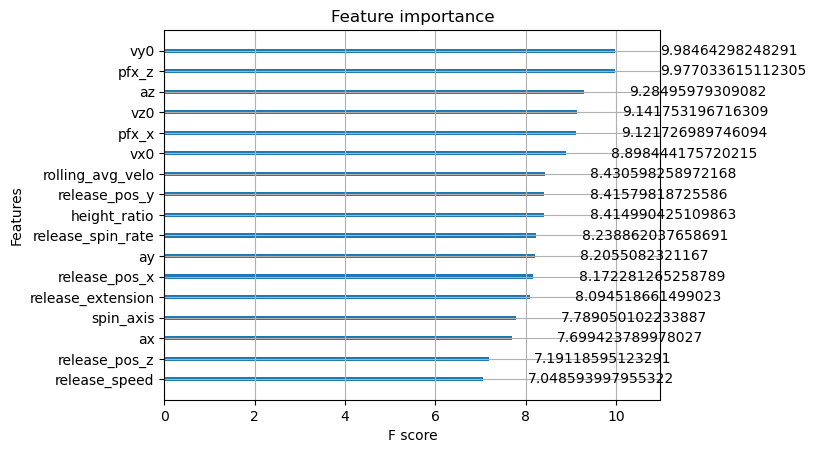

In [36]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

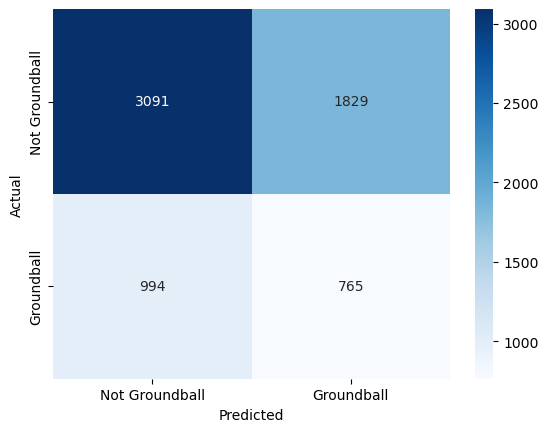

In [37]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [38]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'diff_spin_axis', 'diff_pfx_x', 'diff_pfx_z',
       'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [39]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [40]:
y_pred = final_model.predict(predictions)

In [41]:
testing_identifiers['xgb'] = y_pred

In [42]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/gb_2022&3_xgb.csv")